In [1]:
from contextlib import contextmanager
import gc
import os
from pathlib import Path
import pickle
import time

import catboost
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

from lfm import calc_embeddings, calc_scores
from metric import apk, mapk
from utils import plot_images


In [2]:
@contextmanager
def timer(name):
    start_time = time.time()
    yield
    print(f'[{name}] {time.time() - start_time:.3f} s')

In [3]:
dataset = '100'

transactions = pd.read_pickle(f"input/{dataset}/transactions_train.pkl")
users = pd.read_pickle(f"input/{dataset}/users.pkl")
items = pd.read_pickle(f"input/{dataset}/items.pkl")


In [4]:
# class CFG:
#     model_type = 'LightGBM'
#     popular_num_items = 12
#     popular_days = 7
#     train_weeks = 1
#     repurchase_weeks = 12345
#     repurchase_num_items = 100
#     item2item_weeks = 12345
#     item2item_num_items = 24
#     cooc_weeks = 12
#     cooc_threshold = 50
#     dynamic_feature_weeks = 8
#     volume_feature_days = 7


# BEST
class CFG:
    model_type = 'CatBoost'
    popular_num_items = 36
    popular_days = 7
    train_weeks = 4
    repurchase_weeks = 123456
    repurchase_num_items = 123456
    item2item_weeks = 123456
    item2item_num_items = 24
    cooc_weeks = 12
    cooc_threshold = 50
    dynamic_feature_weeks = 8
    volume_feature_days = 7

In [5]:
def create_candidates(transactions: pd.DataFrame, target_users: np.ndarray, week: int) -> pd.DataFrame:
    """
    transactions
        original transactions (user, item, week)
    target_users, week
        候補生成対象のユーザー
        weekで指定されている週の段階での情報のみから作られる
    """
    print(f"create candidates (week: {week})")
    assert len(target_users) == len(set(target_users))

    def create_candidates_repurchase(
            strategy: str,
            transactions: pd.DataFrame,
            target_users: np.ndarray,
            week_start: int,
            num_weeks: int,
            max_items_per_user: int) -> pd.DataFrame:
        week_end = week_start + num_weeks
        tr = transactions.query("user in @target_users and @week_start <= week < @week_end")[['user', 'item', 'week', 'day']].drop_duplicates(ignore_index=True)

        gr_day = tr.groupby(['user', 'item'])['day'].min().reset_index(name='day')
        gr_week = tr.groupby(['user', 'item'])['week'].min().reset_index(name='week')
        gr_volume = tr.groupby(['user', 'item']).size().reset_index(name='volume')

        gr_day['day_rank'] = gr_day.groupby('user')['day'].rank()
        gr_week['week_rank'] = gr_week.groupby('user')['week'].rank()
        gr_volume['volume_rank'] = gr_volume.groupby('user')['volume'].rank(ascending=False)

        candidates = gr_day.merge(gr_week, on=['user', 'item']).merge(gr_volume, on=['user', 'item'])

        candidates['rank_meta'] = 10**9 * candidates['day_rank'] + candidates['volume_rank']
        candidates['rank_meta'] = candidates.groupby('user')['rank_meta'].rank(method='min')
        # item2itemに使う場合は全件使うと無駄に重くなってしまうので削る
        # dayの小ささ, volumeの大きさの辞書順にソートして上位アイテムのみ残す
        # 全部残したい場合はmax_items_per_userに十分大きな数を指定する
        candidates = candidates.query("rank_meta <= @max_items_per_user").reset_index(drop=True)

        candidates = candidates[['user', 'item', 'week_rank', 'volume_rank', 'rank_meta']].rename(columns={'week_rank': f'{strategy}_week_rank', 'volume_rank': f'{strategy}_volume_rank'})

        candidates['strategy'] = strategy
        return candidates.drop_duplicates(ignore_index=True)


    def create_candidates_popular(
            strategy: str,
            transactions: pd.DataFrame,
            target_users: np.ndarray,
            week_start: int,
        ) -> pd.DataFrame:
        day_start = 7 * week_start
        tr = transactions.query("@day_start <= day < @day_start + @CFG.popular_days")[['user', 'item']].drop_duplicates(ignore_index=True)
        popular_items = tr['item'].value_counts().index.values[:CFG.popular_num_items]
        popular_items = pd.DataFrame({
            'item': popular_items,
            'rank': range(CFG.popular_num_items),
            'crossjoinkey': 1,
        })

        candidates = pd.DataFrame({
            'user': target_users,
            'crossjoinkey': 1,
        })

        candidates = candidates.merge(popular_items, on='crossjoinkey').drop('crossjoinkey', axis=1)
        candidates = candidates.rename(columns={'rank': f'{strategy}_rank'})

        candidates['strategy'] = strategy
        return candidates.drop_duplicates(ignore_index=True)


    def create_candidates_cooc(
            strategy: str,
            transactions: pd.DataFrame,
            week_start: int,
            week_num: int,
            base_candidates: pd.DataFrame) -> pd.DataFrame:
        week_end = week_start + week_num
        tr = transactions.query("@week_start <= week < @week_end")[['user', 'item', 'week']].drop_duplicates(ignore_index=True)
        tr = tr.merge(tr.rename(columns={'item': 'item_with', 'week': 'week_with'}), on='user').query("item != item_with and week <= week_with")[['item', 'item_with']].reset_index(drop=True)
        gr_item_count = tr.groupby('item').size().reset_index(name='item_count')
        gr_pair_count = tr.groupby(['item', 'item_with']).size().reset_index(name='pair_count')
        item2item = gr_pair_count.merge(gr_item_count, on='item')
        item2item['ratio'] = item2item['pair_count'] / item2item['item_count']
        item2item = item2item.query("pair_count > @CFG.cooc_threshold").reset_index(drop=True)

        candidates = base_candidates.merge(item2item, on='item').drop(['item', 'pair_count'], axis=1).rename(columns={'item_with': 'item'})
        base_candidates_columns = [c for c in base_candidates.columns if '_' in c]
        base_candidates_replace = {c: f"{strategy}_{c}" for c in base_candidates_columns}
        candidates = candidates.rename(columns=base_candidates_replace)
        candidates = candidates.rename(columns={'ratio': f'{strategy}_ratio', 'item_count': f'{strategy}_item_count'})

        candidates['strategy'] = strategy
        return candidates.drop_duplicates(ignore_index=True)

    def create_candidates_same_product_code(
            strategy: str,
            items: pd.DataFrame,
            base_candidates: pd.DataFrame) -> pd.DataFrame:
        item2item = items[['item', 'product_code']].merge(items[['item', 'product_code']].rename({'item': 'item_with'}, axis=1), on='product_code')[['item', 'item_with']].query("item != item_with").reset_index(drop=True)

        candidates = base_candidates.merge(item2item, on='item').drop('item', axis=1).rename(columns={'item_with': 'item'})

        candidates['min_rank_meta'] = candidates.groupby(['user', 'item'])['rank_meta'].transform('min')
        candidates = candidates.query("rank_meta == min_rank_meta").reset_index(drop=True)
        
        base_candidates_columns = [c for c in base_candidates.columns if '_' in c]
        base_candidates_replace = {c: f"{strategy}_{c}" for c in base_candidates_columns}
        candidates = candidates.rename(columns=base_candidates_replace)

        candidates['strategy'] = strategy
        return candidates.drop_duplicates(ignore_index=True)

    with timer("repurchase"):
        candidates_repurchase = create_candidates_repurchase('repurchase', transactions, target_users, week, CFG.repurchase_weeks, CFG.repurchase_num_items)
    with timer("popular"):
        candidates_popular = create_candidates_popular('pop', transactions, target_users, week)
    with timer("item2item"):
        candidates_item2item = create_candidates_repurchase('item2item', transactions, target_users, week, CFG.repurchase_weeks, CFG.item2item_num_items)
    with timer("cooccurrence"):
        candidates_cooc = create_candidates_cooc('cooc', transactions, week, CFG.cooc_weeks, candidates_item2item)
    with timer("same_product_code"):
        candidates_same_product_code = create_candidates_same_product_code('same_product_code', items, candidates_item2item)

    def create_candidates_ohe_distance(transactions, users, items, target_users, week):
        num_items = 32
        import faiss
        users_with_ohe = users[['user']].query("user in @target_users")
        cols = [c for c in items.columns if c.endswith('_idx')]
        for c in cols:
            tmp = pd.read_pickle(f"artifacts/user_features/user_ohe_agg_dataset{dataset}_week{week}_{c}.pkl")
            cs = [c for c in tmp.columns if c.endswith('_mean')]
            users_with_ohe = users_with_ohe.merge(tmp[['user'] + cs], on='user')

        users_with_ohe = users_with_ohe.dropna().reset_index(drop=True)
        limited_users = users_with_ohe['user'].values

        recent_items = transactions.query("@week <= week < @week + 1")['item'].unique()
        items_with_ohe = pd.get_dummies(items[['item'] + cols], columns=cols)
        items_with_ohe = items_with_ohe.query("item in @recent_items").reset_index(drop=True)
        limited_items = items_with_ohe['item'].values

        item_cols = [c for c in items_with_ohe.columns if c != 'item']
        user_cols = [f'user_ohe_agg_{c}_mean' for c in item_cols]
        users_with_ohe = users_with_ohe[['user'] + user_cols]
        items_with_ohe = items_with_ohe[['item'] + item_cols]

        a_users = users_with_ohe.drop('user', axis=1).values.astype(np.float32)
        a_items = items_with_ohe.drop('item', axis=1).values.astype(np.float32)
        a_users = np.ascontiguousarray(a_users)
        a_items = np.ascontiguousarray(a_items)
        index = faiss.index_factory(a_items.shape[1], "Flat", faiss.METRIC_INNER_PRODUCT)
        index = faiss.index_cpu_to_gpu(faiss.StandardGpuResources(), 0, index)
        index.add(a_items)
        distances, idxs = index.search(a_users, num_items)

        return pd.DataFrame({
            'user': np.repeat(limited_users, num_items),
            'item': limited_items[idxs.flatten()],
            'distance': distances.flatten(),
            'strategy': 'ohe',
        })
    with timer("ohe distance"):
        candidates_ohe_distance = create_candidates_ohe_distance(transactions, users, items, target_users, week)

    def drop_common_user_item(candidates_target: pd.DataFrame, candidates_reference: pd.DataFrame) -> pd.DataFrame:
        """
        candidates_targetのうちuser, itemの組がcandidates_referenceにあるものを落とす
        """
        tmp = candidates_reference[['user', 'item']].reset_index(drop=True)
        tmp['flag'] = 1
        candidates = candidates_target.merge(tmp, on=['user', 'item'], how='left')
        return candidates.query("flag != 1").reset_index(drop=True).drop('flag', axis=1)


    candidates_cooc = drop_common_user_item(candidates_cooc, candidates_repurchase)
    candidates_same_product_code = drop_common_user_item(candidates_same_product_code, candidates_repurchase)
    candidates_ohe_distance = drop_common_user_item(candidates_ohe_distance, candidates_repurchase)

    candidates = [
        candidates_repurchase,
        candidates_popular,
        candidates_cooc,
        candidates_same_product_code,
        candidates_ohe_distance,
    ]
    candidates = pd.concat(candidates)

    print(f"volume: {len(candidates)}")
    print(f"duplicates: {len(candidates) / len(candidates[['user', 'item']].drop_duplicates())}")

    volumes = candidates.groupby('strategy').size().reset_index(name='volume').sort_values(by='volume', ascending=False).reset_index(drop=True)
    volumes['ratio'] = volumes['volume'] / volumes['volume'].sum()
    print(volumes)

    meta_columns = [c for c in candidates.columns if c.endswith('_meta')]
    return candidates.drop(meta_columns, axis=1)


In [6]:
# valid: week=0
# train: week=1..CFG.train_weeks
candidates = []
for week in range(1+CFG.train_weeks):
    target_users = transactions.query("week == @week")['user'].unique()
    candidates.append(create_candidates(transactions, target_users, week+1))

create candidates (week: 1)


[repurchase] 9.435 s


[popular] 0.479 s


[item2item] 8.304 s


[cooccurrence] 14.249 s


[same_product_code] 5.630 s


[ohe distance] 16.913 s


volume: 15991626


duplicates: 1.0552836520584024


            strategy   volume     ratio
0  same_product_code  6876142  0.429984
1         repurchase  3446562  0.215523
2                pop  2483424  0.155295
3                ohe  1981757  0.123925
4               cooc  1203741  0.075273


create candidates (week: 2)


[repurchase] 9.574 s


[popular] 0.518 s


[item2item] 8.707 s


[cooccurrence] 15.993 s


[same_product_code] 5.762 s


[ohe distance] 14.770 s


volume: 16956677


duplicates: 1.0592206643477098


            strategy   volume     ratio
0  same_product_code  7228749  0.426307
1         repurchase  3637145  0.214496
2                pop  2592684  0.152900
3                ohe  2080062  0.122669
4               cooc  1418037  0.083627


create candidates (week: 3)


[repurchase] 9.724 s


[popular] 0.546 s


[item2item] 9.142 s


[cooccurrence] 16.009 s


[same_product_code] 5.767 s


[ohe distance] 11.317 s


volume: 17930210


duplicates: 1.0620907696093247


            strategy   volume     ratio
0  same_product_code  7678831  0.428262
1         repurchase  3742824  0.208744
2                pop  2729592  0.152234
3                ohe  2188278  0.122044
4               cooc  1590685  0.088715


create candidates (week: 4)


[repurchase] 10.056 s


[popular] 0.558 s


[item2item] 9.180 s


[cooccurrence] 16.541 s


[same_product_code] 6.381 s


[ohe distance] 17.468 s


volume: 19100294


duplicates: 1.066212805655061


            strategy   volume     ratio
0  same_product_code  8177755  0.428148
1         repurchase  3915353  0.204989
2                pop  2889108  0.151260
3                ohe  2320500  0.121490
4               cooc  1797578  0.094113


create candidates (week: 5)


[repurchase] 9.338 s


[popular] 0.511 s


[item2item] 8.575 s


[cooccurrence] 17.071 s


[same_product_code] 5.933 s


[ohe distance] 16.959 s


volume: 17408764


duplicates: 1.069782681661812


            strategy   volume     ratio
0  same_product_code  7353615  0.422409
1         repurchase  3548895  0.203857
2                pop  2593260  0.148963
3                ohe  2095741  0.120384
4               cooc  1817253  0.104387


In [7]:
def merge_labels(candidates: pd.DataFrame, week: int) -> pd.DataFrame:
    """
    candidatesに対してweekで指定される週のトランザクションからラベルを付与する
    """
    print(f"merge labels (week: {week})")
    labels = transactions[transactions['week'] == week][['user', 'item']].drop_duplicates(ignore_index=True)
    labels['y'] = 1
    original_positives = len(labels)
    labels = candidates.merge(labels, on=['user', 'item'], how='left')
    labels['y'] = labels['y'].fillna(0)

    remaining_positives_total = labels[['user', 'item', 'y']].drop_duplicates(ignore_index=True)['y'].sum()
    recall = remaining_positives_total / original_positives
    print(f"Recall: {recall}")

    volumes = candidates.groupby('strategy').size().reset_index(name='volume')
    remaining_positives = labels.groupby('strategy')['y'].sum().reset_index()
    remaining_positives = remaining_positives.merge(volumes, on='strategy')
    remaining_positives['recall'] = remaining_positives['y'] / original_positives
    remaining_positives['hit_ratio'] = remaining_positives['y'] / remaining_positives['volume']
    remaining_positives = remaining_positives.sort_values(by='y', ascending=False).reset_index(drop=True)
    print(remaining_positives)

    return labels


In [8]:
for idx in range(len(candidates)):
    candidates[idx] = merge_labels(candidates[idx], idx)


merge labels (week: 0)


Recall: 0.14038871837101363


            strategy        y   volume    recall  hit_ratio
0                pop  11811.0  2483424  0.055262   0.004756
1         repurchase   8437.0  3446562  0.039475   0.002448
2  same_product_code   7888.0  6876142  0.036907   0.001147
3               cooc   5096.0  1203741  0.023843   0.004233
4                ohe   2440.0  1981757  0.011416   0.001231
merge labels (week: 1)


Recall: 0.13065683822561538


            strategy        y   volume    recall  hit_ratio
0                pop  10203.0  2592684  0.044768   0.003935
1         repurchase   8955.0  3637145  0.039292   0.002462
2  same_product_code   8554.0  7228749  0.037532   0.001183
3               cooc   5210.0  1418037  0.022860   0.003674
4                ohe   2680.0  2080062  0.011759   0.001288
merge labels (week: 2)


Recall: 0.13371472735367995


            strategy        y   volume    recall  hit_ratio
0                pop  11942.0  2729592  0.050161   0.004375
1         repurchase   9195.0  3742824  0.038622   0.002457
2  same_product_code   8829.0  7678831  0.037085   0.001150
3               cooc   5376.0  1590685  0.022581   0.003380
4                ohe   2526.0  2188278  0.010610   0.001154
merge labels (week: 3)


Recall: 0.13197372752496356


            strategy        y   volume    recall  hit_ratio
0                pop  13485.0  2889108  0.052847   0.004668
1  same_product_code   9328.0  8177755  0.036556   0.001141
2         repurchase   9002.0  3915353  0.035278   0.002299
3               cooc   5609.0  1797578  0.021981   0.003120
4                ohe   2856.0  2320500  0.011192   0.001231
merge labels (week: 4)


Recall: 0.12992526806021878


            strategy       y   volume    recall  hit_ratio
0                pop  9552.0  2593260  0.041382   0.003683
1  same_product_code  9193.0  7353615  0.039827   0.001250
2         repurchase  8945.0  3548895  0.038752   0.002521
3               cooc  6350.0  1817253  0.027510   0.003494
4                ohe  2501.0  2095741  0.010835   0.001193


In [9]:
def drop_trivial_users(labels):
    """
    LightGBMのxendgcやlambdarankでは正例のみや負例のみのuserは学習に無意味なのと、メトリックの計算がおかしくなるので省く
    """
    bef = len(labels)
    df = labels[labels['user'].isin(labels[['user', 'y']].drop_duplicates().groupby('user').size().reset_index(name='sz').query("sz==2").user)].reset_index(drop=True)
    aft = len(df)
    print(f"drop trivial queries: {bef} -> {aft}")
    return df


for idx in range(len(candidates)):
    candidates[idx]['week'] = idx

candidates_valid_all = candidates[0].copy()

for idx in range(len(candidates)):
    candidates[idx] = drop_trivial_users(candidates[idx])


drop trivial queries: 15991626 -> 5450623


drop trivial queries: 16956677 -> 5718264


drop trivial queries: 17930210 -> 6126511


drop trivial queries: 19100294 -> 6474396


drop trivial queries: 17408764 -> 5808285


In [10]:
# age==25でのアイテムボリューム以上になるような幅を各年齢に対して求める
tr = transactions[['user', 'item']].merge(users[['user', 'age']], on='user')
age_volume_threshold = len(tr.query("24 <= age <= 26"))

age_volumes = {age: len(tr.query("age == @age")) for age in range(16, 100)}

age_shifts = {}
for age in range(16, 100):
    for i in range(0, 100):
        low = age - i
        high = age + i
        age_volume = 0
        for j in range(low, high+1):
            age_volume += age_volumes.get(j, 0)
        if age_volume >= age_volume_threshold:
            age_shifts[age] = i
            break
print(age_shifts)

{16: 7, 17: 6, 18: 5, 19: 4, 20: 3, 21: 2, 22: 2, 23: 2, 24: 2, 25: 1, 26: 2, 27: 2, 28: 2, 29: 2, 30: 2, 31: 2, 32: 3, 33: 3, 34: 4, 35: 4, 36: 5, 37: 5, 38: 5, 39: 5, 40: 6, 41: 6, 42: 5, 43: 5, 44: 5, 45: 5, 46: 4, 47: 4, 48: 4, 49: 4, 50: 4, 51: 4, 52: 4, 53: 4, 54: 4, 55: 5, 56: 5, 57: 6, 58: 7, 59: 7, 60: 8, 61: 9, 62: 10, 63: 11, 64: 12, 65: 13, 66: 14, 67: 15, 68: 16, 69: 17, 70: 18, 71: 19, 72: 20, 73: 21, 74: 22, 75: 23, 76: 24, 77: 25, 78: 26, 79: 27, 80: 28, 81: 29, 82: 30, 83: 31, 84: 32, 85: 33, 86: 34, 87: 35, 88: 36, 89: 37, 90: 38, 91: 39, 92: 40, 93: 41, 94: 42, 95: 43, 96: 44, 97: 45, 98: 46, 99: 47}


In [11]:
def attach_features(transactions: pd.DataFrame, users: pd.DataFrame, items: pd.DataFrame, candidates: pd.DataFrame, week: int, pretrain_week: int) -> pd.DataFrame:
    """
    user, itemに対して特徴を横付けする
    week: これを含めた以前の情報は使って良い
    """
    print(f"attach features (week: {week})")
    n_original = len(candidates)
    df = candidates.copy()

    with timer("user static fetaures"):
        user_features = ['FN', 'Active', 'age', 'club_member_status_idx', 'fashion_news_frequency_idx']
        df = df.merge(users[['user'] + user_features], on='user')

    with timer("item stacic features"):
        item_features = [c for c in items.columns if c.endswith('idx')]
        df = df.merge(items[['item'] + item_features], on='item')

    with timer("user dynamic features (transactions)"):
        week_end = week + CFG.dynamic_feature_weeks
        tmp = transactions.query("@week <= week < @week_end").groupby('user')[['price', 'sales_channel_id']].agg(['mean', 'std'])
        tmp.columns = ['user_' + '_'.join(a) for a in tmp.columns.to_flat_index()]
        df = df.merge(tmp, on='user', how='left')

    with timer("item dynamic features (transactions)"):
        week_end = week + CFG.dynamic_feature_weeks
        tmp = transactions.query("@week <= week < @week_end").groupby('item')[['price', 'sales_channel_id']].agg(['mean', 'std'])
        tmp.columns = ['item_' + '_'.join(a) for a in tmp.columns.to_flat_index()]
        df = df.merge(tmp, on='item', how='left')

    with timer("item dynamic features (user features)"):
        week_end = week + CFG.dynamic_feature_weeks
        tmp = transactions.query("@week <= week < @week_end").merge(users[['user', 'age']], on='user')
        tmp = tmp.groupby('item')['age'].agg(['mean', 'std'])
        tmp.columns = [f'age_{a}' for a in tmp.columns.to_flat_index()]
        df = df.merge(tmp, on='item', how='left')

    with timer("item freshness features"):
        tmp = transactions.query("@week <= week").groupby('item')['day'].min().reset_index(name='item_day_min')
        tmp['item_day_min'] -= transactions.query("@week == week")['day'].min()
        df = df.merge(tmp, on='item', how='left')

    with timer("item volume features"):
        day_start = 7 * week
        day_end = day_start + CFG.volume_feature_days
        tmp = transactions.query("@day_start <= day < @day_end").groupby('item').size().reset_index(name='item_volume')
        df = df.merge(tmp, on='item', how='left')

    with timer("user freshness features"):
        tmp = transactions.query("@week <= week").groupby('user')['day'].min().reset_index(name='user_day_min')
        tmp['user_day_min'] -= transactions.query("@week == week")['day'].min()
        df = df.merge(tmp, on='user', how='left')

    with timer("user volume features"):
        day_start = 7 * week
        day_end = day_start + CFG.volume_feature_days
        tmp = transactions.query("@day_start <= day < @day_end").groupby('user').size().reset_index(name='user_volume')
        df = df.merge(tmp, on='user', how='left')

    with timer("user-item freshness features"):
        tmp = transactions.query("@week <= week").groupby(['user', 'item'])['day'].min().reset_index(name='user_item_day_min')
        tmp['user_item_day_min'] -= transactions.query("@week == week")['day'].min()
        df = df.merge(tmp, on=['item', 'user'], how='left')

    with timer("user-item volume features"):
        day_start = 7 * week
        day_end = day_start + CFG.volume_feature_days
        tmp = transactions.query("@day_start <= day < @day_end").groupby(['user', 'item']).size().reset_index(name='user_item_volume')
        df = df.merge(tmp, on=['user', 'item'], how='left')

    with timer("item age volume features"):
        day_start = 7 * week
        day_end = day_start + CFG.volume_feature_days
        tr = transactions.query("@day_start <= day < @day_end")[['user', 'item']].merge(users[['user', 'age']], on='user')
        item_age_volumes = []
        for age in range(16, 100):
            low = age - age_shifts[age]
            high = age + age_shifts[age]
            tmp = tr.query("@low <= age <= @high").groupby('item').size().reset_index(name='age_volume')
            tmp['age_volume'] = tmp['age_volume'].rank(ascending=False)
            tmp['age'] = age
            item_age_volumes.append(tmp)
        item_age_volumes = pd.concat(item_age_volumes)
        df = df.merge(item_age_volumes, on=['item', 'age'], how='left')

    with timer("ohe dot products"):
        item_target_cols = [c for c in items.columns if c.endswith('_idx')]

        items_with_ohe = pd.get_dummies(items[['item'] + item_target_cols], columns=item_target_cols)

        users_with_ohe = users[['user']]
        for c in item_target_cols:
            tmp = pd.read_pickle(f"artifacts/user_features/user_ohe_agg_dataset{dataset}_week{week}_{c}.pkl")
            assert tmp['user'].tolist() == users_with_ohe['user'].tolist()
            tmp = tmp[['user'] + [c for c in tmp.columns if c.endswith('_mean')]]
            tmp = tmp.drop('user', axis=1)
            users_with_ohe = pd.concat([users_with_ohe, tmp], axis=1)

        assert items_with_ohe['item'].tolist() == items['item'].tolist()
        assert users_with_ohe['user'].tolist() == users['user'].tolist()

        users_items = df[['user', 'item']].drop_duplicates().reset_index(drop=True)
        n_split = 10
        n_chunk = (len(users_items) + n_split - 1)// n_split
        ohe = []
        for i in range(0, len(users_items), n_chunk):
            users_items_small = users_items.iloc[i:i+n_chunk].reset_index(drop=True)
            users_small = users_items_small['user'].values
            items_small = users_items_small['item'].values

            for item_col in item_target_cols:
                i_cols = [c for c in items_with_ohe.columns if c.startswith(item_col)]
                u_cols = [f"user_ohe_agg_{c}_mean" for c in i_cols]
                users_items_small[f'{item_col}_ohe_score'] = (items_with_ohe[i_cols].values[items_small] * users_with_ohe[u_cols].values[users_small]).sum(axis=1)

            ohe_cols = [f'{col}_ohe_score' for col in item_target_cols]
            users_items_small = users_items_small[['user', 'item'] + ohe_cols]

            ohe.append(users_items_small)
        ohe = pd.concat(ohe)
        df = df.merge(ohe, on=['user', 'item'])

    with timer("lfm features"):
        user_reps, _ = calc_embeddings('i_i', dataset, pretrain_week, 16)
        df = df.merge(user_reps, on='user')



    assert len(df) == n_original
    return df


dataset_valid_all = attach_features(transactions, users, items, candidates_valid_all, 1, CFG.train_weeks+1)
# pretrained modelの学習期間が評価時と提出時で異なるので、candidatesは残しておく
datasets = [attach_features(transactions, users, items, candidates[idx], 1+idx, CFG.train_weeks+1) for idx in range(len(candidates))]

attach features (week: 1)


[user static fetaures] 1.709 s


[item stacic features] 4.493 s


[user dynamic features (transactions)] 3.062 s


[item dynamic features (transactions)] 2.476 s


[item dynamic features (user features)] 3.086 s


[item freshness features] 4.561 s


[item volume features] 2.712 s


[user freshness features] 6.200 s


[user volume features] 3.223 s


[user-item freshness features] 24.393 s


[user-item volume features] 5.933 s


[item age volume features] 5.292 s


[ohe dot products] 144.611 s


[lfm features] 8.790 s
attach features (week: 1)


[user static fetaures] 0.615 s


[item stacic features] 1.412 s


[user dynamic features (transactions)] 1.256 s


[item dynamic features (transactions)] 1.028 s


[item dynamic features (user features)] 1.526 s


[item freshness features] 2.949 s


[item volume features] 1.038 s


[user freshness features] 4.151 s


[user volume features] 1.175 s


[user-item freshness features] 21.144 s


[user-item volume features] 1.947 s


[item age volume features] 2.263 s


[ohe dot products] 59.375 s


[lfm features] 3.062 s
attach features (week: 2)


[user static fetaures] 0.639 s


[item stacic features] 1.499 s


[user dynamic features (transactions)] 1.292 s


[item dynamic features (transactions)] 1.075 s


[item dynamic features (user features)] 1.550 s


[item freshness features] 2.898 s


[item volume features] 1.035 s


[user freshness features] 4.113 s


[user volume features] 1.217 s


[user-item freshness features] 20.797 s


[user-item volume features] 2.019 s


[item age volume features] 2.334 s


[ohe dot products] 64.398 s


[lfm features] 3.106 s
attach features (week: 3)


[user static fetaures] 0.687 s


[item stacic features] 1.628 s


[user dynamic features (transactions)] 1.373 s


[item dynamic features (transactions)] 1.169 s


[item dynamic features (user features)] 1.650 s


[item freshness features] 2.990 s


[item volume features] 1.150 s


[user freshness features] 4.211 s


[user volume features] 1.303 s


[user-item freshness features] 20.924 s


[user-item volume features] 2.145 s


[item age volume features] 2.479 s


[ohe dot products] 68.665 s


[lfm features] 3.828 s
attach features (week: 4)


[user static fetaures] 0.718 s


[item stacic features] 1.722 s


[user dynamic features (transactions)] 1.473 s


[item dynamic features (transactions)] 1.209 s


[item dynamic features (user features)] 1.724 s


[item freshness features] 3.020 s


[item volume features] 1.200 s


[user freshness features] 4.237 s


[user volume features] 1.379 s


[user-item freshness features] 20.957 s


[user-item volume features] 2.302 s


[item age volume features] 2.546 s


[ohe dot products] 91.049 s


[lfm features] 3.931 s
attach features (week: 5)


[user static fetaures] 0.653 s


[item stacic features] 1.527 s


[user dynamic features (transactions)] 1.399 s


[item dynamic features (transactions)] 1.148 s


[item dynamic features (user features)] 1.684 s


[item freshness features] 2.935 s


[item volume features] 1.091 s


[user freshness features] 4.079 s


[user volume features] 1.247 s


[user-item freshness features] 20.634 s


[user-item volume features] 2.046 s


[item age volume features] 2.391 s


[ohe dot products] 92.044 s


[lfm features] 3.931 s


In [12]:
for idx in range(len(datasets)):
    datasets[idx]['query_group'] = datasets[idx]['week'].astype(str) + '_' + datasets[idx]['user'].astype(str)
    datasets[idx] = datasets[idx].sort_values(by='query_group').reset_index(drop=True)

In [13]:
def concat_train(datasets, begin, num):
    train = pd.concat([datasets[idx] for idx in range(begin, begin+num)])
    return train

valid = datasets[0]
train = concat_train(datasets, 1, CFG.train_weeks)

In [14]:
feature_columns = [c for c in valid.columns if c not in ['y', 'strategy', 'query_group', 'week']]
print(feature_columns)


['user', 'item', 'repurchase_week_rank', 'repurchase_volume_rank', 'pop_rank', 'cooc_item2item_week_rank', 'cooc_item2item_volume_rank', 'cooc_item_count', 'cooc_ratio', 'same_product_code_item2item_week_rank', 'same_product_code_item2item_volume_rank', 'distance', 'FN', 'Active', 'age', 'club_member_status_idx', 'fashion_news_frequency_idx', 'product_type_no_idx', 'product_group_name_idx', 'graphical_appearance_no_idx', 'colour_group_code_idx', 'perceived_colour_value_id_idx', 'perceived_colour_master_id_idx', 'department_no_idx', 'index_code_idx', 'index_group_no_idx', 'section_no_idx', 'garment_group_no_idx', 'user_price_mean', 'user_price_std', 'user_sales_channel_id_mean', 'user_sales_channel_id_std', 'item_price_mean', 'item_price_std', 'item_sales_channel_id_mean', 'item_sales_channel_id_std', 'age_mean', 'age_std', 'item_day_min', 'item_volume', 'user_day_min', 'user_volume', 'user_item_day_min', 'user_item_volume', 'age_volume', 'product_type_no_idx_ohe_score', 'product_group_

In [15]:

cat_feature_values = [c for c in feature_columns if c.endswith('idx')]
cat_features = [feature_columns.index(c) for c in cat_feature_values]
print(cat_feature_values, cat_features)


['club_member_status_idx', 'fashion_news_frequency_idx', 'product_type_no_idx', 'product_group_name_idx', 'graphical_appearance_no_idx', 'colour_group_code_idx', 'perceived_colour_value_id_idx', 'perceived_colour_master_id_idx', 'department_no_idx', 'index_code_idx', 'index_group_no_idx', 'section_no_idx', 'garment_group_no_idx'] [15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]


In [16]:
def get_query_group(df):
    def run_length_encoding(sequence):
        comp_seq_index, = np.concatenate(([True], sequence[1:] != sequence[:-1], [True])).nonzero()
        return sequence[comp_seq_index[:-1]], np.ediff1d(comp_seq_index)
    users = df['user'].values
    _, group = run_length_encoding(users)
    return list(group)

0:	test: 0.0901886	best: 0.0901886 (0)	total: 3.73s	remaining: 5h 10m 24s


1:	test: 0.1436200	best: 0.1436200 (1)	total: 6.96s	remaining: 4h 50m 1s


2:	test: 0.1697680	best: 0.1697680 (2)	total: 10.3s	remaining: 4h 45m 41s


3:	test: 0.1849065	best: 0.1849065 (3)	total: 13.6s	remaining: 4h 43m 2s


4:	test: 0.1967227	best: 0.1967227 (4)	total: 17.6s	remaining: 4h 53m 9s


5:	test: 0.1985335	best: 0.1985335 (5)	total: 21.7s	remaining: 5h 1m 28s


6:	test: 0.1974864	best: 0.1985335 (5)	total: 25.4s	remaining: 5h 2m 11s


7:	test: 0.2131743	best: 0.2131743 (7)	total: 28.7s	remaining: 4h 58m 19s


8:	test: 0.2139858	best: 0.2139858 (8)	total: 32s	remaining: 4h 56m 1s


9:	test: 0.2139281	best: 0.2139858 (8)	total: 35.4s	remaining: 4h 54m 5s


10:	test: 0.2145779	best: 0.2145779 (10)	total: 38.6s	remaining: 4h 52m


11:	test: 0.2146877	best: 0.2146877 (11)	total: 41.9s	remaining: 4h 50m 27s


12:	test: 0.2194676	best: 0.2194676 (12)	total: 45.3s	remaining: 4h 49m 29s


13:	test: 0.2203327	best: 0.2203327 (13)	total: 48.6s	remaining: 4h 48m 36s


14:	test: 0.2194172	best: 0.2203327 (13)	total: 51.9s	remaining: 4h 47m 26s


15:	test: 0.2241689	best: 0.2241689 (15)	total: 55.2s	remaining: 4h 46m 45s


16:	test: 0.2380312	best: 0.2380312 (16)	total: 58.7s	remaining: 4h 46m 38s


17:	test: 0.2399819	best: 0.2399819 (17)	total: 1m 2s	remaining: 4h 46m 18s


18:	test: 0.2422111	best: 0.2422111 (18)	total: 1m 5s	remaining: 4h 45m 20s


19:	test: 0.2467191	best: 0.2467191 (19)	total: 1m 8s	remaining: 4h 45m 26s


20:	test: 0.2481559	best: 0.2481559 (20)	total: 1m 12s	remaining: 4h 44m 55s


21:	test: 0.2527244	best: 0.2527244 (21)	total: 1m 15s	remaining: 4h 44m 28s


22:	test: 0.2540116	best: 0.2540116 (22)	total: 1m 18s	remaining: 4h 44m 19s


23:	test: 0.2628909	best: 0.2628909 (23)	total: 1m 22s	remaining: 4h 44m 3s


24:	test: 0.2634901	best: 0.2634901 (24)	total: 1m 25s	remaining: 4h 44m 6s


25:	test: 0.2639193	best: 0.2639193 (25)	total: 1m 29s	remaining: 4h 44m 12s


26:	test: 0.2648045	best: 0.2648045 (26)	total: 1m 32s	remaining: 4h 44m


27:	test: 0.2648407	best: 0.2648407 (27)	total: 1m 35s	remaining: 4h 43m 30s


28:	test: 0.2657707	best: 0.2657707 (28)	total: 1m 39s	remaining: 4h 43m 14s


29:	test: 0.2687864	best: 0.2687864 (29)	total: 1m 42s	remaining: 4h 42m 58s


30:	test: 0.2695682	best: 0.2695682 (30)	total: 1m 45s	remaining: 4h 42m 43s


31:	test: 0.2709313	best: 0.2709313 (31)	total: 1m 49s	remaining: 4h 42m 37s


32:	test: 0.2712450	best: 0.2712450 (32)	total: 1m 52s	remaining: 4h 42m 26s


33:	test: 0.2714882	best: 0.2714882 (33)	total: 1m 55s	remaining: 4h 42m 8s


34:	test: 0.2721918	best: 0.2721918 (34)	total: 1m 59s	remaining: 4h 41m 45s


35:	test: 0.2729915	best: 0.2729915 (35)	total: 2m 2s	remaining: 4h 41m 45s


36:	test: 0.2734674	best: 0.2734674 (36)	total: 2m 5s	remaining: 4h 41m 33s


37:	test: 0.2736036	best: 0.2736036 (37)	total: 2m 9s	remaining: 4h 41m 20s


38:	test: 0.2740622	best: 0.2740622 (38)	total: 2m 12s	remaining: 4h 41m 11s


39:	test: 0.2739286	best: 0.2740622 (38)	total: 2m 15s	remaining: 4h 40m 57s


40:	test: 0.2738775	best: 0.2740622 (38)	total: 2m 19s	remaining: 4h 40m 46s


41:	test: 0.2755487	best: 0.2755487 (41)	total: 2m 22s	remaining: 4h 40m 31s


42:	test: 0.2757560	best: 0.2757560 (42)	total: 2m 25s	remaining: 4h 40m 12s


43:	test: 0.2779444	best: 0.2779444 (43)	total: 2m 29s	remaining: 4h 39m 58s


44:	test: 0.2780817	best: 0.2780817 (44)	total: 2m 32s	remaining: 4h 39m 34s


45:	test: 0.2784433	best: 0.2784433 (45)	total: 2m 35s	remaining: 4h 39m 14s


46:	test: 0.2782665	best: 0.2784433 (45)	total: 2m 38s	remaining: 4h 38m 59s


47:	test: 0.2786111	best: 0.2786111 (47)	total: 2m 42s	remaining: 4h 38m 53s


48:	test: 0.2786376	best: 0.2786376 (48)	total: 2m 45s	remaining: 4h 38m 42s


49:	test: 0.2785810	best: 0.2786376 (48)	total: 2m 48s	remaining: 4h 38m 26s


50:	test: 0.2788652	best: 0.2788652 (50)	total: 2m 52s	remaining: 4h 38m 15s


51:	test: 0.2792368	best: 0.2792368 (51)	total: 2m 55s	remaining: 4h 38m 11s


52:	test: 0.2795528	best: 0.2795528 (52)	total: 2m 58s	remaining: 4h 38m 9s


53:	test: 0.2803614	best: 0.2803614 (53)	total: 3m 2s	remaining: 4h 38m 5s


54:	test: 0.2814294	best: 0.2814294 (54)	total: 3m 5s	remaining: 4h 37m 58s


55:	test: 0.2816704	best: 0.2816704 (55)	total: 3m 8s	remaining: 4h 37m 52s


56:	test: 0.2822236	best: 0.2822236 (56)	total: 3m 12s	remaining: 4h 37m 44s


57:	test: 0.2822096	best: 0.2822236 (56)	total: 3m 15s	remaining: 4h 37m 38s


58:	test: 0.2824316	best: 0.2824316 (58)	total: 3m 18s	remaining: 4h 37m 35s


59:	test: 0.2826015	best: 0.2826015 (59)	total: 3m 22s	remaining: 4h 37m 27s


60:	test: 0.2827884	best: 0.2827884 (60)	total: 3m 25s	remaining: 4h 37m 14s


61:	test: 0.2832069	best: 0.2832069 (61)	total: 3m 28s	remaining: 4h 37m 1s


62:	test: 0.2834271	best: 0.2834271 (62)	total: 3m 32s	remaining: 4h 37m 5s


63:	test: 0.2839441	best: 0.2839441 (63)	total: 3m 35s	remaining: 4h 36m 56s


64:	test: 0.2841807	best: 0.2841807 (64)	total: 3m 38s	remaining: 4h 36m 56s


65:	test: 0.2844927	best: 0.2844927 (65)	total: 3m 42s	remaining: 4h 36m 53s


66:	test: 0.2848969	best: 0.2848969 (66)	total: 3m 45s	remaining: 4h 36m 50s


67:	test: 0.2851634	best: 0.2851634 (67)	total: 3m 48s	remaining: 4h 36m 43s


68:	test: 0.2851078	best: 0.2851634 (67)	total: 3m 52s	remaining: 4h 36m 40s


69:	test: 0.2852421	best: 0.2852421 (69)	total: 3m 55s	remaining: 4h 36m 28s


70:	test: 0.2855285	best: 0.2855285 (70)	total: 3m 59s	remaining: 4h 36m 32s


71:	test: 0.2855713	best: 0.2855713 (71)	total: 4m 2s	remaining: 4h 36m 25s


72:	test: 0.2858053	best: 0.2858053 (72)	total: 4m 5s	remaining: 4h 36m 11s


73:	test: 0.2870748	best: 0.2870748 (73)	total: 4m 8s	remaining: 4h 36m 2s


74:	test: 0.2870939	best: 0.2870939 (74)	total: 4m 12s	remaining: 4h 35m 56s


75:	test: 0.2872416	best: 0.2872416 (75)	total: 4m 15s	remaining: 4h 35m 49s


76:	test: 0.2873978	best: 0.2873978 (76)	total: 4m 18s	remaining: 4h 35m 37s


77:	test: 0.2876012	best: 0.2876012 (77)	total: 4m 22s	remaining: 4h 35m 33s


78:	test: 0.2878234	best: 0.2878234 (78)	total: 4m 25s	remaining: 4h 35m 26s


79:	test: 0.2882073	best: 0.2882073 (79)	total: 4m 28s	remaining: 4h 35m 15s


80:	test: 0.2882509	best: 0.2882509 (80)	total: 4m 31s	remaining: 4h 35m 4s


81:	test: 0.2883600	best: 0.2883600 (81)	total: 4m 35s	remaining: 4h 34m 59s


82:	test: 0.2886308	best: 0.2886308 (82)	total: 4m 38s	remaining: 4h 34m 49s


83:	test: 0.2889456	best: 0.2889456 (83)	total: 4m 41s	remaining: 4h 34m 39s


84:	test: 0.2890729	best: 0.2890729 (84)	total: 4m 45s	remaining: 4h 34m 41s


85:	test: 0.2891562	best: 0.2891562 (85)	total: 4m 48s	remaining: 4h 34m 42s


86:	test: 0.2894648	best: 0.2894648 (86)	total: 4m 51s	remaining: 4h 34m 41s


87:	test: 0.2896195	best: 0.2896195 (87)	total: 4m 55s	remaining: 4h 34m 37s


88:	test: 0.2899434	best: 0.2899434 (88)	total: 4m 58s	remaining: 4h 34m 25s


89:	test: 0.2901410	best: 0.2901410 (89)	total: 5m 1s	remaining: 4h 34m 23s


90:	test: 0.2902230	best: 0.2902230 (90)	total: 5m 5s	remaining: 4h 34m 19s


91:	test: 0.2901605	best: 0.2902230 (90)	total: 5m 8s	remaining: 4h 34m 17s


92:	test: 0.2914093	best: 0.2914093 (92)	total: 5m 11s	remaining: 4h 34m 18s


93:	test: 0.2919546	best: 0.2919546 (93)	total: 5m 15s	remaining: 4h 34m 16s


94:	test: 0.2917363	best: 0.2919546 (93)	total: 5m 18s	remaining: 4h 34m 9s


95:	test: 0.2918867	best: 0.2919546 (93)	total: 5m 21s	remaining: 4h 34m 2s


96:	test: 0.2919341	best: 0.2919546 (93)	total: 5m 25s	remaining: 4h 33m 53s


97:	test: 0.2919755	best: 0.2919755 (97)	total: 5m 28s	remaining: 4h 33m 52s


98:	test: 0.2919847	best: 0.2919847 (98)	total: 5m 31s	remaining: 4h 33m 41s


99:	test: 0.2921961	best: 0.2921961 (99)	total: 5m 35s	remaining: 4h 33m 37s


100:	test: 0.2924136	best: 0.2924136 (100)	total: 5m 38s	remaining: 4h 33m 32s


101:	test: 0.2927870	best: 0.2927870 (101)	total: 5m 41s	remaining: 4h 33m 36s


102:	test: 0.2929633	best: 0.2929633 (102)	total: 5m 45s	remaining: 4h 33m 35s


103:	test: 0.2932369	best: 0.2932369 (103)	total: 5m 48s	remaining: 4h 33m 31s


104:	test: 0.2933956	best: 0.2933956 (104)	total: 5m 52s	remaining: 4h 33m 32s


105:	test: 0.2934862	best: 0.2934862 (105)	total: 5m 55s	remaining: 4h 33m 23s


106:	test: 0.2936260	best: 0.2936260 (106)	total: 5m 58s	remaining: 4h 33m 18s


107:	test: 0.2937090	best: 0.2937090 (107)	total: 6m 1s	remaining: 4h 33m 12s


108:	test: 0.2940447	best: 0.2940447 (108)	total: 6m 5s	remaining: 4h 33m 5s


109:	test: 0.2942143	best: 0.2942143 (109)	total: 6m 8s	remaining: 4h 33m 4s


110:	test: 0.2944733	best: 0.2944733 (110)	total: 6m 12s	remaining: 4h 33m 7s


111:	test: 0.2945697	best: 0.2945697 (111)	total: 6m 15s	remaining: 4h 33m 2s


112:	test: 0.2948064	best: 0.2948064 (112)	total: 6m 18s	remaining: 4h 33m 3s


113:	test: 0.2951403	best: 0.2951403 (113)	total: 6m 22s	remaining: 4h 32m 57s


114:	test: 0.2951347	best: 0.2951403 (113)	total: 6m 25s	remaining: 4h 32m 54s


115:	test: 0.2952033	best: 0.2952033 (115)	total: 6m 28s	remaining: 4h 32m 46s


116:	test: 0.2952173	best: 0.2952173 (116)	total: 6m 32s	remaining: 4h 32m 42s


117:	test: 0.2955263	best: 0.2955263 (117)	total: 6m 35s	remaining: 4h 32m 39s


118:	test: 0.2955492	best: 0.2955492 (118)	total: 6m 38s	remaining: 4h 32m 30s


119:	test: 0.2958054	best: 0.2958054 (119)	total: 6m 41s	remaining: 4h 32m 26s


120:	test: 0.2960477	best: 0.2960477 (120)	total: 6m 45s	remaining: 4h 32m 28s


121:	test: 0.2963141	best: 0.2963141 (121)	total: 6m 48s	remaining: 4h 32m 19s


122:	test: 0.2964009	best: 0.2964009 (122)	total: 6m 52s	remaining: 4h 32m 22s


123:	test: 0.2966106	best: 0.2966106 (123)	total: 6m 55s	remaining: 4h 32m 18s


124:	test: 0.2967701	best: 0.2967701 (124)	total: 6m 58s	remaining: 4h 32m 12s


125:	test: 0.2969104	best: 0.2969104 (125)	total: 7m 2s	remaining: 4h 32m 5s


126:	test: 0.2971990	best: 0.2971990 (126)	total: 7m 5s	remaining: 4h 31m 55s


127:	test: 0.2974593	best: 0.2974593 (127)	total: 7m 8s	remaining: 4h 31m 54s


128:	test: 0.2973812	best: 0.2974593 (127)	total: 7m 11s	remaining: 4h 31m 48s


129:	test: 0.2976691	best: 0.2976691 (129)	total: 7m 15s	remaining: 4h 31m 45s


130:	test: 0.2978087	best: 0.2978087 (130)	total: 7m 18s	remaining: 4h 31m 39s


131:	test: 0.2979988	best: 0.2979988 (131)	total: 7m 21s	remaining: 4h 31m 35s


132:	test: 0.2983456	best: 0.2983456 (132)	total: 7m 25s	remaining: 4h 31m 32s


133:	test: 0.2984954	best: 0.2984954 (133)	total: 7m 28s	remaining: 4h 31m 31s


134:	test: 0.2984743	best: 0.2984954 (133)	total: 7m 31s	remaining: 4h 31m 21s


135:	test: 0.2985682	best: 0.2985682 (135)	total: 7m 35s	remaining: 4h 31m 15s


136:	test: 0.2987125	best: 0.2987125 (136)	total: 7m 38s	remaining: 4h 31m 14s


137:	test: 0.2987438	best: 0.2987438 (137)	total: 7m 41s	remaining: 4h 31m 8s


138:	test: 0.2989992	best: 0.2989992 (138)	total: 7m 44s	remaining: 4h 31m


139:	test: 0.2988758	best: 0.2989992 (138)	total: 7m 48s	remaining: 4h 30m 57s


140:	test: 0.2988243	best: 0.2989992 (138)	total: 7m 51s	remaining: 4h 30m 48s


141:	test: 0.2989781	best: 0.2989992 (138)	total: 7m 54s	remaining: 4h 30m 45s


142:	test: 0.2993373	best: 0.2993373 (142)	total: 7m 58s	remaining: 4h 30m 39s


143:	test: 0.2993346	best: 0.2993373 (142)	total: 8m 1s	remaining: 4h 30m 30s


144:	test: 0.2997210	best: 0.2997210 (144)	total: 8m 4s	remaining: 4h 30m 29s


145:	test: 0.3001272	best: 0.3001272 (145)	total: 8m 7s	remaining: 4h 30m 22s


146:	test: 0.2998905	best: 0.3001272 (145)	total: 8m 11s	remaining: 4h 30m 17s


147:	test: 0.2997663	best: 0.3001272 (145)	total: 8m 14s	remaining: 4h 30m 15s


148:	test: 0.3000033	best: 0.3001272 (145)	total: 8m 18s	remaining: 4h 30m 17s


149:	test: 0.3002126	best: 0.3002126 (149)	total: 8m 21s	remaining: 4h 30m 15s


150:	test: 0.3002529	best: 0.3002529 (150)	total: 8m 24s	remaining: 4h 30m 7s


151:	test: 0.3003732	best: 0.3003732 (151)	total: 8m 27s	remaining: 4h 29m 59s


152:	test: 0.3003838	best: 0.3003838 (152)	total: 8m 31s	remaining: 4h 29m 55s


153:	test: 0.3005304	best: 0.3005304 (153)	total: 8m 34s	remaining: 4h 29m 44s


154:	test: 0.3006861	best: 0.3006861 (154)	total: 8m 37s	remaining: 4h 29m 44s


155:	test: 0.3008748	best: 0.3008748 (155)	total: 8m 40s	remaining: 4h 29m 36s


156:	test: 0.3009951	best: 0.3009951 (156)	total: 8m 44s	remaining: 4h 29m 29s


157:	test: 0.3011309	best: 0.3011309 (157)	total: 8m 47s	remaining: 4h 29m 29s


158:	test: 0.3012807	best: 0.3012807 (158)	total: 8m 51s	remaining: 4h 29m 29s


159:	test: 0.3014269	best: 0.3014269 (159)	total: 8m 54s	remaining: 4h 29m 29s


160:	test: 0.3017385	best: 0.3017385 (160)	total: 8m 57s	remaining: 4h 29m 24s


161:	test: 0.3018273	best: 0.3018273 (161)	total: 9m 1s	remaining: 4h 29m 20s


162:	test: 0.3014794	best: 0.3018273 (161)	total: 9m 4s	remaining: 4h 29m 15s


163:	test: 0.3016366	best: 0.3018273 (161)	total: 9m 7s	remaining: 4h 29m 6s


164:	test: 0.3017616	best: 0.3018273 (161)	total: 9m 10s	remaining: 4h 28m 59s


165:	test: 0.3020315	best: 0.3020315 (165)	total: 9m 14s	remaining: 4h 28m 57s


166:	test: 0.3022481	best: 0.3022481 (166)	total: 9m 17s	remaining: 4h 28m 47s


167:	test: 0.3026077	best: 0.3026077 (167)	total: 9m 20s	remaining: 4h 28m 45s


168:	test: 0.3023287	best: 0.3026077 (167)	total: 9m 23s	remaining: 4h 28m 39s


169:	test: 0.3023200	best: 0.3026077 (167)	total: 9m 27s	remaining: 4h 28m 33s


170:	test: 0.3026897	best: 0.3026897 (170)	total: 9m 30s	remaining: 4h 28m 31s


171:	test: 0.3029684	best: 0.3029684 (171)	total: 9m 33s	remaining: 4h 28m 27s


172:	test: 0.3033527	best: 0.3033527 (172)	total: 9m 37s	remaining: 4h 28m 22s


173:	test: 0.3035463	best: 0.3035463 (173)	total: 9m 40s	remaining: 4h 28m 14s


174:	test: 0.3037500	best: 0.3037500 (174)	total: 9m 43s	remaining: 4h 28m 7s


175:	test: 0.3038921	best: 0.3038921 (175)	total: 9m 46s	remaining: 4h 28m 3s


176:	test: 0.3038053	best: 0.3038921 (175)	total: 9m 50s	remaining: 4h 27m 57s


177:	test: 0.3039142	best: 0.3039142 (177)	total: 9m 53s	remaining: 4h 27m 55s


178:	test: 0.3039719	best: 0.3039719 (178)	total: 9m 56s	remaining: 4h 27m 49s


179:	test: 0.3039819	best: 0.3039819 (179)	total: 9m 59s	remaining: 4h 27m 43s


180:	test: 0.3039957	best: 0.3039957 (180)	total: 10m 3s	remaining: 4h 27m 44s


181:	test: 0.3039974	best: 0.3039974 (181)	total: 10m 6s	remaining: 4h 27m 40s


182:	test: 0.3041684	best: 0.3041684 (182)	total: 10m 9s	remaining: 4h 27m 32s


183:	test: 0.3041694	best: 0.3041694 (183)	total: 10m 13s	remaining: 4h 27m 27s


184:	test: 0.3044633	best: 0.3044633 (184)	total: 10m 16s	remaining: 4h 27m 20s


185:	test: 0.3044728	best: 0.3044728 (185)	total: 10m 19s	remaining: 4h 27m 15s


186:	test: 0.3047808	best: 0.3047808 (186)	total: 10m 23s	remaining: 4h 27m 14s


187:	test: 0.3048294	best: 0.3048294 (187)	total: 10m 26s	remaining: 4h 27m 7s


188:	test: 0.3048349	best: 0.3048349 (188)	total: 10m 29s	remaining: 4h 27m 3s


189:	test: 0.3049530	best: 0.3049530 (189)	total: 10m 32s	remaining: 4h 27m


190:	test: 0.3050384	best: 0.3050384 (190)	total: 10m 36s	remaining: 4h 26m 57s


191:	test: 0.3051153	best: 0.3051153 (191)	total: 10m 39s	remaining: 4h 26m 59s


192:	test: 0.3054496	best: 0.3054496 (192)	total: 10m 42s	remaining: 4h 26m 53s


193:	test: 0.3053540	best: 0.3054496 (192)	total: 10m 46s	remaining: 4h 26m 46s


194:	test: 0.3054000	best: 0.3054496 (192)	total: 10m 49s	remaining: 4h 26m 38s


195:	test: 0.3055577	best: 0.3055577 (195)	total: 10m 52s	remaining: 4h 26m 36s


196:	test: 0.3056379	best: 0.3056379 (196)	total: 10m 56s	remaining: 4h 26m 34s


197:	test: 0.3055118	best: 0.3056379 (196)	total: 10m 59s	remaining: 4h 26m 28s


198:	test: 0.3055143	best: 0.3056379 (196)	total: 11m 2s	remaining: 4h 26m 22s


199:	test: 0.3056382	best: 0.3056382 (199)	total: 11m 5s	remaining: 4h 26m 22s


200:	test: 0.3057512	best: 0.3057512 (200)	total: 11m 9s	remaining: 4h 26m 15s


201:	test: 0.3058567	best: 0.3058567 (201)	total: 11m 12s	remaining: 4h 26m 15s


202:	test: 0.3059816	best: 0.3059816 (202)	total: 11m 15s	remaining: 4h 26m 12s


203:	test: 0.3060379	best: 0.3060379 (203)	total: 11m 19s	remaining: 4h 26m 8s


204:	test: 0.3061787	best: 0.3061787 (204)	total: 11m 22s	remaining: 4h 26m 7s


205:	test: 0.3062450	best: 0.3062450 (205)	total: 11m 25s	remaining: 4h 26m 1s


206:	test: 0.3062008	best: 0.3062450 (205)	total: 11m 29s	remaining: 4h 25m 56s


207:	test: 0.3062068	best: 0.3062450 (205)	total: 11m 32s	remaining: 4h 25m 52s


208:	test: 0.3062970	best: 0.3062970 (208)	total: 11m 35s	remaining: 4h 25m 48s


209:	test: 0.3064642	best: 0.3064642 (209)	total: 11m 39s	remaining: 4h 25m 49s


210:	test: 0.3065725	best: 0.3065725 (210)	total: 11m 42s	remaining: 4h 25m 44s


211:	test: 0.3066211	best: 0.3066211 (211)	total: 11m 45s	remaining: 4h 25m 41s


212:	test: 0.3067929	best: 0.3067929 (212)	total: 11m 49s	remaining: 4h 25m 34s


213:	test: 0.3068515	best: 0.3068515 (213)	total: 11m 52s	remaining: 4h 25m 31s


214:	test: 0.3068789	best: 0.3068789 (214)	total: 11m 55s	remaining: 4h 25m 27s


215:	test: 0.3070725	best: 0.3070725 (215)	total: 11m 58s	remaining: 4h 25m 24s


216:	test: 0.3070862	best: 0.3070862 (216)	total: 12m 2s	remaining: 4h 25m 16s


217:	test: 0.3071456	best: 0.3071456 (217)	total: 12m 5s	remaining: 4h 25m 8s


218:	test: 0.3069774	best: 0.3071456 (217)	total: 12m 8s	remaining: 4h 25m 1s


219:	test: 0.3067686	best: 0.3071456 (217)	total: 12m 11s	remaining: 4h 24m 55s


220:	test: 0.3067751	best: 0.3071456 (217)	total: 12m 15s	remaining: 4h 24m 54s


221:	test: 0.3068293	best: 0.3071456 (217)	total: 12m 18s	remaining: 4h 24m 51s


222:	test: 0.3069298	best: 0.3071456 (217)	total: 12m 21s	remaining: 4h 24m 46s


223:	test: 0.3069466	best: 0.3071456 (217)	total: 12m 24s	remaining: 4h 24m 42s


224:	test: 0.3070651	best: 0.3071456 (217)	total: 12m 27s	remaining: 4h 24m 33s


225:	test: 0.3071689	best: 0.3071689 (225)	total: 12m 31s	remaining: 4h 24m 26s


226:	test: 0.3072922	best: 0.3072922 (226)	total: 12m 34s	remaining: 4h 24m 26s


227:	test: 0.3074108	best: 0.3074108 (227)	total: 12m 37s	remaining: 4h 24m 21s


228:	test: 0.3074040	best: 0.3074108 (227)	total: 12m 41s	remaining: 4h 24m 16s


229:	test: 0.3074755	best: 0.3074755 (229)	total: 12m 44s	remaining: 4h 24m 13s


230:	test: 0.3074944	best: 0.3074944 (230)	total: 12m 47s	remaining: 4h 24m 12s


231:	test: 0.3075515	best: 0.3075515 (231)	total: 12m 51s	remaining: 4h 24m 7s


232:	test: 0.3076014	best: 0.3076014 (232)	total: 12m 54s	remaining: 4h 24m 1s


233:	test: 0.3077263	best: 0.3077263 (233)	total: 12m 57s	remaining: 4h 23m 56s


234:	test: 0.3077115	best: 0.3077263 (233)	total: 13m	remaining: 4h 23m 51s


235:	test: 0.3077453	best: 0.3077453 (235)	total: 13m 4s	remaining: 4h 23m 48s


236:	test: 0.3077463	best: 0.3077463 (236)	total: 13m 7s	remaining: 4h 23m 42s


237:	test: 0.3078682	best: 0.3078682 (237)	total: 13m 10s	remaining: 4h 23m 36s


238:	test: 0.3079610	best: 0.3079610 (238)	total: 13m 13s	remaining: 4h 23m 28s


239:	test: 0.3080517	best: 0.3080517 (239)	total: 13m 16s	remaining: 4h 23m 23s


240:	test: 0.3080134	best: 0.3080517 (239)	total: 13m 20s	remaining: 4h 23m 23s


241:	test: 0.3080374	best: 0.3080517 (239)	total: 13m 23s	remaining: 4h 23m 21s


242:	test: 0.3080569	best: 0.3080569 (242)	total: 13m 26s	remaining: 4h 23m 16s


243:	test: 0.3080735	best: 0.3080735 (243)	total: 13m 30s	remaining: 4h 23m 11s


244:	test: 0.3080167	best: 0.3080735 (243)	total: 13m 33s	remaining: 4h 23m 4s


245:	test: 0.3077830	best: 0.3080735 (243)	total: 13m 36s	remaining: 4h 22m 56s


246:	test: 0.3079249	best: 0.3080735 (243)	total: 13m 39s	remaining: 4h 22m 52s


247:	test: 0.3079232	best: 0.3080735 (243)	total: 13m 42s	remaining: 4h 22m 47s


248:	test: 0.3080797	best: 0.3080797 (248)	total: 13m 46s	remaining: 4h 22m 43s


249:	test: 0.3081411	best: 0.3081411 (249)	total: 13m 49s	remaining: 4h 22m 39s


250:	test: 0.3081700	best: 0.3081700 (250)	total: 13m 52s	remaining: 4h 22m 35s


251:	test: 0.3082378	best: 0.3082378 (251)	total: 13m 56s	remaining: 4h 22m 32s


252:	test: 0.3083721	best: 0.3083721 (252)	total: 13m 59s	remaining: 4h 22m 29s


253:	test: 0.3084047	best: 0.3084047 (253)	total: 14m 2s	remaining: 4h 22m 22s


254:	test: 0.3086660	best: 0.3086660 (254)	total: 14m 5s	remaining: 4h 22m 19s


255:	test: 0.3086240	best: 0.3086660 (254)	total: 14m 9s	remaining: 4h 22m 15s


256:	test: 0.3087995	best: 0.3087995 (256)	total: 14m 12s	remaining: 4h 22m 12s


257:	test: 0.3088475	best: 0.3088475 (257)	total: 14m 15s	remaining: 4h 22m 9s


258:	test: 0.3090500	best: 0.3090500 (258)	total: 14m 19s	remaining: 4h 22m 6s


259:	test: 0.3092129	best: 0.3092129 (259)	total: 14m 22s	remaining: 4h 21m 59s


260:	test: 0.3092598	best: 0.3092598 (260)	total: 14m 25s	remaining: 4h 21m 56s


261:	test: 0.3094021	best: 0.3094021 (261)	total: 14m 28s	remaining: 4h 21m 51s


262:	test: 0.3095250	best: 0.3095250 (262)	total: 14m 32s	remaining: 4h 21m 48s


263:	test: 0.3095610	best: 0.3095610 (263)	total: 14m 35s	remaining: 4h 21m 42s


264:	test: 0.3096038	best: 0.3096038 (264)	total: 14m 38s	remaining: 4h 21m 35s


265:	test: 0.3096733	best: 0.3096733 (265)	total: 14m 41s	remaining: 4h 21m 28s


266:	test: 0.3097274	best: 0.3097274 (266)	total: 14m 44s	remaining: 4h 21m 24s


267:	test: 0.3097602	best: 0.3097602 (267)	total: 14m 48s	remaining: 4h 21m 22s


268:	test: 0.3098718	best: 0.3098718 (268)	total: 14m 51s	remaining: 4h 21m 21s


269:	test: 0.3100792	best: 0.3100792 (269)	total: 14m 54s	remaining: 4h 21m 18s


270:	test: 0.3100046	best: 0.3100792 (269)	total: 14m 58s	remaining: 4h 21m 16s


271:	test: 0.3101603	best: 0.3101603 (271)	total: 15m 1s	remaining: 4h 21m 10s


272:	test: 0.3101032	best: 0.3101603 (271)	total: 15m 4s	remaining: 4h 21m 6s


273:	test: 0.3101190	best: 0.3101603 (271)	total: 15m 8s	remaining: 4h 21m 3s


274:	test: 0.3101278	best: 0.3101603 (271)	total: 15m 11s	remaining: 4h 20m 59s


275:	test: 0.3101933	best: 0.3101933 (275)	total: 15m 14s	remaining: 4h 20m 54s


276:	test: 0.3101866	best: 0.3101933 (275)	total: 15m 17s	remaining: 4h 20m 50s


277:	test: 0.3102067	best: 0.3102067 (277)	total: 15m 20s	remaining: 4h 20m 42s


278:	test: 0.3102898	best: 0.3102898 (278)	total: 15m 24s	remaining: 4h 20m 40s


279:	test: 0.3104924	best: 0.3104924 (279)	total: 15m 27s	remaining: 4h 20m 35s


280:	test: 0.3105560	best: 0.3105560 (280)	total: 15m 30s	remaining: 4h 20m 29s


281:	test: 0.3104042	best: 0.3105560 (280)	total: 15m 34s	remaining: 4h 20m 28s


282:	test: 0.3104529	best: 0.3105560 (280)	total: 15m 37s	remaining: 4h 20m 21s


283:	test: 0.3103628	best: 0.3105560 (280)	total: 15m 40s	remaining: 4h 20m 14s


284:	test: 0.3104969	best: 0.3105560 (280)	total: 15m 43s	remaining: 4h 20m 9s


285:	test: 0.3105733	best: 0.3105733 (285)	total: 15m 46s	remaining: 4h 20m 2s


286:	test: 0.3105284	best: 0.3105733 (285)	total: 15m 49s	remaining: 4h 19m 56s


287:	test: 0.3104813	best: 0.3105733 (285)	total: 15m 52s	remaining: 4h 19m 51s


288:	test: 0.3107441	best: 0.3107441 (288)	total: 15m 56s	remaining: 4h 19m 46s


289:	test: 0.3107671	best: 0.3107671 (289)	total: 15m 59s	remaining: 4h 19m 39s


290:	test: 0.3110106	best: 0.3110106 (290)	total: 16m 2s	remaining: 4h 19m 36s


291:	test: 0.3111219	best: 0.3111219 (291)	total: 16m 5s	remaining: 4h 19m 27s


292:	test: 0.3109497	best: 0.3111219 (291)	total: 16m 8s	remaining: 4h 19m 22s


293:	test: 0.3108990	best: 0.3111219 (291)	total: 16m 11s	remaining: 4h 19m 15s


294:	test: 0.3109425	best: 0.3111219 (291)	total: 16m 15s	remaining: 4h 19m 13s


295:	test: 0.3110413	best: 0.3111219 (291)	total: 16m 18s	remaining: 4h 19m 7s


296:	test: 0.3112455	best: 0.3112455 (296)	total: 16m 21s	remaining: 4h 19m 3s


297:	test: 0.3113284	best: 0.3113284 (297)	total: 16m 25s	remaining: 4h 19m 2s


298:	test: 0.3113485	best: 0.3113485 (298)	total: 16m 28s	remaining: 4h 18m 59s


299:	test: 0.3114165	best: 0.3114165 (299)	total: 16m 31s	remaining: 4h 18m 53s


300:	test: 0.3114973	best: 0.3114973 (300)	total: 16m 34s	remaining: 4h 18m 50s


301:	test: 0.3115102	best: 0.3115102 (301)	total: 16m 38s	remaining: 4h 18m 48s


302:	test: 0.3116287	best: 0.3116287 (302)	total: 16m 41s	remaining: 4h 18m 43s


303:	test: 0.3115317	best: 0.3116287 (302)	total: 16m 44s	remaining: 4h 18m 39s


304:	test: 0.3115320	best: 0.3116287 (302)	total: 16m 47s	remaining: 4h 18m 34s


305:	test: 0.3116784	best: 0.3116784 (305)	total: 16m 51s	remaining: 4h 18m 29s


306:	test: 0.3115952	best: 0.3116784 (305)	total: 16m 54s	remaining: 4h 18m 24s


307:	test: 0.3115920	best: 0.3116784 (305)	total: 16m 57s	remaining: 4h 18m 20s


308:	test: 0.3116643	best: 0.3116784 (305)	total: 17m	remaining: 4h 18m 14s


309:	test: 0.3118020	best: 0.3118020 (309)	total: 17m 3s	remaining: 4h 18m 10s


310:	test: 0.3118069	best: 0.3118069 (310)	total: 17m 7s	remaining: 4h 18m 8s


311:	test: 0.3119637	best: 0.3119637 (311)	total: 17m 10s	remaining: 4h 18m 7s


312:	test: 0.3121645	best: 0.3121645 (312)	total: 17m 14s	remaining: 4h 18m 3s


313:	test: 0.3122353	best: 0.3122353 (313)	total: 17m 17s	remaining: 4h 18m 2s


314:	test: 0.3121677	best: 0.3122353 (313)	total: 17m 20s	remaining: 4h 17m 57s


315:	test: 0.3121956	best: 0.3122353 (313)	total: 17m 23s	remaining: 4h 17m 50s


316:	test: 0.3122649	best: 0.3122649 (316)	total: 17m 26s	remaining: 4h 17m 45s


317:	test: 0.3123721	best: 0.3123721 (317)	total: 17m 30s	remaining: 4h 17m 43s


318:	test: 0.3125029	best: 0.3125029 (318)	total: 17m 33s	remaining: 4h 17m 42s


319:	test: 0.3125558	best: 0.3125558 (319)	total: 17m 36s	remaining: 4h 17m 38s


320:	test: 0.3125940	best: 0.3125940 (320)	total: 17m 40s	remaining: 4h 17m 32s


321:	test: 0.3127578	best: 0.3127578 (321)	total: 17m 43s	remaining: 4h 17m 27s


322:	test: 0.3127266	best: 0.3127578 (321)	total: 17m 46s	remaining: 4h 17m 25s


323:	test: 0.3128685	best: 0.3128685 (323)	total: 17m 49s	remaining: 4h 17m 20s


324:	test: 0.3129208	best: 0.3129208 (324)	total: 17m 53s	remaining: 4h 17m 15s


325:	test: 0.3128953	best: 0.3129208 (324)	total: 17m 56s	remaining: 4h 17m 13s


326:	test: 0.3128988	best: 0.3129208 (324)	total: 17m 59s	remaining: 4h 17m 11s


327:	test: 0.3130297	best: 0.3130297 (327)	total: 18m 3s	remaining: 4h 17m 9s


328:	test: 0.3131496	best: 0.3131496 (328)	total: 18m 6s	remaining: 4h 17m 4s


329:	test: 0.3131782	best: 0.3131782 (329)	total: 18m 9s	remaining: 4h 17m 2s


330:	test: 0.3131416	best: 0.3131782 (329)	total: 18m 13s	remaining: 4h 16m 58s


331:	test: 0.3131757	best: 0.3131782 (329)	total: 18m 16s	remaining: 4h 16m 53s


332:	test: 0.3131931	best: 0.3131931 (332)	total: 18m 19s	remaining: 4h 16m 47s


333:	test: 0.3131996	best: 0.3131996 (333)	total: 18m 22s	remaining: 4h 16m 41s


334:	test: 0.3132343	best: 0.3132343 (334)	total: 18m 25s	remaining: 4h 16m 35s


335:	test: 0.3132713	best: 0.3132713 (335)	total: 18m 28s	remaining: 4h 16m 28s


336:	test: 0.3134016	best: 0.3134016 (336)	total: 18m 31s	remaining: 4h 16m 23s


337:	test: 0.3134644	best: 0.3134644 (337)	total: 18m 35s	remaining: 4h 16m 19s


338:	test: 0.3134653	best: 0.3134653 (338)	total: 18m 38s	remaining: 4h 16m 13s


339:	test: 0.3134735	best: 0.3134735 (339)	total: 18m 41s	remaining: 4h 16m 10s


340:	test: 0.3136020	best: 0.3136020 (340)	total: 18m 44s	remaining: 4h 16m 7s


341:	test: 0.3136067	best: 0.3136067 (341)	total: 18m 47s	remaining: 4h 16m 2s


342:	test: 0.3136061	best: 0.3136067 (341)	total: 18m 51s	remaining: 4h 15m 57s


343:	test: 0.3136070	best: 0.3136070 (343)	total: 18m 54s	remaining: 4h 15m 51s


344:	test: 0.3136789	best: 0.3136789 (344)	total: 18m 57s	remaining: 4h 15m 46s


345:	test: 0.3136788	best: 0.3136789 (344)	total: 19m	remaining: 4h 15m 43s


346:	test: 0.3137080	best: 0.3137080 (346)	total: 19m 3s	remaining: 4h 15m 37s


347:	test: 0.3139591	best: 0.3139591 (347)	total: 19m 7s	remaining: 4h 15m 34s


348:	test: 0.3140117	best: 0.3140117 (348)	total: 19m 10s	remaining: 4h 15m 32s


349:	test: 0.3140064	best: 0.3140117 (348)	total: 19m 13s	remaining: 4h 15m 27s


350:	test: 0.3140395	best: 0.3140395 (350)	total: 19m 16s	remaining: 4h 15m 23s


351:	test: 0.3140558	best: 0.3140558 (351)	total: 19m 20s	remaining: 4h 15m 21s


352:	test: 0.3141009	best: 0.3141009 (352)	total: 19m 23s	remaining: 4h 15m 15s


353:	test: 0.3141652	best: 0.3141652 (353)	total: 19m 26s	remaining: 4h 15m 11s


354:	test: 0.3141812	best: 0.3141812 (354)	total: 19m 29s	remaining: 4h 15m 8s


355:	test: 0.3142554	best: 0.3142554 (355)	total: 19m 33s	remaining: 4h 15m 7s


356:	test: 0.3142892	best: 0.3142892 (356)	total: 19m 36s	remaining: 4h 15m 6s


357:	test: 0.3143966	best: 0.3143966 (357)	total: 19m 40s	remaining: 4h 15m 2s


358:	test: 0.3143452	best: 0.3143966 (357)	total: 19m 43s	remaining: 4h 15m 1s


359:	test: 0.3143745	best: 0.3143966 (357)	total: 19m 46s	remaining: 4h 14m 56s


360:	test: 0.3145009	best: 0.3145009 (360)	total: 19m 49s	remaining: 4h 14m 51s


361:	test: 0.3145946	best: 0.3145946 (361)	total: 19m 53s	remaining: 4h 14m 47s


362:	test: 0.3146797	best: 0.3146797 (362)	total: 19m 56s	remaining: 4h 14m 45s


363:	test: 0.3147694	best: 0.3147694 (363)	total: 19m 59s	remaining: 4h 14m 42s


364:	test: 0.3147025	best: 0.3147694 (363)	total: 20m 3s	remaining: 4h 14m 37s


365:	test: 0.3148077	best: 0.3148077 (365)	total: 20m 6s	remaining: 4h 14m 32s


366:	test: 0.3148461	best: 0.3148461 (366)	total: 20m 9s	remaining: 4h 14m 26s


367:	test: 0.3148785	best: 0.3148785 (367)	total: 20m 12s	remaining: 4h 14m 20s


368:	test: 0.3148637	best: 0.3148785 (367)	total: 20m 15s	remaining: 4h 14m 17s


369:	test: 0.3149891	best: 0.3149891 (369)	total: 20m 19s	remaining: 4h 14m 14s


370:	test: 0.3149784	best: 0.3149891 (369)	total: 20m 22s	remaining: 4h 14m 7s


371:	test: 0.3150283	best: 0.3150283 (371)	total: 20m 25s	remaining: 4h 14m 1s


372:	test: 0.3151176	best: 0.3151176 (372)	total: 20m 28s	remaining: 4h 13m 56s


373:	test: 0.3151329	best: 0.3151329 (373)	total: 20m 31s	remaining: 4h 13m 50s


374:	test: 0.3151987	best: 0.3151987 (374)	total: 20m 34s	remaining: 4h 13m 48s


375:	test: 0.3151749	best: 0.3151987 (374)	total: 20m 37s	remaining: 4h 13m 44s


376:	test: 0.3152505	best: 0.3152505 (376)	total: 20m 41s	remaining: 4h 13m 42s


377:	test: 0.3152199	best: 0.3152505 (376)	total: 20m 44s	remaining: 4h 13m 41s


378:	test: 0.3153287	best: 0.3153287 (378)	total: 20m 48s	remaining: 4h 13m 38s


379:	test: 0.3152554	best: 0.3153287 (378)	total: 20m 51s	remaining: 4h 13m 34s


380:	test: 0.3152921	best: 0.3153287 (378)	total: 20m 54s	remaining: 4h 13m 30s


381:	test: 0.3152527	best: 0.3153287 (378)	total: 20m 57s	remaining: 4h 13m 27s


382:	test: 0.3152144	best: 0.3153287 (378)	total: 21m 1s	remaining: 4h 13m 23s


383:	test: 0.3152175	best: 0.3153287 (378)	total: 21m 4s	remaining: 4h 13m 20s


384:	test: 0.3152614	best: 0.3153287 (378)	total: 21m 7s	remaining: 4h 13m 16s


385:	test: 0.3152162	best: 0.3153287 (378)	total: 21m 11s	remaining: 4h 13m 12s


386:	test: 0.3153176	best: 0.3153287 (378)	total: 21m 14s	remaining: 4h 13m 10s


387:	test: 0.3154003	best: 0.3154003 (387)	total: 21m 17s	remaining: 4h 13m 7s


388:	test: 0.3155029	best: 0.3155029 (388)	total: 21m 20s	remaining: 4h 13m 2s


389:	test: 0.3155645	best: 0.3155645 (389)	total: 21m 24s	remaining: 4h 12m 59s


390:	test: 0.3156080	best: 0.3156080 (390)	total: 21m 27s	remaining: 4h 12m 55s


391:	test: 0.3156981	best: 0.3156981 (391)	total: 21m 30s	remaining: 4h 12m 49s


392:	test: 0.3157934	best: 0.3157934 (392)	total: 21m 33s	remaining: 4h 12m 47s


393:	test: 0.3158672	best: 0.3158672 (393)	total: 21m 37s	remaining: 4h 12m 45s


394:	test: 0.3158746	best: 0.3158746 (394)	total: 21m 40s	remaining: 4h 12m 41s


395:	test: 0.3159596	best: 0.3159596 (395)	total: 21m 43s	remaining: 4h 12m 37s


396:	test: 0.3160122	best: 0.3160122 (396)	total: 21m 46s	remaining: 4h 12m 33s


397:	test: 0.3160061	best: 0.3160122 (396)	total: 21m 50s	remaining: 4h 12m 30s


398:	test: 0.3161035	best: 0.3161035 (398)	total: 21m 53s	remaining: 4h 12m 28s


399:	test: 0.3161673	best: 0.3161673 (399)	total: 21m 56s	remaining: 4h 12m 22s


400:	test: 0.3162507	best: 0.3162507 (400)	total: 22m	remaining: 4h 12m 19s


401:	test: 0.3163393	best: 0.3163393 (401)	total: 22m 3s	remaining: 4h 12m 17s


402:	test: 0.3163137	best: 0.3163393 (401)	total: 22m 6s	remaining: 4h 12m 13s


403:	test: 0.3163667	best: 0.3163667 (403)	total: 22m 10s	remaining: 4h 12m 11s


404:	test: 0.3163937	best: 0.3163937 (404)	total: 22m 13s	remaining: 4h 12m 8s


405:	test: 0.3165140	best: 0.3165140 (405)	total: 22m 16s	remaining: 4h 12m 3s


406:	test: 0.3166245	best: 0.3166245 (406)	total: 22m 20s	remaining: 4h 12m 2s


407:	test: 0.3165416	best: 0.3166245 (406)	total: 22m 23s	remaining: 4h 12m


408:	test: 0.3165009	best: 0.3166245 (406)	total: 22m 26s	remaining: 4h 11m 55s


409:	test: 0.3165520	best: 0.3166245 (406)	total: 22m 29s	remaining: 4h 11m 51s


410:	test: 0.3165578	best: 0.3166245 (406)	total: 22m 33s	remaining: 4h 11m 49s


411:	test: 0.3166673	best: 0.3166673 (411)	total: 22m 36s	remaining: 4h 11m 45s


412:	test: 0.3166865	best: 0.3166865 (412)	total: 22m 39s	remaining: 4h 11m 41s


413:	test: 0.3167061	best: 0.3167061 (413)	total: 22m 42s	remaining: 4h 11m 36s


414:	test: 0.3167559	best: 0.3167559 (414)	total: 22m 46s	remaining: 4h 11m 33s


415:	test: 0.3167206	best: 0.3167559 (414)	total: 22m 49s	remaining: 4h 11m 31s


416:	test: 0.3167708	best: 0.3167708 (416)	total: 22m 52s	remaining: 4h 11m 27s


417:	test: 0.3167736	best: 0.3167736 (417)	total: 22m 55s	remaining: 4h 11m 22s


418:	test: 0.3167931	best: 0.3167931 (418)	total: 22m 59s	remaining: 4h 11m 19s


419:	test: 0.3167791	best: 0.3167931 (418)	total: 23m 2s	remaining: 4h 11m 14s


420:	test: 0.3168445	best: 0.3168445 (420)	total: 23m 5s	remaining: 4h 11m 9s


421:	test: 0.3168514	best: 0.3168514 (421)	total: 23m 8s	remaining: 4h 11m 6s


422:	test: 0.3168917	best: 0.3168917 (422)	total: 23m 12s	remaining: 4h 11m 3s


423:	test: 0.3170112	best: 0.3170112 (423)	total: 23m 15s	remaining: 4h 11m


424:	test: 0.3171314	best: 0.3171314 (424)	total: 23m 18s	remaining: 4h 10m 56s


425:	test: 0.3171693	best: 0.3171693 (425)	total: 23m 21s	remaining: 4h 10m 52s


426:	test: 0.3172119	best: 0.3172119 (426)	total: 23m 25s	remaining: 4h 10m 49s


427:	test: 0.3172127	best: 0.3172127 (427)	total: 23m 28s	remaining: 4h 10m 44s


428:	test: 0.3172163	best: 0.3172163 (428)	total: 23m 31s	remaining: 4h 10m 40s


429:	test: 0.3171977	best: 0.3172163 (428)	total: 23m 34s	remaining: 4h 10m 36s


430:	test: 0.3172105	best: 0.3172163 (428)	total: 23m 38s	remaining: 4h 10m 32s


431:	test: 0.3172092	best: 0.3172163 (428)	total: 23m 41s	remaining: 4h 10m 27s


432:	test: 0.3172536	best: 0.3172536 (432)	total: 23m 44s	remaining: 4h 10m 22s


433:	test: 0.3172158	best: 0.3172536 (432)	total: 23m 47s	remaining: 4h 10m 19s


434:	test: 0.3173287	best: 0.3173287 (434)	total: 23m 50s	remaining: 4h 10m 15s


435:	test: 0.3173223	best: 0.3173287 (434)	total: 23m 54s	remaining: 4h 10m 13s


436:	test: 0.3173102	best: 0.3173287 (434)	total: 23m 57s	remaining: 4h 10m 9s


437:	test: 0.3173763	best: 0.3173763 (437)	total: 24m	remaining: 4h 10m 4s


438:	test: 0.3173426	best: 0.3173763 (437)	total: 24m 3s	remaining: 4h 10m 1s


439:	test: 0.3173901	best: 0.3173901 (439)	total: 24m 7s	remaining: 4h 9m 57s


440:	test: 0.3173956	best: 0.3173956 (440)	total: 24m 10s	remaining: 4h 9m 54s


441:	test: 0.3174913	best: 0.3174913 (441)	total: 24m 13s	remaining: 4h 9m 52s


442:	test: 0.3174226	best: 0.3174913 (441)	total: 24m 16s	remaining: 4h 9m 47s


443:	test: 0.3174558	best: 0.3174913 (441)	total: 24m 20s	remaining: 4h 9m 43s


444:	test: 0.3175934	best: 0.3175934 (444)	total: 24m 23s	remaining: 4h 9m 42s


445:	test: 0.3176753	best: 0.3176753 (445)	total: 24m 27s	remaining: 4h 9m 40s


446:	test: 0.3176632	best: 0.3176753 (445)	total: 24m 30s	remaining: 4h 9m 36s


447:	test: 0.3176836	best: 0.3176836 (447)	total: 24m 33s	remaining: 4h 9m 32s


448:	test: 0.3177099	best: 0.3177099 (448)	total: 24m 36s	remaining: 4h 9m 28s


449:	test: 0.3177588	best: 0.3177588 (449)	total: 24m 39s	remaining: 4h 9m 23s


450:	test: 0.3177681	best: 0.3177681 (450)	total: 24m 43s	remaining: 4h 9m 19s


451:	test: 0.3177340	best: 0.3177681 (450)	total: 24m 46s	remaining: 4h 9m 14s


452:	test: 0.3177340	best: 0.3177681 (450)	total: 24m 49s	remaining: 4h 9m 11s


453:	test: 0.3177926	best: 0.3177926 (453)	total: 24m 52s	remaining: 4h 9m 9s


454:	test: 0.3178005	best: 0.3178005 (454)	total: 24m 56s	remaining: 4h 9m 4s


455:	test: 0.3178270	best: 0.3178270 (455)	total: 24m 59s	remaining: 4h 9m 1s


456:	test: 0.3179862	best: 0.3179862 (456)	total: 25m 2s	remaining: 4h 8m 57s


457:	test: 0.3180477	best: 0.3180477 (457)	total: 25m 5s	remaining: 4h 8m 51s


458:	test: 0.3181137	best: 0.3181137 (458)	total: 25m 8s	remaining: 4h 8m 48s


459:	test: 0.3181694	best: 0.3181694 (459)	total: 25m 12s	remaining: 4h 8m 44s


460:	test: 0.3181556	best: 0.3181694 (459)	total: 25m 15s	remaining: 4h 8m 39s


461:	test: 0.3182432	best: 0.3182432 (461)	total: 25m 18s	remaining: 4h 8m 34s


462:	test: 0.3182347	best: 0.3182432 (461)	total: 25m 21s	remaining: 4h 8m 30s


463:	test: 0.3182393	best: 0.3182432 (461)	total: 25m 24s	remaining: 4h 8m 26s


464:	test: 0.3182078	best: 0.3182432 (461)	total: 25m 27s	remaining: 4h 8m 21s


465:	test: 0.3182603	best: 0.3182603 (465)	total: 25m 31s	remaining: 4h 8m 18s


466:	test: 0.3182666	best: 0.3182666 (466)	total: 25m 34s	remaining: 4h 8m 13s


467:	test: 0.3183005	best: 0.3183005 (467)	total: 25m 37s	remaining: 4h 8m 9s


468:	test: 0.3183348	best: 0.3183348 (468)	total: 25m 40s	remaining: 4h 8m 6s


469:	test: 0.3183409	best: 0.3183409 (469)	total: 25m 44s	remaining: 4h 8m 3s


470:	test: 0.3183825	best: 0.3183825 (470)	total: 25m 47s	remaining: 4h 7m 58s


471:	test: 0.3185058	best: 0.3185058 (471)	total: 25m 50s	remaining: 4h 7m 54s


472:	test: 0.3184940	best: 0.3185058 (471)	total: 25m 53s	remaining: 4h 7m 52s


473:	test: 0.3185267	best: 0.3185267 (473)	total: 25m 57s	remaining: 4h 7m 49s


474:	test: 0.3185166	best: 0.3185267 (473)	total: 26m	remaining: 4h 7m 46s


475:	test: 0.3185911	best: 0.3185911 (475)	total: 26m 3s	remaining: 4h 7m 42s


476:	test: 0.3185963	best: 0.3185963 (476)	total: 26m 7s	remaining: 4h 7m 39s


477:	test: 0.3186309	best: 0.3186309 (477)	total: 26m 10s	remaining: 4h 7m 33s


478:	test: 0.3186521	best: 0.3186521 (478)	total: 26m 13s	remaining: 4h 7m 30s


479:	test: 0.3187742	best: 0.3187742 (479)	total: 26m 16s	remaining: 4h 7m 26s


480:	test: 0.3187739	best: 0.3187742 (479)	total: 26m 19s	remaining: 4h 7m 22s


481:	test: 0.3188373	best: 0.3188373 (481)	total: 26m 23s	remaining: 4h 7m 18s


482:	test: 0.3189026	best: 0.3189026 (482)	total: 26m 26s	remaining: 4h 7m 14s


483:	test: 0.3189320	best: 0.3189320 (483)	total: 26m 29s	remaining: 4h 7m 11s


484:	test: 0.3189744	best: 0.3189744 (484)	total: 26m 33s	remaining: 4h 7m 9s


485:	test: 0.3189225	best: 0.3189744 (484)	total: 26m 36s	remaining: 4h 7m 5s


486:	test: 0.3189978	best: 0.3189978 (486)	total: 26m 39s	remaining: 4h 7m 1s


487:	test: 0.3190746	best: 0.3190746 (487)	total: 26m 42s	remaining: 4h 6m 58s


488:	test: 0.3190717	best: 0.3190746 (487)	total: 26m 45s	remaining: 4h 6m 54s


489:	test: 0.3190969	best: 0.3190969 (489)	total: 26m 49s	remaining: 4h 6m 50s


490:	test: 0.3191705	best: 0.3191705 (490)	total: 26m 52s	remaining: 4h 6m 46s


491:	test: 0.3192031	best: 0.3192031 (491)	total: 26m 55s	remaining: 4h 6m 42s


492:	test: 0.3192062	best: 0.3192062 (492)	total: 26m 58s	remaining: 4h 6m 37s


493:	test: 0.3192672	best: 0.3192672 (493)	total: 27m 1s	remaining: 4h 6m 34s


494:	test: 0.3193522	best: 0.3193522 (494)	total: 27m 5s	remaining: 4h 6m 32s


495:	test: 0.3194049	best: 0.3194049 (495)	total: 27m 8s	remaining: 4h 6m 28s


496:	test: 0.3194776	best: 0.3194776 (496)	total: 27m 11s	remaining: 4h 6m 24s


497:	test: 0.3194863	best: 0.3194863 (497)	total: 27m 14s	remaining: 4h 6m 20s


498:	test: 0.3195083	best: 0.3195083 (498)	total: 27m 18s	remaining: 4h 6m 17s


499:	test: 0.3192407	best: 0.3195083 (498)	total: 27m 21s	remaining: 4h 6m 13s


500:	test: 0.3193562	best: 0.3195083 (498)	total: 27m 24s	remaining: 4h 6m 8s


501:	test: 0.3193990	best: 0.3195083 (498)	total: 27m 27s	remaining: 4h 6m 4s


502:	test: 0.3193932	best: 0.3195083 (498)	total: 27m 31s	remaining: 4h 6m 1s


503:	test: 0.3194137	best: 0.3195083 (498)	total: 27m 34s	remaining: 4h 5m 58s


504:	test: 0.3193802	best: 0.3195083 (498)	total: 27m 37s	remaining: 4h 5m 55s


505:	test: 0.3193729	best: 0.3195083 (498)	total: 27m 40s	remaining: 4h 5m 51s


506:	test: 0.3192944	best: 0.3195083 (498)	total: 27m 44s	remaining: 4h 5m 46s


507:	test: 0.3193343	best: 0.3195083 (498)	total: 27m 47s	remaining: 4h 5m 42s


508:	test: 0.3193253	best: 0.3195083 (498)	total: 27m 50s	remaining: 4h 5m 40s


509:	test: 0.3192803	best: 0.3195083 (498)	total: 27m 53s	remaining: 4h 5m 35s


510:	test: 0.3192868	best: 0.3195083 (498)	total: 27m 57s	remaining: 4h 5m 33s


511:	test: 0.3193767	best: 0.3195083 (498)	total: 28m	remaining: 4h 5m 31s


512:	test: 0.3193462	best: 0.3195083 (498)	total: 28m 3s	remaining: 4h 5m 28s


513:	test: 0.3193598	best: 0.3195083 (498)	total: 28m 7s	remaining: 4h 5m 24s


514:	test: 0.3193296	best: 0.3195083 (498)	total: 28m 10s	remaining: 4h 5m 21s


515:	test: 0.3193999	best: 0.3195083 (498)	total: 28m 13s	remaining: 4h 5m 18s


516:	test: 0.3194697	best: 0.3195083 (498)	total: 28m 16s	remaining: 4h 5m 13s


517:	test: 0.3195072	best: 0.3195083 (498)	total: 28m 20s	remaining: 4h 5m 10s


518:	test: 0.3195383	best: 0.3195383 (518)	total: 28m 23s	remaining: 4h 5m 6s


519:	test: 0.3195928	best: 0.3195928 (519)	total: 28m 26s	remaining: 4h 5m 1s


520:	test: 0.3196482	best: 0.3196482 (520)	total: 28m 29s	remaining: 4h 4m 56s


521:	test: 0.3196042	best: 0.3196482 (520)	total: 28m 32s	remaining: 4h 4m 52s


522:	test: 0.3197444	best: 0.3197444 (522)	total: 28m 35s	remaining: 4h 4m 48s


523:	test: 0.3197921	best: 0.3197921 (523)	total: 28m 38s	remaining: 4h 4m 43s


524:	test: 0.3198257	best: 0.3198257 (524)	total: 28m 42s	remaining: 4h 4m 40s


525:	test: 0.3198275	best: 0.3198275 (525)	total: 28m 45s	remaining: 4h 4m 36s


526:	test: 0.3199096	best: 0.3199096 (526)	total: 28m 48s	remaining: 4h 4m 32s


527:	test: 0.3198910	best: 0.3199096 (526)	total: 28m 51s	remaining: 4h 4m 27s


528:	test: 0.3199173	best: 0.3199173 (528)	total: 28m 54s	remaining: 4h 4m 22s


529:	test: 0.3200238	best: 0.3200238 (529)	total: 28m 58s	remaining: 4h 4m 19s


530:	test: 0.3199621	best: 0.3200238 (529)	total: 29m 1s	remaining: 4h 4m 15s


531:	test: 0.3199257	best: 0.3200238 (529)	total: 29m 4s	remaining: 4h 4m 10s


532:	test: 0.3200228	best: 0.3200238 (529)	total: 29m 7s	remaining: 4h 4m 5s


533:	test: 0.3199984	best: 0.3200238 (529)	total: 29m 10s	remaining: 4h 4m 3s


534:	test: 0.3199677	best: 0.3200238 (529)	total: 29m 14s	remaining: 4h 4m


535:	test: 0.3200085	best: 0.3200238 (529)	total: 29m 17s	remaining: 4h 3m 56s


536:	test: 0.3200870	best: 0.3200870 (536)	total: 29m 20s	remaining: 4h 3m 51s


537:	test: 0.3200683	best: 0.3200870 (536)	total: 29m 23s	remaining: 4h 3m 47s


538:	test: 0.3201169	best: 0.3201169 (538)	total: 29m 26s	remaining: 4h 3m 44s


539:	test: 0.3202233	best: 0.3202233 (539)	total: 29m 30s	remaining: 4h 3m 41s


540:	test: 0.3201188	best: 0.3202233 (539)	total: 29m 33s	remaining: 4h 3m 37s


541:	test: 0.3201438	best: 0.3202233 (539)	total: 29m 36s	remaining: 4h 3m 32s


542:	test: 0.3201908	best: 0.3202233 (539)	total: 29m 39s	remaining: 4h 3m 27s


543:	test: 0.3202774	best: 0.3202774 (543)	total: 29m 42s	remaining: 4h 3m 23s


544:	test: 0.3202901	best: 0.3202901 (544)	total: 29m 46s	remaining: 4h 3m 20s


545:	test: 0.3202472	best: 0.3202901 (544)	total: 29m 49s	remaining: 4h 3m 14s


546:	test: 0.3202739	best: 0.3202901 (544)	total: 29m 52s	remaining: 4h 3m 11s


547:	test: 0.3202984	best: 0.3202984 (547)	total: 29m 55s	remaining: 4h 3m 9s


548:	test: 0.3203434	best: 0.3203434 (548)	total: 29m 58s	remaining: 4h 3m 5s


549:	test: 0.3204411	best: 0.3204411 (549)	total: 30m 2s	remaining: 4h 3m 1s


550:	test: 0.3203924	best: 0.3204411 (549)	total: 30m 5s	remaining: 4h 2m 57s


551:	test: 0.3203924	best: 0.3204411 (549)	total: 30m 8s	remaining: 4h 2m 53s


552:	test: 0.3204360	best: 0.3204411 (549)	total: 30m 11s	remaining: 4h 2m 48s


553:	test: 0.3204450	best: 0.3204450 (553)	total: 30m 14s	remaining: 4h 2m 44s


554:	test: 0.3204825	best: 0.3204825 (554)	total: 30m 18s	remaining: 4h 2m 41s


555:	test: 0.3205421	best: 0.3205421 (555)	total: 30m 21s	remaining: 4h 2m 38s


556:	test: 0.3205022	best: 0.3205421 (555)	total: 30m 24s	remaining: 4h 2m 35s


557:	test: 0.3204873	best: 0.3205421 (555)	total: 30m 27s	remaining: 4h 2m 30s


558:	test: 0.3205223	best: 0.3205421 (555)	total: 30m 31s	remaining: 4h 2m 26s


559:	test: 0.3205542	best: 0.3205542 (559)	total: 30m 34s	remaining: 4h 2m 23s


560:	test: 0.3205993	best: 0.3205993 (560)	total: 30m 37s	remaining: 4h 2m 20s


561:	test: 0.3206440	best: 0.3206440 (561)	total: 30m 40s	remaining: 4h 2m 17s


562:	test: 0.3205549	best: 0.3206440 (561)	total: 30m 44s	remaining: 4h 2m 12s


563:	test: 0.3205916	best: 0.3206440 (561)	total: 30m 47s	remaining: 4h 2m 8s


564:	test: 0.3205924	best: 0.3206440 (561)	total: 30m 50s	remaining: 4h 2m 4s


565:	test: 0.3206486	best: 0.3206486 (565)	total: 30m 53s	remaining: 4h 1m 59s


566:	test: 0.3206952	best: 0.3206952 (566)	total: 30m 56s	remaining: 4h 1m 56s


567:	test: 0.3206603	best: 0.3206952 (566)	total: 30m 59s	remaining: 4h 1m 52s


568:	test: 0.3207880	best: 0.3207880 (568)	total: 31m 3s	remaining: 4h 1m 49s


569:	test: 0.3208258	best: 0.3208258 (569)	total: 31m 6s	remaining: 4h 1m 45s


570:	test: 0.3207363	best: 0.3208258 (569)	total: 31m 9s	remaining: 4h 1m 42s


571:	test: 0.3207792	best: 0.3208258 (569)	total: 31m 13s	remaining: 4h 1m 40s


572:	test: 0.3207371	best: 0.3208258 (569)	total: 31m 16s	remaining: 4h 1m 37s


573:	test: 0.3208248	best: 0.3208258 (569)	total: 31m 19s	remaining: 4h 1m 33s


574:	test: 0.3208576	best: 0.3208576 (574)	total: 31m 22s	remaining: 4h 1m 27s


575:	test: 0.3208425	best: 0.3208576 (574)	total: 31m 25s	remaining: 4h 1m 24s


576:	test: 0.3209746	best: 0.3209746 (576)	total: 31m 29s	remaining: 4h 1m 20s


577:	test: 0.3209767	best: 0.3209767 (577)	total: 31m 32s	remaining: 4h 1m 18s


578:	test: 0.3210204	best: 0.3210204 (578)	total: 31m 35s	remaining: 4h 1m 16s


579:	test: 0.3210422	best: 0.3210422 (579)	total: 31m 39s	remaining: 4h 1m 12s


580:	test: 0.3210353	best: 0.3210422 (579)	total: 31m 42s	remaining: 4h 1m 8s


581:	test: 0.3211066	best: 0.3211066 (581)	total: 31m 45s	remaining: 4h 1m 4s


582:	test: 0.3210769	best: 0.3211066 (581)	total: 31m 48s	remaining: 4h 1m


583:	test: 0.3210554	best: 0.3211066 (581)	total: 31m 52s	remaining: 4h 58s


584:	test: 0.3211118	best: 0.3211118 (584)	total: 31m 55s	remaining: 4h 55s


585:	test: 0.3210665	best: 0.3211118 (584)	total: 31m 58s	remaining: 4h 51s


586:	test: 0.3211423	best: 0.3211423 (586)	total: 32m 1s	remaining: 4h 48s


587:	test: 0.3211684	best: 0.3211684 (587)	total: 32m 5s	remaining: 4h 44s


588:	test: 0.3212168	best: 0.3212168 (588)	total: 32m 8s	remaining: 4h 40s


589:	test: 0.3213699	best: 0.3213699 (589)	total: 32m 11s	remaining: 4h 36s


590:	test: 0.3213760	best: 0.3213760 (590)	total: 32m 14s	remaining: 4h 33s


591:	test: 0.3213625	best: 0.3213760 (590)	total: 32m 18s	remaining: 4h 30s


592:	test: 0.3213814	best: 0.3213814 (592)	total: 32m 21s	remaining: 4h 26s


593:	test: 0.3213734	best: 0.3213814 (592)	total: 32m 24s	remaining: 4h 23s


594:	test: 0.3214819	best: 0.3214819 (594)	total: 32m 27s	remaining: 4h 19s


595:	test: 0.3215182	best: 0.3215182 (595)	total: 32m 31s	remaining: 4h 16s


596:	test: 0.3215164	best: 0.3215182 (595)	total: 32m 34s	remaining: 4h 13s


597:	test: 0.3216267	best: 0.3216267 (597)	total: 32m 37s	remaining: 4h 9s


598:	test: 0.3215966	best: 0.3216267 (597)	total: 32m 40s	remaining: 4h 4s


599:	test: 0.3215923	best: 0.3216267 (597)	total: 32m 43s	remaining: 4h


600:	test: 0.3216143	best: 0.3216267 (597)	total: 32m 46s	remaining: 3h 59m 56s


601:	test: 0.3217225	best: 0.3217225 (601)	total: 32m 50s	remaining: 3h 59m 52s


602:	test: 0.3217443	best: 0.3217443 (602)	total: 32m 53s	remaining: 3h 59m 49s


603:	test: 0.3217156	best: 0.3217443 (602)	total: 32m 56s	remaining: 3h 59m 45s


604:	test: 0.3217693	best: 0.3217693 (604)	total: 32m 59s	remaining: 3h 59m 41s


605:	test: 0.3218845	best: 0.3218845 (605)	total: 33m 2s	remaining: 3h 59m 36s


606:	test: 0.3219715	best: 0.3219715 (606)	total: 33m 6s	remaining: 3h 59m 33s


607:	test: 0.3219433	best: 0.3219715 (606)	total: 33m 9s	remaining: 3h 59m 30s


608:	test: 0.3219741	best: 0.3219741 (608)	total: 33m 12s	remaining: 3h 59m 27s


609:	test: 0.3220076	best: 0.3220076 (609)	total: 33m 15s	remaining: 3h 59m 24s


610:	test: 0.3220132	best: 0.3220132 (610)	total: 33m 19s	remaining: 3h 59m 20s


611:	test: 0.3219877	best: 0.3220132 (610)	total: 33m 22s	remaining: 3h 59m 16s


612:	test: 0.3220163	best: 0.3220163 (612)	total: 33m 25s	remaining: 3h 59m 13s


613:	test: 0.3220633	best: 0.3220633 (613)	total: 33m 28s	remaining: 3h 59m 9s


614:	test: 0.3220430	best: 0.3220633 (613)	total: 33m 31s	remaining: 3h 59m 5s


615:	test: 0.3221577	best: 0.3221577 (615)	total: 33m 35s	remaining: 3h 59m 2s


616:	test: 0.3221861	best: 0.3221861 (616)	total: 33m 38s	remaining: 3h 58m 58s


617:	test: 0.3222308	best: 0.3222308 (617)	total: 33m 41s	remaining: 3h 58m 54s


618:	test: 0.3222499	best: 0.3222499 (618)	total: 33m 44s	remaining: 3h 58m 51s


619:	test: 0.3222825	best: 0.3222825 (619)	total: 33m 48s	remaining: 3h 58m 48s


620:	test: 0.3222630	best: 0.3222825 (619)	total: 33m 51s	remaining: 3h 58m 45s


621:	test: 0.3222086	best: 0.3222825 (619)	total: 33m 54s	remaining: 3h 58m 40s


622:	test: 0.3221746	best: 0.3222825 (619)	total: 33m 57s	remaining: 3h 58m 38s


623:	test: 0.3222747	best: 0.3222825 (619)	total: 34m 1s	remaining: 3h 58m 33s


624:	test: 0.3223153	best: 0.3223153 (624)	total: 34m 4s	remaining: 3h 58m 31s


625:	test: 0.3223484	best: 0.3223484 (625)	total: 34m 7s	remaining: 3h 58m 26s


626:	test: 0.3223586	best: 0.3223586 (626)	total: 34m 10s	remaining: 3h 58m 23s


627:	test: 0.3223777	best: 0.3223777 (627)	total: 34m 13s	remaining: 3h 58m 18s


628:	test: 0.3224091	best: 0.3224091 (628)	total: 34m 17s	remaining: 3h 58m 14s


629:	test: 0.3223771	best: 0.3224091 (628)	total: 34m 20s	remaining: 3h 58m 11s


630:	test: 0.3223964	best: 0.3224091 (628)	total: 34m 23s	remaining: 3h 58m 8s


631:	test: 0.3223641	best: 0.3224091 (628)	total: 34m 27s	remaining: 3h 58m 6s


632:	test: 0.3224397	best: 0.3224397 (632)	total: 34m 30s	remaining: 3h 58m 2s


633:	test: 0.3225187	best: 0.3225187 (633)	total: 34m 33s	remaining: 3h 57m 59s


634:	test: 0.3225724	best: 0.3225724 (634)	total: 34m 37s	remaining: 3h 57m 57s


635:	test: 0.3225714	best: 0.3225724 (634)	total: 34m 40s	remaining: 3h 57m 53s


636:	test: 0.3226368	best: 0.3226368 (636)	total: 34m 43s	remaining: 3h 57m 48s


637:	test: 0.3226472	best: 0.3226472 (637)	total: 34m 46s	remaining: 3h 57m 46s


638:	test: 0.3226287	best: 0.3226472 (637)	total: 34m 49s	remaining: 3h 57m 42s


639:	test: 0.3226133	best: 0.3226472 (637)	total: 34m 52s	remaining: 3h 57m 38s


640:	test: 0.3226933	best: 0.3226933 (640)	total: 34m 56s	remaining: 3h 57m 35s


641:	test: 0.3226510	best: 0.3226933 (640)	total: 34m 59s	remaining: 3h 57m 32s


642:	test: 0.3226648	best: 0.3226933 (640)	total: 35m 2s	remaining: 3h 57m 27s


643:	test: 0.3227700	best: 0.3227700 (643)	total: 35m 5s	remaining: 3h 57m 23s


644:	test: 0.3227854	best: 0.3227854 (644)	total: 35m 8s	remaining: 3h 57m 19s


645:	test: 0.3227117	best: 0.3227854 (644)	total: 35m 12s	remaining: 3h 57m 16s


646:	test: 0.3227562	best: 0.3227854 (644)	total: 35m 15s	remaining: 3h 57m 13s


647:	test: 0.3226661	best: 0.3227854 (644)	total: 35m 18s	remaining: 3h 57m 9s


648:	test: 0.3226147	best: 0.3227854 (644)	total: 35m 21s	remaining: 3h 57m 5s


649:	test: 0.3227063	best: 0.3227854 (644)	total: 35m 25s	remaining: 3h 57m 1s


650:	test: 0.3227307	best: 0.3227854 (644)	total: 35m 28s	remaining: 3h 56m 57s


651:	test: 0.3227469	best: 0.3227854 (644)	total: 35m 31s	remaining: 3h 56m 54s


652:	test: 0.3227360	best: 0.3227854 (644)	total: 35m 34s	remaining: 3h 56m 50s


653:	test: 0.3227832	best: 0.3227854 (644)	total: 35m 37s	remaining: 3h 56m 46s


654:	test: 0.3227701	best: 0.3227854 (644)	total: 35m 41s	remaining: 3h 56m 42s


655:	test: 0.3228108	best: 0.3228108 (655)	total: 35m 44s	remaining: 3h 56m 39s


656:	test: 0.3229362	best: 0.3229362 (656)	total: 35m 47s	remaining: 3h 56m 36s


657:	test: 0.3228844	best: 0.3229362 (656)	total: 35m 50s	remaining: 3h 56m 33s


658:	test: 0.3228945	best: 0.3229362 (656)	total: 35m 54s	remaining: 3h 56m 30s


659:	test: 0.3229453	best: 0.3229453 (659)	total: 35m 57s	remaining: 3h 56m 26s


660:	test: 0.3229125	best: 0.3229453 (659)	total: 36m	remaining: 3h 56m 23s


661:	test: 0.3229036	best: 0.3229453 (659)	total: 36m 3s	remaining: 3h 56m 19s


662:	test: 0.3229321	best: 0.3229453 (659)	total: 36m 6s	remaining: 3h 56m 14s


663:	test: 0.3228984	best: 0.3229453 (659)	total: 36m 10s	remaining: 3h 56m 11s


664:	test: 0.3228929	best: 0.3229453 (659)	total: 36m 13s	remaining: 3h 56m 7s


665:	test: 0.3228673	best: 0.3229453 (659)	total: 36m 16s	remaining: 3h 56m 4s


666:	test: 0.3229003	best: 0.3229453 (659)	total: 36m 19s	remaining: 3h 56m


667:	test: 0.3228781	best: 0.3229453 (659)	total: 36m 22s	remaining: 3h 55m 55s


668:	test: 0.3229025	best: 0.3229453 (659)	total: 36m 25s	remaining: 3h 55m 51s


669:	test: 0.3229144	best: 0.3229453 (659)	total: 36m 29s	remaining: 3h 55m 46s


670:	test: 0.3229225	best: 0.3229453 (659)	total: 36m 32s	remaining: 3h 55m 42s


671:	test: 0.3229273	best: 0.3229453 (659)	total: 36m 35s	remaining: 3h 55m 40s


672:	test: 0.3230047	best: 0.3230047 (672)	total: 36m 38s	remaining: 3h 55m 36s


673:	test: 0.3229943	best: 0.3230047 (672)	total: 36m 41s	remaining: 3h 55m 32s


674:	test: 0.3229474	best: 0.3230047 (672)	total: 36m 45s	remaining: 3h 55m 31s


675:	test: 0.3229799	best: 0.3230047 (672)	total: 36m 48s	remaining: 3h 55m 28s


676:	test: 0.3230587	best: 0.3230587 (676)	total: 36m 52s	remaining: 3h 55m 25s


677:	test: 0.3230663	best: 0.3230663 (677)	total: 36m 55s	remaining: 3h 55m 22s


678:	test: 0.3230957	best: 0.3230957 (678)	total: 36m 58s	remaining: 3h 55m 18s


679:	test: 0.3230349	best: 0.3230957 (678)	total: 37m 2s	remaining: 3h 55m 16s


680:	test: 0.3230383	best: 0.3230957 (678)	total: 37m 5s	remaining: 3h 55m 13s


681:	test: 0.3230604	best: 0.3230957 (678)	total: 37m 8s	remaining: 3h 55m 11s


682:	test: 0.3231320	best: 0.3231320 (682)	total: 37m 11s	remaining: 3h 55m 7s


683:	test: 0.3231519	best: 0.3231519 (683)	total: 37m 15s	remaining: 3h 55m 3s


684:	test: 0.3231593	best: 0.3231593 (684)	total: 37m 18s	remaining: 3h 54m 59s


685:	test: 0.3231977	best: 0.3231977 (685)	total: 37m 21s	remaining: 3h 54m 56s


686:	test: 0.3231162	best: 0.3231977 (685)	total: 37m 24s	remaining: 3h 54m 52s


687:	test: 0.3231610	best: 0.3231977 (685)	total: 37m 27s	remaining: 3h 54m 48s


688:	test: 0.3231509	best: 0.3231977 (685)	total: 37m 30s	remaining: 3h 54m 43s


689:	test: 0.3231979	best: 0.3231979 (689)	total: 37m 34s	remaining: 3h 54m 41s


690:	test: 0.3232132	best: 0.3232132 (690)	total: 37m 37s	remaining: 3h 54m 37s


691:	test: 0.3232392	best: 0.3232392 (691)	total: 37m 40s	remaining: 3h 54m 33s


692:	test: 0.3231782	best: 0.3232392 (691)	total: 37m 43s	remaining: 3h 54m 28s


693:	test: 0.3232135	best: 0.3232392 (691)	total: 37m 46s	remaining: 3h 54m 25s


694:	test: 0.3232437	best: 0.3232437 (694)	total: 37m 50s	remaining: 3h 54m 21s


695:	test: 0.3232372	best: 0.3232437 (694)	total: 37m 53s	remaining: 3h 54m 18s


696:	test: 0.3232720	best: 0.3232720 (696)	total: 37m 56s	remaining: 3h 54m 14s


697:	test: 0.3233291	best: 0.3233291 (697)	total: 37m 59s	remaining: 3h 54m 11s


698:	test: 0.3233878	best: 0.3233878 (698)	total: 38m 3s	remaining: 3h 54m 7s


699:	test: 0.3233549	best: 0.3233878 (698)	total: 38m 6s	remaining: 3h 54m 3s


700:	test: 0.3233816	best: 0.3233878 (698)	total: 38m 9s	remaining: 3h 53m 59s


701:	test: 0.3233012	best: 0.3233878 (698)	total: 38m 12s	remaining: 3h 53m 54s


702:	test: 0.3233499	best: 0.3233878 (698)	total: 38m 15s	remaining: 3h 53m 51s


703:	test: 0.3233636	best: 0.3233878 (698)	total: 38m 18s	remaining: 3h 53m 47s


704:	test: 0.3234642	best: 0.3234642 (704)	total: 38m 22s	remaining: 3h 53m 44s


705:	test: 0.3234573	best: 0.3234642 (704)	total: 38m 25s	remaining: 3h 53m 40s


706:	test: 0.3234899	best: 0.3234899 (706)	total: 38m 28s	remaining: 3h 53m 38s


707:	test: 0.3234507	best: 0.3234899 (706)	total: 38m 32s	remaining: 3h 53m 36s


708:	test: 0.3234985	best: 0.3234985 (708)	total: 38m 35s	remaining: 3h 53m 32s


709:	test: 0.3234874	best: 0.3234985 (708)	total: 38m 38s	remaining: 3h 53m 28s


710:	test: 0.3234661	best: 0.3234985 (708)	total: 38m 41s	remaining: 3h 53m 25s


711:	test: 0.3234759	best: 0.3234985 (708)	total: 38m 44s	remaining: 3h 53m 22s


712:	test: 0.3235449	best: 0.3235449 (712)	total: 38m 48s	remaining: 3h 53m 18s


713:	test: 0.3235228	best: 0.3235449 (712)	total: 38m 51s	remaining: 3h 53m 15s


714:	test: 0.3235651	best: 0.3235651 (714)	total: 38m 54s	remaining: 3h 53m 12s


715:	test: 0.3235460	best: 0.3235651 (714)	total: 38m 57s	remaining: 3h 53m 8s


716:	test: 0.3235143	best: 0.3235651 (714)	total: 39m 1s	remaining: 3h 53m 5s


717:	test: 0.3235695	best: 0.3235695 (717)	total: 39m 4s	remaining: 3h 53m 2s


718:	test: 0.3236491	best: 0.3236491 (718)	total: 39m 7s	remaining: 3h 52m 59s


719:	test: 0.3236654	best: 0.3236654 (719)	total: 39m 11s	remaining: 3h 52m 56s


720:	test: 0.3237008	best: 0.3237008 (720)	total: 39m 14s	remaining: 3h 52m 53s


721:	test: 0.3237251	best: 0.3237251 (721)	total: 39m 17s	remaining: 3h 52m 51s


722:	test: 0.3237427	best: 0.3237427 (722)	total: 39m 21s	remaining: 3h 52m 48s


723:	test: 0.3237706	best: 0.3237706 (723)	total: 39m 24s	remaining: 3h 52m 44s


724:	test: 0.3237726	best: 0.3237726 (724)	total: 39m 27s	remaining: 3h 52m 40s


725:	test: 0.3237661	best: 0.3237726 (724)	total: 39m 30s	remaining: 3h 52m 36s


726:	test: 0.3237982	best: 0.3237982 (726)	total: 39m 34s	remaining: 3h 52m 33s


727:	test: 0.3238128	best: 0.3238128 (727)	total: 39m 37s	remaining: 3h 52m 29s


728:	test: 0.3238378	best: 0.3238378 (728)	total: 39m 40s	remaining: 3h 52m 26s


729:	test: 0.3238548	best: 0.3238548 (729)	total: 39m 43s	remaining: 3h 52m 24s


730:	test: 0.3238315	best: 0.3238548 (729)	total: 39m 47s	remaining: 3h 52m 20s


731:	test: 0.3238208	best: 0.3238548 (729)	total: 39m 50s	remaining: 3h 52m 16s


732:	test: 0.3238691	best: 0.3238691 (732)	total: 39m 53s	remaining: 3h 52m 11s


733:	test: 0.3239386	best: 0.3239386 (733)	total: 39m 56s	remaining: 3h 52m 8s


734:	test: 0.3239547	best: 0.3239547 (734)	total: 39m 59s	remaining: 3h 52m 5s


735:	test: 0.3239707	best: 0.3239707 (735)	total: 40m 3s	remaining: 3h 52m 2s


736:	test: 0.3240031	best: 0.3240031 (736)	total: 40m 6s	remaining: 3h 51m 58s


737:	test: 0.3239680	best: 0.3240031 (736)	total: 40m 9s	remaining: 3h 51m 55s


738:	test: 0.3240209	best: 0.3240209 (738)	total: 40m 12s	remaining: 3h 51m 51s


739:	test: 0.3240891	best: 0.3240891 (739)	total: 40m 16s	remaining: 3h 51m 49s


740:	test: 0.3240851	best: 0.3240891 (739)	total: 40m 19s	remaining: 3h 51m 45s


741:	test: 0.3240672	best: 0.3240891 (739)	total: 40m 22s	remaining: 3h 51m 41s


742:	test: 0.3241332	best: 0.3241332 (742)	total: 40m 25s	remaining: 3h 51m 38s


743:	test: 0.3241336	best: 0.3241336 (743)	total: 40m 29s	remaining: 3h 51m 36s


744:	test: 0.3241116	best: 0.3241336 (743)	total: 40m 32s	remaining: 3h 51m 32s


745:	test: 0.3240873	best: 0.3241336 (743)	total: 40m 35s	remaining: 3h 51m 28s


746:	test: 0.3241584	best: 0.3241584 (746)	total: 40m 38s	remaining: 3h 51m 24s


747:	test: 0.3242006	best: 0.3242006 (747)	total: 40m 41s	remaining: 3h 51m 20s


748:	test: 0.3241673	best: 0.3242006 (747)	total: 40m 45s	remaining: 3h 51m 18s


749:	test: 0.3242061	best: 0.3242061 (749)	total: 40m 48s	remaining: 3h 51m 14s


750:	test: 0.3242057	best: 0.3242061 (749)	total: 40m 51s	remaining: 3h 51m 10s


751:	test: 0.3242959	best: 0.3242959 (751)	total: 40m 55s	remaining: 3h 51m 8s


752:	test: 0.3243639	best: 0.3243639 (752)	total: 40m 58s	remaining: 3h 51m 7s


753:	test: 0.3243843	best: 0.3243843 (753)	total: 41m 1s	remaining: 3h 51m 3s


754:	test: 0.3243909	best: 0.3243909 (754)	total: 41m 5s	remaining: 3h 51m


755:	test: 0.3243692	best: 0.3243909 (754)	total: 41m 8s	remaining: 3h 50m 57s


756:	test: 0.3244830	best: 0.3244830 (756)	total: 41m 11s	remaining: 3h 50m 54s


757:	test: 0.3244694	best: 0.3244830 (756)	total: 41m 14s	remaining: 3h 50m 50s


758:	test: 0.3244363	best: 0.3244830 (756)	total: 41m 18s	remaining: 3h 50m 46s


759:	test: 0.3244499	best: 0.3244830 (756)	total: 41m 21s	remaining: 3h 50m 43s


760:	test: 0.3244455	best: 0.3244830 (756)	total: 41m 24s	remaining: 3h 50m 39s


761:	test: 0.3244720	best: 0.3244830 (756)	total: 41m 27s	remaining: 3h 50m 36s


762:	test: 0.3244562	best: 0.3244830 (756)	total: 41m 30s	remaining: 3h 50m 32s


763:	test: 0.3244591	best: 0.3244830 (756)	total: 41m 34s	remaining: 3h 50m 29s


764:	test: 0.3244720	best: 0.3244830 (756)	total: 41m 37s	remaining: 3h 50m 26s


765:	test: 0.3244096	best: 0.3244830 (756)	total: 41m 40s	remaining: 3h 50m 22s


766:	test: 0.3243925	best: 0.3244830 (756)	total: 41m 43s	remaining: 3h 50m 18s


767:	test: 0.3244681	best: 0.3244830 (756)	total: 41m 47s	remaining: 3h 50m 14s


768:	test: 0.3244540	best: 0.3244830 (756)	total: 41m 50s	remaining: 3h 50m 11s


769:	test: 0.3244245	best: 0.3244830 (756)	total: 41m 53s	remaining: 3h 50m 8s


770:	test: 0.3244906	best: 0.3244906 (770)	total: 41m 56s	remaining: 3h 50m 4s


771:	test: 0.3245764	best: 0.3245764 (771)	total: 42m	remaining: 3h 50m 1s


772:	test: 0.3245285	best: 0.3245764 (771)	total: 42m 3s	remaining: 3h 49m 58s


773:	test: 0.3245796	best: 0.3245796 (773)	total: 42m 6s	remaining: 3h 49m 55s


774:	test: 0.3245556	best: 0.3245796 (773)	total: 42m 9s	remaining: 3h 49m 52s


775:	test: 0.3245395	best: 0.3245796 (773)	total: 42m 13s	remaining: 3h 49m 48s


776:	test: 0.3246021	best: 0.3246021 (776)	total: 42m 16s	remaining: 3h 49m 44s


777:	test: 0.3245926	best: 0.3246021 (776)	total: 42m 19s	remaining: 3h 49m 41s


778:	test: 0.3245397	best: 0.3246021 (776)	total: 42m 22s	remaining: 3h 49m 38s


779:	test: 0.3246346	best: 0.3246346 (779)	total: 42m 26s	remaining: 3h 49m 34s


780:	test: 0.3246812	best: 0.3246812 (780)	total: 42m 29s	remaining: 3h 49m 31s


781:	test: 0.3247468	best: 0.3247468 (781)	total: 42m 32s	remaining: 3h 49m 27s


782:	test: 0.3246928	best: 0.3247468 (781)	total: 42m 35s	remaining: 3h 49m 23s


783:	test: 0.3247060	best: 0.3247468 (781)	total: 42m 38s	remaining: 3h 49m 19s


784:	test: 0.3248029	best: 0.3248029 (784)	total: 42m 42s	remaining: 3h 49m 17s


785:	test: 0.3247827	best: 0.3248029 (784)	total: 42m 45s	remaining: 3h 49m 14s


786:	test: 0.3247965	best: 0.3248029 (784)	total: 42m 48s	remaining: 3h 49m 11s


787:	test: 0.3248140	best: 0.3248140 (787)	total: 42m 52s	remaining: 3h 49m 7s


788:	test: 0.3248505	best: 0.3248505 (788)	total: 42m 55s	remaining: 3h 49m 4s


789:	test: 0.3248323	best: 0.3248505 (788)	total: 42m 58s	remaining: 3h 49m


790:	test: 0.3248719	best: 0.3248719 (790)	total: 43m 1s	remaining: 3h 48m 57s


791:	test: 0.3249241	best: 0.3249241 (791)	total: 43m 4s	remaining: 3h 48m 54s


792:	test: 0.3249315	best: 0.3249315 (792)	total: 43m 8s	remaining: 3h 48m 50s


793:	test: 0.3249681	best: 0.3249681 (793)	total: 43m 11s	remaining: 3h 48m 48s


794:	test: 0.3250279	best: 0.3250279 (794)	total: 43m 14s	remaining: 3h 48m 44s


795:	test: 0.3250946	best: 0.3250946 (795)	total: 43m 17s	remaining: 3h 48m 40s


796:	test: 0.3251292	best: 0.3251292 (796)	total: 43m 21s	remaining: 3h 48m 37s


797:	test: 0.3251367	best: 0.3251367 (797)	total: 43m 24s	remaining: 3h 48m 33s


798:	test: 0.3250974	best: 0.3251367 (797)	total: 43m 27s	remaining: 3h 48m 30s


799:	test: 0.3251080	best: 0.3251367 (797)	total: 43m 30s	remaining: 3h 48m 26s


800:	test: 0.3251529	best: 0.3251529 (800)	total: 43m 33s	remaining: 3h 48m 22s


801:	test: 0.3251944	best: 0.3251944 (801)	total: 43m 36s	remaining: 3h 48m 18s


802:	test: 0.3252395	best: 0.3252395 (802)	total: 43m 40s	remaining: 3h 48m 15s


803:	test: 0.3251827	best: 0.3252395 (802)	total: 43m 43s	remaining: 3h 48m 11s


804:	test: 0.3252571	best: 0.3252571 (804)	total: 43m 46s	remaining: 3h 48m 8s


805:	test: 0.3253018	best: 0.3253018 (805)	total: 43m 50s	remaining: 3h 48m 5s


806:	test: 0.3253181	best: 0.3253181 (806)	total: 43m 53s	remaining: 3h 48m 1s


807:	test: 0.3252935	best: 0.3253181 (806)	total: 43m 56s	remaining: 3h 47m 58s


808:	test: 0.3253304	best: 0.3253304 (808)	total: 43m 59s	remaining: 3h 47m 54s


809:	test: 0.3253117	best: 0.3253304 (808)	total: 44m 2s	remaining: 3h 47m 51s


810:	test: 0.3253419	best: 0.3253419 (810)	total: 44m 6s	remaining: 3h 47m 48s


811:	test: 0.3253304	best: 0.3253419 (810)	total: 44m 9s	remaining: 3h 47m 44s


812:	test: 0.3253020	best: 0.3253419 (810)	total: 44m 12s	remaining: 3h 47m 41s


813:	test: 0.3253926	best: 0.3253926 (813)	total: 44m 15s	remaining: 3h 47m 38s


814:	test: 0.3253948	best: 0.3253948 (814)	total: 44m 19s	remaining: 3h 47m 34s


815:	test: 0.3253888	best: 0.3253948 (814)	total: 44m 22s	remaining: 3h 47m 31s


816:	test: 0.3254026	best: 0.3254026 (816)	total: 44m 25s	remaining: 3h 47m 27s


817:	test: 0.3254131	best: 0.3254131 (817)	total: 44m 28s	remaining: 3h 47m 24s


818:	test: 0.3255062	best: 0.3255062 (818)	total: 44m 32s	remaining: 3h 47m 21s


819:	test: 0.3255014	best: 0.3255062 (818)	total: 44m 35s	remaining: 3h 47m 16s


820:	test: 0.3255181	best: 0.3255181 (820)	total: 44m 38s	remaining: 3h 47m 13s


821:	test: 0.3255493	best: 0.3255493 (821)	total: 44m 41s	remaining: 3h 47m 10s


822:	test: 0.3255727	best: 0.3255727 (822)	total: 44m 44s	remaining: 3h 47m 6s


823:	test: 0.3255984	best: 0.3255984 (823)	total: 44m 48s	remaining: 3h 47m 2s


824:	test: 0.3255596	best: 0.3255984 (823)	total: 44m 51s	remaining: 3h 46m 59s


825:	test: 0.3256245	best: 0.3256245 (825)	total: 44m 54s	remaining: 3h 46m 55s


826:	test: 0.3256242	best: 0.3256245 (825)	total: 44m 57s	remaining: 3h 46m 52s


827:	test: 0.3256236	best: 0.3256245 (825)	total: 45m	remaining: 3h 46m 48s


828:	test: 0.3256112	best: 0.3256245 (825)	total: 45m 3s	remaining: 3h 46m 44s


829:	test: 0.3256683	best: 0.3256683 (829)	total: 45m 7s	remaining: 3h 46m 41s


830:	test: 0.3257393	best: 0.3257393 (830)	total: 45m 10s	remaining: 3h 46m 37s


831:	test: 0.3257637	best: 0.3257637 (831)	total: 45m 13s	remaining: 3h 46m 33s


832:	test: 0.3257699	best: 0.3257699 (832)	total: 45m 16s	remaining: 3h 46m 30s


833:	test: 0.3258167	best: 0.3258167 (833)	total: 45m 20s	remaining: 3h 46m 27s


834:	test: 0.3258449	best: 0.3258449 (834)	total: 45m 23s	remaining: 3h 46m 23s


835:	test: 0.3258197	best: 0.3258449 (834)	total: 45m 26s	remaining: 3h 46m 19s


836:	test: 0.3258392	best: 0.3258449 (834)	total: 45m 29s	remaining: 3h 46m 15s


837:	test: 0.3258106	best: 0.3258449 (834)	total: 45m 32s	remaining: 3h 46m 12s


838:	test: 0.3258614	best: 0.3258614 (838)	total: 45m 35s	remaining: 3h 46m 8s


839:	test: 0.3258541	best: 0.3258614 (838)	total: 45m 39s	remaining: 3h 46m 5s


840:	test: 0.3259058	best: 0.3259058 (840)	total: 45m 42s	remaining: 3h 46m 2s


841:	test: 0.3259318	best: 0.3259318 (841)	total: 45m 45s	remaining: 3h 45m 58s


842:	test: 0.3259692	best: 0.3259692 (842)	total: 45m 49s	remaining: 3h 45m 57s


843:	test: 0.3259682	best: 0.3259692 (842)	total: 45m 52s	remaining: 3h 45m 54s


844:	test: 0.3259699	best: 0.3259699 (844)	total: 45m 55s	remaining: 3h 45m 49s


845:	test: 0.3259432	best: 0.3259699 (844)	total: 45m 58s	remaining: 3h 45m 46s


846:	test: 0.3259538	best: 0.3259699 (844)	total: 46m 2s	remaining: 3h 45m 42s


847:	test: 0.3259495	best: 0.3259699 (844)	total: 46m 5s	remaining: 3h 45m 40s


848:	test: 0.3259316	best: 0.3259699 (844)	total: 46m 8s	remaining: 3h 45m 37s


849:	test: 0.3258870	best: 0.3259699 (844)	total: 46m 11s	remaining: 3h 45m 33s


850:	test: 0.3258523	best: 0.3259699 (844)	total: 46m 15s	remaining: 3h 45m 29s


851:	test: 0.3258411	best: 0.3259699 (844)	total: 46m 18s	remaining: 3h 45m 25s


852:	test: 0.3258723	best: 0.3259699 (844)	total: 46m 21s	remaining: 3h 45m 23s


853:	test: 0.3259529	best: 0.3259699 (844)	total: 46m 24s	remaining: 3h 45m 19s


854:	test: 0.3260280	best: 0.3260280 (854)	total: 46m 27s	remaining: 3h 45m 14s


855:	test: 0.3260606	best: 0.3260606 (855)	total: 46m 31s	remaining: 3h 45m 11s


856:	test: 0.3260776	best: 0.3260776 (856)	total: 46m 34s	remaining: 3h 45m 7s


857:	test: 0.3259737	best: 0.3260776 (856)	total: 46m 37s	remaining: 3h 45m 4s


858:	test: 0.3260265	best: 0.3260776 (856)	total: 46m 40s	remaining: 3h 45m 1s


859:	test: 0.3259908	best: 0.3260776 (856)	total: 46m 44s	remaining: 3h 44m 59s


860:	test: 0.3260076	best: 0.3260776 (856)	total: 46m 47s	remaining: 3h 44m 55s


861:	test: 0.3259542	best: 0.3260776 (856)	total: 46m 50s	remaining: 3h 44m 51s


862:	test: 0.3260006	best: 0.3260776 (856)	total: 46m 53s	remaining: 3h 44m 48s


863:	test: 0.3259695	best: 0.3260776 (856)	total: 46m 56s	remaining: 3h 44m 44s


864:	test: 0.3260441	best: 0.3260776 (856)	total: 47m	remaining: 3h 44m 41s


865:	test: 0.3260993	best: 0.3260993 (865)	total: 47m 3s	remaining: 3h 44m 38s


866:	test: 0.3261758	best: 0.3261758 (866)	total: 47m 6s	remaining: 3h 44m 34s


867:	test: 0.3261451	best: 0.3261758 (866)	total: 47m 9s	remaining: 3h 44m 31s


868:	test: 0.3261336	best: 0.3261758 (866)	total: 47m 13s	remaining: 3h 44m 28s


869:	test: 0.3261443	best: 0.3261758 (866)	total: 47m 16s	remaining: 3h 44m 25s


870:	test: 0.3261200	best: 0.3261758 (866)	total: 47m 19s	remaining: 3h 44m 21s


871:	test: 0.3260967	best: 0.3261758 (866)	total: 47m 22s	remaining: 3h 44m 18s


872:	test: 0.3261535	best: 0.3261758 (866)	total: 47m 26s	remaining: 3h 44m 14s


873:	test: 0.3261469	best: 0.3261758 (866)	total: 47m 29s	remaining: 3h 44m 11s


874:	test: 0.3262082	best: 0.3262082 (874)	total: 47m 32s	remaining: 3h 44m 8s


875:	test: 0.3262190	best: 0.3262190 (875)	total: 47m 35s	remaining: 3h 44m 4s


876:	test: 0.3262130	best: 0.3262190 (875)	total: 47m 39s	remaining: 3h 44m


877:	test: 0.3262369	best: 0.3262369 (877)	total: 47m 42s	remaining: 3h 43m 57s


878:	test: 0.3262760	best: 0.3262760 (878)	total: 47m 45s	remaining: 3h 43m 54s


879:	test: 0.3262624	best: 0.3262760 (878)	total: 47m 48s	remaining: 3h 43m 50s


880:	test: 0.3262872	best: 0.3262872 (880)	total: 47m 52s	remaining: 3h 43m 48s


881:	test: 0.3263199	best: 0.3263199 (881)	total: 47m 55s	remaining: 3h 43m 44s


882:	test: 0.3262780	best: 0.3263199 (881)	total: 47m 58s	remaining: 3h 43m 40s


883:	test: 0.3262223	best: 0.3263199 (881)	total: 48m 1s	remaining: 3h 43m 37s


884:	test: 0.3262234	best: 0.3263199 (881)	total: 48m 5s	remaining: 3h 43m 34s


885:	test: 0.3262232	best: 0.3263199 (881)	total: 48m 8s	remaining: 3h 43m 31s


886:	test: 0.3262230	best: 0.3263199 (881)	total: 48m 11s	remaining: 3h 43m 27s


887:	test: 0.3262410	best: 0.3263199 (881)	total: 48m 14s	remaining: 3h 43m 24s


888:	test: 0.3263022	best: 0.3263199 (881)	total: 48m 17s	remaining: 3h 43m 21s


889:	test: 0.3262775	best: 0.3263199 (881)	total: 48m 21s	remaining: 3h 43m 17s


890:	test: 0.3262941	best: 0.3263199 (881)	total: 48m 24s	remaining: 3h 43m 14s


891:	test: 0.3262711	best: 0.3263199 (881)	total: 48m 27s	remaining: 3h 43m 12s


892:	test: 0.3263372	best: 0.3263372 (892)	total: 48m 31s	remaining: 3h 43m 8s


893:	test: 0.3263418	best: 0.3263418 (893)	total: 48m 34s	remaining: 3h 43m 5s


894:	test: 0.3263101	best: 0.3263418 (893)	total: 48m 37s	remaining: 3h 43m 2s


895:	test: 0.3262959	best: 0.3263418 (893)	total: 48m 40s	remaining: 3h 42m 58s


896:	test: 0.3264081	best: 0.3264081 (896)	total: 48m 44s	remaining: 3h 42m 55s


897:	test: 0.3264495	best: 0.3264495 (897)	total: 48m 47s	remaining: 3h 42m 51s


898:	test: 0.3264619	best: 0.3264619 (898)	total: 48m 50s	remaining: 3h 42m 47s


899:	test: 0.3264394	best: 0.3264619 (898)	total: 48m 53s	remaining: 3h 42m 44s


900:	test: 0.3263877	best: 0.3264619 (898)	total: 48m 56s	remaining: 3h 42m 40s


901:	test: 0.3264082	best: 0.3264619 (898)	total: 48m 59s	remaining: 3h 42m 36s


902:	test: 0.3263784	best: 0.3264619 (898)	total: 49m 3s	remaining: 3h 42m 33s


903:	test: 0.3263603	best: 0.3264619 (898)	total: 49m 6s	remaining: 3h 42m 30s


904:	test: 0.3263842	best: 0.3264619 (898)	total: 49m 9s	remaining: 3h 42m 26s


905:	test: 0.3264097	best: 0.3264619 (898)	total: 49m 12s	remaining: 3h 42m 23s


906:	test: 0.3263959	best: 0.3264619 (898)	total: 49m 16s	remaining: 3h 42m 20s


907:	test: 0.3264718	best: 0.3264718 (907)	total: 49m 19s	remaining: 3h 42m 16s


908:	test: 0.3264588	best: 0.3264718 (907)	total: 49m 22s	remaining: 3h 42m 13s


909:	test: 0.3264604	best: 0.3264718 (907)	total: 49m 25s	remaining: 3h 42m 10s


910:	test: 0.3265061	best: 0.3265061 (910)	total: 49m 29s	remaining: 3h 42m 7s


911:	test: 0.3265640	best: 0.3265640 (911)	total: 49m 32s	remaining: 3h 42m 3s


912:	test: 0.3266029	best: 0.3266029 (912)	total: 49m 35s	remaining: 3h 42m


913:	test: 0.3266400	best: 0.3266400 (913)	total: 49m 38s	remaining: 3h 41m 57s


914:	test: 0.3266105	best: 0.3266400 (913)	total: 49m 42s	remaining: 3h 41m 53s


915:	test: 0.3266397	best: 0.3266400 (913)	total: 49m 45s	remaining: 3h 41m 49s


916:	test: 0.3266360	best: 0.3266400 (913)	total: 49m 48s	remaining: 3h 41m 44s


917:	test: 0.3266009	best: 0.3266400 (913)	total: 49m 51s	remaining: 3h 41m 41s


918:	test: 0.3265647	best: 0.3266400 (913)	total: 49m 54s	remaining: 3h 41m 38s


919:	test: 0.3265630	best: 0.3266400 (913)	total: 49m 57s	remaining: 3h 41m 35s


920:	test: 0.3265929	best: 0.3266400 (913)	total: 50m	remaining: 3h 41m 30s


921:	test: 0.3265900	best: 0.3266400 (913)	total: 50m 4s	remaining: 3h 41m 26s


922:	test: 0.3266062	best: 0.3266400 (913)	total: 50m 7s	remaining: 3h 41m 24s


923:	test: 0.3265845	best: 0.3266400 (913)	total: 50m 10s	remaining: 3h 41m 20s


924:	test: 0.3266822	best: 0.3266822 (924)	total: 50m 13s	remaining: 3h 41m 17s


925:	test: 0.3267102	best: 0.3267102 (925)	total: 50m 17s	remaining: 3h 41m 13s


926:	test: 0.3267065	best: 0.3267102 (925)	total: 50m 20s	remaining: 3h 41m 9s


927:	test: 0.3267156	best: 0.3267156 (927)	total: 50m 23s	remaining: 3h 41m 6s


928:	test: 0.3267625	best: 0.3267625 (928)	total: 50m 26s	remaining: 3h 41m 3s


929:	test: 0.3267525	best: 0.3267625 (928)	total: 50m 29s	remaining: 3h 40m 59s


930:	test: 0.3267523	best: 0.3267625 (928)	total: 50m 33s	remaining: 3h 40m 56s


931:	test: 0.3266756	best: 0.3267625 (928)	total: 50m 36s	remaining: 3h 40m 52s


932:	test: 0.3266836	best: 0.3267625 (928)	total: 50m 39s	remaining: 3h 40m 49s


933:	test: 0.3268108	best: 0.3268108 (933)	total: 50m 42s	remaining: 3h 40m 45s


934:	test: 0.3267908	best: 0.3268108 (933)	total: 50m 45s	remaining: 3h 40m 42s


935:	test: 0.3267805	best: 0.3268108 (933)	total: 50m 48s	remaining: 3h 40m 38s


936:	test: 0.3268123	best: 0.3268123 (936)	total: 50m 52s	remaining: 3h 40m 35s


937:	test: 0.3268070	best: 0.3268123 (936)	total: 50m 55s	remaining: 3h 40m 32s


938:	test: 0.3268019	best: 0.3268123 (936)	total: 50m 58s	remaining: 3h 40m 28s


939:	test: 0.3268170	best: 0.3268170 (939)	total: 51m 1s	remaining: 3h 40m 24s


940:	test: 0.3268278	best: 0.3268278 (940)	total: 51m 5s	remaining: 3h 40m 21s


941:	test: 0.3268174	best: 0.3268278 (940)	total: 51m 8s	remaining: 3h 40m 18s


942:	test: 0.3268713	best: 0.3268713 (942)	total: 51m 11s	remaining: 3h 40m 15s


943:	test: 0.3268791	best: 0.3268791 (943)	total: 51m 14s	remaining: 3h 40m 11s


944:	test: 0.3268652	best: 0.3268791 (943)	total: 51m 18s	remaining: 3h 40m 8s


945:	test: 0.3269075	best: 0.3269075 (945)	total: 51m 21s	remaining: 3h 40m 4s


946:	test: 0.3268845	best: 0.3269075 (945)	total: 51m 24s	remaining: 3h 40m


947:	test: 0.3268942	best: 0.3269075 (945)	total: 51m 27s	remaining: 3h 39m 56s


948:	test: 0.3269375	best: 0.3269375 (948)	total: 51m 30s	remaining: 3h 39m 53s


949:	test: 0.3269977	best: 0.3269977 (949)	total: 51m 34s	remaining: 3h 39m 50s


950:	test: 0.3270180	best: 0.3270180 (950)	total: 51m 37s	remaining: 3h 39m 46s


951:	test: 0.3270145	best: 0.3270180 (950)	total: 51m 40s	remaining: 3h 39m 42s


952:	test: 0.3270954	best: 0.3270954 (952)	total: 51m 43s	remaining: 3h 39m 39s


953:	test: 0.3271305	best: 0.3271305 (953)	total: 51m 46s	remaining: 3h 39m 36s


954:	test: 0.3272173	best: 0.3272173 (954)	total: 51m 50s	remaining: 3h 39m 33s


955:	test: 0.3271917	best: 0.3272173 (954)	total: 51m 53s	remaining: 3h 39m 29s


956:	test: 0.3272285	best: 0.3272285 (956)	total: 51m 56s	remaining: 3h 39m 25s


957:	test: 0.3272533	best: 0.3272533 (957)	total: 51m 59s	remaining: 3h 39m 21s


958:	test: 0.3272785	best: 0.3272785 (958)	total: 52m 2s	remaining: 3h 39m 18s


959:	test: 0.3272459	best: 0.3272785 (958)	total: 52m 5s	remaining: 3h 39m 14s


960:	test: 0.3272719	best: 0.3272785 (958)	total: 52m 9s	remaining: 3h 39m 11s


961:	test: 0.3272756	best: 0.3272785 (958)	total: 52m 12s	remaining: 3h 39m 8s


962:	test: 0.3272820	best: 0.3272820 (962)	total: 52m 15s	remaining: 3h 39m 4s


963:	test: 0.3272830	best: 0.3272830 (963)	total: 52m 18s	remaining: 3h 39m 1s


964:	test: 0.3273521	best: 0.3273521 (964)	total: 52m 22s	remaining: 3h 38m 58s


965:	test: 0.3273099	best: 0.3273521 (964)	total: 52m 25s	remaining: 3h 38m 54s


966:	test: 0.3273019	best: 0.3273521 (964)	total: 52m 28s	remaining: 3h 38m 50s


967:	test: 0.3273233	best: 0.3273521 (964)	total: 52m 31s	remaining: 3h 38m 47s


968:	test: 0.3273215	best: 0.3273521 (964)	total: 52m 34s	remaining: 3h 38m 44s


969:	test: 0.3274739	best: 0.3274739 (969)	total: 52m 37s	remaining: 3h 38m 39s


970:	test: 0.3275233	best: 0.3275233 (970)	total: 52m 41s	remaining: 3h 38m 36s


971:	test: 0.3275214	best: 0.3275233 (970)	total: 52m 44s	remaining: 3h 38m 33s


972:	test: 0.3275545	best: 0.3275545 (972)	total: 52m 47s	remaining: 3h 38m 29s


973:	test: 0.3275447	best: 0.3275545 (972)	total: 52m 50s	remaining: 3h 38m 26s


974:	test: 0.3275388	best: 0.3275545 (972)	total: 52m 54s	remaining: 3h 38m 23s


975:	test: 0.3275930	best: 0.3275930 (975)	total: 52m 57s	remaining: 3h 38m 20s


976:	test: 0.3276230	best: 0.3276230 (976)	total: 53m	remaining: 3h 38m 16s


977:	test: 0.3276006	best: 0.3276230 (976)	total: 53m 3s	remaining: 3h 38m 12s


978:	test: 0.3276758	best: 0.3276758 (978)	total: 53m 6s	remaining: 3h 38m 9s


979:	test: 0.3277282	best: 0.3277282 (979)	total: 53m 9s	remaining: 3h 38m 5s


980:	test: 0.3277089	best: 0.3277282 (979)	total: 53m 13s	remaining: 3h 38m 1s


981:	test: 0.3277046	best: 0.3277282 (979)	total: 53m 16s	remaining: 3h 37m 58s


982:	test: 0.3277155	best: 0.3277282 (979)	total: 53m 19s	remaining: 3h 37m 53s


983:	test: 0.3276871	best: 0.3277282 (979)	total: 53m 22s	remaining: 3h 37m 50s


984:	test: 0.3277386	best: 0.3277386 (984)	total: 53m 25s	remaining: 3h 37m 46s


985:	test: 0.3276839	best: 0.3277386 (984)	total: 53m 28s	remaining: 3h 37m 43s


986:	test: 0.3276941	best: 0.3277386 (984)	total: 53m 32s	remaining: 3h 37m 39s


987:	test: 0.3277149	best: 0.3277386 (984)	total: 53m 35s	remaining: 3h 37m 36s


988:	test: 0.3277669	best: 0.3277669 (988)	total: 53m 38s	remaining: 3h 37m 31s


989:	test: 0.3277920	best: 0.3277920 (989)	total: 53m 41s	remaining: 3h 37m 28s


990:	test: 0.3277639	best: 0.3277920 (989)	total: 53m 44s	remaining: 3h 37m 25s


991:	test: 0.3277348	best: 0.3277920 (989)	total: 53m 47s	remaining: 3h 37m 21s


992:	test: 0.3277347	best: 0.3277920 (989)	total: 53m 51s	remaining: 3h 37m 19s


993:	test: 0.3277858	best: 0.3277920 (989)	total: 53m 54s	remaining: 3h 37m 15s


994:	test: 0.3277765	best: 0.3277920 (989)	total: 53m 57s	remaining: 3h 37m 11s


995:	test: 0.3278544	best: 0.3278544 (995)	total: 54m	remaining: 3h 37m 7s


996:	test: 0.3278847	best: 0.3278847 (996)	total: 54m 3s	remaining: 3h 37m 3s


997:	test: 0.3278292	best: 0.3278847 (996)	total: 54m 7s	remaining: 3h 37m 1s


998:	test: 0.3278728	best: 0.3278847 (996)	total: 54m 10s	remaining: 3h 36m 57s


999:	test: 0.3278764	best: 0.3278847 (996)	total: 54m 13s	remaining: 3h 36m 55s


1000:	test: 0.3278530	best: 0.3278847 (996)	total: 54m 16s	remaining: 3h 36m 51s


1001:	test: 0.3278812	best: 0.3278847 (996)	total: 54m 20s	remaining: 3h 36m 47s


1002:	test: 0.3278236	best: 0.3278847 (996)	total: 54m 23s	remaining: 3h 36m 44s


1003:	test: 0.3278073	best: 0.3278847 (996)	total: 54m 26s	remaining: 3h 36m 41s


1004:	test: 0.3278337	best: 0.3278847 (996)	total: 54m 29s	remaining: 3h 36m 37s


1005:	test: 0.3278698	best: 0.3278847 (996)	total: 54m 32s	remaining: 3h 36m 34s


1006:	test: 0.3279033	best: 0.3279033 (1006)	total: 54m 36s	remaining: 3h 36m 30s


1007:	test: 0.3279069	best: 0.3279069 (1007)	total: 54m 39s	remaining: 3h 36m 27s


1008:	test: 0.3279044	best: 0.3279069 (1007)	total: 54m 42s	remaining: 3h 36m 24s


1009:	test: 0.3279148	best: 0.3279148 (1009)	total: 54m 45s	remaining: 3h 36m 20s


1010:	test: 0.3279471	best: 0.3279471 (1010)	total: 54m 48s	remaining: 3h 36m 16s


1011:	test: 0.3280164	best: 0.3280164 (1011)	total: 54m 52s	remaining: 3h 36m 13s


1012:	test: 0.3280212	best: 0.3280212 (1012)	total: 54m 55s	remaining: 3h 36m 10s


1013:	test: 0.3280427	best: 0.3280427 (1013)	total: 54m 58s	remaining: 3h 36m 6s


1014:	test: 0.3280973	best: 0.3280973 (1014)	total: 55m 1s	remaining: 3h 36m 3s


1015:	test: 0.3281185	best: 0.3281185 (1015)	total: 55m 5s	remaining: 3h 36m


1016:	test: 0.3281375	best: 0.3281375 (1016)	total: 55m 8s	remaining: 3h 35m 56s


1017:	test: 0.3281558	best: 0.3281558 (1017)	total: 55m 11s	remaining: 3h 35m 52s


1018:	test: 0.3281550	best: 0.3281558 (1017)	total: 55m 14s	remaining: 3h 35m 49s


1019:	test: 0.3282301	best: 0.3282301 (1019)	total: 55m 17s	remaining: 3h 35m 46s


1020:	test: 0.3281543	best: 0.3282301 (1019)	total: 55m 21s	remaining: 3h 35m 42s


1021:	test: 0.3281472	best: 0.3282301 (1019)	total: 55m 24s	remaining: 3h 35m 38s


1022:	test: 0.3281708	best: 0.3282301 (1019)	total: 55m 27s	remaining: 3h 35m 34s


1023:	test: 0.3281404	best: 0.3282301 (1019)	total: 55m 30s	remaining: 3h 35m 31s


1024:	test: 0.3281525	best: 0.3282301 (1019)	total: 55m 33s	remaining: 3h 35m 27s


1025:	test: 0.3281914	best: 0.3282301 (1019)	total: 55m 36s	remaining: 3h 35m 25s


1026:	test: 0.3281944	best: 0.3282301 (1019)	total: 55m 40s	remaining: 3h 35m 21s


1027:	test: 0.3281965	best: 0.3282301 (1019)	total: 55m 43s	remaining: 3h 35m 18s


1028:	test: 0.3282167	best: 0.3282301 (1019)	total: 55m 46s	remaining: 3h 35m 14s


1029:	test: 0.3282693	best: 0.3282693 (1029)	total: 55m 49s	remaining: 3h 35m 11s


1030:	test: 0.3282803	best: 0.3282803 (1030)	total: 55m 52s	remaining: 3h 35m 7s


1031:	test: 0.3282869	best: 0.3282869 (1031)	total: 55m 56s	remaining: 3h 35m 4s


1032:	test: 0.3282876	best: 0.3282876 (1032)	total: 55m 59s	remaining: 3h 35m


1033:	test: 0.3283423	best: 0.3283423 (1033)	total: 56m 2s	remaining: 3h 34m 58s


1034:	test: 0.3283731	best: 0.3283731 (1034)	total: 56m 6s	remaining: 3h 34m 55s


1035:	test: 0.3283874	best: 0.3283874 (1035)	total: 56m 9s	remaining: 3h 34m 51s


1036:	test: 0.3283857	best: 0.3283874 (1035)	total: 56m 12s	remaining: 3h 34m 49s


1037:	test: 0.3283541	best: 0.3283874 (1035)	total: 56m 15s	remaining: 3h 34m 45s


1038:	test: 0.3283511	best: 0.3283874 (1035)	total: 56m 19s	remaining: 3h 34m 42s


1039:	test: 0.3283572	best: 0.3283874 (1035)	total: 56m 22s	remaining: 3h 34m 38s


1040:	test: 0.3283868	best: 0.3283874 (1035)	total: 56m 25s	remaining: 3h 34m 36s


1041:	test: 0.3284326	best: 0.3284326 (1041)	total: 56m 28s	remaining: 3h 34m 32s


1042:	test: 0.3283798	best: 0.3284326 (1041)	total: 56m 32s	remaining: 3h 34m 29s


1043:	test: 0.3283602	best: 0.3284326 (1041)	total: 56m 35s	remaining: 3h 34m 26s


1044:	test: 0.3283104	best: 0.3284326 (1041)	total: 56m 38s	remaining: 3h 34m 23s


1045:	test: 0.3283571	best: 0.3284326 (1041)	total: 56m 42s	remaining: 3h 34m 20s


1046:	test: 0.3283842	best: 0.3284326 (1041)	total: 56m 45s	remaining: 3h 34m 17s


1047:	test: 0.3284470	best: 0.3284470 (1047)	total: 56m 48s	remaining: 3h 34m 13s


1048:	test: 0.3284572	best: 0.3284572 (1048)	total: 56m 51s	remaining: 3h 34m 10s


1049:	test: 0.3284882	best: 0.3284882 (1049)	total: 56m 54s	remaining: 3h 34m 6s


1050:	test: 0.3284647	best: 0.3284882 (1049)	total: 56m 58s	remaining: 3h 34m 2s


1051:	test: 0.3284864	best: 0.3284882 (1049)	total: 57m 1s	remaining: 3h 33m 59s


1052:	test: 0.3285111	best: 0.3285111 (1052)	total: 57m 4s	remaining: 3h 33m 56s


1053:	test: 0.3285465	best: 0.3285465 (1053)	total: 57m 7s	remaining: 3h 33m 53s


1054:	test: 0.3285801	best: 0.3285801 (1054)	total: 57m 11s	remaining: 3h 33m 50s


1055:	test: 0.3285444	best: 0.3285801 (1054)	total: 57m 14s	remaining: 3h 33m 47s


1056:	test: 0.3285663	best: 0.3285801 (1054)	total: 57m 17s	remaining: 3h 33m 43s


1057:	test: 0.3285801	best: 0.3285801 (1057)	total: 57m 20s	remaining: 3h 33m 39s


1058:	test: 0.3285780	best: 0.3285801 (1057)	total: 57m 24s	remaining: 3h 33m 36s


1059:	test: 0.3286067	best: 0.3286067 (1059)	total: 57m 27s	remaining: 3h 33m 33s


1060:	test: 0.3286283	best: 0.3286283 (1060)	total: 57m 30s	remaining: 3h 33m 30s


1061:	test: 0.3285706	best: 0.3286283 (1060)	total: 57m 33s	remaining: 3h 33m 26s


1062:	test: 0.3285923	best: 0.3286283 (1060)	total: 57m 36s	remaining: 3h 33m 23s


1063:	test: 0.3285853	best: 0.3286283 (1060)	total: 57m 40s	remaining: 3h 33m 20s


1064:	test: 0.3285736	best: 0.3286283 (1060)	total: 57m 43s	remaining: 3h 33m 17s


1065:	test: 0.3286457	best: 0.3286457 (1065)	total: 57m 46s	remaining: 3h 33m 14s


1066:	test: 0.3286223	best: 0.3286457 (1065)	total: 57m 49s	remaining: 3h 33m 10s


1067:	test: 0.3286957	best: 0.3286957 (1067)	total: 57m 53s	remaining: 3h 33m 7s


1068:	test: 0.3286834	best: 0.3286957 (1067)	total: 57m 56s	remaining: 3h 33m 3s


1069:	test: 0.3286353	best: 0.3286957 (1067)	total: 57m 59s	remaining: 3h 33m


1070:	test: 0.3286612	best: 0.3286957 (1067)	total: 58m 2s	remaining: 3h 32m 56s


1071:	test: 0.3286671	best: 0.3286957 (1067)	total: 58m 5s	remaining: 3h 32m 52s


1072:	test: 0.3286871	best: 0.3286957 (1067)	total: 58m 9s	remaining: 3h 32m 49s


1073:	test: 0.3286368	best: 0.3286957 (1067)	total: 58m 12s	remaining: 3h 32m 46s


1074:	test: 0.3286648	best: 0.3286957 (1067)	total: 58m 15s	remaining: 3h 32m 42s


1075:	test: 0.3286994	best: 0.3286994 (1075)	total: 58m 18s	remaining: 3h 32m 39s


1076:	test: 0.3287069	best: 0.3287069 (1076)	total: 58m 21s	remaining: 3h 32m 35s


1077:	test: 0.3287602	best: 0.3287602 (1077)	total: 58m 25s	remaining: 3h 32m 33s


1078:	test: 0.3287741	best: 0.3287741 (1078)	total: 58m 28s	remaining: 3h 32m 30s


1079:	test: 0.3287611	best: 0.3287741 (1078)	total: 58m 31s	remaining: 3h 32m 26s


1080:	test: 0.3287458	best: 0.3287741 (1078)	total: 58m 34s	remaining: 3h 32m 22s


1081:	test: 0.3286938	best: 0.3287741 (1078)	total: 58m 38s	remaining: 3h 32m 19s


1082:	test: 0.3287462	best: 0.3287741 (1078)	total: 58m 41s	remaining: 3h 32m 15s


1083:	test: 0.3287985	best: 0.3287985 (1083)	total: 58m 44s	remaining: 3h 32m 12s


1084:	test: 0.3288484	best: 0.3288484 (1084)	total: 58m 47s	remaining: 3h 32m 8s


1085:	test: 0.3288345	best: 0.3288484 (1084)	total: 58m 50s	remaining: 3h 32m 5s


1086:	test: 0.3288373	best: 0.3288484 (1084)	total: 58m 54s	remaining: 3h 32m 2s


1087:	test: 0.3288408	best: 0.3288484 (1084)	total: 58m 57s	remaining: 3h 31m 59s


1088:	test: 0.3287921	best: 0.3288484 (1084)	total: 59m	remaining: 3h 31m 56s


1089:	test: 0.3288404	best: 0.3288484 (1084)	total: 59m 3s	remaining: 3h 31m 52s


1090:	test: 0.3288320	best: 0.3288484 (1084)	total: 59m 7s	remaining: 3h 31m 48s


1091:	test: 0.3289003	best: 0.3289003 (1091)	total: 59m 10s	remaining: 3h 31m 45s


1092:	test: 0.3288938	best: 0.3289003 (1091)	total: 59m 13s	remaining: 3h 31m 42s


1093:	test: 0.3289037	best: 0.3289037 (1093)	total: 59m 16s	remaining: 3h 31m 38s


1094:	test: 0.3288959	best: 0.3289037 (1093)	total: 59m 19s	remaining: 3h 31m 34s


1095:	test: 0.3288825	best: 0.3289037 (1093)	total: 59m 22s	remaining: 3h 31m 31s


1096:	test: 0.3288387	best: 0.3289037 (1093)	total: 59m 26s	remaining: 3h 31m 28s


1097:	test: 0.3288612	best: 0.3289037 (1093)	total: 59m 29s	remaining: 3h 31m 24s


1098:	test: 0.3288880	best: 0.3289037 (1093)	total: 59m 32s	remaining: 3h 31m 21s


1099:	test: 0.3289532	best: 0.3289532 (1099)	total: 59m 35s	remaining: 3h 31m 18s


1100:	test: 0.3289053	best: 0.3289532 (1099)	total: 59m 39s	remaining: 3h 31m 14s


1101:	test: 0.3289587	best: 0.3289587 (1101)	total: 59m 42s	remaining: 3h 31m 11s


1102:	test: 0.3289569	best: 0.3289587 (1101)	total: 59m 45s	remaining: 3h 31m 8s


1103:	test: 0.3289693	best: 0.3289693 (1103)	total: 59m 48s	remaining: 3h 31m 4s


1104:	test: 0.3289732	best: 0.3289732 (1104)	total: 59m 51s	remaining: 3h 31m 1s


1105:	test: 0.3289845	best: 0.3289845 (1105)	total: 59m 55s	remaining: 3h 30m 57s


1106:	test: 0.3289471	best: 0.3289845 (1105)	total: 59m 58s	remaining: 3h 30m 53s


1107:	test: 0.3289947	best: 0.3289947 (1107)	total: 1h 1s	remaining: 3h 30m 50s


1108:	test: 0.3289855	best: 0.3289947 (1107)	total: 1h 4s	remaining: 3h 30m 46s


1109:	test: 0.3289607	best: 0.3289947 (1107)	total: 1h 7s	remaining: 3h 30m 43s


1110:	test: 0.3289069	best: 0.3289947 (1107)	total: 1h 10s	remaining: 3h 30m 39s


1111:	test: 0.3289286	best: 0.3289947 (1107)	total: 1h 14s	remaining: 3h 30m 36s


1112:	test: 0.3289048	best: 0.3289947 (1107)	total: 1h 17s	remaining: 3h 30m 32s


1113:	test: 0.3289434	best: 0.3289947 (1107)	total: 1h 20s	remaining: 3h 30m 29s


1114:	test: 0.3289063	best: 0.3289947 (1107)	total: 1h 23s	remaining: 3h 30m 25s


1115:	test: 0.3289046	best: 0.3289947 (1107)	total: 1h 26s	remaining: 3h 30m 21s


1116:	test: 0.3289167	best: 0.3289947 (1107)	total: 1h 29s	remaining: 3h 30m 17s


1117:	test: 0.3289058	best: 0.3289947 (1107)	total: 1h 32s	remaining: 3h 30m 14s


1118:	test: 0.3289234	best: 0.3289947 (1107)	total: 1h 36s	remaining: 3h 30m 11s


1119:	test: 0.3289436	best: 0.3289947 (1107)	total: 1h 39s	remaining: 3h 30m 8s


1120:	test: 0.3289138	best: 0.3289947 (1107)	total: 1h 42s	remaining: 3h 30m 5s


1121:	test: 0.3289904	best: 0.3289947 (1107)	total: 1h 45s	remaining: 3h 30m 1s


1122:	test: 0.3289864	best: 0.3289947 (1107)	total: 1h 49s	remaining: 3h 29m 58s


1123:	test: 0.3289866	best: 0.3289947 (1107)	total: 1h 52s	remaining: 3h 29m 55s


1124:	test: 0.3289202	best: 0.3289947 (1107)	total: 1h 55s	remaining: 3h 29m 52s


1125:	test: 0.3288400	best: 0.3289947 (1107)	total: 1h 59s	remaining: 3h 29m 48s


1126:	test: 0.3288305	best: 0.3289947 (1107)	total: 1h 1m 2s	remaining: 3h 29m 45s


1127:	test: 0.3288690	best: 0.3289947 (1107)	total: 1h 1m 5s	remaining: 3h 29m 41s


1128:	test: 0.3289646	best: 0.3289947 (1107)	total: 1h 1m 8s	remaining: 3h 29m 38s


1129:	test: 0.3289253	best: 0.3289947 (1107)	total: 1h 1m 11s	remaining: 3h 29m 34s


1130:	test: 0.3288743	best: 0.3289947 (1107)	total: 1h 1m 14s	remaining: 3h 29m 31s


1131:	test: 0.3288903	best: 0.3289947 (1107)	total: 1h 1m 18s	remaining: 3h 29m 27s


1132:	test: 0.3288403	best: 0.3289947 (1107)	total: 1h 1m 21s	remaining: 3h 29m 24s


1133:	test: 0.3288166	best: 0.3289947 (1107)	total: 1h 1m 24s	remaining: 3h 29m 21s


1134:	test: 0.3288507	best: 0.3289947 (1107)	total: 1h 1m 27s	remaining: 3h 29m 18s


1135:	test: 0.3288361	best: 0.3289947 (1107)	total: 1h 1m 31s	remaining: 3h 29m 15s


1136:	test: 0.3288341	best: 0.3289947 (1107)	total: 1h 1m 34s	remaining: 3h 29m 11s


1137:	test: 0.3288344	best: 0.3289947 (1107)	total: 1h 1m 37s	remaining: 3h 29m 9s


1138:	test: 0.3288799	best: 0.3289947 (1107)	total: 1h 1m 41s	remaining: 3h 29m 6s


1139:	test: 0.3289004	best: 0.3289947 (1107)	total: 1h 1m 44s	remaining: 3h 29m 2s


1140:	test: 0.3289410	best: 0.3289947 (1107)	total: 1h 1m 47s	remaining: 3h 28m 59s


1141:	test: 0.3289586	best: 0.3289947 (1107)	total: 1h 1m 50s	remaining: 3h 28m 56s


1142:	test: 0.3289539	best: 0.3289947 (1107)	total: 1h 1m 54s	remaining: 3h 28m 53s


1143:	test: 0.3289180	best: 0.3289947 (1107)	total: 1h 1m 57s	remaining: 3h 28m 51s


1144:	test: 0.3289693	best: 0.3289947 (1107)	total: 1h 2m	remaining: 3h 28m 47s


1145:	test: 0.3289765	best: 0.3289947 (1107)	total: 1h 2m 4s	remaining: 3h 28m 43s


1146:	test: 0.3290675	best: 0.3290675 (1146)	total: 1h 2m 7s	remaining: 3h 28m 40s


1147:	test: 0.3290134	best: 0.3290675 (1146)	total: 1h 2m 10s	remaining: 3h 28m 37s


1148:	test: 0.3290177	best: 0.3290675 (1146)	total: 1h 2m 13s	remaining: 3h 28m 34s


1149:	test: 0.3290188	best: 0.3290675 (1146)	total: 1h 2m 16s	remaining: 3h 28m 30s


1150:	test: 0.3290220	best: 0.3290675 (1146)	total: 1h 2m 20s	remaining: 3h 28m 27s


1151:	test: 0.3290959	best: 0.3290959 (1151)	total: 1h 2m 23s	remaining: 3h 28m 23s


1152:	test: 0.3290912	best: 0.3290959 (1151)	total: 1h 2m 26s	remaining: 3h 28m 19s


1153:	test: 0.3290559	best: 0.3290959 (1151)	total: 1h 2m 29s	remaining: 3h 28m 16s


1154:	test: 0.3291053	best: 0.3291053 (1154)	total: 1h 2m 32s	remaining: 3h 28m 12s


1155:	test: 0.3291080	best: 0.3291080 (1155)	total: 1h 2m 35s	remaining: 3h 28m 9s


1156:	test: 0.3290778	best: 0.3291080 (1155)	total: 1h 2m 39s	remaining: 3h 28m 6s


1157:	test: 0.3290999	best: 0.3291080 (1155)	total: 1h 2m 42s	remaining: 3h 28m 2s


1158:	test: 0.3291300	best: 0.3291300 (1158)	total: 1h 2m 45s	remaining: 3h 27m 59s


1159:	test: 0.3290928	best: 0.3291300 (1158)	total: 1h 2m 48s	remaining: 3h 27m 56s


1160:	test: 0.3290807	best: 0.3291300 (1158)	total: 1h 2m 51s	remaining: 3h 27m 52s


1161:	test: 0.3291343	best: 0.3291343 (1161)	total: 1h 2m 55s	remaining: 3h 27m 49s


1162:	test: 0.3291557	best: 0.3291557 (1162)	total: 1h 2m 58s	remaining: 3h 27m 45s


1163:	test: 0.3291745	best: 0.3291745 (1163)	total: 1h 3m 1s	remaining: 3h 27m 42s


1164:	test: 0.3292075	best: 0.3292075 (1164)	total: 1h 3m 4s	remaining: 3h 27m 39s


1165:	test: 0.3292022	best: 0.3292075 (1164)	total: 1h 3m 8s	remaining: 3h 27m 36s


1166:	test: 0.3292455	best: 0.3292455 (1166)	total: 1h 3m 11s	remaining: 3h 27m 33s


1167:	test: 0.3291655	best: 0.3292455 (1166)	total: 1h 3m 14s	remaining: 3h 27m 30s


1168:	test: 0.3291912	best: 0.3292455 (1166)	total: 1h 3m 18s	remaining: 3h 27m 27s


1169:	test: 0.3292105	best: 0.3292455 (1166)	total: 1h 3m 21s	remaining: 3h 27m 23s


1170:	test: 0.3292275	best: 0.3292455 (1166)	total: 1h 3m 24s	remaining: 3h 27m 20s


1171:	test: 0.3292278	best: 0.3292455 (1166)	total: 1h 3m 27s	remaining: 3h 27m 16s


1172:	test: 0.3292350	best: 0.3292455 (1166)	total: 1h 3m 30s	remaining: 3h 27m 12s


1173:	test: 0.3292197	best: 0.3292455 (1166)	total: 1h 3m 34s	remaining: 3h 27m 9s


1174:	test: 0.3291877	best: 0.3292455 (1166)	total: 1h 3m 37s	remaining: 3h 27m 6s


1175:	test: 0.3291712	best: 0.3292455 (1166)	total: 1h 3m 40s	remaining: 3h 27m 2s


1176:	test: 0.3292284	best: 0.3292455 (1166)	total: 1h 3m 43s	remaining: 3h 26m 58s


1177:	test: 0.3292414	best: 0.3292455 (1166)	total: 1h 3m 46s	remaining: 3h 26m 55s


1178:	test: 0.3292330	best: 0.3292455 (1166)	total: 1h 3m 49s	remaining: 3h 26m 51s


1179:	test: 0.3292186	best: 0.3292455 (1166)	total: 1h 3m 52s	remaining: 3h 26m 48s


1180:	test: 0.3292509	best: 0.3292509 (1180)	total: 1h 3m 56s	remaining: 3h 26m 44s


1181:	test: 0.3292666	best: 0.3292666 (1181)	total: 1h 3m 59s	remaining: 3h 26m 41s


1182:	test: 0.3293021	best: 0.3293021 (1182)	total: 1h 4m 2s	remaining: 3h 26m 38s


1183:	test: 0.3293075	best: 0.3293075 (1183)	total: 1h 4m 5s	remaining: 3h 26m 35s


1184:	test: 0.3293206	best: 0.3293206 (1184)	total: 1h 4m 9s	remaining: 3h 26m 32s


1185:	test: 0.3293181	best: 0.3293206 (1184)	total: 1h 4m 12s	remaining: 3h 26m 28s


1186:	test: 0.3293103	best: 0.3293206 (1184)	total: 1h 4m 15s	remaining: 3h 26m 25s


1187:	test: 0.3292857	best: 0.3293206 (1184)	total: 1h 4m 18s	remaining: 3h 26m 21s


1188:	test: 0.3294314	best: 0.3294314 (1188)	total: 1h 4m 21s	remaining: 3h 26m 17s


1189:	test: 0.3294199	best: 0.3294314 (1188)	total: 1h 4m 25s	remaining: 3h 26m 14s


1190:	test: 0.3294305	best: 0.3294314 (1188)	total: 1h 4m 28s	remaining: 3h 26m 11s


1191:	test: 0.3294528	best: 0.3294528 (1191)	total: 1h 4m 31s	remaining: 3h 26m 8s


1192:	test: 0.3294987	best: 0.3294987 (1192)	total: 1h 4m 34s	remaining: 3h 26m 4s


1193:	test: 0.3295393	best: 0.3295393 (1193)	total: 1h 4m 38s	remaining: 3h 26m 1s


1194:	test: 0.3295431	best: 0.3295431 (1194)	total: 1h 4m 41s	remaining: 3h 25m 58s


1195:	test: 0.3295990	best: 0.3295990 (1195)	total: 1h 4m 44s	remaining: 3h 25m 54s


1196:	test: 0.3296291	best: 0.3296291 (1196)	total: 1h 4m 47s	remaining: 3h 25m 52s


1197:	test: 0.3295508	best: 0.3296291 (1196)	total: 1h 4m 51s	remaining: 3h 25m 48s


1198:	test: 0.3295482	best: 0.3296291 (1196)	total: 1h 4m 54s	remaining: 3h 25m 45s


1199:	test: 0.3295689	best: 0.3296291 (1196)	total: 1h 4m 57s	remaining: 3h 25m 42s


1200:	test: 0.3295386	best: 0.3296291 (1196)	total: 1h 5m	remaining: 3h 25m 39s


1201:	test: 0.3295670	best: 0.3296291 (1196)	total: 1h 5m 4s	remaining: 3h 25m 35s


1202:	test: 0.3295906	best: 0.3296291 (1196)	total: 1h 5m 7s	remaining: 3h 25m 32s


1203:	test: 0.3295826	best: 0.3296291 (1196)	total: 1h 5m 10s	remaining: 3h 25m 29s


1204:	test: 0.3296242	best: 0.3296291 (1196)	total: 1h 5m 14s	remaining: 3h 25m 27s


1205:	test: 0.3297153	best: 0.3297153 (1205)	total: 1h 5m 17s	remaining: 3h 25m 23s


1206:	test: 0.3297809	best: 0.3297809 (1206)	total: 1h 5m 20s	remaining: 3h 25m 19s


1207:	test: 0.3298089	best: 0.3298089 (1207)	total: 1h 5m 23s	remaining: 3h 25m 16s


1208:	test: 0.3297603	best: 0.3298089 (1207)	total: 1h 5m 26s	remaining: 3h 25m 13s


1209:	test: 0.3298843	best: 0.3298843 (1209)	total: 1h 5m 30s	remaining: 3h 25m 9s


1210:	test: 0.3298368	best: 0.3298843 (1209)	total: 1h 5m 33s	remaining: 3h 25m 6s


1211:	test: 0.3298057	best: 0.3298843 (1209)	total: 1h 5m 36s	remaining: 3h 25m 3s


1212:	test: 0.3298226	best: 0.3298843 (1209)	total: 1h 5m 40s	remaining: 3h 25m


1213:	test: 0.3298597	best: 0.3298843 (1209)	total: 1h 5m 43s	remaining: 3h 24m 57s


1214:	test: 0.3298500	best: 0.3298843 (1209)	total: 1h 5m 46s	remaining: 3h 24m 54s


1215:	test: 0.3298471	best: 0.3298843 (1209)	total: 1h 5m 49s	remaining: 3h 24m 51s


1216:	test: 0.3298565	best: 0.3298843 (1209)	total: 1h 5m 53s	remaining: 3h 24m 47s


1217:	test: 0.3298325	best: 0.3298843 (1209)	total: 1h 5m 56s	remaining: 3h 24m 44s


1218:	test: 0.3298519	best: 0.3298843 (1209)	total: 1h 5m 59s	remaining: 3h 24m 40s


1219:	test: 0.3298241	best: 0.3298843 (1209)	total: 1h 6m 2s	remaining: 3h 24m 37s


1220:	test: 0.3298477	best: 0.3298843 (1209)	total: 1h 6m 5s	remaining: 3h 24m 33s


1221:	test: 0.3298316	best: 0.3298843 (1209)	total: 1h 6m 8s	remaining: 3h 24m 30s


1222:	test: 0.3298475	best: 0.3298843 (1209)	total: 1h 6m 12s	remaining: 3h 24m 27s


1223:	test: 0.3298566	best: 0.3298843 (1209)	total: 1h 6m 15s	remaining: 3h 24m 23s


1224:	test: 0.3298612	best: 0.3298843 (1209)	total: 1h 6m 18s	remaining: 3h 24m 19s


1225:	test: 0.3298451	best: 0.3298843 (1209)	total: 1h 6m 21s	remaining: 3h 24m 17s


1226:	test: 0.3298544	best: 0.3298843 (1209)	total: 1h 6m 24s	remaining: 3h 24m 13s


1227:	test: 0.3298410	best: 0.3298843 (1209)	total: 1h 6m 27s	remaining: 3h 24m 9s


1228:	test: 0.3297852	best: 0.3298843 (1209)	total: 1h 6m 31s	remaining: 3h 24m 6s


1229:	test: 0.3297892	best: 0.3298843 (1209)	total: 1h 6m 34s	remaining: 3h 24m 2s


1230:	test: 0.3298211	best: 0.3298843 (1209)	total: 1h 6m 37s	remaining: 3h 23m 59s


1231:	test: 0.3298317	best: 0.3298843 (1209)	total: 1h 6m 40s	remaining: 3h 23m 56s


1232:	test: 0.3298567	best: 0.3298843 (1209)	total: 1h 6m 43s	remaining: 3h 23m 52s


1233:	test: 0.3298092	best: 0.3298843 (1209)	total: 1h 6m 47s	remaining: 3h 23m 49s


1234:	test: 0.3298646	best: 0.3298843 (1209)	total: 1h 6m 50s	remaining: 3h 23m 45s


1235:	test: 0.3298604	best: 0.3298843 (1209)	total: 1h 6m 53s	remaining: 3h 23m 42s


1236:	test: 0.3298618	best: 0.3298843 (1209)	total: 1h 6m 56s	remaining: 3h 23m 38s


1237:	test: 0.3298606	best: 0.3298843 (1209)	total: 1h 6m 59s	remaining: 3h 23m 35s


1238:	test: 0.3298658	best: 0.3298843 (1209)	total: 1h 7m 3s	remaining: 3h 23m 32s


1239:	test: 0.3297908	best: 0.3298843 (1209)	total: 1h 7m 6s	remaining: 3h 23m 28s


1240:	test: 0.3298175	best: 0.3298843 (1209)	total: 1h 7m 9s	remaining: 3h 23m 25s


1241:	test: 0.3298774	best: 0.3298843 (1209)	total: 1h 7m 12s	remaining: 3h 23m 22s


1242:	test: 0.3298723	best: 0.3298843 (1209)	total: 1h 7m 15s	remaining: 3h 23m 18s


1243:	test: 0.3298860	best: 0.3298860 (1243)	total: 1h 7m 18s	remaining: 3h 23m 14s


1244:	test: 0.3298705	best: 0.3298860 (1243)	total: 1h 7m 22s	remaining: 3h 23m 11s


1245:	test: 0.3298467	best: 0.3298860 (1243)	total: 1h 7m 25s	remaining: 3h 23m 8s


1246:	test: 0.3298734	best: 0.3298860 (1243)	total: 1h 7m 28s	remaining: 3h 23m 4s


1247:	test: 0.3299285	best: 0.3299285 (1247)	total: 1h 7m 31s	remaining: 3h 23m 1s


1248:	test: 0.3299622	best: 0.3299622 (1248)	total: 1h 7m 35s	remaining: 3h 22m 58s


1249:	test: 0.3298843	best: 0.3299622 (1248)	total: 1h 7m 38s	remaining: 3h 22m 54s


1250:	test: 0.3299701	best: 0.3299701 (1250)	total: 1h 7m 41s	remaining: 3h 22m 51s


1251:	test: 0.3299544	best: 0.3299701 (1250)	total: 1h 7m 44s	remaining: 3h 22m 47s


1252:	test: 0.3299692	best: 0.3299701 (1250)	total: 1h 7m 47s	remaining: 3h 22m 43s


1253:	test: 0.3298928	best: 0.3299701 (1250)	total: 1h 7m 50s	remaining: 3h 22m 40s


1254:	test: 0.3298721	best: 0.3299701 (1250)	total: 1h 7m 53s	remaining: 3h 22m 36s


1255:	test: 0.3298701	best: 0.3299701 (1250)	total: 1h 7m 57s	remaining: 3h 22m 33s


1256:	test: 0.3299198	best: 0.3299701 (1250)	total: 1h 8m	remaining: 3h 22m 31s


1257:	test: 0.3299997	best: 0.3299997 (1257)	total: 1h 8m 3s	remaining: 3h 22m 28s


1258:	test: 0.3299081	best: 0.3299997 (1257)	total: 1h 8m 7s	remaining: 3h 22m 24s


1259:	test: 0.3298777	best: 0.3299997 (1257)	total: 1h 8m 10s	remaining: 3h 22m 20s


1260:	test: 0.3298893	best: 0.3299997 (1257)	total: 1h 8m 13s	remaining: 3h 22m 18s


1261:	test: 0.3299358	best: 0.3299997 (1257)	total: 1h 8m 16s	remaining: 3h 22m 14s


1262:	test: 0.3299501	best: 0.3299997 (1257)	total: 1h 8m 20s	remaining: 3h 22m 11s


1263:	test: 0.3299593	best: 0.3299997 (1257)	total: 1h 8m 23s	remaining: 3h 22m 8s


1264:	test: 0.3299369	best: 0.3299997 (1257)	total: 1h 8m 26s	remaining: 3h 22m 4s


1265:	test: 0.3299230	best: 0.3299997 (1257)	total: 1h 8m 29s	remaining: 3h 22m 1s


1266:	test: 0.3299195	best: 0.3299997 (1257)	total: 1h 8m 32s	remaining: 3h 21m 58s


1267:	test: 0.3298954	best: 0.3299997 (1257)	total: 1h 8m 36s	remaining: 3h 21m 55s


1268:	test: 0.3299144	best: 0.3299997 (1257)	total: 1h 8m 39s	remaining: 3h 21m 51s


1269:	test: 0.3299434	best: 0.3299997 (1257)	total: 1h 8m 42s	remaining: 3h 21m 47s


1270:	test: 0.3299377	best: 0.3299997 (1257)	total: 1h 8m 45s	remaining: 3h 21m 44s


1271:	test: 0.3298810	best: 0.3299997 (1257)	total: 1h 8m 48s	remaining: 3h 21m 41s


1272:	test: 0.3298783	best: 0.3299997 (1257)	total: 1h 8m 52s	remaining: 3h 21m 37s


1273:	test: 0.3298801	best: 0.3299997 (1257)	total: 1h 8m 55s	remaining: 3h 21m 34s


1274:	test: 0.3298941	best: 0.3299997 (1257)	total: 1h 8m 58s	remaining: 3h 21m 31s


1275:	test: 0.3299409	best: 0.3299997 (1257)	total: 1h 9m 1s	remaining: 3h 21m 27s


1276:	test: 0.3299663	best: 0.3299997 (1257)	total: 1h 9m 4s	remaining: 3h 21m 24s


1277:	test: 0.3299879	best: 0.3299997 (1257)	total: 1h 9m 8s	remaining: 3h 21m 21s


1278:	test: 0.3300316	best: 0.3300316 (1278)	total: 1h 9m 11s	remaining: 3h 21m 17s


1279:	test: 0.3300382	best: 0.3300382 (1279)	total: 1h 9m 14s	remaining: 3h 21m 14s


1280:	test: 0.3300371	best: 0.3300382 (1279)	total: 1h 9m 18s	remaining: 3h 21m 11s


1281:	test: 0.3300108	best: 0.3300382 (1279)	total: 1h 9m 21s	remaining: 3h 21m 8s


1282:	test: 0.3300140	best: 0.3300382 (1279)	total: 1h 9m 24s	remaining: 3h 21m 5s


1283:	test: 0.3299759	best: 0.3300382 (1279)	total: 1h 9m 27s	remaining: 3h 21m 1s


1284:	test: 0.3299470	best: 0.3300382 (1279)	total: 1h 9m 30s	remaining: 3h 20m 57s


1285:	test: 0.3299846	best: 0.3300382 (1279)	total: 1h 9m 34s	remaining: 3h 20m 54s


1286:	test: 0.3299725	best: 0.3300382 (1279)	total: 1h 9m 37s	remaining: 3h 20m 51s


1287:	test: 0.3300109	best: 0.3300382 (1279)	total: 1h 9m 40s	remaining: 3h 20m 48s


1288:	test: 0.3299878	best: 0.3300382 (1279)	total: 1h 9m 43s	remaining: 3h 20m 45s


1289:	test: 0.3300147	best: 0.3300382 (1279)	total: 1h 9m 46s	remaining: 3h 20m 41s


1290:	test: 0.3300528	best: 0.3300528 (1290)	total: 1h 9m 50s	remaining: 3h 20m 38s


1291:	test: 0.3300960	best: 0.3300960 (1291)	total: 1h 9m 53s	remaining: 3h 20m 34s


1292:	test: 0.3301099	best: 0.3301099 (1292)	total: 1h 9m 56s	remaining: 3h 20m 31s


1293:	test: 0.3301559	best: 0.3301559 (1293)	total: 1h 9m 59s	remaining: 3h 20m 28s


1294:	test: 0.3301449	best: 0.3301559 (1293)	total: 1h 10m 3s	remaining: 3h 20m 25s


1295:	test: 0.3301667	best: 0.3301667 (1295)	total: 1h 10m 6s	remaining: 3h 20m 21s


1296:	test: 0.3301190	best: 0.3301667 (1295)	total: 1h 10m 9s	remaining: 3h 20m 18s


1297:	test: 0.3301510	best: 0.3301667 (1295)	total: 1h 10m 12s	remaining: 3h 20m 14s


1298:	test: 0.3302240	best: 0.3302240 (1298)	total: 1h 10m 15s	remaining: 3h 20m 10s


1299:	test: 0.3302118	best: 0.3302240 (1298)	total: 1h 10m 18s	remaining: 3h 20m 7s


1300:	test: 0.3302270	best: 0.3302270 (1300)	total: 1h 10m 21s	remaining: 3h 20m 3s


1301:	test: 0.3302439	best: 0.3302439 (1301)	total: 1h 10m 25s	remaining: 3h 20m 1s


1302:	test: 0.3302955	best: 0.3302955 (1302)	total: 1h 10m 28s	remaining: 3h 19m 58s


1303:	test: 0.3302259	best: 0.3302955 (1302)	total: 1h 10m 32s	remaining: 3h 19m 55s


1304:	test: 0.3302344	best: 0.3302955 (1302)	total: 1h 10m 35s	remaining: 3h 19m 52s


1305:	test: 0.3302636	best: 0.3302955 (1302)	total: 1h 10m 38s	remaining: 3h 19m 48s


1306:	test: 0.3302651	best: 0.3302955 (1302)	total: 1h 10m 41s	remaining: 3h 19m 45s


1307:	test: 0.3302803	best: 0.3302955 (1302)	total: 1h 10m 44s	remaining: 3h 19m 41s


1308:	test: 0.3302728	best: 0.3302955 (1302)	total: 1h 10m 48s	remaining: 3h 19m 38s


1309:	test: 0.3302672	best: 0.3302955 (1302)	total: 1h 10m 51s	remaining: 3h 19m 35s


1310:	test: 0.3302134	best: 0.3302955 (1302)	total: 1h 10m 54s	remaining: 3h 19m 31s


1311:	test: 0.3302136	best: 0.3302955 (1302)	total: 1h 10m 57s	remaining: 3h 19m 28s


1312:	test: 0.3302543	best: 0.3302955 (1302)	total: 1h 11m 1s	remaining: 3h 19m 25s


1313:	test: 0.3302785	best: 0.3302955 (1302)	total: 1h 11m 4s	remaining: 3h 19m 22s


1314:	test: 0.3302796	best: 0.3302955 (1302)	total: 1h 11m 7s	remaining: 3h 19m 18s


1315:	test: 0.3302612	best: 0.3302955 (1302)	total: 1h 11m 10s	remaining: 3h 19m 15s


1316:	test: 0.3302534	best: 0.3302955 (1302)	total: 1h 11m 13s	remaining: 3h 19m 11s


1317:	test: 0.3302172	best: 0.3302955 (1302)	total: 1h 11m 16s	remaining: 3h 19m 7s


1318:	test: 0.3302531	best: 0.3302955 (1302)	total: 1h 11m 20s	remaining: 3h 19m 4s


1319:	test: 0.3301948	best: 0.3302955 (1302)	total: 1h 11m 23s	remaining: 3h 19m 1s


1320:	test: 0.3302587	best: 0.3302955 (1302)	total: 1h 11m 26s	remaining: 3h 18m 58s


1321:	test: 0.3302949	best: 0.3302955 (1302)	total: 1h 11m 29s	remaining: 3h 18m 54s


1322:	test: 0.3302926	best: 0.3302955 (1302)	total: 1h 11m 33s	remaining: 3h 18m 51s


1323:	test: 0.3302631	best: 0.3302955 (1302)	total: 1h 11m 36s	remaining: 3h 18m 47s


1324:	test: 0.3302771	best: 0.3302955 (1302)	total: 1h 11m 39s	remaining: 3h 18m 44s


1325:	test: 0.3302604	best: 0.3302955 (1302)	total: 1h 11m 42s	remaining: 3h 18m 41s


1326:	test: 0.3302382	best: 0.3302955 (1302)	total: 1h 11m 46s	remaining: 3h 18m 38s


1327:	test: 0.3302889	best: 0.3302955 (1302)	total: 1h 11m 49s	remaining: 3h 18m 35s


1328:	test: 0.3303156	best: 0.3303156 (1328)	total: 1h 11m 52s	remaining: 3h 18m 31s


1329:	test: 0.3303063	best: 0.3303156 (1328)	total: 1h 11m 55s	remaining: 3h 18m 27s


1330:	test: 0.3303457	best: 0.3303457 (1330)	total: 1h 11m 58s	remaining: 3h 18m 24s


1331:	test: 0.3304004	best: 0.3304004 (1331)	total: 1h 12m 1s	remaining: 3h 18m 20s


1332:	test: 0.3303927	best: 0.3304004 (1331)	total: 1h 12m 4s	remaining: 3h 18m 17s


1333:	test: 0.3303838	best: 0.3304004 (1331)	total: 1h 12m 7s	remaining: 3h 18m 13s


1334:	test: 0.3303939	best: 0.3304004 (1331)	total: 1h 12m 11s	remaining: 3h 18m 11s


1335:	test: 0.3303999	best: 0.3304004 (1331)	total: 1h 12m 14s	remaining: 3h 18m 7s


1336:	test: 0.3304230	best: 0.3304230 (1336)	total: 1h 12m 17s	remaining: 3h 18m 4s


1337:	test: 0.3303982	best: 0.3304230 (1336)	total: 1h 12m 21s	remaining: 3h 18m 1s


1338:	test: 0.3303847	best: 0.3304230 (1336)	total: 1h 12m 24s	remaining: 3h 17m 57s


1339:	test: 0.3303604	best: 0.3304230 (1336)	total: 1h 12m 27s	remaining: 3h 17m 53s


1340:	test: 0.3303653	best: 0.3304230 (1336)	total: 1h 12m 30s	remaining: 3h 17m 50s


1341:	test: 0.3304160	best: 0.3304230 (1336)	total: 1h 12m 33s	remaining: 3h 17m 47s


1342:	test: 0.3304359	best: 0.3304359 (1342)	total: 1h 12m 37s	remaining: 3h 17m 44s


1343:	test: 0.3304522	best: 0.3304522 (1343)	total: 1h 12m 40s	remaining: 3h 17m 40s


1344:	test: 0.3304751	best: 0.3304751 (1344)	total: 1h 12m 43s	remaining: 3h 17m 37s


1345:	test: 0.3304322	best: 0.3304751 (1344)	total: 1h 12m 46s	remaining: 3h 17m 33s


1346:	test: 0.3305198	best: 0.3305198 (1346)	total: 1h 12m 49s	remaining: 3h 17m 30s


1347:	test: 0.3305603	best: 0.3305603 (1347)	total: 1h 12m 52s	remaining: 3h 17m 27s


1348:	test: 0.3306141	best: 0.3306141 (1348)	total: 1h 12m 56s	remaining: 3h 17m 23s


1349:	test: 0.3306004	best: 0.3306141 (1348)	total: 1h 12m 59s	remaining: 3h 17m 20s


1350:	test: 0.3305634	best: 0.3306141 (1348)	total: 1h 13m 2s	remaining: 3h 17m 16s


1351:	test: 0.3304880	best: 0.3306141 (1348)	total: 1h 13m 5s	remaining: 3h 17m 13s


1352:	test: 0.3304279	best: 0.3306141 (1348)	total: 1h 13m 8s	remaining: 3h 17m 10s


1353:	test: 0.3304288	best: 0.3306141 (1348)	total: 1h 13m 12s	remaining: 3h 17m 6s


1354:	test: 0.3304076	best: 0.3306141 (1348)	total: 1h 13m 15s	remaining: 3h 17m 3s


1355:	test: 0.3304247	best: 0.3306141 (1348)	total: 1h 13m 18s	remaining: 3h 16m 59s


1356:	test: 0.3303997	best: 0.3306141 (1348)	total: 1h 13m 21s	remaining: 3h 16m 56s


1357:	test: 0.3304420	best: 0.3306141 (1348)	total: 1h 13m 24s	remaining: 3h 16m 53s


1358:	test: 0.3304728	best: 0.3306141 (1348)	total: 1h 13m 28s	remaining: 3h 16m 50s


1359:	test: 0.3304746	best: 0.3306141 (1348)	total: 1h 13m 31s	remaining: 3h 16m 47s


1360:	test: 0.3304700	best: 0.3306141 (1348)	total: 1h 13m 34s	remaining: 3h 16m 43s


1361:	test: 0.3305185	best: 0.3306141 (1348)	total: 1h 13m 37s	remaining: 3h 16m 40s


1362:	test: 0.3305358	best: 0.3306141 (1348)	total: 1h 13m 40s	remaining: 3h 16m 36s


1363:	test: 0.3305295	best: 0.3306141 (1348)	total: 1h 13m 44s	remaining: 3h 16m 33s


1364:	test: 0.3305288	best: 0.3306141 (1348)	total: 1h 13m 47s	remaining: 3h 16m 29s


1365:	test: 0.3305676	best: 0.3306141 (1348)	total: 1h 13m 50s	remaining: 3h 16m 26s


1366:	test: 0.3305263	best: 0.3306141 (1348)	total: 1h 13m 53s	remaining: 3h 16m 22s


1367:	test: 0.3306139	best: 0.3306141 (1348)	total: 1h 13m 56s	remaining: 3h 16m 19s


1368:	test: 0.3305800	best: 0.3306141 (1348)	total: 1h 13m 59s	remaining: 3h 16m 15s


1369:	test: 0.3305967	best: 0.3306141 (1348)	total: 1h 14m 3s	remaining: 3h 16m 12s


1370:	test: 0.3305772	best: 0.3306141 (1348)	total: 1h 14m 6s	remaining: 3h 16m 8s


1371:	test: 0.3305626	best: 0.3306141 (1348)	total: 1h 14m 9s	remaining: 3h 16m 5s


1372:	test: 0.3305708	best: 0.3306141 (1348)	total: 1h 14m 12s	remaining: 3h 16m 1s


1373:	test: 0.3305890	best: 0.3306141 (1348)	total: 1h 14m 15s	remaining: 3h 15m 58s


1374:	test: 0.3305586	best: 0.3306141 (1348)	total: 1h 14m 18s	remaining: 3h 15m 55s


1375:	test: 0.3305506	best: 0.3306141 (1348)	total: 1h 14m 21s	remaining: 3h 15m 51s


1376:	test: 0.3305639	best: 0.3306141 (1348)	total: 1h 14m 25s	remaining: 3h 15m 48s


1377:	test: 0.3305666	best: 0.3306141 (1348)	total: 1h 14m 28s	remaining: 3h 15m 45s


1378:	test: 0.3306025	best: 0.3306141 (1348)	total: 1h 14m 31s	remaining: 3h 15m 41s


1379:	test: 0.3306365	best: 0.3306365 (1379)	total: 1h 14m 34s	remaining: 3h 15m 37s


1380:	test: 0.3306728	best: 0.3306728 (1380)	total: 1h 14m 37s	remaining: 3h 15m 34s


1381:	test: 0.3306711	best: 0.3306728 (1380)	total: 1h 14m 41s	remaining: 3h 15m 31s


1382:	test: 0.3307198	best: 0.3307198 (1382)	total: 1h 14m 44s	remaining: 3h 15m 28s


1383:	test: 0.3307100	best: 0.3307198 (1382)	total: 1h 14m 47s	remaining: 3h 15m 25s


1384:	test: 0.3306980	best: 0.3307198 (1382)	total: 1h 14m 50s	remaining: 3h 15m 21s


1385:	test: 0.3307577	best: 0.3307577 (1385)	total: 1h 14m 54s	remaining: 3h 15m 18s


1386:	test: 0.3307364	best: 0.3307577 (1385)	total: 1h 14m 57s	remaining: 3h 15m 14s


1387:	test: 0.3307098	best: 0.3307577 (1385)	total: 1h 15m	remaining: 3h 15m 11s


1388:	test: 0.3306890	best: 0.3307577 (1385)	total: 1h 15m 3s	remaining: 3h 15m 8s


1389:	test: 0.3306472	best: 0.3307577 (1385)	total: 1h 15m 6s	remaining: 3h 15m 4s


1390:	test: 0.3306398	best: 0.3307577 (1385)	total: 1h 15m 9s	remaining: 3h 15m


1391:	test: 0.3306617	best: 0.3307577 (1385)	total: 1h 15m 12s	remaining: 3h 14m 57s


1392:	test: 0.3306501	best: 0.3307577 (1385)	total: 1h 15m 16s	remaining: 3h 14m 54s


1393:	test: 0.3306996	best: 0.3307577 (1385)	total: 1h 15m 19s	remaining: 3h 14m 50s


1394:	test: 0.3307195	best: 0.3307577 (1385)	total: 1h 15m 22s	remaining: 3h 14m 47s


1395:	test: 0.3306701	best: 0.3307577 (1385)	total: 1h 15m 25s	remaining: 3h 14m 44s


1396:	test: 0.3306601	best: 0.3307577 (1385)	total: 1h 15m 29s	remaining: 3h 14m 41s


1397:	test: 0.3307004	best: 0.3307577 (1385)	total: 1h 15m 32s	remaining: 3h 14m 37s


1398:	test: 0.3306482	best: 0.3307577 (1385)	total: 1h 15m 35s	remaining: 3h 14m 34s


1399:	test: 0.3306739	best: 0.3307577 (1385)	total: 1h 15m 38s	remaining: 3h 14m 31s


1400:	test: 0.3306753	best: 0.3307577 (1385)	total: 1h 15m 41s	remaining: 3h 14m 27s


1401:	test: 0.3307679	best: 0.3307679 (1401)	total: 1h 15m 44s	remaining: 3h 14m 23s


1402:	test: 0.3307340	best: 0.3307679 (1401)	total: 1h 15m 48s	remaining: 3h 14m 20s


1403:	test: 0.3307481	best: 0.3307679 (1401)	total: 1h 15m 51s	remaining: 3h 14m 17s


1404:	test: 0.3307557	best: 0.3307679 (1401)	total: 1h 15m 54s	remaining: 3h 14m 13s


1405:	test: 0.3307530	best: 0.3307679 (1401)	total: 1h 15m 57s	remaining: 3h 14m 10s


1406:	test: 0.3308222	best: 0.3308222 (1406)	total: 1h 16m	remaining: 3h 14m 6s


1407:	test: 0.3308311	best: 0.3308311 (1407)	total: 1h 16m 4s	remaining: 3h 14m 3s


1408:	test: 0.3307962	best: 0.3308311 (1407)	total: 1h 16m 7s	remaining: 3h 14m


1409:	test: 0.3308264	best: 0.3308311 (1407)	total: 1h 16m 10s	remaining: 3h 13m 56s


1410:	test: 0.3308185	best: 0.3308311 (1407)	total: 1h 16m 13s	remaining: 3h 13m 53s


1411:	test: 0.3309264	best: 0.3309264 (1411)	total: 1h 16m 16s	remaining: 3h 13m 49s


1412:	test: 0.3308832	best: 0.3309264 (1411)	total: 1h 16m 19s	remaining: 3h 13m 46s


1413:	test: 0.3309083	best: 0.3309264 (1411)	total: 1h 16m 22s	remaining: 3h 13m 42s


1414:	test: 0.3308907	best: 0.3309264 (1411)	total: 1h 16m 26s	remaining: 3h 13m 39s


1415:	test: 0.3309116	best: 0.3309264 (1411)	total: 1h 16m 29s	remaining: 3h 13m 36s


1416:	test: 0.3309185	best: 0.3309264 (1411)	total: 1h 16m 32s	remaining: 3h 13m 32s


1417:	test: 0.3309328	best: 0.3309328 (1417)	total: 1h 16m 35s	remaining: 3h 13m 29s


1418:	test: 0.3309195	best: 0.3309328 (1417)	total: 1h 16m 38s	remaining: 3h 13m 25s


1419:	test: 0.3309524	best: 0.3309524 (1419)	total: 1h 16m 42s	remaining: 3h 13m 22s


1420:	test: 0.3309168	best: 0.3309524 (1419)	total: 1h 16m 45s	remaining: 3h 13m 18s


1421:	test: 0.3309403	best: 0.3309524 (1419)	total: 1h 16m 48s	remaining: 3h 13m 15s


1422:	test: 0.3309659	best: 0.3309659 (1422)	total: 1h 16m 51s	remaining: 3h 13m 12s


1423:	test: 0.3309551	best: 0.3309659 (1422)	total: 1h 16m 54s	remaining: 3h 13m 8s


1424:	test: 0.3309775	best: 0.3309775 (1424)	total: 1h 16m 57s	remaining: 3h 13m 5s


1425:	test: 0.3309609	best: 0.3309775 (1424)	total: 1h 17m 1s	remaining: 3h 13m 2s


1426:	test: 0.3309400	best: 0.3309775 (1424)	total: 1h 17m 4s	remaining: 3h 12m 59s


1427:	test: 0.3309724	best: 0.3309775 (1424)	total: 1h 17m 7s	remaining: 3h 12m 55s


1428:	test: 0.3309998	best: 0.3309998 (1428)	total: 1h 17m 10s	remaining: 3h 12m 52s


1429:	test: 0.3309109	best: 0.3309998 (1428)	total: 1h 17m 14s	remaining: 3h 12m 49s


1430:	test: 0.3309455	best: 0.3309998 (1428)	total: 1h 17m 17s	remaining: 3h 12m 46s


1431:	test: 0.3308911	best: 0.3309998 (1428)	total: 1h 17m 20s	remaining: 3h 12m 43s


1432:	test: 0.3308631	best: 0.3309998 (1428)	total: 1h 17m 23s	remaining: 3h 12m 39s


1433:	test: 0.3308915	best: 0.3309998 (1428)	total: 1h 17m 27s	remaining: 3h 12m 36s


1434:	test: 0.3308618	best: 0.3309998 (1428)	total: 1h 17m 30s	remaining: 3h 12m 32s


1435:	test: 0.3308652	best: 0.3309998 (1428)	total: 1h 17m 33s	remaining: 3h 12m 29s


1436:	test: 0.3308080	best: 0.3309998 (1428)	total: 1h 17m 36s	remaining: 3h 12m 26s


1437:	test: 0.3308280	best: 0.3309998 (1428)	total: 1h 17m 40s	remaining: 3h 12m 23s


1438:	test: 0.3308259	best: 0.3309998 (1428)	total: 1h 17m 43s	remaining: 3h 12m 19s


1439:	test: 0.3308565	best: 0.3309998 (1428)	total: 1h 17m 46s	remaining: 3h 12m 16s


1440:	test: 0.3308378	best: 0.3309998 (1428)	total: 1h 17m 49s	remaining: 3h 12m 12s


1441:	test: 0.3308611	best: 0.3309998 (1428)	total: 1h 17m 52s	remaining: 3h 12m 8s


1442:	test: 0.3308506	best: 0.3309998 (1428)	total: 1h 17m 55s	remaining: 3h 12m 5s


1443:	test: 0.3309399	best: 0.3309998 (1428)	total: 1h 17m 58s	remaining: 3h 12m 2s


1444:	test: 0.3309534	best: 0.3309998 (1428)	total: 1h 18m 2s	remaining: 3h 11m 58s


1445:	test: 0.3309544	best: 0.3309998 (1428)	total: 1h 18m 5s	remaining: 3h 11m 55s


1446:	test: 0.3310096	best: 0.3310096 (1446)	total: 1h 18m 8s	remaining: 3h 11m 52s


1447:	test: 0.3310274	best: 0.3310274 (1447)	total: 1h 18m 11s	remaining: 3h 11m 49s


1448:	test: 0.3310169	best: 0.3310274 (1447)	total: 1h 18m 15s	remaining: 3h 11m 45s


1449:	test: 0.3310215	best: 0.3310274 (1447)	total: 1h 18m 18s	remaining: 3h 11m 42s


1450:	test: 0.3310345	best: 0.3310345 (1450)	total: 1h 18m 21s	remaining: 3h 11m 39s


1451:	test: 0.3310584	best: 0.3310584 (1451)	total: 1h 18m 24s	remaining: 3h 11m 36s


1452:	test: 0.3310419	best: 0.3310584 (1451)	total: 1h 18m 27s	remaining: 3h 11m 32s


1453:	test: 0.3310676	best: 0.3310676 (1453)	total: 1h 18m 31s	remaining: 3h 11m 30s


1454:	test: 0.3310536	best: 0.3310676 (1453)	total: 1h 18m 34s	remaining: 3h 11m 26s


1455:	test: 0.3310348	best: 0.3310676 (1453)	total: 1h 18m 37s	remaining: 3h 11m 23s


1456:	test: 0.3310359	best: 0.3310676 (1453)	total: 1h 18m 41s	remaining: 3h 11m 20s


1457:	test: 0.3310079	best: 0.3310676 (1453)	total: 1h 18m 44s	remaining: 3h 11m 17s


1458:	test: 0.3310463	best: 0.3310676 (1453)	total: 1h 18m 47s	remaining: 3h 11m 13s


1459:	test: 0.3310555	best: 0.3310676 (1453)	total: 1h 18m 50s	remaining: 3h 11m 10s


1460:	test: 0.3310955	best: 0.3310955 (1460)	total: 1h 18m 54s	remaining: 3h 11m 7s


1461:	test: 0.3310795	best: 0.3310955 (1460)	total: 1h 18m 57s	remaining: 3h 11m 3s


1462:	test: 0.3311087	best: 0.3311087 (1462)	total: 1h 19m	remaining: 3h 11m


1463:	test: 0.3310884	best: 0.3311087 (1462)	total: 1h 19m 3s	remaining: 3h 10m 57s


1464:	test: 0.3311189	best: 0.3311189 (1464)	total: 1h 19m 6s	remaining: 3h 10m 54s


1465:	test: 0.3311711	best: 0.3311711 (1465)	total: 1h 19m 10s	remaining: 3h 10m 51s


1466:	test: 0.3311925	best: 0.3311925 (1466)	total: 1h 19m 13s	remaining: 3h 10m 48s


1467:	test: 0.3310966	best: 0.3311925 (1466)	total: 1h 19m 16s	remaining: 3h 10m 44s


1468:	test: 0.3311057	best: 0.3311925 (1466)	total: 1h 19m 20s	remaining: 3h 10m 41s


1469:	test: 0.3310619	best: 0.3311925 (1466)	total: 1h 19m 23s	remaining: 3h 10m 38s


1470:	test: 0.3310307	best: 0.3311925 (1466)	total: 1h 19m 26s	remaining: 3h 10m 35s


1471:	test: 0.3310742	best: 0.3311925 (1466)	total: 1h 19m 29s	remaining: 3h 10m 31s


1472:	test: 0.3311033	best: 0.3311925 (1466)	total: 1h 19m 33s	remaining: 3h 10m 28s


1473:	test: 0.3310806	best: 0.3311925 (1466)	total: 1h 19m 36s	remaining: 3h 10m 25s


1474:	test: 0.3310286	best: 0.3311925 (1466)	total: 1h 19m 39s	remaining: 3h 10m 21s


1475:	test: 0.3310182	best: 0.3311925 (1466)	total: 1h 19m 42s	remaining: 3h 10m 18s


1476:	test: 0.3310530	best: 0.3311925 (1466)	total: 1h 19m 45s	remaining: 3h 10m 14s


1477:	test: 0.3311257	best: 0.3311925 (1466)	total: 1h 19m 48s	remaining: 3h 10m 11s


1478:	test: 0.3311743	best: 0.3311925 (1466)	total: 1h 19m 52s	remaining: 3h 10m 8s


1479:	test: 0.3311322	best: 0.3311925 (1466)	total: 1h 19m 55s	remaining: 3h 10m 4s


1480:	test: 0.3310966	best: 0.3311925 (1466)	total: 1h 19m 58s	remaining: 3h 10m 1s


1481:	test: 0.3310936	best: 0.3311925 (1466)	total: 1h 20m 1s	remaining: 3h 9m 58s


1482:	test: 0.3311522	best: 0.3311925 (1466)	total: 1h 20m 4s	remaining: 3h 9m 55s


1483:	test: 0.3311456	best: 0.3311925 (1466)	total: 1h 20m 8s	remaining: 3h 9m 52s


1484:	test: 0.3312018	best: 0.3312018 (1484)	total: 1h 20m 11s	remaining: 3h 9m 49s


1485:	test: 0.3312132	best: 0.3312132 (1485)	total: 1h 20m 14s	remaining: 3h 9m 45s


1486:	test: 0.3312113	best: 0.3312132 (1485)	total: 1h 20m 17s	remaining: 3h 9m 41s


1487:	test: 0.3312386	best: 0.3312386 (1487)	total: 1h 20m 20s	remaining: 3h 9m 38s


1488:	test: 0.3312736	best: 0.3312736 (1488)	total: 1h 20m 24s	remaining: 3h 9m 35s


1489:	test: 0.3312724	best: 0.3312736 (1488)	total: 1h 20m 27s	remaining: 3h 9m 32s


1490:	test: 0.3312591	best: 0.3312736 (1488)	total: 1h 20m 31s	remaining: 3h 9m 29s


1491:	test: 0.3312990	best: 0.3312990 (1491)	total: 1h 20m 34s	remaining: 3h 9m 26s


1492:	test: 0.3313014	best: 0.3313014 (1492)	total: 1h 20m 37s	remaining: 3h 9m 23s


1493:	test: 0.3312928	best: 0.3313014 (1492)	total: 1h 20m 40s	remaining: 3h 9m 19s


1494:	test: 0.3313026	best: 0.3313026 (1494)	total: 1h 20m 43s	remaining: 3h 9m 16s


1495:	test: 0.3312708	best: 0.3313026 (1494)	total: 1h 20m 47s	remaining: 3h 9m 13s


1496:	test: 0.3312782	best: 0.3313026 (1494)	total: 1h 20m 50s	remaining: 3h 9m 9s


1497:	test: 0.3312871	best: 0.3313026 (1494)	total: 1h 20m 53s	remaining: 3h 9m 6s


1498:	test: 0.3312662	best: 0.3313026 (1494)	total: 1h 20m 56s	remaining: 3h 9m 3s


1499:	test: 0.3312868	best: 0.3313026 (1494)	total: 1h 21m	remaining: 3h 9m


1500:	test: 0.3312603	best: 0.3313026 (1494)	total: 1h 21m 3s	remaining: 3h 8m 56s


1501:	test: 0.3312898	best: 0.3313026 (1494)	total: 1h 21m 6s	remaining: 3h 8m 52s


1502:	test: 0.3313215	best: 0.3313215 (1502)	total: 1h 21m 9s	remaining: 3h 8m 49s


1503:	test: 0.3313335	best: 0.3313335 (1503)	total: 1h 21m 12s	remaining: 3h 8m 46s


1504:	test: 0.3313505	best: 0.3313505 (1504)	total: 1h 21m 15s	remaining: 3h 8m 42s


1505:	test: 0.3314099	best: 0.3314099 (1505)	total: 1h 21m 18s	remaining: 3h 8m 39s


1506:	test: 0.3313676	best: 0.3314099 (1505)	total: 1h 21m 21s	remaining: 3h 8m 35s


1507:	test: 0.3314189	best: 0.3314189 (1507)	total: 1h 21m 25s	remaining: 3h 8m 32s


1508:	test: 0.3313879	best: 0.3314189 (1507)	total: 1h 21m 28s	remaining: 3h 8m 28s


1509:	test: 0.3314048	best: 0.3314189 (1507)	total: 1h 21m 31s	remaining: 3h 8m 26s


1510:	test: 0.3314155	best: 0.3314189 (1507)	total: 1h 21m 34s	remaining: 3h 8m 22s


1511:	test: 0.3313774	best: 0.3314189 (1507)	total: 1h 21m 37s	remaining: 3h 8m 19s


1512:	test: 0.3313332	best: 0.3314189 (1507)	total: 1h 21m 41s	remaining: 3h 8m 15s


1513:	test: 0.3312972	best: 0.3314189 (1507)	total: 1h 21m 44s	remaining: 3h 8m 12s


1514:	test: 0.3313327	best: 0.3314189 (1507)	total: 1h 21m 47s	remaining: 3h 8m 9s


1515:	test: 0.3313836	best: 0.3314189 (1507)	total: 1h 21m 50s	remaining: 3h 8m 5s


1516:	test: 0.3313361	best: 0.3314189 (1507)	total: 1h 21m 53s	remaining: 3h 8m 2s


1517:	test: 0.3313306	best: 0.3314189 (1507)	total: 1h 21m 57s	remaining: 3h 7m 59s


1518:	test: 0.3313451	best: 0.3314189 (1507)	total: 1h 22m	remaining: 3h 7m 55s


1519:	test: 0.3313876	best: 0.3314189 (1507)	total: 1h 22m 3s	remaining: 3h 7m 52s


1520:	test: 0.3314531	best: 0.3314531 (1520)	total: 1h 22m 6s	remaining: 3h 7m 49s


1521:	test: 0.3314748	best: 0.3314748 (1521)	total: 1h 22m 10s	remaining: 3h 7m 46s


1522:	test: 0.3315447	best: 0.3315447 (1522)	total: 1h 22m 13s	remaining: 3h 7m 42s


1523:	test: 0.3315604	best: 0.3315604 (1523)	total: 1h 22m 16s	remaining: 3h 7m 39s


1524:	test: 0.3315824	best: 0.3315824 (1524)	total: 1h 22m 19s	remaining: 3h 7m 35s


1525:	test: 0.3315115	best: 0.3315824 (1524)	total: 1h 22m 22s	remaining: 3h 7m 32s


1526:	test: 0.3315872	best: 0.3315872 (1526)	total: 1h 22m 26s	remaining: 3h 7m 29s


1527:	test: 0.3315627	best: 0.3315872 (1526)	total: 1h 22m 29s	remaining: 3h 7m 26s


1528:	test: 0.3316263	best: 0.3316263 (1528)	total: 1h 22m 32s	remaining: 3h 7m 23s


1529:	test: 0.3316503	best: 0.3316503 (1529)	total: 1h 22m 35s	remaining: 3h 7m 19s


1530:	test: 0.3316497	best: 0.3316503 (1529)	total: 1h 22m 38s	remaining: 3h 7m 15s


1531:	test: 0.3316753	best: 0.3316753 (1531)	total: 1h 22m 41s	remaining: 3h 7m 12s


1532:	test: 0.3316626	best: 0.3316753 (1531)	total: 1h 22m 45s	remaining: 3h 7m 9s


1533:	test: 0.3316703	best: 0.3316753 (1531)	total: 1h 22m 48s	remaining: 3h 7m 6s


1534:	test: 0.3316417	best: 0.3316753 (1531)	total: 1h 22m 51s	remaining: 3h 7m 2s


1535:	test: 0.3316362	best: 0.3316753 (1531)	total: 1h 22m 54s	remaining: 3h 6m 59s


1536:	test: 0.3316562	best: 0.3316753 (1531)	total: 1h 22m 58s	remaining: 3h 6m 56s


1537:	test: 0.3317393	best: 0.3317393 (1537)	total: 1h 23m 1s	remaining: 3h 6m 53s


1538:	test: 0.3317221	best: 0.3317393 (1537)	total: 1h 23m 4s	remaining: 3h 6m 50s


1539:	test: 0.3316780	best: 0.3317393 (1537)	total: 1h 23m 8s	remaining: 3h 6m 47s


1540:	test: 0.3317209	best: 0.3317393 (1537)	total: 1h 23m 11s	remaining: 3h 6m 43s


1541:	test: 0.3317301	best: 0.3317393 (1537)	total: 1h 23m 14s	remaining: 3h 6m 40s


1542:	test: 0.3317592	best: 0.3317592 (1542)	total: 1h 23m 17s	remaining: 3h 6m 36s


1543:	test: 0.3317703	best: 0.3317703 (1543)	total: 1h 23m 20s	remaining: 3h 6m 33s


1544:	test: 0.3317812	best: 0.3317812 (1544)	total: 1h 23m 23s	remaining: 3h 6m 29s


1545:	test: 0.3317932	best: 0.3317932 (1545)	total: 1h 23m 26s	remaining: 3h 6m 26s


1546:	test: 0.3318209	best: 0.3318209 (1546)	total: 1h 23m 30s	remaining: 3h 6m 22s


1547:	test: 0.3318534	best: 0.3318534 (1547)	total: 1h 23m 33s	remaining: 3h 6m 19s


1548:	test: 0.3318044	best: 0.3318534 (1547)	total: 1h 23m 36s	remaining: 3h 6m 16s


1549:	test: 0.3317971	best: 0.3318534 (1547)	total: 1h 23m 39s	remaining: 3h 6m 12s


1550:	test: 0.3317955	best: 0.3318534 (1547)	total: 1h 23m 42s	remaining: 3h 6m 9s


1551:	test: 0.3318101	best: 0.3318534 (1547)	total: 1h 23m 45s	remaining: 3h 6m 5s


1552:	test: 0.3319708	best: 0.3319708 (1552)	total: 1h 23m 48s	remaining: 3h 6m 1s


1553:	test: 0.3320334	best: 0.3320334 (1553)	total: 1h 23m 51s	remaining: 3h 5m 58s


1554:	test: 0.3320143	best: 0.3320334 (1553)	total: 1h 23m 55s	remaining: 3h 5m 55s


1555:	test: 0.3319922	best: 0.3320334 (1553)	total: 1h 23m 58s	remaining: 3h 5m 51s


1556:	test: 0.3320243	best: 0.3320334 (1553)	total: 1h 24m 1s	remaining: 3h 5m 47s


1557:	test: 0.3320167	best: 0.3320334 (1553)	total: 1h 24m 4s	remaining: 3h 5m 43s


1558:	test: 0.3320081	best: 0.3320334 (1553)	total: 1h 24m 7s	remaining: 3h 5m 40s


1559:	test: 0.3319924	best: 0.3320334 (1553)	total: 1h 24m 10s	remaining: 3h 5m 36s


1560:	test: 0.3320215	best: 0.3320334 (1553)	total: 1h 24m 13s	remaining: 3h 5m 33s


1561:	test: 0.3320398	best: 0.3320398 (1561)	total: 1h 24m 16s	remaining: 3h 5m 30s


1562:	test: 0.3320282	best: 0.3320398 (1561)	total: 1h 24m 20s	remaining: 3h 5m 26s


1563:	test: 0.3320320	best: 0.3320398 (1561)	total: 1h 24m 23s	remaining: 3h 5m 23s


1564:	test: 0.3320940	best: 0.3320940 (1564)	total: 1h 24m 26s	remaining: 3h 5m 20s


1565:	test: 0.3321101	best: 0.3321101 (1565)	total: 1h 24m 29s	remaining: 3h 5m 16s


1566:	test: 0.3320869	best: 0.3321101 (1565)	total: 1h 24m 32s	remaining: 3h 5m 12s


1567:	test: 0.3320526	best: 0.3321101 (1565)	total: 1h 24m 35s	remaining: 3h 5m 9s


1568:	test: 0.3320803	best: 0.3321101 (1565)	total: 1h 24m 38s	remaining: 3h 5m 6s


1569:	test: 0.3320888	best: 0.3321101 (1565)	total: 1h 24m 42s	remaining: 3h 5m 2s


1570:	test: 0.3320347	best: 0.3321101 (1565)	total: 1h 24m 45s	remaining: 3h 4m 59s


1571:	test: 0.3320878	best: 0.3321101 (1565)	total: 1h 24m 48s	remaining: 3h 4m 56s


1572:	test: 0.3320630	best: 0.3321101 (1565)	total: 1h 24m 51s	remaining: 3h 4m 53s


1573:	test: 0.3320593	best: 0.3321101 (1565)	total: 1h 24m 55s	remaining: 3h 4m 50s


1574:	test: 0.3320664	best: 0.3321101 (1565)	total: 1h 24m 58s	remaining: 3h 4m 46s


1575:	test: 0.3320650	best: 0.3321101 (1565)	total: 1h 25m 1s	remaining: 3h 4m 43s


1576:	test: 0.3321510	best: 0.3321510 (1576)	total: 1h 25m 4s	remaining: 3h 4m 40s


1577:	test: 0.3320806	best: 0.3321510 (1576)	total: 1h 25m 7s	remaining: 3h 4m 36s


1578:	test: 0.3320989	best: 0.3321510 (1576)	total: 1h 25m 11s	remaining: 3h 4m 33s


1579:	test: 0.3321439	best: 0.3321510 (1576)	total: 1h 25m 14s	remaining: 3h 4m 30s


1580:	test: 0.3321563	best: 0.3321563 (1580)	total: 1h 25m 17s	remaining: 3h 4m 26s


1581:	test: 0.3321365	best: 0.3321563 (1580)	total: 1h 25m 20s	remaining: 3h 4m 23s


1582:	test: 0.3321394	best: 0.3321563 (1580)	total: 1h 25m 24s	remaining: 3h 4m 20s


1583:	test: 0.3321264	best: 0.3321563 (1580)	total: 1h 25m 27s	remaining: 3h 4m 17s


1584:	test: 0.3321151	best: 0.3321563 (1580)	total: 1h 25m 30s	remaining: 3h 4m 14s


1585:	test: 0.3321729	best: 0.3321729 (1585)	total: 1h 25m 33s	remaining: 3h 4m 10s


1586:	test: 0.3321700	best: 0.3321729 (1585)	total: 1h 25m 36s	remaining: 3h 4m 7s


1587:	test: 0.3321864	best: 0.3321864 (1587)	total: 1h 25m 40s	remaining: 3h 4m 4s


1588:	test: 0.3322718	best: 0.3322718 (1588)	total: 1h 25m 43s	remaining: 3h 4m 1s


1589:	test: 0.3322016	best: 0.3322718 (1588)	total: 1h 25m 46s	remaining: 3h 3m 58s


1590:	test: 0.3321839	best: 0.3322718 (1588)	total: 1h 25m 49s	remaining: 3h 3m 54s


1591:	test: 0.3322130	best: 0.3322718 (1588)	total: 1h 25m 53s	remaining: 3h 3m 51s


1592:	test: 0.3322209	best: 0.3322718 (1588)	total: 1h 25m 56s	remaining: 3h 3m 47s


1593:	test: 0.3323094	best: 0.3323094 (1593)	total: 1h 25m 59s	remaining: 3h 3m 44s


1594:	test: 0.3322829	best: 0.3323094 (1593)	total: 1h 26m 2s	remaining: 3h 3m 41s


1595:	test: 0.3322809	best: 0.3323094 (1593)	total: 1h 26m 6s	remaining: 3h 3m 38s


1596:	test: 0.3323097	best: 0.3323097 (1596)	total: 1h 26m 9s	remaining: 3h 3m 35s


1597:	test: 0.3323337	best: 0.3323337 (1597)	total: 1h 26m 12s	remaining: 3h 3m 31s


1598:	test: 0.3323310	best: 0.3323337 (1597)	total: 1h 26m 15s	remaining: 3h 3m 28s


1599:	test: 0.3323111	best: 0.3323337 (1597)	total: 1h 26m 18s	remaining: 3h 3m 24s


1600:	test: 0.3323263	best: 0.3323337 (1597)	total: 1h 26m 22s	remaining: 3h 3m 21s


1601:	test: 0.3323228	best: 0.3323337 (1597)	total: 1h 26m 25s	remaining: 3h 3m 18s


1602:	test: 0.3323042	best: 0.3323337 (1597)	total: 1h 26m 28s	remaining: 3h 3m 14s


1603:	test: 0.3322916	best: 0.3323337 (1597)	total: 1h 26m 31s	remaining: 3h 3m 11s


1604:	test: 0.3322403	best: 0.3323337 (1597)	total: 1h 26m 34s	remaining: 3h 3m 8s


1605:	test: 0.3322833	best: 0.3323337 (1597)	total: 1h 26m 37s	remaining: 3h 3m 5s


1606:	test: 0.3322639	best: 0.3323337 (1597)	total: 1h 26m 41s	remaining: 3h 3m 1s


1607:	test: 0.3322747	best: 0.3323337 (1597)	total: 1h 26m 44s	remaining: 3h 2m 58s


1608:	test: 0.3322869	best: 0.3323337 (1597)	total: 1h 26m 47s	remaining: 3h 2m 55s


1609:	test: 0.3322706	best: 0.3323337 (1597)	total: 1h 26m 50s	remaining: 3h 2m 52s


1610:	test: 0.3322619	best: 0.3323337 (1597)	total: 1h 26m 54s	remaining: 3h 2m 48s


1611:	test: 0.3322478	best: 0.3323337 (1597)	total: 1h 26m 57s	remaining: 3h 2m 45s


1612:	test: 0.3322456	best: 0.3323337 (1597)	total: 1h 27m	remaining: 3h 2m 42s


1613:	test: 0.3322223	best: 0.3323337 (1597)	total: 1h 27m 4s	remaining: 3h 2m 39s


1614:	test: 0.3322598	best: 0.3323337 (1597)	total: 1h 27m 7s	remaining: 3h 2m 36s


1615:	test: 0.3322597	best: 0.3323337 (1597)	total: 1h 27m 10s	remaining: 3h 2m 32s


1616:	test: 0.3322404	best: 0.3323337 (1597)	total: 1h 27m 13s	remaining: 3h 2m 29s


1617:	test: 0.3322238	best: 0.3323337 (1597)	total: 1h 27m 16s	remaining: 3h 2m 25s


1618:	test: 0.3322229	best: 0.3323337 (1597)	total: 1h 27m 19s	remaining: 3h 2m 22s


1619:	test: 0.3322412	best: 0.3323337 (1597)	total: 1h 27m 22s	remaining: 3h 2m 18s


1620:	test: 0.3322582	best: 0.3323337 (1597)	total: 1h 27m 25s	remaining: 3h 2m 15s


1621:	test: 0.3322493	best: 0.3323337 (1597)	total: 1h 27m 29s	remaining: 3h 2m 12s


1622:	test: 0.3322328	best: 0.3323337 (1597)	total: 1h 27m 32s	remaining: 3h 2m 8s


1623:	test: 0.3322338	best: 0.3323337 (1597)	total: 1h 27m 35s	remaining: 3h 2m 5s


1624:	test: 0.3322572	best: 0.3323337 (1597)	total: 1h 27m 38s	remaining: 3h 2m 2s


1625:	test: 0.3321895	best: 0.3323337 (1597)	total: 1h 27m 42s	remaining: 3h 1m 58s


1626:	test: 0.3321963	best: 0.3323337 (1597)	total: 1h 27m 45s	remaining: 3h 1m 55s


1627:	test: 0.3321819	best: 0.3323337 (1597)	total: 1h 27m 48s	remaining: 3h 1m 52s


1628:	test: 0.3322198	best: 0.3323337 (1597)	total: 1h 27m 51s	remaining: 3h 1m 49s


1629:	test: 0.3323626	best: 0.3323626 (1629)	total: 1h 27m 54s	remaining: 3h 1m 45s


1630:	test: 0.3323778	best: 0.3323778 (1630)	total: 1h 27m 57s	remaining: 3h 1m 42s


1631:	test: 0.3323761	best: 0.3323778 (1630)	total: 1h 28m 1s	remaining: 3h 1m 38s


1632:	test: 0.3323834	best: 0.3323834 (1632)	total: 1h 28m 4s	remaining: 3h 1m 35s


1633:	test: 0.3323712	best: 0.3323834 (1632)	total: 1h 28m 7s	remaining: 3h 1m 31s


1634:	test: 0.3323855	best: 0.3323855 (1634)	total: 1h 28m 10s	remaining: 3h 1m 28s


1635:	test: 0.3323945	best: 0.3323945 (1635)	total: 1h 28m 13s	remaining: 3h 1m 25s


1636:	test: 0.3323759	best: 0.3323945 (1635)	total: 1h 28m 16s	remaining: 3h 1m 21s


1637:	test: 0.3324093	best: 0.3324093 (1637)	total: 1h 28m 20s	remaining: 3h 1m 18s


1638:	test: 0.3324362	best: 0.3324362 (1638)	total: 1h 28m 23s	remaining: 3h 1m 15s


1639:	test: 0.3324211	best: 0.3324362 (1638)	total: 1h 28m 26s	remaining: 3h 1m 12s


1640:	test: 0.3324752	best: 0.3324752 (1640)	total: 1h 28m 29s	remaining: 3h 1m 8s


1641:	test: 0.3324532	best: 0.3324752 (1640)	total: 1h 28m 33s	remaining: 3h 1m 5s


1642:	test: 0.3324406	best: 0.3324752 (1640)	total: 1h 28m 36s	remaining: 3h 1m 1s


1643:	test: 0.3324387	best: 0.3324752 (1640)	total: 1h 28m 39s	remaining: 3h 58s


1644:	test: 0.3324905	best: 0.3324905 (1644)	total: 1h 28m 42s	remaining: 3h 55s


1645:	test: 0.3325173	best: 0.3325173 (1645)	total: 1h 28m 45s	remaining: 3h 51s


1646:	test: 0.3324942	best: 0.3325173 (1645)	total: 1h 28m 48s	remaining: 3h 48s


1647:	test: 0.3325204	best: 0.3325204 (1647)	total: 1h 28m 51s	remaining: 3h 44s


1648:	test: 0.3325239	best: 0.3325239 (1648)	total: 1h 28m 55s	remaining: 3h 41s


1649:	test: 0.3325465	best: 0.3325465 (1649)	total: 1h 28m 58s	remaining: 3h 38s


1650:	test: 0.3325919	best: 0.3325919 (1650)	total: 1h 29m 1s	remaining: 3h 35s


1651:	test: 0.3325282	best: 0.3325919 (1650)	total: 1h 29m 4s	remaining: 3h 32s


1652:	test: 0.3325382	best: 0.3325919 (1650)	total: 1h 29m 7s	remaining: 3h 28s


1653:	test: 0.3325189	best: 0.3325919 (1650)	total: 1h 29m 11s	remaining: 3h 25s


1654:	test: 0.3325489	best: 0.3325919 (1650)	total: 1h 29m 14s	remaining: 3h 21s


1655:	test: 0.3325611	best: 0.3325919 (1650)	total: 1h 29m 17s	remaining: 3h 18s


1656:	test: 0.3325482	best: 0.3325919 (1650)	total: 1h 29m 20s	remaining: 3h 14s


1657:	test: 0.3325931	best: 0.3325931 (1657)	total: 1h 29m 23s	remaining: 3h 11s


1658:	test: 0.3325709	best: 0.3325931 (1657)	total: 1h 29m 27s	remaining: 3h 8s


1659:	test: 0.3325667	best: 0.3325931 (1657)	total: 1h 29m 30s	remaining: 3h 5s


1660:	test: 0.3325652	best: 0.3325931 (1657)	total: 1h 29m 33s	remaining: 3h 2s


1661:	test: 0.3325368	best: 0.3325931 (1657)	total: 1h 29m 36s	remaining: 2h 59m 58s


1662:	test: 0.3325874	best: 0.3325931 (1657)	total: 1h 29m 39s	remaining: 2h 59m 55s


1663:	test: 0.3325764	best: 0.3325931 (1657)	total: 1h 29m 43s	remaining: 2h 59m 52s


1664:	test: 0.3326065	best: 0.3326065 (1664)	total: 1h 29m 46s	remaining: 2h 59m 49s


1665:	test: 0.3325390	best: 0.3326065 (1664)	total: 1h 29m 49s	remaining: 2h 59m 45s


1666:	test: 0.3325414	best: 0.3326065 (1664)	total: 1h 29m 52s	remaining: 2h 59m 42s


1667:	test: 0.3325577	best: 0.3326065 (1664)	total: 1h 29m 56s	remaining: 2h 59m 39s


1668:	test: 0.3325553	best: 0.3326065 (1664)	total: 1h 29m 59s	remaining: 2h 59m 35s


1669:	test: 0.3325405	best: 0.3326065 (1664)	total: 1h 30m 2s	remaining: 2h 59m 32s


1670:	test: 0.3325469	best: 0.3326065 (1664)	total: 1h 30m 5s	remaining: 2h 59m 29s


1671:	test: 0.3325623	best: 0.3326065 (1664)	total: 1h 30m 8s	remaining: 2h 59m 25s


1672:	test: 0.3325859	best: 0.3326065 (1664)	total: 1h 30m 11s	remaining: 2h 59m 21s


1673:	test: 0.3325345	best: 0.3326065 (1664)	total: 1h 30m 14s	remaining: 2h 59m 18s


1674:	test: 0.3325393	best: 0.3326065 (1664)	total: 1h 30m 17s	remaining: 2h 59m 14s


1675:	test: 0.3325647	best: 0.3326065 (1664)	total: 1h 30m 21s	remaining: 2h 59m 11s


1676:	test: 0.3325718	best: 0.3326065 (1664)	total: 1h 30m 24s	remaining: 2h 59m 8s


1677:	test: 0.3326010	best: 0.3326065 (1664)	total: 1h 30m 27s	remaining: 2h 59m 5s


1678:	test: 0.3325721	best: 0.3326065 (1664)	total: 1h 30m 30s	remaining: 2h 59m 2s


1679:	test: 0.3325311	best: 0.3326065 (1664)	total: 1h 30m 34s	remaining: 2h 58m 59s


1680:	test: 0.3325174	best: 0.3326065 (1664)	total: 1h 30m 37s	remaining: 2h 58m 55s


1681:	test: 0.3326326	best: 0.3326326 (1681)	total: 1h 30m 40s	remaining: 2h 58m 52s


1682:	test: 0.3326364	best: 0.3326364 (1682)	total: 1h 30m 43s	remaining: 2h 58m 48s


1683:	test: 0.3327102	best: 0.3327102 (1683)	total: 1h 30m 47s	remaining: 2h 58m 45s


1684:	test: 0.3327084	best: 0.3327102 (1683)	total: 1h 30m 49s	remaining: 2h 58m 42s


1685:	test: 0.3326510	best: 0.3327102 (1683)	total: 1h 30m 53s	remaining: 2h 58m 38s


1686:	test: 0.3327324	best: 0.3327324 (1686)	total: 1h 30m 56s	remaining: 2h 58m 35s


1687:	test: 0.3327011	best: 0.3327324 (1686)	total: 1h 30m 59s	remaining: 2h 58m 32s


1688:	test: 0.3327024	best: 0.3327324 (1686)	total: 1h 31m 2s	remaining: 2h 58m 28s


1689:	test: 0.3327641	best: 0.3327641 (1689)	total: 1h 31m 6s	remaining: 2h 58m 25s


1690:	test: 0.3327852	best: 0.3327852 (1690)	total: 1h 31m 9s	remaining: 2h 58m 22s


1691:	test: 0.3327764	best: 0.3327852 (1690)	total: 1h 31m 12s	remaining: 2h 58m 18s


1692:	test: 0.3328314	best: 0.3328314 (1692)	total: 1h 31m 15s	remaining: 2h 58m 15s


1693:	test: 0.3328228	best: 0.3328314 (1692)	total: 1h 31m 18s	remaining: 2h 58m 12s


1694:	test: 0.3328332	best: 0.3328332 (1694)	total: 1h 31m 21s	remaining: 2h 58m 8s


1695:	test: 0.3328556	best: 0.3328556 (1695)	total: 1h 31m 25s	remaining: 2h 58m 5s


1696:	test: 0.3329228	best: 0.3329228 (1696)	total: 1h 31m 28s	remaining: 2h 58m 2s


1697:	test: 0.3328918	best: 0.3329228 (1696)	total: 1h 31m 31s	remaining: 2h 57m 58s


1698:	test: 0.3329171	best: 0.3329228 (1696)	total: 1h 31m 34s	remaining: 2h 57m 55s


1699:	test: 0.3329099	best: 0.3329228 (1696)	total: 1h 31m 37s	remaining: 2h 57m 52s


1700:	test: 0.3328690	best: 0.3329228 (1696)	total: 1h 31m 41s	remaining: 2h 57m 48s


1701:	test: 0.3328276	best: 0.3329228 (1696)	total: 1h 31m 44s	remaining: 2h 57m 45s


1702:	test: 0.3328430	best: 0.3329228 (1696)	total: 1h 31m 47s	remaining: 2h 57m 42s


1703:	test: 0.3328888	best: 0.3329228 (1696)	total: 1h 31m 50s	remaining: 2h 57m 38s


1704:	test: 0.3328209	best: 0.3329228 (1696)	total: 1h 31m 53s	remaining: 2h 57m 35s


1705:	test: 0.3328694	best: 0.3329228 (1696)	total: 1h 31m 57s	remaining: 2h 57m 32s


1706:	test: 0.3328808	best: 0.3329228 (1696)	total: 1h 32m	remaining: 2h 57m 29s


1707:	test: 0.3328964	best: 0.3329228 (1696)	total: 1h 32m 3s	remaining: 2h 57m 25s


1708:	test: 0.3328698	best: 0.3329228 (1696)	total: 1h 32m 6s	remaining: 2h 57m 22s


1709:	test: 0.3329037	best: 0.3329228 (1696)	total: 1h 32m 9s	remaining: 2h 57m 19s


1710:	test: 0.3329128	best: 0.3329228 (1696)	total: 1h 32m 13s	remaining: 2h 57m 16s


1711:	test: 0.3329582	best: 0.3329582 (1711)	total: 1h 32m 16s	remaining: 2h 57m 13s


1712:	test: 0.3329671	best: 0.3329671 (1712)	total: 1h 32m 19s	remaining: 2h 57m 9s


1713:	test: 0.3329800	best: 0.3329800 (1713)	total: 1h 32m 22s	remaining: 2h 57m 6s


1714:	test: 0.3329354	best: 0.3329800 (1713)	total: 1h 32m 26s	remaining: 2h 57m 3s


1715:	test: 0.3329257	best: 0.3329800 (1713)	total: 1h 32m 29s	remaining: 2h 57m


1716:	test: 0.3329729	best: 0.3329800 (1713)	total: 1h 32m 32s	remaining: 2h 56m 56s


1717:	test: 0.3330248	best: 0.3330248 (1717)	total: 1h 32m 35s	remaining: 2h 56m 53s


1718:	test: 0.3330265	best: 0.3330265 (1718)	total: 1h 32m 39s	remaining: 2h 56m 50s


1719:	test: 0.3330722	best: 0.3330722 (1719)	total: 1h 32m 42s	remaining: 2h 56m 47s


1720:	test: 0.3330228	best: 0.3330722 (1719)	total: 1h 32m 45s	remaining: 2h 56m 44s


1721:	test: 0.3330272	best: 0.3330722 (1719)	total: 1h 32m 49s	remaining: 2h 56m 41s


1722:	test: 0.3330250	best: 0.3330722 (1719)	total: 1h 32m 52s	remaining: 2h 56m 37s


1723:	test: 0.3330793	best: 0.3330793 (1723)	total: 1h 32m 55s	remaining: 2h 56m 34s


1724:	test: 0.3331115	best: 0.3331115 (1724)	total: 1h 32m 58s	remaining: 2h 56m 30s


1725:	test: 0.3330442	best: 0.3331115 (1724)	total: 1h 33m 1s	remaining: 2h 56m 27s


1726:	test: 0.3330437	best: 0.3331115 (1724)	total: 1h 33m 4s	remaining: 2h 56m 24s


1727:	test: 0.3329982	best: 0.3331115 (1724)	total: 1h 33m 8s	remaining: 2h 56m 21s


1728:	test: 0.3330329	best: 0.3331115 (1724)	total: 1h 33m 11s	remaining: 2h 56m 17s


1729:	test: 0.3329932	best: 0.3331115 (1724)	total: 1h 33m 14s	remaining: 2h 56m 14s


1730:	test: 0.3329971	best: 0.3331115 (1724)	total: 1h 33m 17s	remaining: 2h 56m 11s


1731:	test: 0.3330116	best: 0.3331115 (1724)	total: 1h 33m 20s	remaining: 2h 56m 7s


1732:	test: 0.3329947	best: 0.3331115 (1724)	total: 1h 33m 24s	remaining: 2h 56m 4s


1733:	test: 0.3329688	best: 0.3331115 (1724)	total: 1h 33m 27s	remaining: 2h 56m 1s


1734:	test: 0.3330176	best: 0.3331115 (1724)	total: 1h 33m 30s	remaining: 2h 55m 58s


1735:	test: 0.3330106	best: 0.3331115 (1724)	total: 1h 33m 34s	remaining: 2h 55m 55s


1736:	test: 0.3330601	best: 0.3331115 (1724)	total: 1h 33m 37s	remaining: 2h 55m 52s


1737:	test: 0.3331180	best: 0.3331180 (1737)	total: 1h 33m 40s	remaining: 2h 55m 49s


1738:	test: 0.3331805	best: 0.3331805 (1738)	total: 1h 33m 43s	remaining: 2h 55m 46s


1739:	test: 0.3329634	best: 0.3331805 (1738)	total: 1h 33m 47s	remaining: 2h 55m 42s


1740:	test: 0.3329844	best: 0.3331805 (1738)	total: 1h 33m 50s	remaining: 2h 55m 39s


1741:	test: 0.3330343	best: 0.3331805 (1738)	total: 1h 33m 53s	remaining: 2h 55m 36s


1742:	test: 0.3330593	best: 0.3331805 (1738)	total: 1h 33m 56s	remaining: 2h 55m 33s


1743:	test: 0.3330577	best: 0.3331805 (1738)	total: 1h 34m	remaining: 2h 55m 30s


1744:	test: 0.3330090	best: 0.3331805 (1738)	total: 1h 34m 3s	remaining: 2h 55m 26s


1745:	test: 0.3330271	best: 0.3331805 (1738)	total: 1h 34m 6s	remaining: 2h 55m 23s


1746:	test: 0.3330068	best: 0.3331805 (1738)	total: 1h 34m 9s	remaining: 2h 55m 19s


1747:	test: 0.3330225	best: 0.3331805 (1738)	total: 1h 34m 12s	remaining: 2h 55m 16s


1748:	test: 0.3330087	best: 0.3331805 (1738)	total: 1h 34m 15s	remaining: 2h 55m 13s


1749:	test: 0.3329994	best: 0.3331805 (1738)	total: 1h 34m 19s	remaining: 2h 55m 9s


1750:	test: 0.3330544	best: 0.3331805 (1738)	total: 1h 34m 22s	remaining: 2h 55m 6s


1751:	test: 0.3330593	best: 0.3331805 (1738)	total: 1h 34m 25s	remaining: 2h 55m 2s


1752:	test: 0.3330192	best: 0.3331805 (1738)	total: 1h 34m 28s	remaining: 2h 54m 59s


1753:	test: 0.3330159	best: 0.3331805 (1738)	total: 1h 34m 31s	remaining: 2h 54m 56s


1754:	test: 0.3330366	best: 0.3331805 (1738)	total: 1h 34m 35s	remaining: 2h 54m 53s


1755:	test: 0.3330447	best: 0.3331805 (1738)	total: 1h 34m 38s	remaining: 2h 54m 49s


1756:	test: 0.3330260	best: 0.3331805 (1738)	total: 1h 34m 41s	remaining: 2h 54m 46s


1757:	test: 0.3330325	best: 0.3331805 (1738)	total: 1h 34m 44s	remaining: 2h 54m 43s


1758:	test: 0.3330574	best: 0.3331805 (1738)	total: 1h 34m 47s	remaining: 2h 54m 40s


1759:	test: 0.3331040	best: 0.3331805 (1738)	total: 1h 34m 51s	remaining: 2h 54m 36s


1760:	test: 0.3331065	best: 0.3331805 (1738)	total: 1h 34m 54s	remaining: 2h 54m 33s


1761:	test: 0.3331136	best: 0.3331805 (1738)	total: 1h 34m 57s	remaining: 2h 54m 29s


1762:	test: 0.3330764	best: 0.3331805 (1738)	total: 1h 35m	remaining: 2h 54m 26s


1763:	test: 0.3331199	best: 0.3331805 (1738)	total: 1h 35m 4s	remaining: 2h 54m 24s


1764:	test: 0.3331438	best: 0.3331805 (1738)	total: 1h 35m 7s	remaining: 2h 54m 20s


1765:	test: 0.3331404	best: 0.3331805 (1738)	total: 1h 35m 10s	remaining: 2h 54m 17s


1766:	test: 0.3331127	best: 0.3331805 (1738)	total: 1h 35m 13s	remaining: 2h 54m 13s


1767:	test: 0.3331238	best: 0.3331805 (1738)	total: 1h 35m 16s	remaining: 2h 54m 10s


1768:	test: 0.3331497	best: 0.3331805 (1738)	total: 1h 35m 19s	remaining: 2h 54m 7s


1769:	test: 0.3331650	best: 0.3331805 (1738)	total: 1h 35m 23s	remaining: 2h 54m 4s


1770:	test: 0.3331948	best: 0.3331948 (1770)	total: 1h 35m 26s	remaining: 2h 54m 1s


1771:	test: 0.3331895	best: 0.3331948 (1770)	total: 1h 35m 29s	remaining: 2h 53m 57s


1772:	test: 0.3332303	best: 0.3332303 (1772)	total: 1h 35m 32s	remaining: 2h 53m 54s


1773:	test: 0.3331944	best: 0.3332303 (1772)	total: 1h 35m 36s	remaining: 2h 53m 50s


1774:	test: 0.3332075	best: 0.3332303 (1772)	total: 1h 35m 39s	remaining: 2h 53m 47s


1775:	test: 0.3332160	best: 0.3332303 (1772)	total: 1h 35m 42s	remaining: 2h 53m 44s


1776:	test: 0.3331723	best: 0.3332303 (1772)	total: 1h 35m 45s	remaining: 2h 53m 40s


1777:	test: 0.3331847	best: 0.3332303 (1772)	total: 1h 35m 48s	remaining: 2h 53m 37s


1778:	test: 0.3331609	best: 0.3332303 (1772)	total: 1h 35m 52s	remaining: 2h 53m 34s


1779:	test: 0.3331448	best: 0.3332303 (1772)	total: 1h 35m 55s	remaining: 2h 53m 31s


1780:	test: 0.3331220	best: 0.3332303 (1772)	total: 1h 35m 58s	remaining: 2h 53m 27s


1781:	test: 0.3330901	best: 0.3332303 (1772)	total: 1h 36m 1s	remaining: 2h 53m 24s


1782:	test: 0.3331549	best: 0.3332303 (1772)	total: 1h 36m 4s	remaining: 2h 53m 21s


1783:	test: 0.3331644	best: 0.3332303 (1772)	total: 1h 36m 8s	remaining: 2h 53m 18s


1784:	test: 0.3332193	best: 0.3332303 (1772)	total: 1h 36m 11s	remaining: 2h 53m 15s


1785:	test: 0.3332150	best: 0.3332303 (1772)	total: 1h 36m 14s	remaining: 2h 53m 11s


1786:	test: 0.3332154	best: 0.3332303 (1772)	total: 1h 36m 17s	remaining: 2h 53m 8s


1787:	test: 0.3331998	best: 0.3332303 (1772)	total: 1h 36m 20s	remaining: 2h 53m 5s


1788:	test: 0.3331844	best: 0.3332303 (1772)	total: 1h 36m 24s	remaining: 2h 53m 1s


1789:	test: 0.3331862	best: 0.3332303 (1772)	total: 1h 36m 27s	remaining: 2h 52m 58s


1790:	test: 0.3328265	best: 0.3332303 (1772)	total: 1h 36m 30s	remaining: 2h 52m 54s


1791:	test: 0.3328349	best: 0.3332303 (1772)	total: 1h 36m 33s	remaining: 2h 52m 51s


1792:	test: 0.3328267	best: 0.3332303 (1772)	total: 1h 36m 36s	remaining: 2h 52m 48s


1793:	test: 0.3328198	best: 0.3332303 (1772)	total: 1h 36m 39s	remaining: 2h 52m 44s


1794:	test: 0.3328065	best: 0.3332303 (1772)	total: 1h 36m 42s	remaining: 2h 52m 41s


1795:	test: 0.3328600	best: 0.3332303 (1772)	total: 1h 36m 46s	remaining: 2h 52m 37s


1796:	test: 0.3328613	best: 0.3332303 (1772)	total: 1h 36m 49s	remaining: 2h 52m 34s


1797:	test: 0.3329083	best: 0.3332303 (1772)	total: 1h 36m 52s	remaining: 2h 52m 31s


1798:	test: 0.3329036	best: 0.3332303 (1772)	total: 1h 36m 55s	remaining: 2h 52m 27s


1799:	test: 0.3329770	best: 0.3332303 (1772)	total: 1h 36m 59s	remaining: 2h 52m 24s


1800:	test: 0.3329517	best: 0.3332303 (1772)	total: 1h 37m 2s	remaining: 2h 52m 21s


1801:	test: 0.3329983	best: 0.3332303 (1772)	total: 1h 37m 5s	remaining: 2h 52m 18s


1802:	test: 0.3329958	best: 0.3332303 (1772)	total: 1h 37m 8s	remaining: 2h 52m 14s


1803:	test: 0.3329871	best: 0.3332303 (1772)	total: 1h 37m 11s	remaining: 2h 52m 11s


1804:	test: 0.3329752	best: 0.3332303 (1772)	total: 1h 37m 14s	remaining: 2h 52m 7s


1805:	test: 0.3330445	best: 0.3332303 (1772)	total: 1h 37m 17s	remaining: 2h 52m 3s


1806:	test: 0.3330444	best: 0.3332303 (1772)	total: 1h 37m 20s	remaining: 2h 52m


1807:	test: 0.3330665	best: 0.3332303 (1772)	total: 1h 37m 23s	remaining: 2h 51m 56s


1808:	test: 0.3330940	best: 0.3332303 (1772)	total: 1h 37m 27s	remaining: 2h 51m 54s


1809:	test: 0.3333183	best: 0.3333183 (1809)	total: 1h 37m 30s	remaining: 2h 51m 50s


1810:	test: 0.3332986	best: 0.3333183 (1809)	total: 1h 37m 33s	remaining: 2h 51m 47s


1811:	test: 0.3332774	best: 0.3333183 (1809)	total: 1h 37m 37s	remaining: 2h 51m 44s


1812:	test: 0.3332779	best: 0.3333183 (1809)	total: 1h 37m 40s	remaining: 2h 51m 41s


1813:	test: 0.3332844	best: 0.3333183 (1809)	total: 1h 37m 43s	remaining: 2h 51m 38s


1814:	test: 0.3332596	best: 0.3333183 (1809)	total: 1h 37m 46s	remaining: 2h 51m 34s


1815:	test: 0.3332716	best: 0.3333183 (1809)	total: 1h 37m 49s	remaining: 2h 51m 31s


1816:	test: 0.3332856	best: 0.3333183 (1809)	total: 1h 37m 52s	remaining: 2h 51m 28s


1817:	test: 0.3332950	best: 0.3333183 (1809)	total: 1h 37m 56s	remaining: 2h 51m 24s


1818:	test: 0.3333172	best: 0.3333183 (1809)	total: 1h 37m 59s	remaining: 2h 51m 21s


1819:	test: 0.3333042	best: 0.3333183 (1809)	total: 1h 38m 2s	remaining: 2h 51m 18s


1820:	test: 0.3332745	best: 0.3333183 (1809)	total: 1h 38m 6s	remaining: 2h 51m 15s


1821:	test: 0.3332906	best: 0.3333183 (1809)	total: 1h 38m 9s	remaining: 2h 51m 12s


1822:	test: 0.3332702	best: 0.3333183 (1809)	total: 1h 38m 12s	remaining: 2h 51m 9s


1823:	test: 0.3332599	best: 0.3333183 (1809)	total: 1h 38m 15s	remaining: 2h 51m 6s


1824:	test: 0.3332525	best: 0.3333183 (1809)	total: 1h 38m 19s	remaining: 2h 51m 2s


1825:	test: 0.3335664	best: 0.3335664 (1825)	total: 1h 38m 22s	remaining: 2h 50m 59s


1826:	test: 0.3335655	best: 0.3335664 (1825)	total: 1h 38m 25s	remaining: 2h 50m 55s


1827:	test: 0.3335992	best: 0.3335992 (1827)	total: 1h 38m 28s	remaining: 2h 50m 52s


1828:	test: 0.3336297	best: 0.3336297 (1828)	total: 1h 38m 31s	remaining: 2h 50m 49s


1829:	test: 0.3336380	best: 0.3336380 (1829)	total: 1h 38m 35s	remaining: 2h 50m 46s


1830:	test: 0.3336263	best: 0.3336380 (1829)	total: 1h 38m 38s	remaining: 2h 50m 43s


1831:	test: 0.3336322	best: 0.3336380 (1829)	total: 1h 38m 41s	remaining: 2h 50m 39s


1832:	test: 0.3336615	best: 0.3336615 (1832)	total: 1h 38m 44s	remaining: 2h 50m 36s


1833:	test: 0.3336489	best: 0.3336615 (1832)	total: 1h 38m 48s	remaining: 2h 50m 33s


1834:	test: 0.3336573	best: 0.3336615 (1832)	total: 1h 38m 51s	remaining: 2h 50m 30s


1835:	test: 0.3336387	best: 0.3336615 (1832)	total: 1h 38m 54s	remaining: 2h 50m 26s


1836:	test: 0.3336313	best: 0.3336615 (1832)	total: 1h 38m 57s	remaining: 2h 50m 23s


1837:	test: 0.3335992	best: 0.3336615 (1832)	total: 1h 39m	remaining: 2h 50m 20s


1838:	test: 0.3336297	best: 0.3336615 (1832)	total: 1h 39m 4s	remaining: 2h 50m 17s


1839:	test: 0.3336522	best: 0.3336615 (1832)	total: 1h 39m 7s	remaining: 2h 50m 13s


1840:	test: 0.3336550	best: 0.3336615 (1832)	total: 1h 39m 10s	remaining: 2h 50m 10s


1841:	test: 0.3336483	best: 0.3336615 (1832)	total: 1h 39m 13s	remaining: 2h 50m 6s


1842:	test: 0.3335949	best: 0.3336615 (1832)	total: 1h 39m 16s	remaining: 2h 50m 3s


1843:	test: 0.3335965	best: 0.3336615 (1832)	total: 1h 39m 19s	remaining: 2h 50m


1844:	test: 0.3335929	best: 0.3336615 (1832)	total: 1h 39m 22s	remaining: 2h 49m 56s


1845:	test: 0.3336314	best: 0.3336615 (1832)	total: 1h 39m 26s	remaining: 2h 49m 53s


1846:	test: 0.3336405	best: 0.3336615 (1832)	total: 1h 39m 29s	remaining: 2h 49m 50s


1847:	test: 0.3336579	best: 0.3336615 (1832)	total: 1h 39m 32s	remaining: 2h 49m 46s


1848:	test: 0.3336813	best: 0.3336813 (1848)	total: 1h 39m 35s	remaining: 2h 49m 43s


1849:	test: 0.3337064	best: 0.3337064 (1849)	total: 1h 39m 38s	remaining: 2h 49m 40s


1850:	test: 0.3337000	best: 0.3337064 (1849)	total: 1h 39m 41s	remaining: 2h 49m 36s


1851:	test: 0.3336909	best: 0.3337064 (1849)	total: 1h 39m 45s	remaining: 2h 49m 33s


1852:	test: 0.3337065	best: 0.3337065 (1852)	total: 1h 39m 48s	remaining: 2h 49m 29s


1853:	test: 0.3337676	best: 0.3337676 (1853)	total: 1h 39m 51s	remaining: 2h 49m 26s


1854:	test: 0.3337721	best: 0.3337721 (1854)	total: 1h 39m 54s	remaining: 2h 49m 23s


1855:	test: 0.3337861	best: 0.3337861 (1855)	total: 1h 39m 57s	remaining: 2h 49m 20s


1856:	test: 0.3338046	best: 0.3338046 (1856)	total: 1h 40m	remaining: 2h 49m 16s


1857:	test: 0.3338298	best: 0.3338298 (1857)	total: 1h 40m 3s	remaining: 2h 49m 13s


1858:	test: 0.3338382	best: 0.3338382 (1858)	total: 1h 40m 7s	remaining: 2h 49m 10s


1859:	test: 0.3338977	best: 0.3338977 (1859)	total: 1h 40m 10s	remaining: 2h 49m 6s


1860:	test: 0.3339005	best: 0.3339005 (1860)	total: 1h 40m 13s	remaining: 2h 49m 3s


1861:	test: 0.3338976	best: 0.3339005 (1860)	total: 1h 40m 17s	remaining: 2h 49m


1862:	test: 0.3338781	best: 0.3339005 (1860)	total: 1h 40m 20s	remaining: 2h 48m 57s


1863:	test: 0.3338332	best: 0.3339005 (1860)	total: 1h 40m 23s	remaining: 2h 48m 53s


1864:	test: 0.3338702	best: 0.3339005 (1860)	total: 1h 40m 26s	remaining: 2h 48m 50s


1865:	test: 0.3338497	best: 0.3339005 (1860)	total: 1h 40m 29s	remaining: 2h 48m 47s


1866:	test: 0.3338291	best: 0.3339005 (1860)	total: 1h 40m 32s	remaining: 2h 48m 43s


1867:	test: 0.3338198	best: 0.3339005 (1860)	total: 1h 40m 36s	remaining: 2h 48m 40s


1868:	test: 0.3337738	best: 0.3339005 (1860)	total: 1h 40m 39s	remaining: 2h 48m 37s


1869:	test: 0.3338034	best: 0.3339005 (1860)	total: 1h 40m 42s	remaining: 2h 48m 34s


1870:	test: 0.3337758	best: 0.3339005 (1860)	total: 1h 40m 45s	remaining: 2h 48m 30s


1871:	test: 0.3337889	best: 0.3339005 (1860)	total: 1h 40m 48s	remaining: 2h 48m 27s


1872:	test: 0.3338103	best: 0.3339005 (1860)	total: 1h 40m 51s	remaining: 2h 48m 23s


1873:	test: 0.3338681	best: 0.3339005 (1860)	total: 1h 40m 55s	remaining: 2h 48m 20s


1874:	test: 0.3338869	best: 0.3339005 (1860)	total: 1h 40m 58s	remaining: 2h 48m 17s


1875:	test: 0.3339381	best: 0.3339381 (1875)	total: 1h 41m 1s	remaining: 2h 48m 13s


1876:	test: 0.3339123	best: 0.3339381 (1875)	total: 1h 41m 4s	remaining: 2h 48m 10s


1877:	test: 0.3339155	best: 0.3339381 (1875)	total: 1h 41m 8s	remaining: 2h 48m 7s


1878:	test: 0.3339607	best: 0.3339607 (1878)	total: 1h 41m 11s	remaining: 2h 48m 4s


1879:	test: 0.3339501	best: 0.3339607 (1878)	total: 1h 41m 14s	remaining: 2h 48m 1s


1880:	test: 0.3339513	best: 0.3339607 (1878)	total: 1h 41m 17s	remaining: 2h 47m 57s


1881:	test: 0.3339358	best: 0.3339607 (1878)	total: 1h 41m 20s	remaining: 2h 47m 54s


1882:	test: 0.3339516	best: 0.3339607 (1878)	total: 1h 41m 23s	remaining: 2h 47m 50s


1883:	test: 0.3339218	best: 0.3339607 (1878)	total: 1h 41m 27s	remaining: 2h 47m 47s


1884:	test: 0.3339022	best: 0.3339607 (1878)	total: 1h 41m 30s	remaining: 2h 47m 44s


1885:	test: 0.3339463	best: 0.3339607 (1878)	total: 1h 41m 33s	remaining: 2h 47m 41s


1886:	test: 0.3339904	best: 0.3339904 (1886)	total: 1h 41m 36s	remaining: 2h 47m 38s


1887:	test: 0.3339589	best: 0.3339904 (1886)	total: 1h 41m 40s	remaining: 2h 47m 35s


1888:	test: 0.3339253	best: 0.3339904 (1886)	total: 1h 41m 43s	remaining: 2h 47m 31s


1889:	test: 0.3339431	best: 0.3339904 (1886)	total: 1h 41m 46s	remaining: 2h 47m 28s


1890:	test: 0.3339559	best: 0.3339904 (1886)	total: 1h 41m 49s	remaining: 2h 47m 24s


1891:	test: 0.3339333	best: 0.3339904 (1886)	total: 1h 41m 53s	remaining: 2h 47m 21s


1892:	test: 0.3339452	best: 0.3339904 (1886)	total: 1h 41m 56s	remaining: 2h 47m 18s


1893:	test: 0.3338949	best: 0.3339904 (1886)	total: 1h 41m 59s	remaining: 2h 47m 15s


1894:	test: 0.3339072	best: 0.3339904 (1886)	total: 1h 42m 2s	remaining: 2h 47m 12s


1895:	test: 0.3339518	best: 0.3339904 (1886)	total: 1h 42m 6s	remaining: 2h 47m 9s


1896:	test: 0.3339802	best: 0.3339904 (1886)	total: 1h 42m 9s	remaining: 2h 47m 6s


1897:	test: 0.3339628	best: 0.3339904 (1886)	total: 1h 42m 12s	remaining: 2h 47m 2s


1898:	test: 0.3339631	best: 0.3339904 (1886)	total: 1h 42m 15s	remaining: 2h 46m 59s


1899:	test: 0.3339799	best: 0.3339904 (1886)	total: 1h 42m 18s	remaining: 2h 46m 56s


1900:	test: 0.3339669	best: 0.3339904 (1886)	total: 1h 42m 21s	remaining: 2h 46m 52s


1901:	test: 0.3339979	best: 0.3339979 (1901)	total: 1h 42m 25s	remaining: 2h 46m 49s


1902:	test: 0.3339604	best: 0.3339979 (1901)	total: 1h 42m 28s	remaining: 2h 46m 45s


1903:	test: 0.3339546	best: 0.3339979 (1901)	total: 1h 42m 31s	remaining: 2h 46m 42s


1904:	test: 0.3339765	best: 0.3339979 (1901)	total: 1h 42m 34s	remaining: 2h 46m 38s


1905:	test: 0.3339738	best: 0.3339979 (1901)	total: 1h 42m 37s	remaining: 2h 46m 35s


1906:	test: 0.3339886	best: 0.3339979 (1901)	total: 1h 42m 40s	remaining: 2h 46m 31s


1907:	test: 0.3339944	best: 0.3339979 (1901)	total: 1h 42m 43s	remaining: 2h 46m 28s


1908:	test: 0.3340233	best: 0.3340233 (1908)	total: 1h 42m 46s	remaining: 2h 46m 25s


1909:	test: 0.3340462	best: 0.3340462 (1909)	total: 1h 42m 50s	remaining: 2h 46m 22s


1910:	test: 0.3340892	best: 0.3340892 (1910)	total: 1h 42m 53s	remaining: 2h 46m 18s


1911:	test: 0.3340901	best: 0.3340901 (1911)	total: 1h 42m 56s	remaining: 2h 46m 15s


1912:	test: 0.3341167	best: 0.3341167 (1912)	total: 1h 42m 59s	remaining: 2h 46m 12s


1913:	test: 0.3340821	best: 0.3341167 (1912)	total: 1h 43m 3s	remaining: 2h 46m 9s


1914:	test: 0.3340491	best: 0.3341167 (1912)	total: 1h 43m 6s	remaining: 2h 46m 5s


1915:	test: 0.3340642	best: 0.3341167 (1912)	total: 1h 43m 9s	remaining: 2h 46m 2s


1916:	test: 0.3340673	best: 0.3341167 (1912)	total: 1h 43m 12s	remaining: 2h 45m 59s


1917:	test: 0.3340349	best: 0.3341167 (1912)	total: 1h 43m 16s	remaining: 2h 45m 56s


1918:	test: 0.3340215	best: 0.3341167 (1912)	total: 1h 43m 19s	remaining: 2h 45m 53s


1919:	test: 0.3340253	best: 0.3341167 (1912)	total: 1h 43m 22s	remaining: 2h 45m 49s


1920:	test: 0.3339493	best: 0.3341167 (1912)	total: 1h 43m 25s	remaining: 2h 45m 46s


1921:	test: 0.3339726	best: 0.3341167 (1912)	total: 1h 43m 28s	remaining: 2h 45m 42s


1922:	test: 0.3340479	best: 0.3341167 (1912)	total: 1h 43m 32s	remaining: 2h 45m 39s


1923:	test: 0.3339699	best: 0.3341167 (1912)	total: 1h 43m 35s	remaining: 2h 45m 37s


1924:	test: 0.3339467	best: 0.3341167 (1912)	total: 1h 43m 38s	remaining: 2h 45m 33s


1925:	test: 0.3339591	best: 0.3341167 (1912)	total: 1h 43m 41s	remaining: 2h 45m 30s


1926:	test: 0.3339020	best: 0.3341167 (1912)	total: 1h 43m 45s	remaining: 2h 45m 27s


1927:	test: 0.3338874	best: 0.3341167 (1912)	total: 1h 43m 48s	remaining: 2h 45m 24s


1928:	test: 0.3338704	best: 0.3341167 (1912)	total: 1h 43m 51s	remaining: 2h 45m 21s


1929:	test: 0.3338580	best: 0.3341167 (1912)	total: 1h 43m 54s	remaining: 2h 45m 17s


1930:	test: 0.3339487	best: 0.3341167 (1912)	total: 1h 43m 58s	remaining: 2h 45m 14s


1931:	test: 0.3339011	best: 0.3341167 (1912)	total: 1h 44m 1s	remaining: 2h 45m 11s


1932:	test: 0.3339211	best: 0.3341167 (1912)	total: 1h 44m 4s	remaining: 2h 45m 8s


1933:	test: 0.3339502	best: 0.3341167 (1912)	total: 1h 44m 7s	remaining: 2h 45m 5s


1934:	test: 0.3339476	best: 0.3341167 (1912)	total: 1h 44m 11s	remaining: 2h 45m 1s


1935:	test: 0.3340408	best: 0.3341167 (1912)	total: 1h 44m 14s	remaining: 2h 44m 58s


1936:	test: 0.3340444	best: 0.3341167 (1912)	total: 1h 44m 17s	remaining: 2h 44m 55s


1937:	test: 0.3340562	best: 0.3341167 (1912)	total: 1h 44m 21s	remaining: 2h 44m 52s


1938:	test: 0.3340633	best: 0.3341167 (1912)	total: 1h 44m 24s	remaining: 2h 44m 49s


1939:	test: 0.3340680	best: 0.3341167 (1912)	total: 1h 44m 27s	remaining: 2h 44m 46s


1940:	test: 0.3340837	best: 0.3341167 (1912)	total: 1h 44m 31s	remaining: 2h 44m 43s


1941:	test: 0.3340998	best: 0.3341167 (1912)	total: 1h 44m 34s	remaining: 2h 44m 39s


1942:	test: 0.3341125	best: 0.3341167 (1912)	total: 1h 44m 37s	remaining: 2h 44m 36s


1943:	test: 0.3341232	best: 0.3341232 (1943)	total: 1h 44m 40s	remaining: 2h 44m 33s


1944:	test: 0.3341221	best: 0.3341232 (1943)	total: 1h 44m 44s	remaining: 2h 44m 30s


1945:	test: 0.3340894	best: 0.3341232 (1943)	total: 1h 44m 47s	remaining: 2h 44m 27s


1946:	test: 0.3341017	best: 0.3341232 (1943)	total: 1h 44m 50s	remaining: 2h 44m 23s


1947:	test: 0.3340421	best: 0.3341232 (1943)	total: 1h 44m 53s	remaining: 2h 44m 20s


1948:	test: 0.3339947	best: 0.3341232 (1943)	total: 1h 44m 56s	remaining: 2h 44m 17s


1949:	test: 0.3340148	best: 0.3341232 (1943)	total: 1h 45m	remaining: 2h 44m 13s


1950:	test: 0.3340105	best: 0.3341232 (1943)	total: 1h 45m 3s	remaining: 2h 44m 10s


1951:	test: 0.3340043	best: 0.3341232 (1943)	total: 1h 45m 6s	remaining: 2h 44m 7s


1952:	test: 0.3339935	best: 0.3341232 (1943)	total: 1h 45m 9s	remaining: 2h 44m 4s


1953:	test: 0.3339835	best: 0.3341232 (1943)	total: 1h 45m 12s	remaining: 2h 44m


1954:	test: 0.3339708	best: 0.3341232 (1943)	total: 1h 45m 16s	remaining: 2h 43m 57s


1955:	test: 0.3339973	best: 0.3341232 (1943)	total: 1h 45m 19s	remaining: 2h 43m 54s


1956:	test: 0.3340105	best: 0.3341232 (1943)	total: 1h 45m 22s	remaining: 2h 43m 51s


1957:	test: 0.3340298	best: 0.3341232 (1943)	total: 1h 45m 25s	remaining: 2h 43m 47s


1958:	test: 0.3339882	best: 0.3341232 (1943)	total: 1h 45m 28s	remaining: 2h 43m 44s


1959:	test: 0.3340105	best: 0.3341232 (1943)	total: 1h 45m 31s	remaining: 2h 43m 41s


1960:	test: 0.3340286	best: 0.3341232 (1943)	total: 1h 45m 35s	remaining: 2h 43m 38s


1961:	test: 0.3340261	best: 0.3341232 (1943)	total: 1h 45m 38s	remaining: 2h 43m 34s


1962:	test: 0.3339816	best: 0.3341232 (1943)	total: 1h 45m 41s	remaining: 2h 43m 31s


1963:	test: 0.3340075	best: 0.3341232 (1943)	total: 1h 45m 45s	remaining: 2h 43m 28s


1964:	test: 0.3340161	best: 0.3341232 (1943)	total: 1h 45m 48s	remaining: 2h 43m 25s


1965:	test: 0.3340265	best: 0.3341232 (1943)	total: 1h 45m 51s	remaining: 2h 43m 21s


1966:	test: 0.3340186	best: 0.3341232 (1943)	total: 1h 45m 54s	remaining: 2h 43m 18s


1967:	test: 0.3340322	best: 0.3341232 (1943)	total: 1h 45m 57s	remaining: 2h 43m 15s


1968:	test: 0.3339906	best: 0.3341232 (1943)	total: 1h 46m	remaining: 2h 43m 11s


1969:	test: 0.3340018	best: 0.3341232 (1943)	total: 1h 46m 4s	remaining: 2h 43m 8s


1970:	test: 0.3340579	best: 0.3341232 (1943)	total: 1h 46m 7s	remaining: 2h 43m 5s


1971:	test: 0.3340612	best: 0.3341232 (1943)	total: 1h 46m 10s	remaining: 2h 43m 1s


1972:	test: 0.3340509	best: 0.3341232 (1943)	total: 1h 46m 13s	remaining: 2h 42m 58s


1973:	test: 0.3341353	best: 0.3341353 (1973)	total: 1h 46m 16s	remaining: 2h 42m 55s


1974:	test: 0.3342354	best: 0.3342354 (1974)	total: 1h 46m 20s	remaining: 2h 42m 52s


1975:	test: 0.3342524	best: 0.3342524 (1975)	total: 1h 46m 23s	remaining: 2h 42m 49s


1976:	test: 0.3342425	best: 0.3342524 (1975)	total: 1h 46m 26s	remaining: 2h 42m 45s


1977:	test: 0.3342307	best: 0.3342524 (1975)	total: 1h 46m 29s	remaining: 2h 42m 42s


1978:	test: 0.3342492	best: 0.3342524 (1975)	total: 1h 46m 33s	remaining: 2h 42m 39s


1979:	test: 0.3342468	best: 0.3342524 (1975)	total: 1h 46m 36s	remaining: 2h 42m 36s


1980:	test: 0.3342023	best: 0.3342524 (1975)	total: 1h 46m 39s	remaining: 2h 42m 32s


1981:	test: 0.3342048	best: 0.3342524 (1975)	total: 1h 46m 42s	remaining: 2h 42m 29s


1982:	test: 0.3342640	best: 0.3342640 (1982)	total: 1h 46m 45s	remaining: 2h 42m 26s


1983:	test: 0.3342509	best: 0.3342640 (1982)	total: 1h 46m 49s	remaining: 2h 42m 22s


1984:	test: 0.3342634	best: 0.3342640 (1982)	total: 1h 46m 52s	remaining: 2h 42m 19s


1985:	test: 0.3342641	best: 0.3342641 (1985)	total: 1h 46m 55s	remaining: 2h 42m 16s


1986:	test: 0.3342420	best: 0.3342641 (1985)	total: 1h 46m 58s	remaining: 2h 42m 13s


1987:	test: 0.3342698	best: 0.3342698 (1987)	total: 1h 47m 1s	remaining: 2h 42m 9s


1988:	test: 0.3342950	best: 0.3342950 (1988)	total: 1h 47m 5s	remaining: 2h 42m 6s


1989:	test: 0.3343000	best: 0.3343000 (1989)	total: 1h 47m 8s	remaining: 2h 42m 3s


1990:	test: 0.3343141	best: 0.3343141 (1990)	total: 1h 47m 11s	remaining: 2h 41m 59s


1991:	test: 0.3343279	best: 0.3343279 (1991)	total: 1h 47m 14s	remaining: 2h 41m 56s


1992:	test: 0.3343332	best: 0.3343332 (1992)	total: 1h 47m 17s	remaining: 2h 41m 52s


1993:	test: 0.3343223	best: 0.3343332 (1992)	total: 1h 47m 20s	remaining: 2h 41m 49s


1994:	test: 0.3343031	best: 0.3343332 (1992)	total: 1h 47m 23s	remaining: 2h 41m 46s


1995:	test: 0.3343320	best: 0.3343332 (1992)	total: 1h 47m 26s	remaining: 2h 41m 42s


1996:	test: 0.3343645	best: 0.3343645 (1996)	total: 1h 47m 30s	remaining: 2h 41m 39s


1997:	test: 0.3343387	best: 0.3343645 (1996)	total: 1h 47m 33s	remaining: 2h 41m 36s


1998:	test: 0.3343407	best: 0.3343645 (1996)	total: 1h 47m 36s	remaining: 2h 41m 32s


1999:	test: 0.3343335	best: 0.3343645 (1996)	total: 1h 47m 39s	remaining: 2h 41m 29s


2000:	test: 0.3343282	best: 0.3343645 (1996)	total: 1h 47m 42s	remaining: 2h 41m 25s


2001:	test: 0.3343257	best: 0.3343645 (1996)	total: 1h 47m 45s	remaining: 2h 41m 22s


2002:	test: 0.3343453	best: 0.3343645 (1996)	total: 1h 47m 48s	remaining: 2h 41m 18s


2003:	test: 0.3343226	best: 0.3343645 (1996)	total: 1h 47m 51s	remaining: 2h 41m 15s


2004:	test: 0.3343288	best: 0.3343645 (1996)	total: 1h 47m 54s	remaining: 2h 41m 12s


2005:	test: 0.3343035	best: 0.3343645 (1996)	total: 1h 47m 58s	remaining: 2h 41m 8s


2006:	test: 0.3342858	best: 0.3343645 (1996)	total: 1h 48m 1s	remaining: 2h 41m 5s


2007:	test: 0.3343394	best: 0.3343645 (1996)	total: 1h 48m 4s	remaining: 2h 41m 2s


2008:	test: 0.3343086	best: 0.3343645 (1996)	total: 1h 48m 7s	remaining: 2h 40m 59s


2009:	test: 0.3342945	best: 0.3343645 (1996)	total: 1h 48m 10s	remaining: 2h 40m 55s


2010:	test: 0.3343575	best: 0.3343645 (1996)	total: 1h 48m 14s	remaining: 2h 40m 52s


2011:	test: 0.3343360	best: 0.3343645 (1996)	total: 1h 48m 17s	remaining: 2h 40m 48s


2012:	test: 0.3343641	best: 0.3343645 (1996)	total: 1h 48m 20s	remaining: 2h 40m 45s


2013:	test: 0.3343591	best: 0.3343645 (1996)	total: 1h 48m 23s	remaining: 2h 40m 42s


2014:	test: 0.3343471	best: 0.3343645 (1996)	total: 1h 48m 26s	remaining: 2h 40m 39s


2015:	test: 0.3343373	best: 0.3343645 (1996)	total: 1h 48m 30s	remaining: 2h 40m 35s


2016:	test: 0.3343472	best: 0.3343645 (1996)	total: 1h 48m 33s	remaining: 2h 40m 32s


2017:	test: 0.3343646	best: 0.3343646 (2017)	total: 1h 48m 36s	remaining: 2h 40m 29s


2018:	test: 0.3344258	best: 0.3344258 (2018)	total: 1h 48m 39s	remaining: 2h 40m 26s


2019:	test: 0.3344156	best: 0.3344258 (2018)	total: 1h 48m 43s	remaining: 2h 40m 23s


2020:	test: 0.3343580	best: 0.3344258 (2018)	total: 1h 48m 46s	remaining: 2h 40m 19s


2021:	test: 0.3343476	best: 0.3344258 (2018)	total: 1h 48m 49s	remaining: 2h 40m 16s


2022:	test: 0.3343649	best: 0.3344258 (2018)	total: 1h 48m 52s	remaining: 2h 40m 13s


2023:	test: 0.3343569	best: 0.3344258 (2018)	total: 1h 48m 55s	remaining: 2h 40m 10s


2024:	test: 0.3343540	best: 0.3344258 (2018)	total: 1h 48m 59s	remaining: 2h 40m 6s


2025:	test: 0.3343670	best: 0.3344258 (2018)	total: 1h 49m 2s	remaining: 2h 40m 3s


2026:	test: 0.3343918	best: 0.3344258 (2018)	total: 1h 49m 5s	remaining: 2h 40m


2027:	test: 0.3344176	best: 0.3344258 (2018)	total: 1h 49m 8s	remaining: 2h 39m 57s


2028:	test: 0.3343602	best: 0.3344258 (2018)	total: 1h 49m 11s	remaining: 2h 39m 53s


2029:	test: 0.3343429	best: 0.3344258 (2018)	total: 1h 49m 15s	remaining: 2h 39m 50s


2030:	test: 0.3344104	best: 0.3344258 (2018)	total: 1h 49m 18s	remaining: 2h 39m 47s


2031:	test: 0.3344061	best: 0.3344258 (2018)	total: 1h 49m 21s	remaining: 2h 39m 43s


2032:	test: 0.3343629	best: 0.3344258 (2018)	total: 1h 49m 24s	remaining: 2h 39m 40s


2033:	test: 0.3343628	best: 0.3344258 (2018)	total: 1h 49m 27s	remaining: 2h 39m 37s


2034:	test: 0.3343759	best: 0.3344258 (2018)	total: 1h 49m 30s	remaining: 2h 39m 33s


2035:	test: 0.3343713	best: 0.3344258 (2018)	total: 1h 49m 33s	remaining: 2h 39m 30s


2036:	test: 0.3344301	best: 0.3344301 (2036)	total: 1h 49m 37s	remaining: 2h 39m 27s


2037:	test: 0.3344046	best: 0.3344301 (2036)	total: 1h 49m 40s	remaining: 2h 39m 24s


2038:	test: 0.3344513	best: 0.3344513 (2038)	total: 1h 49m 43s	remaining: 2h 39m 20s


2039:	test: 0.3344227	best: 0.3344513 (2038)	total: 1h 49m 46s	remaining: 2h 39m 17s


2040:	test: 0.3344109	best: 0.3344513 (2038)	total: 1h 49m 49s	remaining: 2h 39m 14s


2041:	test: 0.3344468	best: 0.3344513 (2038)	total: 1h 49m 53s	remaining: 2h 39m 11s


2042:	test: 0.3344096	best: 0.3344513 (2038)	total: 1h 49m 56s	remaining: 2h 39m 7s


2043:	test: 0.3344468	best: 0.3344513 (2038)	total: 1h 49m 59s	remaining: 2h 39m 4s


2044:	test: 0.3344508	best: 0.3344513 (2038)	total: 1h 50m 3s	remaining: 2h 39m 1s


2045:	test: 0.3344741	best: 0.3344741 (2045)	total: 1h 50m 6s	remaining: 2h 38m 57s


2046:	test: 0.3345022	best: 0.3345022 (2046)	total: 1h 50m 9s	remaining: 2h 38m 54s


2047:	test: 0.3345017	best: 0.3345022 (2046)	total: 1h 50m 12s	remaining: 2h 38m 51s


2048:	test: 0.3345011	best: 0.3345022 (2046)	total: 1h 50m 15s	remaining: 2h 38m 47s


2049:	test: 0.3345374	best: 0.3345374 (2049)	total: 1h 50m 19s	remaining: 2h 38m 44s


2050:	test: 0.3344660	best: 0.3345374 (2049)	total: 1h 50m 22s	remaining: 2h 38m 41s


2051:	test: 0.3344245	best: 0.3345374 (2049)	total: 1h 50m 25s	remaining: 2h 38m 38s


2052:	test: 0.3344361	best: 0.3345374 (2049)	total: 1h 50m 28s	remaining: 2h 38m 34s


2053:	test: 0.3344427	best: 0.3345374 (2049)	total: 1h 50m 31s	remaining: 2h 38m 31s


2054:	test: 0.3344362	best: 0.3345374 (2049)	total: 1h 50m 34s	remaining: 2h 38m 27s


2055:	test: 0.3344478	best: 0.3345374 (2049)	total: 1h 50m 37s	remaining: 2h 38m 24s


2056:	test: 0.3344458	best: 0.3345374 (2049)	total: 1h 50m 40s	remaining: 2h 38m 21s


2057:	test: 0.3344766	best: 0.3345374 (2049)	total: 1h 50m 43s	remaining: 2h 38m 17s


2058:	test: 0.3344277	best: 0.3345374 (2049)	total: 1h 50m 47s	remaining: 2h 38m 14s


2059:	test: 0.3343971	best: 0.3345374 (2049)	total: 1h 50m 50s	remaining: 2h 38m 11s


2060:	test: 0.3344120	best: 0.3345374 (2049)	total: 1h 50m 53s	remaining: 2h 38m 7s


2061:	test: 0.3344273	best: 0.3345374 (2049)	total: 1h 50m 56s	remaining: 2h 38m 4s


2062:	test: 0.3344830	best: 0.3345374 (2049)	total: 1h 50m 59s	remaining: 2h 38m 1s


2063:	test: 0.3344524	best: 0.3345374 (2049)	total: 1h 51m 3s	remaining: 2h 37m 58s


2064:	test: 0.3344377	best: 0.3345374 (2049)	total: 1h 51m 6s	remaining: 2h 37m 54s


2065:	test: 0.3344598	best: 0.3345374 (2049)	total: 1h 51m 9s	remaining: 2h 37m 51s


2066:	test: 0.3344832	best: 0.3345374 (2049)	total: 1h 51m 12s	remaining: 2h 37m 48s


2067:	test: 0.3345055	best: 0.3345374 (2049)	total: 1h 51m 15s	remaining: 2h 37m 45s


2068:	test: 0.3344874	best: 0.3345374 (2049)	total: 1h 51m 19s	remaining: 2h 37m 41s


2069:	test: 0.3345280	best: 0.3345374 (2049)	total: 1h 51m 22s	remaining: 2h 37m 38s


2070:	test: 0.3345031	best: 0.3345374 (2049)	total: 1h 51m 25s	remaining: 2h 37m 35s


2071:	test: 0.3345022	best: 0.3345374 (2049)	total: 1h 51m 28s	remaining: 2h 37m 32s


2072:	test: 0.3345001	best: 0.3345374 (2049)	total: 1h 51m 32s	remaining: 2h 37m 29s


2073:	test: 0.3344953	best: 0.3345374 (2049)	total: 1h 51m 35s	remaining: 2h 37m 26s


2074:	test: 0.3345089	best: 0.3345374 (2049)	total: 1h 51m 38s	remaining: 2h 37m 22s


2075:	test: 0.3345272	best: 0.3345374 (2049)	total: 1h 51m 41s	remaining: 2h 37m 19s


2076:	test: 0.3345443	best: 0.3345443 (2076)	total: 1h 51m 45s	remaining: 2h 37m 16s


2077:	test: 0.3345413	best: 0.3345443 (2076)	total: 1h 51m 48s	remaining: 2h 37m 13s


2078:	test: 0.3345483	best: 0.3345483 (2078)	total: 1h 51m 51s	remaining: 2h 37m 9s


2079:	test: 0.3345092	best: 0.3345483 (2078)	total: 1h 51m 54s	remaining: 2h 37m 6s


2080:	test: 0.3345389	best: 0.3345483 (2078)	total: 1h 51m 57s	remaining: 2h 37m 3s


2081:	test: 0.3345622	best: 0.3345622 (2081)	total: 1h 52m 1s	remaining: 2h 36m 59s


2082:	test: 0.3345626	best: 0.3345626 (2082)	total: 1h 52m 4s	remaining: 2h 36m 56s


2083:	test: 0.3345662	best: 0.3345662 (2083)	total: 1h 52m 7s	remaining: 2h 36m 53s


2084:	test: 0.3345636	best: 0.3345662 (2083)	total: 1h 52m 10s	remaining: 2h 36m 49s


2085:	test: 0.3345527	best: 0.3345662 (2083)	total: 1h 52m 13s	remaining: 2h 36m 46s


2086:	test: 0.3345772	best: 0.3345772 (2086)	total: 1h 52m 16s	remaining: 2h 36m 43s


2087:	test: 0.3345950	best: 0.3345950 (2087)	total: 1h 52m 19s	remaining: 2h 36m 39s


2088:	test: 0.3346146	best: 0.3346146 (2088)	total: 1h 52m 23s	remaining: 2h 36m 36s


2089:	test: 0.3346210	best: 0.3346210 (2089)	total: 1h 52m 26s	remaining: 2h 36m 33s


2090:	test: 0.3345942	best: 0.3346210 (2089)	total: 1h 52m 29s	remaining: 2h 36m 29s


2091:	test: 0.3346204	best: 0.3346210 (2089)	total: 1h 52m 32s	remaining: 2h 36m 26s


2092:	test: 0.3346244	best: 0.3346244 (2092)	total: 1h 52m 35s	remaining: 2h 36m 23s


2093:	test: 0.3346103	best: 0.3346244 (2092)	total: 1h 52m 39s	remaining: 2h 36m 20s


2094:	test: 0.3346192	best: 0.3346244 (2092)	total: 1h 52m 42s	remaining: 2h 36m 16s


2095:	test: 0.3346131	best: 0.3346244 (2092)	total: 1h 52m 45s	remaining: 2h 36m 13s


2096:	test: 0.3346393	best: 0.3346393 (2096)	total: 1h 52m 48s	remaining: 2h 36m 9s


2097:	test: 0.3346539	best: 0.3346539 (2097)	total: 1h 52m 51s	remaining: 2h 36m 6s


2098:	test: 0.3346716	best: 0.3346716 (2098)	total: 1h 52m 54s	remaining: 2h 36m 2s


2099:	test: 0.3346952	best: 0.3346952 (2099)	total: 1h 52m 57s	remaining: 2h 35m 59s


2100:	test: 0.3346709	best: 0.3346952 (2099)	total: 1h 53m	remaining: 2h 35m 56s


2101:	test: 0.3346889	best: 0.3346952 (2099)	total: 1h 53m 3s	remaining: 2h 35m 52s


2102:	test: 0.3346824	best: 0.3346952 (2099)	total: 1h 53m 6s	remaining: 2h 35m 48s


2103:	test: 0.3347210	best: 0.3347210 (2103)	total: 1h 53m 9s	remaining: 2h 35m 45s


2104:	test: 0.3346785	best: 0.3347210 (2103)	total: 1h 53m 13s	remaining: 2h 35m 42s


2105:	test: 0.3346786	best: 0.3347210 (2103)	total: 1h 53m 16s	remaining: 2h 35m 39s


2106:	test: 0.3346581	best: 0.3347210 (2103)	total: 1h 53m 19s	remaining: 2h 35m 36s


2107:	test: 0.3346695	best: 0.3347210 (2103)	total: 1h 53m 22s	remaining: 2h 35m 32s


2108:	test: 0.3346820	best: 0.3347210 (2103)	total: 1h 53m 25s	remaining: 2h 35m 29s


2109:	test: 0.3347123	best: 0.3347210 (2103)	total: 1h 53m 28s	remaining: 2h 35m 26s


2110:	test: 0.3346624	best: 0.3347210 (2103)	total: 1h 53m 32s	remaining: 2h 35m 22s


2111:	test: 0.3346690	best: 0.3347210 (2103)	total: 1h 53m 35s	remaining: 2h 35m 19s


2112:	test: 0.3347163	best: 0.3347210 (2103)	total: 1h 53m 38s	remaining: 2h 35m 16s


2113:	test: 0.3347102	best: 0.3347210 (2103)	total: 1h 53m 41s	remaining: 2h 35m 12s


2114:	test: 0.3347202	best: 0.3347210 (2103)	total: 1h 53m 44s	remaining: 2h 35m 9s


2115:	test: 0.3347416	best: 0.3347416 (2115)	total: 1h 53m 48s	remaining: 2h 35m 6s


2116:	test: 0.3347391	best: 0.3347416 (2115)	total: 1h 53m 51s	remaining: 2h 35m 2s


2117:	test: 0.3347730	best: 0.3347730 (2117)	total: 1h 53m 54s	remaining: 2h 34m 59s


2118:	test: 0.3347494	best: 0.3347730 (2117)	total: 1h 53m 57s	remaining: 2h 34m 56s


2119:	test: 0.3347844	best: 0.3347844 (2119)	total: 1h 54m	remaining: 2h 34m 53s


2120:	test: 0.3348338	best: 0.3348338 (2120)	total: 1h 54m 4s	remaining: 2h 34m 50s


2121:	test: 0.3348876	best: 0.3348876 (2121)	total: 1h 54m 7s	remaining: 2h 34m 46s


2122:	test: 0.3348653	best: 0.3348876 (2121)	total: 1h 54m 10s	remaining: 2h 34m 43s


2123:	test: 0.3348972	best: 0.3348972 (2123)	total: 1h 54m 13s	remaining: 2h 34m 40s


2124:	test: 0.3349208	best: 0.3349208 (2124)	total: 1h 54m 16s	remaining: 2h 34m 36s


2125:	test: 0.3348786	best: 0.3349208 (2124)	total: 1h 54m 19s	remaining: 2h 34m 33s


2126:	test: 0.3348446	best: 0.3349208 (2124)	total: 1h 54m 22s	remaining: 2h 34m 30s


2127:	test: 0.3348636	best: 0.3349208 (2124)	total: 1h 54m 26s	remaining: 2h 34m 26s


2128:	test: 0.3348609	best: 0.3349208 (2124)	total: 1h 54m 29s	remaining: 2h 34m 23s


2129:	test: 0.3348443	best: 0.3349208 (2124)	total: 1h 54m 32s	remaining: 2h 34m 19s


2130:	test: 0.3348578	best: 0.3349208 (2124)	total: 1h 54m 35s	remaining: 2h 34m 16s


2131:	test: 0.3348645	best: 0.3349208 (2124)	total: 1h 54m 38s	remaining: 2h 34m 13s


2132:	test: 0.3348274	best: 0.3349208 (2124)	total: 1h 54m 41s	remaining: 2h 34m 9s


2133:	test: 0.3348430	best: 0.3349208 (2124)	total: 1h 54m 44s	remaining: 2h 34m 6s


2134:	test: 0.3348491	best: 0.3349208 (2124)	total: 1h 54m 47s	remaining: 2h 34m 3s


2135:	test: 0.3348460	best: 0.3349208 (2124)	total: 1h 54m 51s	remaining: 2h 33m 59s


2136:	test: 0.3348276	best: 0.3349208 (2124)	total: 1h 54m 54s	remaining: 2h 33m 56s


2137:	test: 0.3348171	best: 0.3349208 (2124)	total: 1h 54m 57s	remaining: 2h 33m 53s


2138:	test: 0.3348270	best: 0.3349208 (2124)	total: 1h 55m	remaining: 2h 33m 49s


2139:	test: 0.3348917	best: 0.3349208 (2124)	total: 1h 55m 3s	remaining: 2h 33m 46s


2140:	test: 0.3348903	best: 0.3349208 (2124)	total: 1h 55m 6s	remaining: 2h 33m 42s


2141:	test: 0.3348572	best: 0.3349208 (2124)	total: 1h 55m 9s	remaining: 2h 33m 39s


2142:	test: 0.3349055	best: 0.3349208 (2124)	total: 1h 55m 13s	remaining: 2h 33m 36s


2143:	test: 0.3349053	best: 0.3349208 (2124)	total: 1h 55m 16s	remaining: 2h 33m 33s


2144:	test: 0.3348989	best: 0.3349208 (2124)	total: 1h 55m 19s	remaining: 2h 33m 30s


2145:	test: 0.3349402	best: 0.3349402 (2145)	total: 1h 55m 23s	remaining: 2h 33m 27s


2146:	test: 0.3349124	best: 0.3349402 (2145)	total: 1h 55m 26s	remaining: 2h 33m 24s


2147:	test: 0.3348731	best: 0.3349402 (2145)	total: 1h 55m 29s	remaining: 2h 33m 20s


2148:	test: 0.3348589	best: 0.3349402 (2145)	total: 1h 55m 32s	remaining: 2h 33m 17s


2149:	test: 0.3348949	best: 0.3349402 (2145)	total: 1h 55m 36s	remaining: 2h 33m 14s


2150:	test: 0.3349089	best: 0.3349402 (2145)	total: 1h 55m 39s	remaining: 2h 33m 10s


2151:	test: 0.3349330	best: 0.3349402 (2145)	total: 1h 55m 42s	remaining: 2h 33m 7s


2152:	test: 0.3349434	best: 0.3349434 (2152)	total: 1h 55m 45s	remaining: 2h 33m 4s


2153:	test: 0.3349368	best: 0.3349434 (2152)	total: 1h 55m 48s	remaining: 2h 33m 1s


2154:	test: 0.3349609	best: 0.3349609 (2154)	total: 1h 55m 51s	remaining: 2h 32m 57s


2155:	test: 0.3349486	best: 0.3349609 (2154)	total: 1h 55m 54s	remaining: 2h 32m 54s


2156:	test: 0.3349629	best: 0.3349629 (2156)	total: 1h 55m 58s	remaining: 2h 32m 50s


2157:	test: 0.3349917	best: 0.3349917 (2157)	total: 1h 56m 1s	remaining: 2h 32m 47s


2158:	test: 0.3352260	best: 0.3352260 (2158)	total: 1h 56m 4s	remaining: 2h 32m 44s


2159:	test: 0.3352469	best: 0.3352469 (2159)	total: 1h 56m 7s	remaining: 2h 32m 41s


2160:	test: 0.3352661	best: 0.3352661 (2160)	total: 1h 56m 10s	remaining: 2h 32m 37s


2161:	test: 0.3352623	best: 0.3352661 (2160)	total: 1h 56m 13s	remaining: 2h 32m 34s


2162:	test: 0.3352865	best: 0.3352865 (2162)	total: 1h 56m 17s	remaining: 2h 32m 31s


2163:	test: 0.3353030	best: 0.3353030 (2163)	total: 1h 56m 20s	remaining: 2h 32m 27s


2164:	test: 0.3353492	best: 0.3353492 (2164)	total: 1h 56m 23s	remaining: 2h 32m 24s


2165:	test: 0.3353324	best: 0.3353492 (2164)	total: 1h 56m 26s	remaining: 2h 32m 21s


2166:	test: 0.3353420	best: 0.3353492 (2164)	total: 1h 56m 29s	remaining: 2h 32m 18s


2167:	test: 0.3353503	best: 0.3353503 (2167)	total: 1h 56m 33s	remaining: 2h 32m 15s


2168:	test: 0.3353218	best: 0.3353503 (2167)	total: 1h 56m 36s	remaining: 2h 32m 11s


2169:	test: 0.3353302	best: 0.3353503 (2167)	total: 1h 56m 39s	remaining: 2h 32m 8s


2170:	test: 0.3354005	best: 0.3354005 (2170)	total: 1h 56m 42s	remaining: 2h 32m 5s


2171:	test: 0.3354194	best: 0.3354194 (2171)	total: 1h 56m 45s	remaining: 2h 32m 1s


2172:	test: 0.3354151	best: 0.3354194 (2171)	total: 1h 56m 48s	remaining: 2h 31m 58s


2173:	test: 0.3353993	best: 0.3354194 (2171)	total: 1h 56m 52s	remaining: 2h 31m 55s


2174:	test: 0.3354557	best: 0.3354557 (2174)	total: 1h 56m 55s	remaining: 2h 31m 51s


2175:	test: 0.3354617	best: 0.3354617 (2175)	total: 1h 56m 58s	remaining: 2h 31m 48s


2176:	test: 0.3354621	best: 0.3354621 (2176)	total: 1h 57m 1s	remaining: 2h 31m 45s


2177:	test: 0.3354650	best: 0.3354650 (2177)	total: 1h 57m 4s	remaining: 2h 31m 41s


2178:	test: 0.3355421	best: 0.3355421 (2178)	total: 1h 57m 7s	remaining: 2h 31m 38s


2179:	test: 0.3355763	best: 0.3355763 (2179)	total: 1h 57m 10s	remaining: 2h 31m 35s


2180:	test: 0.3355714	best: 0.3355763 (2179)	total: 1h 57m 14s	remaining: 2h 31m 31s


2181:	test: 0.3355566	best: 0.3355763 (2179)	total: 1h 57m 17s	remaining: 2h 31m 28s


2182:	test: 0.3355441	best: 0.3355763 (2179)	total: 1h 57m 20s	remaining: 2h 31m 25s


2183:	test: 0.3355461	best: 0.3355763 (2179)	total: 1h 57m 23s	remaining: 2h 31m 21s


2184:	test: 0.3355634	best: 0.3355763 (2179)	total: 1h 57m 26s	remaining: 2h 31m 18s


2185:	test: 0.3355751	best: 0.3355763 (2179)	total: 1h 57m 30s	remaining: 2h 31m 15s


2186:	test: 0.3355192	best: 0.3355763 (2179)	total: 1h 57m 33s	remaining: 2h 31m 12s


2187:	test: 0.3354862	best: 0.3355763 (2179)	total: 1h 57m 36s	remaining: 2h 31m 8s


2188:	test: 0.3354871	best: 0.3355763 (2179)	total: 1h 57m 39s	remaining: 2h 31m 5s


2189:	test: 0.3354852	best: 0.3355763 (2179)	total: 1h 57m 42s	remaining: 2h 31m 2s


2190:	test: 0.3354781	best: 0.3355763 (2179)	total: 1h 57m 45s	remaining: 2h 30m 58s


2191:	test: 0.3355096	best: 0.3355763 (2179)	total: 1h 57m 48s	remaining: 2h 30m 55s


2192:	test: 0.3355339	best: 0.3355763 (2179)	total: 1h 57m 52s	remaining: 2h 30m 52s


2193:	test: 0.3355700	best: 0.3355763 (2179)	total: 1h 57m 55s	remaining: 2h 30m 49s


2194:	test: 0.3355599	best: 0.3355763 (2179)	total: 1h 57m 58s	remaining: 2h 30m 45s


2195:	test: 0.3355670	best: 0.3355763 (2179)	total: 1h 58m 1s	remaining: 2h 30m 42s


2196:	test: 0.3355466	best: 0.3355763 (2179)	total: 1h 58m 5s	remaining: 2h 30m 39s


2197:	test: 0.3355202	best: 0.3355763 (2179)	total: 1h 58m 8s	remaining: 2h 30m 35s


2198:	test: 0.3354828	best: 0.3355763 (2179)	total: 1h 58m 11s	remaining: 2h 30m 32s


2199:	test: 0.3354208	best: 0.3355763 (2179)	total: 1h 58m 14s	remaining: 2h 30m 29s


2200:	test: 0.3354500	best: 0.3355763 (2179)	total: 1h 58m 17s	remaining: 2h 30m 26s


2201:	test: 0.3353972	best: 0.3355763 (2179)	total: 1h 58m 20s	remaining: 2h 30m 22s


2202:	test: 0.3354071	best: 0.3355763 (2179)	total: 1h 58m 23s	remaining: 2h 30m 19s


2203:	test: 0.3354283	best: 0.3355763 (2179)	total: 1h 58m 27s	remaining: 2h 30m 16s


2204:	test: 0.3354324	best: 0.3355763 (2179)	total: 1h 58m 30s	remaining: 2h 30m 13s


2205:	test: 0.3354549	best: 0.3355763 (2179)	total: 1h 58m 33s	remaining: 2h 30m 9s


2206:	test: 0.3354545	best: 0.3355763 (2179)	total: 1h 58m 36s	remaining: 2h 30m 6s


2207:	test: 0.3354203	best: 0.3355763 (2179)	total: 1h 58m 40s	remaining: 2h 30m 3s


2208:	test: 0.3354299	best: 0.3355763 (2179)	total: 1h 58m 43s	remaining: 2h 29m 59s


2209:	test: 0.3354305	best: 0.3355763 (2179)	total: 1h 58m 46s	remaining: 2h 29m 56s


2210:	test: 0.3354566	best: 0.3355763 (2179)	total: 1h 58m 49s	remaining: 2h 29m 53s


2211:	test: 0.3355231	best: 0.3355763 (2179)	total: 1h 58m 52s	remaining: 2h 29m 50s


2212:	test: 0.3355383	best: 0.3355763 (2179)	total: 1h 58m 55s	remaining: 2h 29m 46s


2213:	test: 0.3355143	best: 0.3355763 (2179)	total: 1h 58m 59s	remaining: 2h 29m 43s


2214:	test: 0.3355709	best: 0.3355763 (2179)	total: 1h 59m 2s	remaining: 2h 29m 40s


2215:	test: 0.3355668	best: 0.3355763 (2179)	total: 1h 59m 5s	remaining: 2h 29m 37s


2216:	test: 0.3355419	best: 0.3355763 (2179)	total: 1h 59m 9s	remaining: 2h 29m 34s


2217:	test: 0.3355830	best: 0.3355830 (2217)	total: 1h 59m 12s	remaining: 2h 29m 30s


2218:	test: 0.3355677	best: 0.3355830 (2217)	total: 1h 59m 15s	remaining: 2h 29m 27s


2219:	test: 0.3355803	best: 0.3355830 (2217)	total: 1h 59m 18s	remaining: 2h 29m 24s


2220:	test: 0.3355886	best: 0.3355886 (2220)	total: 1h 59m 21s	remaining: 2h 29m 21s


2221:	test: 0.3356032	best: 0.3356032 (2221)	total: 1h 59m 24s	remaining: 2h 29m 17s


2222:	test: 0.3356213	best: 0.3356213 (2222)	total: 1h 59m 27s	remaining: 2h 29m 14s


2223:	test: 0.3356532	best: 0.3356532 (2223)	total: 1h 59m 31s	remaining: 2h 29m 10s


2224:	test: 0.3355747	best: 0.3356532 (2223)	total: 1h 59m 34s	remaining: 2h 29m 7s


2225:	test: 0.3355537	best: 0.3356532 (2223)	total: 1h 59m 37s	remaining: 2h 29m 4s


2226:	test: 0.3355353	best: 0.3356532 (2223)	total: 1h 59m 40s	remaining: 2h 29m 1s


2227:	test: 0.3355353	best: 0.3356532 (2223)	total: 1h 59m 44s	remaining: 2h 28m 58s


2228:	test: 0.3355668	best: 0.3356532 (2223)	total: 1h 59m 47s	remaining: 2h 28m 54s


2229:	test: 0.3355639	best: 0.3356532 (2223)	total: 1h 59m 50s	remaining: 2h 28m 51s


2230:	test: 0.3355716	best: 0.3356532 (2223)	total: 1h 59m 53s	remaining: 2h 28m 47s


2231:	test: 0.3355777	best: 0.3356532 (2223)	total: 1h 59m 56s	remaining: 2h 28m 44s


2232:	test: 0.3355800	best: 0.3356532 (2223)	total: 1h 59m 59s	remaining: 2h 28m 41s


2233:	test: 0.3355562	best: 0.3356532 (2223)	total: 2h 2s	remaining: 2h 28m 38s


2234:	test: 0.3355566	best: 0.3356532 (2223)	total: 2h 5s	remaining: 2h 28m 34s


2235:	test: 0.3355599	best: 0.3356532 (2223)	total: 2h 9s	remaining: 2h 28m 31s


2236:	test: 0.3355695	best: 0.3356532 (2223)	total: 2h 12s	remaining: 2h 28m 28s


2237:	test: 0.3356282	best: 0.3356532 (2223)	total: 2h 15s	remaining: 2h 28m 25s


2238:	test: 0.3356598	best: 0.3356598 (2238)	total: 2h 19s	remaining: 2h 28m 22s


2239:	test: 0.3356234	best: 0.3356598 (2238)	total: 2h 22s	remaining: 2h 28m 18s


2240:	test: 0.3356073	best: 0.3356598 (2238)	total: 2h 25s	remaining: 2h 28m 15s


2241:	test: 0.3356065	best: 0.3356598 (2238)	total: 2h 28s	remaining: 2h 28m 11s


2242:	test: 0.3355811	best: 0.3356598 (2238)	total: 2h 31s	remaining: 2h 28m 8s


2243:	test: 0.3356063	best: 0.3356598 (2238)	total: 2h 34s	remaining: 2h 28m 5s


2244:	test: 0.3356125	best: 0.3356598 (2238)	total: 2h 37s	remaining: 2h 28m 2s


2245:	test: 0.3356347	best: 0.3356598 (2238)	total: 2h 40s	remaining: 2h 27m 58s


2246:	test: 0.3356586	best: 0.3356598 (2238)	total: 2h 44s	remaining: 2h 27m 55s


2247:	test: 0.3356583	best: 0.3356598 (2238)	total: 2h 47s	remaining: 2h 27m 52s


2248:	test: 0.3356963	best: 0.3356963 (2248)	total: 2h 50s	remaining: 2h 27m 49s


2249:	test: 0.3357228	best: 0.3357228 (2249)	total: 2h 54s	remaining: 2h 27m 46s


2250:	test: 0.3357176	best: 0.3357228 (2249)	total: 2h 57s	remaining: 2h 27m 42s


2251:	test: 0.3357073	best: 0.3357228 (2249)	total: 2h 1m	remaining: 2h 27m 39s


2252:	test: 0.3357626	best: 0.3357626 (2252)	total: 2h 1m 3s	remaining: 2h 27m 35s


2253:	test: 0.3357708	best: 0.3357708 (2253)	total: 2h 1m 6s	remaining: 2h 27m 32s


2254:	test: 0.3357379	best: 0.3357708 (2253)	total: 2h 1m 9s	remaining: 2h 27m 29s


2255:	test: 0.3357460	best: 0.3357708 (2253)	total: 2h 1m 12s	remaining: 2h 27m 25s


2256:	test: 0.3357601	best: 0.3357708 (2253)	total: 2h 1m 15s	remaining: 2h 27m 22s


2257:	test: 0.3357508	best: 0.3357708 (2253)	total: 2h 1m 19s	remaining: 2h 27m 19s


2258:	test: 0.3357774	best: 0.3357774 (2258)	total: 2h 1m 22s	remaining: 2h 27m 16s


2259:	test: 0.3357751	best: 0.3357774 (2258)	total: 2h 1m 25s	remaining: 2h 27m 12s


2260:	test: 0.3357514	best: 0.3357774 (2258)	total: 2h 1m 28s	remaining: 2h 27m 9s


2261:	test: 0.3357592	best: 0.3357774 (2258)	total: 2h 1m 31s	remaining: 2h 27m 6s


2262:	test: 0.3357722	best: 0.3357774 (2258)	total: 2h 1m 35s	remaining: 2h 27m 2s


2263:	test: 0.3357721	best: 0.3357774 (2258)	total: 2h 1m 38s	remaining: 2h 26m 59s


2264:	test: 0.3358168	best: 0.3358168 (2264)	total: 2h 1m 41s	remaining: 2h 26m 56s


2265:	test: 0.3358103	best: 0.3358168 (2264)	total: 2h 1m 44s	remaining: 2h 26m 53s


2266:	test: 0.3358043	best: 0.3358168 (2264)	total: 2h 1m 47s	remaining: 2h 26m 50s


2267:	test: 0.3358015	best: 0.3358168 (2264)	total: 2h 1m 51s	remaining: 2h 26m 47s


2268:	test: 0.3357947	best: 0.3358168 (2264)	total: 2h 1m 54s	remaining: 2h 26m 43s


2269:	test: 0.3357852	best: 0.3358168 (2264)	total: 2h 1m 57s	remaining: 2h 26m 40s


2270:	test: 0.3357740	best: 0.3358168 (2264)	total: 2h 2m	remaining: 2h 26m 37s


2271:	test: 0.3357966	best: 0.3358168 (2264)	total: 2h 2m 4s	remaining: 2h 26m 34s


2272:	test: 0.3357682	best: 0.3358168 (2264)	total: 2h 2m 7s	remaining: 2h 26m 31s


2273:	test: 0.3357761	best: 0.3358168 (2264)	total: 2h 2m 10s	remaining: 2h 26m 27s


2274:	test: 0.3357941	best: 0.3358168 (2264)	total: 2h 2m 13s	remaining: 2h 26m 24s


2275:	test: 0.3357649	best: 0.3358168 (2264)	total: 2h 2m 17s	remaining: 2h 26m 21s


2276:	test: 0.3357643	best: 0.3358168 (2264)	total: 2h 2m 20s	remaining: 2h 26m 18s


2277:	test: 0.3357827	best: 0.3358168 (2264)	total: 2h 2m 23s	remaining: 2h 26m 14s


2278:	test: 0.3357973	best: 0.3358168 (2264)	total: 2h 2m 26s	remaining: 2h 26m 11s


2279:	test: 0.3357926	best: 0.3358168 (2264)	total: 2h 2m 30s	remaining: 2h 26m 8s


2280:	test: 0.3358404	best: 0.3358404 (2280)	total: 2h 2m 33s	remaining: 2h 26m 5s


2281:	test: 0.3358288	best: 0.3358404 (2280)	total: 2h 2m 36s	remaining: 2h 26m 2s


2282:	test: 0.3358139	best: 0.3358404 (2280)	total: 2h 2m 40s	remaining: 2h 25m 59s


2283:	test: 0.3357836	best: 0.3358404 (2280)	total: 2h 2m 43s	remaining: 2h 25m 56s


2284:	test: 0.3357650	best: 0.3358404 (2280)	total: 2h 2m 46s	remaining: 2h 25m 52s


2285:	test: 0.3357891	best: 0.3358404 (2280)	total: 2h 2m 49s	remaining: 2h 25m 49s


2286:	test: 0.3357865	best: 0.3358404 (2280)	total: 2h 2m 52s	remaining: 2h 25m 46s


2287:	test: 0.3357758	best: 0.3358404 (2280)	total: 2h 2m 56s	remaining: 2h 25m 42s


2288:	test: 0.3357502	best: 0.3358404 (2280)	total: 2h 2m 59s	remaining: 2h 25m 39s


2289:	test: 0.3357718	best: 0.3358404 (2280)	total: 2h 3m 2s	remaining: 2h 25m 36s


2290:	test: 0.3358137	best: 0.3358404 (2280)	total: 2h 3m 5s	remaining: 2h 25m 32s


2291:	test: 0.3358097	best: 0.3358404 (2280)	total: 2h 3m 8s	remaining: 2h 25m 29s


2292:	test: 0.3358296	best: 0.3358404 (2280)	total: 2h 3m 11s	remaining: 2h 25m 26s


2293:	test: 0.3358291	best: 0.3358404 (2280)	total: 2h 3m 14s	remaining: 2h 25m 23s


2294:	test: 0.3358409	best: 0.3358409 (2294)	total: 2h 3m 18s	remaining: 2h 25m 19s


2295:	test: 0.3357641	best: 0.3358409 (2294)	total: 2h 3m 21s	remaining: 2h 25m 16s


2296:	test: 0.3358212	best: 0.3358409 (2294)	total: 2h 3m 24s	remaining: 2h 25m 13s


2297:	test: 0.3358495	best: 0.3358495 (2297)	total: 2h 3m 27s	remaining: 2h 25m 10s


2298:	test: 0.3358444	best: 0.3358495 (2297)	total: 2h 3m 31s	remaining: 2h 25m 7s


2299:	test: 0.3358480	best: 0.3358495 (2297)	total: 2h 3m 34s	remaining: 2h 25m 3s


2300:	test: 0.3358582	best: 0.3358582 (2300)	total: 2h 3m 37s	remaining: 2h 25m


2301:	test: 0.3359021	best: 0.3359021 (2301)	total: 2h 3m 40s	remaining: 2h 24m 57s


2302:	test: 0.3358569	best: 0.3359021 (2301)	total: 2h 3m 44s	remaining: 2h 24m 54s


2303:	test: 0.3358425	best: 0.3359021 (2301)	total: 2h 3m 47s	remaining: 2h 24m 50s


2304:	test: 0.3358410	best: 0.3359021 (2301)	total: 2h 3m 50s	remaining: 2h 24m 47s


2305:	test: 0.3358817	best: 0.3359021 (2301)	total: 2h 3m 53s	remaining: 2h 24m 44s


2306:	test: 0.3358972	best: 0.3359021 (2301)	total: 2h 3m 56s	remaining: 2h 24m 41s


2307:	test: 0.3358792	best: 0.3359021 (2301)	total: 2h 4m	remaining: 2h 24m 37s


2308:	test: 0.3358521	best: 0.3359021 (2301)	total: 2h 4m 3s	remaining: 2h 24m 34s


2309:	test: 0.3358581	best: 0.3359021 (2301)	total: 2h 4m 6s	remaining: 2h 24m 31s


2310:	test: 0.3358696	best: 0.3359021 (2301)	total: 2h 4m 9s	remaining: 2h 24m 28s


2311:	test: 0.3358249	best: 0.3359021 (2301)	total: 2h 4m 12s	remaining: 2h 24m 24s


2312:	test: 0.3358442	best: 0.3359021 (2301)	total: 2h 4m 16s	remaining: 2h 24m 21s


2313:	test: 0.3358240	best: 0.3359021 (2301)	total: 2h 4m 19s	remaining: 2h 24m 18s


2314:	test: 0.3358049	best: 0.3359021 (2301)	total: 2h 4m 22s	remaining: 2h 24m 15s


2315:	test: 0.3357614	best: 0.3359021 (2301)	total: 2h 4m 25s	remaining: 2h 24m 11s


2316:	test: 0.3357707	best: 0.3359021 (2301)	total: 2h 4m 28s	remaining: 2h 24m 8s


2317:	test: 0.3358013	best: 0.3359021 (2301)	total: 2h 4m 32s	remaining: 2h 24m 5s


2318:	test: 0.3357647	best: 0.3359021 (2301)	total: 2h 4m 35s	remaining: 2h 24m 2s


2319:	test: 0.3357467	best: 0.3359021 (2301)	total: 2h 4m 38s	remaining: 2h 23m 59s


2320:	test: 0.3357646	best: 0.3359021 (2301)	total: 2h 4m 41s	remaining: 2h 23m 55s


2321:	test: 0.3358047	best: 0.3359021 (2301)	total: 2h 4m 44s	remaining: 2h 23m 52s


2322:	test: 0.3358357	best: 0.3359021 (2301)	total: 2h 4m 48s	remaining: 2h 23m 49s


2323:	test: 0.3358457	best: 0.3359021 (2301)	total: 2h 4m 51s	remaining: 2h 23m 45s


2324:	test: 0.3358521	best: 0.3359021 (2301)	total: 2h 4m 54s	remaining: 2h 23m 42s


2325:	test: 0.3358187	best: 0.3359021 (2301)	total: 2h 4m 57s	remaining: 2h 23m 39s


2326:	test: 0.3358213	best: 0.3359021 (2301)	total: 2h 5m 1s	remaining: 2h 23m 36s


2327:	test: 0.3358704	best: 0.3359021 (2301)	total: 2h 5m 4s	remaining: 2h 23m 33s


2328:	test: 0.3359004	best: 0.3359021 (2301)	total: 2h 5m 7s	remaining: 2h 23m 29s


2329:	test: 0.3358358	best: 0.3359021 (2301)	total: 2h 5m 10s	remaining: 2h 23m 26s


2330:	test: 0.3358195	best: 0.3359021 (2301)	total: 2h 5m 13s	remaining: 2h 23m 23s


2331:	test: 0.3358175	best: 0.3359021 (2301)	total: 2h 5m 17s	remaining: 2h 23m 20s


2332:	test: 0.3358947	best: 0.3359021 (2301)	total: 2h 5m 20s	remaining: 2h 23m 16s


2333:	test: 0.3358865	best: 0.3359021 (2301)	total: 2h 5m 23s	remaining: 2h 23m 13s


2334:	test: 0.3359135	best: 0.3359135 (2334)	total: 2h 5m 26s	remaining: 2h 23m 10s


2335:	test: 0.3359209	best: 0.3359209 (2335)	total: 2h 5m 30s	remaining: 2h 23m 7s


2336:	test: 0.3358983	best: 0.3359209 (2335)	total: 2h 5m 33s	remaining: 2h 23m 4s


2337:	test: 0.3358747	best: 0.3359209 (2335)	total: 2h 5m 36s	remaining: 2h 23m


2338:	test: 0.3358900	best: 0.3359209 (2335)	total: 2h 5m 39s	remaining: 2h 22m 57s


2339:	test: 0.3358741	best: 0.3359209 (2335)	total: 2h 5m 42s	remaining: 2h 22m 54s


2340:	test: 0.3358965	best: 0.3359209 (2335)	total: 2h 5m 45s	remaining: 2h 22m 50s


2341:	test: 0.3359186	best: 0.3359209 (2335)	total: 2h 5m 49s	remaining: 2h 22m 47s


2342:	test: 0.3359007	best: 0.3359209 (2335)	total: 2h 5m 52s	remaining: 2h 22m 44s


2343:	test: 0.3358760	best: 0.3359209 (2335)	total: 2h 5m 55s	remaining: 2h 22m 41s


2344:	test: 0.3358603	best: 0.3359209 (2335)	total: 2h 5m 58s	remaining: 2h 22m 38s


2345:	test: 0.3358955	best: 0.3359209 (2335)	total: 2h 6m 1s	remaining: 2h 22m 34s


2346:	test: 0.3358572	best: 0.3359209 (2335)	total: 2h 6m 5s	remaining: 2h 22m 31s


2347:	test: 0.3358208	best: 0.3359209 (2335)	total: 2h 6m 8s	remaining: 2h 22m 28s


2348:	test: 0.3358084	best: 0.3359209 (2335)	total: 2h 6m 11s	remaining: 2h 22m 24s


2349:	test: 0.3357829	best: 0.3359209 (2335)	total: 2h 6m 14s	remaining: 2h 22m 21s


2350:	test: 0.3357695	best: 0.3359209 (2335)	total: 2h 6m 17s	remaining: 2h 22m 18s


2351:	test: 0.3357594	best: 0.3359209 (2335)	total: 2h 6m 20s	remaining: 2h 22m 15s


2352:	test: 0.3357500	best: 0.3359209 (2335)	total: 2h 6m 24s	remaining: 2h 22m 11s


2353:	test: 0.3357559	best: 0.3359209 (2335)	total: 2h 6m 27s	remaining: 2h 22m 8s


2354:	test: 0.3357799	best: 0.3359209 (2335)	total: 2h 6m 30s	remaining: 2h 22m 5s


2355:	test: 0.3358379	best: 0.3359209 (2335)	total: 2h 6m 33s	remaining: 2h 22m 2s


2356:	test: 0.3358278	best: 0.3359209 (2335)	total: 2h 6m 37s	remaining: 2h 21m 58s


2357:	test: 0.3358208	best: 0.3359209 (2335)	total: 2h 6m 40s	remaining: 2h 21m 55s


2358:	test: 0.3358040	best: 0.3359209 (2335)	total: 2h 6m 43s	remaining: 2h 21m 52s


2359:	test: 0.3357780	best: 0.3359209 (2335)	total: 2h 6m 46s	remaining: 2h 21m 49s


2360:	test: 0.3357580	best: 0.3359209 (2335)	total: 2h 6m 49s	remaining: 2h 21m 45s


2361:	test: 0.3358212	best: 0.3359209 (2335)	total: 2h 6m 53s	remaining: 2h 21m 42s


2362:	test: 0.3358057	best: 0.3359209 (2335)	total: 2h 6m 56s	remaining: 2h 21m 39s


2363:	test: 0.3358970	best: 0.3359209 (2335)	total: 2h 6m 59s	remaining: 2h 21m 35s


2364:	test: 0.3359047	best: 0.3359209 (2335)	total: 2h 7m 2s	remaining: 2h 21m 32s


2365:	test: 0.3359119	best: 0.3359209 (2335)	total: 2h 7m 5s	remaining: 2h 21m 29s


2366:	test: 0.3359529	best: 0.3359529 (2366)	total: 2h 7m 8s	remaining: 2h 21m 26s


2367:	test: 0.3359432	best: 0.3359529 (2366)	total: 2h 7m 11s	remaining: 2h 21m 22s


2368:	test: 0.3359455	best: 0.3359529 (2366)	total: 2h 7m 15s	remaining: 2h 21m 19s


2369:	test: 0.3359474	best: 0.3359529 (2366)	total: 2h 7m 18s	remaining: 2h 21m 16s


2370:	test: 0.3360027	best: 0.3360027 (2370)	total: 2h 7m 21s	remaining: 2h 21m 13s


2371:	test: 0.3360247	best: 0.3360247 (2371)	total: 2h 7m 25s	remaining: 2h 21m 10s


2372:	test: 0.3359932	best: 0.3360247 (2371)	total: 2h 7m 28s	remaining: 2h 21m 6s


2373:	test: 0.3359828	best: 0.3360247 (2371)	total: 2h 7m 31s	remaining: 2h 21m 3s


2374:	test: 0.3359962	best: 0.3360247 (2371)	total: 2h 7m 34s	remaining: 2h 21m


2375:	test: 0.3359934	best: 0.3360247 (2371)	total: 2h 7m 37s	remaining: 2h 20m 57s


2376:	test: 0.3360279	best: 0.3360279 (2376)	total: 2h 7m 41s	remaining: 2h 20m 53s


2377:	test: 0.3360375	best: 0.3360375 (2377)	total: 2h 7m 44s	remaining: 2h 20m 50s


2378:	test: 0.3360187	best: 0.3360375 (2377)	total: 2h 7m 47s	remaining: 2h 20m 47s


2379:	test: 0.3360120	best: 0.3360375 (2377)	total: 2h 7m 50s	remaining: 2h 20m 43s


2380:	test: 0.3360378	best: 0.3360378 (2380)	total: 2h 7m 53s	remaining: 2h 20m 40s


2381:	test: 0.3360370	best: 0.3360378 (2380)	total: 2h 7m 56s	remaining: 2h 20m 37s


2382:	test: 0.3360205	best: 0.3360378 (2380)	total: 2h 7m 59s	remaining: 2h 20m 33s


2383:	test: 0.3360039	best: 0.3360378 (2380)	total: 2h 8m 2s	remaining: 2h 20m 30s


2384:	test: 0.3360297	best: 0.3360378 (2380)	total: 2h 8m 5s	remaining: 2h 20m 26s


2385:	test: 0.3360198	best: 0.3360378 (2380)	total: 2h 8m 9s	remaining: 2h 20m 23s


2386:	test: 0.3360469	best: 0.3360469 (2386)	total: 2h 8m 12s	remaining: 2h 20m 20s


2387:	test: 0.3360502	best: 0.3360502 (2387)	total: 2h 8m 15s	remaining: 2h 20m 17s


2388:	test: 0.3360627	best: 0.3360627 (2388)	total: 2h 8m 18s	remaining: 2h 20m 14s


2389:	test: 0.3360550	best: 0.3360627 (2388)	total: 2h 8m 21s	remaining: 2h 20m 10s


2390:	test: 0.3360775	best: 0.3360775 (2390)	total: 2h 8m 24s	remaining: 2h 20m 7s


2391:	test: 0.3360839	best: 0.3360839 (2391)	total: 2h 8m 27s	remaining: 2h 20m 4s


2392:	test: 0.3360888	best: 0.3360888 (2392)	total: 2h 8m 31s	remaining: 2h 20m


2393:	test: 0.3360728	best: 0.3360888 (2392)	total: 2h 8m 34s	remaining: 2h 19m 57s


2394:	test: 0.3360886	best: 0.3360888 (2392)	total: 2h 8m 37s	remaining: 2h 19m 54s


2395:	test: 0.3361254	best: 0.3361254 (2395)	total: 2h 8m 40s	remaining: 2h 19m 50s


2396:	test: 0.3361078	best: 0.3361254 (2395)	total: 2h 8m 43s	remaining: 2h 19m 47s


2397:	test: 0.3360966	best: 0.3361254 (2395)	total: 2h 8m 47s	remaining: 2h 19m 44s


2398:	test: 0.3360918	best: 0.3361254 (2395)	total: 2h 8m 50s	remaining: 2h 19m 41s


2399:	test: 0.3360871	best: 0.3361254 (2395)	total: 2h 8m 53s	remaining: 2h 19m 38s


2400:	test: 0.3360730	best: 0.3361254 (2395)	total: 2h 8m 57s	remaining: 2h 19m 35s


2401:	test: 0.3360914	best: 0.3361254 (2395)	total: 2h 9m	remaining: 2h 19m 31s


2402:	test: 0.3361620	best: 0.3361620 (2402)	total: 2h 9m 3s	remaining: 2h 19m 28s


2403:	test: 0.3361055	best: 0.3361620 (2402)	total: 2h 9m 6s	remaining: 2h 19m 25s


2404:	test: 0.3360976	best: 0.3361620 (2402)	total: 2h 9m 9s	remaining: 2h 19m 22s


2405:	test: 0.3360968	best: 0.3361620 (2402)	total: 2h 9m 13s	remaining: 2h 19m 19s


2406:	test: 0.3360659	best: 0.3361620 (2402)	total: 2h 9m 16s	remaining: 2h 19m 15s


2407:	test: 0.3360494	best: 0.3361620 (2402)	total: 2h 9m 19s	remaining: 2h 19m 12s


2408:	test: 0.3361167	best: 0.3361620 (2402)	total: 2h 9m 22s	remaining: 2h 19m 9s


2409:	test: 0.3361443	best: 0.3361620 (2402)	total: 2h 9m 25s	remaining: 2h 19m 5s


2410:	test: 0.3361869	best: 0.3361869 (2410)	total: 2h 9m 29s	remaining: 2h 19m 2s


2411:	test: 0.3361862	best: 0.3361869 (2410)	total: 2h 9m 32s	remaining: 2h 18m 59s


2412:	test: 0.3361924	best: 0.3361924 (2412)	total: 2h 9m 35s	remaining: 2h 18m 56s


2413:	test: 0.3362479	best: 0.3362479 (2413)	total: 2h 9m 38s	remaining: 2h 18m 52s


2414:	test: 0.3362545	best: 0.3362545 (2414)	total: 2h 9m 41s	remaining: 2h 18m 49s


2415:	test: 0.3362094	best: 0.3362545 (2414)	total: 2h 9m 45s	remaining: 2h 18m 46s


2416:	test: 0.3362299	best: 0.3362545 (2414)	total: 2h 9m 47s	remaining: 2h 18m 42s


2417:	test: 0.3362291	best: 0.3362545 (2414)	total: 2h 9m 51s	remaining: 2h 18m 39s


2418:	test: 0.3362654	best: 0.3362654 (2418)	total: 2h 9m 54s	remaining: 2h 18m 36s


2419:	test: 0.3362235	best: 0.3362654 (2418)	total: 2h 9m 57s	remaining: 2h 18m 32s


2420:	test: 0.3362110	best: 0.3362654 (2418)	total: 2h 10m	remaining: 2h 18m 29s


2421:	test: 0.3362002	best: 0.3362654 (2418)	total: 2h 10m 3s	remaining: 2h 18m 26s


2422:	test: 0.3361863	best: 0.3362654 (2418)	total: 2h 10m 6s	remaining: 2h 18m 22s


2423:	test: 0.3362142	best: 0.3362654 (2418)	total: 2h 10m 10s	remaining: 2h 18m 19s


2424:	test: 0.3362236	best: 0.3362654 (2418)	total: 2h 10m 13s	remaining: 2h 18m 16s


2425:	test: 0.3362120	best: 0.3362654 (2418)	total: 2h 10m 16s	remaining: 2h 18m 12s


2426:	test: 0.3362330	best: 0.3362654 (2418)	total: 2h 10m 19s	remaining: 2h 18m 9s


2427:	test: 0.3361968	best: 0.3362654 (2418)	total: 2h 10m 22s	remaining: 2h 18m 6s


2428:	test: 0.3361670	best: 0.3362654 (2418)	total: 2h 10m 25s	remaining: 2h 18m 3s


2429:	test: 0.3361902	best: 0.3362654 (2418)	total: 2h 10m 28s	remaining: 2h 17m 59s


2430:	test: 0.3361331	best: 0.3362654 (2418)	total: 2h 10m 32s	remaining: 2h 17m 56s


2431:	test: 0.3361778	best: 0.3362654 (2418)	total: 2h 10m 35s	remaining: 2h 17m 53s


2432:	test: 0.3361691	best: 0.3362654 (2418)	total: 2h 10m 38s	remaining: 2h 17m 50s


2433:	test: 0.3361693	best: 0.3362654 (2418)	total: 2h 10m 41s	remaining: 2h 17m 46s


2434:	test: 0.3361577	best: 0.3362654 (2418)	total: 2h 10m 44s	remaining: 2h 17m 43s


2435:	test: 0.3361650	best: 0.3362654 (2418)	total: 2h 10m 48s	remaining: 2h 17m 40s


2436:	test: 0.3361604	best: 0.3362654 (2418)	total: 2h 10m 51s	remaining: 2h 17m 37s


2437:	test: 0.3362042	best: 0.3362654 (2418)	total: 2h 10m 54s	remaining: 2h 17m 33s


2438:	test: 0.3361659	best: 0.3362654 (2418)	total: 2h 10m 57s	remaining: 2h 17m 30s


2439:	test: 0.3361512	best: 0.3362654 (2418)	total: 2h 11m	remaining: 2h 17m 27s


2440:	test: 0.3361465	best: 0.3362654 (2418)	total: 2h 11m 3s	remaining: 2h 17m 23s


2441:	test: 0.3361467	best: 0.3362654 (2418)	total: 2h 11m 6s	remaining: 2h 17m 20s


2442:	test: 0.3361216	best: 0.3362654 (2418)	total: 2h 11m 10s	remaining: 2h 17m 17s


2443:	test: 0.3361130	best: 0.3362654 (2418)	total: 2h 11m 13s	remaining: 2h 17m 14s


2444:	test: 0.3361404	best: 0.3362654 (2418)	total: 2h 11m 16s	remaining: 2h 17m 11s


2445:	test: 0.3361514	best: 0.3362654 (2418)	total: 2h 11m 19s	remaining: 2h 17m 7s


2446:	test: 0.3361334	best: 0.3362654 (2418)	total: 2h 11m 22s	remaining: 2h 17m 4s


2447:	test: 0.3361030	best: 0.3362654 (2418)	total: 2h 11m 26s	remaining: 2h 17m 1s


2448:	test: 0.3361271	best: 0.3362654 (2418)	total: 2h 11m 29s	remaining: 2h 16m 57s


2449:	test: 0.3362787	best: 0.3362787 (2449)	total: 2h 11m 32s	remaining: 2h 16m 54s


2450:	test: 0.3362489	best: 0.3362787 (2449)	total: 2h 11m 35s	remaining: 2h 16m 51s


2451:	test: 0.3362505	best: 0.3362787 (2449)	total: 2h 11m 38s	remaining: 2h 16m 47s


2452:	test: 0.3362853	best: 0.3362853 (2452)	total: 2h 11m 42s	remaining: 2h 16m 44s


2453:	test: 0.3362620	best: 0.3362853 (2452)	total: 2h 11m 45s	remaining: 2h 16m 41s


2454:	test: 0.3362375	best: 0.3362853 (2452)	total: 2h 11m 48s	remaining: 2h 16m 38s


2455:	test: 0.3362526	best: 0.3362853 (2452)	total: 2h 11m 51s	remaining: 2h 16m 35s


2456:	test: 0.3362699	best: 0.3362853 (2452)	total: 2h 11m 54s	remaining: 2h 16m 31s


2457:	test: 0.3362882	best: 0.3362882 (2457)	total: 2h 11m 58s	remaining: 2h 16m 28s


2458:	test: 0.3363328	best: 0.3363328 (2458)	total: 2h 12m 1s	remaining: 2h 16m 25s


2459:	test: 0.3363118	best: 0.3363328 (2458)	total: 2h 12m 4s	remaining: 2h 16m 22s


2460:	test: 0.3363039	best: 0.3363328 (2458)	total: 2h 12m 7s	remaining: 2h 16m 19s


2461:	test: 0.3363596	best: 0.3363596 (2461)	total: 2h 12m 11s	remaining: 2h 16m 15s


2462:	test: 0.3363784	best: 0.3363784 (2462)	total: 2h 12m 14s	remaining: 2h 16m 12s


2463:	test: 0.3364189	best: 0.3364189 (2463)	total: 2h 12m 17s	remaining: 2h 16m 9s


2464:	test: 0.3364295	best: 0.3364295 (2464)	total: 2h 12m 20s	remaining: 2h 16m 6s


2465:	test: 0.3364460	best: 0.3364460 (2465)	total: 2h 12m 24s	remaining: 2h 16m 3s


2466:	test: 0.3364723	best: 0.3364723 (2466)	total: 2h 12m 27s	remaining: 2h 15m 59s


2467:	test: 0.3364405	best: 0.3364723 (2466)	total: 2h 12m 30s	remaining: 2h 15m 56s


2468:	test: 0.3364589	best: 0.3364723 (2466)	total: 2h 12m 33s	remaining: 2h 15m 53s


2469:	test: 0.3363987	best: 0.3364723 (2466)	total: 2h 12m 36s	remaining: 2h 15m 49s


2470:	test: 0.3364135	best: 0.3364723 (2466)	total: 2h 12m 39s	remaining: 2h 15m 46s


2471:	test: 0.3363895	best: 0.3364723 (2466)	total: 2h 12m 43s	remaining: 2h 15m 43s


2472:	test: 0.3363750	best: 0.3364723 (2466)	total: 2h 12m 46s	remaining: 2h 15m 40s


2473:	test: 0.3363791	best: 0.3364723 (2466)	total: 2h 12m 49s	remaining: 2h 15m 36s


2474:	test: 0.3363709	best: 0.3364723 (2466)	total: 2h 12m 52s	remaining: 2h 15m 33s


2475:	test: 0.3363825	best: 0.3364723 (2466)	total: 2h 12m 55s	remaining: 2h 15m 30s


2476:	test: 0.3364088	best: 0.3364723 (2466)	total: 2h 12m 58s	remaining: 2h 15m 26s


2477:	test: 0.3363956	best: 0.3364723 (2466)	total: 2h 13m 1s	remaining: 2h 15m 23s


2478:	test: 0.3363628	best: 0.3364723 (2466)	total: 2h 13m 4s	remaining: 2h 15m 20s


2479:	test: 0.3364003	best: 0.3364723 (2466)	total: 2h 13m 8s	remaining: 2h 15m 16s


2480:	test: 0.3363983	best: 0.3364723 (2466)	total: 2h 13m 11s	remaining: 2h 15m 13s


2481:	test: 0.3363996	best: 0.3364723 (2466)	total: 2h 13m 14s	remaining: 2h 15m 10s


2482:	test: 0.3364274	best: 0.3364723 (2466)	total: 2h 13m 18s	remaining: 2h 15m 7s


2483:	test: 0.3364483	best: 0.3364723 (2466)	total: 2h 13m 21s	remaining: 2h 15m 4s


2484:	test: 0.3364365	best: 0.3364723 (2466)	total: 2h 13m 24s	remaining: 2h 15m


2485:	test: 0.3364740	best: 0.3364740 (2485)	total: 2h 13m 27s	remaining: 2h 14m 57s


2486:	test: 0.3365172	best: 0.3365172 (2486)	total: 2h 13m 30s	remaining: 2h 14m 54s


2487:	test: 0.3365404	best: 0.3365404 (2487)	total: 2h 13m 33s	remaining: 2h 14m 50s


2488:	test: 0.3364858	best: 0.3365404 (2487)	total: 2h 13m 36s	remaining: 2h 14m 47s


2489:	test: 0.3364969	best: 0.3365404 (2487)	total: 2h 13m 39s	remaining: 2h 14m 44s


2490:	test: 0.3365090	best: 0.3365404 (2487)	total: 2h 13m 43s	remaining: 2h 14m 41s


2491:	test: 0.3365323	best: 0.3365404 (2487)	total: 2h 13m 46s	remaining: 2h 14m 37s


2492:	test: 0.3365146	best: 0.3365404 (2487)	total: 2h 13m 49s	remaining: 2h 14m 34s


2493:	test: 0.3365107	best: 0.3365404 (2487)	total: 2h 13m 52s	remaining: 2h 14m 31s


2494:	test: 0.3365348	best: 0.3365404 (2487)	total: 2h 13m 55s	remaining: 2h 14m 27s


2495:	test: 0.3365135	best: 0.3365404 (2487)	total: 2h 13m 58s	remaining: 2h 14m 24s


2496:	test: 0.3365418	best: 0.3365418 (2496)	total: 2h 14m 1s	remaining: 2h 14m 21s


2497:	test: 0.3365482	best: 0.3365482 (2497)	total: 2h 14m 5s	remaining: 2h 14m 18s


2498:	test: 0.3365465	best: 0.3365482 (2497)	total: 2h 14m 8s	remaining: 2h 14m 14s


2499:	test: 0.3365144	best: 0.3365482 (2497)	total: 2h 14m 11s	remaining: 2h 14m 11s


2500:	test: 0.3365427	best: 0.3365482 (2497)	total: 2h 14m 15s	remaining: 2h 14m 8s


2501:	test: 0.3365513	best: 0.3365513 (2501)	total: 2h 14m 18s	remaining: 2h 14m 5s


2502:	test: 0.3365226	best: 0.3365513 (2501)	total: 2h 14m 21s	remaining: 2h 14m 2s


2503:	test: 0.3365171	best: 0.3365513 (2501)	total: 2h 14m 24s	remaining: 2h 13m 58s


2504:	test: 0.3365336	best: 0.3365513 (2501)	total: 2h 14m 27s	remaining: 2h 13m 55s


2505:	test: 0.3365291	best: 0.3365513 (2501)	total: 2h 14m 30s	remaining: 2h 13m 52s


2506:	test: 0.3365123	best: 0.3365513 (2501)	total: 2h 14m 34s	remaining: 2h 13m 48s


2507:	test: 0.3365329	best: 0.3365513 (2501)	total: 2h 14m 37s	remaining: 2h 13m 45s


2508:	test: 0.3365362	best: 0.3365513 (2501)	total: 2h 14m 40s	remaining: 2h 13m 42s


2509:	test: 0.3365029	best: 0.3365513 (2501)	total: 2h 14m 43s	remaining: 2h 13m 39s


2510:	test: 0.3365086	best: 0.3365513 (2501)	total: 2h 14m 46s	remaining: 2h 13m 35s


2511:	test: 0.3364942	best: 0.3365513 (2501)	total: 2h 14m 49s	remaining: 2h 13m 32s


2512:	test: 0.3365343	best: 0.3365513 (2501)	total: 2h 14m 53s	remaining: 2h 13m 29s


2513:	test: 0.3365802	best: 0.3365802 (2513)	total: 2h 14m 56s	remaining: 2h 13m 26s


2514:	test: 0.3365913	best: 0.3365913 (2514)	total: 2h 14m 59s	remaining: 2h 13m 22s


2515:	test: 0.3366177	best: 0.3366177 (2515)	total: 2h 15m 2s	remaining: 2h 13m 19s


2516:	test: 0.3365491	best: 0.3366177 (2515)	total: 2h 15m 5s	remaining: 2h 13m 16s


2517:	test: 0.3365526	best: 0.3366177 (2515)	total: 2h 15m 8s	remaining: 2h 13m 12s


2518:	test: 0.3365718	best: 0.3366177 (2515)	total: 2h 15m 11s	remaining: 2h 13m 9s


2519:	test: 0.3365524	best: 0.3366177 (2515)	total: 2h 15m 14s	remaining: 2h 13m 6s


2520:	test: 0.3365204	best: 0.3366177 (2515)	total: 2h 15m 18s	remaining: 2h 13m 2s


2521:	test: 0.3365407	best: 0.3366177 (2515)	total: 2h 15m 21s	remaining: 2h 12m 59s


2522:	test: 0.3365218	best: 0.3366177 (2515)	total: 2h 15m 24s	remaining: 2h 12m 56s


2523:	test: 0.3365239	best: 0.3366177 (2515)	total: 2h 15m 27s	remaining: 2h 12m 52s


2524:	test: 0.3365255	best: 0.3366177 (2515)	total: 2h 15m 30s	remaining: 2h 12m 49s


2525:	test: 0.3365331	best: 0.3366177 (2515)	total: 2h 15m 33s	remaining: 2h 12m 46s


2526:	test: 0.3365311	best: 0.3366177 (2515)	total: 2h 15m 36s	remaining: 2h 12m 42s


2527:	test: 0.3365236	best: 0.3366177 (2515)	total: 2h 15m 39s	remaining: 2h 12m 39s


2528:	test: 0.3365355	best: 0.3366177 (2515)	total: 2h 15m 42s	remaining: 2h 12m 36s


2529:	test: 0.3365235	best: 0.3366177 (2515)	total: 2h 15m 46s	remaining: 2h 12m 32s


2530:	test: 0.3365158	best: 0.3366177 (2515)	total: 2h 15m 49s	remaining: 2h 12m 29s


2531:	test: 0.3365683	best: 0.3366177 (2515)	total: 2h 15m 52s	remaining: 2h 12m 26s


2532:	test: 0.3366054	best: 0.3366177 (2515)	total: 2h 15m 55s	remaining: 2h 12m 23s


2533:	test: 0.3366219	best: 0.3366219 (2533)	total: 2h 15m 59s	remaining: 2h 12m 20s


2534:	test: 0.3365996	best: 0.3366219 (2533)	total: 2h 16m 2s	remaining: 2h 12m 16s


2535:	test: 0.3365933	best: 0.3366219 (2533)	total: 2h 16m 5s	remaining: 2h 12m 13s


2536:	test: 0.3366056	best: 0.3366219 (2533)	total: 2h 16m 8s	remaining: 2h 12m 10s


2537:	test: 0.3366186	best: 0.3366219 (2533)	total: 2h 16m 11s	remaining: 2h 12m 6s


2538:	test: 0.3365841	best: 0.3366219 (2533)	total: 2h 16m 14s	remaining: 2h 12m 3s


2539:	test: 0.3365961	best: 0.3366219 (2533)	total: 2h 16m 17s	remaining: 2h 12m


2540:	test: 0.3366164	best: 0.3366219 (2533)	total: 2h 16m 20s	remaining: 2h 11m 56s


2541:	test: 0.3366533	best: 0.3366533 (2541)	total: 2h 16m 23s	remaining: 2h 11m 53s


2542:	test: 0.3366748	best: 0.3366748 (2542)	total: 2h 16m 27s	remaining: 2h 11m 50s


2543:	test: 0.3366683	best: 0.3366748 (2542)	total: 2h 16m 30s	remaining: 2h 11m 47s


2544:	test: 0.3365648	best: 0.3366748 (2542)	total: 2h 16m 33s	remaining: 2h 11m 43s


2545:	test: 0.3365826	best: 0.3366748 (2542)	total: 2h 16m 36s	remaining: 2h 11m 40s


2546:	test: 0.3366025	best: 0.3366748 (2542)	total: 2h 16m 40s	remaining: 2h 11m 37s


2547:	test: 0.3366147	best: 0.3366748 (2542)	total: 2h 16m 43s	remaining: 2h 11m 34s


2548:	test: 0.3365834	best: 0.3366748 (2542)	total: 2h 16m 46s	remaining: 2h 11m 30s


2549:	test: 0.3365953	best: 0.3366748 (2542)	total: 2h 16m 49s	remaining: 2h 11m 27s


2550:	test: 0.3365789	best: 0.3366748 (2542)	total: 2h 16m 52s	remaining: 2h 11m 24s


2551:	test: 0.3365980	best: 0.3366748 (2542)	total: 2h 16m 55s	remaining: 2h 11m 20s


2552:	test: 0.3365999	best: 0.3366748 (2542)	total: 2h 16m 59s	remaining: 2h 11m 17s


2553:	test: 0.3366350	best: 0.3366748 (2542)	total: 2h 17m 2s	remaining: 2h 11m 14s


2554:	test: 0.3366687	best: 0.3366748 (2542)	total: 2h 17m 5s	remaining: 2h 11m 11s


2555:	test: 0.3366742	best: 0.3366748 (2542)	total: 2h 17m 8s	remaining: 2h 11m 7s


2556:	test: 0.3366902	best: 0.3366902 (2556)	total: 2h 17m 11s	remaining: 2h 11m 4s


2557:	test: 0.3366897	best: 0.3366902 (2556)	total: 2h 17m 14s	remaining: 2h 11m 1s


2558:	test: 0.3366569	best: 0.3366902 (2556)	total: 2h 17m 17s	remaining: 2h 10m 57s


2559:	test: 0.3366637	best: 0.3366902 (2556)	total: 2h 17m 21s	remaining: 2h 10m 54s


2560:	test: 0.3366418	best: 0.3366902 (2556)	total: 2h 17m 24s	remaining: 2h 10m 51s


2561:	test: 0.3366455	best: 0.3366902 (2556)	total: 2h 17m 27s	remaining: 2h 10m 48s


2562:	test: 0.3366630	best: 0.3366902 (2556)	total: 2h 17m 30s	remaining: 2h 10m 44s


2563:	test: 0.3366645	best: 0.3366902 (2556)	total: 2h 17m 33s	remaining: 2h 10m 41s


2564:	test: 0.3366631	best: 0.3366902 (2556)	total: 2h 17m 37s	remaining: 2h 10m 38s


2565:	test: 0.3368523	best: 0.3368523 (2565)	total: 2h 17m 40s	remaining: 2h 10m 35s


2566:	test: 0.3369072	best: 0.3369072 (2566)	total: 2h 17m 43s	remaining: 2h 10m 32s


2567:	test: 0.3369094	best: 0.3369094 (2567)	total: 2h 17m 46s	remaining: 2h 10m 28s


2568:	test: 0.3369230	best: 0.3369230 (2568)	total: 2h 17m 49s	remaining: 2h 10m 25s


2569:	test: 0.3369224	best: 0.3369230 (2568)	total: 2h 17m 52s	remaining: 2h 10m 22s


2570:	test: 0.3369166	best: 0.3369230 (2568)	total: 2h 17m 56s	remaining: 2h 10m 19s


2571:	test: 0.3369469	best: 0.3369469 (2571)	total: 2h 17m 59s	remaining: 2h 10m 15s


2572:	test: 0.3368996	best: 0.3369469 (2571)	total: 2h 18m 2s	remaining: 2h 10m 12s


2573:	test: 0.3368688	best: 0.3369469 (2571)	total: 2h 18m 5s	remaining: 2h 10m 9s


2574:	test: 0.3369078	best: 0.3369469 (2571)	total: 2h 18m 9s	remaining: 2h 10m 6s


2575:	test: 0.3368988	best: 0.3369469 (2571)	total: 2h 18m 12s	remaining: 2h 10m 3s


2576:	test: 0.3369154	best: 0.3369469 (2571)	total: 2h 18m 15s	remaining: 2h 9m 59s


2577:	test: 0.3369272	best: 0.3369469 (2571)	total: 2h 18m 18s	remaining: 2h 9m 56s


2578:	test: 0.3369392	best: 0.3369469 (2571)	total: 2h 18m 22s	remaining: 2h 9m 53s


2579:	test: 0.3369508	best: 0.3369508 (2579)	total: 2h 18m 25s	remaining: 2h 9m 50s


2580:	test: 0.3369421	best: 0.3369508 (2579)	total: 2h 18m 28s	remaining: 2h 9m 46s


2581:	test: 0.3369800	best: 0.3369800 (2581)	total: 2h 18m 31s	remaining: 2h 9m 43s


2582:	test: 0.3369585	best: 0.3369800 (2581)	total: 2h 18m 34s	remaining: 2h 9m 40s


2583:	test: 0.3369485	best: 0.3369800 (2581)	total: 2h 18m 38s	remaining: 2h 9m 37s


2584:	test: 0.3369337	best: 0.3369800 (2581)	total: 2h 18m 41s	remaining: 2h 9m 33s


2585:	test: 0.3369572	best: 0.3369800 (2581)	total: 2h 18m 44s	remaining: 2h 9m 30s


2586:	test: 0.3369579	best: 0.3369800 (2581)	total: 2h 18m 47s	remaining: 2h 9m 27s


2587:	test: 0.3369204	best: 0.3369800 (2581)	total: 2h 18m 50s	remaining: 2h 9m 24s


2588:	test: 0.3369092	best: 0.3369800 (2581)	total: 2h 18m 53s	remaining: 2h 9m 20s


2589:	test: 0.3369123	best: 0.3369800 (2581)	total: 2h 18m 57s	remaining: 2h 9m 17s


2590:	test: 0.3368975	best: 0.3369800 (2581)	total: 2h 19m	remaining: 2h 9m 14s


2591:	test: 0.3369248	best: 0.3369800 (2581)	total: 2h 19m 3s	remaining: 2h 9m 11s


2592:	test: 0.3369183	best: 0.3369800 (2581)	total: 2h 19m 6s	remaining: 2h 9m 7s


2593:	test: 0.3369223	best: 0.3369800 (2581)	total: 2h 19m 9s	remaining: 2h 9m 4s


2594:	test: 0.3369419	best: 0.3369800 (2581)	total: 2h 19m 12s	remaining: 2h 9m


2595:	test: 0.3369260	best: 0.3369800 (2581)	total: 2h 19m 15s	remaining: 2h 8m 57s


2596:	test: 0.3369644	best: 0.3369800 (2581)	total: 2h 19m 18s	remaining: 2h 8m 54s


2597:	test: 0.3369770	best: 0.3369800 (2581)	total: 2h 19m 22s	remaining: 2h 8m 51s


2598:	test: 0.3369291	best: 0.3369800 (2581)	total: 2h 19m 25s	remaining: 2h 8m 47s


2599:	test: 0.3368965	best: 0.3369800 (2581)	total: 2h 19m 28s	remaining: 2h 8m 44s


2600:	test: 0.3368974	best: 0.3369800 (2581)	total: 2h 19m 31s	remaining: 2h 8m 41s


2601:	test: 0.3369114	best: 0.3369800 (2581)	total: 2h 19m 34s	remaining: 2h 8m 38s


2602:	test: 0.3369318	best: 0.3369800 (2581)	total: 2h 19m 38s	remaining: 2h 8m 35s


2603:	test: 0.3369489	best: 0.3369800 (2581)	total: 2h 19m 41s	remaining: 2h 8m 31s


2604:	test: 0.3369709	best: 0.3369800 (2581)	total: 2h 19m 44s	remaining: 2h 8m 28s


2605:	test: 0.3369911	best: 0.3369911 (2605)	total: 2h 19m 47s	remaining: 2h 8m 25s


2606:	test: 0.3370091	best: 0.3370091 (2606)	total: 2h 19m 50s	remaining: 2h 8m 21s


2607:	test: 0.3370107	best: 0.3370107 (2607)	total: 2h 19m 53s	remaining: 2h 8m 18s


2608:	test: 0.3370134	best: 0.3370134 (2608)	total: 2h 19m 57s	remaining: 2h 8m 15s


2609:	test: 0.3370162	best: 0.3370162 (2609)	total: 2h 20m	remaining: 2h 8m 12s


2610:	test: 0.3370135	best: 0.3370162 (2609)	total: 2h 20m 3s	remaining: 2h 8m 9s


2611:	test: 0.3370056	best: 0.3370162 (2609)	total: 2h 20m 6s	remaining: 2h 8m 5s


2612:	test: 0.3370014	best: 0.3370162 (2609)	total: 2h 20m 9s	remaining: 2h 8m 2s


2613:	test: 0.3369869	best: 0.3370162 (2609)	total: 2h 20m 13s	remaining: 2h 7m 59s


2614:	test: 0.3370050	best: 0.3370162 (2609)	total: 2h 20m 16s	remaining: 2h 7m 56s


2615:	test: 0.3369847	best: 0.3370162 (2609)	total: 2h 20m 19s	remaining: 2h 7m 52s


2616:	test: 0.3369812	best: 0.3370162 (2609)	total: 2h 20m 22s	remaining: 2h 7m 49s


2617:	test: 0.3369978	best: 0.3370162 (2609)	total: 2h 20m 25s	remaining: 2h 7m 46s


2618:	test: 0.3370014	best: 0.3370162 (2609)	total: 2h 20m 28s	remaining: 2h 7m 42s


2619:	test: 0.3369949	best: 0.3370162 (2609)	total: 2h 20m 31s	remaining: 2h 7m 39s


2620:	test: 0.3369956	best: 0.3370162 (2609)	total: 2h 20m 34s	remaining: 2h 7m 36s


2621:	test: 0.3370045	best: 0.3370162 (2609)	total: 2h 20m 38s	remaining: 2h 7m 32s


2622:	test: 0.3369998	best: 0.3370162 (2609)	total: 2h 20m 41s	remaining: 2h 7m 29s


2623:	test: 0.3369637	best: 0.3370162 (2609)	total: 2h 20m 44s	remaining: 2h 7m 26s


2624:	test: 0.3369566	best: 0.3370162 (2609)	total: 2h 20m 48s	remaining: 2h 7m 23s


2625:	test: 0.3369940	best: 0.3370162 (2609)	total: 2h 20m 51s	remaining: 2h 7m 20s


2626:	test: 0.3369568	best: 0.3370162 (2609)	total: 2h 20m 54s	remaining: 2h 7m 17s


2627:	test: 0.3369618	best: 0.3370162 (2609)	total: 2h 20m 57s	remaining: 2h 7m 13s


2628:	test: 0.3369828	best: 0.3370162 (2609)	total: 2h 21m	remaining: 2h 7m 10s


2629:	test: 0.3369535	best: 0.3370162 (2609)	total: 2h 21m 3s	remaining: 2h 7m 7s


2630:	test: 0.3369408	best: 0.3370162 (2609)	total: 2h 21m 6s	remaining: 2h 7m 3s


2631:	test: 0.3369566	best: 0.3370162 (2609)	total: 2h 21m 9s	remaining: 2h 7m


2632:	test: 0.3369617	best: 0.3370162 (2609)	total: 2h 21m 13s	remaining: 2h 6m 57s


2633:	test: 0.3369766	best: 0.3370162 (2609)	total: 2h 21m 16s	remaining: 2h 6m 53s


2634:	test: 0.3369904	best: 0.3370162 (2609)	total: 2h 21m 19s	remaining: 2h 6m 50s


2635:	test: 0.3370235	best: 0.3370235 (2635)	total: 2h 21m 22s	remaining: 2h 6m 47s


2636:	test: 0.3369841	best: 0.3370235 (2635)	total: 2h 21m 25s	remaining: 2h 6m 44s


2637:	test: 0.3369943	best: 0.3370235 (2635)	total: 2h 21m 28s	remaining: 2h 6m 40s


2638:	test: 0.3369716	best: 0.3370235 (2635)	total: 2h 21m 32s	remaining: 2h 6m 37s


2639:	test: 0.3369657	best: 0.3370235 (2635)	total: 2h 21m 35s	remaining: 2h 6m 34s


2640:	test: 0.3369932	best: 0.3370235 (2635)	total: 2h 21m 38s	remaining: 2h 6m 30s


2641:	test: 0.3368652	best: 0.3370235 (2635)	total: 2h 21m 41s	remaining: 2h 6m 27s


2642:	test: 0.3368624	best: 0.3370235 (2635)	total: 2h 21m 44s	remaining: 2h 6m 24s


2643:	test: 0.3368773	best: 0.3370235 (2635)	total: 2h 21m 47s	remaining: 2h 6m 20s


2644:	test: 0.3368552	best: 0.3370235 (2635)	total: 2h 21m 50s	remaining: 2h 6m 17s


2645:	test: 0.3368511	best: 0.3370235 (2635)	total: 2h 21m 53s	remaining: 2h 6m 14s


2646:	test: 0.3368200	best: 0.3370235 (2635)	total: 2h 21m 56s	remaining: 2h 6m 10s


2647:	test: 0.3368477	best: 0.3370235 (2635)	total: 2h 21m 59s	remaining: 2h 6m 7s


2648:	test: 0.3368558	best: 0.3370235 (2635)	total: 2h 22m 2s	remaining: 2h 6m 4s


2649:	test: 0.3368619	best: 0.3370235 (2635)	total: 2h 22m 6s	remaining: 2h 6m


2650:	test: 0.3368355	best: 0.3370235 (2635)	total: 2h 22m 9s	remaining: 2h 5m 57s


2651:	test: 0.3368820	best: 0.3370235 (2635)	total: 2h 22m 12s	remaining: 2h 5m 54s


2652:	test: 0.3368904	best: 0.3370235 (2635)	total: 2h 22m 15s	remaining: 2h 5m 51s


2653:	test: 0.3369390	best: 0.3370235 (2635)	total: 2h 22m 18s	remaining: 2h 5m 47s


2654:	test: 0.3369316	best: 0.3370235 (2635)	total: 2h 22m 21s	remaining: 2h 5m 44s


2655:	test: 0.3369491	best: 0.3370235 (2635)	total: 2h 22m 25s	remaining: 2h 5m 41s


2656:	test: 0.3369243	best: 0.3370235 (2635)	total: 2h 22m 28s	remaining: 2h 5m 38s


2657:	test: 0.3369424	best: 0.3370235 (2635)	total: 2h 22m 31s	remaining: 2h 5m 34s


2658:	test: 0.3369481	best: 0.3370235 (2635)	total: 2h 22m 34s	remaining: 2h 5m 31s


2659:	test: 0.3369393	best: 0.3370235 (2635)	total: 2h 22m 37s	remaining: 2h 5m 28s


2660:	test: 0.3369767	best: 0.3370235 (2635)	total: 2h 22m 41s	remaining: 2h 5m 25s


2661:	test: 0.3369299	best: 0.3370235 (2635)	total: 2h 22m 44s	remaining: 2h 5m 22s


2662:	test: 0.3369208	best: 0.3370235 (2635)	total: 2h 22m 47s	remaining: 2h 5m 18s


2663:	test: 0.3369269	best: 0.3370235 (2635)	total: 2h 22m 50s	remaining: 2h 5m 15s


2664:	test: 0.3369481	best: 0.3370235 (2635)	total: 2h 22m 53s	remaining: 2h 5m 11s


2665:	test: 0.3369626	best: 0.3370235 (2635)	total: 2h 22m 56s	remaining: 2h 5m 8s


2666:	test: 0.3369424	best: 0.3370235 (2635)	total: 2h 22m 59s	remaining: 2h 5m 5s


2667:	test: 0.3369373	best: 0.3370235 (2635)	total: 2h 23m 3s	remaining: 2h 5m 2s


2668:	test: 0.3369910	best: 0.3370235 (2635)	total: 2h 23m 6s	remaining: 2h 4m 59s


2669:	test: 0.3369455	best: 0.3370235 (2635)	total: 2h 23m 9s	remaining: 2h 4m 56s


2670:	test: 0.3369355	best: 0.3370235 (2635)	total: 2h 23m 13s	remaining: 2h 4m 52s


2671:	test: 0.3369336	best: 0.3370235 (2635)	total: 2h 23m 16s	remaining: 2h 4m 49s


2672:	test: 0.3369467	best: 0.3370235 (2635)	total: 2h 23m 19s	remaining: 2h 4m 46s


2673:	test: 0.3369410	best: 0.3370235 (2635)	total: 2h 23m 22s	remaining: 2h 4m 43s


2674:	test: 0.3369556	best: 0.3370235 (2635)	total: 2h 23m 26s	remaining: 2h 4m 40s


2675:	test: 0.3369397	best: 0.3370235 (2635)	total: 2h 23m 29s	remaining: 2h 4m 36s


2676:	test: 0.3369659	best: 0.3370235 (2635)	total: 2h 23m 32s	remaining: 2h 4m 33s


2677:	test: 0.3369656	best: 0.3370235 (2635)	total: 2h 23m 35s	remaining: 2h 4m 30s


2678:	test: 0.3369761	best: 0.3370235 (2635)	total: 2h 23m 38s	remaining: 2h 4m 27s


2679:	test: 0.3369796	best: 0.3370235 (2635)	total: 2h 23m 42s	remaining: 2h 4m 23s


2680:	test: 0.3369910	best: 0.3370235 (2635)	total: 2h 23m 45s	remaining: 2h 4m 20s


2681:	test: 0.3369774	best: 0.3370235 (2635)	total: 2h 23m 48s	remaining: 2h 4m 17s


2682:	test: 0.3369882	best: 0.3370235 (2635)	total: 2h 23m 51s	remaining: 2h 4m 14s


2683:	test: 0.3370133	best: 0.3370235 (2635)	total: 2h 23m 55s	remaining: 2h 4m 11s


2684:	test: 0.3369892	best: 0.3370235 (2635)	total: 2h 23m 58s	remaining: 2h 4m 8s


2685:	test: 0.3369897	best: 0.3370235 (2635)	total: 2h 24m 2s	remaining: 2h 4m 5s


2686:	test: 0.3369620	best: 0.3370235 (2635)	total: 2h 24m 5s	remaining: 2h 4m 2s


2687:	test: 0.3369688	best: 0.3370235 (2635)	total: 2h 24m 8s	remaining: 2h 3m 58s


2688:	test: 0.3369768	best: 0.3370235 (2635)	total: 2h 24m 11s	remaining: 2h 3m 55s


2689:	test: 0.3369820	best: 0.3370235 (2635)	total: 2h 24m 14s	remaining: 2h 3m 52s


2690:	test: 0.3369550	best: 0.3370235 (2635)	total: 2h 24m 18s	remaining: 2h 3m 49s


2691:	test: 0.3369784	best: 0.3370235 (2635)	total: 2h 24m 21s	remaining: 2h 3m 45s


2692:	test: 0.3369937	best: 0.3370235 (2635)	total: 2h 24m 24s	remaining: 2h 3m 42s


2693:	test: 0.3369862	best: 0.3370235 (2635)	total: 2h 24m 27s	remaining: 2h 3m 39s


2694:	test: 0.3369378	best: 0.3370235 (2635)	total: 2h 24m 30s	remaining: 2h 3m 36s


2695:	test: 0.3369487	best: 0.3370235 (2635)	total: 2h 24m 34s	remaining: 2h 3m 32s


2696:	test: 0.3369410	best: 0.3370235 (2635)	total: 2h 24m 37s	remaining: 2h 3m 29s


2697:	test: 0.3369538	best: 0.3370235 (2635)	total: 2h 24m 40s	remaining: 2h 3m 26s


2698:	test: 0.3369635	best: 0.3370235 (2635)	total: 2h 24m 43s	remaining: 2h 3m 23s


2699:	test: 0.3369581	best: 0.3370235 (2635)	total: 2h 24m 47s	remaining: 2h 3m 20s


2700:	test: 0.3369698	best: 0.3370235 (2635)	total: 2h 24m 50s	remaining: 2h 3m 16s


2701:	test: 0.3370203	best: 0.3370235 (2635)	total: 2h 24m 53s	remaining: 2h 3m 13s


2702:	test: 0.3370501	best: 0.3370501 (2702)	total: 2h 24m 56s	remaining: 2h 3m 10s


2703:	test: 0.3370805	best: 0.3370805 (2703)	total: 2h 24m 59s	remaining: 2h 3m 7s


2704:	test: 0.3370899	best: 0.3370899 (2704)	total: 2h 25m 3s	remaining: 2h 3m 3s


2705:	test: 0.3370814	best: 0.3370899 (2704)	total: 2h 25m 6s	remaining: 2h 3m


2706:	test: 0.3370936	best: 0.3370936 (2706)	total: 2h 25m 9s	remaining: 2h 2m 57s


2707:	test: 0.3371276	best: 0.3371276 (2707)	total: 2h 25m 12s	remaining: 2h 2m 53s


2708:	test: 0.3371158	best: 0.3371276 (2707)	total: 2h 25m 15s	remaining: 2h 2m 50s


2709:	test: 0.3371334	best: 0.3371334 (2709)	total: 2h 25m 18s	remaining: 2h 2m 47s


2710:	test: 0.3371360	best: 0.3371360 (2710)	total: 2h 25m 21s	remaining: 2h 2m 43s


2711:	test: 0.3371828	best: 0.3371828 (2711)	total: 2h 25m 24s	remaining: 2h 2m 40s


2712:	test: 0.3371912	best: 0.3371912 (2712)	total: 2h 25m 27s	remaining: 2h 2m 37s


2713:	test: 0.3371789	best: 0.3371912 (2712)	total: 2h 25m 30s	remaining: 2h 2m 34s


2714:	test: 0.3371723	best: 0.3371912 (2712)	total: 2h 25m 34s	remaining: 2h 2m 30s


2715:	test: 0.3371757	best: 0.3371912 (2712)	total: 2h 25m 37s	remaining: 2h 2m 27s


2716:	test: 0.3371706	best: 0.3371912 (2712)	total: 2h 25m 40s	remaining: 2h 2m 24s


2717:	test: 0.3372163	best: 0.3372163 (2717)	total: 2h 25m 43s	remaining: 2h 2m 21s


2718:	test: 0.3371960	best: 0.3372163 (2717)	total: 2h 25m 46s	remaining: 2h 2m 17s


2719:	test: 0.3372184	best: 0.3372184 (2719)	total: 2h 25m 49s	remaining: 2h 2m 14s


2720:	test: 0.3372813	best: 0.3372813 (2720)	total: 2h 25m 52s	remaining: 2h 2m 11s


2721:	test: 0.3372949	best: 0.3372949 (2721)	total: 2h 25m 56s	remaining: 2h 2m 7s


2722:	test: 0.3372867	best: 0.3372949 (2721)	total: 2h 25m 59s	remaining: 2h 2m 4s


2723:	test: 0.3373294	best: 0.3373294 (2723)	total: 2h 26m 2s	remaining: 2h 2m 1s


2724:	test: 0.3373164	best: 0.3373294 (2723)	total: 2h 26m 5s	remaining: 2h 1m 58s


2725:	test: 0.3373214	best: 0.3373294 (2723)	total: 2h 26m 8s	remaining: 2h 1m 54s


2726:	test: 0.3373642	best: 0.3373642 (2726)	total: 2h 26m 12s	remaining: 2h 1m 51s


2727:	test: 0.3373264	best: 0.3373642 (2726)	total: 2h 26m 15s	remaining: 2h 1m 48s


2728:	test: 0.3373416	best: 0.3373642 (2726)	total: 2h 26m 18s	remaining: 2h 1m 45s


2729:	test: 0.3373551	best: 0.3373642 (2726)	total: 2h 26m 21s	remaining: 2h 1m 41s


2730:	test: 0.3373540	best: 0.3373642 (2726)	total: 2h 26m 24s	remaining: 2h 1m 38s


2731:	test: 0.3372704	best: 0.3373642 (2726)	total: 2h 26m 27s	remaining: 2h 1m 35s


2732:	test: 0.3372570	best: 0.3373642 (2726)	total: 2h 26m 30s	remaining: 2h 1m 32s


2733:	test: 0.3372965	best: 0.3373642 (2726)	total: 2h 26m 34s	remaining: 2h 1m 28s


2734:	test: 0.3372995	best: 0.3373642 (2726)	total: 2h 26m 37s	remaining: 2h 1m 25s


2735:	test: 0.3372970	best: 0.3373642 (2726)	total: 2h 26m 40s	remaining: 2h 1m 22s


2736:	test: 0.3372970	best: 0.3373642 (2726)	total: 2h 26m 43s	remaining: 2h 1m 19s


2737:	test: 0.3373093	best: 0.3373642 (2726)	total: 2h 26m 47s	remaining: 2h 1m 16s


2738:	test: 0.3373059	best: 0.3373642 (2726)	total: 2h 26m 50s	remaining: 2h 1m 13s


2739:	test: 0.3373196	best: 0.3373642 (2726)	total: 2h 26m 53s	remaining: 2h 1m 9s


2740:	test: 0.3373428	best: 0.3373642 (2726)	total: 2h 26m 57s	remaining: 2h 1m 6s


2741:	test: 0.3373397	best: 0.3373642 (2726)	total: 2h 27m	remaining: 2h 1m 3s


2742:	test: 0.3373184	best: 0.3373642 (2726)	total: 2h 27m 3s	remaining: 2h 1m


2743:	test: 0.3373492	best: 0.3373642 (2726)	total: 2h 27m 7s	remaining: 2h 57s


2744:	test: 0.3373245	best: 0.3373642 (2726)	total: 2h 27m 10s	remaining: 2h 54s


2745:	test: 0.3373318	best: 0.3373642 (2726)	total: 2h 27m 13s	remaining: 2h 51s


2746:	test: 0.3373312	best: 0.3373642 (2726)	total: 2h 27m 17s	remaining: 2h 47s


2747:	test: 0.3373186	best: 0.3373642 (2726)	total: 2h 27m 20s	remaining: 2h 44s


2748:	test: 0.3373014	best: 0.3373642 (2726)	total: 2h 27m 23s	remaining: 2h 41s


2749:	test: 0.3373218	best: 0.3373642 (2726)	total: 2h 27m 26s	remaining: 2h 38s


2750:	test: 0.3373665	best: 0.3373665 (2750)	total: 2h 27m 29s	remaining: 2h 34s


2751:	test: 0.3373480	best: 0.3373665 (2750)	total: 2h 27m 32s	remaining: 2h 31s


2752:	test: 0.3373749	best: 0.3373749 (2752)	total: 2h 27m 36s	remaining: 2h 28s


2753:	test: 0.3373727	best: 0.3373749 (2752)	total: 2h 27m 39s	remaining: 2h 25s


2754:	test: 0.3373154	best: 0.3373749 (2752)	total: 2h 27m 42s	remaining: 2h 21s


2755:	test: 0.3372971	best: 0.3373749 (2752)	total: 2h 27m 45s	remaining: 2h 18s


2756:	test: 0.3373354	best: 0.3373749 (2752)	total: 2h 27m 48s	remaining: 2h 15s


2757:	test: 0.3373195	best: 0.3373749 (2752)	total: 2h 27m 52s	remaining: 2h 12s


2758:	test: 0.3373051	best: 0.3373749 (2752)	total: 2h 27m 55s	remaining: 2h 8s


2759:	test: 0.3373215	best: 0.3373749 (2752)	total: 2h 27m 58s	remaining: 2h 5s


2760:	test: 0.3373286	best: 0.3373749 (2752)	total: 2h 28m 1s	remaining: 2h 2s


2761:	test: 0.3373262	best: 0.3373749 (2752)	total: 2h 28m 4s	remaining: 1h 59m 59s


2762:	test: 0.3372659	best: 0.3373749 (2752)	total: 2h 28m 8s	remaining: 1h 59m 56s


2763:	test: 0.3372881	best: 0.3373749 (2752)	total: 2h 28m 11s	remaining: 1h 59m 52s


2764:	test: 0.3373039	best: 0.3373749 (2752)	total: 2h 28m 14s	remaining: 1h 59m 49s


2765:	test: 0.3373042	best: 0.3373749 (2752)	total: 2h 28m 17s	remaining: 1h 59m 46s


2766:	test: 0.3373164	best: 0.3373749 (2752)	total: 2h 28m 20s	remaining: 1h 59m 42s


2767:	test: 0.3372319	best: 0.3373749 (2752)	total: 2h 28m 23s	remaining: 1h 59m 39s


2768:	test: 0.3372266	best: 0.3373749 (2752)	total: 2h 28m 27s	remaining: 1h 59m 36s


2769:	test: 0.3372172	best: 0.3373749 (2752)	total: 2h 28m 30s	remaining: 1h 59m 33s


2770:	test: 0.3372072	best: 0.3373749 (2752)	total: 2h 28m 33s	remaining: 1h 59m 29s


2771:	test: 0.3371863	best: 0.3373749 (2752)	total: 2h 28m 36s	remaining: 1h 59m 26s


2772:	test: 0.3371889	best: 0.3373749 (2752)	total: 2h 28m 39s	remaining: 1h 59m 23s


2773:	test: 0.3371742	best: 0.3373749 (2752)	total: 2h 28m 42s	remaining: 1h 59m 20s


2774:	test: 0.3371840	best: 0.3373749 (2752)	total: 2h 28m 45s	remaining: 1h 59m 16s


2775:	test: 0.3371825	best: 0.3373749 (2752)	total: 2h 28m 48s	remaining: 1h 59m 13s


2776:	test: 0.3372078	best: 0.3373749 (2752)	total: 2h 28m 51s	remaining: 1h 59m 10s


2777:	test: 0.3372235	best: 0.3373749 (2752)	total: 2h 28m 55s	remaining: 1h 59m 6s


2778:	test: 0.3372140	best: 0.3373749 (2752)	total: 2h 28m 58s	remaining: 1h 59m 3s


2779:	test: 0.3372412	best: 0.3373749 (2752)	total: 2h 29m 1s	remaining: 1h 59m


2780:	test: 0.3372426	best: 0.3373749 (2752)	total: 2h 29m 4s	remaining: 1h 58m 57s


2781:	test: 0.3372551	best: 0.3373749 (2752)	total: 2h 29m 7s	remaining: 1h 58m 53s


2782:	test: 0.3372589	best: 0.3373749 (2752)	total: 2h 29m 11s	remaining: 1h 58m 50s


2783:	test: 0.3372581	best: 0.3373749 (2752)	total: 2h 29m 14s	remaining: 1h 58m 47s


2784:	test: 0.3372580	best: 0.3373749 (2752)	total: 2h 29m 17s	remaining: 1h 58m 43s


2785:	test: 0.3372755	best: 0.3373749 (2752)	total: 2h 29m 20s	remaining: 1h 58m 40s


2786:	test: 0.3372485	best: 0.3373749 (2752)	total: 2h 29m 23s	remaining: 1h 58m 37s


2787:	test: 0.3372495	best: 0.3373749 (2752)	total: 2h 29m 26s	remaining: 1h 58m 34s


2788:	test: 0.3372645	best: 0.3373749 (2752)	total: 2h 29m 29s	remaining: 1h 58m 30s


2789:	test: 0.3372481	best: 0.3373749 (2752)	total: 2h 29m 32s	remaining: 1h 58m 27s


2790:	test: 0.3372784	best: 0.3373749 (2752)	total: 2h 29m 36s	remaining: 1h 58m 24s


2791:	test: 0.3372995	best: 0.3373749 (2752)	total: 2h 29m 39s	remaining: 1h 58m 21s


2792:	test: 0.3373471	best: 0.3373749 (2752)	total: 2h 29m 42s	remaining: 1h 58m 17s


2793:	test: 0.3373498	best: 0.3373749 (2752)	total: 2h 29m 45s	remaining: 1h 58m 14s


2794:	test: 0.3373389	best: 0.3373749 (2752)	total: 2h 29m 49s	remaining: 1h 58m 11s


2795:	test: 0.3373317	best: 0.3373749 (2752)	total: 2h 29m 52s	remaining: 1h 58m 8s


2796:	test: 0.3373292	best: 0.3373749 (2752)	total: 2h 29m 55s	remaining: 1h 58m 5s


2797:	test: 0.3373533	best: 0.3373749 (2752)	total: 2h 29m 58s	remaining: 1h 58m 1s


2798:	test: 0.3372992	best: 0.3373749 (2752)	total: 2h 30m 1s	remaining: 1h 57m 58s


2799:	test: 0.3372722	best: 0.3373749 (2752)	total: 2h 30m 4s	remaining: 1h 57m 55s


2800:	test: 0.3372672	best: 0.3373749 (2752)	total: 2h 30m 7s	remaining: 1h 57m 51s


2801:	test: 0.3372859	best: 0.3373749 (2752)	total: 2h 30m 11s	remaining: 1h 57m 48s


2802:	test: 0.3373278	best: 0.3373749 (2752)	total: 2h 30m 14s	remaining: 1h 57m 45s


2803:	test: 0.3373729	best: 0.3373749 (2752)	total: 2h 30m 17s	remaining: 1h 57m 42s


2804:	test: 0.3373835	best: 0.3373835 (2804)	total: 2h 30m 20s	remaining: 1h 57m 39s


2805:	test: 0.3374023	best: 0.3374023 (2805)	total: 2h 30m 24s	remaining: 1h 57m 35s


2806:	test: 0.3373819	best: 0.3374023 (2805)	total: 2h 30m 27s	remaining: 1h 57m 32s


2807:	test: 0.3373596	best: 0.3374023 (2805)	total: 2h 30m 30s	remaining: 1h 57m 29s


2808:	test: 0.3373673	best: 0.3374023 (2805)	total: 2h 30m 33s	remaining: 1h 57m 26s


2809:	test: 0.3373812	best: 0.3374023 (2805)	total: 2h 30m 36s	remaining: 1h 57m 22s


2810:	test: 0.3373651	best: 0.3374023 (2805)	total: 2h 30m 39s	remaining: 1h 57m 19s


2811:	test: 0.3373644	best: 0.3374023 (2805)	total: 2h 30m 42s	remaining: 1h 57m 16s


2812:	test: 0.3373865	best: 0.3374023 (2805)	total: 2h 30m 46s	remaining: 1h 57m 13s


2813:	test: 0.3373940	best: 0.3374023 (2805)	total: 2h 30m 49s	remaining: 1h 57m 9s


2814:	test: 0.3374174	best: 0.3374174 (2814)	total: 2h 30m 52s	remaining: 1h 57m 6s


2815:	test: 0.3374311	best: 0.3374311 (2815)	total: 2h 30m 55s	remaining: 1h 57m 3s


2816:	test: 0.3374374	best: 0.3374374 (2816)	total: 2h 30m 59s	remaining: 1h 57m


2817:	test: 0.3373867	best: 0.3374374 (2816)	total: 2h 31m 2s	remaining: 1h 56m 57s


2818:	test: 0.3373770	best: 0.3374374 (2816)	total: 2h 31m 5s	remaining: 1h 56m 53s


2819:	test: 0.3373628	best: 0.3374374 (2816)	total: 2h 31m 8s	remaining: 1h 56m 50s


2820:	test: 0.3373538	best: 0.3374374 (2816)	total: 2h 31m 11s	remaining: 1h 56m 47s


2821:	test: 0.3373302	best: 0.3374374 (2816)	total: 2h 31m 15s	remaining: 1h 56m 44s


2822:	test: 0.3373415	best: 0.3374374 (2816)	total: 2h 31m 18s	remaining: 1h 56m 40s


2823:	test: 0.3373397	best: 0.3374374 (2816)	total: 2h 31m 21s	remaining: 1h 56m 37s


2824:	test: 0.3373352	best: 0.3374374 (2816)	total: 2h 31m 24s	remaining: 1h 56m 34s


2825:	test: 0.3373353	best: 0.3374374 (2816)	total: 2h 31m 27s	remaining: 1h 56m 31s


2826:	test: 0.3373259	best: 0.3374374 (2816)	total: 2h 31m 30s	remaining: 1h 56m 27s


2827:	test: 0.3373214	best: 0.3374374 (2816)	total: 2h 31m 34s	remaining: 1h 56m 24s


2828:	test: 0.3373366	best: 0.3374374 (2816)	total: 2h 31m 37s	remaining: 1h 56m 21s


2829:	test: 0.3373174	best: 0.3374374 (2816)	total: 2h 31m 40s	remaining: 1h 56m 18s


2830:	test: 0.3372625	best: 0.3374374 (2816)	total: 2h 31m 44s	remaining: 1h 56m 15s


2831:	test: 0.3372756	best: 0.3374374 (2816)	total: 2h 31m 47s	remaining: 1h 56m 11s


2832:	test: 0.3372777	best: 0.3374374 (2816)	total: 2h 31m 50s	remaining: 1h 56m 8s


2833:	test: 0.3372864	best: 0.3374374 (2816)	total: 2h 31m 53s	remaining: 1h 56m 5s


2834:	test: 0.3372811	best: 0.3374374 (2816)	total: 2h 31m 56s	remaining: 1h 56m 2s


2835:	test: 0.3372967	best: 0.3374374 (2816)	total: 2h 31m 59s	remaining: 1h 55m 58s


2836:	test: 0.3372846	best: 0.3374374 (2816)	total: 2h 32m 2s	remaining: 1h 55m 55s


2837:	test: 0.3373065	best: 0.3374374 (2816)	total: 2h 32m 6s	remaining: 1h 55m 52s


2838:	test: 0.3373643	best: 0.3374374 (2816)	total: 2h 32m 9s	remaining: 1h 55m 49s


2839:	test: 0.3373912	best: 0.3374374 (2816)	total: 2h 32m 12s	remaining: 1h 55m 45s


2840:	test: 0.3373855	best: 0.3374374 (2816)	total: 2h 32m 15s	remaining: 1h 55m 42s


2841:	test: 0.3373982	best: 0.3374374 (2816)	total: 2h 32m 19s	remaining: 1h 55m 39s


2842:	test: 0.3374293	best: 0.3374374 (2816)	total: 2h 32m 22s	remaining: 1h 55m 36s


2843:	test: 0.3373966	best: 0.3374374 (2816)	total: 2h 32m 25s	remaining: 1h 55m 33s


2844:	test: 0.3374163	best: 0.3374374 (2816)	total: 2h 32m 28s	remaining: 1h 55m 29s


2845:	test: 0.3374262	best: 0.3374374 (2816)	total: 2h 32m 31s	remaining: 1h 55m 26s


2846:	test: 0.3374238	best: 0.3374374 (2816)	total: 2h 32m 34s	remaining: 1h 55m 22s


2847:	test: 0.3374289	best: 0.3374374 (2816)	total: 2h 32m 37s	remaining: 1h 55m 19s


2848:	test: 0.3374477	best: 0.3374477 (2848)	total: 2h 32m 41s	remaining: 1h 55m 16s


2849:	test: 0.3374489	best: 0.3374489 (2849)	total: 2h 32m 44s	remaining: 1h 55m 13s


2850:	test: 0.3374753	best: 0.3374753 (2850)	total: 2h 32m 47s	remaining: 1h 55m 9s


2851:	test: 0.3374706	best: 0.3374753 (2850)	total: 2h 32m 50s	remaining: 1h 55m 6s


2852:	test: 0.3375128	best: 0.3375128 (2852)	total: 2h 32m 53s	remaining: 1h 55m 3s


2853:	test: 0.3375710	best: 0.3375710 (2853)	total: 2h 32m 56s	remaining: 1h 55m


2854:	test: 0.3375605	best: 0.3375710 (2853)	total: 2h 32m 59s	remaining: 1h 54m 56s


2855:	test: 0.3375194	best: 0.3375710 (2853)	total: 2h 33m 3s	remaining: 1h 54m 53s


2856:	test: 0.3375684	best: 0.3375710 (2853)	total: 2h 33m 6s	remaining: 1h 54m 50s


2857:	test: 0.3375242	best: 0.3375710 (2853)	total: 2h 33m 9s	remaining: 1h 54m 47s


2858:	test: 0.3375501	best: 0.3375710 (2853)	total: 2h 33m 12s	remaining: 1h 54m 44s


2859:	test: 0.3375401	best: 0.3375710 (2853)	total: 2h 33m 16s	remaining: 1h 54m 40s


2860:	test: 0.3375485	best: 0.3375710 (2853)	total: 2h 33m 19s	remaining: 1h 54m 37s


2861:	test: 0.3375261	best: 0.3375710 (2853)	total: 2h 33m 22s	remaining: 1h 54m 34s


2862:	test: 0.3375502	best: 0.3375710 (2853)	total: 2h 33m 25s	remaining: 1h 54m 31s


2863:	test: 0.3375419	best: 0.3375710 (2853)	total: 2h 33m 28s	remaining: 1h 54m 27s


2864:	test: 0.3375425	best: 0.3375710 (2853)	total: 2h 33m 31s	remaining: 1h 54m 24s


2865:	test: 0.3376133	best: 0.3376133 (2865)	total: 2h 33m 35s	remaining: 1h 54m 21s


2866:	test: 0.3376191	best: 0.3376191 (2866)	total: 2h 33m 38s	remaining: 1h 54m 18s


2867:	test: 0.3376495	best: 0.3376495 (2867)	total: 2h 33m 41s	remaining: 1h 54m 14s


2868:	test: 0.3376405	best: 0.3376495 (2867)	total: 2h 33m 44s	remaining: 1h 54m 11s


2869:	test: 0.3376759	best: 0.3376759 (2869)	total: 2h 33m 47s	remaining: 1h 54m 8s


2870:	test: 0.3376612	best: 0.3376759 (2869)	total: 2h 33m 50s	remaining: 1h 54m 5s


2871:	test: 0.3376747	best: 0.3376759 (2869)	total: 2h 33m 53s	remaining: 1h 54m 1s


2872:	test: 0.3377273	best: 0.3377273 (2872)	total: 2h 33m 56s	remaining: 1h 53m 58s


2873:	test: 0.3377317	best: 0.3377317 (2873)	total: 2h 34m	remaining: 1h 53m 55s


2874:	test: 0.3377227	best: 0.3377317 (2873)	total: 2h 34m 3s	remaining: 1h 53m 51s


2875:	test: 0.3377223	best: 0.3377317 (2873)	total: 2h 34m 6s	remaining: 1h 53m 48s


2876:	test: 0.3377291	best: 0.3377317 (2873)	total: 2h 34m 9s	remaining: 1h 53m 45s


2877:	test: 0.3377260	best: 0.3377317 (2873)	total: 2h 34m 12s	remaining: 1h 53m 42s


2878:	test: 0.3377306	best: 0.3377317 (2873)	total: 2h 34m 15s	remaining: 1h 53m 38s


2879:	test: 0.3377309	best: 0.3377317 (2873)	total: 2h 34m 18s	remaining: 1h 53m 35s


2880:	test: 0.3377632	best: 0.3377632 (2880)	total: 2h 34m 21s	remaining: 1h 53m 32s


2881:	test: 0.3377582	best: 0.3377632 (2880)	total: 2h 34m 25s	remaining: 1h 53m 28s


2882:	test: 0.3378006	best: 0.3378006 (2882)	total: 2h 34m 28s	remaining: 1h 53m 25s


2883:	test: 0.3378511	best: 0.3378511 (2883)	total: 2h 34m 31s	remaining: 1h 53m 22s


2884:	test: 0.3378411	best: 0.3378511 (2883)	total: 2h 34m 34s	remaining: 1h 53m 19s


2885:	test: 0.3378285	best: 0.3378511 (2883)	total: 2h 34m 38s	remaining: 1h 53m 16s


2886:	test: 0.3378248	best: 0.3378511 (2883)	total: 2h 34m 41s	remaining: 1h 53m 12s


2887:	test: 0.3378105	best: 0.3378511 (2883)	total: 2h 34m 44s	remaining: 1h 53m 9s


2888:	test: 0.3378225	best: 0.3378511 (2883)	total: 2h 34m 47s	remaining: 1h 53m 6s


2889:	test: 0.3378068	best: 0.3378511 (2883)	total: 2h 34m 50s	remaining: 1h 53m 3s


2890:	test: 0.3378088	best: 0.3378511 (2883)	total: 2h 34m 53s	remaining: 1h 52m 59s


2891:	test: 0.3377970	best: 0.3378511 (2883)	total: 2h 34m 57s	remaining: 1h 52m 56s


2892:	test: 0.3377920	best: 0.3378511 (2883)	total: 2h 35m	remaining: 1h 52m 53s


2893:	test: 0.3377536	best: 0.3378511 (2883)	total: 2h 35m 3s	remaining: 1h 52m 50s


2894:	test: 0.3377781	best: 0.3378511 (2883)	total: 2h 35m 6s	remaining: 1h 52m 47s


2895:	test: 0.3377710	best: 0.3378511 (2883)	total: 2h 35m 9s	remaining: 1h 52m 43s


2896:	test: 0.3377635	best: 0.3378511 (2883)	total: 2h 35m 12s	remaining: 1h 52m 40s


2897:	test: 0.3377662	best: 0.3378511 (2883)	total: 2h 35m 15s	remaining: 1h 52m 37s


2898:	test: 0.3377381	best: 0.3378511 (2883)	total: 2h 35m 19s	remaining: 1h 52m 33s


2899:	test: 0.3377186	best: 0.3378511 (2883)	total: 2h 35m 22s	remaining: 1h 52m 30s


2900:	test: 0.3377592	best: 0.3378511 (2883)	total: 2h 35m 25s	remaining: 1h 52m 27s


2901:	test: 0.3377613	best: 0.3378511 (2883)	total: 2h 35m 28s	remaining: 1h 52m 24s


2902:	test: 0.3377538	best: 0.3378511 (2883)	total: 2h 35m 32s	remaining: 1h 52m 21s


2903:	test: 0.3377245	best: 0.3378511 (2883)	total: 2h 35m 35s	remaining: 1h 52m 17s


2904:	test: 0.3377123	best: 0.3378511 (2883)	total: 2h 35m 38s	remaining: 1h 52m 14s


2905:	test: 0.3376849	best: 0.3378511 (2883)	total: 2h 35m 41s	remaining: 1h 52m 11s


2906:	test: 0.3376602	best: 0.3378511 (2883)	total: 2h 35m 45s	remaining: 1h 52m 8s


2907:	test: 0.3376791	best: 0.3378511 (2883)	total: 2h 35m 48s	remaining: 1h 52m 5s


2908:	test: 0.3376706	best: 0.3378511 (2883)	total: 2h 35m 51s	remaining: 1h 52m 1s


2909:	test: 0.3377098	best: 0.3378511 (2883)	total: 2h 35m 54s	remaining: 1h 51m 58s


2910:	test: 0.3377119	best: 0.3378511 (2883)	total: 2h 35m 57s	remaining: 1h 51m 55s


2911:	test: 0.3377273	best: 0.3378511 (2883)	total: 2h 36m 1s	remaining: 1h 51m 52s


2912:	test: 0.3377168	best: 0.3378511 (2883)	total: 2h 36m 4s	remaining: 1h 51m 48s


2913:	test: 0.3377068	best: 0.3378511 (2883)	total: 2h 36m 7s	remaining: 1h 51m 45s


2914:	test: 0.3377303	best: 0.3378511 (2883)	total: 2h 36m 10s	remaining: 1h 51m 42s


2915:	test: 0.3377421	best: 0.3378511 (2883)	total: 2h 36m 13s	remaining: 1h 51m 39s


2916:	test: 0.3377692	best: 0.3378511 (2883)	total: 2h 36m 16s	remaining: 1h 51m 35s


2917:	test: 0.3377555	best: 0.3378511 (2883)	total: 2h 36m 20s	remaining: 1h 51m 32s


2918:	test: 0.3377498	best: 0.3378511 (2883)	total: 2h 36m 23s	remaining: 1h 51m 29s


2919:	test: 0.3377581	best: 0.3378511 (2883)	total: 2h 36m 26s	remaining: 1h 51m 25s


2920:	test: 0.3377644	best: 0.3378511 (2883)	total: 2h 36m 29s	remaining: 1h 51m 22s


2921:	test: 0.3377735	best: 0.3378511 (2883)	total: 2h 36m 32s	remaining: 1h 51m 19s


2922:	test: 0.3377300	best: 0.3378511 (2883)	total: 2h 36m 35s	remaining: 1h 51m 16s


2923:	test: 0.3377337	best: 0.3378511 (2883)	total: 2h 36m 38s	remaining: 1h 51m 12s


2924:	test: 0.3377608	best: 0.3378511 (2883)	total: 2h 36m 41s	remaining: 1h 51m 9s


2925:	test: 0.3377784	best: 0.3378511 (2883)	total: 2h 36m 45s	remaining: 1h 51m 6s


2926:	test: 0.3377947	best: 0.3378511 (2883)	total: 2h 36m 48s	remaining: 1h 51m 3s


2927:	test: 0.3377976	best: 0.3378511 (2883)	total: 2h 36m 51s	remaining: 1h 50m 59s


2928:	test: 0.3377967	best: 0.3378511 (2883)	total: 2h 36m 54s	remaining: 1h 50m 56s


2929:	test: 0.3377921	best: 0.3378511 (2883)	total: 2h 36m 57s	remaining: 1h 50m 53s


2930:	test: 0.3377909	best: 0.3378511 (2883)	total: 2h 37m	remaining: 1h 50m 50s


2931:	test: 0.3378000	best: 0.3378511 (2883)	total: 2h 37m 3s	remaining: 1h 50m 46s


2932:	test: 0.3377781	best: 0.3378511 (2883)	total: 2h 37m 6s	remaining: 1h 50m 43s


2933:	test: 0.3377449	best: 0.3378511 (2883)	total: 2h 37m 9s	remaining: 1h 50m 40s


2934:	test: 0.3377902	best: 0.3378511 (2883)	total: 2h 37m 13s	remaining: 1h 50m 36s


2935:	test: 0.3377674	best: 0.3378511 (2883)	total: 2h 37m 16s	remaining: 1h 50m 33s


2936:	test: 0.3378019	best: 0.3378511 (2883)	total: 2h 37m 19s	remaining: 1h 50m 30s


2937:	test: 0.3378131	best: 0.3378511 (2883)	total: 2h 37m 22s	remaining: 1h 50m 27s


2938:	test: 0.3378286	best: 0.3378511 (2883)	total: 2h 37m 25s	remaining: 1h 50m 23s


2939:	test: 0.3378333	best: 0.3378511 (2883)	total: 2h 37m 28s	remaining: 1h 50m 20s


2940:	test: 0.3378473	best: 0.3378511 (2883)	total: 2h 37m 31s	remaining: 1h 50m 17s


2941:	test: 0.3378489	best: 0.3378511 (2883)	total: 2h 37m 35s	remaining: 1h 50m 14s


2942:	test: 0.3378410	best: 0.3378511 (2883)	total: 2h 37m 38s	remaining: 1h 50m 10s


2943:	test: 0.3379057	best: 0.3379057 (2943)	total: 2h 37m 41s	remaining: 1h 50m 7s


2944:	test: 0.3378528	best: 0.3379057 (2943)	total: 2h 37m 44s	remaining: 1h 50m 4s


2945:	test: 0.3378828	best: 0.3379057 (2943)	total: 2h 37m 47s	remaining: 1h 50m 1s


2946:	test: 0.3378334	best: 0.3379057 (2943)	total: 2h 37m 50s	remaining: 1h 49m 57s


2947:	test: 0.3378467	best: 0.3379057 (2943)	total: 2h 37m 53s	remaining: 1h 49m 54s


2948:	test: 0.3378393	best: 0.3379057 (2943)	total: 2h 37m 57s	remaining: 1h 49m 51s


2949:	test: 0.3378660	best: 0.3379057 (2943)	total: 2h 38m	remaining: 1h 49m 48s


2950:	test: 0.3378826	best: 0.3379057 (2943)	total: 2h 38m 3s	remaining: 1h 49m 44s


2951:	test: 0.3378879	best: 0.3379057 (2943)	total: 2h 38m 6s	remaining: 1h 49m 41s


2952:	test: 0.3379307	best: 0.3379307 (2952)	total: 2h 38m 9s	remaining: 1h 49m 38s


2953:	test: 0.3379077	best: 0.3379307 (2952)	total: 2h 38m 12s	remaining: 1h 49m 35s


2954:	test: 0.3379187	best: 0.3379307 (2952)	total: 2h 38m 16s	remaining: 1h 49m 31s


2955:	test: 0.3378976	best: 0.3379307 (2952)	total: 2h 38m 19s	remaining: 1h 49m 28s


2956:	test: 0.3378969	best: 0.3379307 (2952)	total: 2h 38m 22s	remaining: 1h 49m 25s


2957:	test: 0.3378885	best: 0.3379307 (2952)	total: 2h 38m 25s	remaining: 1h 49m 22s


2958:	test: 0.3378698	best: 0.3379307 (2952)	total: 2h 38m 29s	remaining: 1h 49m 18s


2959:	test: 0.3378824	best: 0.3379307 (2952)	total: 2h 38m 32s	remaining: 1h 49m 15s


2960:	test: 0.3379256	best: 0.3379307 (2952)	total: 2h 38m 35s	remaining: 1h 49m 12s


2961:	test: 0.3378914	best: 0.3379307 (2952)	total: 2h 38m 38s	remaining: 1h 49m 9s


2962:	test: 0.3379078	best: 0.3379307 (2952)	total: 2h 38m 41s	remaining: 1h 49m 5s


2963:	test: 0.3378670	best: 0.3379307 (2952)	total: 2h 38m 44s	remaining: 1h 49m 2s


2964:	test: 0.3379060	best: 0.3379307 (2952)	total: 2h 38m 48s	remaining: 1h 48m 59s


2965:	test: 0.3378902	best: 0.3379307 (2952)	total: 2h 38m 51s	remaining: 1h 48m 56s


2966:	test: 0.3378604	best: 0.3379307 (2952)	total: 2h 38m 54s	remaining: 1h 48m 53s


2967:	test: 0.3378508	best: 0.3379307 (2952)	total: 2h 38m 57s	remaining: 1h 48m 49s


2968:	test: 0.3378513	best: 0.3379307 (2952)	total: 2h 39m	remaining: 1h 48m 46s


2969:	test: 0.3378329	best: 0.3379307 (2952)	total: 2h 39m 4s	remaining: 1h 48m 43s


2970:	test: 0.3378551	best: 0.3379307 (2952)	total: 2h 39m 7s	remaining: 1h 48m 40s


2971:	test: 0.3378602	best: 0.3379307 (2952)	total: 2h 39m 10s	remaining: 1h 48m 36s


2972:	test: 0.3378910	best: 0.3379307 (2952)	total: 2h 39m 13s	remaining: 1h 48m 33s


2973:	test: 0.3378863	best: 0.3379307 (2952)	total: 2h 39m 16s	remaining: 1h 48m 30s


2974:	test: 0.3378947	best: 0.3379307 (2952)	total: 2h 39m 20s	remaining: 1h 48m 27s


2975:	test: 0.3379014	best: 0.3379307 (2952)	total: 2h 39m 23s	remaining: 1h 48m 23s


2976:	test: 0.3378925	best: 0.3379307 (2952)	total: 2h 39m 26s	remaining: 1h 48m 20s


2977:	test: 0.3379048	best: 0.3379307 (2952)	total: 2h 39m 29s	remaining: 1h 48m 17s


2978:	test: 0.3379266	best: 0.3379307 (2952)	total: 2h 39m 32s	remaining: 1h 48m 14s


2979:	test: 0.3379306	best: 0.3379307 (2952)	total: 2h 39m 36s	remaining: 1h 48m 11s


2980:	test: 0.3379255	best: 0.3379307 (2952)	total: 2h 39m 39s	remaining: 1h 48m 8s


2981:	test: 0.3378866	best: 0.3379307 (2952)	total: 2h 39m 42s	remaining: 1h 48m 4s


2982:	test: 0.3378763	best: 0.3379307 (2952)	total: 2h 39m 45s	remaining: 1h 48m 1s


2983:	test: 0.3378451	best: 0.3379307 (2952)	total: 2h 39m 49s	remaining: 1h 47m 58s


2984:	test: 0.3378534	best: 0.3379307 (2952)	total: 2h 39m 52s	remaining: 1h 47m 55s


2985:	test: 0.3378288	best: 0.3379307 (2952)	total: 2h 39m 55s	remaining: 1h 47m 52s


2986:	test: 0.3378335	best: 0.3379307 (2952)	total: 2h 39m 58s	remaining: 1h 47m 48s


2987:	test: 0.3378525	best: 0.3379307 (2952)	total: 2h 40m 1s	remaining: 1h 47m 45s


2988:	test: 0.3378472	best: 0.3379307 (2952)	total: 2h 40m 4s	remaining: 1h 47m 42s


2989:	test: 0.3379198	best: 0.3379307 (2952)	total: 2h 40m 8s	remaining: 1h 47m 39s


2990:	test: 0.3379205	best: 0.3379307 (2952)	total: 2h 40m 11s	remaining: 1h 47m 35s


2991:	test: 0.3379233	best: 0.3379307 (2952)	total: 2h 40m 14s	remaining: 1h 47m 32s


2992:	test: 0.3379332	best: 0.3379332 (2992)	total: 2h 40m 17s	remaining: 1h 47m 29s


2993:	test: 0.3379222	best: 0.3379332 (2992)	total: 2h 40m 20s	remaining: 1h 47m 26s


2994:	test: 0.3378601	best: 0.3379332 (2992)	total: 2h 40m 23s	remaining: 1h 47m 22s


2995:	test: 0.3378607	best: 0.3379332 (2992)	total: 2h 40m 26s	remaining: 1h 47m 19s


2996:	test: 0.3379476	best: 0.3379476 (2996)	total: 2h 40m 30s	remaining: 1h 47m 16s


2997:	test: 0.3379288	best: 0.3379476 (2996)	total: 2h 40m 33s	remaining: 1h 47m 13s


2998:	test: 0.3379115	best: 0.3379476 (2996)	total: 2h 40m 36s	remaining: 1h 47m 9s


2999:	test: 0.3379069	best: 0.3379476 (2996)	total: 2h 40m 39s	remaining: 1h 47m 6s


3000:	test: 0.3379006	best: 0.3379476 (2996)	total: 2h 40m 43s	remaining: 1h 47m 3s


3001:	test: 0.3378996	best: 0.3379476 (2996)	total: 2h 40m 46s	remaining: 1h 46m 59s


3002:	test: 0.3379184	best: 0.3379476 (2996)	total: 2h 40m 49s	remaining: 1h 46m 56s


3003:	test: 0.3379099	best: 0.3379476 (2996)	total: 2h 40m 52s	remaining: 1h 46m 53s


3004:	test: 0.3379147	best: 0.3379476 (2996)	total: 2h 40m 55s	remaining: 1h 46m 50s


3005:	test: 0.3379285	best: 0.3379476 (2996)	total: 2h 40m 58s	remaining: 1h 46m 47s


3006:	test: 0.3379575	best: 0.3379575 (3006)	total: 2h 41m 2s	remaining: 1h 46m 43s


3007:	test: 0.3379505	best: 0.3379575 (3006)	total: 2h 41m 5s	remaining: 1h 46m 40s


3008:	test: 0.3379258	best: 0.3379575 (3006)	total: 2h 41m 8s	remaining: 1h 46m 37s


3009:	test: 0.3379455	best: 0.3379575 (3006)	total: 2h 41m 11s	remaining: 1h 46m 34s


3010:	test: 0.3379808	best: 0.3379808 (3010)	total: 2h 41m 14s	remaining: 1h 46m 30s


3011:	test: 0.3379450	best: 0.3379808 (3010)	total: 2h 41m 17s	remaining: 1h 46m 27s


3012:	test: 0.3379519	best: 0.3379808 (3010)	total: 2h 41m 20s	remaining: 1h 46m 24s


3013:	test: 0.3379646	best: 0.3379808 (3010)	total: 2h 41m 23s	remaining: 1h 46m 20s


3014:	test: 0.3379278	best: 0.3379808 (3010)	total: 2h 41m 27s	remaining: 1h 46m 17s


3015:	test: 0.3379690	best: 0.3379808 (3010)	total: 2h 41m 30s	remaining: 1h 46m 14s


3016:	test: 0.3379336	best: 0.3379808 (3010)	total: 2h 41m 33s	remaining: 1h 46m 11s


3017:	test: 0.3379163	best: 0.3379808 (3010)	total: 2h 41m 36s	remaining: 1h 46m 8s


3018:	test: 0.3379412	best: 0.3379808 (3010)	total: 2h 41m 39s	remaining: 1h 46m 4s


3019:	test: 0.3379702	best: 0.3379808 (3010)	total: 2h 41m 42s	remaining: 1h 46m 1s


3020:	test: 0.3380065	best: 0.3380065 (3020)	total: 2h 41m 45s	remaining: 1h 45m 58s


3021:	test: 0.3379969	best: 0.3380065 (3020)	total: 2h 41m 48s	remaining: 1h 45m 54s


3022:	test: 0.3380030	best: 0.3380065 (3020)	total: 2h 41m 52s	remaining: 1h 45m 51s


3023:	test: 0.3379753	best: 0.3380065 (3020)	total: 2h 41m 55s	remaining: 1h 45m 48s


3024:	test: 0.3380042	best: 0.3380065 (3020)	total: 2h 41m 58s	remaining: 1h 45m 45s


3025:	test: 0.3379864	best: 0.3380065 (3020)	total: 2h 42m 1s	remaining: 1h 45m 41s


3026:	test: 0.3379784	best: 0.3380065 (3020)	total: 2h 42m 4s	remaining: 1h 45m 38s


3027:	test: 0.3379640	best: 0.3380065 (3020)	total: 2h 42m 7s	remaining: 1h 45m 35s


3028:	test: 0.3379603	best: 0.3380065 (3020)	total: 2h 42m 10s	remaining: 1h 45m 31s


3029:	test: 0.3379666	best: 0.3380065 (3020)	total: 2h 42m 13s	remaining: 1h 45m 28s


3030:	test: 0.3379682	best: 0.3380065 (3020)	total: 2h 42m 17s	remaining: 1h 45m 25s


3031:	test: 0.3379585	best: 0.3380065 (3020)	total: 2h 42m 20s	remaining: 1h 45m 22s


3032:	test: 0.3379790	best: 0.3380065 (3020)	total: 2h 42m 23s	remaining: 1h 45m 18s


3033:	test: 0.3379728	best: 0.3380065 (3020)	total: 2h 42m 26s	remaining: 1h 45m 15s


3034:	test: 0.3379812	best: 0.3380065 (3020)	total: 2h 42m 29s	remaining: 1h 45m 12s


3035:	test: 0.3379665	best: 0.3380065 (3020)	total: 2h 42m 32s	remaining: 1h 45m 9s


3036:	test: 0.3379853	best: 0.3380065 (3020)	total: 2h 42m 36s	remaining: 1h 45m 5s


3037:	test: 0.3379473	best: 0.3380065 (3020)	total: 2h 42m 39s	remaining: 1h 45m 2s


3038:	test: 0.3379371	best: 0.3380065 (3020)	total: 2h 42m 42s	remaining: 1h 44m 59s


3039:	test: 0.3379437	best: 0.3380065 (3020)	total: 2h 42m 45s	remaining: 1h 44m 56s


3040:	test: 0.3379475	best: 0.3380065 (3020)	total: 2h 42m 48s	remaining: 1h 44m 52s


3041:	test: 0.3379660	best: 0.3380065 (3020)	total: 2h 42m 51s	remaining: 1h 44m 49s


3042:	test: 0.3379746	best: 0.3380065 (3020)	total: 2h 42m 54s	remaining: 1h 44m 46s


3043:	test: 0.3379474	best: 0.3380065 (3020)	total: 2h 42m 58s	remaining: 1h 44m 43s


3044:	test: 0.3379826	best: 0.3380065 (3020)	total: 2h 43m 1s	remaining: 1h 44m 40s


3045:	test: 0.3379654	best: 0.3380065 (3020)	total: 2h 43m 4s	remaining: 1h 44m 36s


3046:	test: 0.3379946	best: 0.3380065 (3020)	total: 2h 43m 7s	remaining: 1h 44m 33s


3047:	test: 0.3380233	best: 0.3380233 (3047)	total: 2h 43m 10s	remaining: 1h 44m 30s


3048:	test: 0.3380392	best: 0.3380392 (3048)	total: 2h 43m 13s	remaining: 1h 44m 26s


3049:	test: 0.3380983	best: 0.3380983 (3049)	total: 2h 43m 17s	remaining: 1h 44m 23s


3050:	test: 0.3381199	best: 0.3381199 (3050)	total: 2h 43m 20s	remaining: 1h 44m 20s


3051:	test: 0.3381127	best: 0.3381199 (3050)	total: 2h 43m 23s	remaining: 1h 44m 17s


3052:	test: 0.3380542	best: 0.3381199 (3050)	total: 2h 43m 26s	remaining: 1h 44m 14s


3053:	test: 0.3380744	best: 0.3381199 (3050)	total: 2h 43m 29s	remaining: 1h 44m 10s


3054:	test: 0.3380585	best: 0.3381199 (3050)	total: 2h 43m 33s	remaining: 1h 44m 7s


3055:	test: 0.3380735	best: 0.3381199 (3050)	total: 2h 43m 36s	remaining: 1h 44m 4s


3056:	test: 0.3380544	best: 0.3381199 (3050)	total: 2h 43m 39s	remaining: 1h 44m 1s


3057:	test: 0.3380753	best: 0.3381199 (3050)	total: 2h 43m 42s	remaining: 1h 43m 57s


3058:	test: 0.3381236	best: 0.3381236 (3058)	total: 2h 43m 45s	remaining: 1h 43m 54s


3059:	test: 0.3381492	best: 0.3381492 (3059)	total: 2h 43m 48s	remaining: 1h 43m 51s


3060:	test: 0.3381595	best: 0.3381595 (3060)	total: 2h 43m 51s	remaining: 1h 43m 48s


3061:	test: 0.3381389	best: 0.3381595 (3060)	total: 2h 43m 54s	remaining: 1h 43m 44s


3062:	test: 0.3381500	best: 0.3381595 (3060)	total: 2h 43m 58s	remaining: 1h 43m 41s


3063:	test: 0.3380968	best: 0.3381595 (3060)	total: 2h 44m 1s	remaining: 1h 43m 38s


3064:	test: 0.3380758	best: 0.3381595 (3060)	total: 2h 44m 4s	remaining: 1h 43m 34s


3065:	test: 0.3380675	best: 0.3381595 (3060)	total: 2h 44m 7s	remaining: 1h 43m 31s


3066:	test: 0.3380713	best: 0.3381595 (3060)	total: 2h 44m 10s	remaining: 1h 43m 28s


3067:	test: 0.3380678	best: 0.3381595 (3060)	total: 2h 44m 13s	remaining: 1h 43m 25s


3068:	test: 0.3380941	best: 0.3381595 (3060)	total: 2h 44m 16s	remaining: 1h 43m 21s


3069:	test: 0.3380993	best: 0.3381595 (3060)	total: 2h 44m 20s	remaining: 1h 43m 18s


3070:	test: 0.3380948	best: 0.3381595 (3060)	total: 2h 44m 23s	remaining: 1h 43m 15s


3071:	test: 0.3381406	best: 0.3381595 (3060)	total: 2h 44m 26s	remaining: 1h 43m 12s


3072:	test: 0.3381385	best: 0.3381595 (3060)	total: 2h 44m 29s	remaining: 1h 43m 9s


3073:	test: 0.3381396	best: 0.3381595 (3060)	total: 2h 44m 32s	remaining: 1h 43m 5s


3074:	test: 0.3381643	best: 0.3381643 (3074)	total: 2h 44m 35s	remaining: 1h 43m 2s


3075:	test: 0.3381528	best: 0.3381643 (3074)	total: 2h 44m 39s	remaining: 1h 42m 59s


3076:	test: 0.3381833	best: 0.3381833 (3076)	total: 2h 44m 42s	remaining: 1h 42m 56s


3077:	test: 0.3381690	best: 0.3381833 (3076)	total: 2h 44m 45s	remaining: 1h 42m 52s


3078:	test: 0.3382224	best: 0.3382224 (3078)	total: 2h 44m 48s	remaining: 1h 42m 49s


3079:	test: 0.3382151	best: 0.3382224 (3078)	total: 2h 44m 52s	remaining: 1h 42m 46s


3080:	test: 0.3382162	best: 0.3382224 (3078)	total: 2h 44m 55s	remaining: 1h 42m 43s


3081:	test: 0.3382387	best: 0.3382387 (3081)	total: 2h 44m 58s	remaining: 1h 42m 39s


3082:	test: 0.3382170	best: 0.3382387 (3081)	total: 2h 45m 1s	remaining: 1h 42m 36s


3083:	test: 0.3382106	best: 0.3382387 (3081)	total: 2h 45m 4s	remaining: 1h 42m 33s


3084:	test: 0.3382027	best: 0.3382387 (3081)	total: 2h 45m 7s	remaining: 1h 42m 30s


3085:	test: 0.3381615	best: 0.3382387 (3081)	total: 2h 45m 11s	remaining: 1h 42m 27s


3086:	test: 0.3381833	best: 0.3382387 (3081)	total: 2h 45m 14s	remaining: 1h 42m 24s


3087:	test: 0.3382112	best: 0.3382387 (3081)	total: 2h 45m 17s	remaining: 1h 42m 20s


3088:	test: 0.3381824	best: 0.3382387 (3081)	total: 2h 45m 21s	remaining: 1h 42m 17s


3089:	test: 0.3381632	best: 0.3382387 (3081)	total: 2h 45m 24s	remaining: 1h 42m 14s


3090:	test: 0.3381637	best: 0.3382387 (3081)	total: 2h 45m 27s	remaining: 1h 42m 11s


3091:	test: 0.3381681	best: 0.3382387 (3081)	total: 2h 45m 30s	remaining: 1h 42m 7s


3092:	test: 0.3381889	best: 0.3382387 (3081)	total: 2h 45m 33s	remaining: 1h 42m 4s


3093:	test: 0.3381675	best: 0.3382387 (3081)	total: 2h 45m 36s	remaining: 1h 42m 1s


3094:	test: 0.3381589	best: 0.3382387 (3081)	total: 2h 45m 40s	remaining: 1h 41m 58s


3095:	test: 0.3381416	best: 0.3382387 (3081)	total: 2h 45m 43s	remaining: 1h 41m 54s


3096:	test: 0.3381714	best: 0.3382387 (3081)	total: 2h 45m 46s	remaining: 1h 41m 51s


3097:	test: 0.3381964	best: 0.3382387 (3081)	total: 2h 45m 49s	remaining: 1h 41m 48s


3098:	test: 0.3381970	best: 0.3382387 (3081)	total: 2h 45m 52s	remaining: 1h 41m 45s


3099:	test: 0.3382059	best: 0.3382387 (3081)	total: 2h 45m 55s	remaining: 1h 41m 41s


3100:	test: 0.3381872	best: 0.3382387 (3081)	total: 2h 45m 58s	remaining: 1h 41m 38s


3101:	test: 0.3381994	best: 0.3382387 (3081)	total: 2h 46m 1s	remaining: 1h 41m 35s


3102:	test: 0.3382482	best: 0.3382482 (3102)	total: 2h 46m 5s	remaining: 1h 41m 32s


3103:	test: 0.3382508	best: 0.3382508 (3103)	total: 2h 46m 8s	remaining: 1h 41m 28s


3104:	test: 0.3382714	best: 0.3382714 (3104)	total: 2h 46m 11s	remaining: 1h 41m 25s


3105:	test: 0.3382613	best: 0.3382714 (3104)	total: 2h 46m 14s	remaining: 1h 41m 22s


3106:	test: 0.3382309	best: 0.3382714 (3104)	total: 2h 46m 17s	remaining: 1h 41m 19s


3107:	test: 0.3382079	best: 0.3382714 (3104)	total: 2h 46m 21s	remaining: 1h 41m 16s


3108:	test: 0.3382027	best: 0.3382714 (3104)	total: 2h 46m 24s	remaining: 1h 41m 12s


3109:	test: 0.3382274	best: 0.3382714 (3104)	total: 2h 46m 27s	remaining: 1h 41m 9s


3110:	test: 0.3382366	best: 0.3382714 (3104)	total: 2h 46m 30s	remaining: 1h 41m 6s


3111:	test: 0.3382532	best: 0.3382714 (3104)	total: 2h 46m 33s	remaining: 1h 41m 3s


3112:	test: 0.3382588	best: 0.3382714 (3104)	total: 2h 46m 36s	remaining: 1h 40m 59s


3113:	test: 0.3382482	best: 0.3382714 (3104)	total: 2h 46m 40s	remaining: 1h 40m 56s


3114:	test: 0.3382539	best: 0.3382714 (3104)	total: 2h 46m 43s	remaining: 1h 40m 53s


3115:	test: 0.3382676	best: 0.3382714 (3104)	total: 2h 46m 46s	remaining: 1h 40m 50s


3116:	test: 0.3382148	best: 0.3382714 (3104)	total: 2h 46m 49s	remaining: 1h 40m 46s


3117:	test: 0.3382294	best: 0.3382714 (3104)	total: 2h 46m 52s	remaining: 1h 40m 43s


3118:	test: 0.3382071	best: 0.3382714 (3104)	total: 2h 46m 55s	remaining: 1h 40m 40s


3119:	test: 0.3381715	best: 0.3382714 (3104)	total: 2h 46m 59s	remaining: 1h 40m 37s


3120:	test: 0.3382038	best: 0.3382714 (3104)	total: 2h 47m 2s	remaining: 1h 40m 33s


3121:	test: 0.3382374	best: 0.3382714 (3104)	total: 2h 47m 5s	remaining: 1h 40m 30s


3122:	test: 0.3382609	best: 0.3382714 (3104)	total: 2h 47m 8s	remaining: 1h 40m 27s


3123:	test: 0.3382599	best: 0.3382714 (3104)	total: 2h 47m 12s	remaining: 1h 40m 24s


3124:	test: 0.3382664	best: 0.3382714 (3104)	total: 2h 47m 15s	remaining: 1h 40m 21s


3125:	test: 0.3382562	best: 0.3382714 (3104)	total: 2h 47m 18s	remaining: 1h 40m 18s


3126:	test: 0.3382515	best: 0.3382714 (3104)	total: 2h 47m 21s	remaining: 1h 40m 14s


3127:	test: 0.3382087	best: 0.3382714 (3104)	total: 2h 47m 25s	remaining: 1h 40m 11s


3128:	test: 0.3382531	best: 0.3382714 (3104)	total: 2h 47m 28s	remaining: 1h 40m 8s


3129:	test: 0.3382542	best: 0.3382714 (3104)	total: 2h 47m 31s	remaining: 1h 40m 5s


3130:	test: 0.3382271	best: 0.3382714 (3104)	total: 2h 47m 34s	remaining: 1h 40m 1s


3131:	test: 0.3382396	best: 0.3382714 (3104)	total: 2h 47m 37s	remaining: 1h 39m 58s


3132:	test: 0.3382229	best: 0.3382714 (3104)	total: 2h 47m 40s	remaining: 1h 39m 55s


3133:	test: 0.3382150	best: 0.3382714 (3104)	total: 2h 47m 43s	remaining: 1h 39m 52s


3134:	test: 0.3382086	best: 0.3382714 (3104)	total: 2h 47m 47s	remaining: 1h 39m 48s


3135:	test: 0.3382019	best: 0.3382714 (3104)	total: 2h 47m 50s	remaining: 1h 39m 45s


3136:	test: 0.3382377	best: 0.3382714 (3104)	total: 2h 47m 53s	remaining: 1h 39m 42s


3137:	test: 0.3382023	best: 0.3382714 (3104)	total: 2h 47m 56s	remaining: 1h 39m 39s


3138:	test: 0.3381948	best: 0.3382714 (3104)	total: 2h 47m 59s	remaining: 1h 39m 35s


3139:	test: 0.3381750	best: 0.3382714 (3104)	total: 2h 48m 2s	remaining: 1h 39m 32s


3140:	test: 0.3381956	best: 0.3382714 (3104)	total: 2h 48m 5s	remaining: 1h 39m 29s


3141:	test: 0.3382155	best: 0.3382714 (3104)	total: 2h 48m 9s	remaining: 1h 39m 26s


3142:	test: 0.3382013	best: 0.3382714 (3104)	total: 2h 48m 12s	remaining: 1h 39m 22s


3143:	test: 0.3382047	best: 0.3382714 (3104)	total: 2h 48m 15s	remaining: 1h 39m 19s


3144:	test: 0.3382263	best: 0.3382714 (3104)	total: 2h 48m 18s	remaining: 1h 39m 16s


3145:	test: 0.3382054	best: 0.3382714 (3104)	total: 2h 48m 21s	remaining: 1h 39m 13s


3146:	test: 0.3382071	best: 0.3382714 (3104)	total: 2h 48m 24s	remaining: 1h 39m 9s


3147:	test: 0.3382320	best: 0.3382714 (3104)	total: 2h 48m 27s	remaining: 1h 39m 6s


3148:	test: 0.3382413	best: 0.3382714 (3104)	total: 2h 48m 30s	remaining: 1h 39m 3s


3149:	test: 0.3382478	best: 0.3382714 (3104)	total: 2h 48m 34s	remaining: 1h 39m


3150:	test: 0.3382560	best: 0.3382714 (3104)	total: 2h 48m 37s	remaining: 1h 38m 56s


3151:	test: 0.3382540	best: 0.3382714 (3104)	total: 2h 48m 40s	remaining: 1h 38m 53s


3152:	test: 0.3382518	best: 0.3382714 (3104)	total: 2h 48m 43s	remaining: 1h 38m 50s


3153:	test: 0.3382679	best: 0.3382714 (3104)	total: 2h 48m 46s	remaining: 1h 38m 46s


3154:	test: 0.3382631	best: 0.3382714 (3104)	total: 2h 48m 49s	remaining: 1h 38m 43s


3155:	test: 0.3382687	best: 0.3382714 (3104)	total: 2h 48m 52s	remaining: 1h 38m 40s


3156:	test: 0.3382854	best: 0.3382854 (3156)	total: 2h 48m 55s	remaining: 1h 38m 37s


3157:	test: 0.3383034	best: 0.3383034 (3157)	total: 2h 48m 59s	remaining: 1h 38m 33s


3158:	test: 0.3383385	best: 0.3383385 (3158)	total: 2h 49m 2s	remaining: 1h 38m 30s


3159:	test: 0.3383369	best: 0.3383385 (3158)	total: 2h 49m 5s	remaining: 1h 38m 27s


3160:	test: 0.3383360	best: 0.3383385 (3158)	total: 2h 49m 8s	remaining: 1h 38m 24s


3161:	test: 0.3383170	best: 0.3383385 (3158)	total: 2h 49m 11s	remaining: 1h 38m 20s


3162:	test: 0.3382850	best: 0.3383385 (3158)	total: 2h 49m 14s	remaining: 1h 38m 17s


3163:	test: 0.3382891	best: 0.3383385 (3158)	total: 2h 49m 17s	remaining: 1h 38m 14s


3164:	test: 0.3383191	best: 0.3383385 (3158)	total: 2h 49m 20s	remaining: 1h 38m 11s


3165:	test: 0.3382931	best: 0.3383385 (3158)	total: 2h 49m 24s	remaining: 1h 38m 7s


3166:	test: 0.3382709	best: 0.3383385 (3158)	total: 2h 49m 27s	remaining: 1h 38m 4s


3167:	test: 0.3382763	best: 0.3383385 (3158)	total: 2h 49m 30s	remaining: 1h 38m 1s


3168:	test: 0.3382888	best: 0.3383385 (3158)	total: 2h 49m 33s	remaining: 1h 37m 58s


3169:	test: 0.3382944	best: 0.3383385 (3158)	total: 2h 49m 36s	remaining: 1h 37m 54s


3170:	test: 0.3383518	best: 0.3383518 (3170)	total: 2h 49m 40s	remaining: 1h 37m 51s


3171:	test: 0.3383450	best: 0.3383518 (3170)	total: 2h 49m 43s	remaining: 1h 37m 48s


3172:	test: 0.3383373	best: 0.3383518 (3170)	total: 2h 49m 46s	remaining: 1h 37m 45s


3173:	test: 0.3383178	best: 0.3383518 (3170)	total: 2h 49m 49s	remaining: 1h 37m 41s


3174:	test: 0.3382864	best: 0.3383518 (3170)	total: 2h 49m 52s	remaining: 1h 37m 38s


3175:	test: 0.3383340	best: 0.3383518 (3170)	total: 2h 49m 55s	remaining: 1h 37m 35s


3176:	test: 0.3383424	best: 0.3383518 (3170)	total: 2h 49m 58s	remaining: 1h 37m 32s


3177:	test: 0.3383202	best: 0.3383518 (3170)	total: 2h 50m 1s	remaining: 1h 37m 28s


3178:	test: 0.3383388	best: 0.3383518 (3170)	total: 2h 50m 5s	remaining: 1h 37m 25s


3179:	test: 0.3383283	best: 0.3383518 (3170)	total: 2h 50m 8s	remaining: 1h 37m 22s


3180:	test: 0.3383098	best: 0.3383518 (3170)	total: 2h 50m 11s	remaining: 1h 37m 19s


3181:	test: 0.3382956	best: 0.3383518 (3170)	total: 2h 50m 14s	remaining: 1h 37m 15s


3182:	test: 0.3383070	best: 0.3383518 (3170)	total: 2h 50m 17s	remaining: 1h 37m 12s


3183:	test: 0.3383000	best: 0.3383518 (3170)	total: 2h 50m 20s	remaining: 1h 37m 9s


3184:	test: 0.3382925	best: 0.3383518 (3170)	total: 2h 50m 23s	remaining: 1h 37m 6s


3185:	test: 0.3382954	best: 0.3383518 (3170)	total: 2h 50m 27s	remaining: 1h 37m 3s


3186:	test: 0.3383470	best: 0.3383518 (3170)	total: 2h 50m 30s	remaining: 1h 36m 59s


3187:	test: 0.3383251	best: 0.3383518 (3170)	total: 2h 50m 33s	remaining: 1h 36m 56s


3188:	test: 0.3382911	best: 0.3383518 (3170)	total: 2h 50m 36s	remaining: 1h 36m 53s


3189:	test: 0.3383191	best: 0.3383518 (3170)	total: 2h 50m 39s	remaining: 1h 36m 49s


3190:	test: 0.3383208	best: 0.3383518 (3170)	total: 2h 50m 42s	remaining: 1h 36m 46s


3191:	test: 0.3383505	best: 0.3383518 (3170)	total: 2h 50m 45s	remaining: 1h 36m 43s


3192:	test: 0.3383246	best: 0.3383518 (3170)	total: 2h 50m 48s	remaining: 1h 36m 39s


3193:	test: 0.3383678	best: 0.3383678 (3193)	total: 2h 50m 52s	remaining: 1h 36m 36s


3194:	test: 0.3383441	best: 0.3383678 (3193)	total: 2h 50m 55s	remaining: 1h 36m 33s


3195:	test: 0.3383261	best: 0.3383678 (3193)	total: 2h 50m 58s	remaining: 1h 36m 30s


3196:	test: 0.3383313	best: 0.3383678 (3193)	total: 2h 51m 1s	remaining: 1h 36m 27s


3197:	test: 0.3383476	best: 0.3383678 (3193)	total: 2h 51m 4s	remaining: 1h 36m 23s


3198:	test: 0.3383170	best: 0.3383678 (3193)	total: 2h 51m 7s	remaining: 1h 36m 20s


3199:	test: 0.3382779	best: 0.3383678 (3193)	total: 2h 51m 11s	remaining: 1h 36m 17s


3200:	test: 0.3382391	best: 0.3383678 (3193)	total: 2h 51m 14s	remaining: 1h 36m 14s


3201:	test: 0.3382834	best: 0.3383678 (3193)	total: 2h 51m 17s	remaining: 1h 36m 11s


3202:	test: 0.3382871	best: 0.3383678 (3193)	total: 2h 51m 20s	remaining: 1h 36m 7s


3203:	test: 0.3382857	best: 0.3383678 (3193)	total: 2h 51m 23s	remaining: 1h 36m 4s


3204:	test: 0.3382695	best: 0.3383678 (3193)	total: 2h 51m 26s	remaining: 1h 36m 1s


3205:	test: 0.3382768	best: 0.3383678 (3193)	total: 2h 51m 29s	remaining: 1h 35m 57s


3206:	test: 0.3383072	best: 0.3383678 (3193)	total: 2h 51m 33s	remaining: 1h 35m 54s


3207:	test: 0.3382895	best: 0.3383678 (3193)	total: 2h 51m 36s	remaining: 1h 35m 51s


3208:	test: 0.3383071	best: 0.3383678 (3193)	total: 2h 51m 39s	remaining: 1h 35m 48s


3209:	test: 0.3383130	best: 0.3383678 (3193)	total: 2h 51m 42s	remaining: 1h 35m 45s


3210:	test: 0.3383263	best: 0.3383678 (3193)	total: 2h 51m 45s	remaining: 1h 35m 41s


3211:	test: 0.3383378	best: 0.3383678 (3193)	total: 2h 51m 49s	remaining: 1h 35m 38s


3212:	test: 0.3383418	best: 0.3383678 (3193)	total: 2h 51m 52s	remaining: 1h 35m 35s


3213:	test: 0.3383098	best: 0.3383678 (3193)	total: 2h 51m 55s	remaining: 1h 35m 32s


3214:	test: 0.3383217	best: 0.3383678 (3193)	total: 2h 51m 58s	remaining: 1h 35m 29s


3215:	test: 0.3383132	best: 0.3383678 (3193)	total: 2h 52m 1s	remaining: 1h 35m 25s


3216:	test: 0.3383183	best: 0.3383678 (3193)	total: 2h 52m 4s	remaining: 1h 35m 22s


3217:	test: 0.3383358	best: 0.3383678 (3193)	total: 2h 52m 8s	remaining: 1h 35m 19s


3218:	test: 0.3383294	best: 0.3383678 (3193)	total: 2h 52m 11s	remaining: 1h 35m 16s


3219:	test: 0.3383161	best: 0.3383678 (3193)	total: 2h 52m 14s	remaining: 1h 35m 12s


3220:	test: 0.3383294	best: 0.3383678 (3193)	total: 2h 52m 17s	remaining: 1h 35m 9s


3221:	test: 0.3383321	best: 0.3383678 (3193)	total: 2h 52m 20s	remaining: 1h 35m 6s


3222:	test: 0.3383703	best: 0.3383703 (3222)	total: 2h 52m 24s	remaining: 1h 35m 3s


3223:	test: 0.3383756	best: 0.3383756 (3223)	total: 2h 52m 27s	remaining: 1h 34m 59s


3224:	test: 0.3383796	best: 0.3383796 (3224)	total: 2h 52m 30s	remaining: 1h 34m 56s


3225:	test: 0.3383641	best: 0.3383796 (3224)	total: 2h 52m 33s	remaining: 1h 34m 53s


3226:	test: 0.3383495	best: 0.3383796 (3224)	total: 2h 52m 36s	remaining: 1h 34m 50s


3227:	test: 0.3383360	best: 0.3383796 (3224)	total: 2h 52m 40s	remaining: 1h 34m 47s


3228:	test: 0.3383604	best: 0.3383796 (3224)	total: 2h 52m 43s	remaining: 1h 34m 43s


3229:	test: 0.3383496	best: 0.3383796 (3224)	total: 2h 52m 46s	remaining: 1h 34m 40s


3230:	test: 0.3383395	best: 0.3383796 (3224)	total: 2h 52m 49s	remaining: 1h 34m 37s


3231:	test: 0.3383456	best: 0.3383796 (3224)	total: 2h 52m 52s	remaining: 1h 34m 33s


3232:	test: 0.3383478	best: 0.3383796 (3224)	total: 2h 52m 55s	remaining: 1h 34m 30s


3233:	test: 0.3384003	best: 0.3384003 (3233)	total: 2h 52m 58s	remaining: 1h 34m 27s


3234:	test: 0.3384310	best: 0.3384310 (3234)	total: 2h 53m 1s	remaining: 1h 34m 24s


3235:	test: 0.3384186	best: 0.3384310 (3234)	total: 2h 53m 5s	remaining: 1h 34m 21s


3236:	test: 0.3384275	best: 0.3384310 (3234)	total: 2h 53m 8s	remaining: 1h 34m 17s


3237:	test: 0.3384526	best: 0.3384526 (3237)	total: 2h 53m 11s	remaining: 1h 34m 14s


3238:	test: 0.3384636	best: 0.3384636 (3238)	total: 2h 53m 14s	remaining: 1h 34m 11s


3239:	test: 0.3384551	best: 0.3384636 (3238)	total: 2h 53m 17s	remaining: 1h 34m 8s


3240:	test: 0.3384917	best: 0.3384917 (3240)	total: 2h 53m 21s	remaining: 1h 34m 4s


3241:	test: 0.3384629	best: 0.3384917 (3240)	total: 2h 53m 24s	remaining: 1h 34m 1s


3242:	test: 0.3384762	best: 0.3384917 (3240)	total: 2h 53m 27s	remaining: 1h 33m 58s


3243:	test: 0.3385286	best: 0.3385286 (3243)	total: 2h 53m 30s	remaining: 1h 33m 55s


3244:	test: 0.3385140	best: 0.3385286 (3243)	total: 2h 53m 33s	remaining: 1h 33m 52s


3245:	test: 0.3385116	best: 0.3385286 (3243)	total: 2h 53m 36s	remaining: 1h 33m 48s


3246:	test: 0.3384908	best: 0.3385286 (3243)	total: 2h 53m 39s	remaining: 1h 33m 45s


3247:	test: 0.3384338	best: 0.3385286 (3243)	total: 2h 53m 43s	remaining: 1h 33m 42s


3248:	test: 0.3384350	best: 0.3385286 (3243)	total: 2h 53m 46s	remaining: 1h 33m 39s


3249:	test: 0.3384427	best: 0.3385286 (3243)	total: 2h 53m 49s	remaining: 1h 33m 35s


3250:	test: 0.3384575	best: 0.3385286 (3243)	total: 2h 53m 53s	remaining: 1h 33m 32s


3251:	test: 0.3385173	best: 0.3385286 (3243)	total: 2h 53m 56s	remaining: 1h 33m 29s


3252:	test: 0.3385818	best: 0.3385818 (3252)	total: 2h 53m 59s	remaining: 1h 33m 26s


3253:	test: 0.3386058	best: 0.3386058 (3253)	total: 2h 54m 2s	remaining: 1h 33m 23s


3254:	test: 0.3386226	best: 0.3386226 (3254)	total: 2h 54m 5s	remaining: 1h 33m 19s


3255:	test: 0.3385947	best: 0.3386226 (3254)	total: 2h 54m 9s	remaining: 1h 33m 16s


3256:	test: 0.3386030	best: 0.3386226 (3254)	total: 2h 54m 12s	remaining: 1h 33m 13s


3257:	test: 0.3386066	best: 0.3386226 (3254)	total: 2h 54m 15s	remaining: 1h 33m 10s


3258:	test: 0.3386219	best: 0.3386226 (3254)	total: 2h 54m 18s	remaining: 1h 33m 6s


3259:	test: 0.3386079	best: 0.3386226 (3254)	total: 2h 54m 21s	remaining: 1h 33m 3s


3260:	test: 0.3386122	best: 0.3386226 (3254)	total: 2h 54m 24s	remaining: 1h 33m


3261:	test: 0.3386312	best: 0.3386312 (3261)	total: 2h 54m 27s	remaining: 1h 32m 57s


3262:	test: 0.3386141	best: 0.3386312 (3261)	total: 2h 54m 31s	remaining: 1h 32m 54s


3263:	test: 0.3386682	best: 0.3386682 (3263)	total: 2h 54m 34s	remaining: 1h 32m 50s


3264:	test: 0.3386689	best: 0.3386689 (3264)	total: 2h 54m 37s	remaining: 1h 32m 47s


3265:	test: 0.3386399	best: 0.3386689 (3264)	total: 2h 54m 41s	remaining: 1h 32m 44s


3266:	test: 0.3386248	best: 0.3386689 (3264)	total: 2h 54m 44s	remaining: 1h 32m 41s


3267:	test: 0.3386019	best: 0.3386689 (3264)	total: 2h 54m 47s	remaining: 1h 32m 38s


3268:	test: 0.3385743	best: 0.3386689 (3264)	total: 2h 54m 50s	remaining: 1h 32m 35s


3269:	test: 0.3385943	best: 0.3386689 (3264)	total: 2h 54m 53s	remaining: 1h 32m 31s


3270:	test: 0.3386036	best: 0.3386689 (3264)	total: 2h 54m 56s	remaining: 1h 32m 28s


3271:	test: 0.3385929	best: 0.3386689 (3264)	total: 2h 55m	remaining: 1h 32m 25s


3272:	test: 0.3385953	best: 0.3386689 (3264)	total: 2h 55m 3s	remaining: 1h 32m 21s


3273:	test: 0.3385397	best: 0.3386689 (3264)	total: 2h 55m 6s	remaining: 1h 32m 18s


3274:	test: 0.3385437	best: 0.3386689 (3264)	total: 2h 55m 9s	remaining: 1h 32m 15s


3275:	test: 0.3385493	best: 0.3386689 (3264)	total: 2h 55m 12s	remaining: 1h 32m 12s


3276:	test: 0.3385391	best: 0.3386689 (3264)	total: 2h 55m 15s	remaining: 1h 32m 9s


3277:	test: 0.3385619	best: 0.3386689 (3264)	total: 2h 55m 18s	remaining: 1h 32m 5s


3278:	test: 0.3385567	best: 0.3386689 (3264)	total: 2h 55m 21s	remaining: 1h 32m 2s


3279:	test: 0.3385383	best: 0.3386689 (3264)	total: 2h 55m 25s	remaining: 1h 31m 59s


3280:	test: 0.3385412	best: 0.3386689 (3264)	total: 2h 55m 28s	remaining: 1h 31m 56s


3281:	test: 0.3385089	best: 0.3386689 (3264)	total: 2h 55m 31s	remaining: 1h 31m 52s


3282:	test: 0.3385174	best: 0.3386689 (3264)	total: 2h 55m 34s	remaining: 1h 31m 49s


3283:	test: 0.3385024	best: 0.3386689 (3264)	total: 2h 55m 38s	remaining: 1h 31m 46s


3284:	test: 0.3385245	best: 0.3386689 (3264)	total: 2h 55m 41s	remaining: 1h 31m 43s


3285:	test: 0.3385464	best: 0.3386689 (3264)	total: 2h 55m 44s	remaining: 1h 31m 40s


3286:	test: 0.3385463	best: 0.3386689 (3264)	total: 2h 55m 47s	remaining: 1h 31m 36s


3287:	test: 0.3385001	best: 0.3386689 (3264)	total: 2h 55m 50s	remaining: 1h 31m 33s


3288:	test: 0.3385089	best: 0.3386689 (3264)	total: 2h 55m 53s	remaining: 1h 31m 30s


3289:	test: 0.3385161	best: 0.3386689 (3264)	total: 2h 55m 56s	remaining: 1h 31m 27s


3290:	test: 0.3385195	best: 0.3386689 (3264)	total: 2h 56m	remaining: 1h 31m 23s


3291:	test: 0.3385297	best: 0.3386689 (3264)	total: 2h 56m 3s	remaining: 1h 31m 20s


3292:	test: 0.3385118	best: 0.3386689 (3264)	total: 2h 56m 6s	remaining: 1h 31m 17s


3293:	test: 0.3384883	best: 0.3386689 (3264)	total: 2h 56m 9s	remaining: 1h 31m 14s


3294:	test: 0.3385128	best: 0.3386689 (3264)	total: 2h 56m 13s	remaining: 1h 31m 11s


3295:	test: 0.3385225	best: 0.3386689 (3264)	total: 2h 56m 16s	remaining: 1h 31m 7s


3296:	test: 0.3385319	best: 0.3386689 (3264)	total: 2h 56m 19s	remaining: 1h 31m 4s


3297:	test: 0.3385138	best: 0.3386689 (3264)	total: 2h 56m 22s	remaining: 1h 31m 1s


3298:	test: 0.3385595	best: 0.3386689 (3264)	total: 2h 56m 25s	remaining: 1h 30m 57s


3299:	test: 0.3385236	best: 0.3386689 (3264)	total: 2h 56m 28s	remaining: 1h 30m 54s


3300:	test: 0.3385201	best: 0.3386689 (3264)	total: 2h 56m 31s	remaining: 1h 30m 51s


3301:	test: 0.3384975	best: 0.3386689 (3264)	total: 2h 56m 34s	remaining: 1h 30m 48s


3302:	test: 0.3385366	best: 0.3386689 (3264)	total: 2h 56m 37s	remaining: 1h 30m 44s


3303:	test: 0.3385340	best: 0.3386689 (3264)	total: 2h 56m 40s	remaining: 1h 30m 41s


3304:	test: 0.3385865	best: 0.3386689 (3264)	total: 2h 56m 43s	remaining: 1h 30m 38s


3305:	test: 0.3386020	best: 0.3386689 (3264)	total: 2h 56m 46s	remaining: 1h 30m 34s


3306:	test: 0.3386296	best: 0.3386689 (3264)	total: 2h 56m 50s	remaining: 1h 30m 31s


3307:	test: 0.3386185	best: 0.3386689 (3264)	total: 2h 56m 53s	remaining: 1h 30m 28s


3308:	test: 0.3386155	best: 0.3386689 (3264)	total: 2h 56m 56s	remaining: 1h 30m 25s


3309:	test: 0.3385959	best: 0.3386689 (3264)	total: 2h 56m 59s	remaining: 1h 30m 21s


3310:	test: 0.3385881	best: 0.3386689 (3264)	total: 2h 57m 2s	remaining: 1h 30m 18s


3311:	test: 0.3386322	best: 0.3386689 (3264)	total: 2h 57m 5s	remaining: 1h 30m 15s


3312:	test: 0.3386180	best: 0.3386689 (3264)	total: 2h 57m 8s	remaining: 1h 30m 12s


3313:	test: 0.3385879	best: 0.3386689 (3264)	total: 2h 57m 12s	remaining: 1h 30m 9s


3314:	test: 0.3386293	best: 0.3386689 (3264)	total: 2h 57m 15s	remaining: 1h 30m 5s


3315:	test: 0.3386143	best: 0.3386689 (3264)	total: 2h 57m 18s	remaining: 1h 30m 2s


3316:	test: 0.3385690	best: 0.3386689 (3264)	total: 2h 57m 21s	remaining: 1h 29m 59s


3317:	test: 0.3385644	best: 0.3386689 (3264)	total: 2h 57m 24s	remaining: 1h 29m 56s


3318:	test: 0.3386076	best: 0.3386689 (3264)	total: 2h 57m 28s	remaining: 1h 29m 53s


3319:	test: 0.3386268	best: 0.3386689 (3264)	total: 2h 57m 31s	remaining: 1h 29m 49s


3320:	test: 0.3386443	best: 0.3386689 (3264)	total: 2h 57m 34s	remaining: 1h 29m 46s


3321:	test: 0.3386349	best: 0.3386689 (3264)	total: 2h 57m 37s	remaining: 1h 29m 43s


3322:	test: 0.3385936	best: 0.3386689 (3264)	total: 2h 57m 40s	remaining: 1h 29m 40s


3323:	test: 0.3385552	best: 0.3386689 (3264)	total: 2h 57m 43s	remaining: 1h 29m 36s


3324:	test: 0.3385435	best: 0.3386689 (3264)	total: 2h 57m 46s	remaining: 1h 29m 33s


3325:	test: 0.3385569	best: 0.3386689 (3264)	total: 2h 57m 50s	remaining: 1h 29m 30s


3326:	test: 0.3385659	best: 0.3386689 (3264)	total: 2h 57m 53s	remaining: 1h 29m 27s


3327:	test: 0.3386147	best: 0.3386689 (3264)	total: 2h 57m 56s	remaining: 1h 29m 23s


3328:	test: 0.3386367	best: 0.3386689 (3264)	total: 2h 57m 59s	remaining: 1h 29m 20s


3329:	test: 0.3385714	best: 0.3386689 (3264)	total: 2h 58m 2s	remaining: 1h 29m 17s


3330:	test: 0.3385851	best: 0.3386689 (3264)	total: 2h 58m 5s	remaining: 1h 29m 14s


3331:	test: 0.3385982	best: 0.3386689 (3264)	total: 2h 58m 8s	remaining: 1h 29m 10s


3332:	test: 0.3386039	best: 0.3386689 (3264)	total: 2h 58m 11s	remaining: 1h 29m 7s


3333:	test: 0.3385859	best: 0.3386689 (3264)	total: 2h 58m 15s	remaining: 1h 29m 4s


3334:	test: 0.3385662	best: 0.3386689 (3264)	total: 2h 58m 18s	remaining: 1h 29m 1s


3335:	test: 0.3386018	best: 0.3386689 (3264)	total: 2h 58m 21s	remaining: 1h 28m 57s


3336:	test: 0.3386211	best: 0.3386689 (3264)	total: 2h 58m 24s	remaining: 1h 28m 54s


3337:	test: 0.3386174	best: 0.3386689 (3264)	total: 2h 58m 27s	remaining: 1h 28m 51s


3338:	test: 0.3386242	best: 0.3386689 (3264)	total: 2h 58m 30s	remaining: 1h 28m 47s


3339:	test: 0.3386426	best: 0.3386689 (3264)	total: 2h 58m 33s	remaining: 1h 28m 44s


3340:	test: 0.3386120	best: 0.3386689 (3264)	total: 2h 58m 36s	remaining: 1h 28m 41s


3341:	test: 0.3386323	best: 0.3386689 (3264)	total: 2h 58m 39s	remaining: 1h 28m 38s


3342:	test: 0.3386255	best: 0.3386689 (3264)	total: 2h 58m 42s	remaining: 1h 28m 34s


3343:	test: 0.3386267	best: 0.3386689 (3264)	total: 2h 58m 46s	remaining: 1h 28m 31s


3344:	test: 0.3386179	best: 0.3386689 (3264)	total: 2h 58m 49s	remaining: 1h 28m 28s


3345:	test: 0.3386644	best: 0.3386689 (3264)	total: 2h 58m 52s	remaining: 1h 28m 25s


3346:	test: 0.3386492	best: 0.3386689 (3264)	total: 2h 58m 56s	remaining: 1h 28m 22s


3347:	test: 0.3386926	best: 0.3386926 (3347)	total: 2h 58m 59s	remaining: 1h 28m 19s


3348:	test: 0.3387150	best: 0.3387150 (3348)	total: 2h 59m 2s	remaining: 1h 28m 15s


3349:	test: 0.3387139	best: 0.3387150 (3348)	total: 2h 59m 5s	remaining: 1h 28m 12s


3350:	test: 0.3387456	best: 0.3387456 (3350)	total: 2h 59m 8s	remaining: 1h 28m 9s


3351:	test: 0.3387695	best: 0.3387695 (3351)	total: 2h 59m 12s	remaining: 1h 28m 6s


3352:	test: 0.3387554	best: 0.3387695 (3351)	total: 2h 59m 15s	remaining: 1h 28m 2s


3353:	test: 0.3387708	best: 0.3387708 (3353)	total: 2h 59m 18s	remaining: 1h 27m 59s


3354:	test: 0.3387854	best: 0.3387854 (3354)	total: 2h 59m 21s	remaining: 1h 27m 56s


3355:	test: 0.3387989	best: 0.3387989 (3355)	total: 2h 59m 24s	remaining: 1h 27m 53s


3356:	test: 0.3387981	best: 0.3387989 (3355)	total: 2h 59m 27s	remaining: 1h 27m 49s


3357:	test: 0.3388119	best: 0.3388119 (3357)	total: 2h 59m 30s	remaining: 1h 27m 46s


3358:	test: 0.3388236	best: 0.3388236 (3358)	total: 2h 59m 33s	remaining: 1h 27m 43s


3359:	test: 0.3388029	best: 0.3388236 (3358)	total: 2h 59m 37s	remaining: 1h 27m 40s


3360:	test: 0.3388087	best: 0.3388236 (3358)	total: 2h 59m 40s	remaining: 1h 27m 37s


3361:	test: 0.3387509	best: 0.3388236 (3358)	total: 2h 59m 43s	remaining: 1h 27m 33s


3362:	test: 0.3387436	best: 0.3388236 (3358)	total: 2h 59m 46s	remaining: 1h 27m 30s


3363:	test: 0.3387229	best: 0.3388236 (3358)	total: 2h 59m 50s	remaining: 1h 27m 27s


3364:	test: 0.3386609	best: 0.3388236 (3358)	total: 2h 59m 53s	remaining: 1h 27m 24s


3365:	test: 0.3386179	best: 0.3388236 (3358)	total: 2h 59m 56s	remaining: 1h 27m 21s


3366:	test: 0.3386347	best: 0.3388236 (3358)	total: 2h 59m 59s	remaining: 1h 27m 17s


3367:	test: 0.3387395	best: 0.3388236 (3358)	total: 3h 2s	remaining: 1h 27m 14s


3368:	test: 0.3387565	best: 0.3388236 (3358)	total: 3h 6s	remaining: 1h 27m 11s


3369:	test: 0.3387203	best: 0.3388236 (3358)	total: 3h 9s	remaining: 1h 27m 8s


3370:	test: 0.3387445	best: 0.3388236 (3358)	total: 3h 12s	remaining: 1h 27m 5s


3371:	test: 0.3387266	best: 0.3388236 (3358)	total: 3h 15s	remaining: 1h 27m 1s


3372:	test: 0.3387663	best: 0.3388236 (3358)	total: 3h 19s	remaining: 1h 26m 58s


3373:	test: 0.3387774	best: 0.3388236 (3358)	total: 3h 22s	remaining: 1h 26m 55s


3374:	test: 0.3387878	best: 0.3388236 (3358)	total: 3h 25s	remaining: 1h 26m 52s


3375:	test: 0.3387609	best: 0.3388236 (3358)	total: 3h 28s	remaining: 1h 26m 48s


3376:	test: 0.3387514	best: 0.3388236 (3358)	total: 3h 31s	remaining: 1h 26m 45s


3377:	test: 0.3387162	best: 0.3388236 (3358)	total: 3h 34s	remaining: 1h 26m 42s


3378:	test: 0.3386960	best: 0.3388236 (3358)	total: 3h 37s	remaining: 1h 26m 38s


3379:	test: 0.3387028	best: 0.3388236 (3358)	total: 3h 40s	remaining: 1h 26m 35s


3380:	test: 0.3386933	best: 0.3388236 (3358)	total: 3h 43s	remaining: 1h 26m 32s


3381:	test: 0.3387066	best: 0.3388236 (3358)	total: 3h 46s	remaining: 1h 26m 29s


3382:	test: 0.3387410	best: 0.3388236 (3358)	total: 3h 49s	remaining: 1h 26m 25s


3383:	test: 0.3387606	best: 0.3388236 (3358)	total: 3h 52s	remaining: 1h 26m 22s


3384:	test: 0.3387787	best: 0.3388236 (3358)	total: 3h 55s	remaining: 1h 26m 19s


3385:	test: 0.3387864	best: 0.3388236 (3358)	total: 3h 59s	remaining: 1h 26m 16s


3386:	test: 0.3387779	best: 0.3388236 (3358)	total: 3h 1m 2s	remaining: 1h 26m 13s


3387:	test: 0.3387936	best: 0.3388236 (3358)	total: 3h 1m 5s	remaining: 1h 26m 9s


3388:	test: 0.3388005	best: 0.3388236 (3358)	total: 3h 1m 8s	remaining: 1h 26m 6s


3389:	test: 0.3387692	best: 0.3388236 (3358)	total: 3h 1m 11s	remaining: 1h 26m 3s


3390:	test: 0.3387673	best: 0.3388236 (3358)	total: 3h 1m 15s	remaining: 1h 26m


3391:	test: 0.3387088	best: 0.3388236 (3358)	total: 3h 1m 18s	remaining: 1h 25m 56s


3392:	test: 0.3387249	best: 0.3388236 (3358)	total: 3h 1m 21s	remaining: 1h 25m 53s


3393:	test: 0.3387299	best: 0.3388236 (3358)	total: 3h 1m 24s	remaining: 1h 25m 50s


3394:	test: 0.3387598	best: 0.3388236 (3358)	total: 3h 1m 27s	remaining: 1h 25m 47s


3395:	test: 0.3387771	best: 0.3388236 (3358)	total: 3h 1m 30s	remaining: 1h 25m 43s


3396:	test: 0.3387583	best: 0.3388236 (3358)	total: 3h 1m 33s	remaining: 1h 25m 40s


3397:	test: 0.3387567	best: 0.3388236 (3358)	total: 3h 1m 36s	remaining: 1h 25m 37s


3398:	test: 0.3387883	best: 0.3388236 (3358)	total: 3h 1m 40s	remaining: 1h 25m 34s


3399:	test: 0.3387501	best: 0.3388236 (3358)	total: 3h 1m 43s	remaining: 1h 25m 30s


3400:	test: 0.3387738	best: 0.3388236 (3358)	total: 3h 1m 46s	remaining: 1h 25m 27s


3401:	test: 0.3388193	best: 0.3388236 (3358)	total: 3h 1m 49s	remaining: 1h 25m 24s


3402:	test: 0.3388298	best: 0.3388298 (3402)	total: 3h 1m 52s	remaining: 1h 25m 21s


3403:	test: 0.3388365	best: 0.3388365 (3403)	total: 3h 1m 55s	remaining: 1h 25m 18s


3404:	test: 0.3388648	best: 0.3388648 (3404)	total: 3h 1m 59s	remaining: 1h 25m 14s


3405:	test: 0.3388504	best: 0.3388648 (3404)	total: 3h 2m 2s	remaining: 1h 25m 11s


3406:	test: 0.3387947	best: 0.3388648 (3404)	total: 3h 2m 5s	remaining: 1h 25m 8s


3407:	test: 0.3388074	best: 0.3388648 (3404)	total: 3h 2m 8s	remaining: 1h 25m 4s


3408:	test: 0.3387872	best: 0.3388648 (3404)	total: 3h 2m 11s	remaining: 1h 25m 1s


3409:	test: 0.3388094	best: 0.3388648 (3404)	total: 3h 2m 14s	remaining: 1h 24m 58s


3410:	test: 0.3388296	best: 0.3388648 (3404)	total: 3h 2m 17s	remaining: 1h 24m 55s


3411:	test: 0.3388347	best: 0.3388648 (3404)	total: 3h 2m 21s	remaining: 1h 24m 52s


3412:	test: 0.3388245	best: 0.3388648 (3404)	total: 3h 2m 24s	remaining: 1h 24m 48s


3413:	test: 0.3388008	best: 0.3388648 (3404)	total: 3h 2m 27s	remaining: 1h 24m 45s


3414:	test: 0.3388010	best: 0.3388648 (3404)	total: 3h 2m 30s	remaining: 1h 24m 42s


3415:	test: 0.3388719	best: 0.3388719 (3415)	total: 3h 2m 33s	remaining: 1h 24m 39s


3416:	test: 0.3388784	best: 0.3388784 (3416)	total: 3h 2m 36s	remaining: 1h 24m 35s


3417:	test: 0.3388867	best: 0.3388867 (3417)	total: 3h 2m 39s	remaining: 1h 24m 32s


3418:	test: 0.3389020	best: 0.3389020 (3418)	total: 3h 2m 42s	remaining: 1h 24m 29s


3419:	test: 0.3388869	best: 0.3389020 (3418)	total: 3h 2m 45s	remaining: 1h 24m 26s


3420:	test: 0.3388880	best: 0.3389020 (3418)	total: 3h 2m 49s	remaining: 1h 24m 22s


3421:	test: 0.3388893	best: 0.3389020 (3418)	total: 3h 2m 52s	remaining: 1h 24m 19s


3422:	test: 0.3389038	best: 0.3389038 (3422)	total: 3h 2m 55s	remaining: 1h 24m 16s


3423:	test: 0.3388988	best: 0.3389038 (3422)	total: 3h 2m 58s	remaining: 1h 24m 13s


3424:	test: 0.3388721	best: 0.3389038 (3422)	total: 3h 3m 1s	remaining: 1h 24m 9s


3425:	test: 0.3388549	best: 0.3389038 (3422)	total: 3h 3m 4s	remaining: 1h 24m 6s


3426:	test: 0.3388689	best: 0.3389038 (3422)	total: 3h 3m 7s	remaining: 1h 24m 3s


3427:	test: 0.3388717	best: 0.3389038 (3422)	total: 3h 3m 10s	remaining: 1h 24m


3428:	test: 0.3388734	best: 0.3389038 (3422)	total: 3h 3m 14s	remaining: 1h 23m 57s


3429:	test: 0.3388442	best: 0.3389038 (3422)	total: 3h 3m 17s	remaining: 1h 23m 53s


3430:	test: 0.3388541	best: 0.3389038 (3422)	total: 3h 3m 20s	remaining: 1h 23m 50s


3431:	test: 0.3388786	best: 0.3389038 (3422)	total: 3h 3m 23s	remaining: 1h 23m 47s


3432:	test: 0.3388538	best: 0.3389038 (3422)	total: 3h 3m 26s	remaining: 1h 23m 44s


3433:	test: 0.3388210	best: 0.3389038 (3422)	total: 3h 3m 29s	remaining: 1h 23m 40s


3434:	test: 0.3387919	best: 0.3389038 (3422)	total: 3h 3m 33s	remaining: 1h 23m 37s


3435:	test: 0.3387937	best: 0.3389038 (3422)	total: 3h 3m 36s	remaining: 1h 23m 34s


3436:	test: 0.3387744	best: 0.3389038 (3422)	total: 3h 3m 39s	remaining: 1h 23m 31s


3437:	test: 0.3387765	best: 0.3389038 (3422)	total: 3h 3m 42s	remaining: 1h 23m 27s


3438:	test: 0.3387856	best: 0.3389038 (3422)	total: 3h 3m 45s	remaining: 1h 23m 24s


3439:	test: 0.3388111	best: 0.3389038 (3422)	total: 3h 3m 49s	remaining: 1h 23m 21s


3440:	test: 0.3388056	best: 0.3389038 (3422)	total: 3h 3m 52s	remaining: 1h 23m 18s


3441:	test: 0.3388210	best: 0.3389038 (3422)	total: 3h 3m 55s	remaining: 1h 23m 15s


3442:	test: 0.3388291	best: 0.3389038 (3422)	total: 3h 3m 58s	remaining: 1h 23m 11s


3443:	test: 0.3388021	best: 0.3389038 (3422)	total: 3h 4m 1s	remaining: 1h 23m 8s


3444:	test: 0.3387610	best: 0.3389038 (3422)	total: 3h 4m 4s	remaining: 1h 23m 5s


3445:	test: 0.3387864	best: 0.3389038 (3422)	total: 3h 4m 8s	remaining: 1h 23m 2s


3446:	test: 0.3387983	best: 0.3389038 (3422)	total: 3h 4m 11s	remaining: 1h 22m 58s


3447:	test: 0.3388217	best: 0.3389038 (3422)	total: 3h 4m 14s	remaining: 1h 22m 55s


3448:	test: 0.3388119	best: 0.3389038 (3422)	total: 3h 4m 17s	remaining: 1h 22m 52s


3449:	test: 0.3388031	best: 0.3389038 (3422)	total: 3h 4m 20s	remaining: 1h 22m 49s


3450:	test: 0.3387867	best: 0.3389038 (3422)	total: 3h 4m 23s	remaining: 1h 22m 45s


3451:	test: 0.3387655	best: 0.3389038 (3422)	total: 3h 4m 26s	remaining: 1h 22m 42s


3452:	test: 0.3387465	best: 0.3389038 (3422)	total: 3h 4m 29s	remaining: 1h 22m 39s


3453:	test: 0.3387846	best: 0.3389038 (3422)	total: 3h 4m 32s	remaining: 1h 22m 36s


3454:	test: 0.3387882	best: 0.3389038 (3422)	total: 3h 4m 36s	remaining: 1h 22m 32s


3455:	test: 0.3388174	best: 0.3389038 (3422)	total: 3h 4m 39s	remaining: 1h 22m 29s


3456:	test: 0.3387984	best: 0.3389038 (3422)	total: 3h 4m 42s	remaining: 1h 22m 26s


3457:	test: 0.3388058	best: 0.3389038 (3422)	total: 3h 4m 45s	remaining: 1h 22m 23s


3458:	test: 0.3387895	best: 0.3389038 (3422)	total: 3h 4m 48s	remaining: 1h 22m 20s


3459:	test: 0.3387610	best: 0.3389038 (3422)	total: 3h 4m 51s	remaining: 1h 22m 16s


3460:	test: 0.3387821	best: 0.3389038 (3422)	total: 3h 4m 54s	remaining: 1h 22m 13s


3461:	test: 0.3388018	best: 0.3389038 (3422)	total: 3h 4m 57s	remaining: 1h 22m 10s


3462:	test: 0.3387983	best: 0.3389038 (3422)	total: 3h 5m 1s	remaining: 1h 22m 7s


3463:	test: 0.3388127	best: 0.3389038 (3422)	total: 3h 5m 4s	remaining: 1h 22m 4s


3464:	test: 0.3387829	best: 0.3389038 (3422)	total: 3h 5m 7s	remaining: 1h 22m


3465:	test: 0.3388292	best: 0.3389038 (3422)	total: 3h 5m 11s	remaining: 1h 21m 57s


3466:	test: 0.3388448	best: 0.3389038 (3422)	total: 3h 5m 14s	remaining: 1h 21m 54s


3467:	test: 0.3389019	best: 0.3389038 (3422)	total: 3h 5m 17s	remaining: 1h 21m 51s


3468:	test: 0.3388718	best: 0.3389038 (3422)	total: 3h 5m 20s	remaining: 1h 21m 47s


3469:	test: 0.3388755	best: 0.3389038 (3422)	total: 3h 5m 23s	remaining: 1h 21m 44s


3470:	test: 0.3388637	best: 0.3389038 (3422)	total: 3h 5m 26s	remaining: 1h 21m 41s


3471:	test: 0.3388896	best: 0.3389038 (3422)	total: 3h 5m 30s	remaining: 1h 21m 38s


3472:	test: 0.3389434	best: 0.3389434 (3472)	total: 3h 5m 33s	remaining: 1h 21m 35s


3473:	test: 0.3389334	best: 0.3389434 (3472)	total: 3h 5m 36s	remaining: 1h 21m 31s


3474:	test: 0.3389436	best: 0.3389436 (3474)	total: 3h 5m 39s	remaining: 1h 21m 28s


3475:	test: 0.3389412	best: 0.3389436 (3474)	total: 3h 5m 43s	remaining: 1h 21m 25s


3476:	test: 0.3389191	best: 0.3389436 (3474)	total: 3h 5m 46s	remaining: 1h 21m 22s


3477:	test: 0.3389314	best: 0.3389436 (3474)	total: 3h 5m 49s	remaining: 1h 21m 18s


3478:	test: 0.3389514	best: 0.3389514 (3478)	total: 3h 5m 52s	remaining: 1h 21m 15s


3479:	test: 0.3389627	best: 0.3389627 (3479)	total: 3h 5m 55s	remaining: 1h 21m 12s


3480:	test: 0.3390007	best: 0.3390007 (3480)	total: 3h 5m 58s	remaining: 1h 21m 9s


3481:	test: 0.3389825	best: 0.3390007 (3480)	total: 3h 6m 1s	remaining: 1h 21m 6s


3482:	test: 0.3389682	best: 0.3390007 (3480)	total: 3h 6m 4s	remaining: 1h 21m 2s


3483:	test: 0.3389574	best: 0.3390007 (3480)	total: 3h 6m 7s	remaining: 1h 20m 59s


3484:	test: 0.3389604	best: 0.3390007 (3480)	total: 3h 6m 10s	remaining: 1h 20m 56s


3485:	test: 0.3389448	best: 0.3390007 (3480)	total: 3h 6m 13s	remaining: 1h 20m 52s


3486:	test: 0.3389564	best: 0.3390007 (3480)	total: 3h 6m 17s	remaining: 1h 20m 49s


3487:	test: 0.3389549	best: 0.3390007 (3480)	total: 3h 6m 20s	remaining: 1h 20m 46s


3488:	test: 0.3389355	best: 0.3390007 (3480)	total: 3h 6m 23s	remaining: 1h 20m 43s


3489:	test: 0.3389846	best: 0.3390007 (3480)	total: 3h 6m 26s	remaining: 1h 20m 40s


3490:	test: 0.3389428	best: 0.3390007 (3480)	total: 3h 6m 29s	remaining: 1h 20m 36s


3491:	test: 0.3389294	best: 0.3390007 (3480)	total: 3h 6m 32s	remaining: 1h 20m 33s


3492:	test: 0.3389592	best: 0.3390007 (3480)	total: 3h 6m 35s	remaining: 1h 20m 30s


3493:	test: 0.3389944	best: 0.3390007 (3480)	total: 3h 6m 38s	remaining: 1h 20m 27s


3494:	test: 0.3389985	best: 0.3390007 (3480)	total: 3h 6m 41s	remaining: 1h 20m 23s


3495:	test: 0.3389565	best: 0.3390007 (3480)	total: 3h 6m 45s	remaining: 1h 20m 20s


3496:	test: 0.3389656	best: 0.3390007 (3480)	total: 3h 6m 48s	remaining: 1h 20m 17s


3497:	test: 0.3389582	best: 0.3390007 (3480)	total: 3h 6m 51s	remaining: 1h 20m 14s


3498:	test: 0.3389605	best: 0.3390007 (3480)	total: 3h 6m 54s	remaining: 1h 20m 10s


3499:	test: 0.3389520	best: 0.3390007 (3480)	total: 3h 6m 57s	remaining: 1h 20m 7s


3500:	test: 0.3389431	best: 0.3390007 (3480)	total: 3h 7m	remaining: 1h 20m 4s


3501:	test: 0.3389509	best: 0.3390007 (3480)	total: 3h 7m 3s	remaining: 1h 20m 1s


3502:	test: 0.3389490	best: 0.3390007 (3480)	total: 3h 7m 6s	remaining: 1h 19m 57s


3503:	test: 0.3389549	best: 0.3390007 (3480)	total: 3h 7m 10s	remaining: 1h 19m 54s


3504:	test: 0.3389296	best: 0.3390007 (3480)	total: 3h 7m 13s	remaining: 1h 19m 51s


3505:	test: 0.3389170	best: 0.3390007 (3480)	total: 3h 7m 16s	remaining: 1h 19m 48s


3506:	test: 0.3389318	best: 0.3390007 (3480)	total: 3h 7m 19s	remaining: 1h 19m 44s


3507:	test: 0.3389560	best: 0.3390007 (3480)	total: 3h 7m 22s	remaining: 1h 19m 41s


3508:	test: 0.3389565	best: 0.3390007 (3480)	total: 3h 7m 26s	remaining: 1h 19m 38s


3509:	test: 0.3389397	best: 0.3390007 (3480)	total: 3h 7m 29s	remaining: 1h 19m 35s


3510:	test: 0.3389382	best: 0.3390007 (3480)	total: 3h 7m 32s	remaining: 1h 19m 32s


3511:	test: 0.3389387	best: 0.3390007 (3480)	total: 3h 7m 35s	remaining: 1h 19m 28s


3512:	test: 0.3389515	best: 0.3390007 (3480)	total: 3h 7m 38s	remaining: 1h 19m 25s


3513:	test: 0.3389802	best: 0.3390007 (3480)	total: 3h 7m 41s	remaining: 1h 19m 22s


3514:	test: 0.3389887	best: 0.3390007 (3480)	total: 3h 7m 45s	remaining: 1h 19m 19s


3515:	test: 0.3389894	best: 0.3390007 (3480)	total: 3h 7m 48s	remaining: 1h 19m 16s


3516:	test: 0.3389777	best: 0.3390007 (3480)	total: 3h 7m 51s	remaining: 1h 19m 12s


3517:	test: 0.3389869	best: 0.3390007 (3480)	total: 3h 7m 54s	remaining: 1h 19m 9s


3518:	test: 0.3389957	best: 0.3390007 (3480)	total: 3h 7m 57s	remaining: 1h 19m 6s


3519:	test: 0.3389893	best: 0.3390007 (3480)	total: 3h 8m	remaining: 1h 19m 3s


3520:	test: 0.3389805	best: 0.3390007 (3480)	total: 3h 8m 3s	remaining: 1h 18m 59s


3521:	test: 0.3389940	best: 0.3390007 (3480)	total: 3h 8m 6s	remaining: 1h 18m 56s


3522:	test: 0.3389677	best: 0.3390007 (3480)	total: 3h 8m 10s	remaining: 1h 18m 53s


3523:	test: 0.3389890	best: 0.3390007 (3480)	total: 3h 8m 13s	remaining: 1h 18m 50s


3524:	test: 0.3389776	best: 0.3390007 (3480)	total: 3h 8m 16s	remaining: 1h 18m 46s


3525:	test: 0.3389487	best: 0.3390007 (3480)	total: 3h 8m 19s	remaining: 1h 18m 43s


3526:	test: 0.3389630	best: 0.3390007 (3480)	total: 3h 8m 22s	remaining: 1h 18m 40s


3527:	test: 0.3389773	best: 0.3390007 (3480)	total: 3h 8m 25s	remaining: 1h 18m 37s


3528:	test: 0.3389581	best: 0.3390007 (3480)	total: 3h 8m 28s	remaining: 1h 18m 33s


3529:	test: 0.3389634	best: 0.3390007 (3480)	total: 3h 8m 31s	remaining: 1h 18m 30s


3530:	test: 0.3389819	best: 0.3390007 (3480)	total: 3h 8m 34s	remaining: 1h 18m 27s


3531:	test: 0.3390078	best: 0.3390078 (3531)	total: 3h 8m 38s	remaining: 1h 18m 24s


3532:	test: 0.3389973	best: 0.3390078 (3531)	total: 3h 8m 41s	remaining: 1h 18m 20s


3533:	test: 0.3389900	best: 0.3390078 (3531)	total: 3h 8m 44s	remaining: 1h 18m 17s


3534:	test: 0.3389771	best: 0.3390078 (3531)	total: 3h 8m 47s	remaining: 1h 18m 14s


3535:	test: 0.3389708	best: 0.3390078 (3531)	total: 3h 8m 50s	remaining: 1h 18m 11s


3536:	test: 0.3389690	best: 0.3390078 (3531)	total: 3h 8m 53s	remaining: 1h 18m 8s


3537:	test: 0.3389873	best: 0.3390078 (3531)	total: 3h 8m 57s	remaining: 1h 18m 4s


3538:	test: 0.3390070	best: 0.3390078 (3531)	total: 3h 9m	remaining: 1h 18m 1s


3539:	test: 0.3389833	best: 0.3390078 (3531)	total: 3h 9m 3s	remaining: 1h 17m 58s


3540:	test: 0.3389663	best: 0.3390078 (3531)	total: 3h 9m 6s	remaining: 1h 17m 55s


3541:	test: 0.3389762	best: 0.3390078 (3531)	total: 3h 9m 9s	remaining: 1h 17m 52s


3542:	test: 0.3389779	best: 0.3390078 (3531)	total: 3h 9m 13s	remaining: 1h 17m 48s


3543:	test: 0.3389566	best: 0.3390078 (3531)	total: 3h 9m 16s	remaining: 1h 17m 45s


3544:	test: 0.3390027	best: 0.3390078 (3531)	total: 3h 9m 19s	remaining: 1h 17m 42s


3545:	test: 0.3390054	best: 0.3390078 (3531)	total: 3h 9m 22s	remaining: 1h 17m 39s


3546:	test: 0.3390393	best: 0.3390393 (3546)	total: 3h 9m 25s	remaining: 1h 17m 35s


3547:	test: 0.3390282	best: 0.3390393 (3546)	total: 3h 9m 28s	remaining: 1h 17m 32s


3548:	test: 0.3390046	best: 0.3390393 (3546)	total: 3h 9m 31s	remaining: 1h 17m 29s


3549:	test: 0.3390365	best: 0.3390393 (3546)	total: 3h 9m 35s	remaining: 1h 17m 26s


3550:	test: 0.3390278	best: 0.3390393 (3546)	total: 3h 9m 38s	remaining: 1h 17m 22s


3551:	test: 0.3390891	best: 0.3390891 (3551)	total: 3h 9m 41s	remaining: 1h 17m 19s


3552:	test: 0.3390711	best: 0.3390891 (3551)	total: 3h 9m 44s	remaining: 1h 17m 16s


3553:	test: 0.3390643	best: 0.3390891 (3551)	total: 3h 9m 47s	remaining: 1h 17m 13s


3554:	test: 0.3390668	best: 0.3390891 (3551)	total: 3h 9m 50s	remaining: 1h 17m 9s


3555:	test: 0.3390802	best: 0.3390891 (3551)	total: 3h 9m 53s	remaining: 1h 17m 6s


3556:	test: 0.3390639	best: 0.3390891 (3551)	total: 3h 9m 57s	remaining: 1h 17m 3s


3557:	test: 0.3390642	best: 0.3390891 (3551)	total: 3h 10m	remaining: 1h 17m


3558:	test: 0.3390785	best: 0.3390891 (3551)	total: 3h 10m 3s	remaining: 1h 16m 57s


3559:	test: 0.3391057	best: 0.3391057 (3559)	total: 3h 10m 6s	remaining: 1h 16m 53s


3560:	test: 0.3390692	best: 0.3391057 (3559)	total: 3h 10m 9s	remaining: 1h 16m 50s


3561:	test: 0.3390506	best: 0.3391057 (3559)	total: 3h 10m 12s	remaining: 1h 16m 47s


3562:	test: 0.3391546	best: 0.3391546 (3562)	total: 3h 10m 16s	remaining: 1h 16m 44s


3563:	test: 0.3391733	best: 0.3391733 (3563)	total: 3h 10m 19s	remaining: 1h 16m 40s


3564:	test: 0.3391990	best: 0.3391990 (3564)	total: 3h 10m 22s	remaining: 1h 16m 37s


3565:	test: 0.3391489	best: 0.3391990 (3564)	total: 3h 10m 25s	remaining: 1h 16m 34s


3566:	test: 0.3391561	best: 0.3391990 (3564)	total: 3h 10m 28s	remaining: 1h 16m 31s


3567:	test: 0.3391806	best: 0.3391990 (3564)	total: 3h 10m 31s	remaining: 1h 16m 28s


3568:	test: 0.3391877	best: 0.3391990 (3564)	total: 3h 10m 35s	remaining: 1h 16m 24s


3569:	test: 0.3391954	best: 0.3391990 (3564)	total: 3h 10m 38s	remaining: 1h 16m 21s


3570:	test: 0.3391999	best: 0.3391999 (3570)	total: 3h 10m 41s	remaining: 1h 16m 18s


3571:	test: 0.3391903	best: 0.3391999 (3570)	total: 3h 10m 44s	remaining: 1h 16m 15s


3572:	test: 0.3392115	best: 0.3392115 (3572)	total: 3h 10m 48s	remaining: 1h 16m 12s


3573:	test: 0.3392248	best: 0.3392248 (3573)	total: 3h 10m 51s	remaining: 1h 16m 9s


3574:	test: 0.3392406	best: 0.3392406 (3574)	total: 3h 10m 54s	remaining: 1h 16m 5s


3575:	test: 0.3392204	best: 0.3392406 (3574)	total: 3h 10m 57s	remaining: 1h 16m 2s


3576:	test: 0.3392795	best: 0.3392795 (3576)	total: 3h 11m	remaining: 1h 15m 59s


3577:	test: 0.3392953	best: 0.3392953 (3577)	total: 3h 11m 4s	remaining: 1h 15m 56s


3578:	test: 0.3392219	best: 0.3392953 (3577)	total: 3h 11m 7s	remaining: 1h 15m 52s


3579:	test: 0.3392078	best: 0.3392953 (3577)	total: 3h 11m 10s	remaining: 1h 15m 49s


3580:	test: 0.3391910	best: 0.3392953 (3577)	total: 3h 11m 13s	remaining: 1h 15m 46s


3581:	test: 0.3391919	best: 0.3392953 (3577)	total: 3h 11m 16s	remaining: 1h 15m 43s


3582:	test: 0.3391925	best: 0.3392953 (3577)	total: 3h 11m 19s	remaining: 1h 15m 40s


3583:	test: 0.3391681	best: 0.3392953 (3577)	total: 3h 11m 23s	remaining: 1h 15m 36s


3584:	test: 0.3391727	best: 0.3392953 (3577)	total: 3h 11m 26s	remaining: 1h 15m 33s


3585:	test: 0.3391503	best: 0.3392953 (3577)	total: 3h 11m 29s	remaining: 1h 15m 30s


3586:	test: 0.3391226	best: 0.3392953 (3577)	total: 3h 11m 32s	remaining: 1h 15m 26s


3587:	test: 0.3391299	best: 0.3392953 (3577)	total: 3h 11m 35s	remaining: 1h 15m 23s


3588:	test: 0.3390967	best: 0.3392953 (3577)	total: 3h 11m 38s	remaining: 1h 15m 20s


3589:	test: 0.3391139	best: 0.3392953 (3577)	total: 3h 11m 41s	remaining: 1h 15m 17s


3590:	test: 0.3390981	best: 0.3392953 (3577)	total: 3h 11m 44s	remaining: 1h 15m 14s


3591:	test: 0.3390717	best: 0.3392953 (3577)	total: 3h 11m 47s	remaining: 1h 15m 10s


3592:	test: 0.3390951	best: 0.3392953 (3577)	total: 3h 11m 51s	remaining: 1h 15m 7s


3593:	test: 0.3391074	best: 0.3392953 (3577)	total: 3h 11m 54s	remaining: 1h 15m 4s


3594:	test: 0.3391067	best: 0.3392953 (3577)	total: 3h 11m 57s	remaining: 1h 15m 1s


3595:	test: 0.3391165	best: 0.3392953 (3577)	total: 3h 12m	remaining: 1h 14m 57s


3596:	test: 0.3391537	best: 0.3392953 (3577)	total: 3h 12m 3s	remaining: 1h 14m 54s


3597:	test: 0.3391257	best: 0.3392953 (3577)	total: 3h 12m 6s	remaining: 1h 14m 51s


3598:	test: 0.3391355	best: 0.3392953 (3577)	total: 3h 12m 9s	remaining: 1h 14m 48s


3599:	test: 0.3391098	best: 0.3392953 (3577)	total: 3h 12m 12s	remaining: 1h 14m 45s


3600:	test: 0.3391078	best: 0.3392953 (3577)	total: 3h 12m 15s	remaining: 1h 14m 41s


3601:	test: 0.3391553	best: 0.3392953 (3577)	total: 3h 12m 19s	remaining: 1h 14m 38s


3602:	test: 0.3391545	best: 0.3392953 (3577)	total: 3h 12m 22s	remaining: 1h 14m 35s


3603:	test: 0.3391363	best: 0.3392953 (3577)	total: 3h 12m 25s	remaining: 1h 14m 32s


3604:	test: 0.3391253	best: 0.3392953 (3577)	total: 3h 12m 28s	remaining: 1h 14m 28s


3605:	test: 0.3391477	best: 0.3392953 (3577)	total: 3h 12m 31s	remaining: 1h 14m 25s


3606:	test: 0.3391054	best: 0.3392953 (3577)	total: 3h 12m 35s	remaining: 1h 14m 22s


3607:	test: 0.3391353	best: 0.3392953 (3577)	total: 3h 12m 38s	remaining: 1h 14m 19s


3608:	test: 0.3391007	best: 0.3392953 (3577)	total: 3h 12m 41s	remaining: 1h 14m 16s


3609:	test: 0.3391141	best: 0.3392953 (3577)	total: 3h 12m 44s	remaining: 1h 14m 12s


3610:	test: 0.3391398	best: 0.3392953 (3577)	total: 3h 12m 47s	remaining: 1h 14m 9s


3611:	test: 0.3391597	best: 0.3392953 (3577)	total: 3h 12m 51s	remaining: 1h 14m 6s


3612:	test: 0.3391838	best: 0.3392953 (3577)	total: 3h 12m 54s	remaining: 1h 14m 3s


3613:	test: 0.3392016	best: 0.3392953 (3577)	total: 3h 12m 57s	remaining: 1h 14m


3614:	test: 0.3391959	best: 0.3392953 (3577)	total: 3h 13m	remaining: 1h 13m 56s


3615:	test: 0.3391979	best: 0.3392953 (3577)	total: 3h 13m 3s	remaining: 1h 13m 53s


3616:	test: 0.3392193	best: 0.3392953 (3577)	total: 3h 13m 6s	remaining: 1h 13m 50s


3617:	test: 0.3391799	best: 0.3392953 (3577)	total: 3h 13m 10s	remaining: 1h 13m 47s


3618:	test: 0.3391642	best: 0.3392953 (3577)	total: 3h 13m 13s	remaining: 1h 13m 43s


3619:	test: 0.3391821	best: 0.3392953 (3577)	total: 3h 13m 16s	remaining: 1h 13m 40s


3620:	test: 0.3391825	best: 0.3392953 (3577)	total: 3h 13m 19s	remaining: 1h 13m 37s


3621:	test: 0.3392308	best: 0.3392953 (3577)	total: 3h 13m 22s	remaining: 1h 13m 34s


3622:	test: 0.3392068	best: 0.3392953 (3577)	total: 3h 13m 25s	remaining: 1h 13m 31s


3623:	test: 0.3392004	best: 0.3392953 (3577)	total: 3h 13m 29s	remaining: 1h 13m 27s


3624:	test: 0.3392023	best: 0.3392953 (3577)	total: 3h 13m 32s	remaining: 1h 13m 24s


3625:	test: 0.3392111	best: 0.3392953 (3577)	total: 3h 13m 35s	remaining: 1h 13m 21s


3626:	test: 0.3391699	best: 0.3392953 (3577)	total: 3h 13m 38s	remaining: 1h 13m 18s


3627:	test: 0.3391943	best: 0.3392953 (3577)	total: 3h 13m 41s	remaining: 1h 13m 15s


3628:	test: 0.3392003	best: 0.3392953 (3577)	total: 3h 13m 45s	remaining: 1h 13m 11s


3629:	test: 0.3392124	best: 0.3392953 (3577)	total: 3h 13m 48s	remaining: 1h 13m 8s


3630:	test: 0.3392009	best: 0.3392953 (3577)	total: 3h 13m 51s	remaining: 1h 13m 5s


3631:	test: 0.3392083	best: 0.3392953 (3577)	total: 3h 13m 54s	remaining: 1h 13m 2s


3632:	test: 0.3391731	best: 0.3392953 (3577)	total: 3h 13m 57s	remaining: 1h 12m 59s


3633:	test: 0.3391781	best: 0.3392953 (3577)	total: 3h 14m 1s	remaining: 1h 12m 55s


3634:	test: 0.3391766	best: 0.3392953 (3577)	total: 3h 14m 4s	remaining: 1h 12m 52s


3635:	test: 0.3391901	best: 0.3392953 (3577)	total: 3h 14m 7s	remaining: 1h 12m 49s


3636:	test: 0.3392034	best: 0.3392953 (3577)	total: 3h 14m 10s	remaining: 1h 12m 46s


3637:	test: 0.3392140	best: 0.3392953 (3577)	total: 3h 14m 13s	remaining: 1h 12m 42s


3638:	test: 0.3391965	best: 0.3392953 (3577)	total: 3h 14m 16s	remaining: 1h 12m 39s


3639:	test: 0.3392046	best: 0.3392953 (3577)	total: 3h 14m 20s	remaining: 1h 12m 36s


3640:	test: 0.3392159	best: 0.3392953 (3577)	total: 3h 14m 23s	remaining: 1h 12m 33s


3641:	test: 0.3392347	best: 0.3392953 (3577)	total: 3h 14m 26s	remaining: 1h 12m 30s


3642:	test: 0.3392602	best: 0.3392953 (3577)	total: 3h 14m 29s	remaining: 1h 12m 26s


3643:	test: 0.3391967	best: 0.3392953 (3577)	total: 3h 14m 32s	remaining: 1h 12m 23s


3644:	test: 0.3392040	best: 0.3392953 (3577)	total: 3h 14m 35s	remaining: 1h 12m 20s


3645:	test: 0.3391646	best: 0.3392953 (3577)	total: 3h 14m 39s	remaining: 1h 12m 17s


3646:	test: 0.3391828	best: 0.3392953 (3577)	total: 3h 14m 42s	remaining: 1h 12m 14s


3647:	test: 0.3392089	best: 0.3392953 (3577)	total: 3h 14m 45s	remaining: 1h 12m 10s


3648:	test: 0.3392105	best: 0.3392953 (3577)	total: 3h 14m 48s	remaining: 1h 12m 7s


3649:	test: 0.3392025	best: 0.3392953 (3577)	total: 3h 14m 51s	remaining: 1h 12m 4s


3650:	test: 0.3392113	best: 0.3392953 (3577)	total: 3h 14m 54s	remaining: 1h 12m 1s


3651:	test: 0.3392035	best: 0.3392953 (3577)	total: 3h 14m 57s	remaining: 1h 11m 57s


3652:	test: 0.3391747	best: 0.3392953 (3577)	total: 3h 15m 1s	remaining: 1h 11m 54s


3653:	test: 0.3391722	best: 0.3392953 (3577)	total: 3h 15m 4s	remaining: 1h 11m 51s


3654:	test: 0.3391665	best: 0.3392953 (3577)	total: 3h 15m 7s	remaining: 1h 11m 48s


3655:	test: 0.3391857	best: 0.3392953 (3577)	total: 3h 15m 10s	remaining: 1h 11m 44s


3656:	test: 0.3392141	best: 0.3392953 (3577)	total: 3h 15m 13s	remaining: 1h 11m 41s


3657:	test: 0.3392299	best: 0.3392953 (3577)	total: 3h 15m 16s	remaining: 1h 11m 38s


3658:	test: 0.3392350	best: 0.3392953 (3577)	total: 3h 15m 20s	remaining: 1h 11m 35s


3659:	test: 0.3392592	best: 0.3392953 (3577)	total: 3h 15m 23s	remaining: 1h 11m 32s


3660:	test: 0.3392848	best: 0.3392953 (3577)	total: 3h 15m 26s	remaining: 1h 11m 29s


3661:	test: 0.3392923	best: 0.3392953 (3577)	total: 3h 15m 29s	remaining: 1h 11m 25s


3662:	test: 0.3393081	best: 0.3393081 (3662)	total: 3h 15m 33s	remaining: 1h 11m 22s


3663:	test: 0.3392883	best: 0.3393081 (3662)	total: 3h 15m 36s	remaining: 1h 11m 19s


3664:	test: 0.3392485	best: 0.3393081 (3662)	total: 3h 15m 39s	remaining: 1h 11m 16s


3665:	test: 0.3392569	best: 0.3393081 (3662)	total: 3h 15m 42s	remaining: 1h 11m 12s


3666:	test: 0.3392554	best: 0.3393081 (3662)	total: 3h 15m 45s	remaining: 1h 11m 9s


3667:	test: 0.3392192	best: 0.3393081 (3662)	total: 3h 15m 48s	remaining: 1h 11m 6s


3668:	test: 0.3392459	best: 0.3393081 (3662)	total: 3h 15m 51s	remaining: 1h 11m 3s


3669:	test: 0.3392607	best: 0.3393081 (3662)	total: 3h 15m 54s	remaining: 1h 10m 59s


3670:	test: 0.3392932	best: 0.3393081 (3662)	total: 3h 15m 58s	remaining: 1h 10m 56s


3671:	test: 0.3392752	best: 0.3393081 (3662)	total: 3h 16m 1s	remaining: 1h 10m 53s


3672:	test: 0.3392766	best: 0.3393081 (3662)	total: 3h 16m 4s	remaining: 1h 10m 50s


3673:	test: 0.3392700	best: 0.3393081 (3662)	total: 3h 16m 7s	remaining: 1h 10m 47s


3674:	test: 0.3392591	best: 0.3393081 (3662)	total: 3h 16m 10s	remaining: 1h 10m 43s


3675:	test: 0.3393054	best: 0.3393081 (3662)	total: 3h 16m 13s	remaining: 1h 10m 40s


3676:	test: 0.3392820	best: 0.3393081 (3662)	total: 3h 16m 16s	remaining: 1h 10m 37s


3677:	test: 0.3392454	best: 0.3393081 (3662)	total: 3h 16m 20s	remaining: 1h 10m 34s


3678:	test: 0.3392638	best: 0.3393081 (3662)	total: 3h 16m 23s	remaining: 1h 10m 31s


3679:	test: 0.3392905	best: 0.3393081 (3662)	total: 3h 16m 26s	remaining: 1h 10m 27s


3680:	test: 0.3392741	best: 0.3393081 (3662)	total: 3h 16m 29s	remaining: 1h 10m 24s


3681:	test: 0.3392714	best: 0.3393081 (3662)	total: 3h 16m 32s	remaining: 1h 10m 21s


3682:	test: 0.3392672	best: 0.3393081 (3662)	total: 3h 16m 35s	remaining: 1h 10m 17s


3683:	test: 0.3392243	best: 0.3393081 (3662)	total: 3h 16m 38s	remaining: 1h 10m 14s


3684:	test: 0.3392327	best: 0.3393081 (3662)	total: 3h 16m 41s	remaining: 1h 10m 11s


3685:	test: 0.3392428	best: 0.3393081 (3662)	total: 3h 16m 45s	remaining: 1h 10m 8s


3686:	test: 0.3392222	best: 0.3393081 (3662)	total: 3h 16m 48s	remaining: 1h 10m 5s


3687:	test: 0.3391895	best: 0.3393081 (3662)	total: 3h 16m 51s	remaining: 1h 10m 1s


3688:	test: 0.3391660	best: 0.3393081 (3662)	total: 3h 16m 54s	remaining: 1h 9m 58s


3689:	test: 0.3391819	best: 0.3393081 (3662)	total: 3h 16m 57s	remaining: 1h 9m 55s


3690:	test: 0.3391960	best: 0.3393081 (3662)	total: 3h 17m	remaining: 1h 9m 52s


3691:	test: 0.3392216	best: 0.3393081 (3662)	total: 3h 17m 3s	remaining: 1h 9m 48s


3692:	test: 0.3392143	best: 0.3393081 (3662)	total: 3h 17m 7s	remaining: 1h 9m 45s


3693:	test: 0.3392191	best: 0.3393081 (3662)	total: 3h 17m 10s	remaining: 1h 9m 42s


3694:	test: 0.3392243	best: 0.3393081 (3662)	total: 3h 17m 13s	remaining: 1h 9m 39s


3695:	test: 0.3392353	best: 0.3393081 (3662)	total: 3h 17m 16s	remaining: 1h 9m 35s


3696:	test: 0.3392600	best: 0.3393081 (3662)	total: 3h 17m 19s	remaining: 1h 9m 32s


3697:	test: 0.3392421	best: 0.3393081 (3662)	total: 3h 17m 22s	remaining: 1h 9m 29s


3698:	test: 0.3392422	best: 0.3393081 (3662)	total: 3h 17m 25s	remaining: 1h 9m 26s


3699:	test: 0.3392276	best: 0.3393081 (3662)	total: 3h 17m 28s	remaining: 1h 9m 23s


3700:	test: 0.3391995	best: 0.3393081 (3662)	total: 3h 17m 31s	remaining: 1h 9m 19s


3701:	test: 0.3392183	best: 0.3393081 (3662)	total: 3h 17m 34s	remaining: 1h 9m 16s


3702:	test: 0.3392522	best: 0.3393081 (3662)	total: 3h 17m 38s	remaining: 1h 9m 13s


3703:	test: 0.3392639	best: 0.3393081 (3662)	total: 3h 17m 41s	remaining: 1h 9m 10s


3704:	test: 0.3392757	best: 0.3393081 (3662)	total: 3h 17m 44s	remaining: 1h 9m 7s


3705:	test: 0.3392592	best: 0.3393081 (3662)	total: 3h 17m 47s	remaining: 1h 9m 3s


3706:	test: 0.3392472	best: 0.3393081 (3662)	total: 3h 17m 50s	remaining: 1h 9m


3707:	test: 0.3392270	best: 0.3393081 (3662)	total: 3h 17m 54s	remaining: 1h 8m 57s


3708:	test: 0.3392366	best: 0.3393081 (3662)	total: 3h 17m 56s	remaining: 1h 8m 54s


3709:	test: 0.3392237	best: 0.3393081 (3662)	total: 3h 18m	remaining: 1h 8m 50s


3710:	test: 0.3391957	best: 0.3393081 (3662)	total: 3h 18m 3s	remaining: 1h 8m 47s


3711:	test: 0.3392136	best: 0.3393081 (3662)	total: 3h 18m 6s	remaining: 1h 8m 44s


3712:	test: 0.3392163	best: 0.3393081 (3662)	total: 3h 18m 9s	remaining: 1h 8m 41s


3713:	test: 0.3391988	best: 0.3393081 (3662)	total: 3h 18m 12s	remaining: 1h 8m 38s


3714:	test: 0.3391690	best: 0.3393081 (3662)	total: 3h 18m 16s	remaining: 1h 8m 34s


3715:	test: 0.3391715	best: 0.3393081 (3662)	total: 3h 18m 19s	remaining: 1h 8m 31s


3716:	test: 0.3391669	best: 0.3393081 (3662)	total: 3h 18m 22s	remaining: 1h 8m 28s


3717:	test: 0.3391986	best: 0.3393081 (3662)	total: 3h 18m 25s	remaining: 1h 8m 25s


3718:	test: 0.3391616	best: 0.3393081 (3662)	total: 3h 18m 28s	remaining: 1h 8m 21s


3719:	test: 0.3391409	best: 0.3393081 (3662)	total: 3h 18m 31s	remaining: 1h 8m 18s


3720:	test: 0.3391774	best: 0.3393081 (3662)	total: 3h 18m 34s	remaining: 1h 8m 15s


3721:	test: 0.3392046	best: 0.3393081 (3662)	total: 3h 18m 37s	remaining: 1h 8m 12s


3722:	test: 0.3392292	best: 0.3393081 (3662)	total: 3h 18m 40s	remaining: 1h 8m 8s


3723:	test: 0.3392520	best: 0.3393081 (3662)	total: 3h 18m 44s	remaining: 1h 8m 5s


3724:	test: 0.3392267	best: 0.3393081 (3662)	total: 3h 18m 47s	remaining: 1h 8m 2s


3725:	test: 0.3392145	best: 0.3393081 (3662)	total: 3h 18m 50s	remaining: 1h 7m 59s


3726:	test: 0.3392105	best: 0.3393081 (3662)	total: 3h 18m 53s	remaining: 1h 7m 56s


3727:	test: 0.3392087	best: 0.3393081 (3662)	total: 3h 18m 56s	remaining: 1h 7m 52s


3728:	test: 0.3392323	best: 0.3393081 (3662)	total: 3h 18m 59s	remaining: 1h 7m 49s


3729:	test: 0.3392450	best: 0.3393081 (3662)	total: 3h 19m 3s	remaining: 1h 7m 46s


3730:	test: 0.3392180	best: 0.3393081 (3662)	total: 3h 19m 6s	remaining: 1h 7m 43s


3731:	test: 0.3392348	best: 0.3393081 (3662)	total: 3h 19m 9s	remaining: 1h 7m 39s


3732:	test: 0.3391958	best: 0.3393081 (3662)	total: 3h 19m 12s	remaining: 1h 7m 36s


3733:	test: 0.3391627	best: 0.3393081 (3662)	total: 3h 19m 15s	remaining: 1h 7m 33s


3734:	test: 0.3391750	best: 0.3393081 (3662)	total: 3h 19m 18s	remaining: 1h 7m 30s


3735:	test: 0.3392017	best: 0.3393081 (3662)	total: 3h 19m 21s	remaining: 1h 7m 27s


3736:	test: 0.3392176	best: 0.3393081 (3662)	total: 3h 19m 24s	remaining: 1h 7m 23s


3737:	test: 0.3392401	best: 0.3393081 (3662)	total: 3h 19m 27s	remaining: 1h 7m 20s


3738:	test: 0.3392362	best: 0.3393081 (3662)	total: 3h 19m 30s	remaining: 1h 7m 17s


3739:	test: 0.3391946	best: 0.3393081 (3662)	total: 3h 19m 34s	remaining: 1h 7m 14s


3740:	test: 0.3392450	best: 0.3393081 (3662)	total: 3h 19m 37s	remaining: 1h 7m 10s


3741:	test: 0.3391838	best: 0.3393081 (3662)	total: 3h 19m 40s	remaining: 1h 7m 7s


3742:	test: 0.3391915	best: 0.3393081 (3662)	total: 3h 19m 43s	remaining: 1h 7m 4s


3743:	test: 0.3391504	best: 0.3393081 (3662)	total: 3h 19m 46s	remaining: 1h 7m 1s


3744:	test: 0.3391755	best: 0.3393081 (3662)	total: 3h 19m 49s	remaining: 1h 6m 57s


3745:	test: 0.3391710	best: 0.3393081 (3662)	total: 3h 19m 52s	remaining: 1h 6m 54s


3746:	test: 0.3391693	best: 0.3393081 (3662)	total: 3h 19m 56s	remaining: 1h 6m 51s


3747:	test: 0.3391373	best: 0.3393081 (3662)	total: 3h 19m 59s	remaining: 1h 6m 48s


3748:	test: 0.3391329	best: 0.3393081 (3662)	total: 3h 20m 2s	remaining: 1h 6m 45s


3749:	test: 0.3391309	best: 0.3393081 (3662)	total: 3h 20m 5s	remaining: 1h 6m 41s


3750:	test: 0.3391547	best: 0.3393081 (3662)	total: 3h 20m 8s	remaining: 1h 6m 38s


3751:	test: 0.3392156	best: 0.3393081 (3662)	total: 3h 20m 11s	remaining: 1h 6m 35s


3752:	test: 0.3391866	best: 0.3393081 (3662)	total: 3h 20m 15s	remaining: 1h 6m 32s


3753:	test: 0.3392033	best: 0.3393081 (3662)	total: 3h 20m 18s	remaining: 1h 6m 29s


3754:	test: 0.3391664	best: 0.3393081 (3662)	total: 3h 20m 21s	remaining: 1h 6m 25s


3755:	test: 0.3391748	best: 0.3393081 (3662)	total: 3h 20m 24s	remaining: 1h 6m 22s


3756:	test: 0.3391818	best: 0.3393081 (3662)	total: 3h 20m 27s	remaining: 1h 6m 19s


3757:	test: 0.3391676	best: 0.3393081 (3662)	total: 3h 20m 30s	remaining: 1h 6m 16s


3758:	test: 0.3391473	best: 0.3393081 (3662)	total: 3h 20m 33s	remaining: 1h 6m 12s


3759:	test: 0.3391749	best: 0.3393081 (3662)	total: 3h 20m 37s	remaining: 1h 6m 9s


3760:	test: 0.3391820	best: 0.3393081 (3662)	total: 3h 20m 40s	remaining: 1h 6m 6s


3761:	test: 0.3392060	best: 0.3393081 (3662)	total: 3h 20m 43s	remaining: 1h 6m 3s


3762:	test: 0.3392128	best: 0.3393081 (3662)	total: 3h 20m 46s	remaining: 1h 6m


3763:	test: 0.3392821	best: 0.3393081 (3662)	total: 3h 20m 49s	remaining: 1h 5m 56s


3764:	test: 0.3392799	best: 0.3393081 (3662)	total: 3h 20m 52s	remaining: 1h 5m 53s


3765:	test: 0.3392571	best: 0.3393081 (3662)	total: 3h 20m 55s	remaining: 1h 5m 50s


3766:	test: 0.3392459	best: 0.3393081 (3662)	total: 3h 20m 58s	remaining: 1h 5m 47s


3767:	test: 0.3392591	best: 0.3393081 (3662)	total: 3h 21m 1s	remaining: 1h 5m 43s


3768:	test: 0.3392524	best: 0.3393081 (3662)	total: 3h 21m 5s	remaining: 1h 5m 40s


3769:	test: 0.3392879	best: 0.3393081 (3662)	total: 3h 21m 8s	remaining: 1h 5m 37s


3770:	test: 0.3393050	best: 0.3393081 (3662)	total: 3h 21m 11s	remaining: 1h 5m 34s


3771:	test: 0.3393307	best: 0.3393307 (3771)	total: 3h 21m 14s	remaining: 1h 5m 31s


3772:	test: 0.3393212	best: 0.3393307 (3771)	total: 3h 21m 17s	remaining: 1h 5m 27s


3773:	test: 0.3393386	best: 0.3393386 (3773)	total: 3h 21m 21s	remaining: 1h 5m 24s


3774:	test: 0.3393672	best: 0.3393672 (3774)	total: 3h 21m 24s	remaining: 1h 5m 21s


3775:	test: 0.3393729	best: 0.3393729 (3775)	total: 3h 21m 27s	remaining: 1h 5m 18s


3776:	test: 0.3393814	best: 0.3393814 (3776)	total: 3h 21m 30s	remaining: 1h 5m 14s


3777:	test: 0.3393823	best: 0.3393823 (3777)	total: 3h 21m 33s	remaining: 1h 5m 11s


3778:	test: 0.3393466	best: 0.3393823 (3777)	total: 3h 21m 36s	remaining: 1h 5m 8s


3779:	test: 0.3392962	best: 0.3393823 (3777)	total: 3h 21m 39s	remaining: 1h 5m 5s


3780:	test: 0.3393026	best: 0.3393823 (3777)	total: 3h 21m 42s	remaining: 1h 5m 1s


3781:	test: 0.3392836	best: 0.3393823 (3777)	total: 3h 21m 45s	remaining: 1h 4m 58s


3782:	test: 0.3392788	best: 0.3393823 (3777)	total: 3h 21m 48s	remaining: 1h 4m 55s


3783:	test: 0.3392617	best: 0.3393823 (3777)	total: 3h 21m 51s	remaining: 1h 4m 52s


3784:	test: 0.3393529	best: 0.3393823 (3777)	total: 3h 21m 54s	remaining: 1h 4m 48s


3785:	test: 0.3393547	best: 0.3393823 (3777)	total: 3h 21m 57s	remaining: 1h 4m 45s


3786:	test: 0.3393795	best: 0.3393823 (3777)	total: 3h 22m 1s	remaining: 1h 4m 42s


3787:	test: 0.3393697	best: 0.3393823 (3777)	total: 3h 22m 4s	remaining: 1h 4m 39s


3788:	test: 0.3393899	best: 0.3393899 (3788)	total: 3h 22m 7s	remaining: 1h 4m 36s


3789:	test: 0.3393943	best: 0.3393943 (3789)	total: 3h 22m 10s	remaining: 1h 4m 32s


3790:	test: 0.3393897	best: 0.3393943 (3789)	total: 3h 22m 13s	remaining: 1h 4m 29s


3791:	test: 0.3393993	best: 0.3393993 (3791)	total: 3h 22m 16s	remaining: 1h 4m 26s


3792:	test: 0.3393425	best: 0.3393993 (3791)	total: 3h 22m 20s	remaining: 1h 4m 23s


3793:	test: 0.3393333	best: 0.3393993 (3791)	total: 3h 22m 23s	remaining: 1h 4m 20s


3794:	test: 0.3393507	best: 0.3393993 (3791)	total: 3h 22m 26s	remaining: 1h 4m 16s


3795:	test: 0.3393655	best: 0.3393993 (3791)	total: 3h 22m 29s	remaining: 1h 4m 13s


3796:	test: 0.3393496	best: 0.3393993 (3791)	total: 3h 22m 32s	remaining: 1h 4m 10s


3797:	test: 0.3393405	best: 0.3393993 (3791)	total: 3h 22m 35s	remaining: 1h 4m 7s


3798:	test: 0.3393565	best: 0.3393993 (3791)	total: 3h 22m 38s	remaining: 1h 4m 3s


3799:	test: 0.3393852	best: 0.3393993 (3791)	total: 3h 22m 41s	remaining: 1h 4m


3800:	test: 0.3393951	best: 0.3393993 (3791)	total: 3h 22m 45s	remaining: 1h 3m 57s


3801:	test: 0.3393782	best: 0.3393993 (3791)	total: 3h 22m 48s	remaining: 1h 3m 54s


3802:	test: 0.3393517	best: 0.3393993 (3791)	total: 3h 22m 51s	remaining: 1h 3m 50s


3803:	test: 0.3393603	best: 0.3393993 (3791)	total: 3h 22m 54s	remaining: 1h 3m 47s


3804:	test: 0.3393600	best: 0.3393993 (3791)	total: 3h 22m 57s	remaining: 1h 3m 44s


3805:	test: 0.3393647	best: 0.3393993 (3791)	total: 3h 23m	remaining: 1h 3m 41s


3806:	test: 0.3393632	best: 0.3393993 (3791)	total: 3h 23m 4s	remaining: 1h 3m 38s


3807:	test: 0.3393185	best: 0.3393993 (3791)	total: 3h 23m 7s	remaining: 1h 3m 34s


3808:	test: 0.3393192	best: 0.3393993 (3791)	total: 3h 23m 10s	remaining: 1h 3m 31s


3809:	test: 0.3393113	best: 0.3393993 (3791)	total: 3h 23m 13s	remaining: 1h 3m 28s


3810:	test: 0.3392994	best: 0.3393993 (3791)	total: 3h 23m 16s	remaining: 1h 3m 25s


3811:	test: 0.3393158	best: 0.3393993 (3791)	total: 3h 23m 20s	remaining: 1h 3m 22s


3812:	test: 0.3393065	best: 0.3393993 (3791)	total: 3h 23m 23s	remaining: 1h 3m 18s


3813:	test: 0.3393079	best: 0.3393993 (3791)	total: 3h 23m 26s	remaining: 1h 3m 15s


3814:	test: 0.3393216	best: 0.3393993 (3791)	total: 3h 23m 29s	remaining: 1h 3m 12s


3815:	test: 0.3393152	best: 0.3393993 (3791)	total: 3h 23m 32s	remaining: 1h 3m 9s


3816:	test: 0.3393246	best: 0.3393993 (3791)	total: 3h 23m 35s	remaining: 1h 3m 6s


3817:	test: 0.3393331	best: 0.3393993 (3791)	total: 3h 23m 38s	remaining: 1h 3m 2s


3818:	test: 0.3392595	best: 0.3393993 (3791)	total: 3h 23m 41s	remaining: 1h 2m 59s


3819:	test: 0.3392762	best: 0.3393993 (3791)	total: 3h 23m 44s	remaining: 1h 2m 56s


3820:	test: 0.3392922	best: 0.3393993 (3791)	total: 3h 23m 47s	remaining: 1h 2m 53s


3821:	test: 0.3392842	best: 0.3393993 (3791)	total: 3h 23m 50s	remaining: 1h 2m 49s


3822:	test: 0.3392507	best: 0.3393993 (3791)	total: 3h 23m 54s	remaining: 1h 2m 46s


3823:	test: 0.3392741	best: 0.3393993 (3791)	total: 3h 23m 57s	remaining: 1h 2m 43s


3824:	test: 0.3392686	best: 0.3393993 (3791)	total: 3h 24m	remaining: 1h 2m 40s


3825:	test: 0.3392896	best: 0.3393993 (3791)	total: 3h 24m 3s	remaining: 1h 2m 36s


3826:	test: 0.3392784	best: 0.3393993 (3791)	total: 3h 24m 6s	remaining: 1h 2m 33s


3827:	test: 0.3392931	best: 0.3393993 (3791)	total: 3h 24m 9s	remaining: 1h 2m 30s


3828:	test: 0.3393147	best: 0.3393993 (3791)	total: 3h 24m 12s	remaining: 1h 2m 27s


3829:	test: 0.3393233	best: 0.3393993 (3791)	total: 3h 24m 15s	remaining: 1h 2m 23s


3830:	test: 0.3393093	best: 0.3393993 (3791)	total: 3h 24m 18s	remaining: 1h 2m 20s


3831:	test: 0.3392877	best: 0.3393993 (3791)	total: 3h 24m 22s	remaining: 1h 2m 17s


3832:	test: 0.3392957	best: 0.3393993 (3791)	total: 3h 24m 25s	remaining: 1h 2m 14s


3833:	test: 0.3392656	best: 0.3393993 (3791)	total: 3h 24m 28s	remaining: 1h 2m 11s


3834:	test: 0.3392467	best: 0.3393993 (3791)	total: 3h 24m 31s	remaining: 1h 2m 7s


3835:	test: 0.3392380	best: 0.3393993 (3791)	total: 3h 24m 35s	remaining: 1h 2m 4s


3836:	test: 0.3392410	best: 0.3393993 (3791)	total: 3h 24m 38s	remaining: 1h 2m 1s


3837:	test: 0.3392440	best: 0.3393993 (3791)	total: 3h 24m 41s	remaining: 1h 1m 58s


3838:	test: 0.3392521	best: 0.3393993 (3791)	total: 3h 24m 44s	remaining: 1h 1m 55s


3839:	test: 0.3392510	best: 0.3393993 (3791)	total: 3h 24m 47s	remaining: 1h 1m 51s


3840:	test: 0.3392445	best: 0.3393993 (3791)	total: 3h 24m 50s	remaining: 1h 1m 48s


3841:	test: 0.3392276	best: 0.3393993 (3791)	total: 3h 24m 53s	remaining: 1h 1m 45s


3842:	test: 0.3391968	best: 0.3393993 (3791)	total: 3h 24m 57s	remaining: 1h 1m 42s


3843:	test: 0.3392131	best: 0.3393993 (3791)	total: 3h 25m	remaining: 1h 1m 39s


3844:	test: 0.3391925	best: 0.3393993 (3791)	total: 3h 25m 3s	remaining: 1h 1m 35s


3845:	test: 0.3392244	best: 0.3393993 (3791)	total: 3h 25m 6s	remaining: 1h 1m 32s


3846:	test: 0.3391879	best: 0.3393993 (3791)	total: 3h 25m 9s	remaining: 1h 1m 29s


3847:	test: 0.3391536	best: 0.3393993 (3791)	total: 3h 25m 13s	remaining: 1h 1m 26s


3848:	test: 0.3391734	best: 0.3393993 (3791)	total: 3h 25m 16s	remaining: 1h 1m 23s


3849:	test: 0.3392488	best: 0.3393993 (3791)	total: 3h 25m 19s	remaining: 1h 1m 19s


3850:	test: 0.3392543	best: 0.3393993 (3791)	total: 3h 25m 22s	remaining: 1h 1m 16s


3851:	test: 0.3392669	best: 0.3393993 (3791)	total: 3h 25m 25s	remaining: 1h 1m 13s


3852:	test: 0.3392865	best: 0.3393993 (3791)	total: 3h 25m 29s	remaining: 1h 1m 10s


3853:	test: 0.3392999	best: 0.3393993 (3791)	total: 3h 25m 32s	remaining: 1h 1m 7s


3854:	test: 0.3392761	best: 0.3393993 (3791)	total: 3h 25m 35s	remaining: 1h 1m 3s


3855:	test: 0.3392717	best: 0.3393993 (3791)	total: 3h 25m 38s	remaining: 1h 1m


3856:	test: 0.3392791	best: 0.3393993 (3791)	total: 3h 25m 41s	remaining: 1h 57s


3857:	test: 0.3392626	best: 0.3393993 (3791)	total: 3h 25m 44s	remaining: 1h 54s


3858:	test: 0.3392621	best: 0.3393993 (3791)	total: 3h 25m 47s	remaining: 1h 50s


3859:	test: 0.3392819	best: 0.3393993 (3791)	total: 3h 25m 50s	remaining: 1h 47s


3860:	test: 0.3392944	best: 0.3393993 (3791)	total: 3h 25m 53s	remaining: 1h 44s


3861:	test: 0.3393273	best: 0.3393993 (3791)	total: 3h 25m 56s	remaining: 1h 41s


3862:	test: 0.3393139	best: 0.3393993 (3791)	total: 3h 25m 59s	remaining: 1h 37s


3863:	test: 0.3392802	best: 0.3393993 (3791)	total: 3h 26m 3s	remaining: 1h 34s


3864:	test: 0.3392844	best: 0.3393993 (3791)	total: 3h 26m 6s	remaining: 1h 31s


3865:	test: 0.3392929	best: 0.3393993 (3791)	total: 3h 26m 9s	remaining: 1h 28s


3866:	test: 0.3392934	best: 0.3393993 (3791)	total: 3h 26m 12s	remaining: 1h 25s


3867:	test: 0.3393327	best: 0.3393993 (3791)	total: 3h 26m 15s	remaining: 1h 21s


3868:	test: 0.3393056	best: 0.3393993 (3791)	total: 3h 26m 18s	remaining: 1h 18s


3869:	test: 0.3392895	best: 0.3393993 (3791)	total: 3h 26m 21s	remaining: 1h 15s


3870:	test: 0.3392472	best: 0.3393993 (3791)	total: 3h 26m 25s	remaining: 1h 12s


3871:	test: 0.3392535	best: 0.3393993 (3791)	total: 3h 26m 28s	remaining: 1h 8s


3872:	test: 0.3393717	best: 0.3393993 (3791)	total: 3h 26m 31s	remaining: 1h 5s


3873:	test: 0.3393722	best: 0.3393993 (3791)	total: 3h 26m 34s	remaining: 1h 2s


3874:	test: 0.3394057	best: 0.3394057 (3874)	total: 3h 26m 37s	remaining: 59m 59s


3875:	test: 0.3394055	best: 0.3394057 (3874)	total: 3h 26m 40s	remaining: 59m 56s


3876:	test: 0.3393667	best: 0.3394057 (3874)	total: 3h 26m 43s	remaining: 59m 52s


3877:	test: 0.3393767	best: 0.3394057 (3874)	total: 3h 26m 46s	remaining: 59m 49s


3878:	test: 0.3393733	best: 0.3394057 (3874)	total: 3h 26m 50s	remaining: 59m 46s


3879:	test: 0.3393876	best: 0.3394057 (3874)	total: 3h 26m 53s	remaining: 59m 43s


3880:	test: 0.3393840	best: 0.3394057 (3874)	total: 3h 26m 56s	remaining: 59m 40s


3881:	test: 0.3393605	best: 0.3394057 (3874)	total: 3h 26m 59s	remaining: 59m 36s


3882:	test: 0.3393448	best: 0.3394057 (3874)	total: 3h 27m 2s	remaining: 59m 33s


3883:	test: 0.3393666	best: 0.3394057 (3874)	total: 3h 27m 6s	remaining: 59m 30s


3884:	test: 0.3393885	best: 0.3394057 (3874)	total: 3h 27m 9s	remaining: 59m 27s


3885:	test: 0.3393869	best: 0.3394057 (3874)	total: 3h 27m 12s	remaining: 59m 23s


3886:	test: 0.3393860	best: 0.3394057 (3874)	total: 3h 27m 15s	remaining: 59m 20s


3887:	test: 0.3393888	best: 0.3394057 (3874)	total: 3h 27m 18s	remaining: 59m 17s


3888:	test: 0.3393769	best: 0.3394057 (3874)	total: 3h 27m 22s	remaining: 59m 14s


3889:	test: 0.3393992	best: 0.3394057 (3874)	total: 3h 27m 25s	remaining: 59m 11s


3890:	test: 0.3394062	best: 0.3394062 (3890)	total: 3h 27m 28s	remaining: 59m 8s


3891:	test: 0.3394540	best: 0.3394540 (3891)	total: 3h 27m 31s	remaining: 59m 4s


3892:	test: 0.3393912	best: 0.3394540 (3891)	total: 3h 27m 34s	remaining: 59m 1s


3893:	test: 0.3393936	best: 0.3394540 (3891)	total: 3h 27m 37s	remaining: 58m 58s


3894:	test: 0.3393801	best: 0.3394540 (3891)	total: 3h 27m 40s	remaining: 58m 55s


3895:	test: 0.3393663	best: 0.3394540 (3891)	total: 3h 27m 43s	remaining: 58m 51s


3896:	test: 0.3394098	best: 0.3394540 (3891)	total: 3h 27m 47s	remaining: 58m 48s


3897:	test: 0.3394167	best: 0.3394540 (3891)	total: 3h 27m 50s	remaining: 58m 45s


3898:	test: 0.3394636	best: 0.3394636 (3898)	total: 3h 27m 53s	remaining: 58m 42s


3899:	test: 0.3394857	best: 0.3394857 (3899)	total: 3h 27m 56s	remaining: 58m 38s


3900:	test: 0.3394666	best: 0.3394857 (3899)	total: 3h 27m 59s	remaining: 58m 35s


3901:	test: 0.3394757	best: 0.3394857 (3899)	total: 3h 28m 2s	remaining: 58m 32s


3902:	test: 0.3394870	best: 0.3394870 (3902)	total: 3h 28m 5s	remaining: 58m 29s


3903:	test: 0.3394747	best: 0.3394870 (3902)	total: 3h 28m 9s	remaining: 58m 26s


3904:	test: 0.3394743	best: 0.3394870 (3902)	total: 3h 28m 12s	remaining: 58m 22s


3905:	test: 0.3394888	best: 0.3394888 (3905)	total: 3h 28m 15s	remaining: 58m 19s


3906:	test: 0.3394753	best: 0.3394888 (3905)	total: 3h 28m 18s	remaining: 58m 16s


3907:	test: 0.3394679	best: 0.3394888 (3905)	total: 3h 28m 21s	remaining: 58m 13s


3908:	test: 0.3394436	best: 0.3394888 (3905)	total: 3h 28m 24s	remaining: 58m 10s


3909:	test: 0.3394678	best: 0.3394888 (3905)	total: 3h 28m 27s	remaining: 58m 6s


3910:	test: 0.3394977	best: 0.3394977 (3910)	total: 3h 28m 31s	remaining: 58m 3s


3911:	test: 0.3394921	best: 0.3394977 (3910)	total: 3h 28m 34s	remaining: 58m


3912:	test: 0.3394871	best: 0.3394977 (3910)	total: 3h 28m 37s	remaining: 57m 57s


3913:	test: 0.3394617	best: 0.3394977 (3910)	total: 3h 28m 40s	remaining: 57m 54s


3914:	test: 0.3394884	best: 0.3394977 (3910)	total: 3h 28m 43s	remaining: 57m 50s


3915:	test: 0.3395177	best: 0.3395177 (3915)	total: 3h 28m 46s	remaining: 57m 47s


3916:	test: 0.3395165	best: 0.3395177 (3915)	total: 3h 28m 49s	remaining: 57m 44s


3917:	test: 0.3395131	best: 0.3395177 (3915)	total: 3h 28m 52s	remaining: 57m 41s


3918:	test: 0.3395266	best: 0.3395266 (3918)	total: 3h 28m 55s	remaining: 57m 37s


3919:	test: 0.3395117	best: 0.3395266 (3918)	total: 3h 28m 59s	remaining: 57m 34s


3920:	test: 0.3395325	best: 0.3395325 (3920)	total: 3h 29m 2s	remaining: 57m 31s


3921:	test: 0.3395218	best: 0.3395325 (3920)	total: 3h 29m 5s	remaining: 57m 28s


3922:	test: 0.3395383	best: 0.3395383 (3922)	total: 3h 29m 8s	remaining: 57m 24s


3923:	test: 0.3395796	best: 0.3395796 (3923)	total: 3h 29m 11s	remaining: 57m 21s


3924:	test: 0.3395992	best: 0.3395992 (3924)	total: 3h 29m 14s	remaining: 57m 18s


3925:	test: 0.3396047	best: 0.3396047 (3925)	total: 3h 29m 18s	remaining: 57m 15s


3926:	test: 0.3396129	best: 0.3396129 (3926)	total: 3h 29m 21s	remaining: 57m 12s


3927:	test: 0.3395532	best: 0.3396129 (3926)	total: 3h 29m 24s	remaining: 57m 8s


3928:	test: 0.3395219	best: 0.3396129 (3926)	total: 3h 29m 27s	remaining: 57m 5s


3929:	test: 0.3395336	best: 0.3396129 (3926)	total: 3h 29m 30s	remaining: 57m 2s


3930:	test: 0.3395372	best: 0.3396129 (3926)	total: 3h 29m 33s	remaining: 56m 59s


3931:	test: 0.3395277	best: 0.3396129 (3926)	total: 3h 29m 36s	remaining: 56m 56s


3932:	test: 0.3395158	best: 0.3396129 (3926)	total: 3h 29m 39s	remaining: 56m 52s


3933:	test: 0.3394617	best: 0.3396129 (3926)	total: 3h 29m 42s	remaining: 56m 49s


3934:	test: 0.3394621	best: 0.3396129 (3926)	total: 3h 29m 45s	remaining: 56m 46s


3935:	test: 0.3394664	best: 0.3396129 (3926)	total: 3h 29m 49s	remaining: 56m 43s


3936:	test: 0.3394726	best: 0.3396129 (3926)	total: 3h 29m 52s	remaining: 56m 39s


3937:	test: 0.3394890	best: 0.3396129 (3926)	total: 3h 29m 55s	remaining: 56m 36s


3938:	test: 0.3394894	best: 0.3396129 (3926)	total: 3h 29m 58s	remaining: 56m 33s


3939:	test: 0.3394974	best: 0.3396129 (3926)	total: 3h 30m 1s	remaining: 56m 30s


3940:	test: 0.3395007	best: 0.3396129 (3926)	total: 3h 30m 4s	remaining: 56m 27s


3941:	test: 0.3395101	best: 0.3396129 (3926)	total: 3h 30m 7s	remaining: 56m 23s


3942:	test: 0.3395182	best: 0.3396129 (3926)	total: 3h 30m 10s	remaining: 56m 20s


3943:	test: 0.3395132	best: 0.3396129 (3926)	total: 3h 30m 13s	remaining: 56m 17s


3944:	test: 0.3395247	best: 0.3396129 (3926)	total: 3h 30m 17s	remaining: 56m 14s


3945:	test: 0.3395150	best: 0.3396129 (3926)	total: 3h 30m 20s	remaining: 56m 10s


3946:	test: 0.3395004	best: 0.3396129 (3926)	total: 3h 30m 23s	remaining: 56m 7s


3947:	test: 0.3394905	best: 0.3396129 (3926)	total: 3h 30m 26s	remaining: 56m 4s


3948:	test: 0.3394824	best: 0.3396129 (3926)	total: 3h 30m 29s	remaining: 56m 1s


3949:	test: 0.3394586	best: 0.3396129 (3926)	total: 3h 30m 32s	remaining: 55m 58s


3950:	test: 0.3394453	best: 0.3396129 (3926)	total: 3h 30m 35s	remaining: 55m 54s


3951:	test: 0.3394556	best: 0.3396129 (3926)	total: 3h 30m 39s	remaining: 55m 51s


3952:	test: 0.3394608	best: 0.3396129 (3926)	total: 3h 30m 42s	remaining: 55m 48s


3953:	test: 0.3394765	best: 0.3396129 (3926)	total: 3h 30m 45s	remaining: 55m 45s


3954:	test: 0.3394633	best: 0.3396129 (3926)	total: 3h 30m 48s	remaining: 55m 41s


3955:	test: 0.3394896	best: 0.3396129 (3926)	total: 3h 30m 51s	remaining: 55m 38s


3956:	test: 0.3395355	best: 0.3396129 (3926)	total: 3h 30m 54s	remaining: 55m 35s


3957:	test: 0.3395169	best: 0.3396129 (3926)	total: 3h 30m 57s	remaining: 55m 32s


3958:	test: 0.3394858	best: 0.3396129 (3926)	total: 3h 31m 1s	remaining: 55m 29s


3959:	test: 0.3394899	best: 0.3396129 (3926)	total: 3h 31m 4s	remaining: 55m 26s


3960:	test: 0.3394843	best: 0.3396129 (3926)	total: 3h 31m 7s	remaining: 55m 22s


3961:	test: 0.3394803	best: 0.3396129 (3926)	total: 3h 31m 10s	remaining: 55m 19s


3962:	test: 0.3394876	best: 0.3396129 (3926)	total: 3h 31m 13s	remaining: 55m 16s


3963:	test: 0.3394884	best: 0.3396129 (3926)	total: 3h 31m 16s	remaining: 55m 13s


3964:	test: 0.3394874	best: 0.3396129 (3926)	total: 3h 31m 19s	remaining: 55m 9s


3965:	test: 0.3394941	best: 0.3396129 (3926)	total: 3h 31m 22s	remaining: 55m 6s


3966:	test: 0.3395018	best: 0.3396129 (3926)	total: 3h 31m 26s	remaining: 55m 3s


3967:	test: 0.3394571	best: 0.3396129 (3926)	total: 3h 31m 29s	remaining: 55m


3968:	test: 0.3394434	best: 0.3396129 (3926)	total: 3h 31m 32s	remaining: 54m 57s


3969:	test: 0.3394096	best: 0.3396129 (3926)	total: 3h 31m 35s	remaining: 54m 53s


3970:	test: 0.3393979	best: 0.3396129 (3926)	total: 3h 31m 38s	remaining: 54m 50s


3971:	test: 0.3394084	best: 0.3396129 (3926)	total: 3h 31m 42s	remaining: 54m 47s


3972:	test: 0.3393881	best: 0.3396129 (3926)	total: 3h 31m 45s	remaining: 54m 44s


3973:	test: 0.3393450	best: 0.3396129 (3926)	total: 3h 31m 48s	remaining: 54m 41s


3974:	test: 0.3393527	best: 0.3396129 (3926)	total: 3h 31m 51s	remaining: 54m 37s


3975:	test: 0.3393815	best: 0.3396129 (3926)	total: 3h 31m 54s	remaining: 54m 34s


3976:	test: 0.3394289	best: 0.3396129 (3926)	total: 3h 31m 57s	remaining: 54m 31s


3977:	test: 0.3394353	best: 0.3396129 (3926)	total: 3h 32m	remaining: 54m 28s


3978:	test: 0.3394368	best: 0.3396129 (3926)	total: 3h 32m 4s	remaining: 54m 24s


3979:	test: 0.3394417	best: 0.3396129 (3926)	total: 3h 32m 7s	remaining: 54m 21s


3980:	test: 0.3394678	best: 0.3396129 (3926)	total: 3h 32m 10s	remaining: 54m 18s


3981:	test: 0.3394582	best: 0.3396129 (3926)	total: 3h 32m 13s	remaining: 54m 15s


3982:	test: 0.3394687	best: 0.3396129 (3926)	total: 3h 32m 16s	remaining: 54m 12s


3983:	test: 0.3394658	best: 0.3396129 (3926)	total: 3h 32m 19s	remaining: 54m 8s


3984:	test: 0.3394514	best: 0.3396129 (3926)	total: 3h 32m 23s	remaining: 54m 5s


3985:	test: 0.3394522	best: 0.3396129 (3926)	total: 3h 32m 26s	remaining: 54m 2s


3986:	test: 0.3393996	best: 0.3396129 (3926)	total: 3h 32m 29s	remaining: 53m 59s


3987:	test: 0.3394163	best: 0.3396129 (3926)	total: 3h 32m 32s	remaining: 53m 56s


3988:	test: 0.3394202	best: 0.3396129 (3926)	total: 3h 32m 35s	remaining: 53m 52s


3989:	test: 0.3393724	best: 0.3396129 (3926)	total: 3h 32m 38s	remaining: 53m 49s


3990:	test: 0.3393827	best: 0.3396129 (3926)	total: 3h 32m 41s	remaining: 53m 46s


3991:	test: 0.3394135	best: 0.3396129 (3926)	total: 3h 32m 45s	remaining: 53m 43s


3992:	test: 0.3393886	best: 0.3396129 (3926)	total: 3h 32m 48s	remaining: 53m 40s


3993:	test: 0.3393995	best: 0.3396129 (3926)	total: 3h 32m 51s	remaining: 53m 36s


3994:	test: 0.3394112	best: 0.3396129 (3926)	total: 3h 32m 54s	remaining: 53m 33s


3995:	test: 0.3394213	best: 0.3396129 (3926)	total: 3h 32m 57s	remaining: 53m 30s


3996:	test: 0.3394395	best: 0.3396129 (3926)	total: 3h 33m 1s	remaining: 53m 27s


3997:	test: 0.3394625	best: 0.3396129 (3926)	total: 3h 33m 4s	remaining: 53m 24s


3998:	test: 0.3394322	best: 0.3396129 (3926)	total: 3h 33m 7s	remaining: 53m 20s


3999:	test: 0.3394552	best: 0.3396129 (3926)	total: 3h 33m 10s	remaining: 53m 17s


4000:	test: 0.3394661	best: 0.3396129 (3926)	total: 3h 33m 13s	remaining: 53m 14s


4001:	test: 0.3394628	best: 0.3396129 (3926)	total: 3h 33m 17s	remaining: 53m 11s


4002:	test: 0.3394873	best: 0.3396129 (3926)	total: 3h 33m 20s	remaining: 53m 8s


4003:	test: 0.3394859	best: 0.3396129 (3926)	total: 3h 33m 23s	remaining: 53m 4s


4004:	test: 0.3395050	best: 0.3396129 (3926)	total: 3h 33m 26s	remaining: 53m 1s


4005:	test: 0.3394982	best: 0.3396129 (3926)	total: 3h 33m 29s	remaining: 52m 58s


4006:	test: 0.3394979	best: 0.3396129 (3926)	total: 3h 33m 32s	remaining: 52m 55s


4007:	test: 0.3395012	best: 0.3396129 (3926)	total: 3h 33m 35s	remaining: 52m 51s


4008:	test: 0.3394921	best: 0.3396129 (3926)	total: 3h 33m 38s	remaining: 52m 48s


4009:	test: 0.3394636	best: 0.3396129 (3926)	total: 3h 33m 42s	remaining: 52m 45s


4010:	test: 0.3394880	best: 0.3396129 (3926)	total: 3h 33m 45s	remaining: 52m 42s


4011:	test: 0.3394902	best: 0.3396129 (3926)	total: 3h 33m 48s	remaining: 52m 39s


4012:	test: 0.3395106	best: 0.3396129 (3926)	total: 3h 33m 51s	remaining: 52m 35s


4013:	test: 0.3395344	best: 0.3396129 (3926)	total: 3h 33m 54s	remaining: 52m 32s


4014:	test: 0.3395436	best: 0.3396129 (3926)	total: 3h 33m 57s	remaining: 52m 29s


4015:	test: 0.3395671	best: 0.3396129 (3926)	total: 3h 34m	remaining: 52m 26s


4016:	test: 0.3395424	best: 0.3396129 (3926)	total: 3h 34m 3s	remaining: 52m 23s


4017:	test: 0.3395452	best: 0.3396129 (3926)	total: 3h 34m 6s	remaining: 52m 19s


4018:	test: 0.3395465	best: 0.3396129 (3926)	total: 3h 34m 9s	remaining: 52m 16s


4019:	test: 0.3395187	best: 0.3396129 (3926)	total: 3h 34m 13s	remaining: 52m 13s


4020:	test: 0.3394819	best: 0.3396129 (3926)	total: 3h 34m 16s	remaining: 52m 10s


4021:	test: 0.3395030	best: 0.3396129 (3926)	total: 3h 34m 19s	remaining: 52m 6s


4022:	test: 0.3394717	best: 0.3396129 (3926)	total: 3h 34m 22s	remaining: 52m 3s


4023:	test: 0.3394881	best: 0.3396129 (3926)	total: 3h 34m 25s	remaining: 52m


4024:	test: 0.3394667	best: 0.3396129 (3926)	total: 3h 34m 28s	remaining: 51m 57s


4025:	test: 0.3394382	best: 0.3396129 (3926)	total: 3h 34m 32s	remaining: 51m 54s


4026:	test: 0.3394261	best: 0.3396129 (3926)	total: 3h 34m 35s	remaining: 51m 50s


4027:	test: 0.3394707	best: 0.3396129 (3926)	total: 3h 34m 38s	remaining: 51m 47s


4028:	test: 0.3394829	best: 0.3396129 (3926)	total: 3h 34m 41s	remaining: 51m 44s


4029:	test: 0.3394872	best: 0.3396129 (3926)	total: 3h 34m 44s	remaining: 51m 41s


4030:	test: 0.3394736	best: 0.3396129 (3926)	total: 3h 34m 48s	remaining: 51m 38s


4031:	test: 0.3395097	best: 0.3396129 (3926)	total: 3h 34m 51s	remaining: 51m 34s


4032:	test: 0.3395034	best: 0.3396129 (3926)	total: 3h 34m 53s	remaining: 51m 31s


4033:	test: 0.3395058	best: 0.3396129 (3926)	total: 3h 34m 57s	remaining: 51m 28s


4034:	test: 0.3395018	best: 0.3396129 (3926)	total: 3h 35m	remaining: 51m 25s


4035:	test: 0.3394883	best: 0.3396129 (3926)	total: 3h 35m 3s	remaining: 51m 22s


4036:	test: 0.3394902	best: 0.3396129 (3926)	total: 3h 35m 6s	remaining: 51m 18s


4037:	test: 0.3395127	best: 0.3396129 (3926)	total: 3h 35m 10s	remaining: 51m 15s


4038:	test: 0.3395020	best: 0.3396129 (3926)	total: 3h 35m 13s	remaining: 51m 12s


4039:	test: 0.3394673	best: 0.3396129 (3926)	total: 3h 35m 16s	remaining: 51m 9s


4040:	test: 0.3394829	best: 0.3396129 (3926)	total: 3h 35m 19s	remaining: 51m 6s


4041:	test: 0.3394805	best: 0.3396129 (3926)	total: 3h 35m 22s	remaining: 51m 2s


4042:	test: 0.3394598	best: 0.3396129 (3926)	total: 3h 35m 25s	remaining: 50m 59s


4043:	test: 0.3395174	best: 0.3396129 (3926)	total: 3h 35m 28s	remaining: 50m 56s


4044:	test: 0.3395610	best: 0.3396129 (3926)	total: 3h 35m 31s	remaining: 50m 53s


4045:	test: 0.3395462	best: 0.3396129 (3926)	total: 3h 35m 35s	remaining: 50m 49s


4046:	test: 0.3395385	best: 0.3396129 (3926)	total: 3h 35m 38s	remaining: 50m 46s


4047:	test: 0.3395286	best: 0.3396129 (3926)	total: 3h 35m 41s	remaining: 50m 43s


4048:	test: 0.3395237	best: 0.3396129 (3926)	total: 3h 35m 44s	remaining: 50m 40s


4049:	test: 0.3395189	best: 0.3396129 (3926)	total: 3h 35m 47s	remaining: 50m 37s


4050:	test: 0.3394541	best: 0.3396129 (3926)	total: 3h 35m 50s	remaining: 50m 33s


4051:	test: 0.3394515	best: 0.3396129 (3926)	total: 3h 35m 54s	remaining: 50m 30s


4052:	test: 0.3394248	best: 0.3396129 (3926)	total: 3h 35m 57s	remaining: 50m 27s


4053:	test: 0.3394692	best: 0.3396129 (3926)	total: 3h 36m	remaining: 50m 24s


4054:	test: 0.3394875	best: 0.3396129 (3926)	total: 3h 36m 3s	remaining: 50m 21s


4055:	test: 0.3394881	best: 0.3396129 (3926)	total: 3h 36m 6s	remaining: 50m 17s


4056:	test: 0.3395299	best: 0.3396129 (3926)	total: 3h 36m 10s	remaining: 50m 14s


4057:	test: 0.3395083	best: 0.3396129 (3926)	total: 3h 36m 13s	remaining: 50m 11s


4058:	test: 0.3395051	best: 0.3396129 (3926)	total: 3h 36m 16s	remaining: 50m 8s


4059:	test: 0.3395144	best: 0.3396129 (3926)	total: 3h 36m 19s	remaining: 50m 5s


4060:	test: 0.3395145	best: 0.3396129 (3926)	total: 3h 36m 22s	remaining: 50m 1s


4061:	test: 0.3395488	best: 0.3396129 (3926)	total: 3h 36m 26s	remaining: 49m 58s


4062:	test: 0.3395308	best: 0.3396129 (3926)	total: 3h 36m 29s	remaining: 49m 55s


4063:	test: 0.3395381	best: 0.3396129 (3926)	total: 3h 36m 32s	remaining: 49m 52s


4064:	test: 0.3395112	best: 0.3396129 (3926)	total: 3h 36m 35s	remaining: 49m 49s


4065:	test: 0.3395365	best: 0.3396129 (3926)	total: 3h 36m 38s	remaining: 49m 45s


4066:	test: 0.3395390	best: 0.3396129 (3926)	total: 3h 36m 41s	remaining: 49m 42s


4067:	test: 0.3395705	best: 0.3396129 (3926)	total: 3h 36m 44s	remaining: 49m 39s


4068:	test: 0.3395857	best: 0.3396129 (3926)	total: 3h 36m 47s	remaining: 49m 36s


4069:	test: 0.3396070	best: 0.3396129 (3926)	total: 3h 36m 51s	remaining: 49m 33s


4070:	test: 0.3395930	best: 0.3396129 (3926)	total: 3h 36m 54s	remaining: 49m 29s


4071:	test: 0.3395755	best: 0.3396129 (3926)	total: 3h 36m 57s	remaining: 49m 26s


4072:	test: 0.3395661	best: 0.3396129 (3926)	total: 3h 37m	remaining: 49m 23s


4073:	test: 0.3395500	best: 0.3396129 (3926)	total: 3h 37m 3s	remaining: 49m 20s


4074:	test: 0.3395619	best: 0.3396129 (3926)	total: 3h 37m 7s	remaining: 49m 17s


4075:	test: 0.3395620	best: 0.3396129 (3926)	total: 3h 37m 10s	remaining: 49m 13s


4076:	test: 0.3395753	best: 0.3396129 (3926)	total: 3h 37m 13s	remaining: 49m 10s


4077:	test: 0.3395905	best: 0.3396129 (3926)	total: 3h 37m 16s	remaining: 49m 7s


4078:	test: 0.3395597	best: 0.3396129 (3926)	total: 3h 37m 19s	remaining: 49m 4s


4079:	test: 0.3395649	best: 0.3396129 (3926)	total: 3h 37m 22s	remaining: 49m 1s


4080:	test: 0.3395485	best: 0.3396129 (3926)	total: 3h 37m 26s	remaining: 48m 57s


4081:	test: 0.3395329	best: 0.3396129 (3926)	total: 3h 37m 29s	remaining: 48m 54s


4082:	test: 0.3395475	best: 0.3396129 (3926)	total: 3h 37m 32s	remaining: 48m 51s


4083:	test: 0.3395644	best: 0.3396129 (3926)	total: 3h 37m 35s	remaining: 48m 48s


4084:	test: 0.3395899	best: 0.3396129 (3926)	total: 3h 37m 38s	remaining: 48m 44s


4085:	test: 0.3395558	best: 0.3396129 (3926)	total: 3h 37m 41s	remaining: 48m 41s


4086:	test: 0.3395869	best: 0.3396129 (3926)	total: 3h 37m 44s	remaining: 48m 38s


4087:	test: 0.3395907	best: 0.3396129 (3926)	total: 3h 37m 47s	remaining: 48m 35s


4088:	test: 0.3395413	best: 0.3396129 (3926)	total: 3h 37m 50s	remaining: 48m 32s


4089:	test: 0.3395563	best: 0.3396129 (3926)	total: 3h 37m 53s	remaining: 48m 28s


4090:	test: 0.3395594	best: 0.3396129 (3926)	total: 3h 37m 57s	remaining: 48m 25s


4091:	test: 0.3395611	best: 0.3396129 (3926)	total: 3h 38m	remaining: 48m 22s


4092:	test: 0.3395542	best: 0.3396129 (3926)	total: 3h 38m 3s	remaining: 48m 19s


4093:	test: 0.3395408	best: 0.3396129 (3926)	total: 3h 38m 6s	remaining: 48m 16s


4094:	test: 0.3395492	best: 0.3396129 (3926)	total: 3h 38m 9s	remaining: 48m 12s


4095:	test: 0.3395547	best: 0.3396129 (3926)	total: 3h 38m 12s	remaining: 48m 9s


4096:	test: 0.3395656	best: 0.3396129 (3926)	total: 3h 38m 15s	remaining: 48m 6s


4097:	test: 0.3395757	best: 0.3396129 (3926)	total: 3h 38m 18s	remaining: 48m 3s


4098:	test: 0.3395565	best: 0.3396129 (3926)	total: 3h 38m 21s	remaining: 47m 59s


4099:	test: 0.3395556	best: 0.3396129 (3926)	total: 3h 38m 24s	remaining: 47m 56s


4100:	test: 0.3395531	best: 0.3396129 (3926)	total: 3h 38m 28s	remaining: 47m 53s


4101:	test: 0.3395697	best: 0.3396129 (3926)	total: 3h 38m 31s	remaining: 47m 50s


4102:	test: 0.3395825	best: 0.3396129 (3926)	total: 3h 38m 34s	remaining: 47m 47s


4103:	test: 0.3395599	best: 0.3396129 (3926)	total: 3h 38m 37s	remaining: 47m 43s


4104:	test: 0.3395354	best: 0.3396129 (3926)	total: 3h 38m 40s	remaining: 47m 40s


4105:	test: 0.3395371	best: 0.3396129 (3926)	total: 3h 38m 44s	remaining: 47m 37s


4106:	test: 0.3395325	best: 0.3396129 (3926)	total: 3h 38m 47s	remaining: 47m 34s


4107:	test: 0.3395624	best: 0.3396129 (3926)	total: 3h 38m 50s	remaining: 47m 31s


4108:	test: 0.3395590	best: 0.3396129 (3926)	total: 3h 38m 53s	remaining: 47m 27s


4109:	test: 0.3395829	best: 0.3396129 (3926)	total: 3h 38m 56s	remaining: 47m 24s


4110:	test: 0.3395802	best: 0.3396129 (3926)	total: 3h 38m 59s	remaining: 47m 21s


4111:	test: 0.3395999	best: 0.3396129 (3926)	total: 3h 39m 3s	remaining: 47m 18s


4112:	test: 0.3396037	best: 0.3396129 (3926)	total: 3h 39m 6s	remaining: 47m 15s


4113:	test: 0.3395970	best: 0.3396129 (3926)	total: 3h 39m 9s	remaining: 47m 11s


4114:	test: 0.3396217	best: 0.3396217 (4114)	total: 3h 39m 12s	remaining: 47m 8s


4115:	test: 0.3396352	best: 0.3396352 (4115)	total: 3h 39m 15s	remaining: 47m 5s


4116:	test: 0.3396451	best: 0.3396451 (4116)	total: 3h 39m 18s	remaining: 47m 2s


4117:	test: 0.3396141	best: 0.3396451 (4116)	total: 3h 39m 21s	remaining: 46m 58s


4118:	test: 0.3396390	best: 0.3396451 (4116)	total: 3h 39m 24s	remaining: 46m 55s


4119:	test: 0.3397038	best: 0.3397038 (4119)	total: 3h 39m 28s	remaining: 46m 52s


4120:	test: 0.3397205	best: 0.3397205 (4120)	total: 3h 39m 31s	remaining: 46m 49s


4121:	test: 0.3397117	best: 0.3397205 (4120)	total: 3h 39m 34s	remaining: 46m 46s


4122:	test: 0.3397067	best: 0.3397205 (4120)	total: 3h 39m 37s	remaining: 46m 43s


4123:	test: 0.3396704	best: 0.3397205 (4120)	total: 3h 39m 40s	remaining: 46m 39s


4124:	test: 0.3396899	best: 0.3397205 (4120)	total: 3h 39m 43s	remaining: 46m 36s


4125:	test: 0.3396944	best: 0.3397205 (4120)	total: 3h 39m 46s	remaining: 46m 33s


4126:	test: 0.3396918	best: 0.3397205 (4120)	total: 3h 39m 50s	remaining: 46m 30s


4127:	test: 0.3396947	best: 0.3397205 (4120)	total: 3h 39m 53s	remaining: 46m 26s


4128:	test: 0.3396958	best: 0.3397205 (4120)	total: 3h 39m 56s	remaining: 46m 23s


4129:	test: 0.3396981	best: 0.3397205 (4120)	total: 3h 39m 59s	remaining: 46m 20s


4130:	test: 0.3397463	best: 0.3397463 (4130)	total: 3h 40m 2s	remaining: 46m 17s


4131:	test: 0.3397414	best: 0.3397463 (4130)	total: 3h 40m 6s	remaining: 46m 14s


4132:	test: 0.3396980	best: 0.3397463 (4130)	total: 3h 40m 9s	remaining: 46m 10s


4133:	test: 0.3396968	best: 0.3397463 (4130)	total: 3h 40m 12s	remaining: 46m 7s


4134:	test: 0.3396939	best: 0.3397463 (4130)	total: 3h 40m 15s	remaining: 46m 4s


4135:	test: 0.3396709	best: 0.3397463 (4130)	total: 3h 40m 18s	remaining: 46m 1s


4136:	test: 0.3396826	best: 0.3397463 (4130)	total: 3h 40m 21s	remaining: 45m 58s


4137:	test: 0.3397232	best: 0.3397463 (4130)	total: 3h 40m 24s	remaining: 45m 54s


4138:	test: 0.3397537	best: 0.3397537 (4138)	total: 3h 40m 27s	remaining: 45m 51s


4139:	test: 0.3397235	best: 0.3397537 (4138)	total: 3h 40m 30s	remaining: 45m 48s


4140:	test: 0.3397045	best: 0.3397537 (4138)	total: 3h 40m 33s	remaining: 45m 45s


4141:	test: 0.3397237	best: 0.3397537 (4138)	total: 3h 40m 36s	remaining: 45m 41s


4142:	test: 0.3397294	best: 0.3397537 (4138)	total: 3h 40m 40s	remaining: 45m 38s


4143:	test: 0.3397222	best: 0.3397537 (4138)	total: 3h 40m 43s	remaining: 45m 35s


4144:	test: 0.3396878	best: 0.3397537 (4138)	total: 3h 40m 46s	remaining: 45m 32s


4145:	test: 0.3397123	best: 0.3397537 (4138)	total: 3h 40m 49s	remaining: 45m 29s


4146:	test: 0.3397241	best: 0.3397537 (4138)	total: 3h 40m 52s	remaining: 45m 25s


4147:	test: 0.3397456	best: 0.3397537 (4138)	total: 3h 40m 55s	remaining: 45m 22s


4148:	test: 0.3397415	best: 0.3397537 (4138)	total: 3h 40m 58s	remaining: 45m 19s


4149:	test: 0.3397525	best: 0.3397537 (4138)	total: 3h 41m 1s	remaining: 45m 16s


4150:	test: 0.3397615	best: 0.3397615 (4150)	total: 3h 41m 5s	remaining: 45m 13s


4151:	test: 0.3397699	best: 0.3397699 (4151)	total: 3h 41m 8s	remaining: 45m 9s


4152:	test: 0.3397727	best: 0.3397727 (4152)	total: 3h 41m 11s	remaining: 45m 6s


4153:	test: 0.3397608	best: 0.3397727 (4152)	total: 3h 41m 14s	remaining: 45m 3s


4154:	test: 0.3397199	best: 0.3397727 (4152)	total: 3h 41m 17s	remaining: 45m


4155:	test: 0.3397342	best: 0.3397727 (4152)	total: 3h 41m 20s	remaining: 44m 57s


4156:	test: 0.3397474	best: 0.3397727 (4152)	total: 3h 41m 23s	remaining: 44m 53s


4157:	test: 0.3397854	best: 0.3397854 (4157)	total: 3h 41m 26s	remaining: 44m 50s


4158:	test: 0.3397915	best: 0.3397915 (4158)	total: 3h 41m 30s	remaining: 44m 47s


4159:	test: 0.3397724	best: 0.3397915 (4158)	total: 3h 41m 33s	remaining: 44m 44s


4160:	test: 0.3397958	best: 0.3397958 (4160)	total: 3h 41m 36s	remaining: 44m 40s


4161:	test: 0.3397888	best: 0.3397958 (4160)	total: 3h 41m 39s	remaining: 44m 37s


4162:	test: 0.3397701	best: 0.3397958 (4160)	total: 3h 41m 42s	remaining: 44m 34s


4163:	test: 0.3398196	best: 0.3398196 (4163)	total: 3h 41m 45s	remaining: 44m 31s


4164:	test: 0.3398259	best: 0.3398259 (4164)	total: 3h 41m 48s	remaining: 44m 28s


4165:	test: 0.3397996	best: 0.3398259 (4164)	total: 3h 41m 51s	remaining: 44m 24s


4166:	test: 0.3398146	best: 0.3398259 (4164)	total: 3h 41m 55s	remaining: 44m 21s


4167:	test: 0.3398076	best: 0.3398259 (4164)	total: 3h 41m 58s	remaining: 44m 18s


4168:	test: 0.3398011	best: 0.3398259 (4164)	total: 3h 42m 1s	remaining: 44m 15s


4169:	test: 0.3398008	best: 0.3398259 (4164)	total: 3h 42m 4s	remaining: 44m 12s


4170:	test: 0.3397853	best: 0.3398259 (4164)	total: 3h 42m 7s	remaining: 44m 8s


4171:	test: 0.3397808	best: 0.3398259 (4164)	total: 3h 42m 10s	remaining: 44m 5s


4172:	test: 0.3397910	best: 0.3398259 (4164)	total: 3h 42m 13s	remaining: 44m 2s


4173:	test: 0.3397846	best: 0.3398259 (4164)	total: 3h 42m 17s	remaining: 43m 59s


4174:	test: 0.3397939	best: 0.3398259 (4164)	total: 3h 42m 20s	remaining: 43m 56s


4175:	test: 0.3398121	best: 0.3398259 (4164)	total: 3h 42m 23s	remaining: 43m 52s


4176:	test: 0.3397992	best: 0.3398259 (4164)	total: 3h 42m 26s	remaining: 43m 49s


4177:	test: 0.3398102	best: 0.3398259 (4164)	total: 3h 42m 29s	remaining: 43m 46s


4178:	test: 0.3398068	best: 0.3398259 (4164)	total: 3h 42m 33s	remaining: 43m 43s


4179:	test: 0.3398004	best: 0.3398259 (4164)	total: 3h 42m 36s	remaining: 43m 40s


4180:	test: 0.3398181	best: 0.3398259 (4164)	total: 3h 42m 39s	remaining: 43m 36s


4181:	test: 0.3398245	best: 0.3398259 (4164)	total: 3h 42m 42s	remaining: 43m 33s


4182:	test: 0.3398122	best: 0.3398259 (4164)	total: 3h 42m 45s	remaining: 43m 30s


4183:	test: 0.3397663	best: 0.3398259 (4164)	total: 3h 42m 48s	remaining: 43m 27s


4184:	test: 0.3397616	best: 0.3398259 (4164)	total: 3h 42m 51s	remaining: 43m 24s


4185:	test: 0.3397639	best: 0.3398259 (4164)	total: 3h 42m 55s	remaining: 43m 20s


4186:	test: 0.3397544	best: 0.3398259 (4164)	total: 3h 42m 58s	remaining: 43m 17s


4187:	test: 0.3397464	best: 0.3398259 (4164)	total: 3h 43m 1s	remaining: 43m 14s


4188:	test: 0.3397811	best: 0.3398259 (4164)	total: 3h 43m 4s	remaining: 43m 11s


4189:	test: 0.3398401	best: 0.3398401 (4189)	total: 3h 43m 7s	remaining: 43m 8s


4190:	test: 0.3398170	best: 0.3398401 (4189)	total: 3h 43m 10s	remaining: 43m 4s


4191:	test: 0.3398365	best: 0.3398401 (4189)	total: 3h 43m 13s	remaining: 43m 1s


4192:	test: 0.3398456	best: 0.3398456 (4192)	total: 3h 43m 17s	remaining: 42m 58s


4193:	test: 0.3398449	best: 0.3398456 (4192)	total: 3h 43m 20s	remaining: 42m 55s


4194:	test: 0.3398403	best: 0.3398456 (4192)	total: 3h 43m 23s	remaining: 42m 52s


4195:	test: 0.3398425	best: 0.3398456 (4192)	total: 3h 43m 26s	remaining: 42m 48s


4196:	test: 0.3398978	best: 0.3398978 (4196)	total: 3h 43m 29s	remaining: 42m 45s


4197:	test: 0.3398682	best: 0.3398978 (4196)	total: 3h 43m 33s	remaining: 42m 42s


4198:	test: 0.3398717	best: 0.3398978 (4196)	total: 3h 43m 36s	remaining: 42m 39s


4199:	test: 0.3399242	best: 0.3399242 (4199)	total: 3h 43m 39s	remaining: 42m 36s


4200:	test: 0.3399025	best: 0.3399242 (4199)	total: 3h 43m 42s	remaining: 42m 32s


4201:	test: 0.3399081	best: 0.3399242 (4199)	total: 3h 43m 45s	remaining: 42m 29s


4202:	test: 0.3399344	best: 0.3399344 (4202)	total: 3h 43m 48s	remaining: 42m 26s


4203:	test: 0.3399350	best: 0.3399350 (4203)	total: 3h 43m 51s	remaining: 42m 23s


4204:	test: 0.3399208	best: 0.3399350 (4203)	total: 3h 43m 54s	remaining: 42m 19s


4205:	test: 0.3399225	best: 0.3399350 (4203)	total: 3h 43m 57s	remaining: 42m 16s


4206:	test: 0.3399145	best: 0.3399350 (4203)	total: 3h 44m	remaining: 42m 13s


4207:	test: 0.3398864	best: 0.3399350 (4203)	total: 3h 44m 4s	remaining: 42m 10s


4208:	test: 0.3399099	best: 0.3399350 (4203)	total: 3h 44m 7s	remaining: 42m 7s


4209:	test: 0.3398531	best: 0.3399350 (4203)	total: 3h 44m 10s	remaining: 42m 3s


4210:	test: 0.3399163	best: 0.3399350 (4203)	total: 3h 44m 13s	remaining: 42m


4211:	test: 0.3398991	best: 0.3399350 (4203)	total: 3h 44m 16s	remaining: 41m 57s


4212:	test: 0.3398964	best: 0.3399350 (4203)	total: 3h 44m 20s	remaining: 41m 54s


4213:	test: 0.3398944	best: 0.3399350 (4203)	total: 3h 44m 23s	remaining: 41m 51s


4214:	test: 0.3398874	best: 0.3399350 (4203)	total: 3h 44m 26s	remaining: 41m 47s


4215:	test: 0.3399096	best: 0.3399350 (4203)	total: 3h 44m 29s	remaining: 41m 44s


4216:	test: 0.3399088	best: 0.3399350 (4203)	total: 3h 44m 33s	remaining: 41m 41s


4217:	test: 0.3399502	best: 0.3399502 (4217)	total: 3h 44m 36s	remaining: 41m 38s


4218:	test: 0.3399489	best: 0.3399502 (4217)	total: 3h 44m 39s	remaining: 41m 35s


4219:	test: 0.3399242	best: 0.3399502 (4217)	total: 3h 44m 42s	remaining: 41m 32s


4220:	test: 0.3398806	best: 0.3399502 (4217)	total: 3h 44m 46s	remaining: 41m 28s


4221:	test: 0.3398475	best: 0.3399502 (4217)	total: 3h 44m 49s	remaining: 41m 25s


4222:	test: 0.3397889	best: 0.3399502 (4217)	total: 3h 44m 52s	remaining: 41m 22s


4223:	test: 0.3398132	best: 0.3399502 (4217)	total: 3h 44m 55s	remaining: 41m 19s


4224:	test: 0.3398409	best: 0.3399502 (4217)	total: 3h 44m 59s	remaining: 41m 16s


4225:	test: 0.3398225	best: 0.3399502 (4217)	total: 3h 45m 2s	remaining: 41m 12s


4226:	test: 0.3398116	best: 0.3399502 (4217)	total: 3h 45m 5s	remaining: 41m 9s


4227:	test: 0.3398345	best: 0.3399502 (4217)	total: 3h 45m 8s	remaining: 41m 6s


4228:	test: 0.3398709	best: 0.3399502 (4217)	total: 3h 45m 11s	remaining: 41m 3s


4229:	test: 0.3399026	best: 0.3399502 (4217)	total: 3h 45m 14s	remaining: 41m


4230:	test: 0.3398857	best: 0.3399502 (4217)	total: 3h 45m 17s	remaining: 40m 56s


4231:	test: 0.3398391	best: 0.3399502 (4217)	total: 3h 45m 20s	remaining: 40m 53s


4232:	test: 0.3398473	best: 0.3399502 (4217)	total: 3h 45m 24s	remaining: 40m 50s


4233:	test: 0.3398326	best: 0.3399502 (4217)	total: 3h 45m 27s	remaining: 40m 47s


4234:	test: 0.3398398	best: 0.3399502 (4217)	total: 3h 45m 30s	remaining: 40m 44s


4235:	test: 0.3398320	best: 0.3399502 (4217)	total: 3h 45m 33s	remaining: 40m 40s


4236:	test: 0.3398708	best: 0.3399502 (4217)	total: 3h 45m 36s	remaining: 40m 37s


4237:	test: 0.3398828	best: 0.3399502 (4217)	total: 3h 45m 39s	remaining: 40m 34s


4238:	test: 0.3398948	best: 0.3399502 (4217)	total: 3h 45m 43s	remaining: 40m 31s


4239:	test: 0.3398703	best: 0.3399502 (4217)	total: 3h 45m 46s	remaining: 40m 28s


4240:	test: 0.3398498	best: 0.3399502 (4217)	total: 3h 45m 49s	remaining: 40m 24s


4241:	test: 0.3398451	best: 0.3399502 (4217)	total: 3h 45m 52s	remaining: 40m 21s


4242:	test: 0.3398057	best: 0.3399502 (4217)	total: 3h 45m 55s	remaining: 40m 18s


4243:	test: 0.3397802	best: 0.3399502 (4217)	total: 3h 45m 59s	remaining: 40m 15s


4244:	test: 0.3398282	best: 0.3399502 (4217)	total: 3h 46m 2s	remaining: 40m 12s


4245:	test: 0.3398146	best: 0.3399502 (4217)	total: 3h 46m 5s	remaining: 40m 8s


4246:	test: 0.3398191	best: 0.3399502 (4217)	total: 3h 46m 8s	remaining: 40m 5s


4247:	test: 0.3398537	best: 0.3399502 (4217)	total: 3h 46m 11s	remaining: 40m 2s


4248:	test: 0.3398855	best: 0.3399502 (4217)	total: 3h 46m 14s	remaining: 39m 59s


4249:	test: 0.3398945	best: 0.3399502 (4217)	total: 3h 46m 17s	remaining: 39m 56s


4250:	test: 0.3398931	best: 0.3399502 (4217)	total: 3h 46m 20s	remaining: 39m 52s


4251:	test: 0.3398939	best: 0.3399502 (4217)	total: 3h 46m 23s	remaining: 39m 49s


4252:	test: 0.3398836	best: 0.3399502 (4217)	total: 3h 46m 26s	remaining: 39m 46s


4253:	test: 0.3398812	best: 0.3399502 (4217)	total: 3h 46m 30s	remaining: 39m 43s


4254:	test: 0.3398840	best: 0.3399502 (4217)	total: 3h 46m 33s	remaining: 39m 39s


4255:	test: 0.3399078	best: 0.3399502 (4217)	total: 3h 46m 36s	remaining: 39m 36s


4256:	test: 0.3399312	best: 0.3399502 (4217)	total: 3h 46m 39s	remaining: 39m 33s


4257:	test: 0.3399694	best: 0.3399694 (4257)	total: 3h 46m 42s	remaining: 39m 30s


4258:	test: 0.3399504	best: 0.3399694 (4257)	total: 3h 46m 45s	remaining: 39m 27s


4259:	test: 0.3399484	best: 0.3399694 (4257)	total: 3h 46m 48s	remaining: 39m 23s


4260:	test: 0.3399919	best: 0.3399919 (4260)	total: 3h 46m 52s	remaining: 39m 20s


4261:	test: 0.3400151	best: 0.3400151 (4261)	total: 3h 46m 55s	remaining: 39m 17s


4262:	test: 0.3400109	best: 0.3400151 (4261)	total: 3h 46m 58s	remaining: 39m 14s


4263:	test: 0.3400154	best: 0.3400154 (4263)	total: 3h 47m 1s	remaining: 39m 11s


4264:	test: 0.3400361	best: 0.3400361 (4264)	total: 3h 47m 4s	remaining: 39m 8s


4265:	test: 0.3400425	best: 0.3400425 (4265)	total: 3h 47m 7s	remaining: 39m 4s


4266:	test: 0.3400865	best: 0.3400865 (4266)	total: 3h 47m 11s	remaining: 39m 1s


4267:	test: 0.3400757	best: 0.3400865 (4266)	total: 3h 47m 14s	remaining: 38m 58s


4268:	test: 0.3400671	best: 0.3400865 (4266)	total: 3h 47m 17s	remaining: 38m 55s


4269:	test: 0.3400988	best: 0.3400988 (4269)	total: 3h 47m 20s	remaining: 38m 52s


4270:	test: 0.3401335	best: 0.3401335 (4270)	total: 3h 47m 24s	remaining: 38m 48s


4271:	test: 0.3401088	best: 0.3401335 (4270)	total: 3h 47m 27s	remaining: 38m 45s


4272:	test: 0.3401378	best: 0.3401378 (4272)	total: 3h 47m 30s	remaining: 38m 42s


4273:	test: 0.3401300	best: 0.3401378 (4272)	total: 3h 47m 33s	remaining: 38m 39s


4274:	test: 0.3401152	best: 0.3401378 (4272)	total: 3h 47m 36s	remaining: 38m 36s


4275:	test: 0.3400923	best: 0.3401378 (4272)	total: 3h 47m 39s	remaining: 38m 32s


4276:	test: 0.3400728	best: 0.3401378 (4272)	total: 3h 47m 43s	remaining: 38m 29s


4277:	test: 0.3400733	best: 0.3401378 (4272)	total: 3h 47m 46s	remaining: 38m 26s


4278:	test: 0.3400647	best: 0.3401378 (4272)	total: 3h 47m 49s	remaining: 38m 23s


4279:	test: 0.3400647	best: 0.3401378 (4272)	total: 3h 47m 52s	remaining: 38m 20s


4280:	test: 0.3400754	best: 0.3401378 (4272)	total: 3h 47m 55s	remaining: 38m 16s


4281:	test: 0.3400622	best: 0.3401378 (4272)	total: 3h 47m 58s	remaining: 38m 13s


4282:	test: 0.3400726	best: 0.3401378 (4272)	total: 3h 48m 1s	remaining: 38m 10s


4283:	test: 0.3400470	best: 0.3401378 (4272)	total: 3h 48m 5s	remaining: 38m 7s


4284:	test: 0.3400625	best: 0.3401378 (4272)	total: 3h 48m 8s	remaining: 38m 4s


4285:	test: 0.3400573	best: 0.3401378 (4272)	total: 3h 48m 11s	remaining: 38m


4286:	test: 0.3400487	best: 0.3401378 (4272)	total: 3h 48m 14s	remaining: 37m 57s


4287:	test: 0.3400528	best: 0.3401378 (4272)	total: 3h 48m 17s	remaining: 37m 54s


4288:	test: 0.3400819	best: 0.3401378 (4272)	total: 3h 48m 20s	remaining: 37m 51s


4289:	test: 0.3400866	best: 0.3401378 (4272)	total: 3h 48m 23s	remaining: 37m 47s


4290:	test: 0.3400809	best: 0.3401378 (4272)	total: 3h 48m 26s	remaining: 37m 44s


4291:	test: 0.3401073	best: 0.3401378 (4272)	total: 3h 48m 29s	remaining: 37m 41s


4292:	test: 0.3400730	best: 0.3401378 (4272)	total: 3h 48m 32s	remaining: 37m 38s


4293:	test: 0.3400375	best: 0.3401378 (4272)	total: 3h 48m 35s	remaining: 37m 35s


4294:	test: 0.3400468	best: 0.3401378 (4272)	total: 3h 48m 38s	remaining: 37m 31s


4295:	test: 0.3400853	best: 0.3401378 (4272)	total: 3h 48m 42s	remaining: 37m 28s


4296:	test: 0.3400748	best: 0.3401378 (4272)	total: 3h 48m 45s	remaining: 37m 25s


4297:	test: 0.3400796	best: 0.3401378 (4272)	total: 3h 48m 48s	remaining: 37m 22s


4298:	test: 0.3400034	best: 0.3401378 (4272)	total: 3h 48m 51s	remaining: 37m 19s


4299:	test: 0.3400007	best: 0.3401378 (4272)	total: 3h 48m 54s	remaining: 37m 15s


4300:	test: 0.3400191	best: 0.3401378 (4272)	total: 3h 48m 57s	remaining: 37m 12s


4301:	test: 0.3400423	best: 0.3401378 (4272)	total: 3h 49m	remaining: 37m 9s


4302:	test: 0.3400809	best: 0.3401378 (4272)	total: 3h 49m 4s	remaining: 37m 6s


4303:	test: 0.3400780	best: 0.3401378 (4272)	total: 3h 49m 7s	remaining: 37m 3s


4304:	test: 0.3400748	best: 0.3401378 (4272)	total: 3h 49m 10s	remaining: 36m 59s


4305:	test: 0.3400680	best: 0.3401378 (4272)	total: 3h 49m 13s	remaining: 36m 56s


4306:	test: 0.3400585	best: 0.3401378 (4272)	total: 3h 49m 16s	remaining: 36m 53s


4307:	test: 0.3400492	best: 0.3401378 (4272)	total: 3h 49m 19s	remaining: 36m 50s


4308:	test: 0.3400415	best: 0.3401378 (4272)	total: 3h 49m 22s	remaining: 36m 46s


4309:	test: 0.3400178	best: 0.3401378 (4272)	total: 3h 49m 25s	remaining: 36m 43s


4310:	test: 0.3400246	best: 0.3401378 (4272)	total: 3h 49m 28s	remaining: 36m 40s


4311:	test: 0.3400441	best: 0.3401378 (4272)	total: 3h 49m 31s	remaining: 36m 37s


4312:	test: 0.3400441	best: 0.3401378 (4272)	total: 3h 49m 34s	remaining: 36m 34s


4313:	test: 0.3400145	best: 0.3401378 (4272)	total: 3h 49m 38s	remaining: 36m 30s


4314:	test: 0.3400066	best: 0.3401378 (4272)	total: 3h 49m 41s	remaining: 36m 27s


4315:	test: 0.3399968	best: 0.3401378 (4272)	total: 3h 49m 44s	remaining: 36m 24s


4316:	test: 0.3400109	best: 0.3401378 (4272)	total: 3h 49m 47s	remaining: 36m 21s


4317:	test: 0.3400379	best: 0.3401378 (4272)	total: 3h 49m 50s	remaining: 36m 18s


4318:	test: 0.3400353	best: 0.3401378 (4272)	total: 3h 49m 53s	remaining: 36m 14s


4319:	test: 0.3400398	best: 0.3401378 (4272)	total: 3h 49m 57s	remaining: 36m 11s


4320:	test: 0.3400305	best: 0.3401378 (4272)	total: 3h 50m	remaining: 36m 8s


4321:	test: 0.3400494	best: 0.3401378 (4272)	total: 3h 50m 3s	remaining: 36m 5s


4322:	test: 0.3400396	best: 0.3401378 (4272)	total: 3h 50m 6s	remaining: 36m 2s


4323:	test: 0.3400720	best: 0.3401378 (4272)	total: 3h 50m 9s	remaining: 35m 58s


4324:	test: 0.3400813	best: 0.3401378 (4272)	total: 3h 50m 12s	remaining: 35m 55s


4325:	test: 0.3400996	best: 0.3401378 (4272)	total: 3h 50m 15s	remaining: 35m 52s


4326:	test: 0.3400864	best: 0.3401378 (4272)	total: 3h 50m 19s	remaining: 35m 49s


4327:	test: 0.3400694	best: 0.3401378 (4272)	total: 3h 50m 22s	remaining: 35m 46s


4328:	test: 0.3400664	best: 0.3401378 (4272)	total: 3h 50m 25s	remaining: 35m 42s


4329:	test: 0.3400942	best: 0.3401378 (4272)	total: 3h 50m 28s	remaining: 35m 39s


4330:	test: 0.3400363	best: 0.3401378 (4272)	total: 3h 50m 31s	remaining: 35m 36s


4331:	test: 0.3400516	best: 0.3401378 (4272)	total: 3h 50m 35s	remaining: 35m 33s


4332:	test: 0.3400330	best: 0.3401378 (4272)	total: 3h 50m 38s	remaining: 35m 30s


4333:	test: 0.3400282	best: 0.3401378 (4272)	total: 3h 50m 41s	remaining: 35m 27s


4334:	test: 0.3400203	best: 0.3401378 (4272)	total: 3h 50m 44s	remaining: 35m 23s


4335:	test: 0.3399788	best: 0.3401378 (4272)	total: 3h 50m 47s	remaining: 35m 20s


4336:	test: 0.3399963	best: 0.3401378 (4272)	total: 3h 50m 50s	remaining: 35m 17s


4337:	test: 0.3400167	best: 0.3401378 (4272)	total: 3h 50m 54s	remaining: 35m 14s


4338:	test: 0.3399875	best: 0.3401378 (4272)	total: 3h 50m 57s	remaining: 35m 11s


4339:	test: 0.3400172	best: 0.3401378 (4272)	total: 3h 51m	remaining: 35m 7s


4340:	test: 0.3400408	best: 0.3401378 (4272)	total: 3h 51m 3s	remaining: 35m 4s


4341:	test: 0.3400193	best: 0.3401378 (4272)	total: 3h 51m 6s	remaining: 35m 1s


4342:	test: 0.3400501	best: 0.3401378 (4272)	total: 3h 51m 9s	remaining: 34m 58s


4343:	test: 0.3400442	best: 0.3401378 (4272)	total: 3h 51m 12s	remaining: 34m 54s


4344:	test: 0.3400405	best: 0.3401378 (4272)	total: 3h 51m 16s	remaining: 34m 51s


4345:	test: 0.3400655	best: 0.3401378 (4272)	total: 3h 51m 19s	remaining: 34m 48s


4346:	test: 0.3400459	best: 0.3401378 (4272)	total: 3h 51m 22s	remaining: 34m 45s


4347:	test: 0.3400356	best: 0.3401378 (4272)	total: 3h 51m 25s	remaining: 34m 42s


4348:	test: 0.3400439	best: 0.3401378 (4272)	total: 3h 51m 28s	remaining: 34m 38s


4349:	test: 0.3399769	best: 0.3401378 (4272)	total: 3h 51m 31s	remaining: 34m 35s


4350:	test: 0.3399707	best: 0.3401378 (4272)	total: 3h 51m 34s	remaining: 34m 32s


4351:	test: 0.3399829	best: 0.3401378 (4272)	total: 3h 51m 37s	remaining: 34m 29s


4352:	test: 0.3399827	best: 0.3401378 (4272)	total: 3h 51m 40s	remaining: 34m 26s


4353:	test: 0.3399623	best: 0.3401378 (4272)	total: 3h 51m 44s	remaining: 34m 22s


4354:	test: 0.3399582	best: 0.3401378 (4272)	total: 3h 51m 47s	remaining: 34m 19s


4355:	test: 0.3399659	best: 0.3401378 (4272)	total: 3h 51m 50s	remaining: 34m 16s


4356:	test: 0.3399616	best: 0.3401378 (4272)	total: 3h 51m 53s	remaining: 34m 13s


4357:	test: 0.3399919	best: 0.3401378 (4272)	total: 3h 51m 56s	remaining: 34m 10s


4358:	test: 0.3399797	best: 0.3401378 (4272)	total: 3h 51m 59s	remaining: 34m 6s


4359:	test: 0.3399898	best: 0.3401378 (4272)	total: 3h 52m 2s	remaining: 34m 3s


4360:	test: 0.3399898	best: 0.3401378 (4272)	total: 3h 52m 6s	remaining: 34m


4361:	test: 0.3399929	best: 0.3401378 (4272)	total: 3h 52m 9s	remaining: 33m 57s


4362:	test: 0.3399933	best: 0.3401378 (4272)	total: 3h 52m 12s	remaining: 33m 54s


4363:	test: 0.3400137	best: 0.3401378 (4272)	total: 3h 52m 15s	remaining: 33m 50s


4364:	test: 0.3400053	best: 0.3401378 (4272)	total: 3h 52m 18s	remaining: 33m 47s


4365:	test: 0.3400505	best: 0.3401378 (4272)	total: 3h 52m 22s	remaining: 33m 44s


4366:	test: 0.3400260	best: 0.3401378 (4272)	total: 3h 52m 25s	remaining: 33m 41s


4367:	test: 0.3400094	best: 0.3401378 (4272)	total: 3h 52m 28s	remaining: 33m 38s


4368:	test: 0.3400002	best: 0.3401378 (4272)	total: 3h 52m 31s	remaining: 33m 34s


4369:	test: 0.3400095	best: 0.3401378 (4272)	total: 3h 52m 34s	remaining: 33m 31s


4370:	test: 0.3399961	best: 0.3401378 (4272)	total: 3h 52m 37s	remaining: 33m 28s


4371:	test: 0.3400235	best: 0.3401378 (4272)	total: 3h 52m 40s	remaining: 33m 25s


4372:	test: 0.3400732	best: 0.3401378 (4272)	total: 3h 52m 44s	remaining: 33m 22s


4373:	test: 0.3400649	best: 0.3401378 (4272)	total: 3h 52m 47s	remaining: 33m 19s


4374:	test: 0.3400703	best: 0.3401378 (4272)	total: 3h 52m 50s	remaining: 33m 15s


4375:	test: 0.3400606	best: 0.3401378 (4272)	total: 3h 52m 53s	remaining: 33m 12s


4376:	test: 0.3400667	best: 0.3401378 (4272)	total: 3h 52m 56s	remaining: 33m 9s


4377:	test: 0.3400561	best: 0.3401378 (4272)	total: 3h 52m 59s	remaining: 33m 6s


4378:	test: 0.3400364	best: 0.3401378 (4272)	total: 3h 53m 2s	remaining: 33m 2s


4379:	test: 0.3400161	best: 0.3401378 (4272)	total: 3h 53m 6s	remaining: 32m 59s


4380:	test: 0.3399523	best: 0.3401378 (4272)	total: 3h 53m 9s	remaining: 32m 56s


4381:	test: 0.3399557	best: 0.3401378 (4272)	total: 3h 53m 12s	remaining: 32m 53s


4382:	test: 0.3399580	best: 0.3401378 (4272)	total: 3h 53m 15s	remaining: 32m 50s


4383:	test: 0.3399541	best: 0.3401378 (4272)	total: 3h 53m 18s	remaining: 32m 46s


4384:	test: 0.3399865	best: 0.3401378 (4272)	total: 3h 53m 22s	remaining: 32m 43s


4385:	test: 0.3399743	best: 0.3401378 (4272)	total: 3h 53m 25s	remaining: 32m 40s


4386:	test: 0.3399476	best: 0.3401378 (4272)	total: 3h 53m 28s	remaining: 32m 37s


4387:	test: 0.3399539	best: 0.3401378 (4272)	total: 3h 53m 31s	remaining: 32m 34s


4388:	test: 0.3399871	best: 0.3401378 (4272)	total: 3h 53m 34s	remaining: 32m 30s


4389:	test: 0.3399748	best: 0.3401378 (4272)	total: 3h 53m 37s	remaining: 32m 27s


4390:	test: 0.3399584	best: 0.3401378 (4272)	total: 3h 53m 40s	remaining: 32m 24s


4391:	test: 0.3399508	best: 0.3401378 (4272)	total: 3h 53m 43s	remaining: 32m 21s


4392:	test: 0.3399508	best: 0.3401378 (4272)	total: 3h 53m 46s	remaining: 32m 18s


4393:	test: 0.3399949	best: 0.3401378 (4272)	total: 3h 53m 50s	remaining: 32m 14s


4394:	test: 0.3399542	best: 0.3401378 (4272)	total: 3h 53m 53s	remaining: 32m 11s


4395:	test: 0.3399450	best: 0.3401378 (4272)	total: 3h 53m 56s	remaining: 32m 8s


4396:	test: 0.3399644	best: 0.3401378 (4272)	total: 3h 53m 59s	remaining: 32m 5s


4397:	test: 0.3399440	best: 0.3401378 (4272)	total: 3h 54m 2s	remaining: 32m 2s


4398:	test: 0.3399401	best: 0.3401378 (4272)	total: 3h 54m 5s	remaining: 31m 58s


4399:	test: 0.3399709	best: 0.3401378 (4272)	total: 3h 54m 8s	remaining: 31m 55s


4400:	test: 0.3399801	best: 0.3401378 (4272)	total: 3h 54m 11s	remaining: 31m 52s


4401:	test: 0.3399373	best: 0.3401378 (4272)	total: 3h 54m 14s	remaining: 31m 49s


4402:	test: 0.3399627	best: 0.3401378 (4272)	total: 3h 54m 17s	remaining: 31m 46s


4403:	test: 0.3399788	best: 0.3401378 (4272)	total: 3h 54m 20s	remaining: 31m 42s


4404:	test: 0.3399797	best: 0.3401378 (4272)	total: 3h 54m 24s	remaining: 31m 39s


4405:	test: 0.3399784	best: 0.3401378 (4272)	total: 3h 54m 27s	remaining: 31m 36s


4406:	test: 0.3399626	best: 0.3401378 (4272)	total: 3h 54m 30s	remaining: 31m 33s


4407:	test: 0.3399263	best: 0.3401378 (4272)	total: 3h 54m 33s	remaining: 31m 30s


4408:	test: 0.3399806	best: 0.3401378 (4272)	total: 3h 54m 36s	remaining: 31m 26s


4409:	test: 0.3399930	best: 0.3401378 (4272)	total: 3h 54m 40s	remaining: 31m 23s


4410:	test: 0.3399871	best: 0.3401378 (4272)	total: 3h 54m 43s	remaining: 31m 20s


4411:	test: 0.3399694	best: 0.3401378 (4272)	total: 3h 54m 46s	remaining: 31m 17s


4412:	test: 0.3400085	best: 0.3401378 (4272)	total: 3h 54m 49s	remaining: 31m 14s


4413:	test: 0.3399810	best: 0.3401378 (4272)	total: 3h 54m 52s	remaining: 31m 10s


4414:	test: 0.3399635	best: 0.3401378 (4272)	total: 3h 54m 55s	remaining: 31m 7s


4415:	test: 0.3399636	best: 0.3401378 (4272)	total: 3h 54m 59s	remaining: 31m 4s


4416:	test: 0.3399694	best: 0.3401378 (4272)	total: 3h 55m 2s	remaining: 31m 1s


4417:	test: 0.3399863	best: 0.3401378 (4272)	total: 3h 55m 5s	remaining: 30m 58s


4418:	test: 0.3399848	best: 0.3401378 (4272)	total: 3h 55m 8s	remaining: 30m 54s


4419:	test: 0.3399727	best: 0.3401378 (4272)	total: 3h 55m 11s	remaining: 30m 51s


4420:	test: 0.3399767	best: 0.3401378 (4272)	total: 3h 55m 14s	remaining: 30m 48s


4421:	test: 0.3399756	best: 0.3401378 (4272)	total: 3h 55m 17s	remaining: 30m 45s


4422:	test: 0.3399651	best: 0.3401378 (4272)	total: 3h 55m 21s	remaining: 30m 42s


4423:	test: 0.3399756	best: 0.3401378 (4272)	total: 3h 55m 24s	remaining: 30m 38s


4424:	test: 0.3399907	best: 0.3401378 (4272)	total: 3h 55m 27s	remaining: 30m 35s


4425:	test: 0.3400199	best: 0.3401378 (4272)	total: 3h 55m 30s	remaining: 30m 32s


4426:	test: 0.3400287	best: 0.3401378 (4272)	total: 3h 55m 34s	remaining: 30m 29s


4427:	test: 0.3400392	best: 0.3401378 (4272)	total: 3h 55m 37s	remaining: 30m 26s


4428:	test: 0.3400393	best: 0.3401378 (4272)	total: 3h 55m 40s	remaining: 30m 22s


4429:	test: 0.3400483	best: 0.3401378 (4272)	total: 3h 55m 43s	remaining: 30m 19s


4430:	test: 0.3400686	best: 0.3401378 (4272)	total: 3h 55m 46s	remaining: 30m 16s


4431:	test: 0.3400246	best: 0.3401378 (4272)	total: 3h 55m 49s	remaining: 30m 13s


4432:	test: 0.3400155	best: 0.3401378 (4272)	total: 3h 55m 52s	remaining: 30m 10s


4433:	test: 0.3400264	best: 0.3401378 (4272)	total: 3h 55m 55s	remaining: 30m 6s


4434:	test: 0.3400228	best: 0.3401378 (4272)	total: 3h 55m 59s	remaining: 30m 3s


4435:	test: 0.3400271	best: 0.3401378 (4272)	total: 3h 56m 2s	remaining: 30m


4436:	test: 0.3400909	best: 0.3401378 (4272)	total: 3h 56m 5s	remaining: 29m 57s


4437:	test: 0.3400729	best: 0.3401378 (4272)	total: 3h 56m 8s	remaining: 29m 54s


4438:	test: 0.3400590	best: 0.3401378 (4272)	total: 3h 56m 11s	remaining: 29m 51s


4439:	test: 0.3400629	best: 0.3401378 (4272)	total: 3h 56m 15s	remaining: 29m 47s


4440:	test: 0.3400560	best: 0.3401378 (4272)	total: 3h 56m 18s	remaining: 29m 44s


4441:	test: 0.3400612	best: 0.3401378 (4272)	total: 3h 56m 21s	remaining: 29m 41s


4442:	test: 0.3400480	best: 0.3401378 (4272)	total: 3h 56m 24s	remaining: 29m 38s


4443:	test: 0.3400471	best: 0.3401378 (4272)	total: 3h 56m 27s	remaining: 29m 35s


4444:	test: 0.3400711	best: 0.3401378 (4272)	total: 3h 56m 31s	remaining: 29m 31s


4445:	test: 0.3400752	best: 0.3401378 (4272)	total: 3h 56m 34s	remaining: 29m 28s


4446:	test: 0.3400534	best: 0.3401378 (4272)	total: 3h 56m 37s	remaining: 29m 25s


4447:	test: 0.3400359	best: 0.3401378 (4272)	total: 3h 56m 40s	remaining: 29m 22s


4448:	test: 0.3400178	best: 0.3401378 (4272)	total: 3h 56m 44s	remaining: 29m 19s


4449:	test: 0.3400312	best: 0.3401378 (4272)	total: 3h 56m 47s	remaining: 29m 15s


4450:	test: 0.3400116	best: 0.3401378 (4272)	total: 3h 56m 50s	remaining: 29m 12s


4451:	test: 0.3399978	best: 0.3401378 (4272)	total: 3h 56m 53s	remaining: 29m 9s


4452:	test: 0.3399501	best: 0.3401378 (4272)	total: 3h 56m 56s	remaining: 29m 6s


4453:	test: 0.3399499	best: 0.3401378 (4272)	total: 3h 56m 59s	remaining: 29m 3s


4454:	test: 0.3400083	best: 0.3401378 (4272)	total: 3h 57m 3s	remaining: 29m


4455:	test: 0.3400029	best: 0.3401378 (4272)	total: 3h 57m 6s	remaining: 28m 56s


4456:	test: 0.3400421	best: 0.3401378 (4272)	total: 3h 57m 9s	remaining: 28m 53s


4457:	test: 0.3400565	best: 0.3401378 (4272)	total: 3h 57m 12s	remaining: 28m 50s


4458:	test: 0.3400370	best: 0.3401378 (4272)	total: 3h 57m 15s	remaining: 28m 47s


4459:	test: 0.3400505	best: 0.3401378 (4272)	total: 3h 57m 18s	remaining: 28m 43s


4460:	test: 0.3400316	best: 0.3401378 (4272)	total: 3h 57m 21s	remaining: 28m 40s


4461:	test: 0.3400096	best: 0.3401378 (4272)	total: 3h 57m 24s	remaining: 28m 37s


4462:	test: 0.3400119	best: 0.3401378 (4272)	total: 3h 57m 27s	remaining: 28m 34s


4463:	test: 0.3400398	best: 0.3401378 (4272)	total: 3h 57m 30s	remaining: 28m 31s


4464:	test: 0.3400583	best: 0.3401378 (4272)	total: 3h 57m 33s	remaining: 28m 27s


4465:	test: 0.3401364	best: 0.3401378 (4272)	total: 3h 57m 37s	remaining: 28m 24s


4466:	test: 0.3401203	best: 0.3401378 (4272)	total: 3h 57m 40s	remaining: 28m 21s


4467:	test: 0.3401224	best: 0.3401378 (4272)	total: 3h 57m 43s	remaining: 28m 18s


4468:	test: 0.3401139	best: 0.3401378 (4272)	total: 3h 57m 46s	remaining: 28m 15s


4469:	test: 0.3401159	best: 0.3401378 (4272)	total: 3h 57m 49s	remaining: 28m 11s


4470:	test: 0.3401078	best: 0.3401378 (4272)	total: 3h 57m 52s	remaining: 28m 8s


4471:	test: 0.3401204	best: 0.3401378 (4272)	total: 3h 57m 55s	remaining: 28m 5s


4472:	test: 0.3401158	best: 0.3401378 (4272)	total: 3h 57m 58s	remaining: 28m 2s


4473:	test: 0.3401144	best: 0.3401378 (4272)	total: 3h 58m 1s	remaining: 27m 59s


4474:	test: 0.3401321	best: 0.3401378 (4272)	total: 3h 58m 5s	remaining: 27m 55s


4475:	test: 0.3400614	best: 0.3401378 (4272)	total: 3h 58m 8s	remaining: 27m 52s


4476:	test: 0.3400634	best: 0.3401378 (4272)	total: 3h 58m 11s	remaining: 27m 49s


4477:	test: 0.3400791	best: 0.3401378 (4272)	total: 3h 58m 14s	remaining: 27m 46s


4478:	test: 0.3400779	best: 0.3401378 (4272)	total: 3h 58m 17s	remaining: 27m 43s


4479:	test: 0.3401013	best: 0.3401378 (4272)	total: 3h 58m 20s	remaining: 27m 39s


4480:	test: 0.3400951	best: 0.3401378 (4272)	total: 3h 58m 24s	remaining: 27m 36s


4481:	test: 0.3401388	best: 0.3401388 (4481)	total: 3h 58m 27s	remaining: 27m 33s


4482:	test: 0.3401343	best: 0.3401388 (4481)	total: 3h 58m 30s	remaining: 27m 30s


4483:	test: 0.3401323	best: 0.3401388 (4481)	total: 3h 58m 34s	remaining: 27m 27s


4484:	test: 0.3401683	best: 0.3401683 (4484)	total: 3h 58m 37s	remaining: 27m 23s


4485:	test: 0.3401716	best: 0.3401716 (4485)	total: 3h 58m 40s	remaining: 27m 20s


4486:	test: 0.3401880	best: 0.3401880 (4486)	total: 3h 58m 43s	remaining: 27m 17s


4487:	test: 0.3401776	best: 0.3401880 (4486)	total: 3h 58m 46s	remaining: 27m 14s


4488:	test: 0.3401889	best: 0.3401889 (4488)	total: 3h 58m 49s	remaining: 27m 11s


4489:	test: 0.3401849	best: 0.3401889 (4488)	total: 3h 58m 52s	remaining: 27m 8s


4490:	test: 0.3401567	best: 0.3401889 (4488)	total: 3h 58m 56s	remaining: 27m 4s


4491:	test: 0.3401655	best: 0.3401889 (4488)	total: 3h 58m 59s	remaining: 27m 1s


4492:	test: 0.3401123	best: 0.3401889 (4488)	total: 3h 59m 2s	remaining: 26m 58s


4493:	test: 0.3401659	best: 0.3401889 (4488)	total: 3h 59m 5s	remaining: 26m 55s


4494:	test: 0.3401504	best: 0.3401889 (4488)	total: 3h 59m 8s	remaining: 26m 52s


4495:	test: 0.3401687	best: 0.3401889 (4488)	total: 3h 59m 11s	remaining: 26m 48s


4496:	test: 0.3401713	best: 0.3401889 (4488)	total: 3h 59m 15s	remaining: 26m 45s


4497:	test: 0.3401837	best: 0.3401889 (4488)	total: 3h 59m 18s	remaining: 26m 42s


4498:	test: 0.3401752	best: 0.3401889 (4488)	total: 3h 59m 21s	remaining: 26m 39s


4499:	test: 0.3401736	best: 0.3401889 (4488)	total: 3h 59m 24s	remaining: 26m 36s


4500:	test: 0.3401639	best: 0.3401889 (4488)	total: 3h 59m 27s	remaining: 26m 32s


4501:	test: 0.3401322	best: 0.3401889 (4488)	total: 3h 59m 30s	remaining: 26m 29s


4502:	test: 0.3401557	best: 0.3401889 (4488)	total: 3h 59m 34s	remaining: 26m 26s


4503:	test: 0.3401728	best: 0.3401889 (4488)	total: 3h 59m 37s	remaining: 26m 23s


4504:	test: 0.3401614	best: 0.3401889 (4488)	total: 3h 59m 40s	remaining: 26m 20s


4505:	test: 0.3402030	best: 0.3402030 (4505)	total: 3h 59m 43s	remaining: 26m 16s


4506:	test: 0.3401965	best: 0.3402030 (4505)	total: 3h 59m 46s	remaining: 26m 13s


4507:	test: 0.3402160	best: 0.3402160 (4507)	total: 3h 59m 49s	remaining: 26m 10s


4508:	test: 0.3402731	best: 0.3402731 (4508)	total: 3h 59m 52s	remaining: 26m 7s


4509:	test: 0.3402895	best: 0.3402895 (4509)	total: 3h 59m 56s	remaining: 26m 4s


4510:	test: 0.3402649	best: 0.3402895 (4509)	total: 3h 59m 59s	remaining: 26m


4511:	test: 0.3402480	best: 0.3402895 (4509)	total: 4h 2s	remaining: 25m 57s


4512:	test: 0.3402628	best: 0.3402895 (4509)	total: 4h 5s	remaining: 25m 54s


4513:	test: 0.3402624	best: 0.3402895 (4509)	total: 4h 8s	remaining: 25m 51s


4514:	test: 0.3402486	best: 0.3402895 (4509)	total: 4h 11s	remaining: 25m 48s


4515:	test: 0.3402608	best: 0.3402895 (4509)	total: 4h 14s	remaining: 25m 44s


4516:	test: 0.3402696	best: 0.3402895 (4509)	total: 4h 17s	remaining: 25m 41s


4517:	test: 0.3402951	best: 0.3402951 (4517)	total: 4h 21s	remaining: 25m 38s


4518:	test: 0.3402874	best: 0.3402951 (4517)	total: 4h 24s	remaining: 25m 35s


4519:	test: 0.3402804	best: 0.3402951 (4517)	total: 4h 27s	remaining: 25m 32s


4520:	test: 0.3402855	best: 0.3402951 (4517)	total: 4h 30s	remaining: 25m 28s


4521:	test: 0.3402886	best: 0.3402951 (4517)	total: 4h 33s	remaining: 25m 25s


4522:	test: 0.3402609	best: 0.3402951 (4517)	total: 4h 36s	remaining: 25m 22s


4523:	test: 0.3402581	best: 0.3402951 (4517)	total: 4h 39s	remaining: 25m 19s


4524:	test: 0.3402518	best: 0.3402951 (4517)	total: 4h 42s	remaining: 25m 16s


4525:	test: 0.3402353	best: 0.3402951 (4517)	total: 4h 46s	remaining: 25m 12s


4526:	test: 0.3402266	best: 0.3402951 (4517)	total: 4h 49s	remaining: 25m 9s


4527:	test: 0.3402995	best: 0.3402995 (4527)	total: 4h 52s	remaining: 25m 6s


4528:	test: 0.3402685	best: 0.3402995 (4527)	total: 4h 55s	remaining: 25m 3s


4529:	test: 0.3402731	best: 0.3402995 (4527)	total: 4h 58s	remaining: 25m


4530:	test: 0.3402526	best: 0.3402995 (4527)	total: 4h 1m 1s	remaining: 24m 56s


4531:	test: 0.3402379	best: 0.3402995 (4527)	total: 4h 1m 5s	remaining: 24m 53s


4532:	test: 0.3402191	best: 0.3402995 (4527)	total: 4h 1m 8s	remaining: 24m 50s


4533:	test: 0.3402239	best: 0.3402995 (4527)	total: 4h 1m 11s	remaining: 24m 47s


4534:	test: 0.3402219	best: 0.3402995 (4527)	total: 4h 1m 14s	remaining: 24m 44s


4535:	test: 0.3401917	best: 0.3402995 (4527)	total: 4h 1m 17s	remaining: 24m 40s


4536:	test: 0.3401860	best: 0.3402995 (4527)	total: 4h 1m 20s	remaining: 24m 37s


4537:	test: 0.3402178	best: 0.3402995 (4527)	total: 4h 1m 23s	remaining: 24m 34s


4538:	test: 0.3402122	best: 0.3402995 (4527)	total: 4h 1m 27s	remaining: 24m 31s


4539:	test: 0.3401495	best: 0.3402995 (4527)	total: 4h 1m 30s	remaining: 24m 28s


4540:	test: 0.3401492	best: 0.3402995 (4527)	total: 4h 1m 33s	remaining: 24m 25s


4541:	test: 0.3401384	best: 0.3402995 (4527)	total: 4h 1m 36s	remaining: 24m 21s


4542:	test: 0.3401473	best: 0.3402995 (4527)	total: 4h 1m 40s	remaining: 24m 18s


4543:	test: 0.3401697	best: 0.3402995 (4527)	total: 4h 1m 43s	remaining: 24m 15s


4544:	test: 0.3401569	best: 0.3402995 (4527)	total: 4h 1m 46s	remaining: 24m 12s


4545:	test: 0.3401978	best: 0.3402995 (4527)	total: 4h 1m 49s	remaining: 24m 9s


4546:	test: 0.3402249	best: 0.3402995 (4527)	total: 4h 1m 52s	remaining: 24m 5s


4547:	test: 0.3402318	best: 0.3402995 (4527)	total: 4h 1m 55s	remaining: 24m 2s


4548:	test: 0.3402424	best: 0.3402995 (4527)	total: 4h 1m 58s	remaining: 23m 59s


4549:	test: 0.3401776	best: 0.3402995 (4527)	total: 4h 2m 1s	remaining: 23m 56s


4550:	test: 0.3401501	best: 0.3402995 (4527)	total: 4h 2m 4s	remaining: 23m 53s


4551:	test: 0.3401368	best: 0.3402995 (4527)	total: 4h 2m 8s	remaining: 23m 49s


4552:	test: 0.3401186	best: 0.3402995 (4527)	total: 4h 2m 11s	remaining: 23m 46s


4553:	test: 0.3401274	best: 0.3402995 (4527)	total: 4h 2m 14s	remaining: 23m 43s


4554:	test: 0.3401583	best: 0.3402995 (4527)	total: 4h 2m 17s	remaining: 23m 40s


4555:	test: 0.3401706	best: 0.3402995 (4527)	total: 4h 2m 20s	remaining: 23m 37s


4556:	test: 0.3401867	best: 0.3402995 (4527)	total: 4h 2m 24s	remaining: 23m 33s


4557:	test: 0.3401942	best: 0.3402995 (4527)	total: 4h 2m 27s	remaining: 23m 30s


4558:	test: 0.3402263	best: 0.3402995 (4527)	total: 4h 2m 30s	remaining: 23m 27s


4559:	test: 0.3402565	best: 0.3402995 (4527)	total: 4h 2m 33s	remaining: 23m 24s


4560:	test: 0.3402228	best: 0.3402995 (4527)	total: 4h 2m 36s	remaining: 23m 21s


4561:	test: 0.3402010	best: 0.3402995 (4527)	total: 4h 2m 39s	remaining: 23m 17s


4562:	test: 0.3402132	best: 0.3402995 (4527)	total: 4h 2m 42s	remaining: 23m 14s


4563:	test: 0.3402723	best: 0.3402995 (4527)	total: 4h 2m 45s	remaining: 23m 11s


4564:	test: 0.3402753	best: 0.3402995 (4527)	total: 4h 2m 48s	remaining: 23m 8s


4565:	test: 0.3402818	best: 0.3402995 (4527)	total: 4h 2m 51s	remaining: 23m 5s


4566:	test: 0.3402807	best: 0.3402995 (4527)	total: 4h 2m 55s	remaining: 23m 1s


4567:	test: 0.3402841	best: 0.3402995 (4527)	total: 4h 2m 58s	remaining: 22m 58s


4568:	test: 0.3402579	best: 0.3402995 (4527)	total: 4h 3m 1s	remaining: 22m 55s


4569:	test: 0.3402318	best: 0.3402995 (4527)	total: 4h 3m 4s	remaining: 22m 52s


4570:	test: 0.3402740	best: 0.3402995 (4527)	total: 4h 3m 7s	remaining: 22m 49s


4571:	test: 0.3402761	best: 0.3402995 (4527)	total: 4h 3m 10s	remaining: 22m 45s


4572:	test: 0.3402922	best: 0.3402995 (4527)	total: 4h 3m 13s	remaining: 22m 42s


4573:	test: 0.3402728	best: 0.3402995 (4527)	total: 4h 3m 16s	remaining: 22m 39s


4574:	test: 0.3402526	best: 0.3402995 (4527)	total: 4h 3m 19s	remaining: 22m 36s


4575:	test: 0.3402681	best: 0.3402995 (4527)	total: 4h 3m 22s	remaining: 22m 33s


4576:	test: 0.3402883	best: 0.3402995 (4527)	total: 4h 3m 25s	remaining: 22m 29s


4577:	test: 0.3402927	best: 0.3402995 (4527)	total: 4h 3m 29s	remaining: 22m 26s


4578:	test: 0.3402764	best: 0.3402995 (4527)	total: 4h 3m 32s	remaining: 22m 23s


4579:	test: 0.3402990	best: 0.3402995 (4527)	total: 4h 3m 35s	remaining: 22m 20s


4580:	test: 0.3402718	best: 0.3402995 (4527)	total: 4h 3m 38s	remaining: 22m 17s


4581:	test: 0.3402678	best: 0.3402995 (4527)	total: 4h 3m 41s	remaining: 22m 13s


4582:	test: 0.3404027	best: 0.3404027 (4582)	total: 4h 3m 44s	remaining: 22m 10s


4583:	test: 0.3403671	best: 0.3404027 (4582)	total: 4h 3m 47s	remaining: 22m 7s


4584:	test: 0.3403976	best: 0.3404027 (4582)	total: 4h 3m 51s	remaining: 22m 4s


4585:	test: 0.3403894	best: 0.3404027 (4582)	total: 4h 3m 54s	remaining: 22m 1s


4586:	test: 0.3403880	best: 0.3404027 (4582)	total: 4h 3m 57s	remaining: 21m 57s


4587:	test: 0.3403624	best: 0.3404027 (4582)	total: 4h 4m	remaining: 21m 54s


4588:	test: 0.3403659	best: 0.3404027 (4582)	total: 4h 4m 3s	remaining: 21m 51s


4589:	test: 0.3403576	best: 0.3404027 (4582)	total: 4h 4m 6s	remaining: 21m 48s


4590:	test: 0.3403426	best: 0.3404027 (4582)	total: 4h 4m 9s	remaining: 21m 45s


4591:	test: 0.3403312	best: 0.3404027 (4582)	total: 4h 4m 12s	remaining: 21m 41s


4592:	test: 0.3403287	best: 0.3404027 (4582)	total: 4h 4m 15s	remaining: 21m 38s


4593:	test: 0.3403374	best: 0.3404027 (4582)	total: 4h 4m 18s	remaining: 21m 35s


4594:	test: 0.3403312	best: 0.3404027 (4582)	total: 4h 4m 21s	remaining: 21m 32s


4595:	test: 0.3403036	best: 0.3404027 (4582)	total: 4h 4m 25s	remaining: 21m 29s


4596:	test: 0.3403117	best: 0.3404027 (4582)	total: 4h 4m 28s	remaining: 21m 25s


4597:	test: 0.3402795	best: 0.3404027 (4582)	total: 4h 4m 31s	remaining: 21m 22s


4598:	test: 0.3402931	best: 0.3404027 (4582)	total: 4h 4m 34s	remaining: 21m 19s


4599:	test: 0.3403010	best: 0.3404027 (4582)	total: 4h 4m 37s	remaining: 21m 16s


4600:	test: 0.3403172	best: 0.3404027 (4582)	total: 4h 4m 40s	remaining: 21m 13s


4601:	test: 0.3403072	best: 0.3404027 (4582)	total: 4h 4m 43s	remaining: 21m 9s


4602:	test: 0.3402934	best: 0.3404027 (4582)	total: 4h 4m 46s	remaining: 21m 6s


4603:	test: 0.3403023	best: 0.3404027 (4582)	total: 4h 4m 49s	remaining: 21m 3s


4604:	test: 0.3402712	best: 0.3404027 (4582)	total: 4h 4m 53s	remaining: 21m


4605:	test: 0.3402654	best: 0.3404027 (4582)	total: 4h 4m 56s	remaining: 20m 57s


4606:	test: 0.3402534	best: 0.3404027 (4582)	total: 4h 4m 59s	remaining: 20m 53s


4607:	test: 0.3402897	best: 0.3404027 (4582)	total: 4h 5m 2s	remaining: 20m 50s


4608:	test: 0.3402727	best: 0.3404027 (4582)	total: 4h 5m 5s	remaining: 20m 47s


4609:	test: 0.3402947	best: 0.3404027 (4582)	total: 4h 5m 8s	remaining: 20m 44s


4610:	test: 0.3403186	best: 0.3404027 (4582)	total: 4h 5m 11s	remaining: 20m 41s


4611:	test: 0.3402722	best: 0.3404027 (4582)	total: 4h 5m 15s	remaining: 20m 37s


4612:	test: 0.3402772	best: 0.3404027 (4582)	total: 4h 5m 18s	remaining: 20m 34s


4613:	test: 0.3402147	best: 0.3404027 (4582)	total: 4h 5m 21s	remaining: 20m 31s


4614:	test: 0.3402191	best: 0.3404027 (4582)	total: 4h 5m 24s	remaining: 20m 28s


4615:	test: 0.3402168	best: 0.3404027 (4582)	total: 4h 5m 27s	remaining: 20m 25s


4616:	test: 0.3402447	best: 0.3404027 (4582)	total: 4h 5m 30s	remaining: 20m 21s


4617:	test: 0.3402456	best: 0.3404027 (4582)	total: 4h 5m 33s	remaining: 20m 18s


4618:	test: 0.3402534	best: 0.3404027 (4582)	total: 4h 5m 36s	remaining: 20m 15s


4619:	test: 0.3402113	best: 0.3404027 (4582)	total: 4h 5m 39s	remaining: 20m 12s


4620:	test: 0.3402005	best: 0.3404027 (4582)	total: 4h 5m 42s	remaining: 20m 9s


4621:	test: 0.3401772	best: 0.3404027 (4582)	total: 4h 5m 45s	remaining: 20m 5s


4622:	test: 0.3402250	best: 0.3404027 (4582)	total: 4h 5m 49s	remaining: 20m 2s


4623:	test: 0.3402206	best: 0.3404027 (4582)	total: 4h 5m 52s	remaining: 19m 59s


4624:	test: 0.3402398	best: 0.3404027 (4582)	total: 4h 5m 55s	remaining: 19m 56s


4625:	test: 0.3402481	best: 0.3404027 (4582)	total: 4h 5m 58s	remaining: 19m 53s


4626:	test: 0.3402282	best: 0.3404027 (4582)	total: 4h 6m 1s	remaining: 19m 50s


4627:	test: 0.3402040	best: 0.3404027 (4582)	total: 4h 6m 5s	remaining: 19m 46s


4628:	test: 0.3402394	best: 0.3404027 (4582)	total: 4h 6m 8s	remaining: 19m 43s


4629:	test: 0.3402499	best: 0.3404027 (4582)	total: 4h 6m 11s	remaining: 19m 40s


4630:	test: 0.3402764	best: 0.3404027 (4582)	total: 4h 6m 14s	remaining: 19m 37s


4631:	test: 0.3402896	best: 0.3404027 (4582)	total: 4h 6m 17s	remaining: 19m 34s


4632:	test: 0.3402597	best: 0.3404027 (4582)	total: 4h 6m 21s	remaining: 19m 30s


4633:	test: 0.3402293	best: 0.3404027 (4582)	total: 4h 6m 24s	remaining: 19m 27s


4634:	test: 0.3402444	best: 0.3404027 (4582)	total: 4h 6m 27s	remaining: 19m 24s


4635:	test: 0.3402247	best: 0.3404027 (4582)	total: 4h 6m 30s	remaining: 19m 21s


4636:	test: 0.3402488	best: 0.3404027 (4582)	total: 4h 6m 33s	remaining: 19m 18s


4637:	test: 0.3403034	best: 0.3404027 (4582)	total: 4h 6m 37s	remaining: 19m 14s


4638:	test: 0.3402890	best: 0.3404027 (4582)	total: 4h 6m 40s	remaining: 19m 11s


4639:	test: 0.3402808	best: 0.3404027 (4582)	total: 4h 6m 43s	remaining: 19m 8s


4640:	test: 0.3403086	best: 0.3404027 (4582)	total: 4h 6m 46s	remaining: 19m 5s


4641:	test: 0.3403137	best: 0.3404027 (4582)	total: 4h 6m 49s	remaining: 19m 2s


4642:	test: 0.3402923	best: 0.3404027 (4582)	total: 4h 6m 52s	remaining: 18m 58s


4643:	test: 0.3402695	best: 0.3404027 (4582)	total: 4h 6m 55s	remaining: 18m 55s


4644:	test: 0.3402875	best: 0.3404027 (4582)	total: 4h 6m 59s	remaining: 18m 52s


4645:	test: 0.3403023	best: 0.3404027 (4582)	total: 4h 7m 2s	remaining: 18m 49s


4646:	test: 0.3402928	best: 0.3404027 (4582)	total: 4h 7m 5s	remaining: 18m 46s


4647:	test: 0.3402895	best: 0.3404027 (4582)	total: 4h 7m 8s	remaining: 18m 43s


4648:	test: 0.3402933	best: 0.3404027 (4582)	total: 4h 7m 11s	remaining: 18m 39s


4649:	test: 0.3403003	best: 0.3404027 (4582)	total: 4h 7m 15s	remaining: 18m 36s


4650:	test: 0.3403264	best: 0.3404027 (4582)	total: 4h 7m 18s	remaining: 18m 33s


4651:	test: 0.3403266	best: 0.3404027 (4582)	total: 4h 7m 21s	remaining: 18m 30s


4652:	test: 0.3403165	best: 0.3404027 (4582)	total: 4h 7m 24s	remaining: 18m 27s


4653:	test: 0.3403460	best: 0.3404027 (4582)	total: 4h 7m 27s	remaining: 18m 23s


4654:	test: 0.3403426	best: 0.3404027 (4582)	total: 4h 7m 30s	remaining: 18m 20s


4655:	test: 0.3403497	best: 0.3404027 (4582)	total: 4h 7m 33s	remaining: 18m 17s


4656:	test: 0.3403808	best: 0.3404027 (4582)	total: 4h 7m 36s	remaining: 18m 14s


4657:	test: 0.3403722	best: 0.3404027 (4582)	total: 4h 7m 40s	remaining: 18m 11s


4658:	test: 0.3403680	best: 0.3404027 (4582)	total: 4h 7m 43s	remaining: 18m 7s


4659:	test: 0.3403677	best: 0.3404027 (4582)	total: 4h 7m 46s	remaining: 18m 4s


4660:	test: 0.3403571	best: 0.3404027 (4582)	total: 4h 7m 49s	remaining: 18m 1s


4661:	test: 0.3403464	best: 0.3404027 (4582)	total: 4h 7m 52s	remaining: 17m 58s


4662:	test: 0.3403928	best: 0.3404027 (4582)	total: 4h 7m 56s	remaining: 17m 55s


4663:	test: 0.3403917	best: 0.3404027 (4582)	total: 4h 7m 59s	remaining: 17m 51s


4664:	test: 0.3403621	best: 0.3404027 (4582)	total: 4h 8m 2s	remaining: 17m 48s


4665:	test: 0.3403551	best: 0.3404027 (4582)	total: 4h 8m 5s	remaining: 17m 45s


4666:	test: 0.3403876	best: 0.3404027 (4582)	total: 4h 8m 8s	remaining: 17m 42s


4667:	test: 0.3403696	best: 0.3404027 (4582)	total: 4h 8m 11s	remaining: 17m 39s


4668:	test: 0.3403488	best: 0.3404027 (4582)	total: 4h 8m 14s	remaining: 17m 35s


4669:	test: 0.3403425	best: 0.3404027 (4582)	total: 4h 8m 17s	remaining: 17m 32s


4670:	test: 0.3403436	best: 0.3404027 (4582)	total: 4h 8m 21s	remaining: 17m 29s


4671:	test: 0.3403498	best: 0.3404027 (4582)	total: 4h 8m 24s	remaining: 17m 26s


4672:	test: 0.3402974	best: 0.3404027 (4582)	total: 4h 8m 27s	remaining: 17m 23s


4673:	test: 0.3402948	best: 0.3404027 (4582)	total: 4h 8m 30s	remaining: 17m 19s


4674:	test: 0.3402951	best: 0.3404027 (4582)	total: 4h 8m 33s	remaining: 17m 16s


4675:	test: 0.3403051	best: 0.3404027 (4582)	total: 4h 8m 36s	remaining: 17m 13s


4676:	test: 0.3402907	best: 0.3404027 (4582)	total: 4h 8m 40s	remaining: 17m 10s


4677:	test: 0.3403036	best: 0.3404027 (4582)	total: 4h 8m 43s	remaining: 17m 7s


4678:	test: 0.3403177	best: 0.3404027 (4582)	total: 4h 8m 46s	remaining: 17m 4s


4679:	test: 0.3402957	best: 0.3404027 (4582)	total: 4h 8m 49s	remaining: 17m


4680:	test: 0.3403333	best: 0.3404027 (4582)	total: 4h 8m 52s	remaining: 16m 57s


4681:	test: 0.3402901	best: 0.3404027 (4582)	total: 4h 8m 55s	remaining: 16m 54s


4682:	test: 0.3403320	best: 0.3404027 (4582)	total: 4h 8m 59s	remaining: 16m 51s


4683:	test: 0.3403707	best: 0.3404027 (4582)	total: 4h 9m 2s	remaining: 16m 48s


4684:	test: 0.3403791	best: 0.3404027 (4582)	total: 4h 9m 5s	remaining: 16m 44s


4685:	test: 0.3403563	best: 0.3404027 (4582)	total: 4h 9m 8s	remaining: 16m 41s


4686:	test: 0.3403702	best: 0.3404027 (4582)	total: 4h 9m 11s	remaining: 16m 38s


4687:	test: 0.3404017	best: 0.3404027 (4582)	total: 4h 9m 15s	remaining: 16m 35s


4688:	test: 0.3404125	best: 0.3404125 (4688)	total: 4h 9m 18s	remaining: 16m 32s


4689:	test: 0.3403463	best: 0.3404125 (4688)	total: 4h 9m 21s	remaining: 16m 28s


4690:	test: 0.3403575	best: 0.3404125 (4688)	total: 4h 9m 24s	remaining: 16m 25s


4691:	test: 0.3403817	best: 0.3404125 (4688)	total: 4h 9m 27s	remaining: 16m 22s


4692:	test: 0.3403588	best: 0.3404125 (4688)	total: 4h 9m 30s	remaining: 16m 19s


4693:	test: 0.3403703	best: 0.3404125 (4688)	total: 4h 9m 34s	remaining: 16m 16s


4694:	test: 0.3403971	best: 0.3404125 (4688)	total: 4h 9m 37s	remaining: 16m 12s


4695:	test: 0.3403989	best: 0.3404125 (4688)	total: 4h 9m 40s	remaining: 16m 9s


4696:	test: 0.3403895	best: 0.3404125 (4688)	total: 4h 9m 43s	remaining: 16m 6s


4697:	test: 0.3403982	best: 0.3404125 (4688)	total: 4h 9m 46s	remaining: 16m 3s


4698:	test: 0.3404039	best: 0.3404125 (4688)	total: 4h 9m 49s	remaining: 16m


4699:	test: 0.3404068	best: 0.3404125 (4688)	total: 4h 9m 52s	remaining: 15m 56s


4700:	test: 0.3404255	best: 0.3404255 (4700)	total: 4h 9m 55s	remaining: 15m 53s


4701:	test: 0.3404303	best: 0.3404303 (4701)	total: 4h 9m 58s	remaining: 15m 50s


4702:	test: 0.3404094	best: 0.3404303 (4701)	total: 4h 10m 1s	remaining: 15m 47s


4703:	test: 0.3404091	best: 0.3404303 (4701)	total: 4h 10m 5s	remaining: 15m 44s


4704:	test: 0.3404107	best: 0.3404303 (4701)	total: 4h 10m 8s	remaining: 15m 40s


4705:	test: 0.3403991	best: 0.3404303 (4701)	total: 4h 10m 11s	remaining: 15m 37s


4706:	test: 0.3403897	best: 0.3404303 (4701)	total: 4h 10m 14s	remaining: 15m 34s


4707:	test: 0.3404085	best: 0.3404303 (4701)	total: 4h 10m 17s	remaining: 15m 31s


4708:	test: 0.3404206	best: 0.3404303 (4701)	total: 4h 10m 20s	remaining: 15m 28s


4709:	test: 0.3404689	best: 0.3404689 (4709)	total: 4h 10m 24s	remaining: 15m 25s


4710:	test: 0.3404472	best: 0.3404689 (4709)	total: 4h 10m 27s	remaining: 15m 21s


4711:	test: 0.3404429	best: 0.3404689 (4709)	total: 4h 10m 30s	remaining: 15m 18s


4712:	test: 0.3403944	best: 0.3404689 (4709)	total: 4h 10m 33s	remaining: 15m 15s


4713:	test: 0.3403871	best: 0.3404689 (4709)	total: 4h 10m 36s	remaining: 15m 12s


4714:	test: 0.3403971	best: 0.3404689 (4709)	total: 4h 10m 39s	remaining: 15m 9s


4715:	test: 0.3404203	best: 0.3404689 (4709)	total: 4h 10m 43s	remaining: 15m 5s


4716:	test: 0.3404296	best: 0.3404689 (4709)	total: 4h 10m 46s	remaining: 15m 2s


4717:	test: 0.3404404	best: 0.3404689 (4709)	total: 4h 10m 49s	remaining: 14m 59s


4718:	test: 0.3404621	best: 0.3404689 (4709)	total: 4h 10m 52s	remaining: 14m 56s


4719:	test: 0.3404446	best: 0.3404689 (4709)	total: 4h 10m 55s	remaining: 14m 53s


4720:	test: 0.3405011	best: 0.3405011 (4720)	total: 4h 10m 58s	remaining: 14m 49s


4721:	test: 0.3405006	best: 0.3405011 (4720)	total: 4h 11m 2s	remaining: 14m 46s


4722:	test: 0.3404950	best: 0.3405011 (4720)	total: 4h 11m 5s	remaining: 14m 43s


4723:	test: 0.3404686	best: 0.3405011 (4720)	total: 4h 11m 8s	remaining: 14m 40s


4724:	test: 0.3404611	best: 0.3405011 (4720)	total: 4h 11m 11s	remaining: 14m 37s


4725:	test: 0.3404748	best: 0.3405011 (4720)	total: 4h 11m 15s	remaining: 14m 34s


4726:	test: 0.3404884	best: 0.3405011 (4720)	total: 4h 11m 18s	remaining: 14m 30s


4727:	test: 0.3404965	best: 0.3405011 (4720)	total: 4h 11m 21s	remaining: 14m 27s


4728:	test: 0.3404924	best: 0.3405011 (4720)	total: 4h 11m 24s	remaining: 14m 24s


4729:	test: 0.3404449	best: 0.3405011 (4720)	total: 4h 11m 27s	remaining: 14m 21s


4730:	test: 0.3404762	best: 0.3405011 (4720)	total: 4h 11m 30s	remaining: 14m 18s


4731:	test: 0.3405041	best: 0.3405041 (4731)	total: 4h 11m 33s	remaining: 14m 14s


4732:	test: 0.3405262	best: 0.3405262 (4732)	total: 4h 11m 36s	remaining: 14m 11s


4733:	test: 0.3405181	best: 0.3405262 (4732)	total: 4h 11m 39s	remaining: 14m 8s


4734:	test: 0.3404859	best: 0.3405262 (4732)	total: 4h 11m 42s	remaining: 14m 5s


4735:	test: 0.3404972	best: 0.3405262 (4732)	total: 4h 11m 46s	remaining: 14m 2s


4736:	test: 0.3404601	best: 0.3405262 (4732)	total: 4h 11m 49s	remaining: 13m 58s


4737:	test: 0.3404519	best: 0.3405262 (4732)	total: 4h 11m 52s	remaining: 13m 55s


4738:	test: 0.3404498	best: 0.3405262 (4732)	total: 4h 11m 55s	remaining: 13m 52s


4739:	test: 0.3404671	best: 0.3405262 (4732)	total: 4h 11m 58s	remaining: 13m 49s


4740:	test: 0.3404729	best: 0.3405262 (4732)	total: 4h 12m 1s	remaining: 13m 46s


4741:	test: 0.3404889	best: 0.3405262 (4732)	total: 4h 12m 4s	remaining: 13m 42s


4742:	test: 0.3404883	best: 0.3405262 (4732)	total: 4h 12m 8s	remaining: 13m 39s


4743:	test: 0.3404829	best: 0.3405262 (4732)	total: 4h 12m 11s	remaining: 13m 36s


4744:	test: 0.3404797	best: 0.3405262 (4732)	total: 4h 12m 14s	remaining: 13m 33s


4745:	test: 0.3405073	best: 0.3405262 (4732)	total: 4h 12m 17s	remaining: 13m 30s


4746:	test: 0.3405039	best: 0.3405262 (4732)	total: 4h 12m 20s	remaining: 13m 26s


4747:	test: 0.3404748	best: 0.3405262 (4732)	total: 4h 12m 23s	remaining: 13m 23s


4748:	test: 0.3404278	best: 0.3405262 (4732)	total: 4h 12m 26s	remaining: 13m 20s


4749:	test: 0.3404469	best: 0.3405262 (4732)	total: 4h 12m 29s	remaining: 13m 17s


4750:	test: 0.3404434	best: 0.3405262 (4732)	total: 4h 12m 32s	remaining: 13m 14s


4751:	test: 0.3404720	best: 0.3405262 (4732)	total: 4h 12m 35s	remaining: 13m 10s


4752:	test: 0.3404420	best: 0.3405262 (4732)	total: 4h 12m 39s	remaining: 13m 7s


4753:	test: 0.3404632	best: 0.3405262 (4732)	total: 4h 12m 42s	remaining: 13m 4s


4754:	test: 0.3404221	best: 0.3405262 (4732)	total: 4h 12m 45s	remaining: 13m 1s


4755:	test: 0.3404298	best: 0.3405262 (4732)	total: 4h 12m 48s	remaining: 12m 58s


4756:	test: 0.3404296	best: 0.3405262 (4732)	total: 4h 12m 51s	remaining: 12m 55s


4757:	test: 0.3404311	best: 0.3405262 (4732)	total: 4h 12m 54s	remaining: 12m 51s


4758:	test: 0.3403989	best: 0.3405262 (4732)	total: 4h 12m 57s	remaining: 12m 48s


4759:	test: 0.3404100	best: 0.3405262 (4732)	total: 4h 13m 1s	remaining: 12m 45s


4760:	test: 0.3403731	best: 0.3405262 (4732)	total: 4h 13m 4s	remaining: 12m 42s


4761:	test: 0.3403755	best: 0.3405262 (4732)	total: 4h 13m 7s	remaining: 12m 39s


4762:	test: 0.3403854	best: 0.3405262 (4732)	total: 4h 13m 10s	remaining: 12m 35s


4763:	test: 0.3403692	best: 0.3405262 (4732)	total: 4h 13m 13s	remaining: 12m 32s


4764:	test: 0.3403751	best: 0.3405262 (4732)	total: 4h 13m 16s	remaining: 12m 29s


4765:	test: 0.3403676	best: 0.3405262 (4732)	total: 4h 13m 19s	remaining: 12m 26s


4766:	test: 0.3403451	best: 0.3405262 (4732)	total: 4h 13m 22s	remaining: 12m 23s


4767:	test: 0.3403853	best: 0.3405262 (4732)	total: 4h 13m 25s	remaining: 12m 19s


4768:	test: 0.3403937	best: 0.3405262 (4732)	total: 4h 13m 28s	remaining: 12m 16s


4769:	test: 0.3403869	best: 0.3405262 (4732)	total: 4h 13m 32s	remaining: 12m 13s


4770:	test: 0.3403622	best: 0.3405262 (4732)	total: 4h 13m 35s	remaining: 12m 10s


4771:	test: 0.3403696	best: 0.3405262 (4732)	total: 4h 13m 38s	remaining: 12m 7s


4772:	test: 0.3403682	best: 0.3405262 (4732)	total: 4h 13m 41s	remaining: 12m 3s


4773:	test: 0.3403538	best: 0.3405262 (4732)	total: 4h 13m 44s	remaining: 12m


4774:	test: 0.3403677	best: 0.3405262 (4732)	total: 4h 13m 47s	remaining: 11m 57s


4775:	test: 0.3403352	best: 0.3405262 (4732)	total: 4h 13m 50s	remaining: 11m 54s


4776:	test: 0.3403646	best: 0.3405262 (4732)	total: 4h 13m 53s	remaining: 11m 51s


4777:	test: 0.3403618	best: 0.3405262 (4732)	total: 4h 13m 57s	remaining: 11m 47s


4778:	test: 0.3403399	best: 0.3405262 (4732)	total: 4h 14m	remaining: 11m 44s


4779:	test: 0.3403526	best: 0.3405262 (4732)	total: 4h 14m 3s	remaining: 11m 41s


4780:	test: 0.3403628	best: 0.3405262 (4732)	total: 4h 14m 6s	remaining: 11m 38s


4781:	test: 0.3403543	best: 0.3405262 (4732)	total: 4h 14m 9s	remaining: 11m 35s


4782:	test: 0.3403862	best: 0.3405262 (4732)	total: 4h 14m 12s	remaining: 11m 32s


4783:	test: 0.3404025	best: 0.3405262 (4732)	total: 4h 14m 15s	remaining: 11m 28s


4784:	test: 0.3403799	best: 0.3405262 (4732)	total: 4h 14m 18s	remaining: 11m 25s


4785:	test: 0.3403798	best: 0.3405262 (4732)	total: 4h 14m 22s	remaining: 11m 22s


4786:	test: 0.3403586	best: 0.3405262 (4732)	total: 4h 14m 25s	remaining: 11m 19s


4787:	test: 0.3403803	best: 0.3405262 (4732)	total: 4h 14m 28s	remaining: 11m 16s


4788:	test: 0.3403707	best: 0.3405262 (4732)	total: 4h 14m 31s	remaining: 11m 12s


4789:	test: 0.3403907	best: 0.3405262 (4732)	total: 4h 14m 34s	remaining: 11m 9s


4790:	test: 0.3404303	best: 0.3405262 (4732)	total: 4h 14m 37s	remaining: 11m 6s


4791:	test: 0.3404262	best: 0.3405262 (4732)	total: 4h 14m 40s	remaining: 11m 3s


4792:	test: 0.3404222	best: 0.3405262 (4732)	total: 4h 14m 43s	remaining: 11m


4793:	test: 0.3404287	best: 0.3405262 (4732)	total: 4h 14m 46s	remaining: 10m 56s


4794:	test: 0.3403815	best: 0.3405262 (4732)	total: 4h 14m 50s	remaining: 10m 53s


4795:	test: 0.3403730	best: 0.3405262 (4732)	total: 4h 14m 53s	remaining: 10m 50s


4796:	test: 0.3403981	best: 0.3405262 (4732)	total: 4h 14m 56s	remaining: 10m 47s


4797:	test: 0.3404094	best: 0.3405262 (4732)	total: 4h 14m 59s	remaining: 10m 44s


4798:	test: 0.3404015	best: 0.3405262 (4732)	total: 4h 15m 2s	remaining: 10m 40s


4799:	test: 0.3403749	best: 0.3405262 (4732)	total: 4h 15m 5s	remaining: 10m 37s


4800:	test: 0.3403661	best: 0.3405262 (4732)	total: 4h 15m 8s	remaining: 10m 34s


4801:	test: 0.3403479	best: 0.3405262 (4732)	total: 4h 15m 11s	remaining: 10m 31s


4802:	test: 0.3403330	best: 0.3405262 (4732)	total: 4h 15m 14s	remaining: 10m 28s


4803:	test: 0.3403237	best: 0.3405262 (4732)	total: 4h 15m 17s	remaining: 10m 24s


4804:	test: 0.3402966	best: 0.3405262 (4732)	total: 4h 15m 20s	remaining: 10m 21s


4805:	test: 0.3403188	best: 0.3405262 (4732)	total: 4h 15m 23s	remaining: 10m 18s


4806:	test: 0.3403391	best: 0.3405262 (4732)	total: 4h 15m 27s	remaining: 10m 15s


4807:	test: 0.3403429	best: 0.3405262 (4732)	total: 4h 15m 30s	remaining: 10m 12s


4808:	test: 0.3403674	best: 0.3405262 (4732)	total: 4h 15m 33s	remaining: 10m 9s


4809:	test: 0.3403535	best: 0.3405262 (4732)	total: 4h 15m 36s	remaining: 10m 5s


4810:	test: 0.3403707	best: 0.3405262 (4732)	total: 4h 15m 39s	remaining: 10m 2s


4811:	test: 0.3403566	best: 0.3405262 (4732)	total: 4h 15m 42s	remaining: 9m 59s


4812:	test: 0.3403532	best: 0.3405262 (4732)	total: 4h 15m 45s	remaining: 9m 56s


4813:	test: 0.3403416	best: 0.3405262 (4732)	total: 4h 15m 48s	remaining: 9m 53s


4814:	test: 0.3403646	best: 0.3405262 (4732)	total: 4h 15m 51s	remaining: 9m 49s


4815:	test: 0.3403544	best: 0.3405262 (4732)	total: 4h 15m 54s	remaining: 9m 46s


4816:	test: 0.3403235	best: 0.3405262 (4732)	total: 4h 15m 58s	remaining: 9m 43s


4817:	test: 0.3403654	best: 0.3405262 (4732)	total: 4h 16m 1s	remaining: 9m 40s


4818:	test: 0.3403901	best: 0.3405262 (4732)	total: 4h 16m 4s	remaining: 9m 37s


4819:	test: 0.3403595	best: 0.3405262 (4732)	total: 4h 16m 7s	remaining: 9m 33s


4820:	test: 0.3403655	best: 0.3405262 (4732)	total: 4h 16m 10s	remaining: 9m 30s


4821:	test: 0.3403583	best: 0.3405262 (4732)	total: 4h 16m 13s	remaining: 9m 27s


4822:	test: 0.3403472	best: 0.3405262 (4732)	total: 4h 16m 17s	remaining: 9m 24s


4823:	test: 0.3404279	best: 0.3405262 (4732)	total: 4h 16m 20s	remaining: 9m 21s


4824:	test: 0.3404301	best: 0.3405262 (4732)	total: 4h 16m 23s	remaining: 9m 17s


4825:	test: 0.3404084	best: 0.3405262 (4732)	total: 4h 16m 26s	remaining: 9m 14s


4826:	test: 0.3404032	best: 0.3405262 (4732)	total: 4h 16m 29s	remaining: 9m 11s


4827:	test: 0.3403974	best: 0.3405262 (4732)	total: 4h 16m 32s	remaining: 9m 8s


4828:	test: 0.3403502	best: 0.3405262 (4732)	total: 4h 16m 35s	remaining: 9m 5s


4829:	test: 0.3403696	best: 0.3405262 (4732)	total: 4h 16m 39s	remaining: 9m 1s


4830:	test: 0.3403799	best: 0.3405262 (4732)	total: 4h 16m 42s	remaining: 8m 58s


4831:	test: 0.3403800	best: 0.3405262 (4732)	total: 4h 16m 45s	remaining: 8m 55s


4832:	test: 0.3403971	best: 0.3405262 (4732)	total: 4h 16m 48s	remaining: 8m 52s


4833:	test: 0.3404096	best: 0.3405262 (4732)	total: 4h 16m 51s	remaining: 8m 49s


4834:	test: 0.3404171	best: 0.3405262 (4732)	total: 4h 16m 54s	remaining: 8m 46s


4835:	test: 0.3404247	best: 0.3405262 (4732)	total: 4h 16m 57s	remaining: 8m 42s


4836:	test: 0.3404482	best: 0.3405262 (4732)	total: 4h 17m	remaining: 8m 39s


4837:	test: 0.3404771	best: 0.3405262 (4732)	total: 4h 17m 4s	remaining: 8m 36s


4838:	test: 0.3404707	best: 0.3405262 (4732)	total: 4h 17m 7s	remaining: 8m 33s


4839:	test: 0.3404796	best: 0.3405262 (4732)	total: 4h 17m 10s	remaining: 8m 30s


4840:	test: 0.3404528	best: 0.3405262 (4732)	total: 4h 17m 13s	remaining: 8m 26s


4841:	test: 0.3404910	best: 0.3405262 (4732)	total: 4h 17m 16s	remaining: 8m 23s


4842:	test: 0.3405005	best: 0.3405262 (4732)	total: 4h 17m 19s	remaining: 8m 20s


4843:	test: 0.3404605	best: 0.3405262 (4732)	total: 4h 17m 22s	remaining: 8m 17s


4844:	test: 0.3404316	best: 0.3405262 (4732)	total: 4h 17m 25s	remaining: 8m 14s


4845:	test: 0.3404376	best: 0.3405262 (4732)	total: 4h 17m 28s	remaining: 8m 10s


4846:	test: 0.3404257	best: 0.3405262 (4732)	total: 4h 17m 31s	remaining: 8m 7s


4847:	test: 0.3404351	best: 0.3405262 (4732)	total: 4h 17m 35s	remaining: 8m 4s


4848:	test: 0.3404811	best: 0.3405262 (4732)	total: 4h 17m 38s	remaining: 8m 1s


4849:	test: 0.3404546	best: 0.3405262 (4732)	total: 4h 17m 41s	remaining: 7m 58s


4850:	test: 0.3404294	best: 0.3405262 (4732)	total: 4h 17m 44s	remaining: 7m 55s


4851:	test: 0.3404381	best: 0.3405262 (4732)	total: 4h 17m 47s	remaining: 7m 51s


4852:	test: 0.3404260	best: 0.3405262 (4732)	total: 4h 17m 50s	remaining: 7m 48s


4853:	test: 0.3404107	best: 0.3405262 (4732)	total: 4h 17m 54s	remaining: 7m 45s


4854:	test: 0.3404251	best: 0.3405262 (4732)	total: 4h 17m 57s	remaining: 7m 42s


4855:	test: 0.3404031	best: 0.3405262 (4732)	total: 4h 18m	remaining: 7m 39s


4856:	test: 0.3403964	best: 0.3405262 (4732)	total: 4h 18m 3s	remaining: 7m 35s


4857:	test: 0.3404281	best: 0.3405262 (4732)	total: 4h 18m 6s	remaining: 7m 32s


4858:	test: 0.3404347	best: 0.3405262 (4732)	total: 4h 18m 9s	remaining: 7m 29s


4859:	test: 0.3404106	best: 0.3405262 (4732)	total: 4h 18m 12s	remaining: 7m 26s


4860:	test: 0.3404255	best: 0.3405262 (4732)	total: 4h 18m 15s	remaining: 7m 23s


4861:	test: 0.3404060	best: 0.3405262 (4732)	total: 4h 18m 19s	remaining: 7m 19s


4862:	test: 0.3404198	best: 0.3405262 (4732)	total: 4h 18m 22s	remaining: 7m 16s


4863:	test: 0.3404608	best: 0.3405262 (4732)	total: 4h 18m 25s	remaining: 7m 13s


4864:	test: 0.3404124	best: 0.3405262 (4732)	total: 4h 18m 28s	remaining: 7m 10s


4865:	test: 0.3403091	best: 0.3405262 (4732)	total: 4h 18m 32s	remaining: 7m 7s


4866:	test: 0.3403390	best: 0.3405262 (4732)	total: 4h 18m 35s	remaining: 7m 3s


4867:	test: 0.3403550	best: 0.3405262 (4732)	total: 4h 18m 38s	remaining: 7m


4868:	test: 0.3403469	best: 0.3405262 (4732)	total: 4h 18m 41s	remaining: 6m 57s


4869:	test: 0.3403483	best: 0.3405262 (4732)	total: 4h 18m 44s	remaining: 6m 54s


4870:	test: 0.3403519	best: 0.3405262 (4732)	total: 4h 18m 47s	remaining: 6m 51s


4871:	test: 0.3403509	best: 0.3405262 (4732)	total: 4h 18m 50s	remaining: 6m 48s


4872:	test: 0.3403430	best: 0.3405262 (4732)	total: 4h 18m 53s	remaining: 6m 44s


4873:	test: 0.3403381	best: 0.3405262 (4732)	total: 4h 18m 57s	remaining: 6m 41s


4874:	test: 0.3403527	best: 0.3405262 (4732)	total: 4h 19m	remaining: 6m 38s


4875:	test: 0.3403560	best: 0.3405262 (4732)	total: 4h 19m 3s	remaining: 6m 35s


4876:	test: 0.3403700	best: 0.3405262 (4732)	total: 4h 19m 6s	remaining: 6m 32s


4877:	test: 0.3403692	best: 0.3405262 (4732)	total: 4h 19m 9s	remaining: 6m 28s


4878:	test: 0.3403411	best: 0.3405262 (4732)	total: 4h 19m 12s	remaining: 6m 25s


4879:	test: 0.3403578	best: 0.3405262 (4732)	total: 4h 19m 15s	remaining: 6m 22s


4880:	test: 0.3403425	best: 0.3405262 (4732)	total: 4h 19m 18s	remaining: 6m 19s


4881:	test: 0.3403476	best: 0.3405262 (4732)	total: 4h 19m 21s	remaining: 6m 16s


4882:	test: 0.3403479	best: 0.3405262 (4732)	total: 4h 19m 24s	remaining: 6m 12s


4883:	test: 0.3403704	best: 0.3405262 (4732)	total: 4h 19m 27s	remaining: 6m 9s


4884:	test: 0.3403814	best: 0.3405262 (4732)	total: 4h 19m 30s	remaining: 6m 6s


4885:	test: 0.3403726	best: 0.3405262 (4732)	total: 4h 19m 34s	remaining: 6m 3s


4886:	test: 0.3403569	best: 0.3405262 (4732)	total: 4h 19m 37s	remaining: 6m


4887:	test: 0.3403577	best: 0.3405262 (4732)	total: 4h 19m 40s	remaining: 5m 56s


4888:	test: 0.3403705	best: 0.3405262 (4732)	total: 4h 19m 43s	remaining: 5m 53s


4889:	test: 0.3403672	best: 0.3405262 (4732)	total: 4h 19m 46s	remaining: 5m 50s


4890:	test: 0.3404038	best: 0.3405262 (4732)	total: 4h 19m 49s	remaining: 5m 47s


4891:	test: 0.3404095	best: 0.3405262 (4732)	total: 4h 19m 52s	remaining: 5m 44s


4892:	test: 0.3404042	best: 0.3405262 (4732)	total: 4h 19m 55s	remaining: 5m 41s


4893:	test: 0.3404354	best: 0.3405262 (4732)	total: 4h 19m 58s	remaining: 5m 37s


4894:	test: 0.3404551	best: 0.3405262 (4732)	total: 4h 20m 1s	remaining: 5m 34s


4895:	test: 0.3404657	best: 0.3405262 (4732)	total: 4h 20m 4s	remaining: 5m 31s


4896:	test: 0.3404522	best: 0.3405262 (4732)	total: 4h 20m 7s	remaining: 5m 28s


4897:	test: 0.3404389	best: 0.3405262 (4732)	total: 4h 20m 11s	remaining: 5m 25s


4898:	test: 0.3404254	best: 0.3405262 (4732)	total: 4h 20m 14s	remaining: 5m 21s


4899:	test: 0.3404418	best: 0.3405262 (4732)	total: 4h 20m 17s	remaining: 5m 18s


4900:	test: 0.3404248	best: 0.3405262 (4732)	total: 4h 20m 20s	remaining: 5m 15s


4901:	test: 0.3404305	best: 0.3405262 (4732)	total: 4h 20m 23s	remaining: 5m 12s


4902:	test: 0.3404245	best: 0.3405262 (4732)	total: 4h 20m 26s	remaining: 5m 9s


4903:	test: 0.3404384	best: 0.3405262 (4732)	total: 4h 20m 29s	remaining: 5m 5s


4904:	test: 0.3404331	best: 0.3405262 (4732)	total: 4h 20m 32s	remaining: 5m 2s


4905:	test: 0.3404142	best: 0.3405262 (4732)	total: 4h 20m 35s	remaining: 4m 59s


4906:	test: 0.3404141	best: 0.3405262 (4732)	total: 4h 20m 39s	remaining: 4m 56s


4907:	test: 0.3404192	best: 0.3405262 (4732)	total: 4h 20m 42s	remaining: 4m 53s


4908:	test: 0.3404000	best: 0.3405262 (4732)	total: 4h 20m 45s	remaining: 4m 50s


4909:	test: 0.3403832	best: 0.3405262 (4732)	total: 4h 20m 48s	remaining: 4m 46s


4910:	test: 0.3403825	best: 0.3405262 (4732)	total: 4h 20m 51s	remaining: 4m 43s


4911:	test: 0.3403941	best: 0.3405262 (4732)	total: 4h 20m 54s	remaining: 4m 40s


4912:	test: 0.3404245	best: 0.3405262 (4732)	total: 4h 20m 57s	remaining: 4m 37s


4913:	test: 0.3404297	best: 0.3405262 (4732)	total: 4h 21m	remaining: 4m 34s


4914:	test: 0.3404162	best: 0.3405262 (4732)	total: 4h 21m 4s	remaining: 4m 30s


4915:	test: 0.3404468	best: 0.3405262 (4732)	total: 4h 21m 7s	remaining: 4m 27s


4916:	test: 0.3404144	best: 0.3405262 (4732)	total: 4h 21m 10s	remaining: 4m 24s


4917:	test: 0.3404124	best: 0.3405262 (4732)	total: 4h 21m 13s	remaining: 4m 21s


4918:	test: 0.3404065	best: 0.3405262 (4732)	total: 4h 21m 16s	remaining: 4m 18s


4919:	test: 0.3404241	best: 0.3405262 (4732)	total: 4h 21m 19s	remaining: 4m 14s


4920:	test: 0.3404264	best: 0.3405262 (4732)	total: 4h 21m 22s	remaining: 4m 11s


4921:	test: 0.3403992	best: 0.3405262 (4732)	total: 4h 21m 26s	remaining: 4m 8s


4922:	test: 0.3404767	best: 0.3405262 (4732)	total: 4h 21m 29s	remaining: 4m 5s


4923:	test: 0.3404881	best: 0.3405262 (4732)	total: 4h 21m 32s	remaining: 4m 2s


4924:	test: 0.3405019	best: 0.3405262 (4732)	total: 4h 21m 35s	remaining: 3m 59s


4925:	test: 0.3405000	best: 0.3405262 (4732)	total: 4h 21m 38s	remaining: 3m 55s


4926:	test: 0.3404805	best: 0.3405262 (4732)	total: 4h 21m 42s	remaining: 3m 52s


4927:	test: 0.3404611	best: 0.3405262 (4732)	total: 4h 21m 45s	remaining: 3m 49s


4928:	test: 0.3404739	best: 0.3405262 (4732)	total: 4h 21m 48s	remaining: 3m 46s


4929:	test: 0.3404714	best: 0.3405262 (4732)	total: 4h 21m 51s	remaining: 3m 43s


4930:	test: 0.3404505	best: 0.3405262 (4732)	total: 4h 21m 54s	remaining: 3m 39s


4931:	test: 0.3404608	best: 0.3405262 (4732)	total: 4h 21m 57s	remaining: 3m 36s


4932:	test: 0.3404188	best: 0.3405262 (4732)	total: 4h 22m	remaining: 3m 33s


4933:	test: 0.3403993	best: 0.3405262 (4732)	total: 4h 22m 4s	remaining: 3m 30s


4934:	test: 0.3404039	best: 0.3405262 (4732)	total: 4h 22m 7s	remaining: 3m 27s


4935:	test: 0.3403919	best: 0.3405262 (4732)	total: 4h 22m 10s	remaining: 3m 23s


4936:	test: 0.3403768	best: 0.3405262 (4732)	total: 4h 22m 13s	remaining: 3m 20s


4937:	test: 0.3403902	best: 0.3405262 (4732)	total: 4h 22m 16s	remaining: 3m 17s


4938:	test: 0.3403619	best: 0.3405262 (4732)	total: 4h 22m 19s	remaining: 3m 14s


4939:	test: 0.3403734	best: 0.3405262 (4732)	total: 4h 22m 23s	remaining: 3m 11s


4940:	test: 0.3403883	best: 0.3405262 (4732)	total: 4h 22m 26s	remaining: 3m 8s


4941:	test: 0.3403028	best: 0.3405262 (4732)	total: 4h 22m 29s	remaining: 3m 4s


4942:	test: 0.3403039	best: 0.3405262 (4732)	total: 4h 22m 32s	remaining: 3m 1s


4943:	test: 0.3403832	best: 0.3405262 (4732)	total: 4h 22m 35s	remaining: 2m 58s


4944:	test: 0.3403822	best: 0.3405262 (4732)	total: 4h 22m 38s	remaining: 2m 55s


4945:	test: 0.3404014	best: 0.3405262 (4732)	total: 4h 22m 41s	remaining: 2m 52s


4946:	test: 0.3403620	best: 0.3405262 (4732)	total: 4h 22m 44s	remaining: 2m 48s


4947:	test: 0.3403589	best: 0.3405262 (4732)	total: 4h 22m 47s	remaining: 2m 45s


4948:	test: 0.3403539	best: 0.3405262 (4732)	total: 4h 22m 50s	remaining: 2m 42s


4949:	test: 0.3403679	best: 0.3405262 (4732)	total: 4h 22m 53s	remaining: 2m 39s


4950:	test: 0.3403980	best: 0.3405262 (4732)	total: 4h 22m 56s	remaining: 2m 36s


4951:	test: 0.3403894	best: 0.3405262 (4732)	total: 4h 22m 59s	remaining: 2m 32s


4952:	test: 0.3404060	best: 0.3405262 (4732)	total: 4h 23m 3s	remaining: 2m 29s


4953:	test: 0.3404250	best: 0.3405262 (4732)	total: 4h 23m 6s	remaining: 2m 26s


4954:	test: 0.3404331	best: 0.3405262 (4732)	total: 4h 23m 9s	remaining: 2m 23s


4955:	test: 0.3404028	best: 0.3405262 (4732)	total: 4h 23m 12s	remaining: 2m 20s


4956:	test: 0.3403787	best: 0.3405262 (4732)	total: 4h 23m 15s	remaining: 2m 17s


4957:	test: 0.3404024	best: 0.3405262 (4732)	total: 4h 23m 18s	remaining: 2m 13s


4958:	test: 0.3404344	best: 0.3405262 (4732)	total: 4h 23m 21s	remaining: 2m 10s


4959:	test: 0.3404123	best: 0.3405262 (4732)	total: 4h 23m 24s	remaining: 2m 7s


4960:	test: 0.3404580	best: 0.3405262 (4732)	total: 4h 23m 28s	remaining: 2m 4s


4961:	test: 0.3404582	best: 0.3405262 (4732)	total: 4h 23m 31s	remaining: 2m 1s


4962:	test: 0.3404542	best: 0.3405262 (4732)	total: 4h 23m 34s	remaining: 1m 57s


4963:	test: 0.3404510	best: 0.3405262 (4732)	total: 4h 23m 37s	remaining: 1m 54s


4964:	test: 0.3404695	best: 0.3405262 (4732)	total: 4h 23m 40s	remaining: 1m 51s


4965:	test: 0.3404095	best: 0.3405262 (4732)	total: 4h 23m 43s	remaining: 1m 48s


4966:	test: 0.3404162	best: 0.3405262 (4732)	total: 4h 23m 46s	remaining: 1m 45s


4967:	test: 0.3404084	best: 0.3405262 (4732)	total: 4h 23m 49s	remaining: 1m 41s


4968:	test: 0.3404061	best: 0.3405262 (4732)	total: 4h 23m 52s	remaining: 1m 38s


4969:	test: 0.3403854	best: 0.3405262 (4732)	total: 4h 23m 56s	remaining: 1m 35s


4970:	test: 0.3404065	best: 0.3405262 (4732)	total: 4h 23m 59s	remaining: 1m 32s


4971:	test: 0.3404130	best: 0.3405262 (4732)	total: 4h 24m 2s	remaining: 1m 29s


4972:	test: 0.3403985	best: 0.3405262 (4732)	total: 4h 24m 5s	remaining: 1m 26s


4973:	test: 0.3404130	best: 0.3405262 (4732)	total: 4h 24m 8s	remaining: 1m 22s


4974:	test: 0.3404202	best: 0.3405262 (4732)	total: 4h 24m 11s	remaining: 1m 19s


4975:	test: 0.3404199	best: 0.3405262 (4732)	total: 4h 24m 14s	remaining: 1m 16s


4976:	test: 0.3404261	best: 0.3405262 (4732)	total: 4h 24m 17s	remaining: 1m 13s


4977:	test: 0.3404682	best: 0.3405262 (4732)	total: 4h 24m 20s	remaining: 1m 10s


4978:	test: 0.3404338	best: 0.3405262 (4732)	total: 4h 24m 23s	remaining: 1m 6s


4979:	test: 0.3404377	best: 0.3405262 (4732)	total: 4h 24m 26s	remaining: 1m 3s


4980:	test: 0.3404579	best: 0.3405262 (4732)	total: 4h 24m 30s	remaining: 1m


4981:	test: 0.3404595	best: 0.3405262 (4732)	total: 4h 24m 33s	remaining: 57.3s


4982:	test: 0.3404646	best: 0.3405262 (4732)	total: 4h 24m 36s	remaining: 54.2s


4983:	test: 0.3404977	best: 0.3405262 (4732)	total: 4h 24m 39s	remaining: 51s


4984:	test: 0.3404972	best: 0.3405262 (4732)	total: 4h 24m 42s	remaining: 47.8s


4985:	test: 0.3404994	best: 0.3405262 (4732)	total: 4h 24m 45s	remaining: 44.6s


4986:	test: 0.3405068	best: 0.3405262 (4732)	total: 4h 24m 48s	remaining: 41.4s


4987:	test: 0.3405069	best: 0.3405262 (4732)	total: 4h 24m 51s	remaining: 38.2s


4988:	test: 0.3405207	best: 0.3405262 (4732)	total: 4h 24m 54s	remaining: 35s


4989:	test: 0.3405345	best: 0.3405345 (4989)	total: 4h 24m 57s	remaining: 31.9s


4990:	test: 0.3405144	best: 0.3405345 (4989)	total: 4h 25m	remaining: 28.7s


4991:	test: 0.3405359	best: 0.3405359 (4991)	total: 4h 25m 3s	remaining: 25.5s


4992:	test: 0.3405489	best: 0.3405489 (4992)	total: 4h 25m 7s	remaining: 22.3s


4993:	test: 0.3405737	best: 0.3405737 (4993)	total: 4h 25m 10s	remaining: 19.1s


4994:	test: 0.3405639	best: 0.3405737 (4993)	total: 4h 25m 13s	remaining: 15.9s


4995:	test: 0.3405370	best: 0.3405737 (4993)	total: 4h 25m 16s	remaining: 12.7s


4996:	test: 0.3405747	best: 0.3405747 (4996)	total: 4h 25m 19s	remaining: 9.56s


4997:	test: 0.3405726	best: 0.3405747 (4996)	total: 4h 25m 22s	remaining: 6.37s


4998:	test: 0.3405622	best: 0.3405747 (4996)	total: 4h 25m 25s	remaining: 3.19s


4999:	test: 0.3405727	best: 0.3405747 (4996)	total: 4h 25m 29s	remaining: 0us

bestTest = 0.3405747066
bestIteration = 4996

Shrink model to first 4997 iterations.


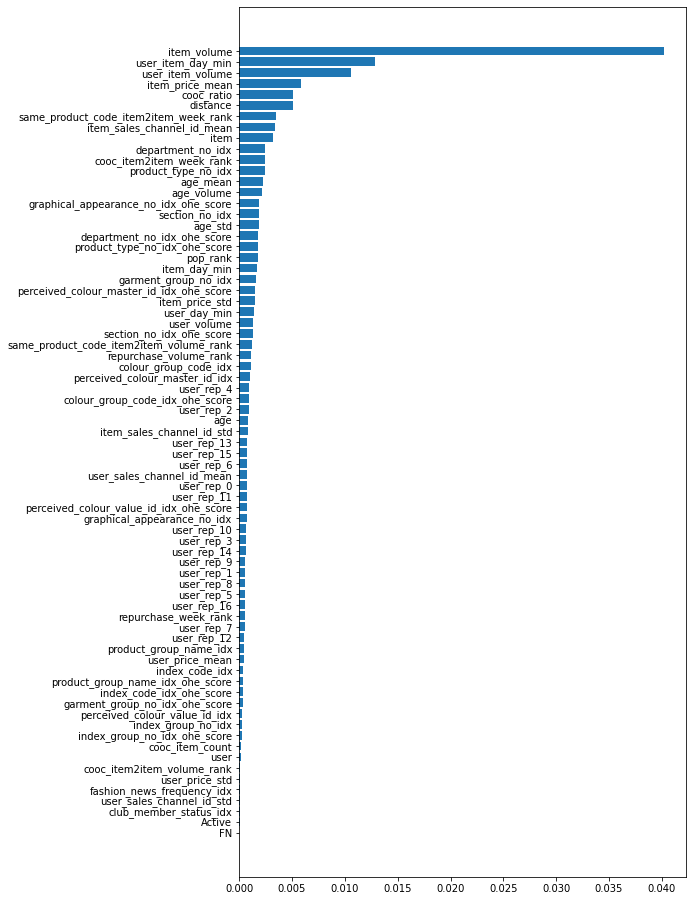

In [17]:
if CFG.model_type == 'LightGBM':
    group_train = get_query_group(train)
    group_valid = get_query_group(valid)

    train_dataset = lgb.Dataset(train[feature_columns], train['y'], group=group_train)
    valid_dataset = lgb.Dataset(valid[feature_columns], valid['y'], group=group_valid, reference=train_dataset)

    params = {
        'objective': 'xendcg',
        'boosting_type': 'gbdt',
        'learning_rate': 1e-6,
        'num_leaves': 255,
        'min_data_in_leaf': 100,
        'metric': 'map',
        'eval_at': 12,
    }

    model = lgb.train(params, train_dataset, valid_sets=[train_dataset, valid_dataset], num_boost_round=1000, callbacks=[lgb.early_stopping(20)])

    lgb.plot_importance(model, importance_type='gain', figsize=(8, 16))

elif CFG.model_type == 'CatBoost':
    train_dataset = catboost.Pool(data=train[feature_columns], label=train['y'], group_id=train['query_group'], cat_features=cat_features)
    valid_dataset = catboost.Pool(data=valid[feature_columns], label=valid['y'], group_id=valid['query_group'], cat_features=cat_features)

    params = {
        'loss_function': 'YetiRank',
        'use_best_model': True,
        'one_hot_max_size': 300,
        'iterations': 5000,
    }
    model = catboost.CatBoost(params)
    model.fit(train_dataset, eval_set=valid_dataset)

    feature_importance = model.get_feature_importance(train_dataset)
    sorted_idx = np.argsort(feature_importance)
    plt.figure(figsize=(8, 16))
    plt.yticks(range(len(feature_columns)), np.array(feature_columns)[sorted_idx])
    plt.barh(range(len(feature_columns)), feature_importance[sorted_idx])


del train, valid, train_dataset, valid_dataset
gc.collect()
with open('output/model_for_validation.pkl', 'wb') as f:
    pickle.dump(model, f)

In [18]:
pred = dataset_valid_all[['user', 'item']].reset_index(drop=True)
pred['pred'] = model.predict(dataset_valid_all[feature_columns])

pred = pred.groupby(['user', 'item'])['pred'].max().reset_index()
pred = pred.sort_values(by=['user', 'pred'], ascending=False).reset_index(drop=True).groupby('user')['item'].apply(lambda x: list(x)[:12]).reset_index()

gt = transactions.query("week == 0").groupby('user')['item'].apply(list).reset_index().rename(columns={'item': 'gt'})
merged = gt.merge(pred, on='user', how='left')
merged['item'] = merged['item'].fillna('').apply(list)

merged.to_pickle(f'output/merged_{dataset}.pkl')
dataset_valid_all.to_pickle(f'output/valid_all_{dataset}.pkl')

print('mAP@12:', mapk(merged['gt'], merged['item']))

mAP@12: 0.034759548877265546


In [19]:
# assert False

submission

In [20]:
datasets = [attach_features(transactions, users, items, candidates[idx], 1+idx, CFG.train_weeks) for idx in range(len(candidates))]

for idx in range(len(datasets)):
    datasets[idx]['query_group'] = datasets[idx]['week'].astype(str) + '_' + datasets[idx]['user'].astype(str)
    datasets[idx] = datasets[idx].sort_values(by='query_group').reset_index(drop=True)

train = concat_train(datasets, 0, CFG.train_weeks)

attach features (week: 1)


[user static fetaures] 0.604 s


[item stacic features] 1.418 s


[user dynamic features (transactions)] 1.246 s


[item dynamic features (transactions)] 1.028 s


[item dynamic features (user features)] 1.469 s


[item freshness features] 2.884 s


[item volume features] 0.992 s


[user freshness features] 4.078 s


[user volume features] 1.147 s


[user-item freshness features] 20.849 s


[user-item volume features] 1.929 s


[item age volume features] 2.250 s


[ohe dot products] 64.319 s


[lfm features] 3.166 s
attach features (week: 2)


[user static fetaures] 0.639 s


[item stacic features] 1.483 s


[user dynamic features (transactions)] 1.291 s


[item dynamic features (transactions)] 1.063 s


[item dynamic features (user features)] 1.595 s


[item freshness features] 2.923 s


[item volume features] 1.085 s


[user freshness features] 4.131 s


[user volume features] 1.211 s


[user-item freshness features] 20.756 s


[user-item volume features] 2.058 s


[item age volume features] 2.291 s


[ohe dot products] 72.794 s


[lfm features] 3.078 s
attach features (week: 3)


[user static fetaures] 0.680 s


[item stacic features] 1.594 s


[user dynamic features (transactions)] 1.370 s


[item dynamic features (transactions)] 1.124 s


[item dynamic features (user features)] 1.657 s


[item freshness features] 2.981 s


[item volume features] 1.141 s


[user freshness features] 4.203 s


[user volume features] 1.300 s


[user-item freshness features] 21.171 s


[user-item volume features] 2.133 s


[item age volume features] 2.464 s


[ohe dot products] 89.933 s


[lfm features] 3.757 s
attach features (week: 4)


[user static fetaures] 0.720 s


[item stacic features] 1.726 s


[user dynamic features (transactions)] 1.482 s


[item dynamic features (transactions)] 1.225 s


[item dynamic features (user features)] 1.723 s


[item freshness features] 3.023 s


[item volume features] 1.201 s


[user freshness features] 4.242 s


[user volume features] 1.366 s


[user-item freshness features] 21.083 s


[user-item volume features] 2.299 s


[item age volume features] 2.559 s


[ohe dot products] 95.136 s


[lfm features] 3.938 s
attach features (week: 5)


[user static fetaures] 0.643 s


[item stacic features] 1.521 s


[user dynamic features (transactions)] 1.385 s


[item dynamic features (transactions)] 1.150 s


[item dynamic features (user features)] 1.675 s


[item freshness features] 2.890 s


[item volume features] 1.082 s


[user freshness features] 4.056 s


[user volume features] 1.235 s


[user-item freshness features] 20.976 s


[user-item volume features] 2.035 s


[item age volume features] 2.378 s


[ohe dot products] 65.626 s


[lfm features] 3.891 s


0:	total: 3.24s	remaining: 4h 29m 54s


1:	total: 6.28s	remaining: 4h 21m 25s


2:	total: 9.34s	remaining: 4h 19m


3:	total: 12.4s	remaining: 4h 18m 40s


4:	total: 15.5s	remaining: 4h 17m 51s


5:	total: 18.7s	remaining: 4h 18m 58s


6:	total: 21.8s	remaining: 4h 18m 33s


7:	total: 24.9s	remaining: 4h 19m 13s


8:	total: 28.1s	remaining: 4h 19m 27s


9:	total: 31.2s	remaining: 4h 19m 14s


10:	total: 34.3s	remaining: 4h 19m 13s


11:	total: 37.5s	remaining: 4h 19m 39s


12:	total: 40.7s	remaining: 4h 19m 57s


13:	total: 43.9s	remaining: 4h 20m 7s


14:	total: 47s	remaining: 4h 20m 17s


15:	total: 50.2s	remaining: 4h 20m 23s


16:	total: 53.3s	remaining: 4h 20m 13s


17:	total: 56.5s	remaining: 4h 20m 25s


18:	total: 59.7s	remaining: 4h 20m 36s


19:	total: 1m 2s	remaining: 4h 21m


20:	total: 1m 6s	remaining: 4h 20m 57s


21:	total: 1m 9s	remaining: 4h 21m 23s


22:	total: 1m 12s	remaining: 4h 21m 31s


23:	total: 1m 15s	remaining: 4h 22m 5s


24:	total: 1m 19s	remaining: 4h 22m 14s


25:	total: 1m 22s	remaining: 4h 22m 23s


26:	total: 1m 25s	remaining: 4h 22m 7s


27:	total: 1m 28s	remaining: 4h 22m 14s


28:	total: 1m 31s	remaining: 4h 22m 27s


29:	total: 1m 35s	remaining: 4h 22m 15s


30:	total: 1m 38s	remaining: 4h 22m 29s


31:	total: 1m 41s	remaining: 4h 22m 48s


32:	total: 1m 44s	remaining: 4h 23m 1s


33:	total: 1m 48s	remaining: 4h 23m


34:	total: 1m 51s	remaining: 4h 23m 2s


35:	total: 1m 54s	remaining: 4h 22m 50s


36:	total: 1m 57s	remaining: 4h 22m 55s


37:	total: 2m	remaining: 4h 22m 59s


38:	total: 2m 4s	remaining: 4h 22m 54s


39:	total: 2m 7s	remaining: 4h 23m 2s


40:	total: 2m 10s	remaining: 4h 22m 56s


41:	total: 2m 13s	remaining: 4h 23m 4s


42:	total: 2m 16s	remaining: 4h 22m 59s


43:	total: 2m 20s	remaining: 4h 22m 55s


44:	total: 2m 23s	remaining: 4h 22m 57s


45:	total: 2m 26s	remaining: 4h 22m 51s


46:	total: 2m 29s	remaining: 4h 22m 46s


47:	total: 2m 32s	remaining: 4h 22m 44s


48:	total: 2m 36s	remaining: 4h 22m 42s


49:	total: 2m 39s	remaining: 4h 22m 35s


50:	total: 2m 42s	remaining: 4h 22m 23s


51:	total: 2m 45s	remaining: 4h 22m 17s


52:	total: 2m 48s	remaining: 4h 22m 16s


53:	total: 2m 51s	remaining: 4h 22m 10s


54:	total: 2m 55s	remaining: 4h 22m 2s


55:	total: 2m 58s	remaining: 4h 22m 4s


56:	total: 3m 1s	remaining: 4h 22m 6s


57:	total: 3m 4s	remaining: 4h 22m 2s


58:	total: 3m 7s	remaining: 4h 22m 1s


59:	total: 3m 10s	remaining: 4h 21m 52s


60:	total: 3m 14s	remaining: 4h 21m 41s


61:	total: 3m 17s	remaining: 4h 21m 43s


62:	total: 3m 20s	remaining: 4h 21m 37s


63:	total: 3m 23s	remaining: 4h 21m 32s


64:	total: 3m 26s	remaining: 4h 21m 38s


65:	total: 3m 30s	remaining: 4h 21m 34s


66:	total: 3m 33s	remaining: 4h 21m 29s


67:	total: 3m 36s	remaining: 4h 21m 23s


68:	total: 3m 39s	remaining: 4h 21m 34s


69:	total: 3m 43s	remaining: 4h 21m 35s


70:	total: 3m 46s	remaining: 4h 21m 30s


71:	total: 3m 49s	remaining: 4h 21m 29s


72:	total: 3m 52s	remaining: 4h 21m 23s


73:	total: 3m 55s	remaining: 4h 21m 29s


74:	total: 3m 58s	remaining: 4h 21m 18s


75:	total: 4m 2s	remaining: 4h 21m 14s


76:	total: 4m 5s	remaining: 4h 21m 13s


77:	total: 4m 8s	remaining: 4h 21m 18s


78:	total: 4m 11s	remaining: 4h 21m 13s


79:	total: 4m 14s	remaining: 4h 21m 2s


80:	total: 4m 17s	remaining: 4h 20m 52s


81:	total: 4m 21s	remaining: 4h 20m 50s


82:	total: 4m 24s	remaining: 4h 20m 50s


83:	total: 4m 27s	remaining: 4h 20m 37s


84:	total: 4m 30s	remaining: 4h 20m 34s


85:	total: 4m 33s	remaining: 4h 20m 28s


86:	total: 4m 36s	remaining: 4h 20m 24s


87:	total: 4m 40s	remaining: 4h 20m 21s


88:	total: 4m 43s	remaining: 4h 20m 20s


89:	total: 4m 46s	remaining: 4h 20m 21s


90:	total: 4m 49s	remaining: 4h 20m 16s


91:	total: 4m 52s	remaining: 4h 20m 7s


92:	total: 4m 56s	remaining: 4h 20m 12s


93:	total: 4m 59s	remaining: 4h 20m 10s


94:	total: 5m 2s	remaining: 4h 20m 5s


95:	total: 5m 5s	remaining: 4h 20m 8s


96:	total: 5m 9s	remaining: 4h 20m 10s


97:	total: 5m 12s	remaining: 4h 20m 4s


98:	total: 5m 15s	remaining: 4h 20m


99:	total: 5m 18s	remaining: 4h 19m 53s


100:	total: 5m 21s	remaining: 4h 19m 47s


101:	total: 5m 24s	remaining: 4h 19m 53s


102:	total: 5m 28s	remaining: 4h 19m 48s


103:	total: 5m 31s	remaining: 4h 19m 51s


104:	total: 5m 34s	remaining: 4h 19m 54s


105:	total: 5m 37s	remaining: 4h 19m 50s


106:	total: 5m 41s	remaining: 4h 19m 47s


107:	total: 5m 44s	remaining: 4h 19m 39s


108:	total: 5m 47s	remaining: 4h 19m 28s


109:	total: 5m 50s	remaining: 4h 19m 22s


110:	total: 5m 53s	remaining: 4h 19m 15s


111:	total: 5m 56s	remaining: 4h 19m 10s


112:	total: 5m 59s	remaining: 4h 19m 6s


113:	total: 6m 2s	remaining: 4h 18m 53s


114:	total: 6m 6s	remaining: 4h 18m 55s


115:	total: 6m 9s	remaining: 4h 18m 45s


116:	total: 6m 12s	remaining: 4h 18m 38s


117:	total: 6m 15s	remaining: 4h 18m 29s


118:	total: 6m 18s	remaining: 4h 18m 30s


119:	total: 6m 21s	remaining: 4h 18m 28s


120:	total: 6m 24s	remaining: 4h 18m 22s


121:	total: 6m 28s	remaining: 4h 18m 23s


122:	total: 6m 31s	remaining: 4h 18m 16s


123:	total: 6m 34s	remaining: 4h 18m 15s


124:	total: 6m 37s	remaining: 4h 18m 16s


125:	total: 6m 41s	remaining: 4h 18m 20s


126:	total: 6m 44s	remaining: 4h 18m 21s


127:	total: 6m 47s	remaining: 4h 18m 15s


128:	total: 6m 50s	remaining: 4h 18m 8s


129:	total: 6m 53s	remaining: 4h 17m 59s


130:	total: 6m 56s	remaining: 4h 17m 55s


131:	total: 6m 59s	remaining: 4h 17m 48s


132:	total: 7m 2s	remaining: 4h 17m 39s


133:	total: 7m 5s	remaining: 4h 17m 34s


134:	total: 7m 9s	remaining: 4h 17m 32s


135:	total: 7m 12s	remaining: 4h 17m 27s


136:	total: 7m 15s	remaining: 4h 17m 26s


137:	total: 7m 18s	remaining: 4h 17m 17s


138:	total: 7m 21s	remaining: 4h 17m 16s


139:	total: 7m 25s	remaining: 4h 17m 19s


140:	total: 7m 28s	remaining: 4h 17m 13s


141:	total: 7m 31s	remaining: 4h 17m 14s


142:	total: 7m 34s	remaining: 4h 17m 8s


143:	total: 7m 37s	remaining: 4h 17m 8s


144:	total: 7m 41s	remaining: 4h 17m 4s


145:	total: 7m 44s	remaining: 4h 17m 4s


146:	total: 7m 47s	remaining: 4h 17m 2s


147:	total: 7m 50s	remaining: 4h 16m 56s


148:	total: 7m 53s	remaining: 4h 16m 49s


149:	total: 7m 56s	remaining: 4h 16m 43s


150:	total: 7m 59s	remaining: 4h 16m 40s


151:	total: 8m 3s	remaining: 4h 16m 39s


152:	total: 8m 6s	remaining: 4h 16m 36s


153:	total: 8m 9s	remaining: 4h 16m 26s


154:	total: 8m 12s	remaining: 4h 16m 28s


155:	total: 8m 15s	remaining: 4h 16m 26s


156:	total: 8m 19s	remaining: 4h 16m 20s


157:	total: 8m 22s	remaining: 4h 16m 12s


158:	total: 8m 25s	remaining: 4h 16m 6s


159:	total: 8m 28s	remaining: 4h 16m 9s


160:	total: 8m 31s	remaining: 4h 16m 5s


161:	total: 8m 34s	remaining: 4h 16m


162:	total: 8m 37s	remaining: 4h 15m 50s


163:	total: 8m 40s	remaining: 4h 15m 43s


164:	total: 8m 43s	remaining: 4h 15m 38s


165:	total: 8m 47s	remaining: 4h 15m 35s


166:	total: 8m 50s	remaining: 4h 15m 27s


167:	total: 8m 53s	remaining: 4h 15m 19s


168:	total: 8m 56s	remaining: 4h 15m 15s


169:	total: 8m 59s	remaining: 4h 15m 14s


170:	total: 9m 2s	remaining: 4h 15m 10s


171:	total: 9m 5s	remaining: 4h 15m 5s


172:	total: 9m 8s	remaining: 4h 14m 57s


173:	total: 9m 11s	remaining: 4h 14m 54s


174:	total: 9m 14s	remaining: 4h 14m 47s


175:	total: 9m 18s	remaining: 4h 14m 44s


176:	total: 9m 21s	remaining: 4h 14m 38s


177:	total: 9m 24s	remaining: 4h 14m 31s


178:	total: 9m 27s	remaining: 4h 14m 28s


179:	total: 9m 30s	remaining: 4h 14m 22s


180:	total: 9m 33s	remaining: 4h 14m 22s


181:	total: 9m 37s	remaining: 4h 14m 26s


182:	total: 9m 40s	remaining: 4h 14m 26s


183:	total: 9m 43s	remaining: 4h 14m 20s


184:	total: 9m 46s	remaining: 4h 14m 17s


185:	total: 9m 49s	remaining: 4h 14m 12s


186:	total: 9m 53s	remaining: 4h 14m 14s


187:	total: 9m 56s	remaining: 4h 14m 10s


188:	total: 9m 59s	remaining: 4h 14m 9s


189:	total: 10m 2s	remaining: 4h 14m 5s


190:	total: 10m 5s	remaining: 4h 13m 56s


191:	total: 10m 8s	remaining: 4h 13m 49s


192:	total: 10m 11s	remaining: 4h 13m 47s


193:	total: 10m 14s	remaining: 4h 13m 41s


194:	total: 10m 18s	remaining: 4h 13m 36s


195:	total: 10m 21s	remaining: 4h 13m 31s


196:	total: 10m 24s	remaining: 4h 13m 27s


197:	total: 10m 27s	remaining: 4h 13m 23s


198:	total: 10m 30s	remaining: 4h 13m 19s


199:	total: 10m 33s	remaining: 4h 13m 13s


200:	total: 10m 36s	remaining: 4h 13m 9s


201:	total: 10m 40s	remaining: 4h 13m 10s


202:	total: 10m 43s	remaining: 4h 13m 5s


203:	total: 10m 46s	remaining: 4h 12m 58s


204:	total: 10m 49s	remaining: 4h 12m 53s


205:	total: 10m 52s	remaining: 4h 12m 53s


206:	total: 10m 55s	remaining: 4h 12m 54s


207:	total: 10m 59s	remaining: 4h 12m 52s


208:	total: 11m 2s	remaining: 4h 12m 49s


209:	total: 11m 5s	remaining: 4h 12m 50s


210:	total: 11m 8s	remaining: 4h 12m 46s


211:	total: 11m 12s	remaining: 4h 12m 45s


212:	total: 11m 15s	remaining: 4h 12m 43s


213:	total: 11m 18s	remaining: 4h 12m 38s


214:	total: 11m 21s	remaining: 4h 12m 30s


215:	total: 11m 24s	remaining: 4h 12m 25s


216:	total: 11m 27s	remaining: 4h 12m 19s


217:	total: 11m 30s	remaining: 4h 12m 12s


218:	total: 11m 33s	remaining: 4h 12m 6s


219:	total: 11m 36s	remaining: 4h 12m


220:	total: 11m 39s	remaining: 4h 11m 57s


221:	total: 11m 42s	remaining: 4h 11m 53s


222:	total: 11m 45s	remaining: 4h 11m 45s


223:	total: 11m 48s	remaining: 4h 11m 43s


224:	total: 11m 52s	remaining: 4h 11m 41s


225:	total: 11m 55s	remaining: 4h 11m 40s


226:	total: 11m 58s	remaining: 4h 11m 39s


227:	total: 12m 1s	remaining: 4h 11m 36s


228:	total: 12m 4s	remaining: 4h 11m 31s


229:	total: 12m 7s	remaining: 4h 11m 24s


230:	total: 12m 11s	remaining: 4h 11m 24s


231:	total: 12m 14s	remaining: 4h 11m 24s


232:	total: 12m 17s	remaining: 4h 11m 23s


233:	total: 12m 20s	remaining: 4h 11m 16s


234:	total: 12m 23s	remaining: 4h 11m 8s


235:	total: 12m 27s	remaining: 4h 11m 8s


236:	total: 12m 30s	remaining: 4h 11m 2s


237:	total: 12m 33s	remaining: 4h 10m 58s


238:	total: 12m 36s	remaining: 4h 10m 54s


239:	total: 12m 39s	remaining: 4h 10m 48s


240:	total: 12m 42s	remaining: 4h 10m 46s


241:	total: 12m 45s	remaining: 4h 10m 44s


242:	total: 12m 49s	remaining: 4h 10m 43s


243:	total: 12m 52s	remaining: 4h 10m 39s


244:	total: 12m 55s	remaining: 4h 10m 30s


245:	total: 12m 58s	remaining: 4h 10m 27s


246:	total: 13m 1s	remaining: 4h 10m 22s


247:	total: 13m 4s	remaining: 4h 10m 22s


248:	total: 13m 7s	remaining: 4h 10m 16s


249:	total: 13m 10s	remaining: 4h 10m 12s


250:	total: 13m 13s	remaining: 4h 10m 7s


251:	total: 13m 17s	remaining: 4h 10m 8s


252:	total: 13m 20s	remaining: 4h 10m 4s


253:	total: 13m 23s	remaining: 4h 10m 5s


254:	total: 13m 26s	remaining: 4h 10m 1s


255:	total: 13m 30s	remaining: 4h 10m 1s


256:	total: 13m 33s	remaining: 4h 9m 58s


257:	total: 13m 36s	remaining: 4h 9m 54s


258:	total: 13m 39s	remaining: 4h 9m 50s


259:	total: 13m 42s	remaining: 4h 9m 43s


260:	total: 13m 45s	remaining: 4h 9m 40s


261:	total: 13m 48s	remaining: 4h 9m 35s


262:	total: 13m 51s	remaining: 4h 9m 31s


263:	total: 13m 55s	remaining: 4h 9m 28s


264:	total: 13m 58s	remaining: 4h 9m 21s


265:	total: 14m 1s	remaining: 4h 9m 21s


266:	total: 14m 4s	remaining: 4h 9m 22s


267:	total: 14m 7s	remaining: 4h 9m 18s


268:	total: 14m 11s	remaining: 4h 9m 17s


269:	total: 14m 14s	remaining: 4h 9m 16s


270:	total: 14m 17s	remaining: 4h 9m 10s


271:	total: 14m 20s	remaining: 4h 9m 8s


272:	total: 14m 23s	remaining: 4h 9m 2s


273:	total: 14m 26s	remaining: 4h 8m 58s


274:	total: 14m 30s	remaining: 4h 8m 55s


275:	total: 14m 33s	remaining: 4h 8m 49s


276:	total: 14m 36s	remaining: 4h 8m 47s


277:	total: 14m 39s	remaining: 4h 8m 41s


278:	total: 14m 42s	remaining: 4h 8m 35s


279:	total: 14m 45s	remaining: 4h 8m 29s


280:	total: 14m 48s	remaining: 4h 8m 26s


281:	total: 14m 51s	remaining: 4h 8m 23s


282:	total: 14m 54s	remaining: 4h 8m 20s


283:	total: 14m 57s	remaining: 4h 8m 14s


284:	total: 15m	remaining: 4h 8m 8s


285:	total: 15m 3s	remaining: 4h 8m 6s


286:	total: 15m 7s	remaining: 4h 8m 6s


287:	total: 15m 10s	remaining: 4h 8m 4s


288:	total: 15m 13s	remaining: 4h 7m 58s


289:	total: 15m 16s	remaining: 4h 7m 54s


290:	total: 15m 19s	remaining: 4h 7m 50s


291:	total: 15m 22s	remaining: 4h 7m 48s


292:	total: 15m 25s	remaining: 4h 7m 42s


293:	total: 15m 29s	remaining: 4h 7m 38s


294:	total: 15m 32s	remaining: 4h 7m 33s


295:	total: 15m 35s	remaining: 4h 7m 29s


296:	total: 15m 38s	remaining: 4h 7m 24s


297:	total: 15m 41s	remaining: 4h 7m 18s


298:	total: 15m 44s	remaining: 4h 7m 14s


299:	total: 15m 47s	remaining: 4h 7m 8s


300:	total: 15m 50s	remaining: 4h 7m 3s


301:	total: 15m 53s	remaining: 4h 6m 59s


302:	total: 15m 56s	remaining: 4h 6m 57s


303:	total: 15m 59s	remaining: 4h 6m 53s


304:	total: 16m 2s	remaining: 4h 6m 49s


305:	total: 16m 5s	remaining: 4h 6m 42s


306:	total: 16m 9s	remaining: 4h 6m 40s


307:	total: 16m 12s	remaining: 4h 6m 35s


308:	total: 16m 15s	remaining: 4h 6m 31s


309:	total: 16m 18s	remaining: 4h 6m 25s


310:	total: 16m 21s	remaining: 4h 6m 20s


311:	total: 16m 24s	remaining: 4h 6m 16s


312:	total: 16m 27s	remaining: 4h 6m 12s


313:	total: 16m 30s	remaining: 4h 6m 10s


314:	total: 16m 33s	remaining: 4h 6m 8s


315:	total: 16m 36s	remaining: 4h 6m 4s


316:	total: 16m 39s	remaining: 4h 6m


317:	total: 16m 43s	remaining: 4h 5m 56s


318:	total: 16m 46s	remaining: 4h 5m 55s


319:	total: 16m 49s	remaining: 4h 5m 55s


320:	total: 16m 52s	remaining: 4h 5m 51s


321:	total: 16m 56s	remaining: 4h 5m 49s


322:	total: 16m 59s	remaining: 4h 5m 45s


323:	total: 17m 2s	remaining: 4h 5m 42s


324:	total: 17m 5s	remaining: 4h 5m 39s


325:	total: 17m 8s	remaining: 4h 5m 33s


326:	total: 17m 11s	remaining: 4h 5m 30s


327:	total: 17m 14s	remaining: 4h 5m 23s


328:	total: 17m 17s	remaining: 4h 5m 18s


329:	total: 17m 20s	remaining: 4h 5m 14s


330:	total: 17m 23s	remaining: 4h 5m 10s


331:	total: 17m 27s	remaining: 4h 5m 8s


332:	total: 17m 30s	remaining: 4h 5m 4s


333:	total: 17m 33s	remaining: 4h 5m 2s


334:	total: 17m 36s	remaining: 4h 4m 55s


335:	total: 17m 39s	remaining: 4h 4m 49s


336:	total: 17m 42s	remaining: 4h 4m 47s


337:	total: 17m 45s	remaining: 4h 4m 45s


338:	total: 17m 48s	remaining: 4h 4m 42s


339:	total: 17m 51s	remaining: 4h 4m 39s


340:	total: 17m 55s	remaining: 4h 4m 35s


341:	total: 17m 58s	remaining: 4h 4m 30s


342:	total: 18m 1s	remaining: 4h 4m 25s


343:	total: 18m 4s	remaining: 4h 4m 22s


344:	total: 18m 7s	remaining: 4h 4m 19s


345:	total: 18m 10s	remaining: 4h 4m 11s


346:	total: 18m 13s	remaining: 4h 4m 6s


347:	total: 18m 16s	remaining: 4h 4m 3s


348:	total: 18m 19s	remaining: 4h 4m 1s


349:	total: 18m 22s	remaining: 4h 3m 56s


350:	total: 18m 25s	remaining: 4h 3m 53s


351:	total: 18m 28s	remaining: 4h 3m 50s


352:	total: 18m 32s	remaining: 4h 3m 48s


353:	total: 18m 35s	remaining: 4h 3m 44s


354:	total: 18m 38s	remaining: 4h 3m 39s


355:	total: 18m 41s	remaining: 4h 3m 36s


356:	total: 18m 44s	remaining: 4h 3m 32s


357:	total: 18m 47s	remaining: 4h 3m 27s


358:	total: 18m 50s	remaining: 4h 3m 22s


359:	total: 18m 53s	remaining: 4h 3m 18s


360:	total: 18m 56s	remaining: 4h 3m 16s


361:	total: 19m	remaining: 4h 3m 13s


362:	total: 19m 3s	remaining: 4h 3m 9s


363:	total: 19m 6s	remaining: 4h 3m 3s


364:	total: 19m 9s	remaining: 4h 3m 2s


365:	total: 19m 12s	remaining: 4h 2m 56s


366:	total: 19m 15s	remaining: 4h 2m 54s


367:	total: 19m 18s	remaining: 4h 2m 48s


368:	total: 19m 21s	remaining: 4h 2m 46s


369:	total: 19m 24s	remaining: 4h 2m 44s


370:	total: 19m 28s	remaining: 4h 2m 41s


371:	total: 19m 31s	remaining: 4h 2m 36s


372:	total: 19m 34s	remaining: 4h 2m 32s


373:	total: 19m 37s	remaining: 4h 2m 30s


374:	total: 19m 40s	remaining: 4h 2m 28s


375:	total: 19m 43s	remaining: 4h 2m 22s


376:	total: 19m 46s	remaining: 4h 2m 19s


377:	total: 19m 49s	remaining: 4h 2m 15s


378:	total: 19m 53s	remaining: 4h 2m 13s


379:	total: 19m 56s	remaining: 4h 2m 10s


380:	total: 19m 59s	remaining: 4h 2m 8s


381:	total: 20m 2s	remaining: 4h 2m 7s


382:	total: 20m 5s	remaining: 4h 2m 4s


383:	total: 20m 9s	remaining: 4h 2m 1s


384:	total: 20m 12s	remaining: 4h 1m 57s


385:	total: 20m 15s	remaining: 4h 1m 51s


386:	total: 20m 18s	remaining: 4h 1m 48s


387:	total: 20m 21s	remaining: 4h 1m 46s


388:	total: 20m 24s	remaining: 4h 1m 43s


389:	total: 20m 27s	remaining: 4h 1m 39s


390:	total: 20m 31s	remaining: 4h 1m 39s


391:	total: 20m 34s	remaining: 4h 1m 35s


392:	total: 20m 37s	remaining: 4h 1m 31s


393:	total: 20m 40s	remaining: 4h 1m 29s


394:	total: 20m 43s	remaining: 4h 1m 25s


395:	total: 20m 46s	remaining: 4h 1m 21s


396:	total: 20m 49s	remaining: 4h 1m 18s


397:	total: 20m 52s	remaining: 4h 1m 14s


398:	total: 20m 56s	remaining: 4h 1m 11s


399:	total: 20m 59s	remaining: 4h 1m 8s


400:	total: 21m 2s	remaining: 4h 1m 3s


401:	total: 21m 5s	remaining: 4h 1m


402:	total: 21m 8s	remaining: 4h 55s


403:	total: 21m 11s	remaining: 4h 50s


404:	total: 21m 14s	remaining: 4h 47s


405:	total: 21m 17s	remaining: 4h 44s


406:	total: 21m 20s	remaining: 4h 40s


407:	total: 21m 24s	remaining: 4h 39s


408:	total: 21m 27s	remaining: 4h 35s


409:	total: 21m 30s	remaining: 4h 32s


410:	total: 21m 33s	remaining: 4h 27s


411:	total: 21m 36s	remaining: 4h 25s


412:	total: 21m 39s	remaining: 4h 22s


413:	total: 21m 42s	remaining: 4h 19s


414:	total: 21m 46s	remaining: 4h 19s


415:	total: 21m 49s	remaining: 4h 15s


416:	total: 21m 52s	remaining: 4h 11s


417:	total: 21m 55s	remaining: 4h 8s


418:	total: 21m 58s	remaining: 4h 4s


419:	total: 22m 1s	remaining: 4h 1s


420:	total: 22m 4s	remaining: 3h 59m 57s


421:	total: 22m 8s	remaining: 3h 59m 54s


422:	total: 22m 11s	remaining: 3h 59m 51s


423:	total: 22m 14s	remaining: 3h 59m 45s


424:	total: 22m 17s	remaining: 3h 59m 41s


425:	total: 22m 20s	remaining: 3h 59m 38s


426:	total: 22m 23s	remaining: 3h 59m 36s


427:	total: 22m 26s	remaining: 3h 59m 32s


428:	total: 22m 29s	remaining: 3h 59m 29s


429:	total: 22m 32s	remaining: 3h 59m 23s


430:	total: 22m 35s	remaining: 3h 59m 19s


431:	total: 22m 38s	remaining: 3h 59m 15s


432:	total: 22m 41s	remaining: 3h 59m 12s


433:	total: 22m 45s	remaining: 3h 59m 9s


434:	total: 22m 48s	remaining: 3h 59m 5s


435:	total: 22m 51s	remaining: 3h 59m 2s


436:	total: 22m 54s	remaining: 3h 58m 58s


437:	total: 22m 57s	remaining: 3h 58m 55s


438:	total: 23m	remaining: 3h 58m 52s


439:	total: 23m 3s	remaining: 3h 58m 48s


440:	total: 23m 6s	remaining: 3h 58m 43s


441:	total: 23m 10s	remaining: 3h 58m 41s


442:	total: 23m 13s	remaining: 3h 58m 39s


443:	total: 23m 16s	remaining: 3h 58m 34s


444:	total: 23m 19s	remaining: 3h 58m 30s


445:	total: 23m 22s	remaining: 3h 58m 26s


446:	total: 23m 25s	remaining: 3h 58m 23s


447:	total: 23m 28s	remaining: 3h 58m 21s


448:	total: 23m 31s	remaining: 3h 58m 18s


449:	total: 23m 35s	remaining: 3h 58m 15s


450:	total: 23m 38s	remaining: 3h 58m 13s


451:	total: 23m 41s	remaining: 3h 58m 8s


452:	total: 23m 44s	remaining: 3h 58m 4s


453:	total: 23m 47s	remaining: 3h 58m 1s


454:	total: 23m 50s	remaining: 3h 57m 59s


455:	total: 23m 54s	remaining: 3h 57m 57s


456:	total: 23m 57s	remaining: 3h 57m 54s


457:	total: 24m	remaining: 3h 57m 51s


458:	total: 24m 3s	remaining: 3h 57m 47s


459:	total: 24m 6s	remaining: 3h 57m 43s


460:	total: 24m 9s	remaining: 3h 57m 41s


461:	total: 24m 12s	remaining: 3h 57m 36s


462:	total: 24m 15s	remaining: 3h 57m 33s


463:	total: 24m 18s	remaining: 3h 57m 29s


464:	total: 24m 21s	remaining: 3h 57m 25s


465:	total: 24m 24s	remaining: 3h 57m 21s


466:	total: 24m 28s	remaining: 3h 57m 18s


467:	total: 24m 31s	remaining: 3h 57m 16s


468:	total: 24m 34s	remaining: 3h 57m 11s


469:	total: 24m 37s	remaining: 3h 57m 9s


470:	total: 24m 40s	remaining: 3h 57m 6s


471:	total: 24m 44s	remaining: 3h 57m 4s


472:	total: 24m 47s	remaining: 3h 57m 1s


473:	total: 24m 50s	remaining: 3h 56m 57s


474:	total: 24m 53s	remaining: 3h 56m 52s


475:	total: 24m 56s	remaining: 3h 56m 47s


476:	total: 24m 59s	remaining: 3h 56m 43s


477:	total: 25m 2s	remaining: 3h 56m 38s


478:	total: 25m 5s	remaining: 3h 56m 32s


479:	total: 25m 8s	remaining: 3h 56m 28s


480:	total: 25m 11s	remaining: 3h 56m 25s


481:	total: 25m 14s	remaining: 3h 56m 21s


482:	total: 25m 17s	remaining: 3h 56m 17s


483:	total: 25m 20s	remaining: 3h 56m 12s


484:	total: 25m 23s	remaining: 3h 56m 8s


485:	total: 25m 26s	remaining: 3h 56m 3s


486:	total: 25m 29s	remaining: 3h 55m 59s


487:	total: 25m 32s	remaining: 3h 55m 56s


488:	total: 25m 35s	remaining: 3h 55m 51s


489:	total: 25m 38s	remaining: 3h 55m 48s


490:	total: 25m 41s	remaining: 3h 55m 44s


491:	total: 25m 44s	remaining: 3h 55m 40s


492:	total: 25m 47s	remaining: 3h 55m 38s


493:	total: 25m 50s	remaining: 3h 55m 34s


494:	total: 25m 54s	remaining: 3h 55m 31s


495:	total: 25m 57s	remaining: 3h 55m 28s


496:	total: 26m	remaining: 3h 55m 23s


497:	total: 26m 3s	remaining: 3h 55m 19s


498:	total: 26m 6s	remaining: 3h 55m 17s


499:	total: 26m 9s	remaining: 3h 55m 13s


500:	total: 26m 12s	remaining: 3h 55m 9s


501:	total: 26m 15s	remaining: 3h 55m 7s


502:	total: 26m 18s	remaining: 3h 55m 3s


503:	total: 26m 21s	remaining: 3h 54m 58s


504:	total: 26m 25s	remaining: 3h 54m 55s


505:	total: 26m 28s	remaining: 3h 54m 52s


506:	total: 26m 31s	remaining: 3h 54m 49s


507:	total: 26m 34s	remaining: 3h 54m 46s


508:	total: 26m 37s	remaining: 3h 54m 43s


509:	total: 26m 40s	remaining: 3h 54m 37s


510:	total: 26m 43s	remaining: 3h 54m 35s


511:	total: 26m 46s	remaining: 3h 54m 31s


512:	total: 26m 49s	remaining: 3h 54m 27s


513:	total: 26m 52s	remaining: 3h 54m 23s


514:	total: 26m 56s	remaining: 3h 54m 20s


515:	total: 26m 59s	remaining: 3h 54m 18s


516:	total: 27m 2s	remaining: 3h 54m 14s


517:	total: 27m 5s	remaining: 3h 54m 11s


518:	total: 27m 8s	remaining: 3h 54m 8s


519:	total: 27m 11s	remaining: 3h 54m 6s


520:	total: 27m 15s	remaining: 3h 54m 3s


521:	total: 27m 18s	remaining: 3h 53m 59s


522:	total: 27m 21s	remaining: 3h 53m 56s


523:	total: 27m 24s	remaining: 3h 53m 52s


524:	total: 27m 27s	remaining: 3h 53m 49s


525:	total: 27m 30s	remaining: 3h 53m 45s


526:	total: 27m 33s	remaining: 3h 53m 42s


527:	total: 27m 36s	remaining: 3h 53m 39s


528:	total: 27m 39s	remaining: 3h 53m 34s


529:	total: 27m 42s	remaining: 3h 53m 30s


530:	total: 27m 45s	remaining: 3h 53m 27s


531:	total: 27m 48s	remaining: 3h 53m 23s


532:	total: 27m 51s	remaining: 3h 53m 19s


533:	total: 27m 54s	remaining: 3h 53m 13s


534:	total: 27m 57s	remaining: 3h 53m 10s


535:	total: 28m	remaining: 3h 53m 6s


536:	total: 28m 3s	remaining: 3h 53m 2s


537:	total: 28m 6s	remaining: 3h 52m 58s


538:	total: 28m 9s	remaining: 3h 52m 54s


539:	total: 28m 13s	remaining: 3h 52m 52s


540:	total: 28m 16s	remaining: 3h 52m 47s


541:	total: 28m 19s	remaining: 3h 52m 44s


542:	total: 28m 22s	remaining: 3h 52m 40s


543:	total: 28m 25s	remaining: 3h 52m 37s


544:	total: 28m 28s	remaining: 3h 52m 34s


545:	total: 28m 32s	remaining: 3h 52m 33s


546:	total: 28m 35s	remaining: 3h 52m 29s


547:	total: 28m 38s	remaining: 3h 52m 26s


548:	total: 28m 41s	remaining: 3h 52m 22s


549:	total: 28m 44s	remaining: 3h 52m 19s


550:	total: 28m 47s	remaining: 3h 52m 17s


551:	total: 28m 50s	remaining: 3h 52m 14s


552:	total: 28m 54s	remaining: 3h 52m 12s


553:	total: 28m 57s	remaining: 3h 52m 7s


554:	total: 29m	remaining: 3h 52m 4s


555:	total: 29m 3s	remaining: 3h 51m 59s


556:	total: 29m 6s	remaining: 3h 51m 57s


557:	total: 29m 9s	remaining: 3h 51m 53s


558:	total: 29m 12s	remaining: 3h 51m 49s


559:	total: 29m 15s	remaining: 3h 51m 47s


560:	total: 29m 18s	remaining: 3h 51m 44s


561:	total: 29m 21s	remaining: 3h 51m 41s


562:	total: 29m 25s	remaining: 3h 51m 38s


563:	total: 29m 28s	remaining: 3h 51m 35s


564:	total: 29m 31s	remaining: 3h 51m 31s


565:	total: 29m 34s	remaining: 3h 51m 28s


566:	total: 29m 37s	remaining: 3h 51m 25s


567:	total: 29m 40s	remaining: 3h 51m 23s


568:	total: 29m 44s	remaining: 3h 51m 21s


569:	total: 29m 47s	remaining: 3h 51m 16s


570:	total: 29m 50s	remaining: 3h 51m 14s


571:	total: 29m 53s	remaining: 3h 51m 12s


572:	total: 29m 56s	remaining: 3h 51m 8s


573:	total: 29m 59s	remaining: 3h 51m 4s


574:	total: 30m 2s	remaining: 3h 51m 1s


575:	total: 30m 6s	remaining: 3h 50m 59s


576:	total: 30m 9s	remaining: 3h 50m 55s


577:	total: 30m 12s	remaining: 3h 50m 52s


578:	total: 30m 15s	remaining: 3h 50m 49s


579:	total: 30m 18s	remaining: 3h 50m 46s


580:	total: 30m 21s	remaining: 3h 50m 42s


581:	total: 30m 24s	remaining: 3h 50m 39s


582:	total: 30m 27s	remaining: 3h 50m 35s


583:	total: 30m 30s	remaining: 3h 50m 31s


584:	total: 30m 34s	remaining: 3h 50m 28s


585:	total: 30m 37s	remaining: 3h 50m 24s


586:	total: 30m 40s	remaining: 3h 50m 21s


587:	total: 30m 43s	remaining: 3h 50m 17s


588:	total: 30m 46s	remaining: 3h 50m 13s


589:	total: 30m 49s	remaining: 3h 50m 9s


590:	total: 30m 52s	remaining: 3h 50m 6s


591:	total: 30m 55s	remaining: 3h 50m 3s


592:	total: 30m 58s	remaining: 3h 49m 59s


593:	total: 31m 1s	remaining: 3h 49m 58s


594:	total: 31m 4s	remaining: 3h 49m 53s


595:	total: 31m 8s	remaining: 3h 49m 51s


596:	total: 31m 11s	remaining: 3h 49m 48s


597:	total: 31m 14s	remaining: 3h 49m 45s


598:	total: 31m 17s	remaining: 3h 49m 43s


599:	total: 31m 21s	remaining: 3h 49m 41s


600:	total: 31m 24s	remaining: 3h 49m 39s


601:	total: 31m 27s	remaining: 3h 49m 35s


602:	total: 31m 30s	remaining: 3h 49m 31s


603:	total: 31m 33s	remaining: 3h 49m 27s


604:	total: 31m 36s	remaining: 3h 49m 24s


605:	total: 31m 39s	remaining: 3h 49m 21s


606:	total: 31m 42s	remaining: 3h 49m 17s


607:	total: 31m 45s	remaining: 3h 49m 14s


608:	total: 31m 48s	remaining: 3h 49m 10s


609:	total: 31m 51s	remaining: 3h 49m 6s


610:	total: 31m 54s	remaining: 3h 49m 2s


611:	total: 31m 57s	remaining: 3h 48m 58s


612:	total: 32m	remaining: 3h 48m 54s


613:	total: 32m 4s	remaining: 3h 48m 51s


614:	total: 32m 7s	remaining: 3h 48m 47s


615:	total: 32m 10s	remaining: 3h 48m 44s


616:	total: 32m 13s	remaining: 3h 48m 40s


617:	total: 32m 16s	remaining: 3h 48m 37s


618:	total: 32m 19s	remaining: 3h 48m 33s


619:	total: 32m 22s	remaining: 3h 48m 30s


620:	total: 32m 25s	remaining: 3h 48m 26s


621:	total: 32m 28s	remaining: 3h 48m 24s


622:	total: 32m 31s	remaining: 3h 48m 20s


623:	total: 32m 34s	remaining: 3h 48m 16s


624:	total: 32m 37s	remaining: 3h 48m 12s


625:	total: 32m 40s	remaining: 3h 48m 9s


626:	total: 32m 44s	remaining: 3h 48m 6s


627:	total: 32m 47s	remaining: 3h 48m 4s


628:	total: 32m 50s	remaining: 3h 48m 1s


629:	total: 32m 53s	remaining: 3h 47m 58s


630:	total: 32m 57s	remaining: 3h 47m 56s


631:	total: 33m	remaining: 3h 47m 54s


632:	total: 33m 3s	remaining: 3h 47m 53s


633:	total: 33m 6s	remaining: 3h 47m 49s


634:	total: 33m 9s	remaining: 3h 47m 46s


635:	total: 33m 12s	remaining: 3h 47m 42s


636:	total: 33m 15s	remaining: 3h 47m 38s


637:	total: 33m 19s	remaining: 3h 47m 35s


638:	total: 33m 22s	remaining: 3h 47m 31s


639:	total: 33m 25s	remaining: 3h 47m 28s


640:	total: 33m 28s	remaining: 3h 47m 25s


641:	total: 33m 31s	remaining: 3h 47m 23s


642:	total: 33m 34s	remaining: 3h 47m 19s


643:	total: 33m 37s	remaining: 3h 47m 16s


644:	total: 33m 41s	remaining: 3h 47m 14s


645:	total: 33m 44s	remaining: 3h 47m 12s


646:	total: 33m 47s	remaining: 3h 47m 10s


647:	total: 33m 50s	remaining: 3h 47m 7s


648:	total: 33m 53s	remaining: 3h 47m 3s


649:	total: 33m 57s	remaining: 3h 47m


650:	total: 34m	remaining: 3h 46m 57s


651:	total: 34m 3s	remaining: 3h 46m 54s


652:	total: 34m 6s	remaining: 3h 46m 51s


653:	total: 34m 9s	remaining: 3h 46m 47s


654:	total: 34m 12s	remaining: 3h 46m 43s


655:	total: 34m 15s	remaining: 3h 46m 41s


656:	total: 34m 18s	remaining: 3h 46m 38s


657:	total: 34m 22s	remaining: 3h 46m 35s


658:	total: 34m 25s	remaining: 3h 46m 31s


659:	total: 34m 28s	remaining: 3h 46m 29s


660:	total: 34m 31s	remaining: 3h 46m 27s


661:	total: 34m 34s	remaining: 3h 46m 22s


662:	total: 34m 37s	remaining: 3h 46m 18s


663:	total: 34m 40s	remaining: 3h 46m 14s


664:	total: 34m 43s	remaining: 3h 46m 10s


665:	total: 34m 46s	remaining: 3h 46m 7s


666:	total: 34m 49s	remaining: 3h 46m 4s


667:	total: 34m 53s	remaining: 3h 46m


668:	total: 34m 56s	remaining: 3h 45m 57s


669:	total: 34m 59s	remaining: 3h 45m 54s


670:	total: 35m 2s	remaining: 3h 45m 51s


671:	total: 35m 5s	remaining: 3h 45m 50s


672:	total: 35m 9s	remaining: 3h 45m 47s


673:	total: 35m 12s	remaining: 3h 45m 43s


674:	total: 35m 15s	remaining: 3h 45m 39s


675:	total: 35m 18s	remaining: 3h 45m 36s


676:	total: 35m 21s	remaining: 3h 45m 33s


677:	total: 35m 24s	remaining: 3h 45m 29s


678:	total: 35m 27s	remaining: 3h 45m 27s


679:	total: 35m 30s	remaining: 3h 45m 24s


680:	total: 35m 33s	remaining: 3h 45m 20s


681:	total: 35m 37s	remaining: 3h 45m 18s


682:	total: 35m 39s	remaining: 3h 45m 13s


683:	total: 35m 42s	remaining: 3h 45m 7s


684:	total: 35m 45s	remaining: 3h 45m 5s


685:	total: 35m 49s	remaining: 3h 45m 2s


686:	total: 35m 52s	remaining: 3h 44m 58s


687:	total: 35m 55s	remaining: 3h 44m 55s


688:	total: 35m 58s	remaining: 3h 44m 52s


689:	total: 36m 1s	remaining: 3h 44m 49s


690:	total: 36m 4s	remaining: 3h 44m 47s


691:	total: 36m 7s	remaining: 3h 44m 43s


692:	total: 36m 11s	remaining: 3h 44m 41s


693:	total: 36m 14s	remaining: 3h 44m 38s


694:	total: 36m 17s	remaining: 3h 44m 33s


695:	total: 36m 20s	remaining: 3h 44m 30s


696:	total: 36m 23s	remaining: 3h 44m 27s


697:	total: 36m 26s	remaining: 3h 44m 24s


698:	total: 36m 29s	remaining: 3h 44m 20s


699:	total: 36m 32s	remaining: 3h 44m 15s


700:	total: 36m 35s	remaining: 3h 44m 12s


701:	total: 36m 38s	remaining: 3h 44m 9s


702:	total: 36m 41s	remaining: 3h 44m 5s


703:	total: 36m 44s	remaining: 3h 44m 1s


704:	total: 36m 47s	remaining: 3h 43m 58s


705:	total: 36m 51s	remaining: 3h 43m 55s


706:	total: 36m 54s	remaining: 3h 43m 52s


707:	total: 36m 57s	remaining: 3h 43m 48s


708:	total: 37m	remaining: 3h 43m 44s


709:	total: 37m 3s	remaining: 3h 43m 42s


710:	total: 37m 6s	remaining: 3h 43m 37s


711:	total: 37m 9s	remaining: 3h 43m 34s


712:	total: 37m 12s	remaining: 3h 43m 30s


713:	total: 37m 15s	remaining: 3h 43m 27s


714:	total: 37m 18s	remaining: 3h 43m 25s


715:	total: 37m 22s	remaining: 3h 43m 22s


716:	total: 37m 25s	remaining: 3h 43m 19s


717:	total: 37m 28s	remaining: 3h 43m 15s


718:	total: 37m 31s	remaining: 3h 43m 12s


719:	total: 37m 34s	remaining: 3h 43m 8s


720:	total: 37m 37s	remaining: 3h 43m 4s


721:	total: 37m 40s	remaining: 3h 43m 1s


722:	total: 37m 43s	remaining: 3h 42m 58s


723:	total: 37m 46s	remaining: 3h 42m 54s


724:	total: 37m 49s	remaining: 3h 42m 51s


725:	total: 37m 53s	remaining: 3h 42m 49s


726:	total: 37m 56s	remaining: 3h 42m 47s


727:	total: 37m 59s	remaining: 3h 42m 42s


728:	total: 38m 2s	remaining: 3h 42m 38s


729:	total: 38m 5s	remaining: 3h 42m 36s


730:	total: 38m 8s	remaining: 3h 42m 33s


731:	total: 38m 11s	remaining: 3h 42m 29s


732:	total: 38m 14s	remaining: 3h 42m 25s


733:	total: 38m 17s	remaining: 3h 42m 22s


734:	total: 38m 20s	remaining: 3h 42m 19s


735:	total: 38m 24s	remaining: 3h 42m 15s


736:	total: 38m 27s	remaining: 3h 42m 12s


737:	total: 38m 30s	remaining: 3h 42m 9s


738:	total: 38m 33s	remaining: 3h 42m 6s


739:	total: 38m 36s	remaining: 3h 42m 2s


740:	total: 38m 39s	remaining: 3h 41m 58s


741:	total: 38m 42s	remaining: 3h 41m 54s


742:	total: 38m 45s	remaining: 3h 41m 51s


743:	total: 38m 48s	remaining: 3h 41m 48s


744:	total: 38m 51s	remaining: 3h 41m 44s


745:	total: 38m 54s	remaining: 3h 41m 41s


746:	total: 38m 57s	remaining: 3h 41m 37s


747:	total: 39m	remaining: 3h 41m 33s


748:	total: 39m 3s	remaining: 3h 41m 30s


749:	total: 39m 6s	remaining: 3h 41m 26s


750:	total: 39m 9s	remaining: 3h 41m 23s


751:	total: 39m 13s	remaining: 3h 41m 20s


752:	total: 39m 16s	remaining: 3h 41m 17s


753:	total: 39m 19s	remaining: 3h 41m 13s


754:	total: 39m 22s	remaining: 3h 41m 9s


755:	total: 39m 25s	remaining: 3h 41m 6s


756:	total: 39m 28s	remaining: 3h 41m 3s


757:	total: 39m 31s	remaining: 3h 41m 1s


758:	total: 39m 35s	remaining: 3h 40m 58s


759:	total: 39m 38s	remaining: 3h 40m 54s


760:	total: 39m 41s	remaining: 3h 40m 52s


761:	total: 39m 44s	remaining: 3h 40m 48s


762:	total: 39m 47s	remaining: 3h 40m 44s


763:	total: 39m 50s	remaining: 3h 40m 42s


764:	total: 39m 53s	remaining: 3h 40m 39s


765:	total: 39m 56s	remaining: 3h 40m 34s


766:	total: 39m 59s	remaining: 3h 40m 31s


767:	total: 40m 2s	remaining: 3h 40m 28s


768:	total: 40m 5s	remaining: 3h 40m 25s


769:	total: 40m 9s	remaining: 3h 40m 22s


770:	total: 40m 12s	remaining: 3h 40m 20s


771:	total: 40m 15s	remaining: 3h 40m 16s


772:	total: 40m 18s	remaining: 3h 40m 12s


773:	total: 40m 21s	remaining: 3h 40m 8s


774:	total: 40m 24s	remaining: 3h 40m 5s


775:	total: 40m 27s	remaining: 3h 40m 2s


776:	total: 40m 30s	remaining: 3h 39m 59s


777:	total: 40m 34s	remaining: 3h 39m 56s


778:	total: 40m 37s	remaining: 3h 39m 52s


779:	total: 40m 40s	remaining: 3h 39m 50s


780:	total: 40m 43s	remaining: 3h 39m 47s


781:	total: 40m 46s	remaining: 3h 39m 44s


782:	total: 40m 49s	remaining: 3h 39m 41s


783:	total: 40m 52s	remaining: 3h 39m 38s


784:	total: 40m 56s	remaining: 3h 39m 35s


785:	total: 40m 59s	remaining: 3h 39m 32s


786:	total: 41m 2s	remaining: 3h 39m 29s


787:	total: 41m 5s	remaining: 3h 39m 25s


788:	total: 41m 8s	remaining: 3h 39m 21s


789:	total: 41m 11s	remaining: 3h 39m 18s


790:	total: 41m 14s	remaining: 3h 39m 15s


791:	total: 41m 17s	remaining: 3h 39m 12s


792:	total: 41m 20s	remaining: 3h 39m 9s


793:	total: 41m 24s	remaining: 3h 39m 5s


794:	total: 41m 27s	remaining: 3h 39m 2s


795:	total: 41m 30s	remaining: 3h 38m 59s


796:	total: 41m 33s	remaining: 3h 38m 57s


797:	total: 41m 36s	remaining: 3h 38m 53s


798:	total: 41m 39s	remaining: 3h 38m 50s


799:	total: 41m 42s	remaining: 3h 38m 47s


800:	total: 41m 46s	remaining: 3h 38m 44s


801:	total: 41m 49s	remaining: 3h 38m 41s


802:	total: 41m 52s	remaining: 3h 38m 38s


803:	total: 41m 55s	remaining: 3h 38m 34s


804:	total: 41m 58s	remaining: 3h 38m 31s


805:	total: 42m 1s	remaining: 3h 38m 27s


806:	total: 42m 4s	remaining: 3h 38m 23s


807:	total: 42m 7s	remaining: 3h 38m 20s


808:	total: 42m 10s	remaining: 3h 38m 16s


809:	total: 42m 13s	remaining: 3h 38m 13s


810:	total: 42m 16s	remaining: 3h 38m 9s


811:	total: 42m 19s	remaining: 3h 38m 7s


812:	total: 42m 22s	remaining: 3h 38m 2s


813:	total: 42m 25s	remaining: 3h 37m 58s


814:	total: 42m 28s	remaining: 3h 37m 56s


815:	total: 42m 31s	remaining: 3h 37m 52s


816:	total: 42m 34s	remaining: 3h 37m 48s


817:	total: 42m 37s	remaining: 3h 37m 45s


818:	total: 42m 41s	remaining: 3h 37m 41s


819:	total: 42m 44s	remaining: 3h 37m 37s


820:	total: 42m 47s	remaining: 3h 37m 34s


821:	total: 42m 50s	remaining: 3h 37m 33s


822:	total: 42m 53s	remaining: 3h 37m 28s


823:	total: 42m 56s	remaining: 3h 37m 25s


824:	total: 42m 59s	remaining: 3h 37m 22s


825:	total: 43m 2s	remaining: 3h 37m 18s


826:	total: 43m 5s	remaining: 3h 37m 15s


827:	total: 43m 9s	remaining: 3h 37m 13s


828:	total: 43m 12s	remaining: 3h 37m 10s


829:	total: 43m 15s	remaining: 3h 37m 7s


830:	total: 43m 18s	remaining: 3h 37m 3s


831:	total: 43m 21s	remaining: 3h 37m


832:	total: 43m 24s	remaining: 3h 36m 57s


833:	total: 43m 28s	remaining: 3h 36m 55s


834:	total: 43m 31s	remaining: 3h 36m 52s


835:	total: 43m 34s	remaining: 3h 36m 49s


836:	total: 43m 37s	remaining: 3h 36m 44s


837:	total: 43m 40s	remaining: 3h 36m 41s


838:	total: 43m 43s	remaining: 3h 36m 37s


839:	total: 43m 46s	remaining: 3h 36m 34s


840:	total: 43m 49s	remaining: 3h 36m 32s


841:	total: 43m 52s	remaining: 3h 36m 29s


842:	total: 43m 55s	remaining: 3h 36m 25s


843:	total: 43m 58s	remaining: 3h 36m 21s


844:	total: 44m 1s	remaining: 3h 36m 18s


845:	total: 44m 5s	remaining: 3h 36m 14s


846:	total: 44m 8s	remaining: 3h 36m 11s


847:	total: 44m 11s	remaining: 3h 36m 8s


848:	total: 44m 14s	remaining: 3h 36m 5s


849:	total: 44m 17s	remaining: 3h 36m 2s


850:	total: 44m 20s	remaining: 3h 35m 58s


851:	total: 44m 23s	remaining: 3h 35m 56s


852:	total: 44m 26s	remaining: 3h 35m 53s


853:	total: 44m 30s	remaining: 3h 35m 50s


854:	total: 44m 33s	remaining: 3h 35m 47s


855:	total: 44m 36s	remaining: 3h 35m 44s


856:	total: 44m 39s	remaining: 3h 35m 41s


857:	total: 44m 42s	remaining: 3h 35m 38s


858:	total: 44m 45s	remaining: 3h 35m 34s


859:	total: 44m 48s	remaining: 3h 35m 31s


860:	total: 44m 52s	remaining: 3h 35m 28s


861:	total: 44m 55s	remaining: 3h 35m 26s


862:	total: 44m 58s	remaining: 3h 35m 23s


863:	total: 45m 1s	remaining: 3h 35m 20s


864:	total: 45m 4s	remaining: 3h 35m 16s


865:	total: 45m 7s	remaining: 3h 35m 14s


866:	total: 45m 11s	remaining: 3h 35m 11s


867:	total: 45m 14s	remaining: 3h 35m 7s


868:	total: 45m 17s	remaining: 3h 35m 4s


869:	total: 45m 20s	remaining: 3h 35m


870:	total: 45m 23s	remaining: 3h 34m 57s


871:	total: 45m 26s	remaining: 3h 34m 56s


872:	total: 45m 29s	remaining: 3h 34m 52s


873:	total: 45m 32s	remaining: 3h 34m 48s


874:	total: 45m 36s	remaining: 3h 34m 46s


875:	total: 45m 39s	remaining: 3h 34m 43s


876:	total: 45m 42s	remaining: 3h 34m 40s


877:	total: 45m 45s	remaining: 3h 34m 36s


878:	total: 45m 48s	remaining: 3h 34m 32s


879:	total: 45m 51s	remaining: 3h 34m 30s


880:	total: 45m 54s	remaining: 3h 34m 27s


881:	total: 45m 58s	remaining: 3h 34m 24s


882:	total: 46m 1s	remaining: 3h 34m 21s


883:	total: 46m 4s	remaining: 3h 34m 18s


884:	total: 46m 7s	remaining: 3h 34m 14s


885:	total: 46m 10s	remaining: 3h 34m 11s


886:	total: 46m 13s	remaining: 3h 34m 7s


887:	total: 46m 16s	remaining: 3h 34m 4s


888:	total: 46m 19s	remaining: 3h 34m


889:	total: 46m 22s	remaining: 3h 33m 58s


890:	total: 46m 25s	remaining: 3h 33m 54s


891:	total: 46m 28s	remaining: 3h 33m 51s


892:	total: 46m 31s	remaining: 3h 33m 47s


893:	total: 46m 35s	remaining: 3h 33m 45s


894:	total: 46m 38s	remaining: 3h 33m 41s


895:	total: 46m 41s	remaining: 3h 33m 39s


896:	total: 46m 44s	remaining: 3h 33m 36s


897:	total: 46m 47s	remaining: 3h 33m 33s


898:	total: 46m 50s	remaining: 3h 33m 30s


899:	total: 46m 54s	remaining: 3h 33m 28s


900:	total: 46m 57s	remaining: 3h 33m 25s


901:	total: 47m	remaining: 3h 33m 22s


902:	total: 47m 3s	remaining: 3h 33m 19s


903:	total: 47m 6s	remaining: 3h 33m 16s


904:	total: 47m 9s	remaining: 3h 33m 12s


905:	total: 47m 13s	remaining: 3h 33m 9s


906:	total: 47m 16s	remaining: 3h 33m 6s


907:	total: 47m 19s	remaining: 3h 33m 3s


908:	total: 47m 22s	remaining: 3h 32m 59s


909:	total: 47m 25s	remaining: 3h 32m 56s


910:	total: 47m 28s	remaining: 3h 32m 52s


911:	total: 47m 31s	remaining: 3h 32m 50s


912:	total: 47m 34s	remaining: 3h 32m 45s


913:	total: 47m 37s	remaining: 3h 32m 42s


914:	total: 47m 40s	remaining: 3h 32m 38s


915:	total: 47m 43s	remaining: 3h 32m 34s


916:	total: 47m 46s	remaining: 3h 32m 32s


917:	total: 47m 49s	remaining: 3h 32m 29s


918:	total: 47m 52s	remaining: 3h 32m 24s


919:	total: 47m 55s	remaining: 3h 32m 20s


920:	total: 47m 58s	remaining: 3h 32m 17s


921:	total: 48m 1s	remaining: 3h 32m 13s


922:	total: 48m 4s	remaining: 3h 32m 10s


923:	total: 48m 7s	remaining: 3h 32m 7s


924:	total: 48m 11s	remaining: 3h 32m 3s


925:	total: 48m 14s	remaining: 3h 31m 59s


926:	total: 48m 17s	remaining: 3h 31m 56s


927:	total: 48m 20s	remaining: 3h 31m 53s


928:	total: 48m 23s	remaining: 3h 31m 49s


929:	total: 48m 26s	remaining: 3h 31m 46s


930:	total: 48m 29s	remaining: 3h 31m 42s


931:	total: 48m 32s	remaining: 3h 31m 39s


932:	total: 48m 35s	remaining: 3h 31m 36s


933:	total: 48m 38s	remaining: 3h 31m 34s


934:	total: 48m 42s	remaining: 3h 31m 31s


935:	total: 48m 44s	remaining: 3h 31m 27s


936:	total: 48m 48s	remaining: 3h 31m 23s


937:	total: 48m 51s	remaining: 3h 31m 20s


938:	total: 48m 54s	remaining: 3h 31m 17s


939:	total: 48m 57s	remaining: 3h 31m 14s


940:	total: 49m	remaining: 3h 31m 11s


941:	total: 49m 3s	remaining: 3h 31m 7s


942:	total: 49m 6s	remaining: 3h 31m 4s


943:	total: 49m 9s	remaining: 3h 31m 1s


944:	total: 49m 12s	remaining: 3h 30m 58s


945:	total: 49m 15s	remaining: 3h 30m 54s


946:	total: 49m 19s	remaining: 3h 30m 51s


947:	total: 49m 22s	remaining: 3h 30m 49s


948:	total: 49m 25s	remaining: 3h 30m 45s


949:	total: 49m 28s	remaining: 3h 30m 43s


950:	total: 49m 31s	remaining: 3h 30m 40s


951:	total: 49m 35s	remaining: 3h 30m 37s


952:	total: 49m 38s	remaining: 3h 30m 35s


953:	total: 49m 41s	remaining: 3h 30m 32s


954:	total: 49m 44s	remaining: 3h 30m 29s


955:	total: 49m 47s	remaining: 3h 30m 25s


956:	total: 49m 50s	remaining: 3h 30m 22s


957:	total: 49m 53s	remaining: 3h 30m 18s


958:	total: 49m 56s	remaining: 3h 30m 15s


959:	total: 50m	remaining: 3h 30m 13s


960:	total: 50m 3s	remaining: 3h 30m 9s


961:	total: 50m 6s	remaining: 3h 30m 7s


962:	total: 50m 9s	remaining: 3h 30m 3s


963:	total: 50m 12s	remaining: 3h 30m 1s


964:	total: 50m 15s	remaining: 3h 29m 58s


965:	total: 50m 18s	remaining: 3h 29m 54s


966:	total: 50m 21s	remaining: 3h 29m 50s


967:	total: 50m 24s	remaining: 3h 29m 47s


968:	total: 50m 27s	remaining: 3h 29m 43s


969:	total: 50m 30s	remaining: 3h 29m 39s


970:	total: 50m 33s	remaining: 3h 29m 36s


971:	total: 50m 37s	remaining: 3h 29m 33s


972:	total: 50m 40s	remaining: 3h 29m 30s


973:	total: 50m 43s	remaining: 3h 29m 27s


974:	total: 50m 46s	remaining: 3h 29m 24s


975:	total: 50m 49s	remaining: 3h 29m 21s


976:	total: 50m 52s	remaining: 3h 29m 17s


977:	total: 50m 55s	remaining: 3h 29m 14s


978:	total: 50m 59s	remaining: 3h 29m 11s


979:	total: 51m 2s	remaining: 3h 29m 9s


980:	total: 51m 5s	remaining: 3h 29m 6s


981:	total: 51m 8s	remaining: 3h 29m 2s


982:	total: 51m 11s	remaining: 3h 28m 59s


983:	total: 51m 14s	remaining: 3h 28m 56s


984:	total: 51m 17s	remaining: 3h 28m 52s


985:	total: 51m 20s	remaining: 3h 28m 48s


986:	total: 51m 23s	remaining: 3h 28m 45s


987:	total: 51m 26s	remaining: 3h 28m 42s


988:	total: 51m 30s	remaining: 3h 28m 40s


989:	total: 51m 33s	remaining: 3h 28m 36s


990:	total: 51m 36s	remaining: 3h 28m 32s


991:	total: 51m 39s	remaining: 3h 28m 28s


992:	total: 51m 42s	remaining: 3h 28m 25s


993:	total: 51m 45s	remaining: 3h 28m 22s


994:	total: 51m 48s	remaining: 3h 28m 18s


995:	total: 51m 51s	remaining: 3h 28m 14s


996:	total: 51m 54s	remaining: 3h 28m 11s


997:	total: 51m 57s	remaining: 3h 28m 9s


998:	total: 52m	remaining: 3h 28m 5s


999:	total: 52m 3s	remaining: 3h 28m 3s


1000:	total: 52m 7s	remaining: 3h 28m 1s


1001:	total: 52m 10s	remaining: 3h 27m 58s


1002:	total: 52m 13s	remaining: 3h 27m 55s


1003:	total: 52m 16s	remaining: 3h 27m 52s


1004:	total: 52m 19s	remaining: 3h 27m 48s


1005:	total: 52m 22s	remaining: 3h 27m 44s


1006:	total: 52m 25s	remaining: 3h 27m 41s


1007:	total: 52m 28s	remaining: 3h 27m 38s


1008:	total: 52m 32s	remaining: 3h 27m 35s


1009:	total: 52m 35s	remaining: 3h 27m 32s


1010:	total: 52m 38s	remaining: 3h 27m 29s


1011:	total: 52m 41s	remaining: 3h 27m 26s


1012:	total: 52m 44s	remaining: 3h 27m 23s


1013:	total: 52m 47s	remaining: 3h 27m 19s


1014:	total: 52m 50s	remaining: 3h 27m 16s


1015:	total: 52m 54s	remaining: 3h 27m 14s


1016:	total: 52m 57s	remaining: 3h 27m 12s


1017:	total: 53m	remaining: 3h 27m 10s


1018:	total: 53m 4s	remaining: 3h 27m 7s


1019:	total: 53m 7s	remaining: 3h 27m 4s


1020:	total: 53m 10s	remaining: 3h 27m


1021:	total: 53m 13s	remaining: 3h 26m 58s


1022:	total: 53m 16s	remaining: 3h 26m 55s


1023:	total: 53m 19s	remaining: 3h 26m 52s


1024:	total: 53m 23s	remaining: 3h 26m 50s


1025:	total: 53m 26s	remaining: 3h 26m 48s


1026:	total: 53m 29s	remaining: 3h 26m 45s


1027:	total: 53m 32s	remaining: 3h 26m 40s


1028:	total: 53m 35s	remaining: 3h 26m 37s


1029:	total: 53m 38s	remaining: 3h 26m 34s


1030:	total: 53m 42s	remaining: 3h 26m 31s


1031:	total: 53m 45s	remaining: 3h 26m 28s


1032:	total: 53m 48s	remaining: 3h 26m 25s


1033:	total: 53m 51s	remaining: 3h 26m 21s


1034:	total: 53m 54s	remaining: 3h 26m 19s


1035:	total: 53m 57s	remaining: 3h 26m 15s


1036:	total: 54m	remaining: 3h 26m 12s


1037:	total: 54m 3s	remaining: 3h 26m 8s


1038:	total: 54m 6s	remaining: 3h 26m 5s


1039:	total: 54m 10s	remaining: 3h 26m 3s


1040:	total: 54m 13s	remaining: 3h 26m


1041:	total: 54m 16s	remaining: 3h 25m 57s


1042:	total: 54m 19s	remaining: 3h 25m 53s


1043:	total: 54m 22s	remaining: 3h 25m 51s


1044:	total: 54m 25s	remaining: 3h 25m 47s


1045:	total: 54m 28s	remaining: 3h 25m 44s


1046:	total: 54m 31s	remaining: 3h 25m 40s


1047:	total: 54m 35s	remaining: 3h 25m 37s


1048:	total: 54m 38s	remaining: 3h 25m 34s


1049:	total: 54m 41s	remaining: 3h 25m 31s


1050:	total: 54m 44s	remaining: 3h 25m 28s


1051:	total: 54m 47s	remaining: 3h 25m 25s


1052:	total: 54m 50s	remaining: 3h 25m 23s


1053:	total: 54m 54s	remaining: 3h 25m 20s


1054:	total: 54m 57s	remaining: 3h 25m 16s


1055:	total: 55m	remaining: 3h 25m 14s


1056:	total: 55m 3s	remaining: 3h 25m 10s


1057:	total: 55m 6s	remaining: 3h 25m 8s


1058:	total: 55m 9s	remaining: 3h 25m 4s


1059:	total: 55m 12s	remaining: 3h 25m 1s


1060:	total: 55m 16s	remaining: 3h 24m 58s


1061:	total: 55m 19s	remaining: 3h 24m 55s


1062:	total: 55m 22s	remaining: 3h 24m 53s


1063:	total: 55m 25s	remaining: 3h 24m 50s


1064:	total: 55m 29s	remaining: 3h 24m 48s


1065:	total: 55m 32s	remaining: 3h 24m 45s


1066:	total: 55m 35s	remaining: 3h 24m 42s


1067:	total: 55m 38s	remaining: 3h 24m 39s


1068:	total: 55m 41s	remaining: 3h 24m 36s


1069:	total: 55m 45s	remaining: 3h 24m 34s


1070:	total: 55m 48s	remaining: 3h 24m 30s


1071:	total: 55m 51s	remaining: 3h 24m 27s


1072:	total: 55m 54s	remaining: 3h 24m 24s


1073:	total: 55m 57s	remaining: 3h 24m 21s


1074:	total: 56m	remaining: 3h 24m 18s


1075:	total: 56m 3s	remaining: 3h 24m 15s


1076:	total: 56m 7s	remaining: 3h 24m 12s


1077:	total: 56m 10s	remaining: 3h 24m 8s


1078:	total: 56m 13s	remaining: 3h 24m 5s


1079:	total: 56m 16s	remaining: 3h 24m 3s


1080:	total: 56m 19s	remaining: 3h 23m 59s


1081:	total: 56m 22s	remaining: 3h 23m 56s


1082:	total: 56m 25s	remaining: 3h 23m 53s


1083:	total: 56m 28s	remaining: 3h 23m 50s


1084:	total: 56m 32s	remaining: 3h 23m 46s


1085:	total: 56m 35s	remaining: 3h 23m 44s


1086:	total: 56m 38s	remaining: 3h 23m 40s


1087:	total: 56m 41s	remaining: 3h 23m 36s


1088:	total: 56m 44s	remaining: 3h 23m 34s


1089:	total: 56m 47s	remaining: 3h 23m 31s


1090:	total: 56m 50s	remaining: 3h 23m 28s


1091:	total: 56m 53s	remaining: 3h 23m 24s


1092:	total: 56m 56s	remaining: 3h 23m 21s


1093:	total: 57m	remaining: 3h 23m 18s


1094:	total: 57m 3s	remaining: 3h 23m 15s


1095:	total: 57m 6s	remaining: 3h 23m 11s


1096:	total: 57m 9s	remaining: 3h 23m 8s


1097:	total: 57m 12s	remaining: 3h 23m 5s


1098:	total: 57m 15s	remaining: 3h 23m 1s


1099:	total: 57m 18s	remaining: 3h 22m 58s


1100:	total: 57m 21s	remaining: 3h 22m 55s


1101:	total: 57m 25s	remaining: 3h 22m 53s


1102:	total: 57m 28s	remaining: 3h 22m 49s


1103:	total: 57m 31s	remaining: 3h 22m 46s


1104:	total: 57m 34s	remaining: 3h 22m 44s


1105:	total: 57m 37s	remaining: 3h 22m 41s


1106:	total: 57m 40s	remaining: 3h 22m 38s


1107:	total: 57m 43s	remaining: 3h 22m 35s


1108:	total: 57m 47s	remaining: 3h 22m 31s


1109:	total: 57m 50s	remaining: 3h 22m 28s


1110:	total: 57m 53s	remaining: 3h 22m 25s


1111:	total: 57m 56s	remaining: 3h 22m 22s


1112:	total: 57m 59s	remaining: 3h 22m 19s


1113:	total: 58m 2s	remaining: 3h 22m 15s


1114:	total: 58m 5s	remaining: 3h 22m 12s


1115:	total: 58m 8s	remaining: 3h 22m 9s


1116:	total: 58m 12s	remaining: 3h 22m 6s


1117:	total: 58m 15s	remaining: 3h 22m 3s


1118:	total: 58m 18s	remaining: 3h 22m


1119:	total: 58m 21s	remaining: 3h 21m 56s


1120:	total: 58m 24s	remaining: 3h 21m 53s


1121:	total: 58m 27s	remaining: 3h 21m 50s


1122:	total: 58m 30s	remaining: 3h 21m 47s


1123:	total: 58m 33s	remaining: 3h 21m 44s


1124:	total: 58m 36s	remaining: 3h 21m 41s


1125:	total: 58m 40s	remaining: 3h 21m 38s


1126:	total: 58m 43s	remaining: 3h 21m 34s


1127:	total: 58m 45s	remaining: 3h 21m 30s


1128:	total: 58m 49s	remaining: 3h 21m 27s


1129:	total: 58m 52s	remaining: 3h 21m 24s


1130:	total: 58m 55s	remaining: 3h 21m 21s


1131:	total: 58m 58s	remaining: 3h 21m 17s


1132:	total: 59m 1s	remaining: 3h 21m 14s


1133:	total: 59m 4s	remaining: 3h 21m 11s


1134:	total: 59m 7s	remaining: 3h 21m 8s


1135:	total: 59m 10s	remaining: 3h 21m 5s


1136:	total: 59m 13s	remaining: 3h 21m 1s


1137:	total: 59m 16s	remaining: 3h 20m 58s


1138:	total: 59m 19s	remaining: 3h 20m 54s


1139:	total: 59m 23s	remaining: 3h 20m 51s


1140:	total: 59m 25s	remaining: 3h 20m 48s


1141:	total: 59m 29s	remaining: 3h 20m 45s


1142:	total: 59m 32s	remaining: 3h 20m 42s


1143:	total: 59m 35s	remaining: 3h 20m 39s


1144:	total: 59m 38s	remaining: 3h 20m 36s


1145:	total: 59m 41s	remaining: 3h 20m 32s


1146:	total: 59m 44s	remaining: 3h 20m 29s


1147:	total: 59m 48s	remaining: 3h 20m 26s


1148:	total: 59m 51s	remaining: 3h 20m 23s


1149:	total: 59m 54s	remaining: 3h 20m 20s


1150:	total: 59m 57s	remaining: 3h 20m 16s


1151:	total: 1h	remaining: 3h 20m 13s


1152:	total: 1h 3s	remaining: 3h 20m 11s


1153:	total: 1h 6s	remaining: 3h 20m 7s


1154:	total: 1h 9s	remaining: 3h 20m 4s


1155:	total: 1h 12s	remaining: 3h 20m


1156:	total: 1h 15s	remaining: 3h 19m 58s


1157:	total: 1h 19s	remaining: 3h 19m 54s


1158:	total: 1h 22s	remaining: 3h 19m 52s


1159:	total: 1h 25s	remaining: 3h 19m 49s


1160:	total: 1h 28s	remaining: 3h 19m 46s


1161:	total: 1h 32s	remaining: 3h 19m 44s


1162:	total: 1h 35s	remaining: 3h 19m 40s


1163:	total: 1h 38s	remaining: 3h 19m 37s


1164:	total: 1h 41s	remaining: 3h 19m 34s


1165:	total: 1h 44s	remaining: 3h 19m 31s


1166:	total: 1h 47s	remaining: 3h 19m 28s


1167:	total: 1h 50s	remaining: 3h 19m 25s


1168:	total: 1h 53s	remaining: 3h 19m 22s


1169:	total: 1h 56s	remaining: 3h 19m 18s


1170:	total: 1h 1m	remaining: 3h 19m 16s


1171:	total: 1h 1m 3s	remaining: 3h 19m 12s


1172:	total: 1h 1m 6s	remaining: 3h 19m 9s


1173:	total: 1h 1m 9s	remaining: 3h 19m 6s


1174:	total: 1h 1m 12s	remaining: 3h 19m 3s


1175:	total: 1h 1m 15s	remaining: 3h 19m


1176:	total: 1h 1m 19s	remaining: 3h 18m 57s


1177:	total: 1h 1m 22s	remaining: 3h 18m 54s


1178:	total: 1h 1m 25s	remaining: 3h 18m 51s


1179:	total: 1h 1m 28s	remaining: 3h 18m 48s


1180:	total: 1h 1m 31s	remaining: 3h 18m 44s


1181:	total: 1h 1m 34s	remaining: 3h 18m 42s


1182:	total: 1h 1m 38s	remaining: 3h 18m 39s


1183:	total: 1h 1m 41s	remaining: 3h 18m 36s


1184:	total: 1h 1m 44s	remaining: 3h 18m 33s


1185:	total: 1h 1m 47s	remaining: 3h 18m 31s


1186:	total: 1h 1m 50s	remaining: 3h 18m 28s


1187:	total: 1h 1m 54s	remaining: 3h 18m 25s


1188:	total: 1h 1m 57s	remaining: 3h 18m 21s


1189:	total: 1h 2m	remaining: 3h 18m 18s


1190:	total: 1h 2m 3s	remaining: 3h 18m 16s


1191:	total: 1h 2m 6s	remaining: 3h 18m 13s


1192:	total: 1h 2m 10s	remaining: 3h 18m 11s


1193:	total: 1h 2m 13s	remaining: 3h 18m 8s


1194:	total: 1h 2m 16s	remaining: 3h 18m 5s


1195:	total: 1h 2m 19s	remaining: 3h 18m 1s


1196:	total: 1h 2m 22s	remaining: 3h 17m 57s


1197:	total: 1h 2m 25s	remaining: 3h 17m 54s


1198:	total: 1h 2m 28s	remaining: 3h 17m 51s


1199:	total: 1h 2m 32s	remaining: 3h 17m 48s


1200:	total: 1h 2m 35s	remaining: 3h 17m 45s


1201:	total: 1h 2m 38s	remaining: 3h 17m 42s


1202:	total: 1h 2m 41s	remaining: 3h 17m 39s


1203:	total: 1h 2m 44s	remaining: 3h 17m 36s


1204:	total: 1h 2m 47s	remaining: 3h 17m 34s


1205:	total: 1h 2m 51s	remaining: 3h 17m 30s


1206:	total: 1h 2m 54s	remaining: 3h 17m 28s


1207:	total: 1h 2m 57s	remaining: 3h 17m 24s


1208:	total: 1h 3m	remaining: 3h 17m 21s


1209:	total: 1h 3m 3s	remaining: 3h 17m 18s


1210:	total: 1h 3m 6s	remaining: 3h 17m 16s


1211:	total: 1h 3m 10s	remaining: 3h 17m 12s


1212:	total: 1h 3m 13s	remaining: 3h 17m 9s


1213:	total: 1h 3m 16s	remaining: 3h 17m 6s


1214:	total: 1h 3m 19s	remaining: 3h 17m 3s


1215:	total: 1h 3m 22s	remaining: 3h 16m 59s


1216:	total: 1h 3m 25s	remaining: 3h 16m 56s


1217:	total: 1h 3m 28s	remaining: 3h 16m 54s


1218:	total: 1h 3m 32s	remaining: 3h 16m 51s


1219:	total: 1h 3m 35s	remaining: 3h 16m 49s


1220:	total: 1h 3m 38s	remaining: 3h 16m 45s


1221:	total: 1h 3m 41s	remaining: 3h 16m 42s


1222:	total: 1h 3m 44s	remaining: 3h 16m 39s


1223:	total: 1h 3m 47s	remaining: 3h 16m 36s


1224:	total: 1h 3m 51s	remaining: 3h 16m 33s


1225:	total: 1h 3m 54s	remaining: 3h 16m 30s


1226:	total: 1h 3m 57s	remaining: 3h 16m 27s


1227:	total: 1h 4m	remaining: 3h 16m 24s


1228:	total: 1h 4m 3s	remaining: 3h 16m 21s


1229:	total: 1h 4m 7s	remaining: 3h 16m 18s


1230:	total: 1h 4m 10s	remaining: 3h 16m 15s


1231:	total: 1h 4m 13s	remaining: 3h 16m 12s


1232:	total: 1h 4m 16s	remaining: 3h 16m 9s


1233:	total: 1h 4m 19s	remaining: 3h 16m 6s


1234:	total: 1h 4m 23s	remaining: 3h 16m 4s


1235:	total: 1h 4m 26s	remaining: 3h 16m 2s


1236:	total: 1h 4m 29s	remaining: 3h 15m 59s


1237:	total: 1h 4m 33s	remaining: 3h 15m 56s


1238:	total: 1h 4m 36s	remaining: 3h 15m 53s


1239:	total: 1h 4m 39s	remaining: 3h 15m 49s


1240:	total: 1h 4m 41s	remaining: 3h 15m 46s


1241:	total: 1h 4m 45s	remaining: 3h 15m 42s


1242:	total: 1h 4m 48s	remaining: 3h 15m 40s


1243:	total: 1h 4m 51s	remaining: 3h 15m 36s


1244:	total: 1h 4m 54s	remaining: 3h 15m 34s


1245:	total: 1h 4m 57s	remaining: 3h 15m 30s


1246:	total: 1h 5m	remaining: 3h 15m 27s


1247:	total: 1h 5m 4s	remaining: 3h 15m 25s


1248:	total: 1h 5m 7s	remaining: 3h 15m 21s


1249:	total: 1h 5m 10s	remaining: 3h 15m 18s


1250:	total: 1h 5m 13s	remaining: 3h 15m 15s


1251:	total: 1h 5m 16s	remaining: 3h 15m 12s


1252:	total: 1h 5m 19s	remaining: 3h 15m 9s


1253:	total: 1h 5m 23s	remaining: 3h 15m 6s


1254:	total: 1h 5m 25s	remaining: 3h 15m 2s


1255:	total: 1h 5m 29s	remaining: 3h 14m 59s


1256:	total: 1h 5m 32s	remaining: 3h 14m 56s


1257:	total: 1h 5m 35s	remaining: 3h 14m 53s


1258:	total: 1h 5m 38s	remaining: 3h 14m 49s


1259:	total: 1h 5m 41s	remaining: 3h 14m 46s


1260:	total: 1h 5m 44s	remaining: 3h 14m 43s


1261:	total: 1h 5m 47s	remaining: 3h 14m 40s


1262:	total: 1h 5m 50s	remaining: 3h 14m 37s


1263:	total: 1h 5m 53s	remaining: 3h 14m 33s


1264:	total: 1h 5m 57s	remaining: 3h 14m 30s


1265:	total: 1h 6m	remaining: 3h 14m 28s


1266:	total: 1h 6m 3s	remaining: 3h 14m 25s


1267:	total: 1h 6m 6s	remaining: 3h 14m 22s


1268:	total: 1h 6m 9s	remaining: 3h 14m 19s


1269:	total: 1h 6m 12s	remaining: 3h 14m 16s


1270:	total: 1h 6m 16s	remaining: 3h 14m 12s


1271:	total: 1h 6m 19s	remaining: 3h 14m 10s


1272:	total: 1h 6m 22s	remaining: 3h 14m 7s


1273:	total: 1h 6m 25s	remaining: 3h 14m 4s


1274:	total: 1h 6m 29s	remaining: 3h 14m 1s


1275:	total: 1h 6m 32s	remaining: 3h 13m 59s


1276:	total: 1h 6m 35s	remaining: 3h 13m 56s


1277:	total: 1h 6m 39s	remaining: 3h 13m 54s


1278:	total: 1h 6m 42s	remaining: 3h 13m 51s


1279:	total: 1h 6m 45s	remaining: 3h 13m 49s


1280:	total: 1h 6m 49s	remaining: 3h 13m 47s


1281:	total: 1h 6m 52s	remaining: 3h 13m 44s


1282:	total: 1h 6m 55s	remaining: 3h 13m 42s


1283:	total: 1h 6m 59s	remaining: 3h 13m 39s


1284:	total: 1h 7m 2s	remaining: 3h 13m 36s


1285:	total: 1h 7m 5s	remaining: 3h 13m 33s


1286:	total: 1h 7m 8s	remaining: 3h 13m 29s


1287:	total: 1h 7m 11s	remaining: 3h 13m 26s


1288:	total: 1h 7m 14s	remaining: 3h 13m 23s


1289:	total: 1h 7m 18s	remaining: 3h 13m 21s


1290:	total: 1h 7m 21s	remaining: 3h 13m 18s


1291:	total: 1h 7m 24s	remaining: 3h 13m 15s


1292:	total: 1h 7m 28s	remaining: 3h 13m 13s


1293:	total: 1h 7m 31s	remaining: 3h 13m 9s


1294:	total: 1h 7m 34s	remaining: 3h 13m 6s


1295:	total: 1h 7m 37s	remaining: 3h 13m 3s


1296:	total: 1h 7m 40s	remaining: 3h 13m


1297:	total: 1h 7m 43s	remaining: 3h 12m 56s


1298:	total: 1h 7m 46s	remaining: 3h 12m 53s


1299:	total: 1h 7m 49s	remaining: 3h 12m 50s


1300:	total: 1h 7m 52s	remaining: 3h 12m 46s


1301:	total: 1h 7m 55s	remaining: 3h 12m 43s


1302:	total: 1h 7m 59s	remaining: 3h 12m 40s


1303:	total: 1h 8m 2s	remaining: 3h 12m 38s


1304:	total: 1h 8m 5s	remaining: 3h 12m 35s


1305:	total: 1h 8m 8s	remaining: 3h 12m 32s


1306:	total: 1h 8m 12s	remaining: 3h 12m 29s


1307:	total: 1h 8m 15s	remaining: 3h 12m 27s


1308:	total: 1h 8m 18s	remaining: 3h 12m 24s


1309:	total: 1h 8m 22s	remaining: 3h 12m 22s


1310:	total: 1h 8m 25s	remaining: 3h 12m 19s


1311:	total: 1h 8m 28s	remaining: 3h 12m 16s


1312:	total: 1h 8m 31s	remaining: 3h 12m 13s


1313:	total: 1h 8m 35s	remaining: 3h 12m 11s


1314:	total: 1h 8m 38s	remaining: 3h 12m 8s


1315:	total: 1h 8m 41s	remaining: 3h 12m 5s


1316:	total: 1h 8m 45s	remaining: 3h 12m 3s


1317:	total: 1h 8m 48s	remaining: 3h 12m 1s


1318:	total: 1h 8m 52s	remaining: 3h 11m 59s


1319:	total: 1h 8m 55s	remaining: 3h 11m 56s


1320:	total: 1h 8m 58s	remaining: 3h 11m 53s


1321:	total: 1h 9m 1s	remaining: 3h 11m 51s


1322:	total: 1h 9m 5s	remaining: 3h 11m 48s


1323:	total: 1h 9m 8s	remaining: 3h 11m 46s


1324:	total: 1h 9m 11s	remaining: 3h 11m 43s


1325:	total: 1h 9m 15s	remaining: 3h 11m 40s


1326:	total: 1h 9m 18s	remaining: 3h 11m 37s


1327:	total: 1h 9m 21s	remaining: 3h 11m 34s


1328:	total: 1h 9m 25s	remaining: 3h 11m 33s


1329:	total: 1h 9m 28s	remaining: 3h 11m 30s


1330:	total: 1h 9m 32s	remaining: 3h 11m 28s


1331:	total: 1h 9m 35s	remaining: 3h 11m 26s


1332:	total: 1h 9m 39s	remaining: 3h 11m 23s


1333:	total: 1h 9m 42s	remaining: 3h 11m 21s


1334:	total: 1h 9m 45s	remaining: 3h 11m 19s


1335:	total: 1h 9m 49s	remaining: 3h 11m 16s


1336:	total: 1h 9m 52s	remaining: 3h 11m 13s


1337:	total: 1h 9m 55s	remaining: 3h 11m 10s


1338:	total: 1h 9m 59s	remaining: 3h 11m 8s


1339:	total: 1h 10m 2s	remaining: 3h 11m 5s


1340:	total: 1h 10m 5s	remaining: 3h 11m 3s


1341:	total: 1h 10m 9s	remaining: 3h 11m


1342:	total: 1h 10m 12s	remaining: 3h 10m 57s


1343:	total: 1h 10m 15s	remaining: 3h 10m 54s


1344:	total: 1h 10m 18s	remaining: 3h 10m 51s


1345:	total: 1h 10m 21s	remaining: 3h 10m 48s


1346:	total: 1h 10m 25s	remaining: 3h 10m 45s


1347:	total: 1h 10m 28s	remaining: 3h 10m 43s


1348:	total: 1h 10m 31s	remaining: 3h 10m 40s


1349:	total: 1h 10m 35s	remaining: 3h 10m 38s


1350:	total: 1h 10m 38s	remaining: 3h 10m 36s


1351:	total: 1h 10m 41s	remaining: 3h 10m 32s


1352:	total: 1h 10m 45s	remaining: 3h 10m 30s


1353:	total: 1h 10m 48s	remaining: 3h 10m 27s


1354:	total: 1h 10m 51s	remaining: 3h 10m 24s


1355:	total: 1h 10m 54s	remaining: 3h 10m 20s


1356:	total: 1h 10m 57s	remaining: 3h 10m 17s


1357:	total: 1h 11m 1s	remaining: 3h 10m 15s


1358:	total: 1h 11m 4s	remaining: 3h 10m 12s


1359:	total: 1h 11m 7s	remaining: 3h 10m 10s


1360:	total: 1h 11m 11s	remaining: 3h 10m 8s


1361:	total: 1h 11m 14s	remaining: 3h 10m 5s


1362:	total: 1h 11m 18s	remaining: 3h 10m 3s


1363:	total: 1h 11m 21s	remaining: 3h 10m


1364:	total: 1h 11m 24s	remaining: 3h 9m 57s


1365:	total: 1h 11m 28s	remaining: 3h 9m 55s


1366:	total: 1h 11m 31s	remaining: 3h 9m 52s


1367:	total: 1h 11m 34s	remaining: 3h 9m 49s


1368:	total: 1h 11m 37s	remaining: 3h 9m 46s


1369:	total: 1h 11m 41s	remaining: 3h 9m 44s


1370:	total: 1h 11m 44s	remaining: 3h 9m 41s


1371:	total: 1h 11m 47s	remaining: 3h 9m 38s


1372:	total: 1h 11m 50s	remaining: 3h 9m 35s


1373:	total: 1h 11m 54s	remaining: 3h 9m 32s


1374:	total: 1h 11m 57s	remaining: 3h 9m 30s


1375:	total: 1h 12m	remaining: 3h 9m 27s


1376:	total: 1h 12m 4s	remaining: 3h 9m 24s


1377:	total: 1h 12m 7s	remaining: 3h 9m 22s


1378:	total: 1h 12m 10s	remaining: 3h 9m 18s


1379:	total: 1h 12m 13s	remaining: 3h 9m 16s


1380:	total: 1h 12m 17s	remaining: 3h 9m 13s


1381:	total: 1h 12m 20s	remaining: 3h 9m 10s


1382:	total: 1h 12m 23s	remaining: 3h 9m 7s


1383:	total: 1h 12m 26s	remaining: 3h 9m 4s


1384:	total: 1h 12m 30s	remaining: 3h 9m 1s


1385:	total: 1h 12m 33s	remaining: 3h 8m 58s


1386:	total: 1h 12m 36s	remaining: 3h 8m 55s


1387:	total: 1h 12m 39s	remaining: 3h 8m 52s


1388:	total: 1h 12m 43s	remaining: 3h 8m 50s


1389:	total: 1h 12m 46s	remaining: 3h 8m 47s


1390:	total: 1h 12m 49s	remaining: 3h 8m 44s


1391:	total: 1h 12m 53s	remaining: 3h 8m 42s


1392:	total: 1h 12m 56s	remaining: 3h 8m 39s


1393:	total: 1h 12m 59s	remaining: 3h 8m 36s


1394:	total: 1h 13m 2s	remaining: 3h 8m 33s


1395:	total: 1h 13m 6s	remaining: 3h 8m 30s


1396:	total: 1h 13m 9s	remaining: 3h 8m 28s


1397:	total: 1h 13m 12s	remaining: 3h 8m 25s


1398:	total: 1h 13m 15s	remaining: 3h 8m 22s


1399:	total: 1h 13m 19s	remaining: 3h 8m 19s


1400:	total: 1h 13m 22s	remaining: 3h 8m 17s


1401:	total: 1h 13m 25s	remaining: 3h 8m 14s


1402:	total: 1h 13m 29s	remaining: 3h 8m 11s


1403:	total: 1h 13m 32s	remaining: 3h 8m 7s


1404:	total: 1h 13m 35s	remaining: 3h 8m 4s


1405:	total: 1h 13m 38s	remaining: 3h 8m 1s


1406:	total: 1h 13m 41s	remaining: 3h 7m 58s


1407:	total: 1h 13m 44s	remaining: 3h 7m 55s


1408:	total: 1h 13m 47s	remaining: 3h 7m 52s


1409:	total: 1h 13m 51s	remaining: 3h 7m 49s


1410:	total: 1h 13m 54s	remaining: 3h 7m 46s


1411:	total: 1h 13m 57s	remaining: 3h 7m 42s


1412:	total: 1h 14m	remaining: 3h 7m 39s


1413:	total: 1h 14m 3s	remaining: 3h 7m 36s


1414:	total: 1h 14m 6s	remaining: 3h 7m 33s


1415:	total: 1h 14m 9s	remaining: 3h 7m 30s


1416:	total: 1h 14m 13s	remaining: 3h 7m 27s


1417:	total: 1h 14m 16s	remaining: 3h 7m 24s


1418:	total: 1h 14m 19s	remaining: 3h 7m 20s


1419:	total: 1h 14m 22s	remaining: 3h 7m 17s


1420:	total: 1h 14m 25s	remaining: 3h 7m 14s


1421:	total: 1h 14m 28s	remaining: 3h 7m 11s


1422:	total: 1h 14m 32s	remaining: 3h 7m 8s


1423:	total: 1h 14m 35s	remaining: 3h 7m 5s


1424:	total: 1h 14m 38s	remaining: 3h 7m 2s


1425:	total: 1h 14m 41s	remaining: 3h 7m


1426:	total: 1h 14m 45s	remaining: 3h 6m 57s


1427:	total: 1h 14m 48s	remaining: 3h 6m 53s


1428:	total: 1h 14m 51s	remaining: 3h 6m 50s


1429:	total: 1h 14m 54s	remaining: 3h 6m 48s


1430:	total: 1h 14m 57s	remaining: 3h 6m 45s


1431:	total: 1h 15m	remaining: 3h 6m 42s


1432:	total: 1h 15m 4s	remaining: 3h 6m 39s


1433:	total: 1h 15m 7s	remaining: 3h 6m 36s


1434:	total: 1h 15m 10s	remaining: 3h 6m 32s


1435:	total: 1h 15m 13s	remaining: 3h 6m 30s


1436:	total: 1h 15m 17s	remaining: 3h 6m 27s


1437:	total: 1h 15m 19s	remaining: 3h 6m 23s


1438:	total: 1h 15m 22s	remaining: 3h 6m 19s


1439:	total: 1h 15m 26s	remaining: 3h 6m 16s


1440:	total: 1h 15m 29s	remaining: 3h 6m 14s


1441:	total: 1h 15m 32s	remaining: 3h 6m 10s


1442:	total: 1h 15m 35s	remaining: 3h 6m 8s


1443:	total: 1h 15m 38s	remaining: 3h 6m 4s


1444:	total: 1h 15m 42s	remaining: 3h 6m 2s


1445:	total: 1h 15m 45s	remaining: 3h 5m 59s


1446:	total: 1h 15m 48s	remaining: 3h 5m 56s


1447:	total: 1h 15m 52s	remaining: 3h 5m 54s


1448:	total: 1h 15m 55s	remaining: 3h 5m 51s


1449:	total: 1h 15m 58s	remaining: 3h 5m 48s


1450:	total: 1h 16m 1s	remaining: 3h 5m 44s


1451:	total: 1h 16m 4s	remaining: 3h 5m 41s


1452:	total: 1h 16m 7s	remaining: 3h 5m 38s


1453:	total: 1h 16m 10s	remaining: 3h 5m 35s


1454:	total: 1h 16m 14s	remaining: 3h 5m 31s


1455:	total: 1h 16m 17s	remaining: 3h 5m 29s


1456:	total: 1h 16m 20s	remaining: 3h 5m 26s


1457:	total: 1h 16m 23s	remaining: 3h 5m 23s


1458:	total: 1h 16m 27s	remaining: 3h 5m 20s


1459:	total: 1h 16m 30s	remaining: 3h 5m 17s


1460:	total: 1h 16m 33s	remaining: 3h 5m 13s


1461:	total: 1h 16m 36s	remaining: 3h 5m 10s


1462:	total: 1h 16m 39s	remaining: 3h 5m 7s


1463:	total: 1h 16m 42s	remaining: 3h 5m 4s


1464:	total: 1h 16m 45s	remaining: 3h 5m 1s


1465:	total: 1h 16m 49s	remaining: 3h 4m 58s


1466:	total: 1h 16m 52s	remaining: 3h 4m 55s


1467:	total: 1h 16m 55s	remaining: 3h 4m 52s


1468:	total: 1h 16m 58s	remaining: 3h 4m 49s


1469:	total: 1h 17m 1s	remaining: 3h 4m 46s


1470:	total: 1h 17m 4s	remaining: 3h 4m 42s


1471:	total: 1h 17m 8s	remaining: 3h 4m 39s


1472:	total: 1h 17m 11s	remaining: 3h 4m 36s


1473:	total: 1h 17m 14s	remaining: 3h 4m 33s


1474:	total: 1h 17m 17s	remaining: 3h 4m 30s


1475:	total: 1h 17m 20s	remaining: 3h 4m 27s


1476:	total: 1h 17m 24s	remaining: 3h 4m 24s


1477:	total: 1h 17m 27s	remaining: 3h 4m 21s


1478:	total: 1h 17m 30s	remaining: 3h 4m 18s


1479:	total: 1h 17m 33s	remaining: 3h 4m 15s


1480:	total: 1h 17m 36s	remaining: 3h 4m 12s


1481:	total: 1h 17m 39s	remaining: 3h 4m 8s


1482:	total: 1h 17m 43s	remaining: 3h 4m 6s


1483:	total: 1h 17m 46s	remaining: 3h 4m 2s


1484:	total: 1h 17m 49s	remaining: 3h 3m 59s


1485:	total: 1h 17m 52s	remaining: 3h 3m 56s


1486:	total: 1h 17m 55s	remaining: 3h 3m 53s


1487:	total: 1h 17m 58s	remaining: 3h 3m 50s


1488:	total: 1h 18m 1s	remaining: 3h 3m 47s


1489:	total: 1h 18m 5s	remaining: 3h 3m 44s


1490:	total: 1h 18m 8s	remaining: 3h 3m 41s


1491:	total: 1h 18m 11s	remaining: 3h 3m 38s


1492:	total: 1h 18m 14s	remaining: 3h 3m 35s


1493:	total: 1h 18m 17s	remaining: 3h 3m 32s


1494:	total: 1h 18m 20s	remaining: 3h 3m 28s


1495:	total: 1h 18m 24s	remaining: 3h 3m 25s


1496:	total: 1h 18m 27s	remaining: 3h 3m 23s


1497:	total: 1h 18m 30s	remaining: 3h 3m 19s


1498:	total: 1h 18m 33s	remaining: 3h 3m 16s


1499:	total: 1h 18m 36s	remaining: 3h 3m 13s


1500:	total: 1h 18m 40s	remaining: 3h 3m 10s


1501:	total: 1h 18m 43s	remaining: 3h 3m 7s


1502:	total: 1h 18m 46s	remaining: 3h 3m 4s


1503:	total: 1h 18m 49s	remaining: 3h 3m 1s


1504:	total: 1h 18m 52s	remaining: 3h 2m 58s


1505:	total: 1h 18m 56s	remaining: 3h 2m 55s


1506:	total: 1h 18m 59s	remaining: 3h 2m 51s


1507:	total: 1h 19m 2s	remaining: 3h 2m 48s


1508:	total: 1h 19m 5s	remaining: 3h 2m 45s


1509:	total: 1h 19m 8s	remaining: 3h 2m 42s


1510:	total: 1h 19m 11s	remaining: 3h 2m 38s


1511:	total: 1h 19m 14s	remaining: 3h 2m 35s


1512:	total: 1h 19m 18s	remaining: 3h 2m 33s


1513:	total: 1h 19m 21s	remaining: 3h 2m 30s


1514:	total: 1h 19m 24s	remaining: 3h 2m 27s


1515:	total: 1h 19m 27s	remaining: 3h 2m 24s


1516:	total: 1h 19m 30s	remaining: 3h 2m 20s


1517:	total: 1h 19m 33s	remaining: 3h 2m 17s


1518:	total: 1h 19m 37s	remaining: 3h 2m 14s


1519:	total: 1h 19m 40s	remaining: 3h 2m 11s


1520:	total: 1h 19m 43s	remaining: 3h 2m 8s


1521:	total: 1h 19m 46s	remaining: 3h 2m 5s


1522:	total: 1h 19m 49s	remaining: 3h 2m 2s


1523:	total: 1h 19m 52s	remaining: 3h 1m 59s


1524:	total: 1h 19m 55s	remaining: 3h 1m 55s


1525:	total: 1h 19m 59s	remaining: 3h 1m 52s


1526:	total: 1h 20m 2s	remaining: 3h 1m 49s


1527:	total: 1h 20m 5s	remaining: 3h 1m 45s


1528:	total: 1h 20m 8s	remaining: 3h 1m 43s


1529:	total: 1h 20m 11s	remaining: 3h 1m 39s


1530:	total: 1h 20m 14s	remaining: 3h 1m 36s


1531:	total: 1h 20m 17s	remaining: 3h 1m 33s


1532:	total: 1h 20m 20s	remaining: 3h 1m 30s


1533:	total: 1h 20m 24s	remaining: 3h 1m 27s


1534:	total: 1h 20m 27s	remaining: 3h 1m 24s


1535:	total: 1h 20m 30s	remaining: 3h 1m 20s


1536:	total: 1h 20m 33s	remaining: 3h 1m 17s


1537:	total: 1h 20m 36s	remaining: 3h 1m 14s


1538:	total: 1h 20m 40s	remaining: 3h 1m 11s


1539:	total: 1h 20m 43s	remaining: 3h 1m 9s


1540:	total: 1h 20m 46s	remaining: 3h 1m 5s


1541:	total: 1h 20m 49s	remaining: 3h 1m 2s


1542:	total: 1h 20m 52s	remaining: 3h 59s


1543:	total: 1h 20m 55s	remaining: 3h 56s


1544:	total: 1h 20m 58s	remaining: 3h 53s


1545:	total: 1h 21m 1s	remaining: 3h 49s


1546:	total: 1h 21m 5s	remaining: 3h 46s


1547:	total: 1h 21m 8s	remaining: 3h 43s


1548:	total: 1h 21m 11s	remaining: 3h 40s


1549:	total: 1h 21m 14s	remaining: 3h 37s


1550:	total: 1h 21m 17s	remaining: 3h 34s


1551:	total: 1h 21m 21s	remaining: 3h 31s


1552:	total: 1h 21m 24s	remaining: 3h 28s


1553:	total: 1h 21m 27s	remaining: 3h 25s


1554:	total: 1h 21m 30s	remaining: 3h 22s


1555:	total: 1h 21m 33s	remaining: 3h 19s


1556:	total: 1h 21m 36s	remaining: 3h 15s


1557:	total: 1h 21m 40s	remaining: 3h 12s


1558:	total: 1h 21m 43s	remaining: 3h 9s


1559:	total: 1h 21m 46s	remaining: 3h 6s


1560:	total: 1h 21m 49s	remaining: 3h 3s


1561:	total: 1h 21m 52s	remaining: 3h


1562:	total: 1h 21m 55s	remaining: 2h 59m 56s


1563:	total: 1h 21m 58s	remaining: 2h 59m 53s


1564:	total: 1h 22m 1s	remaining: 2h 59m 50s


1565:	total: 1h 22m 4s	remaining: 2h 59m 47s


1566:	total: 1h 22m 7s	remaining: 2h 59m 43s


1567:	total: 1h 22m 11s	remaining: 2h 59m 40s


1568:	total: 1h 22m 14s	remaining: 2h 59m 37s


1569:	total: 1h 22m 17s	remaining: 2h 59m 33s


1570:	total: 1h 22m 20s	remaining: 2h 59m 30s


1571:	total: 1h 22m 23s	remaining: 2h 59m 27s


1572:	total: 1h 22m 26s	remaining: 2h 59m 24s


1573:	total: 1h 22m 29s	remaining: 2h 59m 21s


1574:	total: 1h 22m 33s	remaining: 2h 59m 18s


1575:	total: 1h 22m 36s	remaining: 2h 59m 16s


1576:	total: 1h 22m 39s	remaining: 2h 59m 12s


1577:	total: 1h 22m 42s	remaining: 2h 59m 9s


1578:	total: 1h 22m 46s	remaining: 2h 59m 6s


1579:	total: 1h 22m 49s	remaining: 2h 59m 4s


1580:	total: 1h 22m 52s	remaining: 2h 59m


1581:	total: 1h 22m 55s	remaining: 2h 58m 57s


1582:	total: 1h 22m 58s	remaining: 2h 58m 54s


1583:	total: 1h 23m 2s	remaining: 2h 58m 51s


1584:	total: 1h 23m 5s	remaining: 2h 58m 48s


1585:	total: 1h 23m 8s	remaining: 2h 58m 46s


1586:	total: 1h 23m 11s	remaining: 2h 58m 43s


1587:	total: 1h 23m 15s	remaining: 2h 58m 40s


1588:	total: 1h 23m 18s	remaining: 2h 58m 37s


1589:	total: 1h 23m 21s	remaining: 2h 58m 34s


1590:	total: 1h 23m 24s	remaining: 2h 58m 31s


1591:	total: 1h 23m 28s	remaining: 2h 58m 28s


1592:	total: 1h 23m 31s	remaining: 2h 58m 24s


1593:	total: 1h 23m 34s	remaining: 2h 58m 22s


1594:	total: 1h 23m 37s	remaining: 2h 58m 19s


1595:	total: 1h 23m 40s	remaining: 2h 58m 16s


1596:	total: 1h 23m 44s	remaining: 2h 58m 12s


1597:	total: 1h 23m 47s	remaining: 2h 58m 10s


1598:	total: 1h 23m 50s	remaining: 2h 58m 7s


1599:	total: 1h 23m 53s	remaining: 2h 58m 4s


1600:	total: 1h 23m 56s	remaining: 2h 58m 1s


1601:	total: 1h 24m	remaining: 2h 57m 58s


1602:	total: 1h 24m 3s	remaining: 2h 57m 54s


1603:	total: 1h 24m 6s	remaining: 2h 57m 52s


1604:	total: 1h 24m 9s	remaining: 2h 57m 48s


1605:	total: 1h 24m 12s	remaining: 2h 57m 45s


1606:	total: 1h 24m 15s	remaining: 2h 57m 42s


1607:	total: 1h 24m 19s	remaining: 2h 57m 39s


1608:	total: 1h 24m 22s	remaining: 2h 57m 35s


1609:	total: 1h 24m 25s	remaining: 2h 57m 32s


1610:	total: 1h 24m 28s	remaining: 2h 57m 29s


1611:	total: 1h 24m 31s	remaining: 2h 57m 26s


1612:	total: 1h 24m 34s	remaining: 2h 57m 23s


1613:	total: 1h 24m 37s	remaining: 2h 57m 20s


1614:	total: 1h 24m 41s	remaining: 2h 57m 17s


1615:	total: 1h 24m 44s	remaining: 2h 57m 14s


1616:	total: 1h 24m 47s	remaining: 2h 57m 11s


1617:	total: 1h 24m 50s	remaining: 2h 57m 7s


1618:	total: 1h 24m 53s	remaining: 2h 57m 5s


1619:	total: 1h 24m 57s	remaining: 2h 57m 2s


1620:	total: 1h 25m	remaining: 2h 56m 58s


1621:	total: 1h 25m 3s	remaining: 2h 56m 55s


1622:	total: 1h 25m 6s	remaining: 2h 56m 52s


1623:	total: 1h 25m 9s	remaining: 2h 56m 49s


1624:	total: 1h 25m 12s	remaining: 2h 56m 45s


1625:	total: 1h 25m 15s	remaining: 2h 56m 43s


1626:	total: 1h 25m 18s	remaining: 2h 56m 39s


1627:	total: 1h 25m 22s	remaining: 2h 56m 36s


1628:	total: 1h 25m 25s	remaining: 2h 56m 33s


1629:	total: 1h 25m 28s	remaining: 2h 56m 30s


1630:	total: 1h 25m 31s	remaining: 2h 56m 27s


1631:	total: 1h 25m 34s	remaining: 2h 56m 24s


1632:	total: 1h 25m 38s	remaining: 2h 56m 21s


1633:	total: 1h 25m 41s	remaining: 2h 56m 18s


1634:	total: 1h 25m 44s	remaining: 2h 56m 14s


1635:	total: 1h 25m 47s	remaining: 2h 56m 11s


1636:	total: 1h 25m 50s	remaining: 2h 56m 8s


1637:	total: 1h 25m 53s	remaining: 2h 56m 5s


1638:	total: 1h 25m 56s	remaining: 2h 56m 2s


1639:	total: 1h 25m 59s	remaining: 2h 55m 58s


1640:	total: 1h 26m 2s	remaining: 2h 55m 55s


1641:	total: 1h 26m 6s	remaining: 2h 55m 52s


1642:	total: 1h 26m 9s	remaining: 2h 55m 49s


1643:	total: 1h 26m 12s	remaining: 2h 55m 45s


1644:	total: 1h 26m 15s	remaining: 2h 55m 42s


1645:	total: 1h 26m 18s	remaining: 2h 55m 39s


1646:	total: 1h 26m 21s	remaining: 2h 55m 36s


1647:	total: 1h 26m 24s	remaining: 2h 55m 33s


1648:	total: 1h 26m 28s	remaining: 2h 55m 30s


1649:	total: 1h 26m 31s	remaining: 2h 55m 27s


1650:	total: 1h 26m 34s	remaining: 2h 55m 24s


1651:	total: 1h 26m 37s	remaining: 2h 55m 20s


1652:	total: 1h 26m 40s	remaining: 2h 55m 17s


1653:	total: 1h 26m 43s	remaining: 2h 55m 14s


1654:	total: 1h 26m 47s	remaining: 2h 55m 11s


1655:	total: 1h 26m 50s	remaining: 2h 55m 8s


1656:	total: 1h 26m 53s	remaining: 2h 55m 5s


1657:	total: 1h 26m 56s	remaining: 2h 55m 2s


1658:	total: 1h 26m 59s	remaining: 2h 54m 58s


1659:	total: 1h 27m 2s	remaining: 2h 54m 55s


1660:	total: 1h 27m 5s	remaining: 2h 54m 52s


1661:	total: 1h 27m 8s	remaining: 2h 54m 48s


1662:	total: 1h 27m 11s	remaining: 2h 54m 45s


1663:	total: 1h 27m 15s	remaining: 2h 54m 42s


1664:	total: 1h 27m 18s	remaining: 2h 54m 39s


1665:	total: 1h 27m 21s	remaining: 2h 54m 36s


1666:	total: 1h 27m 24s	remaining: 2h 54m 33s


1667:	total: 1h 27m 27s	remaining: 2h 54m 30s


1668:	total: 1h 27m 31s	remaining: 2h 54m 27s


1669:	total: 1h 27m 34s	remaining: 2h 54m 24s


1670:	total: 1h 27m 37s	remaining: 2h 54m 20s


1671:	total: 1h 27m 40s	remaining: 2h 54m 17s


1672:	total: 1h 27m 43s	remaining: 2h 54m 14s


1673:	total: 1h 27m 46s	remaining: 2h 54m 11s


1674:	total: 1h 27m 49s	remaining: 2h 54m 7s


1675:	total: 1h 27m 52s	remaining: 2h 54m 4s


1676:	total: 1h 27m 55s	remaining: 2h 54m 1s


1677:	total: 1h 27m 59s	remaining: 2h 53m 58s


1678:	total: 1h 28m 2s	remaining: 2h 53m 55s


1679:	total: 1h 28m 5s	remaining: 2h 53m 53s


1680:	total: 1h 28m 8s	remaining: 2h 53m 50s


1681:	total: 1h 28m 12s	remaining: 2h 53m 46s


1682:	total: 1h 28m 15s	remaining: 2h 53m 43s


1683:	total: 1h 28m 18s	remaining: 2h 53m 40s


1684:	total: 1h 28m 21s	remaining: 2h 53m 36s


1685:	total: 1h 28m 24s	remaining: 2h 53m 33s


1686:	total: 1h 28m 27s	remaining: 2h 53m 30s


1687:	total: 1h 28m 30s	remaining: 2h 53m 27s


1688:	total: 1h 28m 33s	remaining: 2h 53m 24s


1689:	total: 1h 28m 37s	remaining: 2h 53m 21s


1690:	total: 1h 28m 40s	remaining: 2h 53m 18s


1691:	total: 1h 28m 43s	remaining: 2h 53m 15s


1692:	total: 1h 28m 46s	remaining: 2h 53m 11s


1693:	total: 1h 28m 49s	remaining: 2h 53m 8s


1694:	total: 1h 28m 52s	remaining: 2h 53m 5s


1695:	total: 1h 28m 55s	remaining: 2h 53m 2s


1696:	total: 1h 28m 59s	remaining: 2h 52m 59s


1697:	total: 1h 29m 2s	remaining: 2h 52m 56s


1698:	total: 1h 29m 5s	remaining: 2h 52m 53s


1699:	total: 1h 29m 8s	remaining: 2h 52m 50s


1700:	total: 1h 29m 11s	remaining: 2h 52m 47s


1701:	total: 1h 29m 15s	remaining: 2h 52m 44s


1702:	total: 1h 29m 18s	remaining: 2h 52m 41s


1703:	total: 1h 29m 21s	remaining: 2h 52m 38s


1704:	total: 1h 29m 24s	remaining: 2h 52m 35s


1705:	total: 1h 29m 27s	remaining: 2h 52m 32s


1706:	total: 1h 29m 30s	remaining: 2h 52m 28s


1707:	total: 1h 29m 34s	remaining: 2h 52m 25s


1708:	total: 1h 29m 37s	remaining: 2h 52m 23s


1709:	total: 1h 29m 40s	remaining: 2h 52m 20s


1710:	total: 1h 29m 44s	remaining: 2h 52m 16s


1711:	total: 1h 29m 46s	remaining: 2h 52m 13s


1712:	total: 1h 29m 50s	remaining: 2h 52m 10s


1713:	total: 1h 29m 53s	remaining: 2h 52m 7s


1714:	total: 1h 29m 56s	remaining: 2h 52m 4s


1715:	total: 1h 29m 59s	remaining: 2h 52m 1s


1716:	total: 1h 30m 2s	remaining: 2h 51m 57s


1717:	total: 1h 30m 5s	remaining: 2h 51m 54s


1718:	total: 1h 30m 9s	remaining: 2h 51m 51s


1719:	total: 1h 30m 12s	remaining: 2h 51m 48s


1720:	total: 1h 30m 15s	remaining: 2h 51m 45s


1721:	total: 1h 30m 18s	remaining: 2h 51m 41s


1722:	total: 1h 30m 21s	remaining: 2h 51m 38s


1723:	total: 1h 30m 24s	remaining: 2h 51m 35s


1724:	total: 1h 30m 27s	remaining: 2h 51m 32s


1725:	total: 1h 30m 30s	remaining: 2h 51m 29s


1726:	total: 1h 30m 33s	remaining: 2h 51m 25s


1727:	total: 1h 30m 37s	remaining: 2h 51m 22s


1728:	total: 1h 30m 40s	remaining: 2h 51m 19s


1729:	total: 1h 30m 43s	remaining: 2h 51m 15s


1730:	total: 1h 30m 46s	remaining: 2h 51m 12s


1731:	total: 1h 30m 49s	remaining: 2h 51m 9s


1732:	total: 1h 30m 52s	remaining: 2h 51m 7s


1733:	total: 1h 30m 55s	remaining: 2h 51m 3s


1734:	total: 1h 30m 59s	remaining: 2h 51m


1735:	total: 1h 31m 2s	remaining: 2h 50m 57s


1736:	total: 1h 31m 5s	remaining: 2h 50m 54s


1737:	total: 1h 31m 8s	remaining: 2h 50m 51s


1738:	total: 1h 31m 11s	remaining: 2h 50m 47s


1739:	total: 1h 31m 14s	remaining: 2h 50m 44s


1740:	total: 1h 31m 17s	remaining: 2h 50m 41s


1741:	total: 1h 31m 20s	remaining: 2h 50m 37s


1742:	total: 1h 31m 23s	remaining: 2h 50m 34s


1743:	total: 1h 31m 27s	remaining: 2h 50m 31s


1744:	total: 1h 31m 30s	remaining: 2h 50m 28s


1745:	total: 1h 31m 33s	remaining: 2h 50m 25s


1746:	total: 1h 31m 36s	remaining: 2h 50m 22s


1747:	total: 1h 31m 39s	remaining: 2h 50m 19s


1748:	total: 1h 31m 42s	remaining: 2h 50m 15s


1749:	total: 1h 31m 46s	remaining: 2h 50m 13s


1750:	total: 1h 31m 49s	remaining: 2h 50m 10s


1751:	total: 1h 31m 52s	remaining: 2h 50m 7s


1752:	total: 1h 31m 55s	remaining: 2h 50m 4s


1753:	total: 1h 31m 58s	remaining: 2h 50m


1754:	total: 1h 32m 2s	remaining: 2h 49m 57s


1755:	total: 1h 32m 5s	remaining: 2h 49m 54s


1756:	total: 1h 32m 8s	remaining: 2h 49m 51s


1757:	total: 1h 32m 11s	remaining: 2h 49m 48s


1758:	total: 1h 32m 14s	remaining: 2h 49m 45s


1759:	total: 1h 32m 17s	remaining: 2h 49m 41s


1760:	total: 1h 32m 20s	remaining: 2h 49m 38s


1761:	total: 1h 32m 23s	remaining: 2h 49m 35s


1762:	total: 1h 32m 27s	remaining: 2h 49m 32s


1763:	total: 1h 32m 30s	remaining: 2h 49m 28s


1764:	total: 1h 32m 33s	remaining: 2h 49m 26s


1765:	total: 1h 32m 36s	remaining: 2h 49m 22s


1766:	total: 1h 32m 39s	remaining: 2h 49m 19s


1767:	total: 1h 32m 42s	remaining: 2h 49m 16s


1768:	total: 1h 32m 45s	remaining: 2h 49m 13s


1769:	total: 1h 32m 48s	remaining: 2h 49m 9s


1770:	total: 1h 32m 52s	remaining: 2h 49m 6s


1771:	total: 1h 32m 55s	remaining: 2h 49m 3s


1772:	total: 1h 32m 58s	remaining: 2h 49m


1773:	total: 1h 33m 1s	remaining: 2h 48m 57s


1774:	total: 1h 33m 4s	remaining: 2h 48m 54s


1775:	total: 1h 33m 8s	remaining: 2h 48m 51s


1776:	total: 1h 33m 11s	remaining: 2h 48m 48s


1777:	total: 1h 33m 14s	remaining: 2h 48m 45s


1778:	total: 1h 33m 17s	remaining: 2h 48m 42s


1779:	total: 1h 33m 20s	remaining: 2h 48m 39s


1780:	total: 1h 33m 23s	remaining: 2h 48m 36s


1781:	total: 1h 33m 27s	remaining: 2h 48m 32s


1782:	total: 1h 33m 30s	remaining: 2h 48m 29s


1783:	total: 1h 33m 33s	remaining: 2h 48m 26s


1784:	total: 1h 33m 36s	remaining: 2h 48m 23s


1785:	total: 1h 33m 39s	remaining: 2h 48m 20s


1786:	total: 1h 33m 42s	remaining: 2h 48m 17s


1787:	total: 1h 33m 46s	remaining: 2h 48m 14s


1788:	total: 1h 33m 49s	remaining: 2h 48m 11s


1789:	total: 1h 33m 52s	remaining: 2h 48m 7s


1790:	total: 1h 33m 55s	remaining: 2h 48m 4s


1791:	total: 1h 33m 58s	remaining: 2h 48m 1s


1792:	total: 1h 34m 1s	remaining: 2h 47m 57s


1793:	total: 1h 34m 4s	remaining: 2h 47m 54s


1794:	total: 1h 34m 7s	remaining: 2h 47m 51s


1795:	total: 1h 34m 10s	remaining: 2h 47m 47s


1796:	total: 1h 34m 13s	remaining: 2h 47m 44s


1797:	total: 1h 34m 16s	remaining: 2h 47m 41s


1798:	total: 1h 34m 19s	remaining: 2h 47m 38s


1799:	total: 1h 34m 23s	remaining: 2h 47m 35s


1800:	total: 1h 34m 26s	remaining: 2h 47m 31s


1801:	total: 1h 34m 29s	remaining: 2h 47m 28s


1802:	total: 1h 34m 32s	remaining: 2h 47m 25s


1803:	total: 1h 34m 35s	remaining: 2h 47m 21s


1804:	total: 1h 34m 38s	remaining: 2h 47m 18s


1805:	total: 1h 34m 41s	remaining: 2h 47m 15s


1806:	total: 1h 34m 44s	remaining: 2h 47m 12s


1807:	total: 1h 34m 47s	remaining: 2h 47m 9s


1808:	total: 1h 34m 50s	remaining: 2h 47m 5s


1809:	total: 1h 34m 54s	remaining: 2h 47m 2s


1810:	total: 1h 34m 57s	remaining: 2h 46m 59s


1811:	total: 1h 35m	remaining: 2h 46m 56s


1812:	total: 1h 35m 3s	remaining: 2h 46m 53s


1813:	total: 1h 35m 6s	remaining: 2h 46m 50s


1814:	total: 1h 35m 9s	remaining: 2h 46m 47s


1815:	total: 1h 35m 12s	remaining: 2h 46m 43s


1816:	total: 1h 35m 16s	remaining: 2h 46m 40s


1817:	total: 1h 35m 19s	remaining: 2h 46m 37s


1818:	total: 1h 35m 22s	remaining: 2h 46m 34s


1819:	total: 1h 35m 25s	remaining: 2h 46m 30s


1820:	total: 1h 35m 28s	remaining: 2h 46m 27s


1821:	total: 1h 35m 31s	remaining: 2h 46m 24s


1822:	total: 1h 35m 34s	remaining: 2h 46m 21s


1823:	total: 1h 35m 37s	remaining: 2h 46m 18s


1824:	total: 1h 35m 40s	remaining: 2h 46m 14s


1825:	total: 1h 35m 43s	remaining: 2h 46m 11s


1826:	total: 1h 35m 47s	remaining: 2h 46m 8s


1827:	total: 1h 35m 50s	remaining: 2h 46m 5s


1828:	total: 1h 35m 53s	remaining: 2h 46m 2s


1829:	total: 1h 35m 56s	remaining: 2h 45m 59s


1830:	total: 1h 35m 59s	remaining: 2h 45m 56s


1831:	total: 1h 36m 2s	remaining: 2h 45m 53s


1832:	total: 1h 36m 6s	remaining: 2h 45m 49s


1833:	total: 1h 36m 9s	remaining: 2h 45m 46s


1834:	total: 1h 36m 12s	remaining: 2h 45m 43s


1835:	total: 1h 36m 15s	remaining: 2h 45m 40s


1836:	total: 1h 36m 18s	remaining: 2h 45m 37s


1837:	total: 1h 36m 21s	remaining: 2h 45m 33s


1838:	total: 1h 36m 24s	remaining: 2h 45m 30s


1839:	total: 1h 36m 27s	remaining: 2h 45m 27s


1840:	total: 1h 36m 30s	remaining: 2h 45m 24s


1841:	total: 1h 36m 34s	remaining: 2h 45m 21s


1842:	total: 1h 36m 37s	remaining: 2h 45m 18s


1843:	total: 1h 36m 40s	remaining: 2h 45m 14s


1844:	total: 1h 36m 43s	remaining: 2h 45m 12s


1845:	total: 1h 36m 46s	remaining: 2h 45m 8s


1846:	total: 1h 36m 49s	remaining: 2h 45m 5s


1847:	total: 1h 36m 53s	remaining: 2h 45m 2s


1848:	total: 1h 36m 56s	remaining: 2h 44m 59s


1849:	total: 1h 36m 59s	remaining: 2h 44m 55s


1850:	total: 1h 37m 2s	remaining: 2h 44m 52s


1851:	total: 1h 37m 5s	remaining: 2h 44m 49s


1852:	total: 1h 37m 8s	remaining: 2h 44m 46s


1853:	total: 1h 37m 11s	remaining: 2h 44m 43s


1854:	total: 1h 37m 15s	remaining: 2h 44m 40s


1855:	total: 1h 37m 18s	remaining: 2h 44m 36s


1856:	total: 1h 37m 21s	remaining: 2h 44m 34s


1857:	total: 1h 37m 24s	remaining: 2h 44m 30s


1858:	total: 1h 37m 27s	remaining: 2h 44m 27s


1859:	total: 1h 37m 30s	remaining: 2h 44m 24s


1860:	total: 1h 37m 33s	remaining: 2h 44m 21s


1861:	total: 1h 37m 36s	remaining: 2h 44m 18s


1862:	total: 1h 37m 40s	remaining: 2h 44m 14s


1863:	total: 1h 37m 43s	remaining: 2h 44m 11s


1864:	total: 1h 37m 46s	remaining: 2h 44m 8s


1865:	total: 1h 37m 49s	remaining: 2h 44m 5s


1866:	total: 1h 37m 52s	remaining: 2h 44m 2s


1867:	total: 1h 37m 55s	remaining: 2h 43m 59s


1868:	total: 1h 37m 58s	remaining: 2h 43m 55s


1869:	total: 1h 38m 1s	remaining: 2h 43m 52s


1870:	total: 1h 38m 4s	remaining: 2h 43m 49s


1871:	total: 1h 38m 8s	remaining: 2h 43m 46s


1872:	total: 1h 38m 11s	remaining: 2h 43m 43s


1873:	total: 1h 38m 14s	remaining: 2h 43m 40s


1874:	total: 1h 38m 17s	remaining: 2h 43m 36s


1875:	total: 1h 38m 21s	remaining: 2h 43m 34s


1876:	total: 1h 38m 24s	remaining: 2h 43m 30s


1877:	total: 1h 38m 27s	remaining: 2h 43m 27s


1878:	total: 1h 38m 30s	remaining: 2h 43m 24s


1879:	total: 1h 38m 33s	remaining: 2h 43m 21s


1880:	total: 1h 38m 36s	remaining: 2h 43m 17s


1881:	total: 1h 38m 39s	remaining: 2h 43m 14s


1882:	total: 1h 38m 42s	remaining: 2h 43m 11s


1883:	total: 1h 38m 45s	remaining: 2h 43m 8s


1884:	total: 1h 38m 49s	remaining: 2h 43m 5s


1885:	total: 1h 38m 52s	remaining: 2h 43m 2s


1886:	total: 1h 38m 55s	remaining: 2h 42m 59s


1887:	total: 1h 38m 58s	remaining: 2h 42m 56s


1888:	total: 1h 39m 1s	remaining: 2h 42m 53s


1889:	total: 1h 39m 5s	remaining: 2h 42m 50s


1890:	total: 1h 39m 8s	remaining: 2h 42m 46s


1891:	total: 1h 39m 11s	remaining: 2h 42m 43s


1892:	total: 1h 39m 14s	remaining: 2h 42m 40s


1893:	total: 1h 39m 17s	remaining: 2h 42m 37s


1894:	total: 1h 39m 20s	remaining: 2h 42m 34s


1895:	total: 1h 39m 23s	remaining: 2h 42m 30s


1896:	total: 1h 39m 26s	remaining: 2h 42m 27s


1897:	total: 1h 39m 29s	remaining: 2h 42m 24s


1898:	total: 1h 39m 32s	remaining: 2h 42m 20s


1899:	total: 1h 39m 35s	remaining: 2h 42m 17s


1900:	total: 1h 39m 38s	remaining: 2h 42m 14s


1901:	total: 1h 39m 42s	remaining: 2h 42m 10s


1902:	total: 1h 39m 45s	remaining: 2h 42m 8s


1903:	total: 1h 39m 48s	remaining: 2h 42m 4s


1904:	total: 1h 39m 51s	remaining: 2h 42m 1s


1905:	total: 1h 39m 54s	remaining: 2h 41m 58s


1906:	total: 1h 39m 57s	remaining: 2h 41m 55s


1907:	total: 1h 40m	remaining: 2h 41m 51s


1908:	total: 1h 40m 3s	remaining: 2h 41m 48s


1909:	total: 1h 40m 6s	remaining: 2h 41m 45s


1910:	total: 1h 40m 10s	remaining: 2h 41m 42s


1911:	total: 1h 40m 13s	remaining: 2h 41m 38s


1912:	total: 1h 40m 16s	remaining: 2h 41m 36s


1913:	total: 1h 40m 19s	remaining: 2h 41m 32s


1914:	total: 1h 40m 22s	remaining: 2h 41m 29s


1915:	total: 1h 40m 25s	remaining: 2h 41m 26s


1916:	total: 1h 40m 28s	remaining: 2h 41m 22s


1917:	total: 1h 40m 31s	remaining: 2h 41m 19s


1918:	total: 1h 40m 34s	remaining: 2h 41m 16s


1919:	total: 1h 40m 37s	remaining: 2h 41m 13s


1920:	total: 1h 40m 41s	remaining: 2h 41m 10s


1921:	total: 1h 40m 44s	remaining: 2h 41m 7s


1922:	total: 1h 40m 47s	remaining: 2h 41m 3s


1923:	total: 1h 40m 50s	remaining: 2h 41m


1924:	total: 1h 40m 53s	remaining: 2h 40m 57s


1925:	total: 1h 40m 56s	remaining: 2h 40m 54s


1926:	total: 1h 40m 59s	remaining: 2h 40m 51s


1927:	total: 1h 41m 3s	remaining: 2h 40m 48s


1928:	total: 1h 41m 6s	remaining: 2h 40m 44s


1929:	total: 1h 41m 9s	remaining: 2h 40m 41s


1930:	total: 1h 41m 12s	remaining: 2h 40m 38s


1931:	total: 1h 41m 15s	remaining: 2h 40m 34s


1932:	total: 1h 41m 18s	remaining: 2h 40m 31s


1933:	total: 1h 41m 21s	remaining: 2h 40m 28s


1934:	total: 1h 41m 24s	remaining: 2h 40m 24s


1935:	total: 1h 41m 27s	remaining: 2h 40m 21s


1936:	total: 1h 41m 30s	remaining: 2h 40m 18s


1937:	total: 1h 41m 33s	remaining: 2h 40m 15s


1938:	total: 1h 41m 36s	remaining: 2h 40m 11s


1939:	total: 1h 41m 39s	remaining: 2h 40m 8s


1940:	total: 1h 41m 42s	remaining: 2h 40m 5s


1941:	total: 1h 41m 46s	remaining: 2h 40m 2s


1942:	total: 1h 41m 49s	remaining: 2h 39m 59s


1943:	total: 1h 41m 52s	remaining: 2h 39m 56s


1944:	total: 1h 41m 55s	remaining: 2h 39m 53s


1945:	total: 1h 41m 58s	remaining: 2h 39m 49s


1946:	total: 1h 42m 1s	remaining: 2h 39m 46s


1947:	total: 1h 42m 4s	remaining: 2h 39m 43s


1948:	total: 1h 42m 7s	remaining: 2h 39m 40s


1949:	total: 1h 42m 11s	remaining: 2h 39m 37s


1950:	total: 1h 42m 14s	remaining: 2h 39m 33s


1951:	total: 1h 42m 17s	remaining: 2h 39m 30s


1952:	total: 1h 42m 20s	remaining: 2h 39m 27s


1953:	total: 1h 42m 23s	remaining: 2h 39m 24s


1954:	total: 1h 42m 26s	remaining: 2h 39m 21s


1955:	total: 1h 42m 29s	remaining: 2h 39m 18s


1956:	total: 1h 42m 32s	remaining: 2h 39m 14s


1957:	total: 1h 42m 36s	remaining: 2h 39m 12s


1958:	total: 1h 42m 39s	remaining: 2h 39m 8s


1959:	total: 1h 42m 42s	remaining: 2h 39m 5s


1960:	total: 1h 42m 45s	remaining: 2h 39m 2s


1961:	total: 1h 42m 49s	remaining: 2h 38m 59s


1962:	total: 1h 42m 52s	remaining: 2h 38m 56s


1963:	total: 1h 42m 55s	remaining: 2h 38m 53s


1964:	total: 1h 42m 58s	remaining: 2h 38m 50s


1965:	total: 1h 43m 1s	remaining: 2h 38m 47s


1966:	total: 1h 43m 4s	remaining: 2h 38m 43s


1967:	total: 1h 43m 7s	remaining: 2h 38m 40s


1968:	total: 1h 43m 10s	remaining: 2h 38m 37s


1969:	total: 1h 43m 13s	remaining: 2h 38m 34s


1970:	total: 1h 43m 17s	remaining: 2h 38m 30s


1971:	total: 1h 43m 20s	remaining: 2h 38m 27s


1972:	total: 1h 43m 23s	remaining: 2h 38m 24s


1973:	total: 1h 43m 26s	remaining: 2h 38m 21s


1974:	total: 1h 43m 29s	remaining: 2h 38m 18s


1975:	total: 1h 43m 32s	remaining: 2h 38m 15s


1976:	total: 1h 43m 35s	remaining: 2h 38m 12s


1977:	total: 1h 43m 38s	remaining: 2h 38m 8s


1978:	total: 1h 43m 42s	remaining: 2h 38m 5s


1979:	total: 1h 43m 45s	remaining: 2h 38m 2s


1980:	total: 1h 43m 48s	remaining: 2h 37m 59s


1981:	total: 1h 43m 51s	remaining: 2h 37m 56s


1982:	total: 1h 43m 54s	remaining: 2h 37m 53s


1983:	total: 1h 43m 58s	remaining: 2h 37m 50s


1984:	total: 1h 44m 1s	remaining: 2h 37m 47s


1985:	total: 1h 44m 4s	remaining: 2h 37m 43s


1986:	total: 1h 44m 7s	remaining: 2h 37m 40s


1987:	total: 1h 44m 10s	remaining: 2h 37m 37s


1988:	total: 1h 44m 13s	remaining: 2h 37m 34s


1989:	total: 1h 44m 16s	remaining: 2h 37m 30s


1990:	total: 1h 44m 19s	remaining: 2h 37m 27s


1991:	total: 1h 44m 22s	remaining: 2h 37m 24s


1992:	total: 1h 44m 26s	remaining: 2h 37m 21s


1993:	total: 1h 44m 29s	remaining: 2h 37m 18s


1994:	total: 1h 44m 32s	remaining: 2h 37m 15s


1995:	total: 1h 44m 35s	remaining: 2h 37m 11s


1996:	total: 1h 44m 38s	remaining: 2h 37m 8s


1997:	total: 1h 44m 41s	remaining: 2h 37m 5s


1998:	total: 1h 44m 44s	remaining: 2h 37m 2s


1999:	total: 1h 44m 47s	remaining: 2h 36m 58s


2000:	total: 1h 44m 50s	remaining: 2h 36m 55s


2001:	total: 1h 44m 53s	remaining: 2h 36m 52s


2002:	total: 1h 44m 56s	remaining: 2h 36m 49s


2003:	total: 1h 44m 59s	remaining: 2h 36m 45s


2004:	total: 1h 45m 2s	remaining: 2h 36m 42s


2005:	total: 1h 45m 6s	remaining: 2h 36m 39s


2006:	total: 1h 45m 9s	remaining: 2h 36m 36s


2007:	total: 1h 45m 12s	remaining: 2h 36m 33s


2008:	total: 1h 45m 15s	remaining: 2h 36m 29s


2009:	total: 1h 45m 18s	remaining: 2h 36m 26s


2010:	total: 1h 45m 21s	remaining: 2h 36m 23s


2011:	total: 1h 45m 24s	remaining: 2h 36m 20s


2012:	total: 1h 45m 27s	remaining: 2h 36m 17s


2013:	total: 1h 45m 31s	remaining: 2h 36m 13s


2014:	total: 1h 45m 34s	remaining: 2h 36m 10s


2015:	total: 1h 45m 37s	remaining: 2h 36m 7s


2016:	total: 1h 45m 40s	remaining: 2h 36m 4s


2017:	total: 1h 45m 43s	remaining: 2h 36m 1s


2018:	total: 1h 45m 46s	remaining: 2h 35m 58s


2019:	total: 1h 45m 49s	remaining: 2h 35m 54s


2020:	total: 1h 45m 52s	remaining: 2h 35m 51s


2021:	total: 1h 45m 55s	remaining: 2h 35m 48s


2022:	total: 1h 45m 59s	remaining: 2h 35m 45s


2023:	total: 1h 46m 2s	remaining: 2h 35m 42s


2024:	total: 1h 46m 5s	remaining: 2h 35m 38s


2025:	total: 1h 46m 8s	remaining: 2h 35m 35s


2026:	total: 1h 46m 11s	remaining: 2h 35m 32s


2027:	total: 1h 46m 14s	remaining: 2h 35m 29s


2028:	total: 1h 46m 17s	remaining: 2h 35m 26s


2029:	total: 1h 46m 21s	remaining: 2h 35m 23s


2030:	total: 1h 46m 24s	remaining: 2h 35m 20s


2031:	total: 1h 46m 27s	remaining: 2h 35m 16s


2032:	total: 1h 46m 30s	remaining: 2h 35m 13s


2033:	total: 1h 46m 33s	remaining: 2h 35m 9s


2034:	total: 1h 46m 36s	remaining: 2h 35m 6s


2035:	total: 1h 46m 39s	remaining: 2h 35m 3s


2036:	total: 1h 46m 42s	remaining: 2h 35m


2037:	total: 1h 46m 45s	remaining: 2h 34m 57s


2038:	total: 1h 46m 48s	remaining: 2h 34m 53s


2039:	total: 1h 46m 51s	remaining: 2h 34m 50s


2040:	total: 1h 46m 54s	remaining: 2h 34m 47s


2041:	total: 1h 46m 58s	remaining: 2h 34m 44s


2042:	total: 1h 47m 1s	remaining: 2h 34m 41s


2043:	total: 1h 47m 4s	remaining: 2h 34m 38s


2044:	total: 1h 47m 7s	remaining: 2h 34m 35s


2045:	total: 1h 47m 10s	remaining: 2h 34m 32s


2046:	total: 1h 47m 13s	remaining: 2h 34m 28s


2047:	total: 1h 47m 17s	remaining: 2h 34m 25s


2048:	total: 1h 47m 20s	remaining: 2h 34m 22s


2049:	total: 1h 47m 23s	remaining: 2h 34m 19s


2050:	total: 1h 47m 26s	remaining: 2h 34m 16s


2051:	total: 1h 47m 29s	remaining: 2h 34m 12s


2052:	total: 1h 47m 32s	remaining: 2h 34m 9s


2053:	total: 1h 47m 35s	remaining: 2h 34m 6s


2054:	total: 1h 47m 38s	remaining: 2h 34m 3s


2055:	total: 1h 47m 41s	remaining: 2h 34m


2056:	total: 1h 47m 44s	remaining: 2h 33m 56s


2057:	total: 1h 47m 47s	remaining: 2h 33m 53s


2058:	total: 1h 47m 50s	remaining: 2h 33m 49s


2059:	total: 1h 47m 53s	remaining: 2h 33m 46s


2060:	total: 1h 47m 56s	remaining: 2h 33m 43s


2061:	total: 1h 47m 59s	remaining: 2h 33m 39s


2062:	total: 1h 48m 2s	remaining: 2h 33m 36s


2063:	total: 1h 48m 5s	remaining: 2h 33m 33s


2064:	total: 1h 48m 9s	remaining: 2h 33m 30s


2065:	total: 1h 48m 12s	remaining: 2h 33m 27s


2066:	total: 1h 48m 15s	remaining: 2h 33m 24s


2067:	total: 1h 48m 18s	remaining: 2h 33m 20s


2068:	total: 1h 48m 21s	remaining: 2h 33m 17s


2069:	total: 1h 48m 24s	remaining: 2h 33m 14s


2070:	total: 1h 48m 27s	remaining: 2h 33m 10s


2071:	total: 1h 48m 30s	remaining: 2h 33m 7s


2072:	total: 1h 48m 33s	remaining: 2h 33m 4s


2073:	total: 1h 48m 36s	remaining: 2h 33m 1s


2074:	total: 1h 48m 39s	remaining: 2h 32m 57s


2075:	total: 1h 48m 42s	remaining: 2h 32m 54s


2076:	total: 1h 48m 45s	remaining: 2h 32m 51s


2077:	total: 1h 48m 49s	remaining: 2h 32m 48s


2078:	total: 1h 48m 52s	remaining: 2h 32m 45s


2079:	total: 1h 48m 55s	remaining: 2h 32m 41s


2080:	total: 1h 48m 58s	remaining: 2h 32m 38s


2081:	total: 1h 49m 1s	remaining: 2h 32m 35s


2082:	total: 1h 49m 4s	remaining: 2h 32m 31s


2083:	total: 1h 49m 7s	remaining: 2h 32m 28s


2084:	total: 1h 49m 10s	remaining: 2h 32m 25s


2085:	total: 1h 49m 13s	remaining: 2h 32m 22s


2086:	total: 1h 49m 16s	remaining: 2h 32m 19s


2087:	total: 1h 49m 20s	remaining: 2h 32m 16s


2088:	total: 1h 49m 22s	remaining: 2h 32m 12s


2089:	total: 1h 49m 26s	remaining: 2h 32m 9s


2090:	total: 1h 49m 29s	remaining: 2h 32m 6s


2091:	total: 1h 49m 32s	remaining: 2h 32m 3s


2092:	total: 1h 49m 35s	remaining: 2h 31m 59s


2093:	total: 1h 49m 38s	remaining: 2h 31m 56s


2094:	total: 1h 49m 41s	remaining: 2h 31m 53s


2095:	total: 1h 49m 44s	remaining: 2h 31m 50s


2096:	total: 1h 49m 47s	remaining: 2h 31m 47s


2097:	total: 1h 49m 50s	remaining: 2h 31m 44s


2098:	total: 1h 49m 54s	remaining: 2h 31m 41s


2099:	total: 1h 49m 57s	remaining: 2h 31m 37s


2100:	total: 1h 50m	remaining: 2h 31m 34s


2101:	total: 1h 50m 3s	remaining: 2h 31m 31s


2102:	total: 1h 50m 6s	remaining: 2h 31m 28s


2103:	total: 1h 50m 9s	remaining: 2h 31m 25s


2104:	total: 1h 50m 12s	remaining: 2h 31m 22s


2105:	total: 1h 50m 16s	remaining: 2h 31m 19s


2106:	total: 1h 50m 19s	remaining: 2h 31m 15s


2107:	total: 1h 50m 22s	remaining: 2h 31m 12s


2108:	total: 1h 50m 25s	remaining: 2h 31m 9s


2109:	total: 1h 50m 28s	remaining: 2h 31m 6s


2110:	total: 1h 50m 31s	remaining: 2h 31m 2s


2111:	total: 1h 50m 34s	remaining: 2h 30m 59s


2112:	total: 1h 50m 37s	remaining: 2h 30m 56s


2113:	total: 1h 50m 40s	remaining: 2h 30m 53s


2114:	total: 1h 50m 44s	remaining: 2h 30m 50s


2115:	total: 1h 50m 47s	remaining: 2h 30m 47s


2116:	total: 1h 50m 50s	remaining: 2h 30m 44s


2117:	total: 1h 50m 53s	remaining: 2h 30m 40s


2118:	total: 1h 50m 56s	remaining: 2h 30m 37s


2119:	total: 1h 50m 59s	remaining: 2h 30m 34s


2120:	total: 1h 51m 2s	remaining: 2h 30m 30s


2121:	total: 1h 51m 5s	remaining: 2h 30m 27s


2122:	total: 1h 51m 8s	remaining: 2h 30m 24s


2123:	total: 1h 51m 11s	remaining: 2h 30m 21s


2124:	total: 1h 51m 15s	remaining: 2h 30m 18s


2125:	total: 1h 51m 18s	remaining: 2h 30m 15s


2126:	total: 1h 51m 21s	remaining: 2h 30m 12s


2127:	total: 1h 51m 24s	remaining: 2h 30m 9s


2128:	total: 1h 51m 27s	remaining: 2h 30m 6s


2129:	total: 1h 51m 30s	remaining: 2h 30m 3s


2130:	total: 1h 51m 34s	remaining: 2h 30m


2131:	total: 1h 51m 37s	remaining: 2h 29m 56s


2132:	total: 1h 51m 40s	remaining: 2h 29m 53s


2133:	total: 1h 51m 43s	remaining: 2h 29m 50s


2134:	total: 1h 51m 46s	remaining: 2h 29m 47s


2135:	total: 1h 51m 49s	remaining: 2h 29m 43s


2136:	total: 1h 51m 52s	remaining: 2h 29m 40s


2137:	total: 1h 51m 55s	remaining: 2h 29m 37s


2138:	total: 1h 51m 58s	remaining: 2h 29m 34s


2139:	total: 1h 52m 2s	remaining: 2h 29m 31s


2140:	total: 1h 52m 5s	remaining: 2h 29m 27s


2141:	total: 1h 52m 7s	remaining: 2h 29m 24s


2142:	total: 1h 52m 10s	remaining: 2h 29m 21s


2143:	total: 1h 52m 14s	remaining: 2h 29m 18s


2144:	total: 1h 52m 17s	remaining: 2h 29m 14s


2145:	total: 1h 52m 20s	remaining: 2h 29m 11s


2146:	total: 1h 52m 23s	remaining: 2h 29m 8s


2147:	total: 1h 52m 26s	remaining: 2h 29m 5s


2148:	total: 1h 52m 29s	remaining: 2h 29m 2s


2149:	total: 1h 52m 32s	remaining: 2h 28m 59s


2150:	total: 1h 52m 36s	remaining: 2h 28m 55s


2151:	total: 1h 52m 39s	remaining: 2h 28m 52s


2152:	total: 1h 52m 42s	remaining: 2h 28m 49s


2153:	total: 1h 52m 45s	remaining: 2h 28m 46s


2154:	total: 1h 52m 48s	remaining: 2h 28m 42s


2155:	total: 1h 52m 51s	remaining: 2h 28m 39s


2156:	total: 1h 52m 54s	remaining: 2h 28m 37s


2157:	total: 1h 52m 57s	remaining: 2h 28m 33s


2158:	total: 1h 53m	remaining: 2h 28m 30s


2159:	total: 1h 53m 4s	remaining: 2h 28m 27s


2160:	total: 1h 53m 7s	remaining: 2h 28m 24s


2161:	total: 1h 53m 10s	remaining: 2h 28m 21s


2162:	total: 1h 53m 13s	remaining: 2h 28m 17s


2163:	total: 1h 53m 16s	remaining: 2h 28m 14s


2164:	total: 1h 53m 19s	remaining: 2h 28m 11s


2165:	total: 1h 53m 22s	remaining: 2h 28m 8s


2166:	total: 1h 53m 25s	remaining: 2h 28m 5s


2167:	total: 1h 53m 29s	remaining: 2h 28m 1s


2168:	total: 1h 53m 32s	remaining: 2h 27m 58s


2169:	total: 1h 53m 35s	remaining: 2h 27m 55s


2170:	total: 1h 53m 38s	remaining: 2h 27m 52s


2171:	total: 1h 53m 41s	remaining: 2h 27m 49s


2172:	total: 1h 53m 44s	remaining: 2h 27m 46s


2173:	total: 1h 53m 47s	remaining: 2h 27m 43s


2174:	total: 1h 53m 51s	remaining: 2h 27m 40s


2175:	total: 1h 53m 54s	remaining: 2h 27m 36s


2176:	total: 1h 53m 57s	remaining: 2h 27m 33s


2177:	total: 1h 54m	remaining: 2h 27m 30s


2178:	total: 1h 54m 3s	remaining: 2h 27m 26s


2179:	total: 1h 54m 6s	remaining: 2h 27m 23s


2180:	total: 1h 54m 9s	remaining: 2h 27m 20s


2181:	total: 1h 54m 12s	remaining: 2h 27m 17s


2182:	total: 1h 54m 15s	remaining: 2h 27m 14s


2183:	total: 1h 54m 18s	remaining: 2h 27m 11s


2184:	total: 1h 54m 22s	remaining: 2h 27m 8s


2185:	total: 1h 54m 25s	remaining: 2h 27m 4s


2186:	total: 1h 54m 28s	remaining: 2h 27m 1s


2187:	total: 1h 54m 31s	remaining: 2h 26m 58s


2188:	total: 1h 54m 34s	remaining: 2h 26m 55s


2189:	total: 1h 54m 37s	remaining: 2h 26m 52s


2190:	total: 1h 54m 40s	remaining: 2h 26m 48s


2191:	total: 1h 54m 43s	remaining: 2h 26m 45s


2192:	total: 1h 54m 46s	remaining: 2h 26m 42s


2193:	total: 1h 54m 50s	remaining: 2h 26m 39s


2194:	total: 1h 54m 53s	remaining: 2h 26m 36s


2195:	total: 1h 54m 56s	remaining: 2h 26m 33s


2196:	total: 1h 54m 59s	remaining: 2h 26m 30s


2197:	total: 1h 55m 2s	remaining: 2h 26m 26s


2198:	total: 1h 55m 5s	remaining: 2h 26m 23s


2199:	total: 1h 55m 8s	remaining: 2h 26m 20s


2200:	total: 1h 55m 11s	remaining: 2h 26m 17s


2201:	total: 1h 55m 14s	remaining: 2h 26m 14s


2202:	total: 1h 55m 17s	remaining: 2h 26m 10s


2203:	total: 1h 55m 21s	remaining: 2h 26m 7s


2204:	total: 1h 55m 24s	remaining: 2h 26m 4s


2205:	total: 1h 55m 27s	remaining: 2h 26m 1s


2206:	total: 1h 55m 30s	remaining: 2h 25m 58s


2207:	total: 1h 55m 33s	remaining: 2h 25m 54s


2208:	total: 1h 55m 36s	remaining: 2h 25m 51s


2209:	total: 1h 55m 39s	remaining: 2h 25m 48s


2210:	total: 1h 55m 42s	remaining: 2h 25m 45s


2211:	total: 1h 55m 45s	remaining: 2h 25m 41s


2212:	total: 1h 55m 48s	remaining: 2h 25m 38s


2213:	total: 1h 55m 51s	remaining: 2h 25m 35s


2214:	total: 1h 55m 54s	remaining: 2h 25m 32s


2215:	total: 1h 55m 58s	remaining: 2h 25m 28s


2216:	total: 1h 56m 1s	remaining: 2h 25m 25s


2217:	total: 1h 56m 4s	remaining: 2h 25m 23s


2218:	total: 1h 56m 8s	remaining: 2h 25m 20s


2219:	total: 1h 56m 11s	remaining: 2h 25m 17s


2220:	total: 1h 56m 14s	remaining: 2h 25m 14s


2221:	total: 1h 56m 17s	remaining: 2h 25m 11s


2222:	total: 1h 56m 20s	remaining: 2h 25m 7s


2223:	total: 1h 56m 23s	remaining: 2h 25m 4s


2224:	total: 1h 56m 26s	remaining: 2h 25m 1s


2225:	total: 1h 56m 29s	remaining: 2h 24m 57s


2226:	total: 1h 56m 32s	remaining: 2h 24m 54s


2227:	total: 1h 56m 35s	remaining: 2h 24m 51s


2228:	total: 1h 56m 39s	remaining: 2h 24m 48s


2229:	total: 1h 56m 42s	remaining: 2h 24m 45s


2230:	total: 1h 56m 45s	remaining: 2h 24m 42s


2231:	total: 1h 56m 48s	remaining: 2h 24m 38s


2232:	total: 1h 56m 51s	remaining: 2h 24m 35s


2233:	total: 1h 56m 54s	remaining: 2h 24m 32s


2234:	total: 1h 56m 57s	remaining: 2h 24m 29s


2235:	total: 1h 57m	remaining: 2h 24m 26s


2236:	total: 1h 57m 4s	remaining: 2h 24m 23s


2237:	total: 1h 57m 7s	remaining: 2h 24m 19s


2238:	total: 1h 57m 10s	remaining: 2h 24m 16s


2239:	total: 1h 57m 13s	remaining: 2h 24m 13s


2240:	total: 1h 57m 16s	remaining: 2h 24m 10s


2241:	total: 1h 57m 19s	remaining: 2h 24m 7s


2242:	total: 1h 57m 22s	remaining: 2h 24m 3s


2243:	total: 1h 57m 25s	remaining: 2h 24m


2244:	total: 1h 57m 28s	remaining: 2h 23m 57s


2245:	total: 1h 57m 31s	remaining: 2h 23m 54s


2246:	total: 1h 57m 34s	remaining: 2h 23m 50s


2247:	total: 1h 57m 38s	remaining: 2h 23m 47s


2248:	total: 1h 57m 41s	remaining: 2h 23m 44s


2249:	total: 1h 57m 44s	remaining: 2h 23m 41s


2250:	total: 1h 57m 47s	remaining: 2h 23m 38s


2251:	total: 1h 57m 50s	remaining: 2h 23m 35s


2252:	total: 1h 57m 53s	remaining: 2h 23m 32s


2253:	total: 1h 57m 56s	remaining: 2h 23m 28s


2254:	total: 1h 57m 59s	remaining: 2h 23m 25s


2255:	total: 1h 58m 2s	remaining: 2h 23m 22s


2256:	total: 1h 58m 6s	remaining: 2h 23m 19s


2257:	total: 1h 58m 9s	remaining: 2h 23m 16s


2258:	total: 1h 58m 12s	remaining: 2h 23m 12s


2259:	total: 1h 58m 15s	remaining: 2h 23m 9s


2260:	total: 1h 58m 18s	remaining: 2h 23m 6s


2261:	total: 1h 58m 21s	remaining: 2h 23m 3s


2262:	total: 1h 58m 24s	remaining: 2h 23m


2263:	total: 1h 58m 28s	remaining: 2h 22m 57s


2264:	total: 1h 58m 31s	remaining: 2h 22m 54s


2265:	total: 1h 58m 34s	remaining: 2h 22m 50s


2266:	total: 1h 58m 37s	remaining: 2h 22m 47s


2267:	total: 1h 58m 40s	remaining: 2h 22m 44s


2268:	total: 1h 58m 43s	remaining: 2h 22m 41s


2269:	total: 1h 58m 46s	remaining: 2h 22m 38s


2270:	total: 1h 58m 49s	remaining: 2h 22m 35s


2271:	total: 1h 58m 52s	remaining: 2h 22m 31s


2272:	total: 1h 58m 55s	remaining: 2h 22m 28s


2273:	total: 1h 58m 58s	remaining: 2h 22m 25s


2274:	total: 1h 59m 1s	remaining: 2h 22m 22s


2275:	total: 1h 59m 4s	remaining: 2h 22m 18s


2276:	total: 1h 59m 8s	remaining: 2h 22m 15s


2277:	total: 1h 59m 11s	remaining: 2h 22m 12s


2278:	total: 1h 59m 14s	remaining: 2h 22m 9s


2279:	total: 1h 59m 17s	remaining: 2h 22m 6s


2280:	total: 1h 59m 21s	remaining: 2h 22m 3s


2281:	total: 1h 59m 24s	remaining: 2h 22m


2282:	total: 1h 59m 27s	remaining: 2h 21m 57s


2283:	total: 1h 59m 30s	remaining: 2h 21m 54s


2284:	total: 1h 59m 33s	remaining: 2h 21m 50s


2285:	total: 1h 59m 36s	remaining: 2h 21m 47s


2286:	total: 1h 59m 39s	remaining: 2h 21m 44s


2287:	total: 1h 59m 42s	remaining: 2h 21m 41s


2288:	total: 1h 59m 45s	remaining: 2h 21m 38s


2289:	total: 1h 59m 48s	remaining: 2h 21m 34s


2290:	total: 1h 59m 52s	remaining: 2h 21m 31s


2291:	total: 1h 59m 55s	remaining: 2h 21m 28s


2292:	total: 1h 59m 58s	remaining: 2h 21m 25s


2293:	total: 2h 1s	remaining: 2h 21m 21s


2294:	total: 2h 4s	remaining: 2h 21m 18s


2295:	total: 2h 7s	remaining: 2h 21m 15s


2296:	total: 2h 10s	remaining: 2h 21m 12s


2297:	total: 2h 13s	remaining: 2h 21m 9s


2298:	total: 2h 16s	remaining: 2h 21m 5s


2299:	total: 2h 19s	remaining: 2h 21m 2s


2300:	total: 2h 22s	remaining: 2h 20m 59s


2301:	total: 2h 25s	remaining: 2h 20m 56s


2302:	total: 2h 28s	remaining: 2h 20m 53s


2303:	total: 2h 32s	remaining: 2h 20m 49s


2304:	total: 2h 35s	remaining: 2h 20m 46s


2305:	total: 2h 38s	remaining: 2h 20m 43s


2306:	total: 2h 41s	remaining: 2h 20m 40s


2307:	total: 2h 44s	remaining: 2h 20m 37s


2308:	total: 2h 47s	remaining: 2h 20m 33s


2309:	total: 2h 50s	remaining: 2h 20m 30s


2310:	total: 2h 53s	remaining: 2h 20m 27s


2311:	total: 2h 56s	remaining: 2h 20m 24s


2312:	total: 2h 59s	remaining: 2h 20m 21s


2313:	total: 2h 1m 3s	remaining: 2h 20m 18s


2314:	total: 2h 1m 6s	remaining: 2h 20m 15s


2315:	total: 2h 1m 9s	remaining: 2h 20m 12s


2316:	total: 2h 1m 12s	remaining: 2h 20m 9s


2317:	total: 2h 1m 16s	remaining: 2h 20m 6s


2318:	total: 2h 1m 19s	remaining: 2h 20m 3s


2319:	total: 2h 1m 22s	remaining: 2h 19m 59s


2320:	total: 2h 1m 25s	remaining: 2h 19m 56s


2321:	total: 2h 1m 28s	remaining: 2h 19m 53s


2322:	total: 2h 1m 31s	remaining: 2h 19m 50s


2323:	total: 2h 1m 34s	remaining: 2h 19m 46s


2324:	total: 2h 1m 37s	remaining: 2h 19m 43s


2325:	total: 2h 1m 40s	remaining: 2h 19m 40s


2326:	total: 2h 1m 43s	remaining: 2h 19m 37s


2327:	total: 2h 1m 46s	remaining: 2h 19m 34s


2328:	total: 2h 1m 50s	remaining: 2h 19m 31s


2329:	total: 2h 1m 53s	remaining: 2h 19m 27s


2330:	total: 2h 1m 56s	remaining: 2h 19m 24s


2331:	total: 2h 1m 59s	remaining: 2h 19m 21s


2332:	total: 2h 2m 2s	remaining: 2h 19m 18s


2333:	total: 2h 2m 5s	remaining: 2h 19m 15s


2334:	total: 2h 2m 8s	remaining: 2h 19m 11s


2335:	total: 2h 2m 11s	remaining: 2h 19m 8s


2336:	total: 2h 2m 15s	remaining: 2h 19m 5s


2337:	total: 2h 2m 18s	remaining: 2h 19m 2s


2338:	total: 2h 2m 21s	remaining: 2h 18m 59s


2339:	total: 2h 2m 24s	remaining: 2h 18m 56s


2340:	total: 2h 2m 27s	remaining: 2h 18m 53s


2341:	total: 2h 2m 30s	remaining: 2h 18m 50s


2342:	total: 2h 2m 33s	remaining: 2h 18m 46s


2343:	total: 2h 2m 36s	remaining: 2h 18m 43s


2344:	total: 2h 2m 40s	remaining: 2h 18m 40s


2345:	total: 2h 2m 42s	remaining: 2h 18m 37s


2346:	total: 2h 2m 46s	remaining: 2h 18m 33s


2347:	total: 2h 2m 49s	remaining: 2h 18m 30s


2348:	total: 2h 2m 52s	remaining: 2h 18m 27s


2349:	total: 2h 2m 55s	remaining: 2h 18m 24s


2350:	total: 2h 2m 59s	remaining: 2h 18m 21s


2351:	total: 2h 3m 2s	remaining: 2h 18m 18s


2352:	total: 2h 3m 5s	remaining: 2h 18m 15s


2353:	total: 2h 3m 8s	remaining: 2h 18m 12s


2354:	total: 2h 3m 11s	remaining: 2h 18m 9s


2355:	total: 2h 3m 14s	remaining: 2h 18m 5s


2356:	total: 2h 3m 17s	remaining: 2h 18m 2s


2357:	total: 2h 3m 20s	remaining: 2h 17m 59s


2358:	total: 2h 3m 23s	remaining: 2h 17m 56s


2359:	total: 2h 3m 26s	remaining: 2h 17m 53s


2360:	total: 2h 3m 29s	remaining: 2h 17m 49s


2361:	total: 2h 3m 32s	remaining: 2h 17m 46s


2362:	total: 2h 3m 35s	remaining: 2h 17m 43s


2363:	total: 2h 3m 38s	remaining: 2h 17m 39s


2364:	total: 2h 3m 42s	remaining: 2h 17m 36s


2365:	total: 2h 3m 45s	remaining: 2h 17m 34s


2366:	total: 2h 3m 48s	remaining: 2h 17m 30s


2367:	total: 2h 3m 51s	remaining: 2h 17m 27s


2368:	total: 2h 3m 54s	remaining: 2h 17m 24s


2369:	total: 2h 3m 57s	remaining: 2h 17m 21s


2370:	total: 2h 4m 1s	remaining: 2h 17m 18s


2371:	total: 2h 4m 4s	remaining: 2h 17m 15s


2372:	total: 2h 4m 7s	remaining: 2h 17m 11s


2373:	total: 2h 4m 10s	remaining: 2h 17m 9s


2374:	total: 2h 4m 13s	remaining: 2h 17m 5s


2375:	total: 2h 4m 16s	remaining: 2h 17m 2s


2376:	total: 2h 4m 20s	remaining: 2h 16m 59s


2377:	total: 2h 4m 23s	remaining: 2h 16m 56s


2378:	total: 2h 4m 26s	remaining: 2h 16m 53s


2379:	total: 2h 4m 29s	remaining: 2h 16m 50s


2380:	total: 2h 4m 32s	remaining: 2h 16m 47s


2381:	total: 2h 4m 35s	remaining: 2h 16m 43s


2382:	total: 2h 4m 38s	remaining: 2h 16m 40s


2383:	total: 2h 4m 42s	remaining: 2h 16m 37s


2384:	total: 2h 4m 45s	remaining: 2h 16m 34s


2385:	total: 2h 4m 48s	remaining: 2h 16m 31s


2386:	total: 2h 4m 51s	remaining: 2h 16m 28s


2387:	total: 2h 4m 54s	remaining: 2h 16m 25s


2388:	total: 2h 4m 58s	remaining: 2h 16m 22s


2389:	total: 2h 5m 1s	remaining: 2h 16m 19s


2390:	total: 2h 5m 4s	remaining: 2h 16m 16s


2391:	total: 2h 5m 7s	remaining: 2h 16m 12s


2392:	total: 2h 5m 10s	remaining: 2h 16m 9s


2393:	total: 2h 5m 13s	remaining: 2h 16m 6s


2394:	total: 2h 5m 16s	remaining: 2h 16m 3s


2395:	total: 2h 5m 19s	remaining: 2h 15m 59s


2396:	total: 2h 5m 22s	remaining: 2h 15m 56s


2397:	total: 2h 5m 25s	remaining: 2h 15m 53s


2398:	total: 2h 5m 28s	remaining: 2h 15m 50s


2399:	total: 2h 5m 31s	remaining: 2h 15m 47s


2400:	total: 2h 5m 35s	remaining: 2h 15m 44s


2401:	total: 2h 5m 38s	remaining: 2h 15m 40s


2402:	total: 2h 5m 41s	remaining: 2h 15m 37s


2403:	total: 2h 5m 44s	remaining: 2h 15m 34s


2404:	total: 2h 5m 47s	remaining: 2h 15m 31s


2405:	total: 2h 5m 50s	remaining: 2h 15m 27s


2406:	total: 2h 5m 53s	remaining: 2h 15m 24s


2407:	total: 2h 5m 56s	remaining: 2h 15m 21s


2408:	total: 2h 5m 59s	remaining: 2h 15m 18s


2409:	total: 2h 6m 2s	remaining: 2h 15m 14s


2410:	total: 2h 6m 5s	remaining: 2h 15m 11s


2411:	total: 2h 6m 8s	remaining: 2h 15m 8s


2412:	total: 2h 6m 12s	remaining: 2h 15m 5s


2413:	total: 2h 6m 15s	remaining: 2h 15m 2s


2414:	total: 2h 6m 18s	remaining: 2h 14m 59s


2415:	total: 2h 6m 21s	remaining: 2h 14m 56s


2416:	total: 2h 6m 24s	remaining: 2h 14m 53s


2417:	total: 2h 6m 27s	remaining: 2h 14m 49s


2418:	total: 2h 6m 30s	remaining: 2h 14m 46s


2419:	total: 2h 6m 33s	remaining: 2h 14m 43s


2420:	total: 2h 6m 37s	remaining: 2h 14m 40s


2421:	total: 2h 6m 40s	remaining: 2h 14m 37s


2422:	total: 2h 6m 43s	remaining: 2h 14m 33s


2423:	total: 2h 6m 46s	remaining: 2h 14m 30s


2424:	total: 2h 6m 49s	remaining: 2h 14m 27s


2425:	total: 2h 6m 52s	remaining: 2h 14m 24s


2426:	total: 2h 6m 55s	remaining: 2h 14m 21s


2427:	total: 2h 6m 58s	remaining: 2h 14m 18s


2428:	total: 2h 7m 1s	remaining: 2h 14m 14s


2429:	total: 2h 7m 4s	remaining: 2h 14m 11s


2430:	total: 2h 7m 8s	remaining: 2h 14m 8s


2431:	total: 2h 7m 11s	remaining: 2h 14m 5s


2432:	total: 2h 7m 14s	remaining: 2h 14m 2s


2433:	total: 2h 7m 17s	remaining: 2h 13m 58s


2434:	total: 2h 7m 20s	remaining: 2h 13m 55s


2435:	total: 2h 7m 23s	remaining: 2h 13m 52s


2436:	total: 2h 7m 26s	remaining: 2h 13m 49s


2437:	total: 2h 7m 29s	remaining: 2h 13m 45s


2438:	total: 2h 7m 32s	remaining: 2h 13m 42s


2439:	total: 2h 7m 35s	remaining: 2h 13m 39s


2440:	total: 2h 7m 38s	remaining: 2h 13m 36s


2441:	total: 2h 7m 41s	remaining: 2h 13m 33s


2442:	total: 2h 7m 45s	remaining: 2h 13m 30s


2443:	total: 2h 7m 48s	remaining: 2h 13m 27s


2444:	total: 2h 7m 51s	remaining: 2h 13m 23s


2445:	total: 2h 7m 54s	remaining: 2h 13m 21s


2446:	total: 2h 7m 57s	remaining: 2h 13m 17s


2447:	total: 2h 8m	remaining: 2h 13m 14s


2448:	total: 2h 8m 3s	remaining: 2h 13m 11s


2449:	total: 2h 8m 7s	remaining: 2h 13m 8s


2450:	total: 2h 8m 10s	remaining: 2h 13m 5s


2451:	total: 2h 8m 13s	remaining: 2h 13m 1s


2452:	total: 2h 8m 16s	remaining: 2h 12m 58s


2453:	total: 2h 8m 19s	remaining: 2h 12m 55s


2454:	total: 2h 8m 22s	remaining: 2h 12m 52s


2455:	total: 2h 8m 25s	remaining: 2h 12m 49s


2456:	total: 2h 8m 28s	remaining: 2h 12m 46s


2457:	total: 2h 8m 31s	remaining: 2h 12m 42s


2458:	total: 2h 8m 34s	remaining: 2h 12m 39s


2459:	total: 2h 8m 37s	remaining: 2h 12m 36s


2460:	total: 2h 8m 41s	remaining: 2h 12m 33s


2461:	total: 2h 8m 44s	remaining: 2h 12m 30s


2462:	total: 2h 8m 47s	remaining: 2h 12m 26s


2463:	total: 2h 8m 50s	remaining: 2h 12m 23s


2464:	total: 2h 8m 53s	remaining: 2h 12m 20s


2465:	total: 2h 8m 56s	remaining: 2h 12m 17s


2466:	total: 2h 8m 59s	remaining: 2h 12m 14s


2467:	total: 2h 9m 3s	remaining: 2h 12m 11s


2468:	total: 2h 9m 6s	remaining: 2h 12m 8s


2469:	total: 2h 9m 9s	remaining: 2h 12m 4s


2470:	total: 2h 9m 12s	remaining: 2h 12m 1s


2471:	total: 2h 9m 15s	remaining: 2h 11m 58s


2472:	total: 2h 9m 18s	remaining: 2h 11m 55s


2473:	total: 2h 9m 21s	remaining: 2h 11m 52s


2474:	total: 2h 9m 24s	remaining: 2h 11m 49s


2475:	total: 2h 9m 28s	remaining: 2h 11m 46s


2476:	total: 2h 9m 31s	remaining: 2h 11m 43s


2477:	total: 2h 9m 34s	remaining: 2h 11m 40s


2478:	total: 2h 9m 37s	remaining: 2h 11m 36s


2479:	total: 2h 9m 40s	remaining: 2h 11m 33s


2480:	total: 2h 9m 43s	remaining: 2h 11m 30s


2481:	total: 2h 9m 46s	remaining: 2h 11m 26s


2482:	total: 2h 9m 49s	remaining: 2h 11m 23s


2483:	total: 2h 9m 52s	remaining: 2h 11m 20s


2484:	total: 2h 9m 55s	remaining: 2h 11m 17s


2485:	total: 2h 9m 58s	remaining: 2h 11m 13s


2486:	total: 2h 10m 1s	remaining: 2h 11m 10s


2487:	total: 2h 10m 5s	remaining: 2h 11m 7s


2488:	total: 2h 10m 8s	remaining: 2h 11m 4s


2489:	total: 2h 10m 11s	remaining: 2h 11m 1s


2490:	total: 2h 10m 14s	remaining: 2h 10m 58s


2491:	total: 2h 10m 17s	remaining: 2h 10m 55s


2492:	total: 2h 10m 20s	remaining: 2h 10m 52s


2493:	total: 2h 10m 23s	remaining: 2h 10m 49s


2494:	total: 2h 10m 27s	remaining: 2h 10m 45s


2495:	total: 2h 10m 30s	remaining: 2h 10m 42s


2496:	total: 2h 10m 33s	remaining: 2h 10m 39s


2497:	total: 2h 10m 36s	remaining: 2h 10m 36s


2498:	total: 2h 10m 39s	remaining: 2h 10m 33s


2499:	total: 2h 10m 42s	remaining: 2h 10m 30s


2500:	total: 2h 10m 45s	remaining: 2h 10m 26s


2501:	total: 2h 10m 48s	remaining: 2h 10m 23s


2502:	total: 2h 10m 52s	remaining: 2h 10m 20s


2503:	total: 2h 10m 55s	remaining: 2h 10m 17s


2504:	total: 2h 10m 58s	remaining: 2h 10m 14s


2505:	total: 2h 11m 1s	remaining: 2h 10m 11s


2506:	total: 2h 11m 4s	remaining: 2h 10m 8s


2507:	total: 2h 11m 7s	remaining: 2h 10m 5s


2508:	total: 2h 11m 10s	remaining: 2h 10m 1s


2509:	total: 2h 11m 13s	remaining: 2h 9m 58s


2510:	total: 2h 11m 17s	remaining: 2h 9m 55s


2511:	total: 2h 11m 20s	remaining: 2h 9m 52s


2512:	total: 2h 11m 23s	remaining: 2h 9m 49s


2513:	total: 2h 11m 26s	remaining: 2h 9m 46s


2514:	total: 2h 11m 29s	remaining: 2h 9m 42s


2515:	total: 2h 11m 32s	remaining: 2h 9m 39s


2516:	total: 2h 11m 35s	remaining: 2h 9m 36s


2517:	total: 2h 11m 39s	remaining: 2h 9m 33s


2518:	total: 2h 11m 42s	remaining: 2h 9m 30s


2519:	total: 2h 11m 45s	remaining: 2h 9m 26s


2520:	total: 2h 11m 48s	remaining: 2h 9m 24s


2521:	total: 2h 11m 51s	remaining: 2h 9m 20s


2522:	total: 2h 11m 54s	remaining: 2h 9m 17s


2523:	total: 2h 11m 57s	remaining: 2h 9m 14s


2524:	total: 2h 12m	remaining: 2h 9m 11s


2525:	total: 2h 12m 3s	remaining: 2h 9m 8s


2526:	total: 2h 12m 7s	remaining: 2h 9m 5s


2527:	total: 2h 12m 10s	remaining: 2h 9m 1s


2528:	total: 2h 12m 13s	remaining: 2h 8m 58s


2529:	total: 2h 12m 16s	remaining: 2h 8m 55s


2530:	total: 2h 12m 19s	remaining: 2h 8m 52s


2531:	total: 2h 12m 23s	remaining: 2h 8m 49s


2532:	total: 2h 12m 26s	remaining: 2h 8m 46s


2533:	total: 2h 12m 29s	remaining: 2h 8m 43s


2534:	total: 2h 12m 33s	remaining: 2h 8m 40s


2535:	total: 2h 12m 36s	remaining: 2h 8m 37s


2536:	total: 2h 12m 39s	remaining: 2h 8m 34s


2537:	total: 2h 12m 42s	remaining: 2h 8m 31s


2538:	total: 2h 12m 45s	remaining: 2h 8m 28s


2539:	total: 2h 12m 48s	remaining: 2h 8m 25s


2540:	total: 2h 12m 51s	remaining: 2h 8m 22s


2541:	total: 2h 12m 55s	remaining: 2h 8m 19s


2542:	total: 2h 12m 58s	remaining: 2h 8m 15s


2543:	total: 2h 13m 1s	remaining: 2h 8m 12s


2544:	total: 2h 13m 4s	remaining: 2h 8m 9s


2545:	total: 2h 13m 7s	remaining: 2h 8m 6s


2546:	total: 2h 13m 10s	remaining: 2h 8m 2s


2547:	total: 2h 13m 13s	remaining: 2h 7m 59s


2548:	total: 2h 13m 16s	remaining: 2h 7m 56s


2549:	total: 2h 13m 19s	remaining: 2h 7m 53s


2550:	total: 2h 13m 22s	remaining: 2h 7m 50s


2551:	total: 2h 13m 25s	remaining: 2h 7m 46s


2552:	total: 2h 13m 28s	remaining: 2h 7m 43s


2553:	total: 2h 13m 31s	remaining: 2h 7m 40s


2554:	total: 2h 13m 35s	remaining: 2h 7m 37s


2555:	total: 2h 13m 38s	remaining: 2h 7m 34s


2556:	total: 2h 13m 41s	remaining: 2h 7m 31s


2557:	total: 2h 13m 44s	remaining: 2h 7m 27s


2558:	total: 2h 13m 47s	remaining: 2h 7m 24s


2559:	total: 2h 13m 50s	remaining: 2h 7m 21s


2560:	total: 2h 13m 53s	remaining: 2h 7m 18s


2561:	total: 2h 13m 56s	remaining: 2h 7m 15s


2562:	total: 2h 13m 59s	remaining: 2h 7m 11s


2563:	total: 2h 14m 2s	remaining: 2h 7m 8s


2564:	total: 2h 14m 5s	remaining: 2h 7m 5s


2565:	total: 2h 14m 8s	remaining: 2h 7m 2s


2566:	total: 2h 14m 11s	remaining: 2h 6m 58s


2567:	total: 2h 14m 14s	remaining: 2h 6m 55s


2568:	total: 2h 14m 18s	remaining: 2h 6m 52s


2569:	total: 2h 14m 21s	remaining: 2h 6m 49s


2570:	total: 2h 14m 24s	remaining: 2h 6m 46s


2571:	total: 2h 14m 27s	remaining: 2h 6m 42s


2572:	total: 2h 14m 30s	remaining: 2h 6m 39s


2573:	total: 2h 14m 33s	remaining: 2h 6m 36s


2574:	total: 2h 14m 36s	remaining: 2h 6m 33s


2575:	total: 2h 14m 39s	remaining: 2h 6m 30s


2576:	total: 2h 14m 42s	remaining: 2h 6m 26s


2577:	total: 2h 14m 45s	remaining: 2h 6m 23s


2578:	total: 2h 14m 48s	remaining: 2h 6m 20s


2579:	total: 2h 14m 51s	remaining: 2h 6m 17s


2580:	total: 2h 14m 54s	remaining: 2h 6m 14s


2581:	total: 2h 14m 58s	remaining: 2h 6m 11s


2582:	total: 2h 15m 1s	remaining: 2h 6m 8s


2583:	total: 2h 15m 4s	remaining: 2h 6m 4s


2584:	total: 2h 15m 7s	remaining: 2h 6m 1s


2585:	total: 2h 15m 10s	remaining: 2h 5m 58s


2586:	total: 2h 15m 13s	remaining: 2h 5m 55s


2587:	total: 2h 15m 16s	remaining: 2h 5m 52s


2588:	total: 2h 15m 19s	remaining: 2h 5m 49s


2589:	total: 2h 15m 22s	remaining: 2h 5m 45s


2590:	total: 2h 15m 25s	remaining: 2h 5m 42s


2591:	total: 2h 15m 28s	remaining: 2h 5m 39s


2592:	total: 2h 15m 32s	remaining: 2h 5m 36s


2593:	total: 2h 15m 35s	remaining: 2h 5m 33s


2594:	total: 2h 15m 38s	remaining: 2h 5m 30s


2595:	total: 2h 15m 41s	remaining: 2h 5m 26s


2596:	total: 2h 15m 44s	remaining: 2h 5m 23s


2597:	total: 2h 15m 47s	remaining: 2h 5m 20s


2598:	total: 2h 15m 51s	remaining: 2h 5m 17s


2599:	total: 2h 15m 53s	remaining: 2h 5m 14s


2600:	total: 2h 15m 57s	remaining: 2h 5m 10s


2601:	total: 2h 16m	remaining: 2h 5m 7s


2602:	total: 2h 16m 3s	remaining: 2h 5m 4s


2603:	total: 2h 16m 6s	remaining: 2h 5m 1s


2604:	total: 2h 16m 9s	remaining: 2h 4m 58s


2605:	total: 2h 16m 12s	remaining: 2h 4m 54s


2606:	total: 2h 16m 15s	remaining: 2h 4m 51s


2607:	total: 2h 16m 18s	remaining: 2h 4m 48s


2608:	total: 2h 16m 21s	remaining: 2h 4m 45s


2609:	total: 2h 16m 24s	remaining: 2h 4m 42s


2610:	total: 2h 16m 27s	remaining: 2h 4m 39s


2611:	total: 2h 16m 30s	remaining: 2h 4m 35s


2612:	total: 2h 16m 33s	remaining: 2h 4m 32s


2613:	total: 2h 16m 37s	remaining: 2h 4m 29s


2614:	total: 2h 16m 40s	remaining: 2h 4m 26s


2615:	total: 2h 16m 43s	remaining: 2h 4m 23s


2616:	total: 2h 16m 46s	remaining: 2h 4m 20s


2617:	total: 2h 16m 49s	remaining: 2h 4m 16s


2618:	total: 2h 16m 52s	remaining: 2h 4m 13s


2619:	total: 2h 16m 55s	remaining: 2h 4m 10s


2620:	total: 2h 16m 58s	remaining: 2h 4m 7s


2621:	total: 2h 17m 1s	remaining: 2h 4m 4s


2622:	total: 2h 17m 4s	remaining: 2h 4m 1s


2623:	total: 2h 17m 7s	remaining: 2h 3m 57s


2624:	total: 2h 17m 11s	remaining: 2h 3m 54s


2625:	total: 2h 17m 14s	remaining: 2h 3m 51s


2626:	total: 2h 17m 17s	remaining: 2h 3m 48s


2627:	total: 2h 17m 20s	remaining: 2h 3m 45s


2628:	total: 2h 17m 23s	remaining: 2h 3m 42s


2629:	total: 2h 17m 26s	remaining: 2h 3m 38s


2630:	total: 2h 17m 29s	remaining: 2h 3m 35s


2631:	total: 2h 17m 32s	remaining: 2h 3m 32s


2632:	total: 2h 17m 35s	remaining: 2h 3m 29s


2633:	total: 2h 17m 39s	remaining: 2h 3m 26s


2634:	total: 2h 17m 42s	remaining: 2h 3m 23s


2635:	total: 2h 17m 45s	remaining: 2h 3m 19s


2636:	total: 2h 17m 48s	remaining: 2h 3m 16s


2637:	total: 2h 17m 51s	remaining: 2h 3m 13s


2638:	total: 2h 17m 54s	remaining: 2h 3m 10s


2639:	total: 2h 17m 57s	remaining: 2h 3m 7s


2640:	total: 2h 18m	remaining: 2h 3m 3s


2641:	total: 2h 18m 3s	remaining: 2h 3m


2642:	total: 2h 18m 6s	remaining: 2h 2m 57s


2643:	total: 2h 18m 9s	remaining: 2h 2m 54s


2644:	total: 2h 18m 12s	remaining: 2h 2m 51s


2645:	total: 2h 18m 15s	remaining: 2h 2m 47s


2646:	total: 2h 18m 18s	remaining: 2h 2m 44s


2647:	total: 2h 18m 22s	remaining: 2h 2m 41s


2648:	total: 2h 18m 25s	remaining: 2h 2m 38s


2649:	total: 2h 18m 28s	remaining: 2h 2m 35s


2650:	total: 2h 18m 31s	remaining: 2h 2m 31s


2651:	total: 2h 18m 34s	remaining: 2h 2m 28s


2652:	total: 2h 18m 37s	remaining: 2h 2m 25s


2653:	total: 2h 18m 40s	remaining: 2h 2m 22s


2654:	total: 2h 18m 43s	remaining: 2h 2m 19s


2655:	total: 2h 18m 46s	remaining: 2h 2m 16s


2656:	total: 2h 18m 49s	remaining: 2h 2m 13s


2657:	total: 2h 18m 53s	remaining: 2h 2m 9s


2658:	total: 2h 18m 56s	remaining: 2h 2m 6s


2659:	total: 2h 18m 59s	remaining: 2h 2m 3s


2660:	total: 2h 19m 2s	remaining: 2h 2m


2661:	total: 2h 19m 5s	remaining: 2h 1m 57s


2662:	total: 2h 19m 8s	remaining: 2h 1m 53s


2663:	total: 2h 19m 11s	remaining: 2h 1m 50s


2664:	total: 2h 19m 14s	remaining: 2h 1m 47s


2665:	total: 2h 19m 17s	remaining: 2h 1m 44s


2666:	total: 2h 19m 20s	remaining: 2h 1m 41s


2667:	total: 2h 19m 23s	remaining: 2h 1m 37s


2668:	total: 2h 19m 26s	remaining: 2h 1m 34s


2669:	total: 2h 19m 30s	remaining: 2h 1m 31s


2670:	total: 2h 19m 33s	remaining: 2h 1m 28s


2671:	total: 2h 19m 36s	remaining: 2h 1m 25s


2672:	total: 2h 19m 39s	remaining: 2h 1m 22s


2673:	total: 2h 19m 42s	remaining: 2h 1m 19s


2674:	total: 2h 19m 45s	remaining: 2h 1m 15s


2675:	total: 2h 19m 48s	remaining: 2h 1m 12s


2676:	total: 2h 19m 51s	remaining: 2h 1m 9s


2677:	total: 2h 19m 54s	remaining: 2h 1m 6s


2678:	total: 2h 19m 57s	remaining: 2h 1m 3s


2679:	total: 2h 20m 1s	remaining: 2h 1m


2680:	total: 2h 20m 4s	remaining: 2h 56s


2681:	total: 2h 20m 7s	remaining: 2h 53s


2682:	total: 2h 20m 10s	remaining: 2h 50s


2683:	total: 2h 20m 13s	remaining: 2h 47s


2684:	total: 2h 20m 16s	remaining: 2h 44s


2685:	total: 2h 20m 19s	remaining: 2h 41s


2686:	total: 2h 20m 23s	remaining: 2h 38s


2687:	total: 2h 20m 26s	remaining: 2h 34s


2688:	total: 2h 20m 29s	remaining: 2h 31s


2689:	total: 2h 20m 32s	remaining: 2h 28s


2690:	total: 2h 20m 35s	remaining: 2h 25s


2691:	total: 2h 20m 38s	remaining: 2h 22s


2692:	total: 2h 20m 41s	remaining: 2h 18s


2693:	total: 2h 20m 44s	remaining: 2h 15s


2694:	total: 2h 20m 47s	remaining: 2h 12s


2695:	total: 2h 20m 50s	remaining: 2h 9s


2696:	total: 2h 20m 53s	remaining: 2h 6s


2697:	total: 2h 20m 56s	remaining: 2h 3s


2698:	total: 2h 20m 59s	remaining: 1h 59m 59s


2699:	total: 2h 21m 2s	remaining: 1h 59m 56s


2700:	total: 2h 21m 5s	remaining: 1h 59m 53s


2701:	total: 2h 21m 9s	remaining: 1h 59m 50s


2702:	total: 2h 21m 12s	remaining: 1h 59m 47s


2703:	total: 2h 21m 15s	remaining: 1h 59m 44s


2704:	total: 2h 21m 18s	remaining: 1h 59m 41s


2705:	total: 2h 21m 21s	remaining: 1h 59m 37s


2706:	total: 2h 21m 24s	remaining: 1h 59m 34s


2707:	total: 2h 21m 27s	remaining: 1h 59m 31s


2708:	total: 2h 21m 30s	remaining: 1h 59m 28s


2709:	total: 2h 21m 33s	remaining: 1h 59m 24s


2710:	total: 2h 21m 37s	remaining: 1h 59m 21s


2711:	total: 2h 21m 40s	remaining: 1h 59m 18s


2712:	total: 2h 21m 43s	remaining: 1h 59m 15s


2713:	total: 2h 21m 46s	remaining: 1h 59m 12s


2714:	total: 2h 21m 49s	remaining: 1h 59m 9s


2715:	total: 2h 21m 52s	remaining: 1h 59m 5s


2716:	total: 2h 21m 55s	remaining: 1h 59m 2s


2717:	total: 2h 21m 58s	remaining: 1h 58m 59s


2718:	total: 2h 22m 1s	remaining: 1h 58m 56s


2719:	total: 2h 22m 4s	remaining: 1h 58m 53s


2720:	total: 2h 22m 7s	remaining: 1h 58m 50s


2721:	total: 2h 22m 11s	remaining: 1h 58m 47s


2722:	total: 2h 22m 14s	remaining: 1h 58m 43s


2723:	total: 2h 22m 17s	remaining: 1h 58m 40s


2724:	total: 2h 22m 20s	remaining: 1h 58m 37s


2725:	total: 2h 22m 23s	remaining: 1h 58m 34s


2726:	total: 2h 22m 26s	remaining: 1h 58m 31s


2727:	total: 2h 22m 29s	remaining: 1h 58m 28s


2728:	total: 2h 22m 33s	remaining: 1h 58m 25s


2729:	total: 2h 22m 36s	remaining: 1h 58m 21s


2730:	total: 2h 22m 39s	remaining: 1h 58m 18s


2731:	total: 2h 22m 42s	remaining: 1h 58m 15s


2732:	total: 2h 22m 45s	remaining: 1h 58m 12s


2733:	total: 2h 22m 48s	remaining: 1h 58m 9s


2734:	total: 2h 22m 51s	remaining: 1h 58m 5s


2735:	total: 2h 22m 54s	remaining: 1h 58m 2s


2736:	total: 2h 22m 57s	remaining: 1h 57m 59s


2737:	total: 2h 23m	remaining: 1h 57m 56s


2738:	total: 2h 23m 3s	remaining: 1h 57m 53s


2739:	total: 2h 23m 6s	remaining: 1h 57m 49s


2740:	total: 2h 23m 9s	remaining: 1h 57m 46s


2741:	total: 2h 23m 12s	remaining: 1h 57m 43s


2742:	total: 2h 23m 15s	remaining: 1h 57m 40s


2743:	total: 2h 23m 18s	remaining: 1h 57m 37s


2744:	total: 2h 23m 21s	remaining: 1h 57m 33s


2745:	total: 2h 23m 24s	remaining: 1h 57m 30s


2746:	total: 2h 23m 27s	remaining: 1h 57m 27s


2747:	total: 2h 23m 30s	remaining: 1h 57m 24s


2748:	total: 2h 23m 34s	remaining: 1h 57m 21s


2749:	total: 2h 23m 37s	remaining: 1h 57m 17s


2750:	total: 2h 23m 40s	remaining: 1h 57m 14s


2751:	total: 2h 23m 43s	remaining: 1h 57m 11s


2752:	total: 2h 23m 46s	remaining: 1h 57m 8s


2753:	total: 2h 23m 49s	remaining: 1h 57m 5s


2754:	total: 2h 23m 52s	remaining: 1h 57m 2s


2755:	total: 2h 23m 55s	remaining: 1h 56m 58s


2756:	total: 2h 23m 59s	remaining: 1h 56m 55s


2757:	total: 2h 24m 2s	remaining: 1h 56m 52s


2758:	total: 2h 24m 5s	remaining: 1h 56m 49s


2759:	total: 2h 24m 8s	remaining: 1h 56m 46s


2760:	total: 2h 24m 11s	remaining: 1h 56m 43s


2761:	total: 2h 24m 14s	remaining: 1h 56m 40s


2762:	total: 2h 24m 17s	remaining: 1h 56m 37s


2763:	total: 2h 24m 20s	remaining: 1h 56m 33s


2764:	total: 2h 24m 24s	remaining: 1h 56m 30s


2765:	total: 2h 24m 27s	remaining: 1h 56m 27s


2766:	total: 2h 24m 30s	remaining: 1h 56m 24s


2767:	total: 2h 24m 33s	remaining: 1h 56m 21s


2768:	total: 2h 24m 36s	remaining: 1h 56m 17s


2769:	total: 2h 24m 39s	remaining: 1h 56m 14s


2770:	total: 2h 24m 42s	remaining: 1h 56m 11s


2771:	total: 2h 24m 45s	remaining: 1h 56m 8s


2772:	total: 2h 24m 48s	remaining: 1h 56m 5s


2773:	total: 2h 24m 51s	remaining: 1h 56m 2s


2774:	total: 2h 24m 54s	remaining: 1h 55m 58s


2775:	total: 2h 24m 57s	remaining: 1h 55m 55s


2776:	total: 2h 25m	remaining: 1h 55m 52s


2777:	total: 2h 25m 4s	remaining: 1h 55m 49s


2778:	total: 2h 25m 7s	remaining: 1h 55m 46s


2779:	total: 2h 25m 10s	remaining: 1h 55m 43s


2780:	total: 2h 25m 13s	remaining: 1h 55m 40s


2781:	total: 2h 25m 16s	remaining: 1h 55m 36s


2782:	total: 2h 25m 19s	remaining: 1h 55m 33s


2783:	total: 2h 25m 22s	remaining: 1h 55m 30s


2784:	total: 2h 25m 25s	remaining: 1h 55m 27s


2785:	total: 2h 25m 28s	remaining: 1h 55m 24s


2786:	total: 2h 25m 31s	remaining: 1h 55m 20s


2787:	total: 2h 25m 34s	remaining: 1h 55m 17s


2788:	total: 2h 25m 37s	remaining: 1h 55m 14s


2789:	total: 2h 25m 41s	remaining: 1h 55m 11s


2790:	total: 2h 25m 44s	remaining: 1h 55m 8s


2791:	total: 2h 25m 47s	remaining: 1h 55m 4s


2792:	total: 2h 25m 50s	remaining: 1h 55m 1s


2793:	total: 2h 25m 53s	remaining: 1h 54m 58s


2794:	total: 2h 25m 56s	remaining: 1h 54m 55s


2795:	total: 2h 25m 59s	remaining: 1h 54m 52s


2796:	total: 2h 26m 2s	remaining: 1h 54m 49s


2797:	total: 2h 26m 5s	remaining: 1h 54m 46s


2798:	total: 2h 26m 8s	remaining: 1h 54m 42s


2799:	total: 2h 26m 11s	remaining: 1h 54m 39s


2800:	total: 2h 26m 14s	remaining: 1h 54m 36s


2801:	total: 2h 26m 17s	remaining: 1h 54m 33s


2802:	total: 2h 26m 20s	remaining: 1h 54m 29s


2803:	total: 2h 26m 23s	remaining: 1h 54m 26s


2804:	total: 2h 26m 26s	remaining: 1h 54m 23s


2805:	total: 2h 26m 29s	remaining: 1h 54m 20s


2806:	total: 2h 26m 32s	remaining: 1h 54m 16s


2807:	total: 2h 26m 36s	remaining: 1h 54m 13s


2808:	total: 2h 26m 39s	remaining: 1h 54m 10s


2809:	total: 2h 26m 42s	remaining: 1h 54m 7s


2810:	total: 2h 26m 45s	remaining: 1h 54m 4s


2811:	total: 2h 26m 48s	remaining: 1h 54m 1s


2812:	total: 2h 26m 51s	remaining: 1h 53m 57s


2813:	total: 2h 26m 54s	remaining: 1h 53m 54s


2814:	total: 2h 26m 57s	remaining: 1h 53m 51s


2815:	total: 2h 27m	remaining: 1h 53m 48s


2816:	total: 2h 27m 3s	remaining: 1h 53m 45s


2817:	total: 2h 27m 6s	remaining: 1h 53m 42s


2818:	total: 2h 27m 9s	remaining: 1h 53m 39s


2819:	total: 2h 27m 13s	remaining: 1h 53m 35s


2820:	total: 2h 27m 15s	remaining: 1h 53m 32s


2821:	total: 2h 27m 19s	remaining: 1h 53m 29s


2822:	total: 2h 27m 22s	remaining: 1h 53m 26s


2823:	total: 2h 27m 25s	remaining: 1h 53m 23s


2824:	total: 2h 27m 28s	remaining: 1h 53m 20s


2825:	total: 2h 27m 31s	remaining: 1h 53m 16s


2826:	total: 2h 27m 34s	remaining: 1h 53m 13s


2827:	total: 2h 27m 37s	remaining: 1h 53m 10s


2828:	total: 2h 27m 40s	remaining: 1h 53m 7s


2829:	total: 2h 27m 43s	remaining: 1h 53m 4s


2830:	total: 2h 27m 47s	remaining: 1h 53m 1s


2831:	total: 2h 27m 50s	remaining: 1h 52m 57s


2832:	total: 2h 27m 53s	remaining: 1h 52m 54s


2833:	total: 2h 27m 56s	remaining: 1h 52m 51s


2834:	total: 2h 27m 59s	remaining: 1h 52m 48s


2835:	total: 2h 28m 2s	remaining: 1h 52m 45s


2836:	total: 2h 28m 5s	remaining: 1h 52m 42s


2837:	total: 2h 28m 8s	remaining: 1h 52m 39s


2838:	total: 2h 28m 11s	remaining: 1h 52m 35s


2839:	total: 2h 28m 14s	remaining: 1h 52m 32s


2840:	total: 2h 28m 18s	remaining: 1h 52m 29s


2841:	total: 2h 28m 21s	remaining: 1h 52m 26s


2842:	total: 2h 28m 23s	remaining: 1h 52m 22s


2843:	total: 2h 28m 27s	remaining: 1h 52m 19s


2844:	total: 2h 28m 30s	remaining: 1h 52m 16s


2845:	total: 2h 28m 33s	remaining: 1h 52m 13s


2846:	total: 2h 28m 36s	remaining: 1h 52m 10s


2847:	total: 2h 28m 39s	remaining: 1h 52m 7s


2848:	total: 2h 28m 42s	remaining: 1h 52m 4s


2849:	total: 2h 28m 45s	remaining: 1h 52m


2850:	total: 2h 28m 48s	remaining: 1h 51m 57s


2851:	total: 2h 28m 51s	remaining: 1h 51m 54s


2852:	total: 2h 28m 54s	remaining: 1h 51m 51s


2853:	total: 2h 28m 58s	remaining: 1h 51m 48s


2854:	total: 2h 29m 1s	remaining: 1h 51m 45s


2855:	total: 2h 29m 4s	remaining: 1h 51m 41s


2856:	total: 2h 29m 7s	remaining: 1h 51m 38s


2857:	total: 2h 29m 10s	remaining: 1h 51m 35s


2858:	total: 2h 29m 13s	remaining: 1h 51m 32s


2859:	total: 2h 29m 16s	remaining: 1h 51m 29s


2860:	total: 2h 29m 20s	remaining: 1h 51m 26s


2861:	total: 2h 29m 23s	remaining: 1h 51m 23s


2862:	total: 2h 29m 26s	remaining: 1h 51m 20s


2863:	total: 2h 29m 29s	remaining: 1h 51m 16s


2864:	total: 2h 29m 32s	remaining: 1h 51m 13s


2865:	total: 2h 29m 35s	remaining: 1h 51m 10s


2866:	total: 2h 29m 38s	remaining: 1h 51m 7s


2867:	total: 2h 29m 41s	remaining: 1h 51m 4s


2868:	total: 2h 29m 44s	remaining: 1h 51m 1s


2869:	total: 2h 29m 47s	remaining: 1h 50m 57s


2870:	total: 2h 29m 51s	remaining: 1h 50m 55s


2871:	total: 2h 29m 54s	remaining: 1h 50m 51s


2872:	total: 2h 29m 57s	remaining: 1h 50m 48s


2873:	total: 2h 30m	remaining: 1h 50m 45s


2874:	total: 2h 30m 3s	remaining: 1h 50m 42s


2875:	total: 2h 30m 6s	remaining: 1h 50m 39s


2876:	total: 2h 30m 9s	remaining: 1h 50m 36s


2877:	total: 2h 30m 13s	remaining: 1h 50m 32s


2878:	total: 2h 30m 16s	remaining: 1h 50m 29s


2879:	total: 2h 30m 19s	remaining: 1h 50m 26s


2880:	total: 2h 30m 22s	remaining: 1h 50m 23s


2881:	total: 2h 30m 25s	remaining: 1h 50m 20s


2882:	total: 2h 30m 28s	remaining: 1h 50m 17s


2883:	total: 2h 30m 31s	remaining: 1h 50m 14s


2884:	total: 2h 30m 34s	remaining: 1h 50m 10s


2885:	total: 2h 30m 38s	remaining: 1h 50m 7s


2886:	total: 2h 30m 41s	remaining: 1h 50m 4s


2887:	total: 2h 30m 44s	remaining: 1h 50m 1s


2888:	total: 2h 30m 47s	remaining: 1h 49m 58s


2889:	total: 2h 30m 50s	remaining: 1h 49m 55s


2890:	total: 2h 30m 53s	remaining: 1h 49m 52s


2891:	total: 2h 30m 56s	remaining: 1h 49m 49s


2892:	total: 2h 30m 59s	remaining: 1h 49m 45s


2893:	total: 2h 31m 3s	remaining: 1h 49m 42s


2894:	total: 2h 31m 6s	remaining: 1h 49m 39s


2895:	total: 2h 31m 9s	remaining: 1h 49m 36s


2896:	total: 2h 31m 12s	remaining: 1h 49m 33s


2897:	total: 2h 31m 15s	remaining: 1h 49m 30s


2898:	total: 2h 31m 18s	remaining: 1h 49m 27s


2899:	total: 2h 31m 21s	remaining: 1h 49m 23s


2900:	total: 2h 31m 24s	remaining: 1h 49m 20s


2901:	total: 2h 31m 27s	remaining: 1h 49m 17s


2902:	total: 2h 31m 30s	remaining: 1h 49m 14s


2903:	total: 2h 31m 34s	remaining: 1h 49m 11s


2904:	total: 2h 31m 37s	remaining: 1h 49m 8s


2905:	total: 2h 31m 40s	remaining: 1h 49m 5s


2906:	total: 2h 31m 43s	remaining: 1h 49m 2s


2907:	total: 2h 31m 46s	remaining: 1h 48m 58s


2908:	total: 2h 31m 49s	remaining: 1h 48m 55s


2909:	total: 2h 31m 52s	remaining: 1h 48m 52s


2910:	total: 2h 31m 55s	remaining: 1h 48m 49s


2911:	total: 2h 31m 59s	remaining: 1h 48m 46s


2912:	total: 2h 32m 2s	remaining: 1h 48m 42s


2913:	total: 2h 32m 5s	remaining: 1h 48m 39s


2914:	total: 2h 32m 8s	remaining: 1h 48m 36s


2915:	total: 2h 32m 11s	remaining: 1h 48m 33s


2916:	total: 2h 32m 14s	remaining: 1h 48m 30s


2917:	total: 2h 32m 17s	remaining: 1h 48m 27s


2918:	total: 2h 32m 20s	remaining: 1h 48m 23s


2919:	total: 2h 32m 23s	remaining: 1h 48m 20s


2920:	total: 2h 32m 26s	remaining: 1h 48m 17s


2921:	total: 2h 32m 29s	remaining: 1h 48m 14s


2922:	total: 2h 32m 32s	remaining: 1h 48m 11s


2923:	total: 2h 32m 36s	remaining: 1h 48m 8s


2924:	total: 2h 32m 39s	remaining: 1h 48m 5s


2925:	total: 2h 32m 42s	remaining: 1h 48m 2s


2926:	total: 2h 32m 45s	remaining: 1h 47m 59s


2927:	total: 2h 32m 48s	remaining: 1h 47m 55s


2928:	total: 2h 32m 52s	remaining: 1h 47m 52s


2929:	total: 2h 32m 55s	remaining: 1h 47m 49s


2930:	total: 2h 32m 58s	remaining: 1h 47m 46s


2931:	total: 2h 33m 1s	remaining: 1h 47m 43s


2932:	total: 2h 33m 4s	remaining: 1h 47m 40s


2933:	total: 2h 33m 7s	remaining: 1h 47m 36s


2934:	total: 2h 33m 10s	remaining: 1h 47m 33s


2935:	total: 2h 33m 14s	remaining: 1h 47m 30s


2936:	total: 2h 33m 17s	remaining: 1h 47m 27s


2937:	total: 2h 33m 20s	remaining: 1h 47m 24s


2938:	total: 2h 33m 23s	remaining: 1h 47m 21s


2939:	total: 2h 33m 26s	remaining: 1h 47m 18s


2940:	total: 2h 33m 29s	remaining: 1h 47m 15s


2941:	total: 2h 33m 32s	remaining: 1h 47m 12s


2942:	total: 2h 33m 36s	remaining: 1h 47m 8s


2943:	total: 2h 33m 39s	remaining: 1h 47m 5s


2944:	total: 2h 33m 42s	remaining: 1h 47m 2s


2945:	total: 2h 33m 45s	remaining: 1h 46m 59s


2946:	total: 2h 33m 48s	remaining: 1h 46m 56s


2947:	total: 2h 33m 51s	remaining: 1h 46m 53s


2948:	total: 2h 33m 54s	remaining: 1h 46m 50s


2949:	total: 2h 33m 58s	remaining: 1h 46m 47s


2950:	total: 2h 34m 1s	remaining: 1h 46m 43s


2951:	total: 2h 34m 4s	remaining: 1h 46m 40s


2952:	total: 2h 34m 7s	remaining: 1h 46m 37s


2953:	total: 2h 34m 10s	remaining: 1h 46m 34s


2954:	total: 2h 34m 13s	remaining: 1h 46m 31s


2955:	total: 2h 34m 16s	remaining: 1h 46m 28s


2956:	total: 2h 34m 19s	remaining: 1h 46m 25s


2957:	total: 2h 34m 22s	remaining: 1h 46m 21s


2958:	total: 2h 34m 25s	remaining: 1h 46m 18s


2959:	total: 2h 34m 28s	remaining: 1h 46m 15s


2960:	total: 2h 34m 31s	remaining: 1h 46m 12s


2961:	total: 2h 34m 34s	remaining: 1h 46m 9s


2962:	total: 2h 34m 38s	remaining: 1h 46m 6s


2963:	total: 2h 34m 41s	remaining: 1h 46m 2s


2964:	total: 2h 34m 44s	remaining: 1h 45m 59s


2965:	total: 2h 34m 47s	remaining: 1h 45m 56s


2966:	total: 2h 34m 50s	remaining: 1h 45m 53s


2967:	total: 2h 34m 53s	remaining: 1h 45m 50s


2968:	total: 2h 34m 56s	remaining: 1h 45m 46s


2969:	total: 2h 34m 59s	remaining: 1h 45m 43s


2970:	total: 2h 35m 2s	remaining: 1h 45m 40s


2971:	total: 2h 35m 6s	remaining: 1h 45m 37s


2972:	total: 2h 35m 9s	remaining: 1h 45m 34s


2973:	total: 2h 35m 12s	remaining: 1h 45m 31s


2974:	total: 2h 35m 15s	remaining: 1h 45m 28s


2975:	total: 2h 35m 18s	remaining: 1h 45m 25s


2976:	total: 2h 35m 21s	remaining: 1h 45m 21s


2977:	total: 2h 35m 24s	remaining: 1h 45m 18s


2978:	total: 2h 35m 27s	remaining: 1h 45m 15s


2979:	total: 2h 35m 30s	remaining: 1h 45m 12s


2980:	total: 2h 35m 33s	remaining: 1h 45m 9s


2981:	total: 2h 35m 37s	remaining: 1h 45m 6s


2982:	total: 2h 35m 40s	remaining: 1h 45m 2s


2983:	total: 2h 35m 43s	remaining: 1h 44m 59s


2984:	total: 2h 35m 46s	remaining: 1h 44m 56s


2985:	total: 2h 35m 49s	remaining: 1h 44m 53s


2986:	total: 2h 35m 52s	remaining: 1h 44m 50s


2987:	total: 2h 35m 55s	remaining: 1h 44m 47s


2988:	total: 2h 35m 59s	remaining: 1h 44m 44s


2989:	total: 2h 36m 2s	remaining: 1h 44m 41s


2990:	total: 2h 36m 5s	remaining: 1h 44m 37s


2991:	total: 2h 36m 8s	remaining: 1h 44m 34s


2992:	total: 2h 36m 11s	remaining: 1h 44m 31s


2993:	total: 2h 36m 14s	remaining: 1h 44m 28s


2994:	total: 2h 36m 17s	remaining: 1h 44m 25s


2995:	total: 2h 36m 20s	remaining: 1h 44m 21s


2996:	total: 2h 36m 23s	remaining: 1h 44m 18s


2997:	total: 2h 36m 26s	remaining: 1h 44m 15s


2998:	total: 2h 36m 29s	remaining: 1h 44m 12s


2999:	total: 2h 36m 32s	remaining: 1h 44m 9s


3000:	total: 2h 36m 35s	remaining: 1h 44m 6s


3001:	total: 2h 36m 38s	remaining: 1h 44m 2s


3002:	total: 2h 36m 41s	remaining: 1h 43m 59s


3003:	total: 2h 36m 44s	remaining: 1h 43m 56s


3004:	total: 2h 36m 48s	remaining: 1h 43m 53s


3005:	total: 2h 36m 51s	remaining: 1h 43m 50s


3006:	total: 2h 36m 54s	remaining: 1h 43m 46s


3007:	total: 2h 36m 57s	remaining: 1h 43m 43s


3008:	total: 2h 37m	remaining: 1h 43m 40s


3009:	total: 2h 37m 3s	remaining: 1h 43m 37s


3010:	total: 2h 37m 6s	remaining: 1h 43m 34s


3011:	total: 2h 37m 9s	remaining: 1h 43m 31s


3012:	total: 2h 37m 12s	remaining: 1h 43m 28s


3013:	total: 2h 37m 15s	remaining: 1h 43m 24s


3014:	total: 2h 37m 18s	remaining: 1h 43m 21s


3015:	total: 2h 37m 21s	remaining: 1h 43m 18s


3016:	total: 2h 37m 24s	remaining: 1h 43m 15s


3017:	total: 2h 37m 27s	remaining: 1h 43m 12s


3018:	total: 2h 37m 30s	remaining: 1h 43m 8s


3019:	total: 2h 37m 33s	remaining: 1h 43m 5s


3020:	total: 2h 37m 36s	remaining: 1h 43m 2s


3021:	total: 2h 37m 39s	remaining: 1h 42m 59s


3022:	total: 2h 37m 42s	remaining: 1h 42m 56s


3023:	total: 2h 37m 46s	remaining: 1h 42m 52s


3024:	total: 2h 37m 49s	remaining: 1h 42m 49s


3025:	total: 2h 37m 52s	remaining: 1h 42m 46s


3026:	total: 2h 37m 55s	remaining: 1h 42m 43s


3027:	total: 2h 37m 58s	remaining: 1h 42m 40s


3028:	total: 2h 38m 1s	remaining: 1h 42m 37s


3029:	total: 2h 38m 4s	remaining: 1h 42m 34s


3030:	total: 2h 38m 7s	remaining: 1h 42m 31s


3031:	total: 2h 38m 11s	remaining: 1h 42m 27s


3032:	total: 2h 38m 14s	remaining: 1h 42m 24s


3033:	total: 2h 38m 17s	remaining: 1h 42m 21s


3034:	total: 2h 38m 20s	remaining: 1h 42m 18s


3035:	total: 2h 38m 23s	remaining: 1h 42m 15s


3036:	total: 2h 38m 26s	remaining: 1h 42m 12s


3037:	total: 2h 38m 29s	remaining: 1h 42m 8s


3038:	total: 2h 38m 32s	remaining: 1h 42m 5s


3039:	total: 2h 38m 35s	remaining: 1h 42m 2s


3040:	total: 2h 38m 38s	remaining: 1h 41m 59s


3041:	total: 2h 38m 41s	remaining: 1h 41m 56s


3042:	total: 2h 38m 45s	remaining: 1h 41m 53s


3043:	total: 2h 38m 47s	remaining: 1h 41m 49s


3044:	total: 2h 38m 50s	remaining: 1h 41m 46s


3045:	total: 2h 38m 53s	remaining: 1h 41m 43s


3046:	total: 2h 38m 57s	remaining: 1h 41m 40s


3047:	total: 2h 39m	remaining: 1h 41m 37s


3048:	total: 2h 39m 3s	remaining: 1h 41m 34s


3049:	total: 2h 39m 6s	remaining: 1h 41m 31s


3050:	total: 2h 39m 9s	remaining: 1h 41m 27s


3051:	total: 2h 39m 12s	remaining: 1h 41m 24s


3052:	total: 2h 39m 16s	remaining: 1h 41m 21s


3053:	total: 2h 39m 19s	remaining: 1h 41m 18s


3054:	total: 2h 39m 22s	remaining: 1h 41m 15s


3055:	total: 2h 39m 25s	remaining: 1h 41m 12s


3056:	total: 2h 39m 28s	remaining: 1h 41m 9s


3057:	total: 2h 39m 31s	remaining: 1h 41m 6s


3058:	total: 2h 39m 34s	remaining: 1h 41m 2s


3059:	total: 2h 39m 38s	remaining: 1h 40m 59s


3060:	total: 2h 39m 41s	remaining: 1h 40m 56s


3061:	total: 2h 39m 44s	remaining: 1h 40m 53s


3062:	total: 2h 39m 47s	remaining: 1h 40m 50s


3063:	total: 2h 39m 50s	remaining: 1h 40m 47s


3064:	total: 2h 39m 53s	remaining: 1h 40m 44s


3065:	total: 2h 39m 56s	remaining: 1h 40m 40s


3066:	total: 2h 39m 59s	remaining: 1h 40m 37s


3067:	total: 2h 40m 2s	remaining: 1h 40m 34s


3068:	total: 2h 40m 5s	remaining: 1h 40m 31s


3069:	total: 2h 40m 8s	remaining: 1h 40m 28s


3070:	total: 2h 40m 12s	remaining: 1h 40m 25s


3071:	total: 2h 40m 15s	remaining: 1h 40m 22s


3072:	total: 2h 40m 18s	remaining: 1h 40m 18s


3073:	total: 2h 40m 21s	remaining: 1h 40m 15s


3074:	total: 2h 40m 24s	remaining: 1h 40m 12s


3075:	total: 2h 40m 27s	remaining: 1h 40m 9s


3076:	total: 2h 40m 30s	remaining: 1h 40m 6s


3077:	total: 2h 40m 33s	remaining: 1h 40m 3s


3078:	total: 2h 40m 36s	remaining: 1h 39m 59s


3079:	total: 2h 40m 39s	remaining: 1h 39m 56s


3080:	total: 2h 40m 42s	remaining: 1h 39m 53s


3081:	total: 2h 40m 46s	remaining: 1h 39m 50s


3082:	total: 2h 40m 49s	remaining: 1h 39m 47s


3083:	total: 2h 40m 52s	remaining: 1h 39m 44s


3084:	total: 2h 40m 55s	remaining: 1h 39m 40s


3085:	total: 2h 40m 58s	remaining: 1h 39m 37s


3086:	total: 2h 41m 1s	remaining: 1h 39m 34s


3087:	total: 2h 41m 4s	remaining: 1h 39m 31s


3088:	total: 2h 41m 7s	remaining: 1h 39m 28s


3089:	total: 2h 41m 10s	remaining: 1h 39m 24s


3090:	total: 2h 41m 13s	remaining: 1h 39m 21s


3091:	total: 2h 41m 16s	remaining: 1h 39m 18s


3092:	total: 2h 41m 19s	remaining: 1h 39m 15s


3093:	total: 2h 41m 22s	remaining: 1h 39m 12s


3094:	total: 2h 41m 25s	remaining: 1h 39m 8s


3095:	total: 2h 41m 28s	remaining: 1h 39m 5s


3096:	total: 2h 41m 31s	remaining: 1h 39m 2s


3097:	total: 2h 41m 34s	remaining: 1h 38m 59s


3098:	total: 2h 41m 37s	remaining: 1h 38m 56s


3099:	total: 2h 41m 41s	remaining: 1h 38m 53s


3100:	total: 2h 41m 43s	remaining: 1h 38m 50s


3101:	total: 2h 41m 47s	remaining: 1h 38m 46s


3102:	total: 2h 41m 50s	remaining: 1h 38m 43s


3103:	total: 2h 41m 53s	remaining: 1h 38m 40s


3104:	total: 2h 41m 56s	remaining: 1h 38m 37s


3105:	total: 2h 41m 59s	remaining: 1h 38m 34s


3106:	total: 2h 42m 3s	remaining: 1h 38m 31s


3107:	total: 2h 42m 6s	remaining: 1h 38m 28s


3108:	total: 2h 42m 9s	remaining: 1h 38m 25s


3109:	total: 2h 42m 12s	remaining: 1h 38m 21s


3110:	total: 2h 42m 15s	remaining: 1h 38m 18s


3111:	total: 2h 42m 18s	remaining: 1h 38m 15s


3112:	total: 2h 42m 21s	remaining: 1h 38m 12s


3113:	total: 2h 42m 25s	remaining: 1h 38m 9s


3114:	total: 2h 42m 28s	remaining: 1h 38m 6s


3115:	total: 2h 42m 31s	remaining: 1h 38m 3s


3116:	total: 2h 42m 34s	remaining: 1h 38m


3117:	total: 2h 42m 37s	remaining: 1h 37m 57s


3118:	total: 2h 42m 40s	remaining: 1h 37m 53s


3119:	total: 2h 42m 43s	remaining: 1h 37m 50s


3120:	total: 2h 42m 46s	remaining: 1h 37m 47s


3121:	total: 2h 42m 49s	remaining: 1h 37m 44s


3122:	total: 2h 42m 52s	remaining: 1h 37m 41s


3123:	total: 2h 42m 55s	remaining: 1h 37m 38s


3124:	total: 2h 42m 58s	remaining: 1h 37m 34s


3125:	total: 2h 43m 2s	remaining: 1h 37m 31s


3126:	total: 2h 43m 5s	remaining: 1h 37m 28s


3127:	total: 2h 43m 8s	remaining: 1h 37m 25s


3128:	total: 2h 43m 11s	remaining: 1h 37m 22s


3129:	total: 2h 43m 14s	remaining: 1h 37m 19s


3130:	total: 2h 43m 17s	remaining: 1h 37m 15s


3131:	total: 2h 43m 20s	remaining: 1h 37m 12s


3132:	total: 2h 43m 23s	remaining: 1h 37m 9s


3133:	total: 2h 43m 26s	remaining: 1h 37m 6s


3134:	total: 2h 43m 29s	remaining: 1h 37m 3s


3135:	total: 2h 43m 32s	remaining: 1h 37m


3136:	total: 2h 43m 36s	remaining: 1h 36m 57s


3137:	total: 2h 43m 39s	remaining: 1h 36m 53s


3138:	total: 2h 43m 42s	remaining: 1h 36m 50s


3139:	total: 2h 43m 45s	remaining: 1h 36m 47s


3140:	total: 2h 43m 48s	remaining: 1h 36m 44s


3141:	total: 2h 43m 51s	remaining: 1h 36m 41s


3142:	total: 2h 43m 55s	remaining: 1h 36m 38s


3143:	total: 2h 43m 58s	remaining: 1h 36m 35s


3144:	total: 2h 44m 1s	remaining: 1h 36m 32s


3145:	total: 2h 44m 4s	remaining: 1h 36m 29s


3146:	total: 2h 44m 7s	remaining: 1h 36m 26s


3147:	total: 2h 44m 10s	remaining: 1h 36m 22s


3148:	total: 2h 44m 13s	remaining: 1h 36m 19s


3149:	total: 2h 44m 16s	remaining: 1h 36m 16s


3150:	total: 2h 44m 19s	remaining: 1h 36m 13s


3151:	total: 2h 44m 23s	remaining: 1h 36m 10s


3152:	total: 2h 44m 26s	remaining: 1h 36m 7s


3153:	total: 2h 44m 29s	remaining: 1h 36m 4s


3154:	total: 2h 44m 32s	remaining: 1h 36m 1s


3155:	total: 2h 44m 36s	remaining: 1h 35m 58s


3156:	total: 2h 44m 39s	remaining: 1h 35m 54s


3157:	total: 2h 44m 42s	remaining: 1h 35m 51s


3158:	total: 2h 44m 45s	remaining: 1h 35m 48s


3159:	total: 2h 44m 48s	remaining: 1h 35m 45s


3160:	total: 2h 44m 51s	remaining: 1h 35m 42s


3161:	total: 2h 44m 54s	remaining: 1h 35m 39s


3162:	total: 2h 44m 57s	remaining: 1h 35m 35s


3163:	total: 2h 45m	remaining: 1h 35m 32s


3164:	total: 2h 45m 3s	remaining: 1h 35m 29s


3165:	total: 2h 45m 6s	remaining: 1h 35m 26s


3166:	total: 2h 45m 9s	remaining: 1h 35m 23s


3167:	total: 2h 45m 13s	remaining: 1h 35m 20s


3168:	total: 2h 45m 16s	remaining: 1h 35m 16s


3169:	total: 2h 45m 19s	remaining: 1h 35m 13s


3170:	total: 2h 45m 22s	remaining: 1h 35m 10s


3171:	total: 2h 45m 25s	remaining: 1h 35m 7s


3172:	total: 2h 45m 28s	remaining: 1h 35m 4s


3173:	total: 2h 45m 31s	remaining: 1h 35m


3174:	total: 2h 45m 34s	remaining: 1h 34m 57s


3175:	total: 2h 45m 37s	remaining: 1h 34m 54s


3176:	total: 2h 45m 40s	remaining: 1h 34m 51s


3177:	total: 2h 45m 43s	remaining: 1h 34m 48s


3178:	total: 2h 45m 46s	remaining: 1h 34m 44s


3179:	total: 2h 45m 49s	remaining: 1h 34m 41s


3180:	total: 2h 45m 52s	remaining: 1h 34m 38s


3181:	total: 2h 45m 55s	remaining: 1h 34m 35s


3182:	total: 2h 45m 58s	remaining: 1h 34m 32s


3183:	total: 2h 46m 1s	remaining: 1h 34m 29s


3184:	total: 2h 46m 4s	remaining: 1h 34m 25s


3185:	total: 2h 46m 7s	remaining: 1h 34m 22s


3186:	total: 2h 46m 10s	remaining: 1h 34m 19s


3187:	total: 2h 46m 13s	remaining: 1h 34m 16s


3188:	total: 2h 46m 16s	remaining: 1h 34m 13s


3189:	total: 2h 46m 19s	remaining: 1h 34m 10s


3190:	total: 2h 46m 22s	remaining: 1h 34m 6s


3191:	total: 2h 46m 25s	remaining: 1h 34m 3s


3192:	total: 2h 46m 28s	remaining: 1h 34m


3193:	total: 2h 46m 31s	remaining: 1h 33m 57s


3194:	total: 2h 46m 34s	remaining: 1h 33m 54s


3195:	total: 2h 46m 37s	remaining: 1h 33m 50s


3196:	total: 2h 46m 40s	remaining: 1h 33m 47s


3197:	total: 2h 46m 43s	remaining: 1h 33m 44s


3198:	total: 2h 46m 46s	remaining: 1h 33m 41s


3199:	total: 2h 46m 50s	remaining: 1h 33m 38s


3200:	total: 2h 46m 53s	remaining: 1h 33m 35s


3201:	total: 2h 46m 56s	remaining: 1h 33m 31s


3202:	total: 2h 46m 59s	remaining: 1h 33m 28s


3203:	total: 2h 47m 2s	remaining: 1h 33m 25s


3204:	total: 2h 47m 5s	remaining: 1h 33m 22s


3205:	total: 2h 47m 8s	remaining: 1h 33m 19s


3206:	total: 2h 47m 11s	remaining: 1h 33m 16s


3207:	total: 2h 47m 14s	remaining: 1h 33m 12s


3208:	total: 2h 47m 17s	remaining: 1h 33m 9s


3209:	total: 2h 47m 20s	remaining: 1h 33m 6s


3210:	total: 2h 47m 23s	remaining: 1h 33m 3s


3211:	total: 2h 47m 27s	remaining: 1h 33m


3212:	total: 2h 47m 30s	remaining: 1h 32m 57s


3213:	total: 2h 47m 33s	remaining: 1h 32m 54s


3214:	total: 2h 47m 36s	remaining: 1h 32m 50s


3215:	total: 2h 47m 39s	remaining: 1h 32m 47s


3216:	total: 2h 47m 42s	remaining: 1h 32m 44s


3217:	total: 2h 47m 45s	remaining: 1h 32m 41s


3218:	total: 2h 47m 48s	remaining: 1h 32m 38s


3219:	total: 2h 47m 51s	remaining: 1h 32m 35s


3220:	total: 2h 47m 54s	remaining: 1h 32m 31s


3221:	total: 2h 47m 58s	remaining: 1h 32m 28s


3222:	total: 2h 48m 1s	remaining: 1h 32m 25s


3223:	total: 2h 48m 4s	remaining: 1h 32m 22s


3224:	total: 2h 48m 7s	remaining: 1h 32m 19s


3225:	total: 2h 48m 10s	remaining: 1h 32m 16s


3226:	total: 2h 48m 13s	remaining: 1h 32m 13s


3227:	total: 2h 48m 17s	remaining: 1h 32m 10s


3228:	total: 2h 48m 20s	remaining: 1h 32m 7s


3229:	total: 2h 48m 22s	remaining: 1h 32m 3s


3230:	total: 2h 48m 26s	remaining: 1h 32m


3231:	total: 2h 48m 29s	remaining: 1h 31m 57s


3232:	total: 2h 48m 32s	remaining: 1h 31m 54s


3233:	total: 2h 48m 35s	remaining: 1h 31m 51s


3234:	total: 2h 48m 38s	remaining: 1h 31m 48s


3235:	total: 2h 48m 41s	remaining: 1h 31m 45s


3236:	total: 2h 48m 44s	remaining: 1h 31m 41s


3237:	total: 2h 48m 47s	remaining: 1h 31m 38s


3238:	total: 2h 48m 51s	remaining: 1h 31m 35s


3239:	total: 2h 48m 54s	remaining: 1h 31m 32s


3240:	total: 2h 48m 57s	remaining: 1h 31m 29s


3241:	total: 2h 49m	remaining: 1h 31m 26s


3242:	total: 2h 49m 3s	remaining: 1h 31m 22s


3243:	total: 2h 49m 6s	remaining: 1h 31m 19s


3244:	total: 2h 49m 9s	remaining: 1h 31m 16s


3245:	total: 2h 49m 12s	remaining: 1h 31m 13s


3246:	total: 2h 49m 15s	remaining: 1h 31m 10s


3247:	total: 2h 49m 18s	remaining: 1h 31m 7s


3248:	total: 2h 49m 21s	remaining: 1h 31m 4s


3249:	total: 2h 49m 25s	remaining: 1h 31m 1s


3250:	total: 2h 49m 28s	remaining: 1h 30m 57s


3251:	total: 2h 49m 31s	remaining: 1h 30m 54s


3252:	total: 2h 49m 34s	remaining: 1h 30m 51s


3253:	total: 2h 49m 37s	remaining: 1h 30m 48s


3254:	total: 2h 49m 40s	remaining: 1h 30m 45s


3255:	total: 2h 49m 43s	remaining: 1h 30m 42s


3256:	total: 2h 49m 46s	remaining: 1h 30m 39s


3257:	total: 2h 49m 49s	remaining: 1h 30m 35s


3258:	total: 2h 49m 53s	remaining: 1h 30m 32s


3259:	total: 2h 49m 56s	remaining: 1h 30m 29s


3260:	total: 2h 49m 59s	remaining: 1h 30m 26s


3261:	total: 2h 50m 2s	remaining: 1h 30m 23s


3262:	total: 2h 50m 5s	remaining: 1h 30m 20s


3263:	total: 2h 50m 8s	remaining: 1h 30m 16s


3264:	total: 2h 50m 11s	remaining: 1h 30m 13s


3265:	total: 2h 50m 14s	remaining: 1h 30m 10s


3266:	total: 2h 50m 17s	remaining: 1h 30m 7s


3267:	total: 2h 50m 20s	remaining: 1h 30m 4s


3268:	total: 2h 50m 23s	remaining: 1h 30m 1s


3269:	total: 2h 50m 26s	remaining: 1h 29m 58s


3270:	total: 2h 50m 30s	remaining: 1h 29m 54s


3271:	total: 2h 50m 33s	remaining: 1h 29m 51s


3272:	total: 2h 50m 36s	remaining: 1h 29m 48s


3273:	total: 2h 50m 39s	remaining: 1h 29m 45s


3274:	total: 2h 50m 42s	remaining: 1h 29m 42s


3275:	total: 2h 50m 45s	remaining: 1h 29m 38s


3276:	total: 2h 50m 48s	remaining: 1h 29m 35s


3277:	total: 2h 50m 51s	remaining: 1h 29m 32s


3278:	total: 2h 50m 54s	remaining: 1h 29m 29s


3279:	total: 2h 50m 57s	remaining: 1h 29m 26s


3280:	total: 2h 51m	remaining: 1h 29m 23s


3281:	total: 2h 51m 3s	remaining: 1h 29m 20s


3282:	total: 2h 51m 6s	remaining: 1h 29m 16s


3283:	total: 2h 51m 9s	remaining: 1h 29m 13s


3284:	total: 2h 51m 12s	remaining: 1h 29m 10s


3285:	total: 2h 51m 15s	remaining: 1h 29m 7s


3286:	total: 2h 51m 19s	remaining: 1h 29m 4s


3287:	total: 2h 51m 22s	remaining: 1h 29m 1s


3288:	total: 2h 51m 25s	remaining: 1h 28m 58s


3289:	total: 2h 51m 28s	remaining: 1h 28m 54s


3290:	total: 2h 51m 31s	remaining: 1h 28m 51s


3291:	total: 2h 51m 34s	remaining: 1h 28m 48s


3292:	total: 2h 51m 37s	remaining: 1h 28m 45s


3293:	total: 2h 51m 40s	remaining: 1h 28m 42s


3294:	total: 2h 51m 43s	remaining: 1h 28m 39s


3295:	total: 2h 51m 47s	remaining: 1h 28m 36s


3296:	total: 2h 51m 50s	remaining: 1h 28m 33s


3297:	total: 2h 51m 53s	remaining: 1h 28m 29s


3298:	total: 2h 51m 56s	remaining: 1h 28m 26s


3299:	total: 2h 51m 59s	remaining: 1h 28m 23s


3300:	total: 2h 52m 2s	remaining: 1h 28m 20s


3301:	total: 2h 52m 5s	remaining: 1h 28m 17s


3302:	total: 2h 52m 9s	remaining: 1h 28m 14s


3303:	total: 2h 52m 12s	remaining: 1h 28m 11s


3304:	total: 2h 52m 14s	remaining: 1h 28m 7s


3305:	total: 2h 52m 17s	remaining: 1h 28m 4s


3306:	total: 2h 52m 21s	remaining: 1h 28m 1s


3307:	total: 2h 52m 24s	remaining: 1h 27m 58s


3308:	total: 2h 52m 27s	remaining: 1h 27m 55s


3309:	total: 2h 52m 30s	remaining: 1h 27m 52s


3310:	total: 2h 52m 33s	remaining: 1h 27m 49s


3311:	total: 2h 52m 36s	remaining: 1h 27m 45s


3312:	total: 2h 52m 39s	remaining: 1h 27m 42s


3313:	total: 2h 52m 43s	remaining: 1h 27m 39s


3314:	total: 2h 52m 46s	remaining: 1h 27m 36s


3315:	total: 2h 52m 49s	remaining: 1h 27m 33s


3316:	total: 2h 52m 52s	remaining: 1h 27m 30s


3317:	total: 2h 52m 55s	remaining: 1h 27m 27s


3318:	total: 2h 52m 58s	remaining: 1h 27m 23s


3319:	total: 2h 53m 1s	remaining: 1h 27m 20s


3320:	total: 2h 53m 4s	remaining: 1h 27m 17s


3321:	total: 2h 53m 7s	remaining: 1h 27m 14s


3322:	total: 2h 53m 11s	remaining: 1h 27m 11s


3323:	total: 2h 53m 14s	remaining: 1h 27m 8s


3324:	total: 2h 53m 17s	remaining: 1h 27m 5s


3325:	total: 2h 53m 20s	remaining: 1h 27m 2s


3326:	total: 2h 53m 23s	remaining: 1h 26m 59s


3327:	total: 2h 53m 26s	remaining: 1h 26m 55s


3328:	total: 2h 53m 29s	remaining: 1h 26m 52s


3329:	total: 2h 53m 33s	remaining: 1h 26m 49s


3330:	total: 2h 53m 36s	remaining: 1h 26m 46s


3331:	total: 2h 53m 39s	remaining: 1h 26m 43s


3332:	total: 2h 53m 42s	remaining: 1h 26m 40s


3333:	total: 2h 53m 45s	remaining: 1h 26m 37s


3334:	total: 2h 53m 48s	remaining: 1h 26m 33s


3335:	total: 2h 53m 51s	remaining: 1h 26m 30s


3336:	total: 2h 53m 54s	remaining: 1h 26m 27s


3337:	total: 2h 53m 57s	remaining: 1h 26m 24s


3338:	total: 2h 54m	remaining: 1h 26m 21s


3339:	total: 2h 54m 3s	remaining: 1h 26m 18s


3340:	total: 2h 54m 6s	remaining: 1h 26m 15s


3341:	total: 2h 54m 9s	remaining: 1h 26m 11s


3342:	total: 2h 54m 13s	remaining: 1h 26m 8s


3343:	total: 2h 54m 16s	remaining: 1h 26m 5s


3344:	total: 2h 54m 19s	remaining: 1h 26m 2s


3345:	total: 2h 54m 22s	remaining: 1h 25m 59s


3346:	total: 2h 54m 25s	remaining: 1h 25m 56s


3347:	total: 2h 54m 28s	remaining: 1h 25m 53s


3348:	total: 2h 54m 31s	remaining: 1h 25m 50s


3349:	total: 2h 54m 35s	remaining: 1h 25m 46s


3350:	total: 2h 54m 38s	remaining: 1h 25m 43s


3351:	total: 2h 54m 41s	remaining: 1h 25m 40s


3352:	total: 2h 54m 44s	remaining: 1h 25m 37s


3353:	total: 2h 54m 47s	remaining: 1h 25m 34s


3354:	total: 2h 54m 50s	remaining: 1h 25m 31s


3355:	total: 2h 54m 53s	remaining: 1h 25m 28s


3356:	total: 2h 54m 57s	remaining: 1h 25m 25s


3357:	total: 2h 55m	remaining: 1h 25m 21s


3358:	total: 2h 55m 3s	remaining: 1h 25m 18s


3359:	total: 2h 55m 6s	remaining: 1h 25m 15s


3360:	total: 2h 55m 9s	remaining: 1h 25m 12s


3361:	total: 2h 55m 12s	remaining: 1h 25m 9s


3362:	total: 2h 55m 15s	remaining: 1h 25m 6s


3363:	total: 2h 55m 18s	remaining: 1h 25m 3s


3364:	total: 2h 55m 21s	remaining: 1h 24m 59s


3365:	total: 2h 55m 24s	remaining: 1h 24m 56s


3366:	total: 2h 55m 28s	remaining: 1h 24m 53s


3367:	total: 2h 55m 31s	remaining: 1h 24m 50s


3368:	total: 2h 55m 34s	remaining: 1h 24m 47s


3369:	total: 2h 55m 36s	remaining: 1h 24m 43s


3370:	total: 2h 55m 39s	remaining: 1h 24m 40s


3371:	total: 2h 55m 43s	remaining: 1h 24m 37s


3372:	total: 2h 55m 46s	remaining: 1h 24m 34s


3373:	total: 2h 55m 49s	remaining: 1h 24m 31s


3374:	total: 2h 55m 52s	remaining: 1h 24m 28s


3375:	total: 2h 55m 55s	remaining: 1h 24m 25s


3376:	total: 2h 55m 58s	remaining: 1h 24m 21s


3377:	total: 2h 56m 1s	remaining: 1h 24m 18s


3378:	total: 2h 56m 4s	remaining: 1h 24m 15s


3379:	total: 2h 56m 7s	remaining: 1h 24m 12s


3380:	total: 2h 56m 10s	remaining: 1h 24m 9s


3381:	total: 2h 56m 13s	remaining: 1h 24m 6s


3382:	total: 2h 56m 16s	remaining: 1h 24m 3s


3383:	total: 2h 56m 20s	remaining: 1h 23m 59s


3384:	total: 2h 56m 23s	remaining: 1h 23m 56s


3385:	total: 2h 56m 26s	remaining: 1h 23m 53s


3386:	total: 2h 56m 29s	remaining: 1h 23m 50s


3387:	total: 2h 56m 32s	remaining: 1h 23m 47s


3388:	total: 2h 56m 35s	remaining: 1h 23m 44s


3389:	total: 2h 56m 38s	remaining: 1h 23m 41s


3390:	total: 2h 56m 41s	remaining: 1h 23m 37s


3391:	total: 2h 56m 44s	remaining: 1h 23m 34s


3392:	total: 2h 56m 47s	remaining: 1h 23m 31s


3393:	total: 2h 56m 50s	remaining: 1h 23m 28s


3394:	total: 2h 56m 54s	remaining: 1h 23m 25s


3395:	total: 2h 56m 56s	remaining: 1h 23m 22s


3396:	total: 2h 57m	remaining: 1h 23m 19s


3397:	total: 2h 57m 3s	remaining: 1h 23m 15s


3398:	total: 2h 57m 6s	remaining: 1h 23m 12s


3399:	total: 2h 57m 9s	remaining: 1h 23m 9s


3400:	total: 2h 57m 12s	remaining: 1h 23m 6s


3401:	total: 2h 57m 15s	remaining: 1h 23m 3s


3402:	total: 2h 57m 18s	remaining: 1h 22m 59s


3403:	total: 2h 57m 21s	remaining: 1h 22m 56s


3404:	total: 2h 57m 24s	remaining: 1h 22m 53s


3405:	total: 2h 57m 27s	remaining: 1h 22m 50s


3406:	total: 2h 57m 30s	remaining: 1h 22m 47s


3407:	total: 2h 57m 33s	remaining: 1h 22m 44s


3408:	total: 2h 57m 36s	remaining: 1h 22m 41s


3409:	total: 2h 57m 39s	remaining: 1h 22m 37s


3410:	total: 2h 57m 42s	remaining: 1h 22m 34s


3411:	total: 2h 57m 46s	remaining: 1h 22m 31s


3412:	total: 2h 57m 49s	remaining: 1h 22m 28s


3413:	total: 2h 57m 52s	remaining: 1h 22m 25s


3414:	total: 2h 57m 55s	remaining: 1h 22m 22s


3415:	total: 2h 57m 58s	remaining: 1h 22m 19s


3416:	total: 2h 58m 1s	remaining: 1h 22m 15s


3417:	total: 2h 58m 4s	remaining: 1h 22m 12s


3418:	total: 2h 58m 7s	remaining: 1h 22m 9s


3419:	total: 2h 58m 10s	remaining: 1h 22m 6s


3420:	total: 2h 58m 13s	remaining: 1h 22m 3s


3421:	total: 2h 58m 16s	remaining: 1h 21m 59s


3422:	total: 2h 58m 19s	remaining: 1h 21m 56s


3423:	total: 2h 58m 22s	remaining: 1h 21m 53s


3424:	total: 2h 58m 25s	remaining: 1h 21m 50s


3425:	total: 2h 58m 28s	remaining: 1h 21m 47s


3426:	total: 2h 58m 31s	remaining: 1h 21m 44s


3427:	total: 2h 58m 34s	remaining: 1h 21m 41s


3428:	total: 2h 58m 37s	remaining: 1h 21m 37s


3429:	total: 2h 58m 40s	remaining: 1h 21m 34s


3430:	total: 2h 58m 44s	remaining: 1h 21m 31s


3431:	total: 2h 58m 47s	remaining: 1h 21m 28s


3432:	total: 2h 58m 50s	remaining: 1h 21m 25s


3433:	total: 2h 58m 53s	remaining: 1h 21m 22s


3434:	total: 2h 58m 56s	remaining: 1h 21m 19s


3435:	total: 2h 58m 59s	remaining: 1h 21m 16s


3436:	total: 2h 59m 2s	remaining: 1h 21m 12s


3437:	total: 2h 59m 5s	remaining: 1h 21m 9s


3438:	total: 2h 59m 8s	remaining: 1h 21m 6s


3439:	total: 2h 59m 12s	remaining: 1h 21m 3s


3440:	total: 2h 59m 15s	remaining: 1h 21m


3441:	total: 2h 59m 18s	remaining: 1h 20m 57s


3442:	total: 2h 59m 21s	remaining: 1h 20m 54s


3443:	total: 2h 59m 24s	remaining: 1h 20m 50s


3444:	total: 2h 59m 27s	remaining: 1h 20m 47s


3445:	total: 2h 59m 30s	remaining: 1h 20m 44s


3446:	total: 2h 59m 33s	remaining: 1h 20m 41s


3447:	total: 2h 59m 36s	remaining: 1h 20m 38s


3448:	total: 2h 59m 39s	remaining: 1h 20m 35s


3449:	total: 2h 59m 42s	remaining: 1h 20m 32s


3450:	total: 2h 59m 46s	remaining: 1h 20m 28s


3451:	total: 2h 59m 49s	remaining: 1h 20m 25s


3452:	total: 2h 59m 52s	remaining: 1h 20m 22s


3453:	total: 2h 59m 55s	remaining: 1h 20m 19s


3454:	total: 2h 59m 58s	remaining: 1h 20m 16s


3455:	total: 3h 1s	remaining: 1h 20m 13s


3456:	total: 3h 4s	remaining: 1h 20m 10s


3457:	total: 3h 7s	remaining: 1h 20m 7s


3458:	total: 3h 10s	remaining: 1h 20m 3s


3459:	total: 3h 14s	remaining: 1h 20m


3460:	total: 3h 17s	remaining: 1h 19m 57s


3461:	total: 3h 20s	remaining: 1h 19m 54s


3462:	total: 3h 23s	remaining: 1h 19m 51s


3463:	total: 3h 26s	remaining: 1h 19m 48s


3464:	total: 3h 29s	remaining: 1h 19m 45s


3465:	total: 3h 32s	remaining: 1h 19m 41s


3466:	total: 3h 35s	remaining: 1h 19m 38s


3467:	total: 3h 38s	remaining: 1h 19m 35s


3468:	total: 3h 41s	remaining: 1h 19m 32s


3469:	total: 3h 45s	remaining: 1h 19m 29s


3470:	total: 3h 48s	remaining: 1h 19m 26s


3471:	total: 3h 51s	remaining: 1h 19m 22s


3472:	total: 3h 54s	remaining: 1h 19m 19s


3473:	total: 3h 57s	remaining: 1h 19m 16s


3474:	total: 3h 1m	remaining: 1h 19m 13s


3475:	total: 3h 1m 3s	remaining: 1h 19m 10s


3476:	total: 3h 1m 6s	remaining: 1h 19m 7s


3477:	total: 3h 1m 10s	remaining: 1h 19m 4s


3478:	total: 3h 1m 13s	remaining: 1h 19m 1s


3479:	total: 3h 1m 16s	remaining: 1h 18m 58s


3480:	total: 3h 1m 19s	remaining: 1h 18m 54s


3481:	total: 3h 1m 22s	remaining: 1h 18m 51s


3482:	total: 3h 1m 25s	remaining: 1h 18m 48s


3483:	total: 3h 1m 28s	remaining: 1h 18m 45s


3484:	total: 3h 1m 31s	remaining: 1h 18m 42s


3485:	total: 3h 1m 34s	remaining: 1h 18m 39s


3486:	total: 3h 1m 37s	remaining: 1h 18m 36s


3487:	total: 3h 1m 41s	remaining: 1h 18m 32s


3488:	total: 3h 1m 44s	remaining: 1h 18m 29s


3489:	total: 3h 1m 47s	remaining: 1h 18m 26s


3490:	total: 3h 1m 50s	remaining: 1h 18m 23s


3491:	total: 3h 1m 53s	remaining: 1h 18m 20s


3492:	total: 3h 1m 56s	remaining: 1h 18m 17s


3493:	total: 3h 1m 59s	remaining: 1h 18m 14s


3494:	total: 3h 2m 2s	remaining: 1h 18m 11s


3495:	total: 3h 2m 5s	remaining: 1h 18m 7s


3496:	total: 3h 2m 9s	remaining: 1h 18m 4s


3497:	total: 3h 2m 12s	remaining: 1h 18m 1s


3498:	total: 3h 2m 15s	remaining: 1h 17m 58s


3499:	total: 3h 2m 18s	remaining: 1h 17m 55s


3500:	total: 3h 2m 21s	remaining: 1h 17m 52s


3501:	total: 3h 2m 24s	remaining: 1h 17m 48s


3502:	total: 3h 2m 27s	remaining: 1h 17m 45s


3503:	total: 3h 2m 30s	remaining: 1h 17m 42s


3504:	total: 3h 2m 33s	remaining: 1h 17m 39s


3505:	total: 3h 2m 36s	remaining: 1h 17m 36s


3506:	total: 3h 2m 39s	remaining: 1h 17m 33s


3507:	total: 3h 2m 43s	remaining: 1h 17m 30s


3508:	total: 3h 2m 46s	remaining: 1h 17m 27s


3509:	total: 3h 2m 49s	remaining: 1h 17m 23s


3510:	total: 3h 2m 52s	remaining: 1h 17m 20s


3511:	total: 3h 2m 55s	remaining: 1h 17m 17s


3512:	total: 3h 2m 58s	remaining: 1h 17m 14s


3513:	total: 3h 3m 1s	remaining: 1h 17m 11s


3514:	total: 3h 3m 4s	remaining: 1h 17m 8s


3515:	total: 3h 3m 8s	remaining: 1h 17m 5s


3516:	total: 3h 3m 11s	remaining: 1h 17m 2s


3517:	total: 3h 3m 14s	remaining: 1h 16m 58s


3518:	total: 3h 3m 17s	remaining: 1h 16m 55s


3519:	total: 3h 3m 20s	remaining: 1h 16m 52s


3520:	total: 3h 3m 23s	remaining: 1h 16m 49s


3521:	total: 3h 3m 26s	remaining: 1h 16m 46s


3522:	total: 3h 3m 29s	remaining: 1h 16m 43s


3523:	total: 3h 3m 32s	remaining: 1h 16m 40s


3524:	total: 3h 3m 35s	remaining: 1h 16m 36s


3525:	total: 3h 3m 38s	remaining: 1h 16m 33s


3526:	total: 3h 3m 42s	remaining: 1h 16m 30s


3527:	total: 3h 3m 45s	remaining: 1h 16m 27s


3528:	total: 3h 3m 48s	remaining: 1h 16m 24s


3529:	total: 3h 3m 51s	remaining: 1h 16m 21s


3530:	total: 3h 3m 54s	remaining: 1h 16m 18s


3531:	total: 3h 3m 57s	remaining: 1h 16m 14s


3532:	total: 3h 4m	remaining: 1h 16m 11s


3533:	total: 3h 4m 3s	remaining: 1h 16m 8s


3534:	total: 3h 4m 6s	remaining: 1h 16m 5s


3535:	total: 3h 4m 9s	remaining: 1h 16m 2s


3536:	total: 3h 4m 12s	remaining: 1h 15m 59s


3537:	total: 3h 4m 15s	remaining: 1h 15m 56s


3538:	total: 3h 4m 19s	remaining: 1h 15m 53s


3539:	total: 3h 4m 22s	remaining: 1h 15m 49s


3540:	total: 3h 4m 25s	remaining: 1h 15m 46s


3541:	total: 3h 4m 28s	remaining: 1h 15m 43s


3542:	total: 3h 4m 31s	remaining: 1h 15m 40s


3543:	total: 3h 4m 34s	remaining: 1h 15m 37s


3544:	total: 3h 4m 37s	remaining: 1h 15m 34s


3545:	total: 3h 4m 40s	remaining: 1h 15m 30s


3546:	total: 3h 4m 43s	remaining: 1h 15m 27s


3547:	total: 3h 4m 46s	remaining: 1h 15m 24s


3548:	total: 3h 4m 49s	remaining: 1h 15m 21s


3549:	total: 3h 4m 52s	remaining: 1h 15m 18s


3550:	total: 3h 4m 55s	remaining: 1h 15m 15s


3551:	total: 3h 4m 58s	remaining: 1h 15m 12s


3552:	total: 3h 5m 2s	remaining: 1h 15m 8s


3553:	total: 3h 5m 5s	remaining: 1h 15m 5s


3554:	total: 3h 5m 8s	remaining: 1h 15m 2s


3555:	total: 3h 5m 11s	remaining: 1h 14m 59s


3556:	total: 3h 5m 14s	remaining: 1h 14m 56s


3557:	total: 3h 5m 17s	remaining: 1h 14m 53s


3558:	total: 3h 5m 20s	remaining: 1h 14m 50s


3559:	total: 3h 5m 23s	remaining: 1h 14m 46s


3560:	total: 3h 5m 26s	remaining: 1h 14m 43s


3561:	total: 3h 5m 29s	remaining: 1h 14m 40s


3562:	total: 3h 5m 32s	remaining: 1h 14m 37s


3563:	total: 3h 5m 36s	remaining: 1h 14m 34s


3564:	total: 3h 5m 39s	remaining: 1h 14m 31s


3565:	total: 3h 5m 42s	remaining: 1h 14m 28s


3566:	total: 3h 5m 45s	remaining: 1h 14m 25s


3567:	total: 3h 5m 48s	remaining: 1h 14m 21s


3568:	total: 3h 5m 51s	remaining: 1h 14m 18s


3569:	total: 3h 5m 54s	remaining: 1h 14m 15s


3570:	total: 3h 5m 57s	remaining: 1h 14m 12s


3571:	total: 3h 6m	remaining: 1h 14m 9s


3572:	total: 3h 6m 4s	remaining: 1h 14m 6s


3573:	total: 3h 6m 7s	remaining: 1h 14m 3s


3574:	total: 3h 6m 10s	remaining: 1h 13m 59s


3575:	total: 3h 6m 13s	remaining: 1h 13m 56s


3576:	total: 3h 6m 16s	remaining: 1h 13m 53s


3577:	total: 3h 6m 19s	remaining: 1h 13m 50s


3578:	total: 3h 6m 22s	remaining: 1h 13m 47s


3579:	total: 3h 6m 25s	remaining: 1h 13m 44s


3580:	total: 3h 6m 28s	remaining: 1h 13m 41s


3581:	total: 3h 6m 31s	remaining: 1h 13m 37s


3582:	total: 3h 6m 34s	remaining: 1h 13m 34s


3583:	total: 3h 6m 37s	remaining: 1h 13m 31s


3584:	total: 3h 6m 40s	remaining: 1h 13m 28s


3585:	total: 3h 6m 43s	remaining: 1h 13m 25s


3586:	total: 3h 6m 46s	remaining: 1h 13m 22s


3587:	total: 3h 6m 49s	remaining: 1h 13m 18s


3588:	total: 3h 6m 52s	remaining: 1h 13m 15s


3589:	total: 3h 6m 55s	remaining: 1h 13m 12s


3590:	total: 3h 6m 59s	remaining: 1h 13m 9s


3591:	total: 3h 7m 2s	remaining: 1h 13m 6s


3592:	total: 3h 7m 5s	remaining: 1h 13m 3s


3593:	total: 3h 7m 8s	remaining: 1h 13m


3594:	total: 3h 7m 11s	remaining: 1h 12m 56s


3595:	total: 3h 7m 14s	remaining: 1h 12m 53s


3596:	total: 3h 7m 17s	remaining: 1h 12m 50s


3597:	total: 3h 7m 20s	remaining: 1h 12m 47s


3598:	total: 3h 7m 23s	remaining: 1h 12m 44s


3599:	total: 3h 7m 26s	remaining: 1h 12m 41s


3600:	total: 3h 7m 29s	remaining: 1h 12m 38s


3601:	total: 3h 7m 33s	remaining: 1h 12m 35s


3602:	total: 3h 7m 36s	remaining: 1h 12m 31s


3603:	total: 3h 7m 39s	remaining: 1h 12m 28s


3604:	total: 3h 7m 42s	remaining: 1h 12m 25s


3605:	total: 3h 7m 45s	remaining: 1h 12m 22s


3606:	total: 3h 7m 48s	remaining: 1h 12m 19s


3607:	total: 3h 7m 51s	remaining: 1h 12m 16s


3608:	total: 3h 7m 54s	remaining: 1h 12m 12s


3609:	total: 3h 7m 57s	remaining: 1h 12m 9s


3610:	total: 3h 8m	remaining: 1h 12m 6s


3611:	total: 3h 8m 3s	remaining: 1h 12m 3s


3612:	total: 3h 8m 6s	remaining: 1h 12m


3613:	total: 3h 8m 9s	remaining: 1h 11m 57s


3614:	total: 3h 8m 12s	remaining: 1h 11m 53s


3615:	total: 3h 8m 15s	remaining: 1h 11m 50s


3616:	total: 3h 8m 18s	remaining: 1h 11m 47s


3617:	total: 3h 8m 21s	remaining: 1h 11m 44s


3618:	total: 3h 8m 24s	remaining: 1h 11m 41s


3619:	total: 3h 8m 27s	remaining: 1h 11m 38s


3620:	total: 3h 8m 30s	remaining: 1h 11m 34s


3621:	total: 3h 8m 33s	remaining: 1h 11m 31s


3622:	total: 3h 8m 36s	remaining: 1h 11m 28s


3623:	total: 3h 8m 39s	remaining: 1h 11m 25s


3624:	total: 3h 8m 42s	remaining: 1h 11m 22s


3625:	total: 3h 8m 45s	remaining: 1h 11m 19s


3626:	total: 3h 8m 48s	remaining: 1h 11m 16s


3627:	total: 3h 8m 51s	remaining: 1h 11m 12s


3628:	total: 3h 8m 55s	remaining: 1h 11m 9s


3629:	total: 3h 8m 58s	remaining: 1h 11m 6s


3630:	total: 3h 9m 1s	remaining: 1h 11m 3s


3631:	total: 3h 9m 4s	remaining: 1h 11m


3632:	total: 3h 9m 7s	remaining: 1h 10m 57s


3633:	total: 3h 9m 10s	remaining: 1h 10m 54s


3634:	total: 3h 9m 13s	remaining: 1h 10m 51s


3635:	total: 3h 9m 17s	remaining: 1h 10m 47s


3636:	total: 3h 9m 20s	remaining: 1h 10m 44s


3637:	total: 3h 9m 23s	remaining: 1h 10m 41s


3638:	total: 3h 9m 26s	remaining: 1h 10m 38s


3639:	total: 3h 9m 29s	remaining: 1h 10m 35s


3640:	total: 3h 9m 32s	remaining: 1h 10m 32s


3641:	total: 3h 9m 35s	remaining: 1h 10m 29s


3642:	total: 3h 9m 38s	remaining: 1h 10m 26s


3643:	total: 3h 9m 41s	remaining: 1h 10m 22s


3644:	total: 3h 9m 44s	remaining: 1h 10m 19s


3645:	total: 3h 9m 47s	remaining: 1h 10m 16s


3646:	total: 3h 9m 50s	remaining: 1h 10m 13s


3647:	total: 3h 9m 54s	remaining: 1h 10m 10s


3648:	total: 3h 9m 57s	remaining: 1h 10m 7s


3649:	total: 3h 10m	remaining: 1h 10m 4s


3650:	total: 3h 10m 3s	remaining: 1h 10m


3651:	total: 3h 10m 6s	remaining: 1h 9m 57s


3652:	total: 3h 10m 9s	remaining: 1h 9m 54s


3653:	total: 3h 10m 13s	remaining: 1h 9m 51s


3654:	total: 3h 10m 16s	remaining: 1h 9m 48s


3655:	total: 3h 10m 19s	remaining: 1h 9m 45s


3656:	total: 3h 10m 22s	remaining: 1h 9m 42s


3657:	total: 3h 10m 25s	remaining: 1h 9m 39s


3658:	total: 3h 10m 28s	remaining: 1h 9m 36s


3659:	total: 3h 10m 31s	remaining: 1h 9m 32s


3660:	total: 3h 10m 34s	remaining: 1h 9m 29s


3661:	total: 3h 10m 37s	remaining: 1h 9m 26s


3662:	total: 3h 10m 40s	remaining: 1h 9m 23s


3663:	total: 3h 10m 43s	remaining: 1h 9m 20s


3664:	total: 3h 10m 47s	remaining: 1h 9m 17s


3665:	total: 3h 10m 50s	remaining: 1h 9m 14s


3666:	total: 3h 10m 53s	remaining: 1h 9m 10s


3667:	total: 3h 10m 56s	remaining: 1h 9m 7s


3668:	total: 3h 10m 59s	remaining: 1h 9m 4s


3669:	total: 3h 11m 2s	remaining: 1h 9m 1s


3670:	total: 3h 11m 5s	remaining: 1h 8m 58s


3671:	total: 3h 11m 8s	remaining: 1h 8m 55s


3672:	total: 3h 11m 11s	remaining: 1h 8m 52s


3673:	total: 3h 11m 14s	remaining: 1h 8m 48s


3674:	total: 3h 11m 17s	remaining: 1h 8m 45s


3675:	total: 3h 11m 20s	remaining: 1h 8m 42s


3676:	total: 3h 11m 23s	remaining: 1h 8m 39s


3677:	total: 3h 11m 26s	remaining: 1h 8m 36s


3678:	total: 3h 11m 29s	remaining: 1h 8m 33s


3679:	total: 3h 11m 32s	remaining: 1h 8m 29s


3680:	total: 3h 11m 35s	remaining: 1h 8m 26s


3681:	total: 3h 11m 38s	remaining: 1h 8m 23s


3682:	total: 3h 11m 41s	remaining: 1h 8m 20s


3683:	total: 3h 11m 45s	remaining: 1h 8m 17s


3684:	total: 3h 11m 48s	remaining: 1h 8m 14s


3685:	total: 3h 11m 51s	remaining: 1h 8m 11s


3686:	total: 3h 11m 54s	remaining: 1h 8m 7s


3687:	total: 3h 11m 57s	remaining: 1h 8m 4s


3688:	total: 3h 12m	remaining: 1h 8m 1s


3689:	total: 3h 12m 3s	remaining: 1h 7m 58s


3690:	total: 3h 12m 6s	remaining: 1h 7m 55s


3691:	total: 3h 12m 9s	remaining: 1h 7m 52s


3692:	total: 3h 12m 12s	remaining: 1h 7m 48s


3693:	total: 3h 12m 15s	remaining: 1h 7m 45s


3694:	total: 3h 12m 18s	remaining: 1h 7m 42s


3695:	total: 3h 12m 21s	remaining: 1h 7m 39s


3696:	total: 3h 12m 24s	remaining: 1h 7m 36s


3697:	total: 3h 12m 27s	remaining: 1h 7m 33s


3698:	total: 3h 12m 30s	remaining: 1h 7m 30s


3699:	total: 3h 12m 33s	remaining: 1h 7m 26s


3700:	total: 3h 12m 36s	remaining: 1h 7m 23s


3701:	total: 3h 12m 40s	remaining: 1h 7m 20s


3702:	total: 3h 12m 43s	remaining: 1h 7m 17s


3703:	total: 3h 12m 46s	remaining: 1h 7m 14s


3704:	total: 3h 12m 49s	remaining: 1h 7m 11s


3705:	total: 3h 12m 52s	remaining: 1h 7m 8s


3706:	total: 3h 12m 55s	remaining: 1h 7m 5s


3707:	total: 3h 12m 59s	remaining: 1h 7m 2s


3708:	total: 3h 13m 2s	remaining: 1h 6m 58s


3709:	total: 3h 13m 5s	remaining: 1h 6m 55s


3710:	total: 3h 13m 8s	remaining: 1h 6m 52s


3711:	total: 3h 13m 11s	remaining: 1h 6m 49s


3712:	total: 3h 13m 14s	remaining: 1h 6m 46s


3713:	total: 3h 13m 17s	remaining: 1h 6m 43s


3714:	total: 3h 13m 20s	remaining: 1h 6m 40s


3715:	total: 3h 13m 23s	remaining: 1h 6m 36s


3716:	total: 3h 13m 26s	remaining: 1h 6m 33s


3717:	total: 3h 13m 29s	remaining: 1h 6m 30s


3718:	total: 3h 13m 33s	remaining: 1h 6m 27s


3719:	total: 3h 13m 36s	remaining: 1h 6m 24s


3720:	total: 3h 13m 39s	remaining: 1h 6m 21s


3721:	total: 3h 13m 42s	remaining: 1h 6m 18s


3722:	total: 3h 13m 45s	remaining: 1h 6m 15s


3723:	total: 3h 13m 48s	remaining: 1h 6m 11s


3724:	total: 3h 13m 51s	remaining: 1h 6m 8s


3725:	total: 3h 13m 54s	remaining: 1h 6m 5s


3726:	total: 3h 13m 57s	remaining: 1h 6m 2s


3727:	total: 3h 14m	remaining: 1h 5m 59s


3728:	total: 3h 14m 3s	remaining: 1h 5m 56s


3729:	total: 3h 14m 7s	remaining: 1h 5m 53s


3730:	total: 3h 14m 10s	remaining: 1h 5m 50s


3731:	total: 3h 14m 13s	remaining: 1h 5m 46s


3732:	total: 3h 14m 16s	remaining: 1h 5m 43s


3733:	total: 3h 14m 19s	remaining: 1h 5m 40s


3734:	total: 3h 14m 23s	remaining: 1h 5m 37s


3735:	total: 3h 14m 26s	remaining: 1h 5m 34s


3736:	total: 3h 14m 29s	remaining: 1h 5m 31s


3737:	total: 3h 14m 32s	remaining: 1h 5m 28s


3738:	total: 3h 14m 35s	remaining: 1h 5m 25s


3739:	total: 3h 14m 38s	remaining: 1h 5m 22s


3740:	total: 3h 14m 41s	remaining: 1h 5m 18s


3741:	total: 3h 14m 44s	remaining: 1h 5m 15s


3742:	total: 3h 14m 47s	remaining: 1h 5m 12s


3743:	total: 3h 14m 50s	remaining: 1h 5m 9s


3744:	total: 3h 14m 54s	remaining: 1h 5m 6s


3745:	total: 3h 14m 57s	remaining: 1h 5m 3s


3746:	total: 3h 15m	remaining: 1h 5m


3747:	total: 3h 15m 3s	remaining: 1h 4m 57s


3748:	total: 3h 15m 6s	remaining: 1h 4m 53s


3749:	total: 3h 15m 9s	remaining: 1h 4m 50s


3750:	total: 3h 15m 12s	remaining: 1h 4m 47s


3751:	total: 3h 15m 16s	remaining: 1h 4m 44s


3752:	total: 3h 15m 19s	remaining: 1h 4m 41s


3753:	total: 3h 15m 22s	remaining: 1h 4m 38s


3754:	total: 3h 15m 25s	remaining: 1h 4m 35s


3755:	total: 3h 15m 28s	remaining: 1h 4m 32s


3756:	total: 3h 15m 31s	remaining: 1h 4m 28s


3757:	total: 3h 15m 34s	remaining: 1h 4m 25s


3758:	total: 3h 15m 37s	remaining: 1h 4m 22s


3759:	total: 3h 15m 40s	remaining: 1h 4m 19s


3760:	total: 3h 15m 43s	remaining: 1h 4m 16s


3761:	total: 3h 15m 47s	remaining: 1h 4m 13s


3762:	total: 3h 15m 50s	remaining: 1h 4m 10s


3763:	total: 3h 15m 53s	remaining: 1h 4m 6s


3764:	total: 3h 15m 56s	remaining: 1h 4m 3s


3765:	total: 3h 15m 59s	remaining: 1h 4m


3766:	total: 3h 16m 2s	remaining: 1h 3m 57s


3767:	total: 3h 16m 5s	remaining: 1h 3m 54s


3768:	total: 3h 16m 8s	remaining: 1h 3m 51s


3769:	total: 3h 16m 12s	remaining: 1h 3m 48s


3770:	total: 3h 16m 15s	remaining: 1h 3m 45s


3771:	total: 3h 16m 18s	remaining: 1h 3m 41s


3772:	total: 3h 16m 21s	remaining: 1h 3m 38s


3773:	total: 3h 16m 24s	remaining: 1h 3m 35s


3774:	total: 3h 16m 27s	remaining: 1h 3m 32s


3775:	total: 3h 16m 30s	remaining: 1h 3m 29s


3776:	total: 3h 16m 33s	remaining: 1h 3m 26s


3777:	total: 3h 16m 36s	remaining: 1h 3m 23s


3778:	total: 3h 16m 39s	remaining: 1h 3m 20s


3779:	total: 3h 16m 43s	remaining: 1h 3m 16s


3780:	total: 3h 16m 46s	remaining: 1h 3m 13s


3781:	total: 3h 16m 49s	remaining: 1h 3m 10s


3782:	total: 3h 16m 52s	remaining: 1h 3m 7s


3783:	total: 3h 16m 55s	remaining: 1h 3m 4s


3784:	total: 3h 16m 58s	remaining: 1h 3m 1s


3785:	total: 3h 17m 2s	remaining: 1h 2m 58s


3786:	total: 3h 17m 5s	remaining: 1h 2m 55s


3787:	total: 3h 17m 8s	remaining: 1h 2m 52s


3788:	total: 3h 17m 11s	remaining: 1h 2m 48s


3789:	total: 3h 17m 14s	remaining: 1h 2m 45s


3790:	total: 3h 17m 17s	remaining: 1h 2m 42s


3791:	total: 3h 17m 20s	remaining: 1h 2m 39s


3792:	total: 3h 17m 23s	remaining: 1h 2m 36s


3793:	total: 3h 17m 26s	remaining: 1h 2m 33s


3794:	total: 3h 17m 29s	remaining: 1h 2m 30s


3795:	total: 3h 17m 32s	remaining: 1h 2m 26s


3796:	total: 3h 17m 35s	remaining: 1h 2m 23s


3797:	total: 3h 17m 39s	remaining: 1h 2m 20s


3798:	total: 3h 17m 42s	remaining: 1h 2m 17s


3799:	total: 3h 17m 45s	remaining: 1h 2m 14s


3800:	total: 3h 17m 48s	remaining: 1h 2m 11s


3801:	total: 3h 17m 51s	remaining: 1h 2m 8s


3802:	total: 3h 17m 54s	remaining: 1h 2m 4s


3803:	total: 3h 17m 57s	remaining: 1h 2m 1s


3804:	total: 3h 18m	remaining: 1h 1m 58s


3805:	total: 3h 18m 3s	remaining: 1h 1m 55s


3806:	total: 3h 18m 7s	remaining: 1h 1m 52s


3807:	total: 3h 18m 10s	remaining: 1h 1m 49s


3808:	total: 3h 18m 13s	remaining: 1h 1m 46s


3809:	total: 3h 18m 16s	remaining: 1h 1m 43s


3810:	total: 3h 18m 19s	remaining: 1h 1m 40s


3811:	total: 3h 18m 22s	remaining: 1h 1m 36s


3812:	total: 3h 18m 25s	remaining: 1h 1m 33s


3813:	total: 3h 18m 28s	remaining: 1h 1m 30s


3814:	total: 3h 18m 31s	remaining: 1h 1m 27s


3815:	total: 3h 18m 34s	remaining: 1h 1m 24s


3816:	total: 3h 18m 37s	remaining: 1h 1m 21s


3817:	total: 3h 18m 41s	remaining: 1h 1m 18s


3818:	total: 3h 18m 44s	remaining: 1h 1m 14s


3819:	total: 3h 18m 47s	remaining: 1h 1m 11s


3820:	total: 3h 18m 50s	remaining: 1h 1m 8s


3821:	total: 3h 18m 53s	remaining: 1h 1m 5s


3822:	total: 3h 18m 56s	remaining: 1h 1m 2s


3823:	total: 3h 18m 59s	remaining: 1h 59s


3824:	total: 3h 19m 2s	remaining: 1h 56s


3825:	total: 3h 19m 5s	remaining: 1h 53s


3826:	total: 3h 19m 8s	remaining: 1h 49s


3827:	total: 3h 19m 12s	remaining: 1h 46s


3828:	total: 3h 19m 15s	remaining: 1h 43s


3829:	total: 3h 19m 18s	remaining: 1h 40s


3830:	total: 3h 19m 21s	remaining: 1h 37s


3831:	total: 3h 19m 24s	remaining: 1h 34s


3832:	total: 3h 19m 27s	remaining: 1h 31s


3833:	total: 3h 19m 30s	remaining: 1h 28s


3834:	total: 3h 19m 33s	remaining: 1h 24s


3835:	total: 3h 19m 36s	remaining: 1h 21s


3836:	total: 3h 19m 39s	remaining: 1h 18s


3837:	total: 3h 19m 42s	remaining: 1h 15s


3838:	total: 3h 19m 45s	remaining: 1h 12s


3839:	total: 3h 19m 48s	remaining: 1h 9s


3840:	total: 3h 19m 51s	remaining: 1h 5s


3841:	total: 3h 19m 54s	remaining: 1h 2s


3842:	total: 3h 19m 57s	remaining: 59m 59s


3843:	total: 3h 20m	remaining: 59m 56s


3844:	total: 3h 20m 3s	remaining: 59m 53s


3845:	total: 3h 20m 7s	remaining: 59m 50s


3846:	total: 3h 20m 10s	remaining: 59m 47s


3847:	total: 3h 20m 13s	remaining: 59m 44s


3848:	total: 3h 20m 16s	remaining: 59m 40s


3849:	total: 3h 20m 19s	remaining: 59m 37s


3850:	total: 3h 20m 23s	remaining: 59m 34s


3851:	total: 3h 20m 26s	remaining: 59m 31s


3852:	total: 3h 20m 29s	remaining: 59m 28s


3853:	total: 3h 20m 32s	remaining: 59m 25s


3854:	total: 3h 20m 35s	remaining: 59m 22s


3855:	total: 3h 20m 38s	remaining: 59m 19s


3856:	total: 3h 20m 41s	remaining: 59m 16s


3857:	total: 3h 20m 44s	remaining: 59m 12s


3858:	total: 3h 20m 47s	remaining: 59m 9s


3859:	total: 3h 20m 50s	remaining: 59m 6s


3860:	total: 3h 20m 54s	remaining: 59m 3s


3861:	total: 3h 20m 57s	remaining: 59m


3862:	total: 3h 21m	remaining: 58m 57s


3863:	total: 3h 21m 3s	remaining: 58m 54s


3864:	total: 3h 21m 6s	remaining: 58m 50s


3865:	total: 3h 21m 9s	remaining: 58m 47s


3866:	total: 3h 21m 12s	remaining: 58m 44s


3867:	total: 3h 21m 15s	remaining: 58m 41s


3868:	total: 3h 21m 18s	remaining: 58m 38s


3869:	total: 3h 21m 21s	remaining: 58m 35s


3870:	total: 3h 21m 24s	remaining: 58m 32s


3871:	total: 3h 21m 27s	remaining: 58m 28s


3872:	total: 3h 21m 30s	remaining: 58m 25s


3873:	total: 3h 21m 34s	remaining: 58m 22s


3874:	total: 3h 21m 37s	remaining: 58m 19s


3875:	total: 3h 21m 40s	remaining: 58m 16s


3876:	total: 3h 21m 43s	remaining: 58m 13s


3877:	total: 3h 21m 46s	remaining: 58m 10s


3878:	total: 3h 21m 49s	remaining: 58m 7s


3879:	total: 3h 21m 52s	remaining: 58m 3s


3880:	total: 3h 21m 55s	remaining: 58m


3881:	total: 3h 21m 58s	remaining: 57m 57s


3882:	total: 3h 22m 1s	remaining: 57m 54s


3883:	total: 3h 22m 4s	remaining: 57m 51s


3884:	total: 3h 22m 7s	remaining: 57m 48s


3885:	total: 3h 22m 10s	remaining: 57m 45s


3886:	total: 3h 22m 13s	remaining: 57m 41s


3887:	total: 3h 22m 16s	remaining: 57m 38s


3888:	total: 3h 22m 20s	remaining: 57m 35s


3889:	total: 3h 22m 23s	remaining: 57m 32s


3890:	total: 3h 22m 26s	remaining: 57m 29s


3891:	total: 3h 22m 29s	remaining: 57m 26s


3892:	total: 3h 22m 32s	remaining: 57m 23s


3893:	total: 3h 22m 35s	remaining: 57m 20s


3894:	total: 3h 22m 39s	remaining: 57m 17s


3895:	total: 3h 22m 42s	remaining: 57m 13s


3896:	total: 3h 22m 45s	remaining: 57m 10s


3897:	total: 3h 22m 48s	remaining: 57m 7s


3898:	total: 3h 22m 51s	remaining: 57m 4s


3899:	total: 3h 22m 54s	remaining: 57m 1s


3900:	total: 3h 22m 57s	remaining: 56m 58s


3901:	total: 3h 23m	remaining: 56m 55s


3902:	total: 3h 23m 3s	remaining: 56m 51s


3903:	total: 3h 23m 6s	remaining: 56m 48s


3904:	total: 3h 23m 9s	remaining: 56m 45s


3905:	total: 3h 23m 12s	remaining: 56m 42s


3906:	total: 3h 23m 16s	remaining: 56m 39s


3907:	total: 3h 23m 19s	remaining: 56m 36s


3908:	total: 3h 23m 22s	remaining: 56m 33s


3909:	total: 3h 23m 25s	remaining: 56m 30s


3910:	total: 3h 23m 28s	remaining: 56m 26s


3911:	total: 3h 23m 31s	remaining: 56m 23s


3912:	total: 3h 23m 34s	remaining: 56m 20s


3913:	total: 3h 23m 37s	remaining: 56m 17s


3914:	total: 3h 23m 40s	remaining: 56m 14s


3915:	total: 3h 23m 43s	remaining: 56m 11s


3916:	total: 3h 23m 46s	remaining: 56m 8s


3917:	total: 3h 23m 49s	remaining: 56m 4s


3918:	total: 3h 23m 52s	remaining: 56m 1s


3919:	total: 3h 23m 55s	remaining: 55m 58s


3920:	total: 3h 23m 58s	remaining: 55m 55s


3921:	total: 3h 24m 2s	remaining: 55m 52s


3922:	total: 3h 24m 5s	remaining: 55m 49s


3923:	total: 3h 24m 8s	remaining: 55m 46s


3924:	total: 3h 24m 11s	remaining: 55m 43s


3925:	total: 3h 24m 14s	remaining: 55m 39s


3926:	total: 3h 24m 17s	remaining: 55m 36s


3927:	total: 3h 24m 20s	remaining: 55m 33s


3928:	total: 3h 24m 23s	remaining: 55m 30s


3929:	total: 3h 24m 26s	remaining: 55m 27s


3930:	total: 3h 24m 30s	remaining: 55m 24s


3931:	total: 3h 24m 32s	remaining: 55m 21s


3932:	total: 3h 24m 36s	remaining: 55m 17s


3933:	total: 3h 24m 39s	remaining: 55m 14s


3934:	total: 3h 24m 42s	remaining: 55m 11s


3935:	total: 3h 24m 45s	remaining: 55m 8s


3936:	total: 3h 24m 48s	remaining: 55m 5s


3937:	total: 3h 24m 51s	remaining: 55m 2s


3938:	total: 3h 24m 54s	remaining: 54m 59s


3939:	total: 3h 24m 57s	remaining: 54m 55s


3940:	total: 3h 25m	remaining: 54m 52s


3941:	total: 3h 25m 3s	remaining: 54m 49s


3942:	total: 3h 25m 6s	remaining: 54m 46s


3943:	total: 3h 25m 10s	remaining: 54m 43s


3944:	total: 3h 25m 12s	remaining: 54m 40s


3945:	total: 3h 25m 16s	remaining: 54m 37s


3946:	total: 3h 25m 19s	remaining: 54m 34s


3947:	total: 3h 25m 22s	remaining: 54m 30s


3948:	total: 3h 25m 25s	remaining: 54m 27s


3949:	total: 3h 25m 28s	remaining: 54m 24s


3950:	total: 3h 25m 31s	remaining: 54m 21s


3951:	total: 3h 25m 34s	remaining: 54m 18s


3952:	total: 3h 25m 37s	remaining: 54m 15s


3953:	total: 3h 25m 40s	remaining: 54m 12s


3954:	total: 3h 25m 43s	remaining: 54m 9s


3955:	total: 3h 25m 47s	remaining: 54m 5s


3956:	total: 3h 25m 50s	remaining: 54m 2s


3957:	total: 3h 25m 53s	remaining: 53m 59s


3958:	total: 3h 25m 56s	remaining: 53m 56s


3959:	total: 3h 25m 59s	remaining: 53m 53s


3960:	total: 3h 26m 3s	remaining: 53m 50s


3961:	total: 3h 26m 6s	remaining: 53m 47s


3962:	total: 3h 26m 9s	remaining: 53m 44s


3963:	total: 3h 26m 12s	remaining: 53m 41s


3964:	total: 3h 26m 15s	remaining: 53m 37s


3965:	total: 3h 26m 18s	remaining: 53m 34s


3966:	total: 3h 26m 21s	remaining: 53m 31s


3967:	total: 3h 26m 24s	remaining: 53m 28s


3968:	total: 3h 26m 27s	remaining: 53m 25s


3969:	total: 3h 26m 30s	remaining: 53m 22s


3970:	total: 3h 26m 33s	remaining: 53m 19s


3971:	total: 3h 26m 37s	remaining: 53m 16s


3972:	total: 3h 26m 40s	remaining: 53m 12s


3973:	total: 3h 26m 43s	remaining: 53m 9s


3974:	total: 3h 26m 46s	remaining: 53m 6s


3975:	total: 3h 26m 49s	remaining: 53m 3s


3976:	total: 3h 26m 52s	remaining: 53m


3977:	total: 3h 26m 55s	remaining: 52m 57s


3978:	total: 3h 26m 58s	remaining: 52m 53s


3979:	total: 3h 27m 1s	remaining: 52m 50s


3980:	total: 3h 27m 4s	remaining: 52m 47s


3981:	total: 3h 27m 7s	remaining: 52m 44s


3982:	total: 3h 27m 10s	remaining: 52m 41s


3983:	total: 3h 27m 12s	remaining: 52m 38s


3984:	total: 3h 27m 16s	remaining: 52m 35s


3985:	total: 3h 27m 19s	remaining: 52m 31s


3986:	total: 3h 27m 22s	remaining: 52m 28s


3987:	total: 3h 27m 25s	remaining: 52m 25s


3988:	total: 3h 27m 28s	remaining: 52m 22s


3989:	total: 3h 27m 31s	remaining: 52m 19s


3990:	total: 3h 27m 34s	remaining: 52m 16s


3991:	total: 3h 27m 37s	remaining: 52m 13s


3992:	total: 3h 27m 41s	remaining: 52m 10s


3993:	total: 3h 27m 44s	remaining: 52m 6s


3994:	total: 3h 27m 47s	remaining: 52m 3s


3995:	total: 3h 27m 50s	remaining: 52m


3996:	total: 3h 27m 53s	remaining: 51m 57s


3997:	total: 3h 27m 56s	remaining: 51m 54s


3998:	total: 3h 27m 59s	remaining: 51m 51s


3999:	total: 3h 28m 2s	remaining: 51m 48s


4000:	total: 3h 28m 6s	remaining: 51m 45s


4001:	total: 3h 28m 9s	remaining: 51m 42s


4002:	total: 3h 28m 12s	remaining: 51m 38s


4003:	total: 3h 28m 15s	remaining: 51m 35s


4004:	total: 3h 28m 18s	remaining: 51m 32s


4005:	total: 3h 28m 21s	remaining: 51m 29s


4006:	total: 3h 28m 24s	remaining: 51m 26s


4007:	total: 3h 28m 27s	remaining: 51m 23s


4008:	total: 3h 28m 30s	remaining: 51m 20s


4009:	total: 3h 28m 33s	remaining: 51m 16s


4010:	total: 3h 28m 37s	remaining: 51m 13s


4011:	total: 3h 28m 40s	remaining: 51m 10s


4012:	total: 3h 28m 43s	remaining: 51m 7s


4013:	total: 3h 28m 46s	remaining: 51m 4s


4014:	total: 3h 28m 49s	remaining: 51m 1s


4015:	total: 3h 28m 52s	remaining: 50m 58s


4016:	total: 3h 28m 55s	remaining: 50m 55s


4017:	total: 3h 28m 58s	remaining: 50m 51s


4018:	total: 3h 29m 1s	remaining: 50m 48s


4019:	total: 3h 29m 4s	remaining: 50m 45s


4020:	total: 3h 29m 7s	remaining: 50m 42s


4021:	total: 3h 29m 11s	remaining: 50m 39s


4022:	total: 3h 29m 14s	remaining: 50m 36s


4023:	total: 3h 29m 17s	remaining: 50m 33s


4024:	total: 3h 29m 20s	remaining: 50m 30s


4025:	total: 3h 29m 23s	remaining: 50m 26s


4026:	total: 3h 29m 26s	remaining: 50m 23s


4027:	total: 3h 29m 29s	remaining: 50m 20s


4028:	total: 3h 29m 32s	remaining: 50m 17s


4029:	total: 3h 29m 35s	remaining: 50m 14s


4030:	total: 3h 29m 39s	remaining: 50m 11s


4031:	total: 3h 29m 42s	remaining: 50m 8s


4032:	total: 3h 29m 45s	remaining: 50m 5s


4033:	total: 3h 29m 48s	remaining: 50m 1s


4034:	total: 3h 29m 51s	remaining: 49m 58s


4035:	total: 3h 29m 55s	remaining: 49m 55s


4036:	total: 3h 29m 58s	remaining: 49m 52s


4037:	total: 3h 30m 1s	remaining: 49m 49s


4038:	total: 3h 30m 4s	remaining: 49m 46s


4039:	total: 3h 30m 7s	remaining: 49m 43s


4040:	total: 3h 30m 10s	remaining: 49m 40s


4041:	total: 3h 30m 13s	remaining: 49m 37s


4042:	total: 3h 30m 16s	remaining: 49m 33s


4043:	total: 3h 30m 19s	remaining: 49m 30s


4044:	total: 3h 30m 22s	remaining: 49m 27s


4045:	total: 3h 30m 25s	remaining: 49m 24s


4046:	total: 3h 30m 29s	remaining: 49m 21s


4047:	total: 3h 30m 32s	remaining: 49m 18s


4048:	total: 3h 30m 35s	remaining: 49m 15s


4049:	total: 3h 30m 38s	remaining: 49m 12s


4050:	total: 3h 30m 41s	remaining: 49m 8s


4051:	total: 3h 30m 44s	remaining: 49m 5s


4052:	total: 3h 30m 48s	remaining: 49m 2s


4053:	total: 3h 30m 51s	remaining: 48m 59s


4054:	total: 3h 30m 54s	remaining: 48m 56s


4055:	total: 3h 30m 57s	remaining: 48m 53s


4056:	total: 3h 31m	remaining: 48m 50s


4057:	total: 3h 31m 3s	remaining: 48m 47s


4058:	total: 3h 31m 6s	remaining: 48m 44s


4059:	total: 3h 31m 9s	remaining: 48m 40s


4060:	total: 3h 31m 13s	remaining: 48m 37s


4061:	total: 3h 31m 16s	remaining: 48m 34s


4062:	total: 3h 31m 19s	remaining: 48m 31s


4063:	total: 3h 31m 22s	remaining: 48m 28s


4064:	total: 3h 31m 25s	remaining: 48m 25s


4065:	total: 3h 31m 28s	remaining: 48m 22s


4066:	total: 3h 31m 31s	remaining: 48m 19s


4067:	total: 3h 31m 35s	remaining: 48m 16s


4068:	total: 3h 31m 38s	remaining: 48m 12s


4069:	total: 3h 31m 41s	remaining: 48m 9s


4070:	total: 3h 31m 44s	remaining: 48m 6s


4071:	total: 3h 31m 47s	remaining: 48m 3s


4072:	total: 3h 31m 50s	remaining: 48m


4073:	total: 3h 31m 53s	remaining: 47m 57s


4074:	total: 3h 31m 56s	remaining: 47m 54s


4075:	total: 3h 31m 59s	remaining: 47m 50s


4076:	total: 3h 32m 2s	remaining: 47m 47s


4077:	total: 3h 32m 5s	remaining: 47m 44s


4078:	total: 3h 32m 8s	remaining: 47m 41s


4079:	total: 3h 32m 11s	remaining: 47m 38s


4080:	total: 3h 32m 15s	remaining: 47m 35s


4081:	total: 3h 32m 18s	remaining: 47m 32s


4082:	total: 3h 32m 21s	remaining: 47m 29s


4083:	total: 3h 32m 24s	remaining: 47m 26s


4084:	total: 3h 32m 27s	remaining: 47m 22s


4085:	total: 3h 32m 30s	remaining: 47m 19s


4086:	total: 3h 32m 33s	remaining: 47m 16s


4087:	total: 3h 32m 36s	remaining: 47m 13s


4088:	total: 3h 32m 39s	remaining: 47m 10s


4089:	total: 3h 32m 42s	remaining: 47m 7s


4090:	total: 3h 32m 45s	remaining: 47m 4s


4091:	total: 3h 32m 49s	remaining: 47m


4092:	total: 3h 32m 52s	remaining: 46m 57s


4093:	total: 3h 32m 55s	remaining: 46m 54s


4094:	total: 3h 32m 58s	remaining: 46m 51s


4095:	total: 3h 33m 1s	remaining: 46m 48s


4096:	total: 3h 33m 4s	remaining: 46m 45s


4097:	total: 3h 33m 7s	remaining: 46m 42s


4098:	total: 3h 33m 10s	remaining: 46m 39s


4099:	total: 3h 33m 14s	remaining: 46m 35s


4100:	total: 3h 33m 17s	remaining: 46m 32s


4101:	total: 3h 33m 20s	remaining: 46m 29s


4102:	total: 3h 33m 23s	remaining: 46m 26s


4103:	total: 3h 33m 26s	remaining: 46m 23s


4104:	total: 3h 33m 29s	remaining: 46m 20s


4105:	total: 3h 33m 32s	remaining: 46m 17s


4106:	total: 3h 33m 35s	remaining: 46m 14s


4107:	total: 3h 33m 38s	remaining: 46m 10s


4108:	total: 3h 33m 41s	remaining: 46m 7s


4109:	total: 3h 33m 44s	remaining: 46m 4s


4110:	total: 3h 33m 48s	remaining: 46m 1s


4111:	total: 3h 33m 51s	remaining: 45m 58s


4112:	total: 3h 33m 54s	remaining: 45m 55s


4113:	total: 3h 33m 57s	remaining: 45m 52s


4114:	total: 3h 34m	remaining: 45m 49s


4115:	total: 3h 34m 4s	remaining: 45m 46s


4116:	total: 3h 34m 7s	remaining: 45m 42s


4117:	total: 3h 34m 10s	remaining: 45m 39s


4118:	total: 3h 34m 13s	remaining: 45m 36s


4119:	total: 3h 34m 16s	remaining: 45m 33s


4120:	total: 3h 34m 19s	remaining: 45m 30s


4121:	total: 3h 34m 22s	remaining: 45m 27s


4122:	total: 3h 34m 25s	remaining: 45m 24s


4123:	total: 3h 34m 28s	remaining: 45m 20s


4124:	total: 3h 34m 31s	remaining: 45m 17s


4125:	total: 3h 34m 34s	remaining: 45m 14s


4126:	total: 3h 34m 37s	remaining: 45m 11s


4127:	total: 3h 34m 40s	remaining: 45m 8s


4128:	total: 3h 34m 43s	remaining: 45m 5s


4129:	total: 3h 34m 46s	remaining: 45m 2s


4130:	total: 3h 34m 49s	remaining: 44m 59s


4131:	total: 3h 34m 53s	remaining: 44m 55s


4132:	total: 3h 34m 56s	remaining: 44m 52s


4133:	total: 3h 34m 59s	remaining: 44m 49s


4134:	total: 3h 35m 2s	remaining: 44m 46s


4135:	total: 3h 35m 5s	remaining: 44m 43s


4136:	total: 3h 35m 8s	remaining: 44m 40s


4137:	total: 3h 35m 11s	remaining: 44m 37s


4138:	total: 3h 35m 14s	remaining: 44m 34s


4139:	total: 3h 35m 17s	remaining: 44m 30s


4140:	total: 3h 35m 20s	remaining: 44m 27s


4141:	total: 3h 35m 23s	remaining: 44m 24s


4142:	total: 3h 35m 27s	remaining: 44m 21s


4143:	total: 3h 35m 30s	remaining: 44m 18s


4144:	total: 3h 35m 33s	remaining: 44m 15s


4145:	total: 3h 35m 36s	remaining: 44m 12s


4146:	total: 3h 35m 39s	remaining: 44m 9s


4147:	total: 3h 35m 42s	remaining: 44m 5s


4148:	total: 3h 35m 45s	remaining: 44m 2s


4149:	total: 3h 35m 48s	remaining: 43m 59s


4150:	total: 3h 35m 51s	remaining: 43m 56s


4151:	total: 3h 35m 54s	remaining: 43m 53s


4152:	total: 3h 35m 57s	remaining: 43m 50s


4153:	total: 3h 36m	remaining: 43m 47s


4154:	total: 3h 36m 3s	remaining: 43m 43s


4155:	total: 3h 36m 7s	remaining: 43m 40s


4156:	total: 3h 36m 10s	remaining: 43m 37s


4157:	total: 3h 36m 13s	remaining: 43m 34s


4158:	total: 3h 36m 16s	remaining: 43m 31s


4159:	total: 3h 36m 19s	remaining: 43m 28s


4160:	total: 3h 36m 22s	remaining: 43m 25s


4161:	total: 3h 36m 25s	remaining: 43m 22s


4162:	total: 3h 36m 28s	remaining: 43m 18s


4163:	total: 3h 36m 31s	remaining: 43m 15s


4164:	total: 3h 36m 34s	remaining: 43m 12s


4165:	total: 3h 36m 38s	remaining: 43m 9s


4166:	total: 3h 36m 41s	remaining: 43m 6s


4167:	total: 3h 36m 44s	remaining: 43m 3s


4168:	total: 3h 36m 47s	remaining: 43m


4169:	total: 3h 36m 50s	remaining: 42m 57s


4170:	total: 3h 36m 53s	remaining: 42m 54s


4171:	total: 3h 36m 56s	remaining: 42m 50s


4172:	total: 3h 36m 59s	remaining: 42m 47s


4173:	total: 3h 37m 2s	remaining: 42m 44s


4174:	total: 3h 37m 6s	remaining: 42m 41s


4175:	total: 3h 37m 9s	remaining: 42m 38s


4176:	total: 3h 37m 12s	remaining: 42m 35s


4177:	total: 3h 37m 15s	remaining: 42m 32s


4178:	total: 3h 37m 18s	remaining: 42m 29s


4179:	total: 3h 37m 21s	remaining: 42m 25s


4180:	total: 3h 37m 24s	remaining: 42m 22s


4181:	total: 3h 37m 27s	remaining: 42m 19s


4182:	total: 3h 37m 30s	remaining: 42m 16s


4183:	total: 3h 37m 34s	remaining: 42m 13s


4184:	total: 3h 37m 37s	remaining: 42m 10s


4185:	total: 3h 37m 40s	remaining: 42m 7s


4186:	total: 3h 37m 42s	remaining: 42m 3s


4187:	total: 3h 37m 45s	remaining: 42m


4188:	total: 3h 37m 49s	remaining: 41m 57s


4189:	total: 3h 37m 52s	remaining: 41m 54s


4190:	total: 3h 37m 55s	remaining: 41m 51s


4191:	total: 3h 37m 58s	remaining: 41m 48s


4192:	total: 3h 38m 1s	remaining: 41m 45s


4193:	total: 3h 38m 4s	remaining: 41m 42s


4194:	total: 3h 38m 7s	remaining: 41m 38s


4195:	total: 3h 38m 10s	remaining: 41m 35s


4196:	total: 3h 38m 13s	remaining: 41m 32s


4197:	total: 3h 38m 16s	remaining: 41m 29s


4198:	total: 3h 38m 19s	remaining: 41m 26s


4199:	total: 3h 38m 23s	remaining: 41m 23s


4200:	total: 3h 38m 26s	remaining: 41m 20s


4201:	total: 3h 38m 29s	remaining: 41m 17s


4202:	total: 3h 38m 32s	remaining: 41m 13s


4203:	total: 3h 38m 35s	remaining: 41m 10s


4204:	total: 3h 38m 38s	remaining: 41m 7s


4205:	total: 3h 38m 41s	remaining: 41m 4s


4206:	total: 3h 38m 45s	remaining: 41m 1s


4207:	total: 3h 38m 48s	remaining: 40m 58s


4208:	total: 3h 38m 51s	remaining: 40m 55s


4209:	total: 3h 38m 54s	remaining: 40m 52s


4210:	total: 3h 38m 57s	remaining: 40m 49s


4211:	total: 3h 39m	remaining: 40m 45s


4212:	total: 3h 39m 3s	remaining: 40m 42s


4213:	total: 3h 39m 6s	remaining: 40m 39s


4214:	total: 3h 39m 9s	remaining: 40m 36s


4215:	total: 3h 39m 12s	remaining: 40m 33s


4216:	total: 3h 39m 15s	remaining: 40m 30s


4217:	total: 3h 39m 19s	remaining: 40m 27s


4218:	total: 3h 39m 22s	remaining: 40m 24s


4219:	total: 3h 39m 25s	remaining: 40m 20s


4220:	total: 3h 39m 28s	remaining: 40m 17s


4221:	total: 3h 39m 31s	remaining: 40m 14s


4222:	total: 3h 39m 33s	remaining: 40m 11s


4223:	total: 3h 39m 37s	remaining: 40m 8s


4224:	total: 3h 39m 40s	remaining: 40m 5s


4225:	total: 3h 39m 43s	remaining: 40m 2s


4226:	total: 3h 39m 46s	remaining: 39m 58s


4227:	total: 3h 39m 49s	remaining: 39m 55s


4228:	total: 3h 39m 52s	remaining: 39m 52s


4229:	total: 3h 39m 55s	remaining: 39m 49s


4230:	total: 3h 39m 58s	remaining: 39m 46s


4231:	total: 3h 40m 1s	remaining: 39m 43s


4232:	total: 3h 40m 4s	remaining: 39m 40s


4233:	total: 3h 40m 7s	remaining: 39m 37s


4234:	total: 3h 40m 11s	remaining: 39m 33s


4235:	total: 3h 40m 14s	remaining: 39m 30s


4236:	total: 3h 40m 17s	remaining: 39m 27s


4237:	total: 3h 40m 20s	remaining: 39m 24s


4238:	total: 3h 40m 23s	remaining: 39m 21s


4239:	total: 3h 40m 26s	remaining: 39m 18s


4240:	total: 3h 40m 29s	remaining: 39m 15s


4241:	total: 3h 40m 32s	remaining: 39m 12s


4242:	total: 3h 40m 35s	remaining: 39m 8s


4243:	total: 3h 40m 39s	remaining: 39m 5s


4244:	total: 3h 40m 42s	remaining: 39m 2s


4245:	total: 3h 40m 45s	remaining: 38m 59s


4246:	total: 3h 40m 48s	remaining: 38m 56s


4247:	total: 3h 40m 51s	remaining: 38m 53s


4248:	total: 3h 40m 54s	remaining: 38m 50s


4249:	total: 3h 40m 57s	remaining: 38m 47s


4250:	total: 3h 41m	remaining: 38m 43s


4251:	total: 3h 41m 3s	remaining: 38m 40s


4252:	total: 3h 41m 6s	remaining: 38m 37s


4253:	total: 3h 41m 9s	remaining: 38m 34s


4254:	total: 3h 41m 12s	remaining: 38m 31s


4255:	total: 3h 41m 16s	remaining: 38m 28s


4256:	total: 3h 41m 19s	remaining: 38m 25s


4257:	total: 3h 41m 22s	remaining: 38m 22s


4258:	total: 3h 41m 25s	remaining: 38m 18s


4259:	total: 3h 41m 28s	remaining: 38m 15s


4260:	total: 3h 41m 31s	remaining: 38m 12s


4261:	total: 3h 41m 34s	remaining: 38m 9s


4262:	total: 3h 41m 37s	remaining: 38m 6s


4263:	total: 3h 41m 40s	remaining: 38m 3s


4264:	total: 3h 41m 43s	remaining: 38m


4265:	total: 3h 41m 46s	remaining: 37m 57s


4266:	total: 3h 41m 50s	remaining: 37m 53s


4267:	total: 3h 41m 53s	remaining: 37m 50s


4268:	total: 3h 41m 55s	remaining: 37m 47s


4269:	total: 3h 41m 59s	remaining: 37m 44s


4270:	total: 3h 42m 2s	remaining: 37m 41s


4271:	total: 3h 42m 5s	remaining: 37m 38s


4272:	total: 3h 42m 8s	remaining: 37m 35s


4273:	total: 3h 42m 11s	remaining: 37m 32s


4274:	total: 3h 42m 14s	remaining: 37m 28s


4275:	total: 3h 42m 17s	remaining: 37m 25s


4276:	total: 3h 42m 20s	remaining: 37m 22s


4277:	total: 3h 42m 23s	remaining: 37m 19s


4278:	total: 3h 42m 26s	remaining: 37m 16s


4279:	total: 3h 42m 30s	remaining: 37m 13s


4280:	total: 3h 42m 33s	remaining: 37m 10s


4281:	total: 3h 42m 36s	remaining: 37m 7s


4282:	total: 3h 42m 38s	remaining: 37m 3s


4283:	total: 3h 42m 42s	remaining: 37m


4284:	total: 3h 42m 45s	remaining: 36m 57s


4285:	total: 3h 42m 48s	remaining: 36m 54s


4286:	total: 3h 42m 51s	remaining: 36m 51s


4287:	total: 3h 42m 54s	remaining: 36m 48s


4288:	total: 3h 42m 57s	remaining: 36m 45s


4289:	total: 3h 43m	remaining: 36m 42s


4290:	total: 3h 43m 3s	remaining: 36m 38s


4291:	total: 3h 43m 6s	remaining: 36m 35s


4292:	total: 3h 43m 9s	remaining: 36m 32s


4293:	total: 3h 43m 12s	remaining: 36m 29s


4294:	total: 3h 43m 16s	remaining: 36m 26s


4295:	total: 3h 43m 19s	remaining: 36m 23s


4296:	total: 3h 43m 22s	remaining: 36m 20s


4297:	total: 3h 43m 25s	remaining: 36m 17s


4298:	total: 3h 43m 28s	remaining: 36m 13s


4299:	total: 3h 43m 31s	remaining: 36m 10s


4300:	total: 3h 43m 34s	remaining: 36m 7s


4301:	total: 3h 43m 37s	remaining: 36m 4s


4302:	total: 3h 43m 40s	remaining: 36m 1s


4303:	total: 3h 43m 43s	remaining: 35m 58s


4304:	total: 3h 43m 46s	remaining: 35m 55s


4305:	total: 3h 43m 50s	remaining: 35m 52s


4306:	total: 3h 43m 53s	remaining: 35m 48s


4307:	total: 3h 43m 56s	remaining: 35m 45s


4308:	total: 3h 43m 59s	remaining: 35m 42s


4309:	total: 3h 44m 2s	remaining: 35m 39s


4310:	total: 3h 44m 5s	remaining: 35m 36s


4311:	total: 3h 44m 8s	remaining: 35m 33s


4312:	total: 3h 44m 11s	remaining: 35m 30s


4313:	total: 3h 44m 14s	remaining: 35m 27s


4314:	total: 3h 44m 17s	remaining: 35m 23s


4315:	total: 3h 44m 20s	remaining: 35m 20s


4316:	total: 3h 44m 23s	remaining: 35m 17s


4317:	total: 3h 44m 27s	remaining: 35m 14s


4318:	total: 3h 44m 30s	remaining: 35m 11s


4319:	total: 3h 44m 33s	remaining: 35m 8s


4320:	total: 3h 44m 36s	remaining: 35m 5s


4321:	total: 3h 44m 39s	remaining: 35m 2s


4322:	total: 3h 44m 43s	remaining: 34m 59s


4323:	total: 3h 44m 46s	remaining: 34m 55s


4324:	total: 3h 44m 49s	remaining: 34m 52s


4325:	total: 3h 44m 52s	remaining: 34m 49s


4326:	total: 3h 44m 55s	remaining: 34m 46s


4327:	total: 3h 44m 58s	remaining: 34m 43s


4328:	total: 3h 45m 1s	remaining: 34m 40s


4329:	total: 3h 45m 4s	remaining: 34m 37s


4330:	total: 3h 45m 7s	remaining: 34m 34s


4331:	total: 3h 45m 10s	remaining: 34m 30s


4332:	total: 3h 45m 14s	remaining: 34m 27s


4333:	total: 3h 45m 17s	remaining: 34m 24s


4334:	total: 3h 45m 20s	remaining: 34m 21s


4335:	total: 3h 45m 23s	remaining: 34m 18s


4336:	total: 3h 45m 26s	remaining: 34m 15s


4337:	total: 3h 45m 29s	remaining: 34m 12s


4338:	total: 3h 45m 32s	remaining: 34m 9s


4339:	total: 3h 45m 35s	remaining: 34m 5s


4340:	total: 3h 45m 38s	remaining: 34m 2s


4341:	total: 3h 45m 41s	remaining: 33m 59s


4342:	total: 3h 45m 44s	remaining: 33m 56s


4343:	total: 3h 45m 47s	remaining: 33m 53s


4344:	total: 3h 45m 51s	remaining: 33m 50s


4345:	total: 3h 45m 54s	remaining: 33m 47s


4346:	total: 3h 45m 57s	remaining: 33m 44s


4347:	total: 3h 46m	remaining: 33m 40s


4348:	total: 3h 46m 3s	remaining: 33m 37s


4349:	total: 3h 46m 6s	remaining: 33m 34s


4350:	total: 3h 46m 9s	remaining: 33m 31s


4351:	total: 3h 46m 12s	remaining: 33m 28s


4352:	total: 3h 46m 15s	remaining: 33m 25s


4353:	total: 3h 46m 18s	remaining: 33m 22s


4354:	total: 3h 46m 22s	remaining: 33m 19s


4355:	total: 3h 46m 25s	remaining: 33m 16s


4356:	total: 3h 46m 28s	remaining: 33m 12s


4357:	total: 3h 46m 31s	remaining: 33m 9s


4358:	total: 3h 46m 34s	remaining: 33m 6s


4359:	total: 3h 46m 37s	remaining: 33m 3s


4360:	total: 3h 46m 40s	remaining: 33m


4361:	total: 3h 46m 43s	remaining: 32m 57s


4362:	total: 3h 46m 46s	remaining: 32m 54s


4363:	total: 3h 46m 49s	remaining: 32m 50s


4364:	total: 3h 46m 52s	remaining: 32m 47s


4365:	total: 3h 46m 55s	remaining: 32m 44s


4366:	total: 3h 46m 58s	remaining: 32m 41s


4367:	total: 3h 47m 2s	remaining: 32m 38s


4368:	total: 3h 47m 5s	remaining: 32m 35s


4369:	total: 3h 47m 8s	remaining: 32m 32s


4370:	total: 3h 47m 11s	remaining: 32m 29s


4371:	total: 3h 47m 14s	remaining: 32m 25s


4372:	total: 3h 47m 17s	remaining: 32m 22s


4373:	total: 3h 47m 20s	remaining: 32m 19s


4374:	total: 3h 47m 23s	remaining: 32m 16s


4375:	total: 3h 47m 26s	remaining: 32m 13s


4376:	total: 3h 47m 29s	remaining: 32m 10s


4377:	total: 3h 47m 32s	remaining: 32m 7s


4378:	total: 3h 47m 35s	remaining: 32m 4s


4379:	total: 3h 47m 39s	remaining: 32m


4380:	total: 3h 47m 41s	remaining: 31m 57s


4381:	total: 3h 47m 45s	remaining: 31m 54s


4382:	total: 3h 47m 48s	remaining: 31m 51s


4383:	total: 3h 47m 51s	remaining: 31m 48s


4384:	total: 3h 47m 53s	remaining: 31m 45s


4385:	total: 3h 47m 57s	remaining: 31m 42s


4386:	total: 3h 48m	remaining: 31m 39s


4387:	total: 3h 48m 3s	remaining: 31m 35s


4388:	total: 3h 48m 6s	remaining: 31m 32s


4389:	total: 3h 48m 9s	remaining: 31m 29s


4390:	total: 3h 48m 12s	remaining: 31m 26s


4391:	total: 3h 48m 15s	remaining: 31m 23s


4392:	total: 3h 48m 18s	remaining: 31m 20s


4393:	total: 3h 48m 22s	remaining: 31m 17s


4394:	total: 3h 48m 25s	remaining: 31m 14s


4395:	total: 3h 48m 28s	remaining: 31m 10s


4396:	total: 3h 48m 31s	remaining: 31m 7s


4397:	total: 3h 48m 34s	remaining: 31m 4s


4398:	total: 3h 48m 36s	remaining: 31m 1s


4399:	total: 3h 48m 40s	remaining: 30m 58s


4400:	total: 3h 48m 43s	remaining: 30m 55s


4401:	total: 3h 48m 46s	remaining: 30m 52s


4402:	total: 3h 48m 49s	remaining: 30m 49s


4403:	total: 3h 48m 52s	remaining: 30m 46s


4404:	total: 3h 48m 55s	remaining: 30m 42s


4405:	total: 3h 48m 59s	remaining: 30m 39s


4406:	total: 3h 49m 2s	remaining: 30m 36s


4407:	total: 3h 49m 5s	remaining: 30m 33s


4408:	total: 3h 49m 8s	remaining: 30m 30s


4409:	total: 3h 49m 11s	remaining: 30m 27s


4410:	total: 3h 49m 14s	remaining: 30m 24s


4411:	total: 3h 49m 17s	remaining: 30m 21s


4412:	total: 3h 49m 21s	remaining: 30m 17s


4413:	total: 3h 49m 24s	remaining: 30m 14s


4414:	total: 3h 49m 27s	remaining: 30m 11s


4415:	total: 3h 49m 30s	remaining: 30m 8s


4416:	total: 3h 49m 33s	remaining: 30m 5s


4417:	total: 3h 49m 36s	remaining: 30m 2s


4418:	total: 3h 49m 39s	remaining: 29m 59s


4419:	total: 3h 49m 42s	remaining: 29m 56s


4420:	total: 3h 49m 45s	remaining: 29m 52s


4421:	total: 3h 49m 48s	remaining: 29m 49s


4422:	total: 3h 49m 51s	remaining: 29m 46s


4423:	total: 3h 49m 54s	remaining: 29m 43s


4424:	total: 3h 49m 58s	remaining: 29m 40s


4425:	total: 3h 50m 1s	remaining: 29m 37s


4426:	total: 3h 50m 4s	remaining: 29m 34s


4427:	total: 3h 50m 7s	remaining: 29m 31s


4428:	total: 3h 50m 10s	remaining: 29m 27s


4429:	total: 3h 50m 13s	remaining: 29m 24s


4430:	total: 3h 50m 16s	remaining: 29m 21s


4431:	total: 3h 50m 19s	remaining: 29m 18s


4432:	total: 3h 50m 22s	remaining: 29m 15s


4433:	total: 3h 50m 25s	remaining: 29m 12s


4434:	total: 3h 50m 28s	remaining: 29m 9s


4435:	total: 3h 50m 31s	remaining: 29m 6s


4436:	total: 3h 50m 34s	remaining: 29m 2s


4437:	total: 3h 50m 37s	remaining: 28m 59s


4438:	total: 3h 50m 41s	remaining: 28m 56s


4439:	total: 3h 50m 44s	remaining: 28m 53s


4440:	total: 3h 50m 47s	remaining: 28m 50s


4441:	total: 3h 50m 50s	remaining: 28m 47s


4442:	total: 3h 50m 53s	remaining: 28m 44s


4443:	total: 3h 50m 56s	remaining: 28m 41s


4444:	total: 3h 50m 59s	remaining: 28m 38s


4445:	total: 3h 51m 2s	remaining: 28m 34s


4446:	total: 3h 51m 5s	remaining: 28m 31s


4447:	total: 3h 51m 9s	remaining: 28m 28s


4448:	total: 3h 51m 12s	remaining: 28m 25s


4449:	total: 3h 51m 15s	remaining: 28m 22s


4450:	total: 3h 51m 18s	remaining: 28m 19s


4451:	total: 3h 51m 20s	remaining: 28m 16s


4452:	total: 3h 51m 23s	remaining: 28m 13s


4453:	total: 3h 51m 27s	remaining: 28m 9s


4454:	total: 3h 51m 30s	remaining: 28m 6s


4455:	total: 3h 51m 33s	remaining: 28m 3s


4456:	total: 3h 51m 36s	remaining: 28m


4457:	total: 3h 51m 39s	remaining: 27m 57s


4458:	total: 3h 51m 42s	remaining: 27m 54s


4459:	total: 3h 51m 45s	remaining: 27m 51s


4460:	total: 3h 51m 48s	remaining: 27m 48s


4461:	total: 3h 51m 51s	remaining: 27m 44s


4462:	total: 3h 51m 54s	remaining: 27m 41s


4463:	total: 3h 51m 58s	remaining: 27m 38s


4464:	total: 3h 52m	remaining: 27m 35s


4465:	total: 3h 52m 4s	remaining: 27m 32s


4466:	total: 3h 52m 7s	remaining: 27m 29s


4467:	total: 3h 52m 10s	remaining: 27m 26s


4468:	total: 3h 52m 13s	remaining: 27m 23s


4469:	total: 3h 52m 16s	remaining: 27m 19s


4470:	total: 3h 52m 19s	remaining: 27m 16s


4471:	total: 3h 52m 22s	remaining: 27m 13s


4472:	total: 3h 52m 25s	remaining: 27m 10s


4473:	total: 3h 52m 28s	remaining: 27m 7s


4474:	total: 3h 52m 31s	remaining: 27m 4s


4475:	total: 3h 52m 34s	remaining: 27m 1s


4476:	total: 3h 52m 37s	remaining: 26m 58s


4477:	total: 3h 52m 41s	remaining: 26m 54s


4478:	total: 3h 52m 44s	remaining: 26m 51s


4479:	total: 3h 52m 47s	remaining: 26m 48s


4480:	total: 3h 52m 50s	remaining: 26m 45s


4481:	total: 3h 52m 53s	remaining: 26m 42s


4482:	total: 3h 52m 56s	remaining: 26m 39s


4483:	total: 3h 53m	remaining: 26m 36s


4484:	total: 3h 53m 3s	remaining: 26m 33s


4485:	total: 3h 53m 6s	remaining: 26m 30s


4486:	total: 3h 53m 9s	remaining: 26m 26s


4487:	total: 3h 53m 12s	remaining: 26m 23s


4488:	total: 3h 53m 15s	remaining: 26m 20s


4489:	total: 3h 53m 18s	remaining: 26m 17s


4490:	total: 3h 53m 21s	remaining: 26m 14s


4491:	total: 3h 53m 24s	remaining: 26m 11s


4492:	total: 3h 53m 27s	remaining: 26m 8s


4493:	total: 3h 53m 30s	remaining: 26m 5s


4494:	total: 3h 53m 33s	remaining: 26m 1s


4495:	total: 3h 53m 36s	remaining: 25m 58s


4496:	total: 3h 53m 39s	remaining: 25m 55s


4497:	total: 3h 53m 42s	remaining: 25m 52s


4498:	total: 3h 53m 45s	remaining: 25m 49s


4499:	total: 3h 53m 48s	remaining: 25m 46s


4500:	total: 3h 53m 51s	remaining: 25m 43s


4501:	total: 3h 53m 54s	remaining: 25m 40s


4502:	total: 3h 53m 57s	remaining: 25m 36s


4503:	total: 3h 54m	remaining: 25m 33s


4504:	total: 3h 54m 4s	remaining: 25m 30s


4505:	total: 3h 54m 7s	remaining: 25m 27s


4506:	total: 3h 54m 10s	remaining: 25m 24s


4507:	total: 3h 54m 13s	remaining: 25m 21s


4508:	total: 3h 54m 16s	remaining: 25m 18s


4509:	total: 3h 54m 19s	remaining: 25m 15s


4510:	total: 3h 54m 22s	remaining: 25m 11s


4511:	total: 3h 54m 25s	remaining: 25m 8s


4512:	total: 3h 54m 28s	remaining: 25m 5s


4513:	total: 3h 54m 31s	remaining: 25m 2s


4514:	total: 3h 54m 34s	remaining: 24m 59s


4515:	total: 3h 54m 38s	remaining: 24m 56s


4516:	total: 3h 54m 41s	remaining: 24m 53s


4517:	total: 3h 54m 44s	remaining: 24m 50s


4518:	total: 3h 54m 47s	remaining: 24m 47s


4519:	total: 3h 54m 50s	remaining: 24m 43s


4520:	total: 3h 54m 53s	remaining: 24m 40s


4521:	total: 3h 54m 56s	remaining: 24m 37s


4522:	total: 3h 55m	remaining: 24m 34s


4523:	total: 3h 55m 3s	remaining: 24m 31s


4524:	total: 3h 55m 6s	remaining: 24m 28s


4525:	total: 3h 55m 9s	remaining: 24m 25s


4526:	total: 3h 55m 13s	remaining: 24m 22s


4527:	total: 3h 55m 16s	remaining: 24m 19s


4528:	total: 3h 55m 19s	remaining: 24m 15s


4529:	total: 3h 55m 22s	remaining: 24m 12s


4530:	total: 3h 55m 25s	remaining: 24m 9s


4531:	total: 3h 55m 28s	remaining: 24m 6s


4532:	total: 3h 55m 31s	remaining: 24m 3s


4533:	total: 3h 55m 34s	remaining: 24m


4534:	total: 3h 55m 37s	remaining: 23m 57s


4535:	total: 3h 55m 41s	remaining: 23m 54s


4536:	total: 3h 55m 44s	remaining: 23m 50s


4537:	total: 3h 55m 47s	remaining: 23m 47s


4538:	total: 3h 55m 50s	remaining: 23m 44s


4539:	total: 3h 55m 53s	remaining: 23m 41s


4540:	total: 3h 55m 56s	remaining: 23m 38s


4541:	total: 3h 55m 59s	remaining: 23m 35s


4542:	total: 3h 56m 2s	remaining: 23m 32s


4543:	total: 3h 56m 5s	remaining: 23m 29s


4544:	total: 3h 56m 8s	remaining: 23m 25s


4545:	total: 3h 56m 11s	remaining: 23m 22s


4546:	total: 3h 56m 14s	remaining: 23m 19s


4547:	total: 3h 56m 17s	remaining: 23m 16s


4548:	total: 3h 56m 20s	remaining: 23m 13s


4549:	total: 3h 56m 23s	remaining: 23m 10s


4550:	total: 3h 56m 27s	remaining: 23m 7s


4551:	total: 3h 56m 30s	remaining: 23m 4s


4552:	total: 3h 56m 33s	remaining: 23m


4553:	total: 3h 56m 36s	remaining: 22m 57s


4554:	total: 3h 56m 39s	remaining: 22m 54s


4555:	total: 3h 56m 42s	remaining: 22m 51s


4556:	total: 3h 56m 45s	remaining: 22m 48s


4557:	total: 3h 56m 48s	remaining: 22m 45s


4558:	total: 3h 56m 51s	remaining: 22m 42s


4559:	total: 3h 56m 54s	remaining: 22m 39s


4560:	total: 3h 56m 57s	remaining: 22m 36s


4561:	total: 3h 57m 1s	remaining: 22m 32s


4562:	total: 3h 57m 4s	remaining: 22m 29s


4563:	total: 3h 57m 7s	remaining: 22m 26s


4564:	total: 3h 57m 10s	remaining: 22m 23s


4565:	total: 3h 57m 13s	remaining: 22m 20s


4566:	total: 3h 57m 17s	remaining: 22m 17s


4567:	total: 3h 57m 20s	remaining: 22m 14s


4568:	total: 3h 57m 22s	remaining: 22m 11s


4569:	total: 3h 57m 26s	remaining: 22m 7s


4570:	total: 3h 57m 29s	remaining: 22m 4s


4571:	total: 3h 57m 32s	remaining: 22m 1s


4572:	total: 3h 57m 35s	remaining: 21m 58s


4573:	total: 3h 57m 39s	remaining: 21m 55s


4574:	total: 3h 57m 42s	remaining: 21m 52s


4575:	total: 3h 57m 46s	remaining: 21m 49s


4576:	total: 3h 57m 49s	remaining: 21m 46s


4577:	total: 3h 57m 53s	remaining: 21m 43s


4578:	total: 3h 57m 56s	remaining: 21m 40s


4579:	total: 3h 57m 59s	remaining: 21m 37s


4580:	total: 3h 58m 3s	remaining: 21m 33s


4581:	total: 3h 58m 6s	remaining: 21m 30s


4582:	total: 3h 58m 10s	remaining: 21m 27s


4583:	total: 3h 58m 13s	remaining: 21m 24s


4584:	total: 3h 58m 17s	remaining: 21m 21s


4585:	total: 3h 58m 20s	remaining: 21m 18s


4586:	total: 3h 58m 24s	remaining: 21m 15s


4587:	total: 3h 58m 27s	remaining: 21m 12s


4588:	total: 3h 58m 31s	remaining: 21m 9s


4589:	total: 3h 58m 34s	remaining: 21m 6s


4590:	total: 3h 58m 37s	remaining: 21m 3s


4591:	total: 3h 58m 41s	remaining: 20m 59s


4592:	total: 3h 58m 44s	remaining: 20m 56s


4593:	total: 3h 58m 48s	remaining: 20m 53s


4594:	total: 3h 58m 51s	remaining: 20m 50s


4595:	total: 3h 58m 55s	remaining: 20m 47s


4596:	total: 3h 58m 58s	remaining: 20m 44s


4597:	total: 3h 59m 2s	remaining: 20m 41s


4598:	total: 3h 59m 5s	remaining: 20m 38s


4599:	total: 3h 59m 8s	remaining: 20m 35s


4600:	total: 3h 59m 12s	remaining: 20m 32s


4601:	total: 3h 59m 15s	remaining: 20m 29s


4602:	total: 3h 59m 19s	remaining: 20m 25s


4603:	total: 3h 59m 22s	remaining: 20m 22s


4604:	total: 3h 59m 26s	remaining: 20m 19s


4605:	total: 3h 59m 29s	remaining: 20m 16s


4606:	total: 3h 59m 33s	remaining: 20m 13s


4607:	total: 3h 59m 36s	remaining: 20m 10s


4608:	total: 3h 59m 40s	remaining: 20m 7s


4609:	total: 3h 59m 43s	remaining: 20m 4s


4610:	total: 3h 59m 47s	remaining: 20m 1s


4611:	total: 3h 59m 50s	remaining: 19m 58s


4612:	total: 3h 59m 54s	remaining: 19m 55s


4613:	total: 3h 59m 57s	remaining: 19m 51s


4614:	total: 4h 1s	remaining: 19m 48s


4615:	total: 4h 4s	remaining: 19m 45s


4616:	total: 4h 8s	remaining: 19m 42s


4617:	total: 4h 11s	remaining: 19m 39s


4618:	total: 4h 15s	remaining: 19m 36s


4619:	total: 4h 18s	remaining: 19m 33s


4620:	total: 4h 22s	remaining: 19m 30s


4621:	total: 4h 26s	remaining: 19m 27s


4622:	total: 4h 29s	remaining: 19m 24s


4623:	total: 4h 33s	remaining: 19m 21s


4624:	total: 4h 36s	remaining: 19m 18s


4625:	total: 4h 40s	remaining: 19m 14s


4626:	total: 4h 43s	remaining: 19m 11s


4627:	total: 4h 47s	remaining: 19m 8s


4628:	total: 4h 50s	remaining: 19m 5s


4629:	total: 4h 54s	remaining: 19m 2s


4630:	total: 4h 57s	remaining: 18m 59s


4631:	total: 4h 1m 1s	remaining: 18m 56s


4632:	total: 4h 1m 4s	remaining: 18m 53s


4633:	total: 4h 1m 7s	remaining: 18m 50s


4634:	total: 4h 1m 11s	remaining: 18m 47s


4635:	total: 4h 1m 14s	remaining: 18m 43s


4636:	total: 4h 1m 18s	remaining: 18m 40s


4637:	total: 4h 1m 21s	remaining: 18m 37s


4638:	total: 4h 1m 24s	remaining: 18m 34s


4639:	total: 4h 1m 28s	remaining: 18m 31s


4640:	total: 4h 1m 31s	remaining: 18m 28s


4641:	total: 4h 1m 35s	remaining: 18m 25s


4642:	total: 4h 1m 38s	remaining: 18m 22s


4643:	total: 4h 1m 41s	remaining: 18m 19s


4644:	total: 4h 1m 45s	remaining: 18m 16s


4645:	total: 4h 1m 48s	remaining: 18m 13s


4646:	total: 4h 1m 52s	remaining: 18m 9s


4647:	total: 4h 1m 56s	remaining: 18m 6s


4648:	total: 4h 1m 59s	remaining: 18m 3s


4649:	total: 4h 2m 2s	remaining: 18m


4650:	total: 4h 2m 6s	remaining: 17m 57s


4651:	total: 4h 2m 9s	remaining: 17m 54s


4652:	total: 4h 2m 13s	remaining: 17m 51s


4653:	total: 4h 2m 16s	remaining: 17m 48s


4654:	total: 4h 2m 20s	remaining: 17m 45s


4655:	total: 4h 2m 23s	remaining: 17m 42s


4656:	total: 4h 2m 27s	remaining: 17m 38s


4657:	total: 4h 2m 30s	remaining: 17m 35s


4658:	total: 4h 2m 34s	remaining: 17m 32s


4659:	total: 4h 2m 37s	remaining: 17m 29s


4660:	total: 4h 2m 41s	remaining: 17m 26s


4661:	total: 4h 2m 44s	remaining: 17m 23s


4662:	total: 4h 2m 47s	remaining: 17m 20s


4663:	total: 4h 2m 51s	remaining: 17m 17s


4664:	total: 4h 2m 54s	remaining: 17m 14s


4665:	total: 4h 2m 58s	remaining: 17m 11s


4666:	total: 4h 3m 1s	remaining: 17m 7s


4667:	total: 4h 3m 4s	remaining: 17m 4s


4668:	total: 4h 3m 8s	remaining: 17m 1s


4669:	total: 4h 3m 12s	remaining: 16m 58s


4670:	total: 4h 3m 15s	remaining: 16m 55s


4671:	total: 4h 3m 18s	remaining: 16m 52s


4672:	total: 4h 3m 22s	remaining: 16m 49s


4673:	total: 4h 3m 25s	remaining: 16m 46s


4674:	total: 4h 3m 29s	remaining: 16m 43s


4675:	total: 4h 3m 32s	remaining: 16m 40s


4676:	total: 4h 3m 35s	remaining: 16m 36s


4677:	total: 4h 3m 39s	remaining: 16m 33s


4678:	total: 4h 3m 43s	remaining: 16m 30s


4679:	total: 4h 3m 46s	remaining: 16m 27s


4680:	total: 4h 3m 50s	remaining: 16m 24s


4681:	total: 4h 3m 53s	remaining: 16m 21s


4682:	total: 4h 3m 56s	remaining: 16m 18s


4683:	total: 4h 4m	remaining: 16m 15s


4684:	total: 4h 4m 3s	remaining: 16m 12s


4685:	total: 4h 4m 7s	remaining: 16m 8s


4686:	total: 4h 4m 10s	remaining: 16m 5s


4687:	total: 4h 4m 14s	remaining: 16m 2s


4688:	total: 4h 4m 17s	remaining: 15m 59s


4689:	total: 4h 4m 20s	remaining: 15m 56s


4690:	total: 4h 4m 24s	remaining: 15m 53s


4691:	total: 4h 4m 27s	remaining: 15m 50s


4692:	total: 4h 4m 31s	remaining: 15m 47s


4693:	total: 4h 4m 34s	remaining: 15m 44s


4694:	total: 4h 4m 38s	remaining: 15m 41s


4695:	total: 4h 4m 41s	remaining: 15m 37s


4696:	total: 4h 4m 45s	remaining: 15m 34s


4697:	total: 4h 4m 48s	remaining: 15m 31s


4698:	total: 4h 4m 51s	remaining: 15m 28s


4699:	total: 4h 4m 55s	remaining: 15m 25s


4700:	total: 4h 4m 58s	remaining: 15m 22s


4701:	total: 4h 5m 2s	remaining: 15m 19s


4702:	total: 4h 5m 5s	remaining: 15m 16s


4703:	total: 4h 5m 8s	remaining: 15m 13s


4704:	total: 4h 5m 12s	remaining: 15m 9s


4705:	total: 4h 5m 15s	remaining: 15m 6s


4706:	total: 4h 5m 19s	remaining: 15m 3s


4707:	total: 4h 5m 23s	remaining: 15m


4708:	total: 4h 5m 26s	remaining: 14m 57s


4709:	total: 4h 5m 30s	remaining: 14m 54s


4710:	total: 4h 5m 33s	remaining: 14m 51s


4711:	total: 4h 5m 37s	remaining: 14m 48s


4712:	total: 4h 5m 40s	remaining: 14m 45s


4713:	total: 4h 5m 44s	remaining: 14m 42s


4714:	total: 4h 5m 47s	remaining: 14m 38s


4715:	total: 4h 5m 51s	remaining: 14m 35s


4716:	total: 4h 5m 54s	remaining: 14m 32s


4717:	total: 4h 5m 58s	remaining: 14m 29s


4718:	total: 4h 6m 2s	remaining: 14m 26s


4719:	total: 4h 6m 5s	remaining: 14m 23s


4720:	total: 4h 6m 9s	remaining: 14m 20s


4721:	total: 4h 6m 12s	remaining: 14m 17s


4722:	total: 4h 6m 16s	remaining: 14m 14s


4723:	total: 4h 6m 19s	remaining: 14m 10s


4724:	total: 4h 6m 23s	remaining: 14m 7s


4725:	total: 4h 6m 26s	remaining: 14m 4s


4726:	total: 4h 6m 30s	remaining: 14m 1s


4727:	total: 4h 6m 33s	remaining: 13m 58s


4728:	total: 4h 6m 37s	remaining: 13m 55s


4729:	total: 4h 6m 40s	remaining: 13m 52s


4730:	total: 4h 6m 44s	remaining: 13m 49s


4731:	total: 4h 6m 47s	remaining: 13m 46s


4732:	total: 4h 6m 51s	remaining: 13m 43s


4733:	total: 4h 6m 54s	remaining: 13m 39s


4734:	total: 4h 6m 58s	remaining: 13m 36s


4735:	total: 4h 7m 1s	remaining: 13m 33s


4736:	total: 4h 7m 5s	remaining: 13m 30s


4737:	total: 4h 7m 8s	remaining: 13m 27s


4738:	total: 4h 7m 11s	remaining: 13m 24s


4739:	total: 4h 7m 15s	remaining: 13m 21s


4740:	total: 4h 7m 19s	remaining: 13m 18s


4741:	total: 4h 7m 22s	remaining: 13m 15s


4742:	total: 4h 7m 26s	remaining: 13m 11s


4743:	total: 4h 7m 29s	remaining: 13m 8s


4744:	total: 4h 7m 33s	remaining: 13m 5s


4745:	total: 4h 7m 36s	remaining: 13m 2s


4746:	total: 4h 7m 40s	remaining: 12m 59s


4747:	total: 4h 7m 43s	remaining: 12m 56s


4748:	total: 4h 7m 47s	remaining: 12m 53s


4749:	total: 4h 7m 50s	remaining: 12m 50s


4750:	total: 4h 7m 54s	remaining: 12m 47s


4751:	total: 4h 7m 57s	remaining: 12m 43s


4752:	total: 4h 8m 1s	remaining: 12m 40s


4753:	total: 4h 8m 4s	remaining: 12m 37s


4754:	total: 4h 8m 8s	remaining: 12m 34s


4755:	total: 4h 8m 11s	remaining: 12m 31s


4756:	total: 4h 8m 15s	remaining: 12m 28s


4757:	total: 4h 8m 18s	remaining: 12m 25s


4758:	total: 4h 8m 22s	remaining: 12m 22s


4759:	total: 4h 8m 25s	remaining: 12m 19s


4760:	total: 4h 8m 29s	remaining: 12m 15s


4761:	total: 4h 8m 32s	remaining: 12m 12s


4762:	total: 4h 8m 36s	remaining: 12m 9s


4763:	total: 4h 8m 39s	remaining: 12m 6s


4764:	total: 4h 8m 43s	remaining: 12m 3s


4765:	total: 4h 8m 46s	remaining: 12m


4766:	total: 4h 8m 50s	remaining: 11m 57s


4767:	total: 4h 8m 53s	remaining: 11m 54s


4768:	total: 4h 8m 57s	remaining: 11m 50s


4769:	total: 4h 9m	remaining: 11m 47s


4770:	total: 4h 9m 4s	remaining: 11m 44s


4771:	total: 4h 9m 7s	remaining: 11m 41s


4772:	total: 4h 9m 11s	remaining: 11m 38s


4773:	total: 4h 9m 14s	remaining: 11m 35s


4774:	total: 4h 9m 18s	remaining: 11m 32s


4775:	total: 4h 9m 21s	remaining: 11m 29s


4776:	total: 4h 9m 25s	remaining: 11m 26s


4777:	total: 4h 9m 28s	remaining: 11m 22s


4778:	total: 4h 9m 31s	remaining: 11m 19s


4779:	total: 4h 9m 35s	remaining: 11m 16s


4780:	total: 4h 9m 38s	remaining: 11m 13s


4781:	total: 4h 9m 42s	remaining: 11m 10s


4782:	total: 4h 9m 45s	remaining: 11m 7s


4783:	total: 4h 9m 49s	remaining: 11m 4s


4784:	total: 4h 9m 52s	remaining: 11m 1s


4785:	total: 4h 9m 56s	remaining: 10m 58s


4786:	total: 4h 9m 59s	remaining: 10m 54s


4787:	total: 4h 10m 3s	remaining: 10m 51s


4788:	total: 4h 10m 6s	remaining: 10m 48s


4789:	total: 4h 10m 10s	remaining: 10m 45s


4790:	total: 4h 10m 13s	remaining: 10m 42s


4791:	total: 4h 10m 17s	remaining: 10m 39s


4792:	total: 4h 10m 20s	remaining: 10m 36s


4793:	total: 4h 10m 24s	remaining: 10m 33s


4794:	total: 4h 10m 27s	remaining: 10m 29s


4795:	total: 4h 10m 30s	remaining: 10m 26s


4796:	total: 4h 10m 34s	remaining: 10m 23s


4797:	total: 4h 10m 37s	remaining: 10m 20s


4798:	total: 4h 10m 41s	remaining: 10m 17s


4799:	total: 4h 10m 45s	remaining: 10m 14s


4800:	total: 4h 10m 48s	remaining: 10m 11s


4801:	total: 4h 10m 52s	remaining: 10m 8s


4802:	total: 4h 10m 55s	remaining: 10m 4s


4803:	total: 4h 10m 59s	remaining: 10m 1s


4804:	total: 4h 11m 2s	remaining: 9m 58s


4805:	total: 4h 11m 5s	remaining: 9m 55s


4806:	total: 4h 11m 9s	remaining: 9m 52s


4807:	total: 4h 11m 12s	remaining: 9m 49s


4808:	total: 4h 11m 15s	remaining: 9m 46s


4809:	total: 4h 11m 18s	remaining: 9m 43s


4810:	total: 4h 11m 22s	remaining: 9m 39s


4811:	total: 4h 11m 25s	remaining: 9m 36s


4812:	total: 4h 11m 28s	remaining: 9m 33s


4813:	total: 4h 11m 31s	remaining: 9m 30s


4814:	total: 4h 11m 34s	remaining: 9m 27s


4815:	total: 4h 11m 37s	remaining: 9m 24s


4816:	total: 4h 11m 40s	remaining: 9m 21s


4817:	total: 4h 11m 44s	remaining: 9m 18s


4818:	total: 4h 11m 47s	remaining: 9m 14s


4819:	total: 4h 11m 50s	remaining: 9m 11s


4820:	total: 4h 11m 54s	remaining: 9m 8s


4821:	total: 4h 11m 57s	remaining: 9m 5s


4822:	total: 4h 12m	remaining: 9m 2s


4823:	total: 4h 12m 3s	remaining: 8m 59s


4824:	total: 4h 12m 6s	remaining: 8m 56s


4825:	total: 4h 12m 9s	remaining: 8m 52s


4826:	total: 4h 12m 12s	remaining: 8m 49s


4827:	total: 4h 12m 15s	remaining: 8m 46s


4828:	total: 4h 12m 19s	remaining: 8m 43s


4829:	total: 4h 12m 22s	remaining: 8m 40s


4830:	total: 4h 12m 25s	remaining: 8m 37s


4831:	total: 4h 12m 28s	remaining: 8m 34s


4832:	total: 4h 12m 32s	remaining: 8m 31s


4833:	total: 4h 12m 35s	remaining: 8m 27s


4834:	total: 4h 12m 38s	remaining: 8m 24s


4835:	total: 4h 12m 41s	remaining: 8m 21s


4836:	total: 4h 12m 44s	remaining: 8m 18s


4837:	total: 4h 12m 47s	remaining: 8m 15s


4838:	total: 4h 12m 50s	remaining: 8m 12s


4839:	total: 4h 12m 53s	remaining: 8m 9s


4840:	total: 4h 12m 56s	remaining: 8m 5s


4841:	total: 4h 12m 59s	remaining: 8m 2s


4842:	total: 4h 13m 3s	remaining: 7m 59s


4843:	total: 4h 13m 6s	remaining: 7m 56s


4844:	total: 4h 13m 10s	remaining: 7m 53s


4845:	total: 4h 13m 13s	remaining: 7m 50s


4846:	total: 4h 13m 16s	remaining: 7m 47s


4847:	total: 4h 13m 20s	remaining: 7m 44s


4848:	total: 4h 13m 23s	remaining: 7m 40s


4849:	total: 4h 13m 26s	remaining: 7m 37s


4850:	total: 4h 13m 29s	remaining: 7m 34s


4851:	total: 4h 13m 33s	remaining: 7m 31s


4852:	total: 4h 13m 36s	remaining: 7m 28s


4853:	total: 4h 13m 40s	remaining: 7m 25s


4854:	total: 4h 13m 43s	remaining: 7m 22s


4855:	total: 4h 13m 46s	remaining: 7m 18s


4856:	total: 4h 13m 49s	remaining: 7m 15s


4857:	total: 4h 13m 52s	remaining: 7m 12s


4858:	total: 4h 13m 55s	remaining: 7m 9s


4859:	total: 4h 13m 58s	remaining: 7m 6s


4860:	total: 4h 14m 2s	remaining: 7m 3s


4861:	total: 4h 14m 5s	remaining: 7m


4862:	total: 4h 14m 8s	remaining: 6m 57s


4863:	total: 4h 14m 11s	remaining: 6m 53s


4864:	total: 4h 14m 14s	remaining: 6m 50s


4865:	total: 4h 14m 17s	remaining: 6m 47s


4866:	total: 4h 14m 20s	remaining: 6m 44s


4867:	total: 4h 14m 24s	remaining: 6m 41s


4868:	total: 4h 14m 27s	remaining: 6m 38s


4869:	total: 4h 14m 30s	remaining: 6m 35s


4870:	total: 4h 14m 33s	remaining: 6m 31s


4871:	total: 4h 14m 36s	remaining: 6m 28s


4872:	total: 4h 14m 39s	remaining: 6m 25s


4873:	total: 4h 14m 43s	remaining: 6m 22s


4874:	total: 4h 14m 46s	remaining: 6m 19s


4875:	total: 4h 14m 49s	remaining: 6m 16s


4876:	total: 4h 14m 52s	remaining: 6m 13s


4877:	total: 4h 14m 55s	remaining: 6m 10s


4878:	total: 4h 14m 58s	remaining: 6m 6s


4879:	total: 4h 15m 1s	remaining: 6m 3s


4880:	total: 4h 15m 5s	remaining: 6m


4881:	total: 4h 15m 8s	remaining: 5m 57s


4882:	total: 4h 15m 11s	remaining: 5m 54s


4883:	total: 4h 15m 15s	remaining: 5m 51s


4884:	total: 4h 15m 18s	remaining: 5m 48s


4885:	total: 4h 15m 21s	remaining: 5m 44s


4886:	total: 4h 15m 24s	remaining: 5m 41s


4887:	total: 4h 15m 27s	remaining: 5m 38s


4888:	total: 4h 15m 30s	remaining: 5m 35s


4889:	total: 4h 15m 33s	remaining: 5m 32s


4890:	total: 4h 15m 37s	remaining: 5m 29s


4891:	total: 4h 15m 40s	remaining: 5m 26s


4892:	total: 4h 15m 43s	remaining: 5m 22s


4893:	total: 4h 15m 47s	remaining: 5m 19s


4894:	total: 4h 15m 50s	remaining: 5m 16s


4895:	total: 4h 15m 53s	remaining: 5m 13s


4896:	total: 4h 15m 57s	remaining: 5m 10s


4897:	total: 4h 16m	remaining: 5m 7s


4898:	total: 4h 16m 4s	remaining: 5m 4s


4899:	total: 4h 16m 7s	remaining: 5m 1s


4900:	total: 4h 16m 10s	remaining: 4m 57s


4901:	total: 4h 16m 13s	remaining: 4m 54s


4902:	total: 4h 16m 17s	remaining: 4m 51s


4903:	total: 4h 16m 20s	remaining: 4m 48s


4904:	total: 4h 16m 23s	remaining: 4m 45s


4905:	total: 4h 16m 27s	remaining: 4m 42s


4906:	total: 4h 16m 30s	remaining: 4m 39s


4907:	total: 4h 16m 34s	remaining: 4m 36s


4908:	total: 4h 16m 37s	remaining: 4m 32s


4909:	total: 4h 16m 41s	remaining: 4m 29s


4910:	total: 4h 16m 44s	remaining: 4m 26s


4911:	total: 4h 16m 47s	remaining: 4m 23s


4912:	total: 4h 16m 50s	remaining: 4m 20s


4913:	total: 4h 16m 53s	remaining: 4m 17s


4914:	total: 4h 16m 56s	remaining: 4m 14s


4915:	total: 4h 17m	remaining: 4m 10s


4916:	total: 4h 17m 3s	remaining: 4m 7s


4917:	total: 4h 17m 6s	remaining: 4m 4s


4918:	total: 4h 17m 9s	remaining: 4m 1s


4919:	total: 4h 17m 12s	remaining: 3m 58s


4920:	total: 4h 17m 15s	remaining: 3m 55s


4921:	total: 4h 17m 18s	remaining: 3m 52s


4922:	total: 4h 17m 22s	remaining: 3m 48s


4923:	total: 4h 17m 25s	remaining: 3m 45s


4924:	total: 4h 17m 29s	remaining: 3m 42s


4925:	total: 4h 17m 32s	remaining: 3m 39s


4926:	total: 4h 17m 35s	remaining: 3m 36s


4927:	total: 4h 17m 38s	remaining: 3m 33s


4928:	total: 4h 17m 41s	remaining: 3m 30s


4929:	total: 4h 17m 44s	remaining: 3m 27s


4930:	total: 4h 17m 47s	remaining: 3m 23s


4931:	total: 4h 17m 50s	remaining: 3m 20s


4932:	total: 4h 17m 53s	remaining: 3m 17s


4933:	total: 4h 17m 56s	remaining: 3m 14s


4934:	total: 4h 17m 59s	remaining: 3m 11s


4935:	total: 4h 18m 3s	remaining: 3m 8s


4936:	total: 4h 18m 6s	remaining: 3m 5s


4937:	total: 4h 18m 9s	remaining: 3m 1s


4938:	total: 4h 18m 12s	remaining: 2m 58s


4939:	total: 4h 18m 16s	remaining: 2m 55s


4940:	total: 4h 18m 19s	remaining: 2m 52s


4941:	total: 4h 18m 22s	remaining: 2m 49s


4942:	total: 4h 18m 25s	remaining: 2m 46s


4943:	total: 4h 18m 28s	remaining: 2m 43s


4944:	total: 4h 18m 31s	remaining: 2m 39s


4945:	total: 4h 18m 35s	remaining: 2m 36s


4946:	total: 4h 18m 38s	remaining: 2m 33s


4947:	total: 4h 18m 41s	remaining: 2m 30s


4948:	total: 4h 18m 44s	remaining: 2m 27s


4949:	total: 4h 18m 47s	remaining: 2m 24s


4950:	total: 4h 18m 50s	remaining: 2m 21s


4951:	total: 4h 18m 54s	remaining: 2m 18s


4952:	total: 4h 18m 57s	remaining: 2m 14s


4953:	total: 4h 19m	remaining: 2m 11s


4954:	total: 4h 19m 4s	remaining: 2m 8s


4955:	total: 4h 19m 7s	remaining: 2m 5s


4956:	total: 4h 19m 10s	remaining: 2m 2s


4957:	total: 4h 19m 13s	remaining: 1m 59s


4958:	total: 4h 19m 16s	remaining: 1m 56s


4959:	total: 4h 19m 19s	remaining: 1m 52s


4960:	total: 4h 19m 22s	remaining: 1m 49s


4961:	total: 4h 19m 26s	remaining: 1m 46s


4962:	total: 4h 19m 29s	remaining: 1m 43s


4963:	total: 4h 19m 32s	remaining: 1m 40s


4964:	total: 4h 19m 36s	remaining: 1m 37s


4965:	total: 4h 19m 39s	remaining: 1m 34s


4966:	total: 4h 19m 42s	remaining: 1m 30s


4967:	total: 4h 19m 45s	remaining: 1m 27s


4968:	total: 4h 19m 49s	remaining: 1m 24s


4969:	total: 4h 19m 52s	remaining: 1m 21s


4970:	total: 4h 19m 55s	remaining: 1m 18s


4971:	total: 4h 19m 58s	remaining: 1m 15s


4972:	total: 4h 20m 2s	remaining: 1m 12s


4973:	total: 4h 20m 5s	remaining: 1m 9s


4974:	total: 4h 20m 8s	remaining: 1m 5s


4975:	total: 4h 20m 11s	remaining: 1m 2s


4976:	total: 4h 20m 14s	remaining: 59.6s


4977:	total: 4h 20m 17s	remaining: 56.5s


4978:	total: 4h 20m 20s	remaining: 53.3s


4979:	total: 4h 20m 24s	remaining: 50.2s


4980:	total: 4h 20m 27s	remaining: 47.1s


4981:	total: 4h 20m 30s	remaining: 43.9s


4982:	total: 4h 20m 33s	remaining: 40.8s


4983:	total: 4h 20m 36s	remaining: 37.6s


4984:	total: 4h 20m 39s	remaining: 34.5s


4985:	total: 4h 20m 42s	remaining: 31.4s


4986:	total: 4h 20m 46s	remaining: 28.2s


4987:	total: 4h 20m 49s	remaining: 25.1s


4988:	total: 4h 20m 52s	remaining: 22s


4989:	total: 4h 20m 55s	remaining: 18.8s


4990:	total: 4h 20m 59s	remaining: 15.7s


4991:	total: 4h 21m 2s	remaining: 12.5s


4992:	total: 4h 21m 5s	remaining: 9.41s


4993:	total: 4h 21m 8s	remaining: 6.27s


4994:	total: 4h 21m 11s	remaining: 3.14s


4995:	total: 4h 21m 14s	remaining: 0us


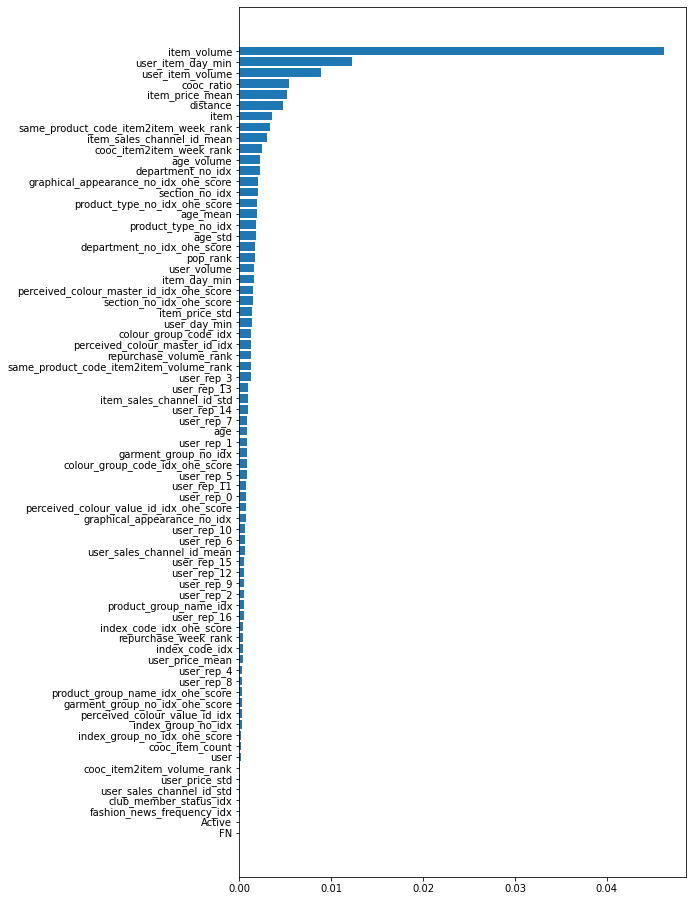

In [21]:
if CFG.model_type == 'LightGBM':
    group_train = get_query_group(train)
    train_dataset = lgb.Dataset(train[feature_columns], train['y'], group=group_train)

    best_iteration = model.best_iteration
    model = lgb.train(params, train_dataset, num_boost_round=best_iteration)

    lgb.plot_importance(model, importance_type='gain', figsize=(8, 16))

elif CFG.model_type == 'CatBoost':
    train_dataset = catboost.Pool(data=train[feature_columns], label=train['y'], group_id=train['query_group'], cat_features=cat_features)

    params['iterations'] = model.get_best_iteration()
    params['use_best_model'] = False
    model = catboost.CatBoost(params)
    model.fit(train_dataset)

    feature_importance = model.get_feature_importance(train_dataset)
    sorted_idx = np.argsort(feature_importance)
    plt.figure(figsize=(8, 16))
    plt.yticks(range(len(feature_columns)), np.array(feature_columns)[sorted_idx])
    plt.barh(range(len(feature_columns)), feature_importance[sorted_idx])

del train, train_dataset
gc.collect()
with open('output/model_for_submission.pkl', 'wb') as f:
    pickle.dump(model, f)

In [22]:
del datasets, dataset_valid_all, candidates, candidates_valid_all
gc.collect()

11990

In [23]:
all_users = users['user'].values
all_users

array([      0,       1,       2, ..., 1371977, 1371978, 1371979])

In [24]:
# to avoid OOM
preds = []

n_split_prediction = 10
n_chunk = (len(all_users) + n_split_prediction - 1)// n_split_prediction
for i in range(0, len(all_users), n_chunk):
    print(f"chunk: {i}")
    target_users = all_users[i:i+n_chunk]

    candidates = create_candidates(transactions, target_users, 0)
    candidates = attach_features(transactions, users, items, candidates, 0, CFG.train_weeks)

    candidates['pred'] = model.predict(candidates[feature_columns])
    pred = candidates.groupby(['user', 'item'])['pred'].max().reset_index()
    pred = pred.sort_values(by=['user', 'pred'], ascending=False).reset_index(drop=True).groupby('user')['item'].apply(lambda x: list(x)[:12]).reset_index()
    preds.append(pred)

pred = pd.concat(preds).reset_index(drop=True)
assert len(pred) == len(all_users)
assert np.array_equal(pred['user'].values, all_users)

chunk: 0
create candidates (week: 0)


[repurchase] 5.885 s


[popular] 1.023 s


[item2item] 5.843 s


[cooccurrence] 12.841 s


[same_product_code] 7.143 s


[ohe distance] 17.812 s


volume: 22245562


duplicates: 1.0381392310907682


            strategy   volume     ratio
0  same_product_code  9190204  0.413125
1                pop  4939128  0.222028
2                ohe  4275973  0.192217
3         repurchase  2735882  0.122986
4               cooc  1104375  0.049645


attach features (week: 0)


[user static fetaures] 2.110 s


[item stacic features] 5.880 s


[user dynamic features (transactions)] 4.145 s


[item dynamic features (transactions)] 3.220 s


[item dynamic features (user features)] 3.898 s


[item freshness features] 5.459 s


[item volume features] 3.826 s


[user freshness features] 7.661 s


[user volume features] 4.488 s


[user-item freshness features] 26.211 s


[user-item volume features] 7.654 s


[item age volume features] 6.468 s


[ohe dot products] 132.283 s


[lfm features] 12.139 s


chunk: 137198
create candidates (week: 0)


[repurchase] 5.866 s


[popular] 1.000 s


[item2item] 5.788 s


[cooccurrence] 12.687 s


[same_product_code] 7.152 s


[ohe distance] 12.821 s


volume: 22277777


duplicates: 1.0380449277871724


            strategy   volume     ratio
0  same_product_code  9210520  0.413440
1                pop  4939128  0.221707
2                ohe  4274077  0.191854
3         repurchase  2752227  0.123541
4               cooc  1101825  0.049458


attach features (week: 0)


[user static fetaures] 2.078 s


[item stacic features] 5.889 s


[user dynamic features (transactions)] 4.077 s


[item dynamic features (transactions)] 3.204 s


[item dynamic features (user features)] 3.856 s


[item freshness features] 5.602 s


[item volume features] 3.757 s


[user freshness features] 7.532 s


[user volume features] 4.363 s


[user-item freshness features] 25.932 s


[user-item volume features] 7.924 s


[item age volume features] 6.369 s


[ohe dot products] 129.690 s


[lfm features] 10.692 s


chunk: 274396
create candidates (week: 0)


[repurchase] 5.766 s


[popular] 1.001 s


[item2item] 5.621 s


[cooccurrence] 12.597 s


[same_product_code] 7.066 s


[ohe distance] 12.623 s


volume: 22184943


duplicates: 1.0380521366008064


            strategy   volume     ratio
0  same_product_code  9167920  0.413250
1                pop  4939128  0.222634
2                ohe  4275911  0.192739
3         repurchase  2708651  0.122094
4               cooc  1093333  0.049283


attach features (week: 0)


[user static fetaures] 2.069 s


[item stacic features] 5.790 s


[user dynamic features (transactions)] 4.070 s


[item dynamic features (transactions)] 3.168 s


[item dynamic features (user features)] 3.816 s


[item freshness features] 5.372 s


[item volume features] 3.727 s


[user freshness features] 7.526 s


[user volume features] 4.361 s


[user-item freshness features] 25.835 s


[user-item volume features] 7.366 s


[item age volume features] 6.364 s


[ohe dot products] 129.249 s


[lfm features] 12.418 s


chunk: 411594
create candidates (week: 0)


[repurchase] 5.786 s


[popular] 0.994 s


[item2item] 5.665 s


[cooccurrence] 12.623 s


[same_product_code] 7.091 s


[ohe distance] 12.658 s


volume: 22260490


duplicates: 1.0380991731297722


            strategy   volume     ratio
0  same_product_code  9204223  0.413478
1                pop  4939128  0.221879
2                ohe  4275076  0.192048
3         repurchase  2737078  0.122957
4               cooc  1104985  0.049639


attach features (week: 0)


[user static fetaures] 2.070 s


[item stacic features] 5.796 s


[user dynamic features (transactions)] 4.253 s


[item dynamic features (transactions)] 3.161 s


[item dynamic features (user features)] 3.813 s


[item freshness features] 5.583 s


[item volume features] 3.739 s


[user freshness features] 7.723 s


[user volume features] 4.540 s


[user-item freshness features] 26.593 s


[user-item volume features] 7.551 s


[item age volume features] 6.302 s


[ohe dot products] 128.979 s


[lfm features] 11.360 s


chunk: 548792
create candidates (week: 0)


[repurchase] 5.859 s


[popular] 0.999 s


[item2item] 5.795 s


[cooccurrence] 12.654 s


[same_product_code] 7.088 s


[ohe distance] 12.618 s


volume: 22250675


duplicates: 1.0381632151158697


            strategy   volume     ratio
0  same_product_code  9190841  0.413059
1                pop  4939128  0.221977
2                ohe  4276533  0.192198
3         repurchase  2739307  0.123111
4               cooc  1104866  0.049655


attach features (week: 0)


[user static fetaures] 2.071 s


[item stacic features] 5.833 s


[user dynamic features (transactions)] 4.067 s


[item dynamic features (transactions)] 3.190 s


[item dynamic features (user features)] 4.044 s


[item freshness features] 5.593 s


[item volume features] 3.767 s


[user freshness features] 7.784 s


[user volume features] 4.545 s


[user-item freshness features] 26.966 s


[user-item volume features] 7.516 s


[item age volume features] 6.319 s


[ohe dot products] 128.706 s


[lfm features] 10.529 s


chunk: 685990
create candidates (week: 0)


[repurchase] 5.867 s


[popular] 1.006 s


[item2item] 5.834 s


[cooccurrence] 12.623 s


[same_product_code] 7.119 s


[ohe distance] 12.631 s


volume: 22313213


duplicates: 1.0382393493656716


            strategy   volume     ratio
0  same_product_code  9243785  0.414274
1                pop  4939128  0.221354
2                ohe  4273560  0.191526
3         repurchase  2745003  0.123021
4               cooc  1111737  0.049824


attach features (week: 0)


[user static fetaures] 2.076 s


[item stacic features] 5.831 s


[user dynamic features (transactions)] 4.120 s


[item dynamic features (transactions)] 3.198 s


[item dynamic features (user features)] 4.039 s


[item freshness features] 5.615 s


[item volume features] 3.759 s


[user freshness features] 7.879 s


[user volume features] 4.591 s


[user-item freshness features] 25.884 s


[user-item volume features] 7.568 s


[item age volume features] 6.381 s


[ohe dot products] 131.093 s


[lfm features] 12.775 s


chunk: 823188
create candidates (week: 0)


[repurchase] 5.701 s


[popular] 0.998 s


[item2item] 5.603 s


[cooccurrence] 12.562 s


[same_product_code] 7.193 s


[ohe distance] 12.897 s


volume: 22204770


duplicates: 1.0384411949984076


            strategy   volume     ratio
0  same_product_code  9166138  0.412800
1                pop  4939128  0.222435
2                ohe  4275160  0.192533
3         repurchase  2714357  0.122242
4               cooc  1109987  0.049989


attach features (week: 0)


[user static fetaures] 2.062 s


[item stacic features] 5.795 s


[user dynamic features (transactions)] 4.288 s


[item dynamic features (transactions)] 3.184 s


[item dynamic features (user features)] 3.822 s


[item freshness features] 5.568 s


[item volume features] 3.735 s


[user freshness features] 7.792 s


[user volume features] 4.604 s


[user-item freshness features] 25.620 s


[user-item volume features] 7.506 s


[item age volume features] 6.321 s


[ohe dot products] 129.056 s


[lfm features] 13.556 s


chunk: 960386
create candidates (week: 0)


[repurchase] 5.804 s


[popular] 1.002 s


[item2item] 5.725 s


[cooccurrence] 12.690 s


[same_product_code] 7.339 s


[ohe distance] 12.678 s


volume: 22224321


duplicates: 1.0382621935765743


            strategy   volume     ratio
0  same_product_code  9175200  0.412845
1                pop  4939128  0.222240
2                ohe  4275309  0.192371
3         repurchase  2731902  0.122924
4               cooc  1102782  0.049621


attach features (week: 0)


[user static fetaures] 2.059 s


[item stacic features] 5.749 s


[user dynamic features (transactions)] 4.024 s


[item dynamic features (transactions)] 3.144 s


[item dynamic features (user features)] 3.807 s


[item freshness features] 5.354 s


[item volume features] 3.540 s


[user freshness features] 7.274 s


[user volume features] 4.559 s


[user-item freshness features] 26.566 s


[user-item volume features] 7.622 s


[item age volume features] 6.293 s


[ohe dot products] 129.319 s


[lfm features] 10.917 s


chunk: 1097584
create candidates (week: 0)


[repurchase] 5.655 s


[popular] 0.992 s


[item2item] 5.535 s


[cooccurrence] 12.508 s


[same_product_code] 7.150 s


[ohe distance] 12.497 s


volume: 22151799


duplicates: 1.0378601240280338


            strategy   volume     ratio
0  same_product_code  9136160  0.412434
1                pop  4939128  0.222967
2                ohe  4273226  0.192906
3         repurchase  2711285  0.122396
4               cooc  1092000  0.049296


attach features (week: 0)


[user static fetaures] 2.052 s


[item stacic features] 5.753 s


[user dynamic features (transactions)] 4.295 s


[item dynamic features (transactions)] 3.140 s


[item dynamic features (user features)] 3.787 s


[item freshness features] 5.505 s


[item volume features] 3.693 s


[user freshness features] 7.691 s


[user volume features] 4.539 s


[user-item freshness features] 26.555 s


[user-item volume features] 7.846 s


[item age volume features] 6.271 s


[ohe dot products] 129.107 s


[lfm features] 12.869 s


chunk: 1234782
create candidates (week: 0)


[repurchase] 5.770 s


[popular] 1.005 s


[item2item] 5.720 s


[cooccurrence] 12.718 s


[same_product_code] 7.155 s


[ohe distance] 12.558 s


volume: 22236776


duplicates: 1.0382287938103627


            strategy   volume     ratio
0  same_product_code  9189583  0.413261
1                pop  4939128  0.222115
2                ohe  4274701  0.192236
3         repurchase  2730747  0.122803
4               cooc  1102617  0.049585


attach features (week: 0)


[user static fetaures] 2.069 s


[item stacic features] 5.824 s


[user dynamic features (transactions)] 4.055 s


[item dynamic features (transactions)] 3.167 s


[item dynamic features (user features)] 3.813 s


[item freshness features] 5.358 s


[item volume features] 3.548 s


[user freshness features] 7.301 s


[user volume features] 4.546 s


[user-item freshness features] 26.587 s


[user-item volume features] 7.462 s


[item age volume features] 6.280 s


[ohe dot products] 129.020 s


[lfm features] 10.866 s


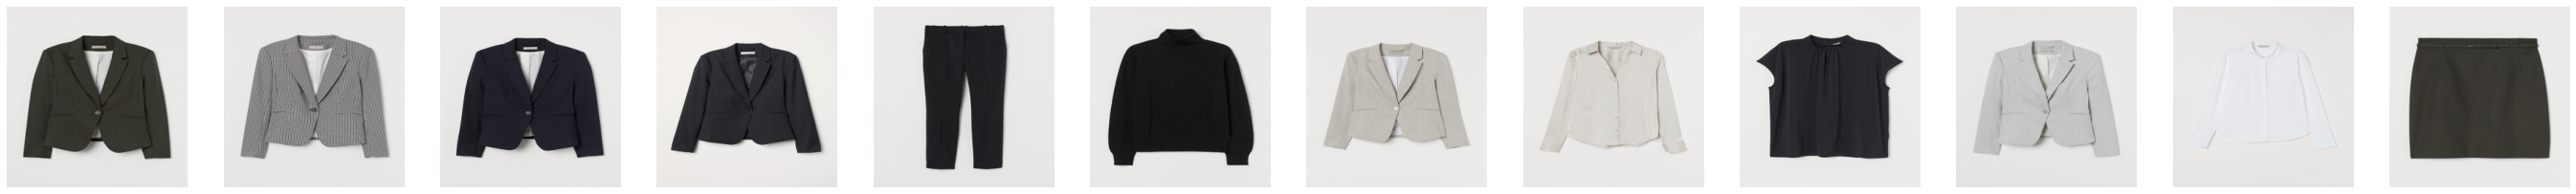

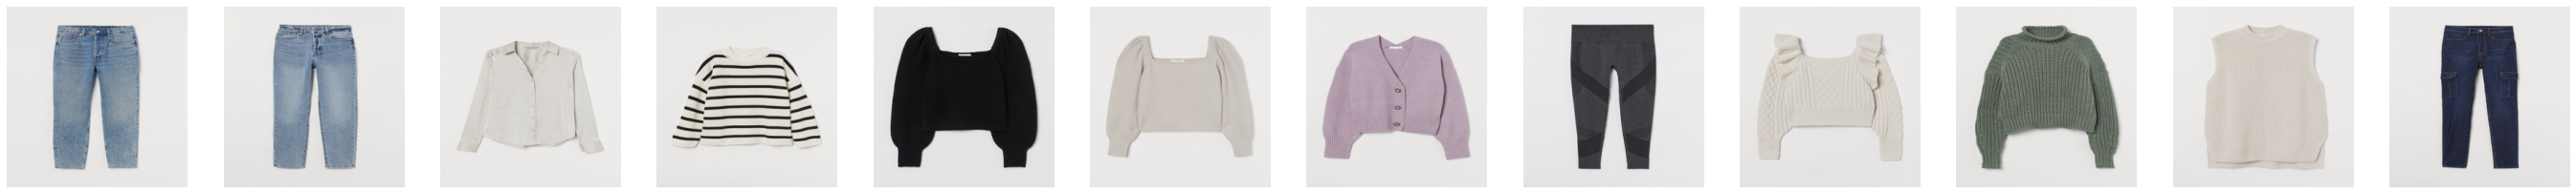

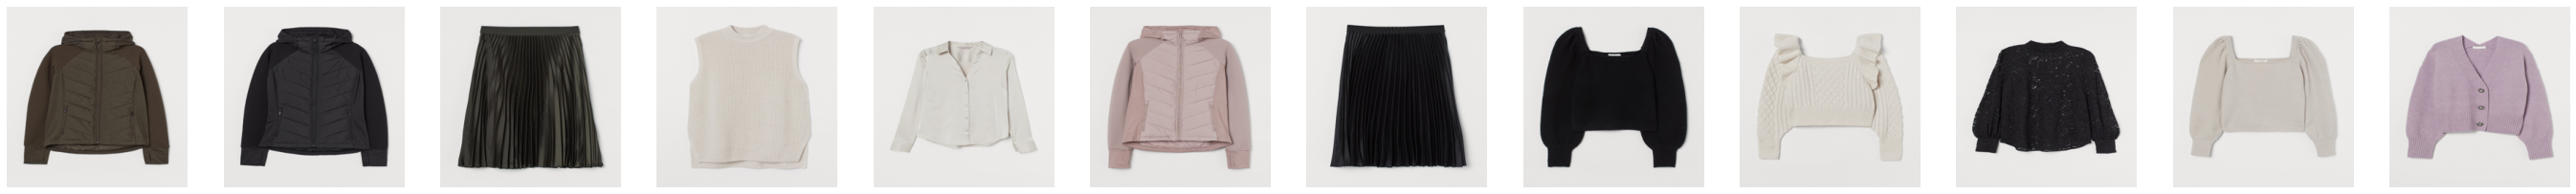

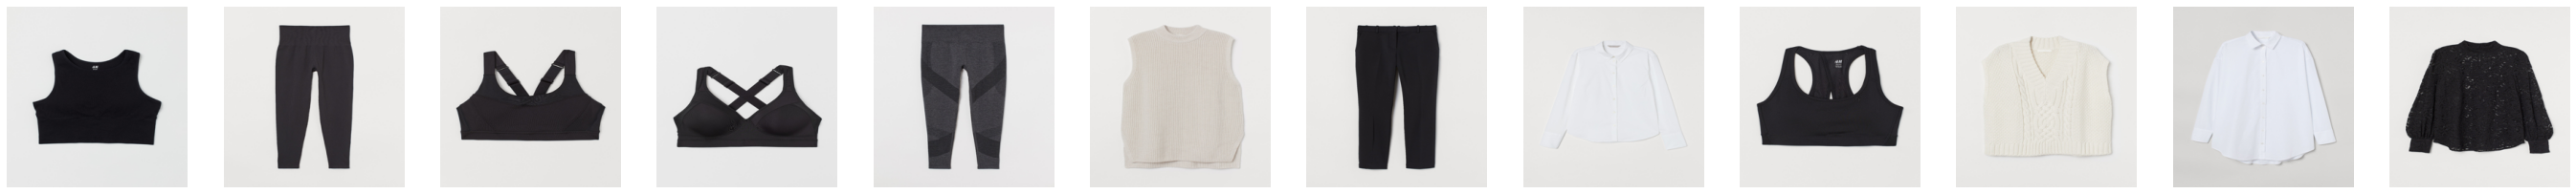

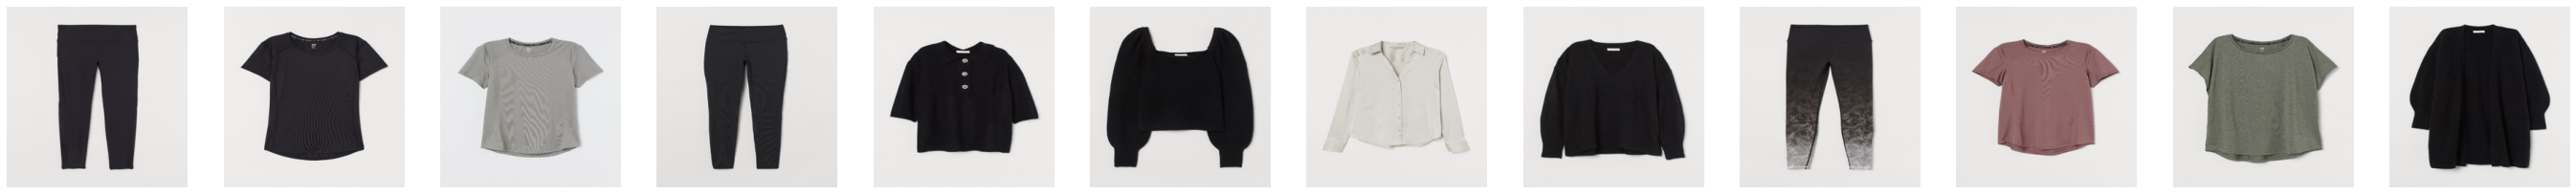

In [25]:
for i in range(5):
    plot_images(dataset, pred['item'][i])

In [26]:
mp_user = pd.read_pickle(f"input/{dataset}/mp_customer_id.pkl")
mp_item = pd.read_pickle(f"input/{dataset}/mp_article_id.pkl")

a_user = mp_user['val'].values
a_item = mp_item['val'].values

pred['customer_id'] = pred['user'].apply(lambda x: a_user[x])
pred['prediction'] = pred['item'].apply(lambda x: list(map(lambda y: a_item[y], x)))

pred['prediction'] = pred['prediction'].apply(lambda x: ' '.join(map(str, x)))

submission = pred[['customer_id', 'prediction']]
submission

,customer_id,prediction
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0568601043 0568601044 0568601007 0568601006 07...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0448509014 0714790020 0762846027 0863583001 09...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0794321007 0794321011 0851400020 0924243001 07...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0869331006 0866731001 0910949002 0741040001 09...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,0730683050 0791587001 0791587015 0852584001 08...
...,...,...
1371975,ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e474...,0804992014 0557599022 0791587015 0791587001 06...
1371976,ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab5...,0762846027 0762846026 0762846006 0762846031 04...
1371977,ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1...,0762846027 0762846031 0762846026 0762846006 07...
1371978,ffffd7744cebcf3aca44ae7049d2a94b87074c3d4ffe38...,0714790020 0448509014 0821395005 0714790028 07...


In [27]:
submission.to_csv('submission.csv', index=False)